In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [4]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv")

In [8]:
print(data_2022['pitch_type'].unique())

['FF' 'SL' 'FC' 'SI' 'CU' 'CH' 'KC' 'PO' 'ST' 'FS' 'SV' 'EP' 'FA' 'CS'
 'KN']


In [9]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [10]:
breaking_ball = data.query('pitch_type_condensed in ("CH", "FS")')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH", "FS")')

# Fastball Model First

In [11]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [12]:
train_data = training_features.drop(['swing'], axis=1).copy()
train_label = training_features['swing'].copy()
testing_data = testing_features.drop(['swing'], axis=1).copy()
testing_label = testing_features['swing'].copy()

In [14]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'last_spin_axis', 'last_pfx_x',
       'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
       'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z', 'diff_release_pos_z',
       'diff_release_speed'],
      dtype='object')

In [15]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'last_spin_axis', 'last_pfx_x',
       'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
       'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z', 'diff_release_pos_z',
       'diff_release_speed'],
      dtype='object')

In [16]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [17]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [18]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6966863073679659
Log Loss: 0.6061913268729564


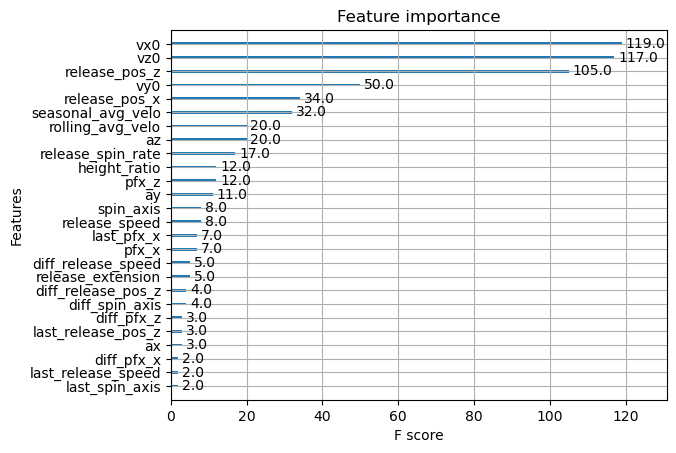

In [19]:
xgb.plot_importance(model)
plt.show()

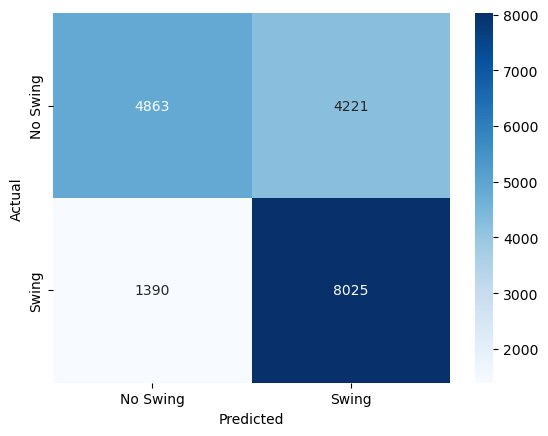

In [20]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [21]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'device' : 'gpu',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [22]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-16 18:41:57,123] A new study created in memory with name: no-name-711b7e7d-e97c-4330-9ed5-ce182ee7c6f8


[18:41:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67783
[1]	eval-logloss:0.66556
[2]	eval-logloss:0.65838
[3]	eval-logloss:0.65207
[4]	eval-logloss:0.64144
[5]	eval-logloss:0.63278
[6]	eval-logloss:0.62597
[7]	eval-logloss:0.61922
[8]	eval-logloss:0.61389
[9]	eval-logloss:0.60973
[10]	eval-logloss:0.60460
[11]	eval-logloss:0.60439
[12]	eval-logloss:0.60124
[13]	eval-logloss:0.59782
[14]	eval-logloss:0.59336
[15]	eval-logloss:0.59061
[16]	eval-logloss:0.58709
[17]	eval-logloss:0.58452
[18]	eval-logloss:0.58112
[19]	eval-logloss:0.57940
[20]	eval-logloss:0.57706
[21]	eval-logloss:0.57551
[22]	eval-logloss:0.57310
[23]	eval-logloss:0.57102
[24]	eval-logloss:0.56823
[25]	eval-logloss:0.56730
[26]	eval-logloss:0.56550
[27]	eval-logloss:0.56524
[28]	eval-logloss:0.56365
[29]	eval-logloss:0.56227
[30]	eval-logloss:0.56061
[31]	eval-logloss:0.55919
[32]	eval-logloss:0.55800
[33]	eval-lo

[I 2023-11-16 18:42:01,644] Trial 0 finished with value: 0.5202856896193907 and parameters: {'max_depth': 5, 'eta': 0.11147813728269734, 'subsample': 0.7648767323039163, 'colsample_bytree': 0.8117265421762061}. Best is trial 0 with value: 0.5202856896193907.


[18:42:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68161
[1]	eval-logloss:0.67063
[2]	eval-logloss:0.66415
[3]	eval-logloss:0.65919
[4]	eval-logloss:0.65044
[5]	eval-logloss:0.64214
[6]	eval-logloss:0.63468
[7]	eval-logloss:0.62828
[8]	eval-logloss:0.62228
[9]	eval-logloss:0.61833
[10]	eval-logloss:0.61288
[11]	eval-logloss:0.61267
[12]	eval-logloss:0.60810
[13]	eval-logloss:0.60491
[14]	eval-logloss:0.60039
[15]	eval-logloss:0.59634
[16]	eval-logloss:0.59244
[17]	eval-logloss:0.58980
[18]	eval-logloss:0.58613
[19]	eval-logloss:0.58281
[20]	eval-logloss:0.57962
[21]	eval-logloss:0.57750
[22]	eval-logloss:0.57496
[23]	eval-logloss:0.57242
[24]	eval-logloss:0.56975
[25]	eval-logloss:0.56783
[26]	eval-logloss:0.56547
[27]	eval-logloss:0.56537
[28]	eval-logloss:0.56303
[29]	eval-logloss:0.56163
[30]	eval-logloss:0.55967
[31]	eval-logloss:0.55806
[32]	eval-logloss:0.55670
[33]	eval-lo

[I 2023-11-16 18:42:07,412] Trial 1 finished with value: 0.5140489284650265 and parameters: {'max_depth': 7, 'eta': 0.06753101540336663, 'subsample': 0.7336267005953476, 'colsample_bytree': 0.8112098077430997}. Best is trial 1 with value: 0.5140489284650265.


[18:42:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66376
[1]	eval-logloss:0.64428
[2]	eval-logloss:0.63826
[3]	eval-logloss:0.62679
[4]	eval-logloss:0.61026
[5]	eval-logloss:0.59892
[6]	eval-logloss:0.58955
[7]	eval-logloss:0.58293
[8]	eval-logloss:0.57685
[9]	eval-logloss:0.57698
[10]	eval-logloss:0.57207
[11]	eval-logloss:0.57167
[12]	eval-logloss:0.56609
[13]	eval-logloss:0.56071
[14]	eval-logloss:0.55617
[15]	eval-logloss:0.55295
[16]	eval-logloss:0.55021
[17]	eval-logloss:0.54648
[18]	eval-logloss:0.54438
[19]	eval-logloss:0.54211
[20]	eval-logloss:0.54149
[21]	eval-logloss:0.54003
[22]	eval-logloss:0.53990
[23]	eval-logloss:0.53803
[24]	eval-logloss:0.53249
[25]	eval-logloss:0.53234
[26]	eval-logloss:0.53105
[27]	eval-logloss:0.53107
[28]	eval-logloss:0.52942
[29]	eval-logloss:0.52912
[30]	eval-logloss:0.52676
[31]	eval-logloss:0.52641
[32]	eval-logloss:0.52606
[33]	eval-lo

[I 2023-11-16 18:42:12,586] Trial 2 finished with value: 0.5070265275562859 and parameters: {'max_depth': 7, 'eta': 0.18217984561175676, 'subsample': 0.7085814432998317, 'colsample_bytree': 0.6553365561784279}. Best is trial 2 with value: 0.5070265275562859.


[18:42:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64961
[1]	eval-logloss:0.62281
[2]	eval-logloss:0.60491
[3]	eval-logloss:0.59033
[4]	eval-logloss:0.57523
[5]	eval-logloss:0.56503
[6]	eval-logloss:0.55663
[7]	eval-logloss:0.55155
[8]	eval-logloss:0.54646
[9]	eval-logloss:0.54048
[10]	eval-logloss:0.53728
[11]	eval-logloss:0.53207
[12]	eval-logloss:0.52924
[13]	eval-logloss:0.52618
[14]	eval-logloss:0.52451
[15]	eval-logloss:0.52373
[16]	eval-logloss:0.52196
[17]	eval-logloss:0.52125
[18]	eval-logloss:0.51967
[19]	eval-logloss:0.51939
[20]	eval-logloss:0.51817
[21]	eval-logloss:0.51786
[22]	eval-logloss:0.51562
[23]	eval-logloss:0.51516
[24]	eval-logloss:0.51437
[25]	eval-logloss:0.51430
[26]	eval-logloss:0.51385
[27]	eval-logloss:0.51347
[28]	eval-logloss:0.51318
[29]	eval-logloss:0.51292
[30]	eval-logloss:0.51224
[31]	eval-logloss:0.51243
[32]	eval-logloss:0.51250
[33]	eval-lo

[I 2023-11-16 18:42:19,028] Trial 3 finished with value: 0.5101612746073093 and parameters: {'max_depth': 8, 'eta': 0.24756603042365008, 'subsample': 0.6630171941396796, 'colsample_bytree': 0.898557343092667}. Best is trial 2 with value: 0.5070265275562859.


[18:42:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68834
[1]	eval-logloss:0.68408
[2]	eval-logloss:0.68249
[3]	eval-logloss:0.68003
[4]	eval-logloss:0.67593
[5]	eval-logloss:0.67206
[6]	eval-logloss:0.66816
[7]	eval-logloss:0.66421
[8]	eval-logloss:0.66079
[9]	eval-logloss:0.66065
[10]	eval-logloss:0.65701
[11]	eval-logloss:0.65687
[12]	eval-logloss:0.65474
[13]	eval-logloss:0.65271
[14]	eval-logloss:0.64954
[15]	eval-logloss:0.64671
[16]	eval-logloss:0.64376
[17]	eval-logloss:0.64204
[18]	eval-logloss:0.63926
[19]	eval-logloss:0.63655
[20]	eval-logloss:0.63395
[21]	eval-logloss:0.63200
[22]	eval-logloss:0.63187
[23]	eval-logloss:0.62934
[24]	eval-logloss:0.62681
[25]	eval-logloss:0.62671
[26]	eval-logloss:0.62424
[27]	eval-logloss:0.62421
[28]	eval-logloss:0.62209
[29]	eval-logloss:0.62011
[30]	eval-logloss:0.61814
[31]	eval-logloss:0.61622
[32]	eval-logloss:0.61439
[33]	eval-lo

[I 2023-11-16 18:42:24,084] Trial 4 finished with value: 0.5596420163409171 and parameters: {'max_depth': 7, 'eta': 0.027143357899865703, 'subsample': 0.7294547245012988, 'colsample_bytree': 0.6080387046430493}. Best is trial 2 with value: 0.5070265275562859.


[18:42:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67132
[1]	eval-logloss:0.65596
[2]	eval-logloss:0.64783
[3]	eval-logloss:0.64148
[4]	eval-logloss:0.62903
[5]	eval-logloss:0.62053
[6]	eval-logloss:0.61488
[7]	eval-logloss:0.60855
[8]	eval-logloss:0.60425
[9]	eval-logloss:0.60077
[10]	eval-logloss:0.59742
[11]	eval-logloss:0.59691
[12]	eval-logloss:0.59331
[13]	eval-logloss:0.58906
[14]	eval-logloss:0.58623
[15]	eval-logloss:0.58265
[16]	eval-logloss:0.57970
[17]	eval-logloss:0.57889
[18]	eval-logloss:0.57772
[19]	eval-logloss:0.57488
[20]	eval-logloss:0.57412
[21]	eval-logloss:0.57314
[22]	eval-logloss:0.57290
[23]	eval-logloss:0.57077
[24]	eval-logloss:0.56964
[25]	eval-logloss:0.56926
[26]	eval-logloss:0.56795
[27]	eval-logloss:0.56777
[28]	eval-logloss:0.56590
[29]	eval-logloss:0.56486
[30]	eval-logloss:0.56447
[31]	eval-logloss:0.56390
[32]	eval-logloss:0.56164
[33]	eval-lo

[I 2023-11-16 18:42:27,481] Trial 5 finished with value: 0.5218307643644505 and parameters: {'max_depth': 4, 'eta': 0.1968986798834179, 'subsample': 0.8559395273049595, 'colsample_bytree': 0.7454995140211016}. Best is trial 2 with value: 0.5070265275562859.


[18:42:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66598
[1]	eval-logloss:0.64213
[2]	eval-logloss:0.63343
[3]	eval-logloss:0.62768
[4]	eval-logloss:0.61157
[5]	eval-logloss:0.60010
[6]	eval-logloss:0.58809
[7]	eval-logloss:0.58068
[8]	eval-logloss:0.57562
[9]	eval-logloss:0.57574
[10]	eval-logloss:0.57023
[11]	eval-logloss:0.57034
[12]	eval-logloss:0.55906
[13]	eval-logloss:0.54912
[14]	eval-logloss:0.54392
[15]	eval-logloss:0.54130
[16]	eval-logloss:0.53927
[17]	eval-logloss:0.53924
[18]	eval-logloss:0.53810
[19]	eval-logloss:0.53758
[20]	eval-logloss:0.53489
[21]	eval-logloss:0.53480
[22]	eval-logloss:0.53482
[23]	eval-logloss:0.53339
[24]	eval-logloss:0.53041
[25]	eval-logloss:0.53063
[26]	eval-logloss:0.52997
[27]	eval-logloss:0.53046
[28]	eval-logloss:0.52785
[29]	eval-logloss:0.52704
[30]	eval-logloss:0.52385
[31]	eval-logloss:0.52359
[32]	eval-logloss:0.52351
[33]	eval-lo

[I 2023-11-16 18:42:33,583] Trial 6 finished with value: 0.5112197585670994 and parameters: {'max_depth': 9, 'eta': 0.1870352517901483, 'subsample': 0.7492945246192609, 'colsample_bytree': 0.5506947888457291}. Best is trial 2 with value: 0.5070265275562859.


[18:42:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66855
[1]	eval-logloss:0.65164
[2]	eval-logloss:0.64144
[3]	eval-logloss:0.63446
[4]	eval-logloss:0.61935
[5]	eval-logloss:0.60815
[6]	eval-logloss:0.59979
[7]	eval-logloss:0.59153
[8]	eval-logloss:0.58653
[9]	eval-logloss:0.58639
[10]	eval-logloss:0.58150
[11]	eval-logloss:0.58100
[12]	eval-logloss:0.57670
[13]	eval-logloss:0.56962
[14]	eval-logloss:0.56486
[15]	eval-logloss:0.56231
[16]	eval-logloss:0.55872
[17]	eval-logloss:0.55665
[18]	eval-logloss:0.55366
[19]	eval-logloss:0.55253
[20]	eval-logloss:0.54938
[21]	eval-logloss:0.54773
[22]	eval-logloss:0.54761
[23]	eval-logloss:0.54532
[24]	eval-logloss:0.54253
[25]	eval-logloss:0.54241
[26]	eval-logloss:0.54068
[27]	eval-logloss:0.54059
[28]	eval-logloss:0.53902
[29]	eval-logloss:0.53805
[30]	eval-logloss:0.53710
[31]	eval-logloss:0.53641
[32]	eval-logloss:0.53572
[33]	eval-lo

[I 2023-11-16 18:42:37,950] Trial 7 finished with value: 0.5085896814208782 and parameters: {'max_depth': 6, 'eta': 0.17082506592285612, 'subsample': 0.7532084527372148, 'colsample_bytree': 0.6840062907618918}. Best is trial 2 with value: 0.5070265275562859.


[18:42:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68254
[1]	eval-logloss:0.67411
[2]	eval-logloss:0.67101
[3]	eval-logloss:0.66838
[4]	eval-logloss:0.66012
[5]	eval-logloss:0.65313
[6]	eval-logloss:0.64774
[7]	eval-logloss:0.64264
[8]	eval-logloss:0.63816
[9]	eval-logloss:0.63803
[10]	eval-logloss:0.63438
[11]	eval-logloss:0.63423
[12]	eval-logloss:0.63093
[13]	eval-logloss:0.62817
[14]	eval-logloss:0.62467
[15]	eval-logloss:0.62175
[16]	eval-logloss:0.61927
[17]	eval-logloss:0.61694
[18]	eval-logloss:0.61378
[19]	eval-logloss:0.61187
[20]	eval-logloss:0.61023
[21]	eval-logloss:0.60852
[22]	eval-logloss:0.60831
[23]	eval-logloss:0.60615
[24]	eval-logloss:0.60372
[25]	eval-logloss:0.60359
[26]	eval-logloss:0.60069
[27]	eval-logloss:0.60060
[28]	eval-logloss:0.59843
[29]	eval-logloss:0.59688
[30]	eval-logloss:0.59452
[31]	eval-logloss:0.59257
[32]	eval-logloss:0.59157
[33]	eval-lo

[I 2023-11-16 18:42:41,072] Trial 8 finished with value: 0.5526022653271241 and parameters: {'max_depth': 4, 'eta': 0.0894414394549, 'subsample': 0.7213572615165073, 'colsample_bytree': 0.5976357867869498}. Best is trial 2 with value: 0.5070265275562859.


[18:42:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66561
[1]	eval-logloss:0.64785
[2]	eval-logloss:0.64158
[3]	eval-logloss:0.63318
[4]	eval-logloss:0.61962
[5]	eval-logloss:0.61122
[6]	eval-logloss:0.60548
[7]	eval-logloss:0.60041
[8]	eval-logloss:0.59638
[9]	eval-logloss:0.59573
[10]	eval-logloss:0.59012
[11]	eval-logloss:0.58967
[12]	eval-logloss:0.58676
[13]	eval-logloss:0.58356
[14]	eval-logloss:0.57966
[15]	eval-logloss:0.57787
[16]	eval-logloss:0.57512
[17]	eval-logloss:0.57314
[18]	eval-logloss:0.56949
[19]	eval-logloss:0.56611
[20]	eval-logloss:0.56535
[21]	eval-logloss:0.56436
[22]	eval-logloss:0.56404
[23]	eval-logloss:0.56175
[24]	eval-logloss:0.55858
[25]	eval-logloss:0.55853
[26]	eval-logloss:0.55756
[27]	eval-logloss:0.55702
[28]	eval-logloss:0.55637
[29]	eval-logloss:0.55539
[30]	eval-logloss:0.55216
[31]	eval-logloss:0.55196
[32]	eval-logloss:0.55061
[33]	eval-lo

[I 2023-11-16 18:42:44,496] Trial 9 finished with value: 0.5231429437864817 and parameters: {'max_depth': 4, 'eta': 0.2582296813670776, 'subsample': 0.8191874420151337, 'colsample_bytree': 0.6189700522587676}. Best is trial 2 with value: 0.5070265275562859.


[18:42:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65413
[1]	eval-logloss:0.62438
[2]	eval-logloss:0.61540
[3]	eval-logloss:0.61057
[4]	eval-logloss:0.59407
[5]	eval-logloss:0.58382
[6]	eval-logloss:0.57031
[7]	eval-logloss:0.56510
[8]	eval-logloss:0.56187
[9]	eval-logloss:0.56222
[10]	eval-logloss:0.55915
[11]	eval-logloss:0.55965
[12]	eval-logloss:0.54885
[13]	eval-logloss:0.54502
[14]	eval-logloss:0.54073
[15]	eval-logloss:0.53929
[16]	eval-logloss:0.53882
[17]	eval-logloss:0.53951
[18]	eval-logloss:0.53947
[19]	eval-logloss:0.54070
[20]	eval-logloss:0.54022
[21]	eval-logloss:0.54013
[22]	eval-logloss:0.54097
[23]	eval-logloss:0.54029
[24]	eval-logloss:0.54047
[25]	eval-logloss:0.54149
[26]	eval-logloss:0.54112
[27]	eval-logloss:0.54170
[28]	eval-logloss:0.53985
[29]	eval-logloss:0.54062
[30]	eval-logloss:0.53637
[31]	eval-logloss:0.53681
[32]	eval-logloss:0.53751
[33]	eval-lo

[I 2023-11-16 18:42:50,146] Trial 10 finished with value: 0.5348946707154504 and parameters: {'max_depth': 9, 'eta': 0.289348982476181, 'subsample': 0.6076047118279195, 'colsample_bytree': 0.5153683107138032}. Best is trial 2 with value: 0.5070265275562859.


[18:42:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67080
[1]	eval-logloss:0.65383
[2]	eval-logloss:0.64434
[3]	eval-logloss:0.63744
[4]	eval-logloss:0.62387
[5]	eval-logloss:0.61323
[6]	eval-logloss:0.60522
[7]	eval-logloss:0.59924
[8]	eval-logloss:0.59304
[9]	eval-logloss:0.59270
[10]	eval-logloss:0.58612
[11]	eval-logloss:0.58573
[12]	eval-logloss:0.58137
[13]	eval-logloss:0.57563
[14]	eval-logloss:0.57070
[15]	eval-logloss:0.56739
[16]	eval-logloss:0.56403
[17]	eval-logloss:0.55945
[18]	eval-logloss:0.55633
[19]	eval-logloss:0.55453
[20]	eval-logloss:0.55163
[21]	eval-logloss:0.55082
[22]	eval-logloss:0.55076
[23]	eval-logloss:0.54893
[24]	eval-logloss:0.54648
[25]	eval-logloss:0.54653
[26]	eval-logloss:0.54477
[27]	eval-logloss:0.54468
[28]	eval-logloss:0.54326
[29]	eval-logloss:0.54222
[30]	eval-logloss:0.54159
[31]	eval-logloss:0.54120
[32]	eval-logloss:0.54079
[33]	eval-lo

[I 2023-11-16 18:42:54,775] Trial 11 finished with value: 0.5127137253192793 and parameters: {'max_depth': 6, 'eta': 0.1528456976183504, 'subsample': 0.8004045215229928, 'colsample_bytree': 0.6894900034786511}. Best is trial 2 with value: 0.5070265275562859.


[18:42:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67089
[1]	eval-logloss:0.65386
[2]	eval-logloss:0.64512
[3]	eval-logloss:0.63887
[4]	eval-logloss:0.62518
[5]	eval-logloss:0.61541
[6]	eval-logloss:0.60662
[7]	eval-logloss:0.59941
[8]	eval-logloss:0.59381
[9]	eval-logloss:0.59351
[10]	eval-logloss:0.58846
[11]	eval-logloss:0.58814
[12]	eval-logloss:0.58238
[13]	eval-logloss:0.57888
[14]	eval-logloss:0.57344
[15]	eval-logloss:0.56969
[16]	eval-logloss:0.56516
[17]	eval-logloss:0.56290
[18]	eval-logloss:0.55975
[19]	eval-logloss:0.55777
[20]	eval-logloss:0.55657
[21]	eval-logloss:0.55541
[22]	eval-logloss:0.55514
[23]	eval-logloss:0.55305
[24]	eval-logloss:0.55043
[25]	eval-logloss:0.55033
[26]	eval-logloss:0.54887
[27]	eval-logloss:0.54865
[28]	eval-logloss:0.54690
[29]	eval-logloss:0.54611
[30]	eval-logloss:0.54479
[31]	eval-logloss:0.54362
[32]	eval-logloss:0.54217
[33]	eval-lo

[I 2023-11-16 18:42:59,588] Trial 12 finished with value: 0.5142282616463192 and parameters: {'max_depth': 6, 'eta': 0.15148531370684054, 'subsample': 0.8982207397925123, 'colsample_bytree': 0.6897836934217172}. Best is trial 2 with value: 0.5070265275562859.


[18:42:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65982
[1]	eval-logloss:0.63810
[2]	eval-logloss:0.62107
[3]	eval-logloss:0.61067
[4]	eval-logloss:0.59641
[5]	eval-logloss:0.58546
[6]	eval-logloss:0.57646
[7]	eval-logloss:0.57121
[8]	eval-logloss:0.56537
[9]	eval-logloss:0.55864
[10]	eval-logloss:0.55493
[11]	eval-logloss:0.55145
[12]	eval-logloss:0.54742
[13]	eval-logloss:0.54019
[14]	eval-logloss:0.53736
[15]	eval-logloss:0.53467
[16]	eval-logloss:0.53232
[17]	eval-logloss:0.53175
[18]	eval-logloss:0.52972
[19]	eval-logloss:0.52879
[20]	eval-logloss:0.52823
[21]	eval-logloss:0.52793
[22]	eval-logloss:0.52445
[23]	eval-logloss:0.52254
[24]	eval-logloss:0.52057
[25]	eval-logloss:0.51972
[26]	eval-logloss:0.51953
[27]	eval-logloss:0.51847
[28]	eval-logloss:0.51754
[29]	eval-logloss:0.51684
[30]	eval-logloss:0.51588
[31]	eval-logloss:0.51567
[32]	eval-logloss:0.51553
[33]	eval-lo

[I 2023-11-16 18:43:06,222] Trial 13 finished with value: 0.5051083955293398 and parameters: {'max_depth': 7, 'eta': 0.2020065758147916, 'subsample': 0.6760221846240784, 'colsample_bytree': 0.9743888767314048}. Best is trial 13 with value: 0.5051083955293398.


[18:43:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65495
[1]	eval-logloss:0.63061
[2]	eval-logloss:0.61136
[3]	eval-logloss:0.59877
[4]	eval-logloss:0.58438
[5]	eval-logloss:0.57299
[6]	eval-logloss:0.56393
[7]	eval-logloss:0.55878
[8]	eval-logloss:0.55242
[9]	eval-logloss:0.54841
[10]	eval-logloss:0.54466
[11]	eval-logloss:0.53996
[12]	eval-logloss:0.53797
[13]	eval-logloss:0.53276
[14]	eval-logloss:0.52981
[15]	eval-logloss:0.52707
[16]	eval-logloss:0.52584
[17]	eval-logloss:0.52502
[18]	eval-logloss:0.52237
[19]	eval-logloss:0.52174
[20]	eval-logloss:0.52107
[21]	eval-logloss:0.52074
[22]	eval-logloss:0.51970
[23]	eval-logloss:0.51905
[24]	eval-logloss:0.51571
[25]	eval-logloss:0.51462
[26]	eval-logloss:0.51238
[27]	eval-logloss:0.51196
[28]	eval-logloss:0.51222
[29]	eval-logloss:0.51189
[30]	eval-logloss:0.51065
[31]	eval-logloss:0.51087
[32]	eval-logloss:0.51048
[33]	eval-lo

[I 2023-11-16 18:43:13,542] Trial 14 finished with value: 0.5065865696961411 and parameters: {'max_depth': 8, 'eta': 0.2163803052197318, 'subsample': 0.6753055555125848, 'colsample_bytree': 0.973752379498124}. Best is trial 13 with value: 0.5051083955293398.


[18:43:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65326
[1]	eval-logloss:0.62876
[2]	eval-logloss:0.60931
[3]	eval-logloss:0.59521
[4]	eval-logloss:0.58115
[5]	eval-logloss:0.56990
[6]	eval-logloss:0.56284
[7]	eval-logloss:0.55820
[8]	eval-logloss:0.55301
[9]	eval-logloss:0.54497
[10]	eval-logloss:0.54125
[11]	eval-logloss:0.53722
[12]	eval-logloss:0.53323
[13]	eval-logloss:0.53181
[14]	eval-logloss:0.53081
[15]	eval-logloss:0.52828
[16]	eval-logloss:0.52649
[17]	eval-logloss:0.52576
[18]	eval-logloss:0.52268
[19]	eval-logloss:0.52208
[20]	eval-logloss:0.52150
[21]	eval-logloss:0.52122
[22]	eval-logloss:0.52026
[23]	eval-logloss:0.51835
[24]	eval-logloss:0.51632
[25]	eval-logloss:0.51621
[26]	eval-logloss:0.51470
[27]	eval-logloss:0.51377
[28]	eval-logloss:0.51308
[29]	eval-logloss:0.51236
[30]	eval-logloss:0.51127
[31]	eval-logloss:0.51138
[32]	eval-logloss:0.51084
[33]	eval-lo

[I 2023-11-16 18:43:21,473] Trial 15 finished with value: 0.507552575169791 and parameters: {'max_depth': 8, 'eta': 0.22612160493445657, 'subsample': 0.6760993525368358, 'colsample_bytree': 0.9419584299768993}. Best is trial 13 with value: 0.5051083955293398.


[18:43:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65612
[1]	eval-logloss:0.62933
[2]	eval-logloss:0.61154
[3]	eval-logloss:0.59791
[4]	eval-logloss:0.58495
[5]	eval-logloss:0.57407
[6]	eval-logloss:0.56556
[7]	eval-logloss:0.55991
[8]	eval-logloss:0.55399
[9]	eval-logloss:0.54955
[10]	eval-logloss:0.54460
[11]	eval-logloss:0.54238
[12]	eval-logloss:0.54132
[13]	eval-logloss:0.53814
[14]	eval-logloss:0.53308
[15]	eval-logloss:0.53180
[16]	eval-logloss:0.52955
[17]	eval-logloss:0.52833
[18]	eval-logloss:0.52538
[19]	eval-logloss:0.52462
[20]	eval-logloss:0.52331
[21]	eval-logloss:0.52330
[22]	eval-logloss:0.52221
[23]	eval-logloss:0.52189
[24]	eval-logloss:0.51931
[25]	eval-logloss:0.51967
[26]	eval-logloss:0.51755
[27]	eval-logloss:0.51712
[28]	eval-logloss:0.51752
[29]	eval-logloss:0.51759
[30]	eval-logloss:0.51707
[31]	eval-logloss:0.51620
[32]	eval-logloss:0.51639
[33]	eval-lo

[I 2023-11-16 18:43:29,220] Trial 16 finished with value: 0.5118143762780271 and parameters: {'max_depth': 8, 'eta': 0.21339702637610633, 'subsample': 0.6344221847855682, 'colsample_bytree': 0.9991556405754727}. Best is trial 13 with value: 0.5051083955293398.


[18:43:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67015
[1]	eval-logloss:0.65618
[2]	eval-logloss:0.64580
[3]	eval-logloss:0.63958
[4]	eval-logloss:0.63148
[5]	eval-logloss:0.62443
[6]	eval-logloss:0.62064
[7]	eval-logloss:0.61774
[8]	eval-logloss:0.61137
[9]	eval-logloss:0.60905
[10]	eval-logloss:0.60585
[11]	eval-logloss:0.60256
[12]	eval-logloss:0.60085
[13]	eval-logloss:0.59738
[14]	eval-logloss:0.59250
[15]	eval-logloss:0.59098
[16]	eval-logloss:0.58862
[17]	eval-logloss:0.58775
[18]	eval-logloss:0.58429
[19]	eval-logloss:0.58325
[20]	eval-logloss:0.58240
[21]	eval-logloss:0.58077
[22]	eval-logloss:0.57868
[23]	eval-logloss:0.57616
[24]	eval-logloss:0.57342
[25]	eval-logloss:0.57218
[26]	eval-logloss:0.57106
[27]	eval-logloss:0.57040
[28]	eval-logloss:0.56967
[29]	eval-logloss:0.56856
[30]	eval-logloss:0.56668
[31]	eval-logloss:0.56631
[32]	eval-logloss:0.56527
[33]	eval-lo

[I 2023-11-16 18:43:32,567] Trial 17 finished with value: 0.5263058430576917 and parameters: {'max_depth': 3, 'eta': 0.2318814616228433, 'subsample': 0.681920544716002, 'colsample_bytree': 0.9998875192848896}. Best is trial 13 with value: 0.5051083955293398.


[18:43:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64482
[1]	eval-logloss:0.61409
[2]	eval-logloss:0.59477
[3]	eval-logloss:0.58046
[4]	eval-logloss:0.56808
[5]	eval-logloss:0.55891
[6]	eval-logloss:0.55386
[7]	eval-logloss:0.54671
[8]	eval-logloss:0.54420
[9]	eval-logloss:0.54058
[10]	eval-logloss:0.53791
[11]	eval-logloss:0.53618
[12]	eval-logloss:0.53460
[13]	eval-logloss:0.53224
[14]	eval-logloss:0.53083
[15]	eval-logloss:0.52975
[16]	eval-logloss:0.52939
[17]	eval-logloss:0.52908
[18]	eval-logloss:0.52671
[19]	eval-logloss:0.52718
[20]	eval-logloss:0.52713
[21]	eval-logloss:0.52695
[22]	eval-logloss:0.52451
[23]	eval-logloss:0.52387
[24]	eval-logloss:0.51995
[25]	eval-logloss:0.51885
[26]	eval-logloss:0.51877
[27]	eval-logloss:0.51896
[28]	eval-logloss:0.51910
[29]	eval-logloss:0.51864
[30]	eval-logloss:0.51829
[31]	eval-logloss:0.51836
[32]	eval-logloss:0.51800
[33]	eval-lo

[I 2023-11-16 18:43:39,861] Trial 18 finished with value: 0.5171216541462438 and parameters: {'max_depth': 8, 'eta': 0.2957240559434992, 'subsample': 0.6458040203289599, 'colsample_bytree': 0.8960554252550823}. Best is trial 13 with value: 0.5051083955293398.


[18:43:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65156
[1]	eval-logloss:0.62341
[2]	eval-logloss:0.60209
[3]	eval-logloss:0.58920
[4]	eval-logloss:0.57796
[5]	eval-logloss:0.56957
[6]	eval-logloss:0.56107
[7]	eval-logloss:0.55724
[8]	eval-logloss:0.55183
[9]	eval-logloss:0.54634
[10]	eval-logloss:0.54364
[11]	eval-logloss:0.53847
[12]	eval-logloss:0.53594
[13]	eval-logloss:0.53406
[14]	eval-logloss:0.53143
[15]	eval-logloss:0.52835
[16]	eval-logloss:0.52632
[17]	eval-logloss:0.52554
[18]	eval-logloss:0.52491
[19]	eval-logloss:0.52375
[20]	eval-logloss:0.52203
[21]	eval-logloss:0.52122
[22]	eval-logloss:0.52024
[23]	eval-logloss:0.51978
[24]	eval-logloss:0.51849
[25]	eval-logloss:0.51830
[26]	eval-logloss:0.51808
[27]	eval-logloss:0.51782
[28]	eval-logloss:0.51668
[29]	eval-logloss:0.51647
[30]	eval-logloss:0.51596
[31]	eval-logloss:0.51586
[32]	eval-logloss:0.51381
[33]	eval-lo

[I 2023-11-16 18:43:46,542] Trial 19 finished with value: 0.5096828983520902 and parameters: {'max_depth': 7, 'eta': 0.26348320350897336, 'subsample': 0.69471528414371, 'colsample_bytree': 0.9425550042984615}. Best is trial 13 with value: 0.5051083955293398.


[18:43:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65278
[1]	eval-logloss:0.62446
[2]	eval-logloss:0.60691
[3]	eval-logloss:0.59485
[4]	eval-logloss:0.57886
[5]	eval-logloss:0.56670
[6]	eval-logloss:0.55792
[7]	eval-logloss:0.55177
[8]	eval-logloss:0.54661
[9]	eval-logloss:0.54220
[10]	eval-logloss:0.53856
[11]	eval-logloss:0.53848
[12]	eval-logloss:0.53338
[13]	eval-logloss:0.53176
[14]	eval-logloss:0.52894
[15]	eval-logloss:0.52602
[16]	eval-logloss:0.52462
[17]	eval-logloss:0.52233
[18]	eval-logloss:0.52055
[19]	eval-logloss:0.51966
[20]	eval-logloss:0.51867
[21]	eval-logloss:0.51836
[22]	eval-logloss:0.51771
[23]	eval-logloss:0.51715
[24]	eval-logloss:0.51497
[25]	eval-logloss:0.51499
[26]	eval-logloss:0.51505
[27]	eval-logloss:0.51464
[28]	eval-logloss:0.51500
[29]	eval-logloss:0.51455
[30]	eval-logloss:0.51449
[31]	eval-logloss:0.51456
[32]	eval-logloss:0.51454
[33]	eval-lo

[I 2023-11-16 18:43:53,863] Trial 20 finished with value: 0.5128795767751736 and parameters: {'max_depth': 9, 'eta': 0.2133407784647621, 'subsample': 0.6113397982364174, 'colsample_bytree': 0.8431993685254198}. Best is trial 13 with value: 0.5051083955293398.


[18:43:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66256
[1]	eval-logloss:0.64129
[2]	eval-logloss:0.62433
[3]	eval-logloss:0.61328
[4]	eval-logloss:0.59923
[5]	eval-logloss:0.58794
[6]	eval-logloss:0.58041
[7]	eval-logloss:0.57471
[8]	eval-logloss:0.56924
[9]	eval-logloss:0.56324
[10]	eval-logloss:0.55903
[11]	eval-logloss:0.55610
[12]	eval-logloss:0.55454
[13]	eval-logloss:0.54919
[14]	eval-logloss:0.54590
[15]	eval-logloss:0.54305
[16]	eval-logloss:0.54026
[17]	eval-logloss:0.53760
[18]	eval-logloss:0.53513
[19]	eval-logloss:0.53384
[20]	eval-logloss:0.53317
[21]	eval-logloss:0.53285
[22]	eval-logloss:0.53033
[23]	eval-logloss:0.52889
[24]	eval-logloss:0.52561
[25]	eval-logloss:0.52367
[26]	eval-logloss:0.52167
[27]	eval-logloss:0.52023
[28]	eval-logloss:0.51832
[29]	eval-logloss:0.51760
[30]	eval-logloss:0.51655
[31]	eval-logloss:0.51621
[32]	eval-logloss:0.51554
[33]	eval-lo

[I 2023-11-16 18:44:00,650] Trial 21 finished with value: 0.5054328282000318 and parameters: {'max_depth': 7, 'eta': 0.1846102310162907, 'subsample': 0.7032980406792954, 'colsample_bytree': 0.9617698915813162}. Best is trial 13 with value: 0.5051083955293398.


[18:44:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66871
[1]	eval-logloss:0.64932
[2]	eval-logloss:0.63315
[3]	eval-logloss:0.62350
[4]	eval-logloss:0.61146
[5]	eval-logloss:0.60026
[6]	eval-logloss:0.59238
[7]	eval-logloss:0.58549
[8]	eval-logloss:0.57921
[9]	eval-logloss:0.57464
[10]	eval-logloss:0.57117
[11]	eval-logloss:0.56657
[12]	eval-logloss:0.56361
[13]	eval-logloss:0.55792
[14]	eval-logloss:0.55419
[15]	eval-logloss:0.55071
[16]	eval-logloss:0.54749
[17]	eval-logloss:0.54508
[18]	eval-logloss:0.54368
[19]	eval-logloss:0.54171
[20]	eval-logloss:0.53986
[21]	eval-logloss:0.53881
[22]	eval-logloss:0.53750
[23]	eval-logloss:0.53576
[24]	eval-logloss:0.53153
[25]	eval-logloss:0.53111
[26]	eval-logloss:0.52985
[27]	eval-logloss:0.52853
[28]	eval-logloss:0.52721
[29]	eval-logloss:0.52654
[30]	eval-logloss:0.52566
[31]	eval-logloss:0.52504
[32]	eval-logloss:0.52430
[33]	eval-lo

[I 2023-11-16 18:44:07,184] Trial 22 finished with value: 0.5044896527940135 and parameters: {'max_depth': 7, 'eta': 0.14393159543521652, 'subsample': 0.6925735595506959, 'colsample_bytree': 0.9596515352494912}. Best is trial 22 with value: 0.5044896527940135.


[18:44:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67417
[1]	eval-logloss:0.65846
[2]	eval-logloss:0.64456
[3]	eval-logloss:0.63638
[4]	eval-logloss:0.62600
[5]	eval-logloss:0.61628
[6]	eval-logloss:0.60919
[7]	eval-logloss:0.60291
[8]	eval-logloss:0.59772
[9]	eval-logloss:0.59285
[10]	eval-logloss:0.58862
[11]	eval-logloss:0.58401
[12]	eval-logloss:0.58149
[13]	eval-logloss:0.57590
[14]	eval-logloss:0.57231
[15]	eval-logloss:0.56833
[16]	eval-logloss:0.56515
[17]	eval-logloss:0.56264
[18]	eval-logloss:0.56129
[19]	eval-logloss:0.56005
[20]	eval-logloss:0.55787
[21]	eval-logloss:0.55642
[22]	eval-logloss:0.55320
[23]	eval-logloss:0.55048
[24]	eval-logloss:0.54730
[25]	eval-logloss:0.54667
[26]	eval-logloss:0.54546
[27]	eval-logloss:0.54420
[28]	eval-logloss:0.54274
[29]	eval-logloss:0.54163
[30]	eval-logloss:0.54028
[31]	eval-logloss:0.53927
[32]	eval-logloss:0.53745
[33]	eval-lo

[I 2023-11-16 18:44:12,759] Trial 23 finished with value: 0.5071428217134611 and parameters: {'max_depth': 6, 'eta': 0.12839136352152036, 'subsample': 0.6983345829695867, 'colsample_bytree': 0.9277132914034864}. Best is trial 22 with value: 0.5044896527940135.


[18:44:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66562
[1]	eval-logloss:0.64381
[2]	eval-logloss:0.62617
[3]	eval-logloss:0.61615
[4]	eval-logloss:0.60318
[5]	eval-logloss:0.59330
[6]	eval-logloss:0.58457
[7]	eval-logloss:0.57865
[8]	eval-logloss:0.57313
[9]	eval-logloss:0.56795
[10]	eval-logloss:0.56445
[11]	eval-logloss:0.55931
[12]	eval-logloss:0.55646
[13]	eval-logloss:0.55379
[14]	eval-logloss:0.55015
[15]	eval-logloss:0.54665
[16]	eval-logloss:0.54317
[17]	eval-logloss:0.54186
[18]	eval-logloss:0.53913
[19]	eval-logloss:0.53836
[20]	eval-logloss:0.53726
[21]	eval-logloss:0.53622
[22]	eval-logloss:0.53257
[23]	eval-logloss:0.53133
[24]	eval-logloss:0.52698
[25]	eval-logloss:0.52539
[26]	eval-logloss:0.52432
[27]	eval-logloss:0.52365
[28]	eval-logloss:0.52249
[29]	eval-logloss:0.52130
[30]	eval-logloss:0.52024
[31]	eval-logloss:0.52004
[32]	eval-logloss:0.51948
[33]	eval-lo

[I 2023-11-16 18:44:19,039] Trial 24 finished with value: 0.5043678514771843 and parameters: {'max_depth': 7, 'eta': 0.16427980134547315, 'subsample': 0.6496919127529913, 'colsample_bytree': 0.8817918136662901}. Best is trial 24 with value: 0.5043678514771843.


[18:44:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67441
[1]	eval-logloss:0.65950
[2]	eval-logloss:0.64648
[3]	eval-logloss:0.63866
[4]	eval-logloss:0.62942
[5]	eval-logloss:0.62021
[6]	eval-logloss:0.61409
[7]	eval-logloss:0.60786
[8]	eval-logloss:0.60182
[9]	eval-logloss:0.59810
[10]	eval-logloss:0.59336
[11]	eval-logloss:0.58924
[12]	eval-logloss:0.58687
[13]	eval-logloss:0.58340
[14]	eval-logloss:0.58024
[15]	eval-logloss:0.57735
[16]	eval-logloss:0.57392
[17]	eval-logloss:0.57243
[18]	eval-logloss:0.56957
[19]	eval-logloss:0.56772
[20]	eval-logloss:0.56641
[21]	eval-logloss:0.56507
[22]	eval-logloss:0.56339
[23]	eval-logloss:0.56110
[24]	eval-logloss:0.55832
[25]	eval-logloss:0.55748
[26]	eval-logloss:0.55657
[27]	eval-logloss:0.55600
[28]	eval-logloss:0.55334
[29]	eval-logloss:0.55273
[30]	eval-logloss:0.55074
[31]	eval-logloss:0.55003
[32]	eval-logloss:0.54857
[33]	eval-lo

[I 2023-11-16 18:44:23,738] Trial 25 finished with value: 0.515468208164992 and parameters: {'max_depth': 5, 'eta': 0.1373187141073223, 'subsample': 0.6541363861160547, 'colsample_bytree': 0.8921644873703317}. Best is trial 24 with value: 0.5043678514771843.


[18:44:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67270
[1]	eval-logloss:0.65667
[2]	eval-logloss:0.64432
[3]	eval-logloss:0.63609
[4]	eval-logloss:0.62670
[5]	eval-logloss:0.61749
[6]	eval-logloss:0.61155
[7]	eval-logloss:0.60551
[8]	eval-logloss:0.59949
[9]	eval-logloss:0.59495
[10]	eval-logloss:0.59111
[11]	eval-logloss:0.58667
[12]	eval-logloss:0.58221
[13]	eval-logloss:0.57826
[14]	eval-logloss:0.57469
[15]	eval-logloss:0.57182
[16]	eval-logloss:0.56987
[17]	eval-logloss:0.56708
[18]	eval-logloss:0.56429
[19]	eval-logloss:0.56339
[20]	eval-logloss:0.56279
[21]	eval-logloss:0.56109
[22]	eval-logloss:0.55771
[23]	eval-logloss:0.55525
[24]	eval-logloss:0.55099
[25]	eval-logloss:0.54999
[26]	eval-logloss:0.54944
[27]	eval-logloss:0.54835
[28]	eval-logloss:0.54677
[29]	eval-logloss:0.54482
[30]	eval-logloss:0.54239
[31]	eval-logloss:0.54198
[32]	eval-logloss:0.54064
[33]	eval-lo

[I 2023-11-16 18:44:28,345] Trial 26 finished with value: 0.5124495598136357 and parameters: {'max_depth': 5, 'eta': 0.15135304171188213, 'subsample': 0.6376434797922235, 'colsample_bytree': 0.915425649606866}. Best is trial 24 with value: 0.5043678514771843.


[18:44:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66386
[1]	eval-logloss:0.64153
[2]	eval-logloss:0.62425
[3]	eval-logloss:0.61349
[4]	eval-logloss:0.60032
[5]	eval-logloss:0.59116
[6]	eval-logloss:0.58232
[7]	eval-logloss:0.57720
[8]	eval-logloss:0.57113
[9]	eval-logloss:0.56634
[10]	eval-logloss:0.56204
[11]	eval-logloss:0.55590
[12]	eval-logloss:0.55260
[13]	eval-logloss:0.54887
[14]	eval-logloss:0.54633
[15]	eval-logloss:0.54359
[16]	eval-logloss:0.54085
[17]	eval-logloss:0.54065
[18]	eval-logloss:0.53898
[19]	eval-logloss:0.53774
[20]	eval-logloss:0.53684
[21]	eval-logloss:0.53600
[22]	eval-logloss:0.53211
[23]	eval-logloss:0.53064
[24]	eval-logloss:0.52850
[25]	eval-logloss:0.52666
[26]	eval-logloss:0.52610
[27]	eval-logloss:0.52549
[28]	eval-logloss:0.52434
[29]	eval-logloss:0.52333
[30]	eval-logloss:0.52199
[31]	eval-logloss:0.52204
[32]	eval-logloss:0.52143
[33]	eval-lo

[I 2023-11-16 18:44:34,334] Trial 27 finished with value: 0.5036639521626218 and parameters: {'max_depth': 7, 'eta': 0.17463429199955, 'subsample': 0.6646088862222609, 'colsample_bytree': 0.8643314503284161}. Best is trial 27 with value: 0.5036639521626218.


[18:44:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66899
[1]	eval-logloss:0.64960
[2]	eval-logloss:0.63391
[3]	eval-logloss:0.62383
[4]	eval-logloss:0.61160
[5]	eval-logloss:0.60311
[6]	eval-logloss:0.59577
[7]	eval-logloss:0.59004
[8]	eval-logloss:0.58477
[9]	eval-logloss:0.57995
[10]	eval-logloss:0.57530
[11]	eval-logloss:0.57106
[12]	eval-logloss:0.56866
[13]	eval-logloss:0.56469
[14]	eval-logloss:0.56191
[15]	eval-logloss:0.55857
[16]	eval-logloss:0.55494
[17]	eval-logloss:0.55365
[18]	eval-logloss:0.55036
[19]	eval-logloss:0.54941
[20]	eval-logloss:0.54888
[21]	eval-logloss:0.54810
[22]	eval-logloss:0.54481
[23]	eval-logloss:0.54397
[24]	eval-logloss:0.54205
[25]	eval-logloss:0.54094
[26]	eval-logloss:0.53955
[27]	eval-logloss:0.53878
[28]	eval-logloss:0.53738
[29]	eval-logloss:0.53616
[30]	eval-logloss:0.53592
[31]	eval-logloss:0.53530
[32]	eval-logloss:0.53372
[33]	eval-lo

[I 2023-11-16 18:44:39,730] Trial 28 finished with value: 0.5071194584955732 and parameters: {'max_depth': 6, 'eta': 0.16383508957927012, 'subsample': 0.6156364491369412, 'colsample_bytree': 0.8647049557693575}. Best is trial 27 with value: 0.5036639521626218.


[18:44:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67577
[1]	eval-logloss:0.66027
[2]	eval-logloss:0.65167
[3]	eval-logloss:0.64488
[4]	eval-logloss:0.63301
[5]	eval-logloss:0.62307
[6]	eval-logloss:0.61505
[7]	eval-logloss:0.60839
[8]	eval-logloss:0.60179
[9]	eval-logloss:0.59710
[10]	eval-logloss:0.59181
[11]	eval-logloss:0.59171
[12]	eval-logloss:0.58741
[13]	eval-logloss:0.58318
[14]	eval-logloss:0.57852
[15]	eval-logloss:0.57505
[16]	eval-logloss:0.57207
[17]	eval-logloss:0.56964
[18]	eval-logloss:0.56658
[19]	eval-logloss:0.56492
[20]	eval-logloss:0.56366
[21]	eval-logloss:0.56233
[22]	eval-logloss:0.56055
[23]	eval-logloss:0.55840
[24]	eval-logloss:0.55439
[25]	eval-logloss:0.55349
[26]	eval-logloss:0.55144
[27]	eval-logloss:0.55129
[28]	eval-logloss:0.54945
[29]	eval-logloss:0.54842
[30]	eval-logloss:0.54740
[31]	eval-logloss:0.54637
[32]	eval-logloss:0.54457
[33]	eval-lo

[I 2023-11-16 18:44:45,031] Trial 29 finished with value: 0.5092764922879429 and parameters: {'max_depth': 6, 'eta': 0.11676991296355947, 'subsample': 0.6552215669441475, 'colsample_bytree': 0.8027403274218923}. Best is trial 27 with value: 0.5036639521626218.


[18:44:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67650
[1]	eval-logloss:0.66195
[2]	eval-logloss:0.65301
[3]	eval-logloss:0.64630
[4]	eval-logloss:0.63487
[5]	eval-logloss:0.62499
[6]	eval-logloss:0.61628
[7]	eval-logloss:0.60948
[8]	eval-logloss:0.60276
[9]	eval-logloss:0.59738
[10]	eval-logloss:0.59259
[11]	eval-logloss:0.59232
[12]	eval-logloss:0.58688
[13]	eval-logloss:0.58179
[14]	eval-logloss:0.57737
[15]	eval-logloss:0.57349
[16]	eval-logloss:0.56981
[17]	eval-logloss:0.56584
[18]	eval-logloss:0.56268
[19]	eval-logloss:0.55986
[20]	eval-logloss:0.55757
[21]	eval-logloss:0.55628
[22]	eval-logloss:0.55429
[23]	eval-logloss:0.55219
[24]	eval-logloss:0.54944
[25]	eval-logloss:0.54745
[26]	eval-logloss:0.54580
[27]	eval-logloss:0.54487
[28]	eval-logloss:0.54390
[29]	eval-logloss:0.54256
[30]	eval-logloss:0.54187
[31]	eval-logloss:0.54120
[32]	eval-logloss:0.54030
[33]	eval-lo

[I 2023-11-16 18:44:51,450] Trial 30 finished with value: 0.5067706946772051 and parameters: {'max_depth': 7, 'eta': 0.0990537906124991, 'subsample': 0.7156497081301251, 'colsample_bytree': 0.8546037831618867}. Best is trial 27 with value: 0.5036639521626218.


[18:44:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66400
[1]	eval-logloss:0.64205
[2]	eval-logloss:0.62533
[3]	eval-logloss:0.61389
[4]	eval-logloss:0.60223
[5]	eval-logloss:0.59214
[6]	eval-logloss:0.58315
[7]	eval-logloss:0.57751
[8]	eval-logloss:0.57269
[9]	eval-logloss:0.56822
[10]	eval-logloss:0.56520
[11]	eval-logloss:0.56107
[12]	eval-logloss:0.55860
[13]	eval-logloss:0.55462
[14]	eval-logloss:0.55108
[15]	eval-logloss:0.54705
[16]	eval-logloss:0.54414
[17]	eval-logloss:0.54209
[18]	eval-logloss:0.54005
[19]	eval-logloss:0.53882
[20]	eval-logloss:0.53697
[21]	eval-logloss:0.53585
[22]	eval-logloss:0.53278
[23]	eval-logloss:0.53149
[24]	eval-logloss:0.52710
[25]	eval-logloss:0.52677
[26]	eval-logloss:0.52471
[27]	eval-logloss:0.52402
[28]	eval-logloss:0.52310
[29]	eval-logloss:0.52188
[30]	eval-logloss:0.52120
[31]	eval-logloss:0.51994
[32]	eval-logloss:0.51923
[33]	eval-lo

[I 2023-11-16 18:44:57,894] Trial 31 finished with value: 0.5026895854776326 and parameters: {'max_depth': 7, 'eta': 0.17058964573656163, 'subsample': 0.681924005627629, 'colsample_bytree': 0.9600220440583234}. Best is trial 31 with value: 0.5026895854776326.


[18:44:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66482
[1]	eval-logloss:0.64377
[2]	eval-logloss:0.62616
[3]	eval-logloss:0.61550
[4]	eval-logloss:0.60314
[5]	eval-logloss:0.59239
[6]	eval-logloss:0.58392
[7]	eval-logloss:0.57749
[8]	eval-logloss:0.57218
[9]	eval-logloss:0.56721
[10]	eval-logloss:0.56300
[11]	eval-logloss:0.55966
[12]	eval-logloss:0.55695
[13]	eval-logloss:0.55053
[14]	eval-logloss:0.54800
[15]	eval-logloss:0.54536
[16]	eval-logloss:0.54142
[17]	eval-logloss:0.53933
[18]	eval-logloss:0.53712
[19]	eval-logloss:0.53662
[20]	eval-logloss:0.53509
[21]	eval-logloss:0.53429
[22]	eval-logloss:0.53312
[23]	eval-logloss:0.53230
[24]	eval-logloss:0.52823
[25]	eval-logloss:0.52680
[26]	eval-logloss:0.52573
[27]	eval-logloss:0.52340
[28]	eval-logloss:0.52134
[29]	eval-logloss:0.52041
[30]	eval-logloss:0.51956
[31]	eval-logloss:0.51897
[32]	eval-logloss:0.51833
[33]	eval-lo

[I 2023-11-16 18:45:04,457] Trial 32 finished with value: 0.5043311121173849 and parameters: {'max_depth': 7, 'eta': 0.17036346288607826, 'subsample': 0.6351611223143111, 'colsample_bytree': 0.9335140359899368}. Best is trial 31 with value: 0.5026895854776326.


[18:45:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66312
[1]	eval-logloss:0.64033
[2]	eval-logloss:0.62231
[3]	eval-logloss:0.61008
[4]	eval-logloss:0.59798
[5]	eval-logloss:0.58680
[6]	eval-logloss:0.57747
[7]	eval-logloss:0.57102
[8]	eval-logloss:0.56665
[9]	eval-logloss:0.56186
[10]	eval-logloss:0.55729
[11]	eval-logloss:0.55218
[12]	eval-logloss:0.54814
[13]	eval-logloss:0.54488
[14]	eval-logloss:0.54155
[15]	eval-logloss:0.53832
[16]	eval-logloss:0.53553
[17]	eval-logloss:0.53273
[18]	eval-logloss:0.53005
[19]	eval-logloss:0.52877
[20]	eval-logloss:0.52771
[21]	eval-logloss:0.52708
[22]	eval-logloss:0.52649
[23]	eval-logloss:0.52475
[24]	eval-logloss:0.52254
[25]	eval-logloss:0.52208
[26]	eval-logloss:0.52151
[27]	eval-logloss:0.52108
[28]	eval-logloss:0.52032
[29]	eval-logloss:0.51891
[30]	eval-logloss:0.51729
[31]	eval-logloss:0.51700
[32]	eval-logloss:0.51652
[33]	eval-lo

[I 2023-11-16 18:45:11,970] Trial 33 finished with value: 0.50821574937658 and parameters: {'max_depth': 8, 'eta': 0.169529934336112, 'subsample': 0.6314579181523665, 'colsample_bytree': 0.8748333510121737}. Best is trial 31 with value: 0.5026895854776326.


[18:45:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66268
[1]	eval-logloss:0.64212
[2]	eval-logloss:0.62576
[3]	eval-logloss:0.61425
[4]	eval-logloss:0.60125
[5]	eval-logloss:0.59011
[6]	eval-logloss:0.58167
[7]	eval-logloss:0.57587
[8]	eval-logloss:0.57022
[9]	eval-logloss:0.56498
[10]	eval-logloss:0.56052
[11]	eval-logloss:0.55651
[12]	eval-logloss:0.55368
[13]	eval-logloss:0.54623
[14]	eval-logloss:0.54354
[15]	eval-logloss:0.54125
[16]	eval-logloss:0.53837
[17]	eval-logloss:0.53683
[18]	eval-logloss:0.53407
[19]	eval-logloss:0.53300
[20]	eval-logloss:0.53226
[21]	eval-logloss:0.53202
[22]	eval-logloss:0.52848
[23]	eval-logloss:0.52786
[24]	eval-logloss:0.52552
[25]	eval-logloss:0.52496
[26]	eval-logloss:0.52448
[27]	eval-logloss:0.52293
[28]	eval-logloss:0.52236
[29]	eval-logloss:0.52132
[30]	eval-logloss:0.51899
[31]	eval-logloss:0.51866
[32]	eval-logloss:0.51833
[33]	eval-lo

[I 2023-11-16 18:45:17,986] Trial 34 finished with value: 0.5052747222997713 and parameters: {'max_depth': 7, 'eta': 0.18304350771482206, 'subsample': 0.6625878545522665, 'colsample_bytree': 0.9309183800741376}. Best is trial 31 with value: 0.5026895854776326.


[18:45:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66894
[1]	eval-logloss:0.64891
[2]	eval-logloss:0.63307
[3]	eval-logloss:0.62421
[4]	eval-logloss:0.61168
[5]	eval-logloss:0.60203
[6]	eval-logloss:0.59226
[7]	eval-logloss:0.58577
[8]	eval-logloss:0.57955
[9]	eval-logloss:0.57341
[10]	eval-logloss:0.56976
[11]	eval-logloss:0.56571
[12]	eval-logloss:0.56079
[13]	eval-logloss:0.55582
[14]	eval-logloss:0.55265
[15]	eval-logloss:0.54812
[16]	eval-logloss:0.54515
[17]	eval-logloss:0.54246
[18]	eval-logloss:0.54026
[19]	eval-logloss:0.53937
[20]	eval-logloss:0.53807
[21]	eval-logloss:0.53676
[22]	eval-logloss:0.53540
[23]	eval-logloss:0.53431
[24]	eval-logloss:0.53176
[25]	eval-logloss:0.52963
[26]	eval-logloss:0.52855
[27]	eval-logloss:0.52788
[28]	eval-logloss:0.52560
[29]	eval-logloss:0.52472
[30]	eval-logloss:0.52411
[31]	eval-logloss:0.52363
[32]	eval-logloss:0.52249
[33]	eval-lo

[I 2023-11-16 18:45:24,983] Trial 35 finished with value: 0.5076928054403113 and parameters: {'max_depth': 8, 'eta': 0.12960690455575516, 'subsample': 0.6236344893669785, 'colsample_bytree': 0.906205592333682}. Best is trial 31 with value: 0.5026895854776326.


[18:45:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66576
[1]	eval-logloss:0.64368
[2]	eval-logloss:0.63311
[3]	eval-logloss:0.62345
[4]	eval-logloss:0.60769
[5]	eval-logloss:0.59658
[6]	eval-logloss:0.58696
[7]	eval-logloss:0.58062
[8]	eval-logloss:0.57438
[9]	eval-logloss:0.56802
[10]	eval-logloss:0.56340
[11]	eval-logloss:0.56323
[12]	eval-logloss:0.56000
[13]	eval-logloss:0.55428
[14]	eval-logloss:0.54990
[15]	eval-logloss:0.54689
[16]	eval-logloss:0.54356
[17]	eval-logloss:0.54120
[18]	eval-logloss:0.53824
[19]	eval-logloss:0.53736
[20]	eval-logloss:0.53618
[21]	eval-logloss:0.53519
[22]	eval-logloss:0.53357
[23]	eval-logloss:0.53174
[24]	eval-logloss:0.52788
[25]	eval-logloss:0.52663
[26]	eval-logloss:0.52625
[27]	eval-logloss:0.52593
[28]	eval-logloss:0.52507
[29]	eval-logloss:0.52436
[30]	eval-logloss:0.52309
[31]	eval-logloss:0.52311
[32]	eval-logloss:0.52232
[33]	eval-lo

[I 2023-11-16 18:45:30,715] Trial 36 finished with value: 0.5075898759549521 and parameters: {'max_depth': 7, 'eta': 0.16806887526000788, 'subsample': 0.6452179392724008, 'colsample_bytree': 0.827798327458847}. Best is trial 31 with value: 0.5026895854776326.


[18:45:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66504
[1]	eval-logloss:0.64363
[2]	eval-logloss:0.63136
[3]	eval-logloss:0.62181
[4]	eval-logloss:0.60629
[5]	eval-logloss:0.59618
[6]	eval-logloss:0.58738
[7]	eval-logloss:0.58126
[8]	eval-logloss:0.57559
[9]	eval-logloss:0.56889
[10]	eval-logloss:0.56368
[11]	eval-logloss:0.56359
[12]	eval-logloss:0.55996
[13]	eval-logloss:0.55650
[14]	eval-logloss:0.55208
[15]	eval-logloss:0.54960
[16]	eval-logloss:0.54596
[17]	eval-logloss:0.54472
[18]	eval-logloss:0.54172
[19]	eval-logloss:0.54090
[20]	eval-logloss:0.54005
[21]	eval-logloss:0.53907
[22]	eval-logloss:0.53680
[23]	eval-logloss:0.53633
[24]	eval-logloss:0.53381
[25]	eval-logloss:0.53355
[26]	eval-logloss:0.53263
[27]	eval-logloss:0.53253
[28]	eval-logloss:0.53103
[29]	eval-logloss:0.53015
[30]	eval-logloss:0.52963
[31]	eval-logloss:0.52936
[32]	eval-logloss:0.52850
[33]	eval-lo

[I 2023-11-16 18:45:36,568] Trial 37 finished with value: 0.5075642313302106 and parameters: {'max_depth': 6, 'eta': 0.1965982267749352, 'subsample': 0.6057355875769587, 'colsample_bytree': 0.7948435558831175}. Best is trial 31 with value: 0.5026895854776326.


[18:45:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66492
[1]	eval-logloss:0.64298
[2]	eval-logloss:0.62565
[3]	eval-logloss:0.61503
[4]	eval-logloss:0.60337
[5]	eval-logloss:0.59287
[6]	eval-logloss:0.58476
[7]	eval-logloss:0.57880
[8]	eval-logloss:0.57273
[9]	eval-logloss:0.56891
[10]	eval-logloss:0.56436
[11]	eval-logloss:0.55955
[12]	eval-logloss:0.55656
[13]	eval-logloss:0.55334
[14]	eval-logloss:0.55040
[15]	eval-logloss:0.54580
[16]	eval-logloss:0.54265
[17]	eval-logloss:0.54038
[18]	eval-logloss:0.53786
[19]	eval-logloss:0.53724
[20]	eval-logloss:0.53596
[21]	eval-logloss:0.53501
[22]	eval-logloss:0.53111
[23]	eval-logloss:0.52996
[24]	eval-logloss:0.52677
[25]	eval-logloss:0.52515
[26]	eval-logloss:0.52450
[27]	eval-logloss:0.52384
[28]	eval-logloss:0.52299
[29]	eval-logloss:0.52239
[30]	eval-logloss:0.52089
[31]	eval-logloss:0.52086
[32]	eval-logloss:0.52024
[33]	eval-lo

[I 2023-11-16 18:45:43,505] Trial 38 finished with value: 0.504515639737323 and parameters: {'max_depth': 7, 'eta': 0.16990919156096723, 'subsample': 0.6266691820737914, 'colsample_bytree': 0.8851985427961807}. Best is trial 31 with value: 0.5026895854776326.


[18:45:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67393
[1]	eval-logloss:0.65932
[2]	eval-logloss:0.64607
[3]	eval-logloss:0.63829
[4]	eval-logloss:0.62919
[5]	eval-logloss:0.62082
[6]	eval-logloss:0.61438
[7]	eval-logloss:0.60841
[8]	eval-logloss:0.60344
[9]	eval-logloss:0.59808
[10]	eval-logloss:0.59421
[11]	eval-logloss:0.58967
[12]	eval-logloss:0.58649
[13]	eval-logloss:0.58288
[14]	eval-logloss:0.57955
[15]	eval-logloss:0.57677
[16]	eval-logloss:0.57350
[17]	eval-logloss:0.57112
[18]	eval-logloss:0.56850
[19]	eval-logloss:0.56747
[20]	eval-logloss:0.56671
[21]	eval-logloss:0.56551
[22]	eval-logloss:0.56380
[23]	eval-logloss:0.56237
[24]	eval-logloss:0.55739
[25]	eval-logloss:0.55673
[26]	eval-logloss:0.55558
[27]	eval-logloss:0.55419
[28]	eval-logloss:0.55250
[29]	eval-logloss:0.55057
[30]	eval-logloss:0.54890
[31]	eval-logloss:0.54827
[32]	eval-logloss:0.54705
[33]	eval-lo

[I 2023-11-16 18:45:48,696] Trial 39 finished with value: 0.5123379603933771 and parameters: {'max_depth': 5, 'eta': 0.13927877974106004, 'subsample': 0.6675166098739431, 'colsample_bytree': 0.9165866983515462}. Best is trial 31 with value: 0.5026895854776326.


[18:45:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66268
[1]	eval-logloss:0.64084
[2]	eval-logloss:0.62659
[3]	eval-logloss:0.61864
[4]	eval-logloss:0.60248
[5]	eval-logloss:0.59003
[6]	eval-logloss:0.58136
[7]	eval-logloss:0.57434
[8]	eval-logloss:0.56786
[9]	eval-logloss:0.56343
[10]	eval-logloss:0.55933
[11]	eval-logloss:0.55907
[12]	eval-logloss:0.55552
[13]	eval-logloss:0.54792
[14]	eval-logloss:0.54412
[15]	eval-logloss:0.54047
[16]	eval-logloss:0.53762
[17]	eval-logloss:0.53536
[18]	eval-logloss:0.53339
[19]	eval-logloss:0.53241
[20]	eval-logloss:0.53201
[21]	eval-logloss:0.53174
[22]	eval-logloss:0.52953
[23]	eval-logloss:0.52843
[24]	eval-logloss:0.52589
[25]	eval-logloss:0.52573
[26]	eval-logloss:0.52507
[27]	eval-logloss:0.52468
[28]	eval-logloss:0.52272
[29]	eval-logloss:0.52231
[30]	eval-logloss:0.52116
[31]	eval-logloss:0.52107
[32]	eval-logloss:0.52091
[33]	eval-lo

[I 2023-11-16 18:45:55,113] Trial 40 finished with value: 0.503912054544699 and parameters: {'max_depth': 7, 'eta': 0.19145020540040875, 'subsample': 0.733333081021256, 'colsample_bytree': 0.8335280217764883}. Best is trial 31 with value: 0.5026895854776326.


[18:45:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66268
[1]	eval-logloss:0.63793
[2]	eval-logloss:0.62110
[3]	eval-logloss:0.61136
[4]	eval-logloss:0.59742
[5]	eval-logloss:0.58673
[6]	eval-logloss:0.58022
[7]	eval-logloss:0.57538
[8]	eval-logloss:0.57053
[9]	eval-logloss:0.56542
[10]	eval-logloss:0.56230
[11]	eval-logloss:0.55521
[12]	eval-logloss:0.55170
[13]	eval-logloss:0.54499
[14]	eval-logloss:0.54262
[15]	eval-logloss:0.53891
[16]	eval-logloss:0.53626
[17]	eval-logloss:0.53389
[18]	eval-logloss:0.53138
[19]	eval-logloss:0.53012
[20]	eval-logloss:0.52966
[21]	eval-logloss:0.52870
[22]	eval-logloss:0.52699
[23]	eval-logloss:0.52519
[24]	eval-logloss:0.52148
[25]	eval-logloss:0.52126
[26]	eval-logloss:0.52050
[27]	eval-logloss:0.52045
[28]	eval-logloss:0.51957
[29]	eval-logloss:0.51942
[30]	eval-logloss:0.51877
[31]	eval-logloss:0.51876
[32]	eval-logloss:0.51835
[33]	eval-lo

[I 2023-11-16 18:46:01,546] Trial 41 finished with value: 0.5051462108723256 and parameters: {'max_depth': 7, 'eta': 0.19191856385176287, 'subsample': 0.728136079176173, 'colsample_bytree': 0.8583023137245375}. Best is trial 31 with value: 0.5026895854776326.


[18:46:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66012
[1]	eval-logloss:0.63603
[2]	eval-logloss:0.62204
[3]	eval-logloss:0.61235
[4]	eval-logloss:0.59648
[5]	eval-logloss:0.58514
[6]	eval-logloss:0.57559
[7]	eval-logloss:0.56909
[8]	eval-logloss:0.56263
[9]	eval-logloss:0.55613
[10]	eval-logloss:0.55173
[11]	eval-logloss:0.55112
[12]	eval-logloss:0.54786
[13]	eval-logloss:0.54435
[14]	eval-logloss:0.54080
[15]	eval-logloss:0.53894
[16]	eval-logloss:0.53573
[17]	eval-logloss:0.53335
[18]	eval-logloss:0.53001
[19]	eval-logloss:0.52916
[20]	eval-logloss:0.52791
[21]	eval-logloss:0.52702
[22]	eval-logloss:0.52367
[23]	eval-logloss:0.52237
[24]	eval-logloss:0.52067
[25]	eval-logloss:0.51919
[26]	eval-logloss:0.51839
[27]	eval-logloss:0.51794
[28]	eval-logloss:0.51718
[29]	eval-logloss:0.51654
[30]	eval-logloss:0.51558
[31]	eval-logloss:0.51553
[32]	eval-logloss:0.51500
[33]	eval-lo

[I 2023-11-16 18:46:08,836] Trial 42 finished with value: 0.5045617151639624 and parameters: {'max_depth': 8, 'eta': 0.18299977514895902, 'subsample': 0.7114782036552009, 'colsample_bytree': 0.8377472061626826}. Best is trial 31 with value: 0.5026895854776326.


[18:46:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66671
[1]	eval-logloss:0.64643
[2]	eval-logloss:0.62923
[3]	eval-logloss:0.61842
[4]	eval-logloss:0.60544
[5]	eval-logloss:0.59457
[6]	eval-logloss:0.58709
[7]	eval-logloss:0.58156
[8]	eval-logloss:0.57554
[9]	eval-logloss:0.57074
[10]	eval-logloss:0.56653
[11]	eval-logloss:0.56059
[12]	eval-logloss:0.55774
[13]	eval-logloss:0.55377
[14]	eval-logloss:0.55033
[15]	eval-logloss:0.54849
[16]	eval-logloss:0.54517
[17]	eval-logloss:0.54272
[18]	eval-logloss:0.53962
[19]	eval-logloss:0.53799
[20]	eval-logloss:0.53760
[21]	eval-logloss:0.53667
[22]	eval-logloss:0.53388
[23]	eval-logloss:0.53022
[24]	eval-logloss:0.52823
[25]	eval-logloss:0.52769
[26]	eval-logloss:0.52495
[27]	eval-logloss:0.52436
[28]	eval-logloss:0.52287
[29]	eval-logloss:0.52269
[30]	eval-logloss:0.52173
[31]	eval-logloss:0.52125
[32]	eval-logloss:0.52098
[33]	eval-lo

[I 2023-11-16 18:46:15,170] Trial 43 finished with value: 0.504810727045815 and parameters: {'max_depth': 7, 'eta': 0.1630279304954959, 'subsample': 0.7397849280794506, 'colsample_bytree': 0.8876740311742088}. Best is trial 31 with value: 0.5026895854776326.


[18:46:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66758
[1]	eval-logloss:0.64900
[2]	eval-logloss:0.63846
[3]	eval-logloss:0.63030
[4]	eval-logloss:0.61472
[5]	eval-logloss:0.60298
[6]	eval-logloss:0.59448
[7]	eval-logloss:0.58812
[8]	eval-logloss:0.58240
[9]	eval-logloss:0.57591
[10]	eval-logloss:0.57080
[11]	eval-logloss:0.57062
[12]	eval-logloss:0.56524
[13]	eval-logloss:0.56042
[14]	eval-logloss:0.55719
[15]	eval-logloss:0.55499
[16]	eval-logloss:0.55169
[17]	eval-logloss:0.54918
[18]	eval-logloss:0.54602
[19]	eval-logloss:0.54446
[20]	eval-logloss:0.54380
[21]	eval-logloss:0.54266
[22]	eval-logloss:0.54119
[23]	eval-logloss:0.53985
[24]	eval-logloss:0.53744
[25]	eval-logloss:0.53700
[26]	eval-logloss:0.53554
[27]	eval-logloss:0.53507
[28]	eval-logloss:0.53337
[29]	eval-logloss:0.53240
[30]	eval-logloss:0.53089
[31]	eval-logloss:0.53055
[32]	eval-logloss:0.52891
[33]	eval-lo

[I 2023-11-16 18:46:20,048] Trial 44 finished with value: 0.5093575698615238 and parameters: {'max_depth': 6, 'eta': 0.17783295647624714, 'subsample': 0.6512953021634955, 'colsample_bytree': 0.7813870878771987}. Best is trial 31 with value: 0.5026895854776326.


[18:46:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65747
[1]	eval-logloss:0.63190
[2]	eval-logloss:0.61397
[3]	eval-logloss:0.60077
[4]	eval-logloss:0.58656
[5]	eval-logloss:0.57728
[6]	eval-logloss:0.56729
[7]	eval-logloss:0.56162
[8]	eval-logloss:0.55641
[9]	eval-logloss:0.55142
[10]	eval-logloss:0.54801
[11]	eval-logloss:0.54295
[12]	eval-logloss:0.54000
[13]	eval-logloss:0.53688
[14]	eval-logloss:0.53300
[15]	eval-logloss:0.52957
[16]	eval-logloss:0.52721
[17]	eval-logloss:0.52537
[18]	eval-logloss:0.52299
[19]	eval-logloss:0.52240
[20]	eval-logloss:0.52224
[21]	eval-logloss:0.52194
[22]	eval-logloss:0.51853
[23]	eval-logloss:0.51724
[24]	eval-logloss:0.51617
[25]	eval-logloss:0.51520
[26]	eval-logloss:0.51329
[27]	eval-logloss:0.51293
[28]	eval-logloss:0.51267
[29]	eval-logloss:0.51200
[30]	eval-logloss:0.51081
[31]	eval-logloss:0.51032
[32]	eval-logloss:0.50975
[33]	eval-lo

[I 2023-11-16 18:46:26,936] Trial 45 finished with value: 0.5051101252763618 and parameters: {'max_depth': 8, 'eta': 0.20064685212925748, 'subsample': 0.6879411286783549, 'colsample_bytree': 0.875133297186047}. Best is trial 31 with value: 0.5026895854776326.


[18:46:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66941
[1]	eval-logloss:0.65121
[2]	eval-logloss:0.63965
[3]	eval-logloss:0.63186
[4]	eval-logloss:0.61727
[5]	eval-logloss:0.60634
[6]	eval-logloss:0.59798
[7]	eval-logloss:0.59107
[8]	eval-logloss:0.58496
[9]	eval-logloss:0.57857
[10]	eval-logloss:0.57378
[11]	eval-logloss:0.57346
[12]	eval-logloss:0.57051
[13]	eval-logloss:0.56522
[14]	eval-logloss:0.56146
[15]	eval-logloss:0.55950
[16]	eval-logloss:0.55617
[17]	eval-logloss:0.55431
[18]	eval-logloss:0.55122
[19]	eval-logloss:0.55009
[20]	eval-logloss:0.54886
[21]	eval-logloss:0.54784
[22]	eval-logloss:0.54452
[23]	eval-logloss:0.54301
[24]	eval-logloss:0.53857
[25]	eval-logloss:0.53765
[26]	eval-logloss:0.53666
[27]	eval-logloss:0.53641
[28]	eval-logloss:0.53483
[29]	eval-logloss:0.53386
[30]	eval-logloss:0.53210
[31]	eval-logloss:0.53174
[32]	eval-logloss:0.53002
[33]	eval-lo

[I 2023-11-16 18:46:32,216] Trial 46 finished with value: 0.506086248922846 and parameters: {'max_depth': 6, 'eta': 0.16209422359706183, 'subsample': 0.6654826870723592, 'colsample_bytree': 0.8164420680926309}. Best is trial 31 with value: 0.5026895854776326.


[18:46:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66739
[1]	eval-logloss:0.64611
[2]	eval-logloss:0.63077
[3]	eval-logloss:0.62045
[4]	eval-logloss:0.60779
[5]	eval-logloss:0.59776
[6]	eval-logloss:0.58961
[7]	eval-logloss:0.58306
[8]	eval-logloss:0.57771
[9]	eval-logloss:0.57211
[10]	eval-logloss:0.56805
[11]	eval-logloss:0.56477
[12]	eval-logloss:0.56136
[13]	eval-logloss:0.55746
[14]	eval-logloss:0.55366
[15]	eval-logloss:0.55156
[16]	eval-logloss:0.54834
[17]	eval-logloss:0.54615
[18]	eval-logloss:0.54313
[19]	eval-logloss:0.54180
[20]	eval-logloss:0.53994
[21]	eval-logloss:0.53865
[22]	eval-logloss:0.53712
[23]	eval-logloss:0.53510
[24]	eval-logloss:0.53234
[25]	eval-logloss:0.52984
[26]	eval-logloss:0.52867
[27]	eval-logloss:0.52816
[28]	eval-logloss:0.52745
[29]	eval-logloss:0.52722
[30]	eval-logloss:0.52596
[31]	eval-logloss:0.52581
[32]	eval-logloss:0.52313
[33]	eval-lo

[I 2023-11-16 18:46:38,567] Trial 47 finished with value: 0.5039587865060031 and parameters: {'max_depth': 7, 'eta': 0.15434556567914606, 'subsample': 0.7724009948620896, 'colsample_bytree': 0.9095859266464675}. Best is trial 31 with value: 0.5026895854776326.


[18:46:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66809
[1]	eval-logloss:0.64770
[2]	eval-logloss:0.63176
[3]	eval-logloss:0.62280
[4]	eval-logloss:0.61021
[5]	eval-logloss:0.59985
[6]	eval-logloss:0.59201
[7]	eval-logloss:0.58538
[8]	eval-logloss:0.58008
[9]	eval-logloss:0.57305
[10]	eval-logloss:0.56853
[11]	eval-logloss:0.56364
[12]	eval-logloss:0.55989
[13]	eval-logloss:0.55456
[14]	eval-logloss:0.55166
[15]	eval-logloss:0.54937
[16]	eval-logloss:0.54664
[17]	eval-logloss:0.54408
[18]	eval-logloss:0.54136
[19]	eval-logloss:0.54037
[20]	eval-logloss:0.53971
[21]	eval-logloss:0.53890
[22]	eval-logloss:0.53727
[23]	eval-logloss:0.53537
[24]	eval-logloss:0.53126
[25]	eval-logloss:0.53100
[26]	eval-logloss:0.52794
[27]	eval-logloss:0.52724
[28]	eval-logloss:0.52610
[29]	eval-logloss:0.52460
[30]	eval-logloss:0.52394
[31]	eval-logloss:0.52358
[32]	eval-logloss:0.52304
[33]	eval-lo

[I 2023-11-16 18:46:45,237] Trial 48 finished with value: 0.5045301355199694 and parameters: {'max_depth': 7, 'eta': 0.15020591800477334, 'subsample': 0.7570798801210598, 'colsample_bytree': 0.9167367372978301}. Best is trial 31 with value: 0.5026895854776326.


[18:46:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65791
[1]	eval-logloss:0.63208
[2]	eval-logloss:0.61285
[3]	eval-logloss:0.59897
[4]	eval-logloss:0.58548
[5]	eval-logloss:0.57539
[6]	eval-logloss:0.56593
[7]	eval-logloss:0.55962
[8]	eval-logloss:0.55368
[9]	eval-logloss:0.54808
[10]	eval-logloss:0.54459
[11]	eval-logloss:0.54136
[12]	eval-logloss:0.53823
[13]	eval-logloss:0.53577
[14]	eval-logloss:0.53381
[15]	eval-logloss:0.53145
[16]	eval-logloss:0.52973
[17]	eval-logloss:0.52742
[18]	eval-logloss:0.52616
[19]	eval-logloss:0.52584
[20]	eval-logloss:0.52492
[21]	eval-logloss:0.52404
[22]	eval-logloss:0.52307
[23]	eval-logloss:0.52109
[24]	eval-logloss:0.51945
[25]	eval-logloss:0.51756
[26]	eval-logloss:0.51542
[27]	eval-logloss:0.51521
[28]	eval-logloss:0.51475
[29]	eval-logloss:0.51393
[30]	eval-logloss:0.51306
[31]	eval-logloss:0.51281
[32]	eval-logloss:0.51240
[33]	eval-lo

[I 2023-11-16 18:46:53,047] Trial 49 finished with value: 0.5072982982433134 and parameters: {'max_depth': 9, 'eta': 0.17926594334697502, 'subsample': 0.7706903459048852, 'colsample_bytree': 0.9477572191874637}. Best is trial 31 with value: 0.5026895854776326.


[18:46:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65736
[1]	eval-logloss:0.63102
[2]	eval-logloss:0.61097
[3]	eval-logloss:0.59830
[4]	eval-logloss:0.58486
[5]	eval-logloss:0.57541
[6]	eval-logloss:0.56670
[7]	eval-logloss:0.56153
[8]	eval-logloss:0.55620
[9]	eval-logloss:0.54956
[10]	eval-logloss:0.54637
[11]	eval-logloss:0.54257
[12]	eval-logloss:0.53942
[13]	eval-logloss:0.53507
[14]	eval-logloss:0.53355
[15]	eval-logloss:0.53152
[16]	eval-logloss:0.52885
[17]	eval-logloss:0.52808
[18]	eval-logloss:0.52546
[19]	eval-logloss:0.52510
[20]	eval-logloss:0.52456
[21]	eval-logloss:0.52398
[22]	eval-logloss:0.52142
[23]	eval-logloss:0.52085
[24]	eval-logloss:0.51803
[25]	eval-logloss:0.51685
[26]	eval-logloss:0.51642
[27]	eval-logloss:0.51594
[28]	eval-logloss:0.51524
[29]	eval-logloss:0.51403
[30]	eval-logloss:0.51357
[31]	eval-logloss:0.51335
[32]	eval-logloss:0.51227
[33]	eval-lo

[I 2023-11-16 18:47:01,182] Trial 50 finished with value: 0.5064806450489446 and parameters: {'max_depth': 8, 'eta': 0.2022290703258619, 'subsample': 0.7203203149457185, 'colsample_bytree': 0.9034227235559191}. Best is trial 31 with value: 0.5026895854776326.


[18:47:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66695
[1]	eval-logloss:0.64609
[2]	eval-logloss:0.63422
[3]	eval-logloss:0.62478
[4]	eval-logloss:0.61141
[5]	eval-logloss:0.59960
[6]	eval-logloss:0.59051
[7]	eval-logloss:0.58352
[8]	eval-logloss:0.57640
[9]	eval-logloss:0.57156
[10]	eval-logloss:0.56649
[11]	eval-logloss:0.56630
[12]	eval-logloss:0.56060
[13]	eval-logloss:0.55676
[14]	eval-logloss:0.55307
[15]	eval-logloss:0.55069
[16]	eval-logloss:0.54815
[17]	eval-logloss:0.54537
[18]	eval-logloss:0.54243
[19]	eval-logloss:0.54137
[20]	eval-logloss:0.53998
[21]	eval-logloss:0.53884
[22]	eval-logloss:0.53756
[23]	eval-logloss:0.53628
[24]	eval-logloss:0.53180
[25]	eval-logloss:0.53009
[26]	eval-logloss:0.52917
[27]	eval-logloss:0.52865
[28]	eval-logloss:0.52649
[29]	eval-logloss:0.52534
[30]	eval-logloss:0.52445
[31]	eval-logloss:0.52414
[32]	eval-logloss:0.52367
[33]	eval-lo

[I 2023-11-16 18:47:07,578] Trial 51 finished with value: 0.5076970837360949 and parameters: {'max_depth': 7, 'eta': 0.15718034382536028, 'subsample': 0.600534252867294, 'colsample_bytree': 0.8539800109130538}. Best is trial 31 with value: 0.5026895854776326.


[18:47:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66716
[1]	eval-logloss:0.64776
[2]	eval-logloss:0.63122
[3]	eval-logloss:0.62091
[4]	eval-logloss:0.60853
[5]	eval-logloss:0.59799
[6]	eval-logloss:0.58824
[7]	eval-logloss:0.58232
[8]	eval-logloss:0.57690
[9]	eval-logloss:0.57300
[10]	eval-logloss:0.56878
[11]	eval-logloss:0.56306
[12]	eval-logloss:0.56059
[13]	eval-logloss:0.55506
[14]	eval-logloss:0.55183
[15]	eval-logloss:0.54883
[16]	eval-logloss:0.54577
[17]	eval-logloss:0.54359
[18]	eval-logloss:0.54222
[19]	eval-logloss:0.54077
[20]	eval-logloss:0.54017
[21]	eval-logloss:0.53930
[22]	eval-logloss:0.53572
[23]	eval-logloss:0.53341
[24]	eval-logloss:0.53184
[25]	eval-logloss:0.52956
[26]	eval-logloss:0.52811
[27]	eval-logloss:0.52667
[28]	eval-logloss:0.52565
[29]	eval-logloss:0.52522
[30]	eval-logloss:0.52399
[31]	eval-logloss:0.52379
[32]	eval-logloss:0.52194
[33]	eval-lo

[I 2023-11-16 18:47:15,825] Trial 52 finished with value: 0.5023305608038154 and parameters: {'max_depth': 7, 'eta': 0.15164780079767023, 'subsample': 0.6858091332368008, 'colsample_bytree': 0.9314925721574323}. Best is trial 52 with value: 0.5023305608038154.


[18:47:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66701
[1]	eval-logloss:0.64837
[2]	eval-logloss:0.63146
[3]	eval-logloss:0.62203
[4]	eval-logloss:0.60977
[5]	eval-logloss:0.60132
[6]	eval-logloss:0.59372
[7]	eval-logloss:0.58819
[8]	eval-logloss:0.58330
[9]	eval-logloss:0.57867
[10]	eval-logloss:0.57480
[11]	eval-logloss:0.57112
[12]	eval-logloss:0.56967
[13]	eval-logloss:0.56522
[14]	eval-logloss:0.55984
[15]	eval-logloss:0.55696
[16]	eval-logloss:0.55363
[17]	eval-logloss:0.55284
[18]	eval-logloss:0.54825
[19]	eval-logloss:0.54670
[20]	eval-logloss:0.54586
[21]	eval-logloss:0.54450
[22]	eval-logloss:0.54415
[23]	eval-logloss:0.54221
[24]	eval-logloss:0.53764
[25]	eval-logloss:0.53440
[26]	eval-logloss:0.53357
[27]	eval-logloss:0.53241
[28]	eval-logloss:0.53201
[29]	eval-logloss:0.53042
[30]	eval-logloss:0.52869
[31]	eval-logloss:0.52816
[32]	eval-logloss:0.52734
[33]	eval-lo

[I 2023-11-16 18:47:21,402] Trial 53 finished with value: 0.5056282244522142 and parameters: {'max_depth': 6, 'eta': 0.17511090979152635, 'subsample': 0.6841225990678343, 'colsample_bytree': 0.9809110097275795}. Best is trial 52 with value: 0.5023305608038154.


[18:47:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66126
[1]	eval-logloss:0.63698
[2]	eval-logloss:0.61986
[3]	eval-logloss:0.61091
[4]	eval-logloss:0.59770
[5]	eval-logloss:0.58609
[6]	eval-logloss:0.57928
[7]	eval-logloss:0.57396
[8]	eval-logloss:0.56912
[9]	eval-logloss:0.56502
[10]	eval-logloss:0.56063
[11]	eval-logloss:0.55616
[12]	eval-logloss:0.55469
[13]	eval-logloss:0.55057
[14]	eval-logloss:0.54690
[15]	eval-logloss:0.54282
[16]	eval-logloss:0.54001
[17]	eval-logloss:0.53792
[18]	eval-logloss:0.53660
[19]	eval-logloss:0.53612
[20]	eval-logloss:0.53440
[21]	eval-logloss:0.53377
[22]	eval-logloss:0.53097
[23]	eval-logloss:0.52970
[24]	eval-logloss:0.52603
[25]	eval-logloss:0.52496
[26]	eval-logloss:0.52365
[27]	eval-logloss:0.52263
[28]	eval-logloss:0.52211
[29]	eval-logloss:0.51918
[30]	eval-logloss:0.51840
[31]	eval-logloss:0.51811
[32]	eval-logloss:0.51694
[33]	eval-lo

[I 2023-11-16 18:47:27,615] Trial 54 finished with value: 0.5062859964544184 and parameters: {'max_depth': 7, 'eta': 0.19238480786447093, 'subsample': 0.7052816507264955, 'colsample_bytree': 0.9417116340789528}. Best is trial 52 with value: 0.5023305608038154.


[18:47:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66715
[1]	eval-logloss:0.64544
[2]	eval-logloss:0.62865
[3]	eval-logloss:0.61747
[4]	eval-logloss:0.60473
[5]	eval-logloss:0.59467
[6]	eval-logloss:0.58645
[7]	eval-logloss:0.58005
[8]	eval-logloss:0.57474
[9]	eval-logloss:0.56994
[10]	eval-logloss:0.56596
[11]	eval-logloss:0.56104
[12]	eval-logloss:0.55800
[13]	eval-logloss:0.55197
[14]	eval-logloss:0.54913
[15]	eval-logloss:0.54560
[16]	eval-logloss:0.54245
[17]	eval-logloss:0.53999
[18]	eval-logloss:0.53684
[19]	eval-logloss:0.53583
[20]	eval-logloss:0.53483
[21]	eval-logloss:0.53413
[22]	eval-logloss:0.53212
[23]	eval-logloss:0.53059
[24]	eval-logloss:0.52821
[25]	eval-logloss:0.52671
[26]	eval-logloss:0.52476
[27]	eval-logloss:0.52398
[28]	eval-logloss:0.52237
[29]	eval-logloss:0.52204
[30]	eval-logloss:0.52112
[31]	eval-logloss:0.52098
[32]	eval-logloss:0.51998
[33]	eval-lo

[I 2023-11-16 18:47:34,547] Trial 55 finished with value: 0.5070668489298773 and parameters: {'max_depth': 8, 'eta': 0.14491977616597954, 'subsample': 0.7356659499182565, 'colsample_bytree': 0.9275178184620282}. Best is trial 52 with value: 0.5023305608038154.


[18:47:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66655
[1]	eval-logloss:0.64686
[2]	eval-logloss:0.62966
[3]	eval-logloss:0.61875
[4]	eval-logloss:0.60780
[5]	eval-logloss:0.59766
[6]	eval-logloss:0.58956
[7]	eval-logloss:0.58260
[8]	eval-logloss:0.57726
[9]	eval-logloss:0.57237
[10]	eval-logloss:0.56817
[11]	eval-logloss:0.56422
[12]	eval-logloss:0.56170
[13]	eval-logloss:0.55520
[14]	eval-logloss:0.55214
[15]	eval-logloss:0.54958
[16]	eval-logloss:0.54657
[17]	eval-logloss:0.54408
[18]	eval-logloss:0.54222
[19]	eval-logloss:0.54148
[20]	eval-logloss:0.53982
[21]	eval-logloss:0.53912
[22]	eval-logloss:0.53616
[23]	eval-logloss:0.53457
[24]	eval-logloss:0.53112
[25]	eval-logloss:0.53085
[26]	eval-logloss:0.53031
[27]	eval-logloss:0.52872
[28]	eval-logloss:0.52716
[29]	eval-logloss:0.52558
[30]	eval-logloss:0.52503
[31]	eval-logloss:0.52355
[32]	eval-logloss:0.52319
[33]	eval-lo

[I 2023-11-16 18:47:40,986] Trial 56 finished with value: 0.5046515308596243 and parameters: {'max_depth': 7, 'eta': 0.15525091348989178, 'subsample': 0.6742531287328046, 'colsample_bytree': 0.9594635180857952}. Best is trial 52 with value: 0.5023305608038154.


[18:47:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66801
[1]	eval-logloss:0.64754
[2]	eval-logloss:0.63124
[3]	eval-logloss:0.62163
[4]	eval-logloss:0.60862
[5]	eval-logloss:0.59818
[6]	eval-logloss:0.58925
[7]	eval-logloss:0.58272
[8]	eval-logloss:0.57766
[9]	eval-logloss:0.57129
[10]	eval-logloss:0.56661
[11]	eval-logloss:0.56258
[12]	eval-logloss:0.55955
[13]	eval-logloss:0.55596
[14]	eval-logloss:0.55291
[15]	eval-logloss:0.54973
[16]	eval-logloss:0.54753
[17]	eval-logloss:0.54475
[18]	eval-logloss:0.54260
[19]	eval-logloss:0.54103
[20]	eval-logloss:0.53980
[21]	eval-logloss:0.53941
[22]	eval-logloss:0.53562
[23]	eval-logloss:0.53331
[24]	eval-logloss:0.52930
[25]	eval-logloss:0.52868
[26]	eval-logloss:0.52672
[27]	eval-logloss:0.52606
[28]	eval-logloss:0.52463
[29]	eval-logloss:0.52319
[30]	eval-logloss:0.52159
[31]	eval-logloss:0.52147
[32]	eval-logloss:0.52124
[33]	eval-lo

[I 2023-11-16 18:47:48,720] Trial 57 finished with value: 0.5024309222158364 and parameters: {'max_depth': 8, 'eta': 0.1352816192199859, 'subsample': 0.7711625326861183, 'colsample_bytree': 0.9024291252289671}. Best is trial 52 with value: 0.5023305608038154.


[18:47:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66867
[1]	eval-logloss:0.64790
[2]	eval-logloss:0.63147
[3]	eval-logloss:0.62107
[4]	eval-logloss:0.60851
[5]	eval-logloss:0.59782
[6]	eval-logloss:0.58913
[7]	eval-logloss:0.58138
[8]	eval-logloss:0.57578
[9]	eval-logloss:0.56979
[10]	eval-logloss:0.56477
[11]	eval-logloss:0.55899
[12]	eval-logloss:0.55442
[13]	eval-logloss:0.55001
[14]	eval-logloss:0.54587
[15]	eval-logloss:0.54335
[16]	eval-logloss:0.54036
[17]	eval-logloss:0.53722
[18]	eval-logloss:0.53498
[19]	eval-logloss:0.53318
[20]	eval-logloss:0.53149
[21]	eval-logloss:0.53067
[22]	eval-logloss:0.52893
[23]	eval-logloss:0.52730
[24]	eval-logloss:0.52498
[25]	eval-logloss:0.52403
[26]	eval-logloss:0.52249
[27]	eval-logloss:0.52164
[28]	eval-logloss:0.51982
[29]	eval-logloss:0.51913
[30]	eval-logloss:0.51816
[31]	eval-logloss:0.51755
[32]	eval-logloss:0.51639
[33]	eval-lo

[I 2023-11-16 18:47:56,651] Trial 58 finished with value: 0.5013286764697505 and parameters: {'max_depth': 9, 'eta': 0.1211141600824037, 'subsample': 0.7764865948543642, 'colsample_bytree': 0.8711622012443977}. Best is trial 58 with value: 0.5013286764697505.


[18:47:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66985
[1]	eval-logloss:0.64992
[2]	eval-logloss:0.63801
[3]	eval-logloss:0.62836
[4]	eval-logloss:0.61543
[5]	eval-logloss:0.60317
[6]	eval-logloss:0.59302
[7]	eval-logloss:0.58428
[8]	eval-logloss:0.57737
[9]	eval-logloss:0.57054
[10]	eval-logloss:0.56572
[11]	eval-logloss:0.56540
[12]	eval-logloss:0.56106
[13]	eval-logloss:0.55593
[14]	eval-logloss:0.55174
[15]	eval-logloss:0.54813
[16]	eval-logloss:0.54500
[17]	eval-logloss:0.54128
[18]	eval-logloss:0.53814
[19]	eval-logloss:0.53622
[20]	eval-logloss:0.53398
[21]	eval-logloss:0.53307
[22]	eval-logloss:0.53104
[23]	eval-logloss:0.52960
[24]	eval-logloss:0.52697
[25]	eval-logloss:0.52571
[26]	eval-logloss:0.52459
[27]	eval-logloss:0.52384
[28]	eval-logloss:0.52299
[29]	eval-logloss:0.52135
[30]	eval-logloss:0.52020
[31]	eval-logloss:0.52007
[32]	eval-logloss:0.51959
[33]	eval-lo

[I 2023-11-16 18:48:04,609] Trial 59 finished with value: 0.5027558163165821 and parameters: {'max_depth': 9, 'eta': 0.1161376370402184, 'subsample': 0.7770431634999604, 'colsample_bytree': 0.8247726188965563}. Best is trial 58 with value: 0.5013286764697505.


[18:48:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66958
[1]	eval-logloss:0.64953
[2]	eval-logloss:0.63361
[3]	eval-logloss:0.62339
[4]	eval-logloss:0.61050
[5]	eval-logloss:0.60031
[6]	eval-logloss:0.59145
[7]	eval-logloss:0.58404
[8]	eval-logloss:0.57808
[9]	eval-logloss:0.57153
[10]	eval-logloss:0.56686
[11]	eval-logloss:0.56156
[12]	eval-logloss:0.55674
[13]	eval-logloss:0.55242
[14]	eval-logloss:0.54834
[15]	eval-logloss:0.54584
[16]	eval-logloss:0.54292
[17]	eval-logloss:0.53949
[18]	eval-logloss:0.53716
[19]	eval-logloss:0.53521
[20]	eval-logloss:0.53353
[21]	eval-logloss:0.53256
[22]	eval-logloss:0.53048
[23]	eval-logloss:0.52921
[24]	eval-logloss:0.52723
[25]	eval-logloss:0.52595
[26]	eval-logloss:0.52443
[27]	eval-logloss:0.52380
[28]	eval-logloss:0.52269
[29]	eval-logloss:0.52194
[30]	eval-logloss:0.51992
[31]	eval-logloss:0.51939
[32]	eval-logloss:0.51885
[33]	eval-lo

[I 2023-11-16 18:48:13,223] Trial 60 finished with value: 0.502737644214112 and parameters: {'max_depth': 9, 'eta': 0.11743291075727674, 'subsample': 0.7869115653116943, 'colsample_bytree': 0.8700034592418798}. Best is trial 58 with value: 0.5013286764697505.


[18:48:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67057
[1]	eval-logloss:0.65120
[2]	eval-logloss:0.63562
[3]	eval-logloss:0.62555
[4]	eval-logloss:0.61321
[5]	eval-logloss:0.60289
[6]	eval-logloss:0.59378
[7]	eval-logloss:0.58606
[8]	eval-logloss:0.58030
[9]	eval-logloss:0.57394
[10]	eval-logloss:0.56877
[11]	eval-logloss:0.56309
[12]	eval-logloss:0.55898
[13]	eval-logloss:0.55431
[14]	eval-logloss:0.55089
[15]	eval-logloss:0.54793
[16]	eval-logloss:0.54478
[17]	eval-logloss:0.54087
[18]	eval-logloss:0.53805
[19]	eval-logloss:0.53613
[20]	eval-logloss:0.53401
[21]	eval-logloss:0.53257
[22]	eval-logloss:0.53091
[23]	eval-logloss:0.52936
[24]	eval-logloss:0.52742
[25]	eval-logloss:0.52689
[26]	eval-logloss:0.52498
[27]	eval-logloss:0.52432
[28]	eval-logloss:0.52294
[29]	eval-logloss:0.52164
[30]	eval-logloss:0.51988
[31]	eval-logloss:0.51969
[32]	eval-logloss:0.51880
[33]	eval-lo

[I 2023-11-16 18:48:21,733] Trial 61 finished with value: 0.5022016501130904 and parameters: {'max_depth': 9, 'eta': 0.11210787224789084, 'subsample': 0.782941915235733, 'colsample_bytree': 0.8679306581415568}. Best is trial 58 with value: 0.5013286764697505.


[18:48:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67120
[1]	eval-logloss:0.65232
[2]	eval-logloss:0.63699
[3]	eval-logloss:0.62694
[4]	eval-logloss:0.61461
[5]	eval-logloss:0.60461
[6]	eval-logloss:0.59577
[7]	eval-logloss:0.58825
[8]	eval-logloss:0.58228
[9]	eval-logloss:0.57586
[10]	eval-logloss:0.57069
[11]	eval-logloss:0.56542
[12]	eval-logloss:0.56149
[13]	eval-logloss:0.55668
[14]	eval-logloss:0.55339
[15]	eval-logloss:0.55045
[16]	eval-logloss:0.54788
[17]	eval-logloss:0.54536
[18]	eval-logloss:0.54307
[19]	eval-logloss:0.54147
[20]	eval-logloss:0.53968
[21]	eval-logloss:0.53856
[22]	eval-logloss:0.53665
[23]	eval-logloss:0.53538
[24]	eval-logloss:0.53206
[25]	eval-logloss:0.53104
[26]	eval-logloss:0.52847
[27]	eval-logloss:0.52750
[28]	eval-logloss:0.52659
[29]	eval-logloss:0.52475
[30]	eval-logloss:0.52297
[31]	eval-logloss:0.52260
[32]	eval-logloss:0.52151
[33]	eval-lo

[I 2023-11-16 18:48:30,383] Trial 62 finished with value: 0.5030680341673717 and parameters: {'max_depth': 9, 'eta': 0.10878476900736771, 'subsample': 0.7833801476582081, 'colsample_bytree': 0.8952709324648914}. Best is trial 58 with value: 0.5013286764697505.


[18:48:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66909
[1]	eval-logloss:0.64885
[2]	eval-logloss:0.63675
[3]	eval-logloss:0.62700
[4]	eval-logloss:0.61368
[5]	eval-logloss:0.60235
[6]	eval-logloss:0.59232
[7]	eval-logloss:0.58341
[8]	eval-logloss:0.57675
[9]	eval-logloss:0.57007
[10]	eval-logloss:0.56474
[11]	eval-logloss:0.56457
[12]	eval-logloss:0.55980
[13]	eval-logloss:0.55421
[14]	eval-logloss:0.54997
[15]	eval-logloss:0.54682
[16]	eval-logloss:0.54382
[17]	eval-logloss:0.53983
[18]	eval-logloss:0.53739
[19]	eval-logloss:0.53506
[20]	eval-logloss:0.53300
[21]	eval-logloss:0.53209
[22]	eval-logloss:0.52992
[23]	eval-logloss:0.52908
[24]	eval-logloss:0.52672
[25]	eval-logloss:0.52583
[26]	eval-logloss:0.52477
[27]	eval-logloss:0.52400
[28]	eval-logloss:0.52301
[29]	eval-logloss:0.52256
[30]	eval-logloss:0.52082
[31]	eval-logloss:0.52042
[32]	eval-logloss:0.51965
[33]	eval-lo

[I 2023-11-16 18:48:38,358] Trial 63 finished with value: 0.5032715037149746 and parameters: {'max_depth': 9, 'eta': 0.11997757938892833, 'subsample': 0.7969871357657805, 'colsample_bytree': 0.8484244570122466}. Best is trial 58 with value: 0.5013286764697505.


[18:48:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67665
[1]	eval-logloss:0.66165
[2]	eval-logloss:0.64891
[3]	eval-logloss:0.64081
[4]	eval-logloss:0.63022
[5]	eval-logloss:0.62040
[6]	eval-logloss:0.61188
[7]	eval-logloss:0.60425
[8]	eval-logloss:0.59816
[9]	eval-logloss:0.59230
[10]	eval-logloss:0.58709
[11]	eval-logloss:0.58229
[12]	eval-logloss:0.57762
[13]	eval-logloss:0.57309
[14]	eval-logloss:0.56870
[15]	eval-logloss:0.56532
[16]	eval-logloss:0.56219
[17]	eval-logloss:0.55913
[18]	eval-logloss:0.55550
[19]	eval-logloss:0.55263
[20]	eval-logloss:0.55032
[21]	eval-logloss:0.54826
[22]	eval-logloss:0.54595
[23]	eval-logloss:0.54404
[24]	eval-logloss:0.54175
[25]	eval-logloss:0.54038
[26]	eval-logloss:0.53812
[27]	eval-logloss:0.53705
[28]	eval-logloss:0.53524
[29]	eval-logloss:0.53386
[30]	eval-logloss:0.53159
[31]	eval-logloss:0.53067
[32]	eval-logloss:0.52917
[33]	eval-lo

[I 2023-11-16 18:48:46,098] Trial 64 finished with value: 0.5029145533490061 and parameters: {'max_depth': 9, 'eta': 0.08249867437693525, 'subsample': 0.7584089366573751, 'colsample_bytree': 0.873531930302649}. Best is trial 58 with value: 0.5013286764697505.


[18:48:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67146
[1]	eval-logloss:0.65255
[2]	eval-logloss:0.63743
[3]	eval-logloss:0.62832
[4]	eval-logloss:0.61548
[5]	eval-logloss:0.60502
[6]	eval-logloss:0.59581
[7]	eval-logloss:0.58858
[8]	eval-logloss:0.58294
[9]	eval-logloss:0.57748
[10]	eval-logloss:0.57232
[11]	eval-logloss:0.56733
[12]	eval-logloss:0.56352
[13]	eval-logloss:0.55784
[14]	eval-logloss:0.55403
[15]	eval-logloss:0.55088
[16]	eval-logloss:0.54728
[17]	eval-logloss:0.54487
[18]	eval-logloss:0.54172
[19]	eval-logloss:0.53917
[20]	eval-logloss:0.53744
[21]	eval-logloss:0.53625
[22]	eval-logloss:0.53460
[23]	eval-logloss:0.53315
[24]	eval-logloss:0.53104
[25]	eval-logloss:0.53059
[26]	eval-logloss:0.52895
[27]	eval-logloss:0.52809
[28]	eval-logloss:0.52619
[29]	eval-logloss:0.52580
[30]	eval-logloss:0.52450
[31]	eval-logloss:0.52449
[32]	eval-logloss:0.52372
[33]	eval-lo

[I 2023-11-16 18:48:54,451] Trial 65 finished with value: 0.5036012214296005 and parameters: {'max_depth': 9, 'eta': 0.10879895931046984, 'subsample': 0.7475943376989191, 'colsample_bytree': 0.8979317218097125}. Best is trial 58 with value: 0.5013286764697505.


[18:48:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66779
[1]	eval-logloss:0.64689
[2]	eval-logloss:0.63425
[3]	eval-logloss:0.62380
[4]	eval-logloss:0.61052
[5]	eval-logloss:0.59880
[6]	eval-logloss:0.58825
[7]	eval-logloss:0.58026
[8]	eval-logloss:0.57362
[9]	eval-logloss:0.56791
[10]	eval-logloss:0.56205
[11]	eval-logloss:0.56180
[12]	eval-logloss:0.55677
[13]	eval-logloss:0.55219
[14]	eval-logloss:0.54799
[15]	eval-logloss:0.54484
[16]	eval-logloss:0.54188
[17]	eval-logloss:0.53806
[18]	eval-logloss:0.53541
[19]	eval-logloss:0.53324
[20]	eval-logloss:0.53145
[21]	eval-logloss:0.53055
[22]	eval-logloss:0.52715
[23]	eval-logloss:0.52564
[24]	eval-logloss:0.52403
[25]	eval-logloss:0.52317
[26]	eval-logloss:0.52257
[27]	eval-logloss:0.52216
[28]	eval-logloss:0.52119
[29]	eval-logloss:0.52049
[30]	eval-logloss:0.51894
[31]	eval-logloss:0.51831
[32]	eval-logloss:0.51761
[33]	eval-lo

[I 2023-11-16 18:49:02,118] Trial 66 finished with value: 0.5021963689580452 and parameters: {'max_depth': 9, 'eta': 0.12630581305519212, 'subsample': 0.7842656407872302, 'colsample_bytree': 0.8178645915056474}. Best is trial 58 with value: 0.5013286764697505.


[18:49:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66726
[1]	eval-logloss:0.64576
[2]	eval-logloss:0.62908
[3]	eval-logloss:0.61791
[4]	eval-logloss:0.60432
[5]	eval-logloss:0.59393
[6]	eval-logloss:0.58522
[7]	eval-logloss:0.57792
[8]	eval-logloss:0.57219
[9]	eval-logloss:0.56580
[10]	eval-logloss:0.56100
[11]	eval-logloss:0.55551
[12]	eval-logloss:0.55225
[13]	eval-logloss:0.54849
[14]	eval-logloss:0.54540
[15]	eval-logloss:0.54294
[16]	eval-logloss:0.54017
[17]	eval-logloss:0.53610
[18]	eval-logloss:0.53371
[19]	eval-logloss:0.53184
[20]	eval-logloss:0.53022
[21]	eval-logloss:0.52946
[22]	eval-logloss:0.52771
[23]	eval-logloss:0.52666
[24]	eval-logloss:0.52490
[25]	eval-logloss:0.52388
[26]	eval-logloss:0.52141
[27]	eval-logloss:0.52055
[28]	eval-logloss:0.51963
[29]	eval-logloss:0.51833
[30]	eval-logloss:0.51728
[31]	eval-logloss:0.51698
[32]	eval-logloss:0.51640
[33]	eval-lo

[I 2023-11-16 18:49:09,934] Trial 67 finished with value: 0.5040727754298822 and parameters: {'max_depth': 9, 'eta': 0.13017141412655597, 'subsample': 0.789355816384214, 'colsample_bytree': 0.8739497345736018}. Best is trial 58 with value: 0.5013286764697505.


[18:49:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66675
[1]	eval-logloss:0.64501
[2]	eval-logloss:0.63181
[3]	eval-logloss:0.62181
[4]	eval-logloss:0.60808
[5]	eval-logloss:0.59589
[6]	eval-logloss:0.58515
[7]	eval-logloss:0.57733
[8]	eval-logloss:0.57074
[9]	eval-logloss:0.56428
[10]	eval-logloss:0.55889
[11]	eval-logloss:0.55849
[12]	eval-logloss:0.55418
[13]	eval-logloss:0.54886
[14]	eval-logloss:0.54488
[15]	eval-logloss:0.54122
[16]	eval-logloss:0.53832
[17]	eval-logloss:0.53427
[18]	eval-logloss:0.53187
[19]	eval-logloss:0.53010
[20]	eval-logloss:0.52877
[21]	eval-logloss:0.52786
[22]	eval-logloss:0.52606
[23]	eval-logloss:0.52482
[24]	eval-logloss:0.52275
[25]	eval-logloss:0.52192
[26]	eval-logloss:0.52090
[27]	eval-logloss:0.52040
[28]	eval-logloss:0.51873
[29]	eval-logloss:0.51831
[30]	eval-logloss:0.51765
[31]	eval-logloss:0.51741
[32]	eval-logloss:0.51638
[33]	eval-lo

[I 2023-11-16 18:49:17,400] Trial 68 finished with value: 0.5037510142366254 and parameters: {'max_depth': 9, 'eta': 0.13270451314214632, 'subsample': 0.8067602902042303, 'colsample_bytree': 0.8454083592273904}. Best is trial 58 with value: 0.5013286764697505.


[18:49:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66836
[1]	eval-logloss:0.64746
[2]	eval-logloss:0.63103
[3]	eval-logloss:0.62035
[4]	eval-logloss:0.60771
[5]	eval-logloss:0.59705
[6]	eval-logloss:0.58815
[7]	eval-logloss:0.58073
[8]	eval-logloss:0.57462
[9]	eval-logloss:0.56863
[10]	eval-logloss:0.56349
[11]	eval-logloss:0.55841
[12]	eval-logloss:0.55522
[13]	eval-logloss:0.54964
[14]	eval-logloss:0.54650
[15]	eval-logloss:0.54421
[16]	eval-logloss:0.54152
[17]	eval-logloss:0.53909
[18]	eval-logloss:0.53680
[19]	eval-logloss:0.53519
[20]	eval-logloss:0.53376
[21]	eval-logloss:0.53284
[22]	eval-logloss:0.53073
[23]	eval-logloss:0.52911
[24]	eval-logloss:0.52637
[25]	eval-logloss:0.52587
[26]	eval-logloss:0.52281
[27]	eval-logloss:0.52216
[28]	eval-logloss:0.51977
[29]	eval-logloss:0.51843
[30]	eval-logloss:0.51724
[31]	eval-logloss:0.51706
[32]	eval-logloss:0.51646
[33]	eval-lo

[I 2023-11-16 18:49:25,675] Trial 69 finished with value: 0.50220001718808 and parameters: {'max_depth': 9, 'eta': 0.12414424649945745, 'subsample': 0.7639308603453753, 'colsample_bytree': 0.9222647560712256}. Best is trial 58 with value: 0.5013286764697505.


[18:49:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66990
[1]	eval-logloss:0.65046
[2]	eval-logloss:0.63478
[3]	eval-logloss:0.62458
[4]	eval-logloss:0.61219
[5]	eval-logloss:0.60228
[6]	eval-logloss:0.59378
[7]	eval-logloss:0.58719
[8]	eval-logloss:0.58087
[9]	eval-logloss:0.57413
[10]	eval-logloss:0.56946
[11]	eval-logloss:0.56498
[12]	eval-logloss:0.56140
[13]	eval-logloss:0.55673
[14]	eval-logloss:0.55394
[15]	eval-logloss:0.55111
[16]	eval-logloss:0.54859
[17]	eval-logloss:0.54619
[18]	eval-logloss:0.54361
[19]	eval-logloss:0.54202
[20]	eval-logloss:0.54026
[21]	eval-logloss:0.53937
[22]	eval-logloss:0.53761
[23]	eval-logloss:0.53556
[24]	eval-logloss:0.53214
[25]	eval-logloss:0.52945
[26]	eval-logloss:0.52743
[27]	eval-logloss:0.52658
[28]	eval-logloss:0.52549
[29]	eval-logloss:0.52421
[30]	eval-logloss:0.52242
[31]	eval-logloss:0.52190
[32]	eval-logloss:0.52124
[33]	eval-lo

[I 2023-11-16 18:49:33,080] Trial 70 finished with value: 0.503310549633668 and parameters: {'max_depth': 8, 'eta': 0.12434126801776273, 'subsample': 0.7666215977321628, 'colsample_bytree': 0.9213426562442988}. Best is trial 58 with value: 0.5013286764697505.


[18:49:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66521
[1]	eval-logloss:0.64287
[2]	eval-logloss:0.62599
[3]	eval-logloss:0.61471
[4]	eval-logloss:0.60154
[5]	eval-logloss:0.59018
[6]	eval-logloss:0.58141
[7]	eval-logloss:0.57400
[8]	eval-logloss:0.56777
[9]	eval-logloss:0.56137
[10]	eval-logloss:0.55669
[11]	eval-logloss:0.55244
[12]	eval-logloss:0.54967
[13]	eval-logloss:0.54520
[14]	eval-logloss:0.54243
[15]	eval-logloss:0.53981
[16]	eval-logloss:0.53789
[17]	eval-logloss:0.53500
[18]	eval-logloss:0.53315
[19]	eval-logloss:0.53181
[20]	eval-logloss:0.53081
[21]	eval-logloss:0.53023
[22]	eval-logloss:0.52840
[23]	eval-logloss:0.52615
[24]	eval-logloss:0.52299
[25]	eval-logloss:0.52276
[26]	eval-logloss:0.52226
[27]	eval-logloss:0.52086
[28]	eval-logloss:0.51869
[29]	eval-logloss:0.51783
[30]	eval-logloss:0.51743
[31]	eval-logloss:0.51683
[32]	eval-logloss:0.51595
[33]	eval-lo

[I 2023-11-16 18:49:41,321] Trial 71 finished with value: 0.5058846166381313 and parameters: {'max_depth': 9, 'eta': 0.1378402434003436, 'subsample': 0.7824089163493236, 'colsample_bytree': 0.9510541948770662}. Best is trial 58 with value: 0.5013286764697505.


[18:49:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67274
[1]	eval-logloss:0.65467
[2]	eval-logloss:0.64040
[3]	eval-logloss:0.63108
[4]	eval-logloss:0.61918
[5]	eval-logloss:0.60866
[6]	eval-logloss:0.60019
[7]	eval-logloss:0.59319
[8]	eval-logloss:0.58659
[9]	eval-logloss:0.58114
[10]	eval-logloss:0.57605
[11]	eval-logloss:0.57052
[12]	eval-logloss:0.56616
[13]	eval-logloss:0.56147
[14]	eval-logloss:0.55811
[15]	eval-logloss:0.55514
[16]	eval-logloss:0.55222
[17]	eval-logloss:0.54957
[18]	eval-logloss:0.54734
[19]	eval-logloss:0.54552
[20]	eval-logloss:0.54350
[21]	eval-logloss:0.54224
[22]	eval-logloss:0.53983
[23]	eval-logloss:0.53800
[24]	eval-logloss:0.53449
[25]	eval-logloss:0.53403
[26]	eval-logloss:0.53136
[27]	eval-logloss:0.53037
[28]	eval-logloss:0.52912
[29]	eval-logloss:0.52748
[30]	eval-logloss:0.52521
[31]	eval-logloss:0.52482
[32]	eval-logloss:0.52363
[33]	eval-lo

[I 2023-11-16 18:49:51,495] Trial 72 finished with value: 0.5028250635607256 and parameters: {'max_depth': 9, 'eta': 0.10135640767189887, 'subsample': 0.7637537881615544, 'colsample_bytree': 0.9050545196377164}. Best is trial 58 with value: 0.5013286764697505.


[18:49:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66824
[1]	eval-logloss:0.64827
[2]	eval-logloss:0.63213
[3]	eval-logloss:0.62200
[4]	eval-logloss:0.60882
[5]	eval-logloss:0.59812
[6]	eval-logloss:0.58912
[7]	eval-logloss:0.58163
[8]	eval-logloss:0.57589
[9]	eval-logloss:0.57009
[10]	eval-logloss:0.56544
[11]	eval-logloss:0.56001
[12]	eval-logloss:0.55710
[13]	eval-logloss:0.55128
[14]	eval-logloss:0.54814
[15]	eval-logloss:0.54528
[16]	eval-logloss:0.54181
[17]	eval-logloss:0.53963
[18]	eval-logloss:0.53744
[19]	eval-logloss:0.53654
[20]	eval-logloss:0.53503
[21]	eval-logloss:0.53372
[22]	eval-logloss:0.53210
[23]	eval-logloss:0.52953
[24]	eval-logloss:0.52731
[25]	eval-logloss:0.52544
[26]	eval-logloss:0.52466
[27]	eval-logloss:0.52339
[28]	eval-logloss:0.52170
[29]	eval-logloss:0.52048
[30]	eval-logloss:0.51971
[31]	eval-logloss:0.51914
[32]	eval-logloss:0.51802
[33]	eval-lo

[I 2023-11-16 18:50:00,908] Trial 73 finished with value: 0.5041302446250397 and parameters: {'max_depth': 9, 'eta': 0.12186671381706454, 'subsample': 0.7515606279521565, 'colsample_bytree': 0.9359857354077259}. Best is trial 58 with value: 0.5013286764697505.


[18:50:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66605
[1]	eval-logloss:0.64484
[2]	eval-logloss:0.62870
[3]	eval-logloss:0.61892
[4]	eval-logloss:0.60546
[5]	eval-logloss:0.59414
[6]	eval-logloss:0.58575
[7]	eval-logloss:0.57879
[8]	eval-logloss:0.57272
[9]	eval-logloss:0.56810
[10]	eval-logloss:0.56382
[11]	eval-logloss:0.55700
[12]	eval-logloss:0.55236
[13]	eval-logloss:0.54735
[14]	eval-logloss:0.54427
[15]	eval-logloss:0.54162
[16]	eval-logloss:0.53958
[17]	eval-logloss:0.53719
[18]	eval-logloss:0.53495
[19]	eval-logloss:0.53321
[20]	eval-logloss:0.53174
[21]	eval-logloss:0.53096
[22]	eval-logloss:0.52957
[23]	eval-logloss:0.52677
[24]	eval-logloss:0.52592
[25]	eval-logloss:0.52388
[26]	eval-logloss:0.52188
[27]	eval-logloss:0.52108
[28]	eval-logloss:0.51982
[29]	eval-logloss:0.51846
[30]	eval-logloss:0.51766
[31]	eval-logloss:0.51725
[32]	eval-logloss:0.51631
[33]	eval-lo

[I 2023-11-16 18:50:07,998] Trial 74 finished with value: 0.5007180170042809 and parameters: {'max_depth': 8, 'eta': 0.14408082530886535, 'subsample': 0.8128543090097149, 'colsample_bytree': 0.8621119213345194}. Best is trial 74 with value: 0.5007180170042809.


[18:50:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66647
[1]	eval-logloss:0.64514
[2]	eval-logloss:0.62894
[3]	eval-logloss:0.61850
[4]	eval-logloss:0.60527
[5]	eval-logloss:0.59412
[6]	eval-logloss:0.58583
[7]	eval-logloss:0.57843
[8]	eval-logloss:0.57187
[9]	eval-logloss:0.56687
[10]	eval-logloss:0.56231
[11]	eval-logloss:0.55640
[12]	eval-logloss:0.55325
[13]	eval-logloss:0.54901
[14]	eval-logloss:0.54604
[15]	eval-logloss:0.54381
[16]	eval-logloss:0.54119
[17]	eval-logloss:0.53704
[18]	eval-logloss:0.53501
[19]	eval-logloss:0.53343
[20]	eval-logloss:0.53219
[21]	eval-logloss:0.53171
[22]	eval-logloss:0.53053
[23]	eval-logloss:0.52744
[24]	eval-logloss:0.52552
[25]	eval-logloss:0.52375
[26]	eval-logloss:0.52206
[27]	eval-logloss:0.52122
[28]	eval-logloss:0.51948
[29]	eval-logloss:0.51860
[30]	eval-logloss:0.51791
[31]	eval-logloss:0.51743
[32]	eval-logloss:0.51674
[33]	eval-lo

[I 2023-11-16 18:50:15,856] Trial 75 finished with value: 0.5034579876117807 and parameters: {'max_depth': 8, 'eta': 0.14202724393204205, 'subsample': 0.8160509559119946, 'colsample_bytree': 0.8843523711176056}. Best is trial 74 with value: 0.5007180170042809.


[18:50:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66821
[1]	eval-logloss:0.64853
[2]	eval-logloss:0.63258
[3]	eval-logloss:0.62275
[4]	eval-logloss:0.61048
[5]	eval-logloss:0.60085
[6]	eval-logloss:0.59184
[7]	eval-logloss:0.58475
[8]	eval-logloss:0.57844
[9]	eval-logloss:0.57258
[10]	eval-logloss:0.56659
[11]	eval-logloss:0.56257
[12]	eval-logloss:0.55936
[13]	eval-logloss:0.55613
[14]	eval-logloss:0.55277
[15]	eval-logloss:0.54973
[16]	eval-logloss:0.54580
[17]	eval-logloss:0.54333
[18]	eval-logloss:0.54131
[19]	eval-logloss:0.53980
[20]	eval-logloss:0.53735
[21]	eval-logloss:0.53633
[22]	eval-logloss:0.53404
[23]	eval-logloss:0.53206
[24]	eval-logloss:0.53079
[25]	eval-logloss:0.52959
[26]	eval-logloss:0.52791
[27]	eval-logloss:0.52633
[28]	eval-logloss:0.52489
[29]	eval-logloss:0.52328
[30]	eval-logloss:0.52191
[31]	eval-logloss:0.52178
[32]	eval-logloss:0.52142
[33]	eval-lo

[I 2023-11-16 18:50:24,066] Trial 76 finished with value: 0.5024722212791206 and parameters: {'max_depth': 8, 'eta': 0.1333915152570296, 'subsample': 0.7942490174942094, 'colsample_bytree': 0.9766049020132124}. Best is trial 74 with value: 0.5007180170042809.


[18:50:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66805
[1]	eval-logloss:0.64756
[2]	eval-logloss:0.63190
[3]	eval-logloss:0.62274
[4]	eval-logloss:0.60959
[5]	eval-logloss:0.59889
[6]	eval-logloss:0.59051
[7]	eval-logloss:0.58406
[8]	eval-logloss:0.57849
[9]	eval-logloss:0.57266
[10]	eval-logloss:0.56802
[11]	eval-logloss:0.56168
[12]	eval-logloss:0.55860
[13]	eval-logloss:0.55506
[14]	eval-logloss:0.55163
[15]	eval-logloss:0.54883
[16]	eval-logloss:0.54618
[17]	eval-logloss:0.54243
[18]	eval-logloss:0.53980
[19]	eval-logloss:0.53828
[20]	eval-logloss:0.53650
[21]	eval-logloss:0.53570
[22]	eval-logloss:0.53342
[23]	eval-logloss:0.53189
[24]	eval-logloss:0.52910
[25]	eval-logloss:0.52746
[26]	eval-logloss:0.52603
[27]	eval-logloss:0.52526
[28]	eval-logloss:0.52427
[29]	eval-logloss:0.52276
[30]	eval-logloss:0.52202
[31]	eval-logloss:0.52196
[32]	eval-logloss:0.52046
[33]	eval-lo

[I 2023-11-16 18:50:32,017] Trial 77 finished with value: 0.5038591305973711 and parameters: {'max_depth': 8, 'eta': 0.13326130308643436, 'subsample': 0.7976574297059444, 'colsample_bytree': 0.8588769865356268}. Best is trial 74 with value: 0.5007180170042809.


[18:50:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66938
[1]	eval-logloss:0.65005
[2]	eval-logloss:0.63420
[3]	eval-logloss:0.62476
[4]	eval-logloss:0.61226
[5]	eval-logloss:0.60189
[6]	eval-logloss:0.59305
[7]	eval-logloss:0.58542
[8]	eval-logloss:0.57976
[9]	eval-logloss:0.57365
[10]	eval-logloss:0.56778
[11]	eval-logloss:0.56320
[12]	eval-logloss:0.56011
[13]	eval-logloss:0.55614
[14]	eval-logloss:0.55259
[15]	eval-logloss:0.55046
[16]	eval-logloss:0.54739
[17]	eval-logloss:0.54523
[18]	eval-logloss:0.54310
[19]	eval-logloss:0.54135
[20]	eval-logloss:0.54003
[21]	eval-logloss:0.53893
[22]	eval-logloss:0.53653
[23]	eval-logloss:0.53489
[24]	eval-logloss:0.53130
[25]	eval-logloss:0.52893
[26]	eval-logloss:0.52705
[27]	eval-logloss:0.52642
[28]	eval-logloss:0.52468
[29]	eval-logloss:0.52303
[30]	eval-logloss:0.52152
[31]	eval-logloss:0.52136
[32]	eval-logloss:0.52090
[33]	eval-lo

[I 2023-11-16 18:50:40,005] Trial 78 finished with value: 0.5022666512315694 and parameters: {'max_depth': 8, 'eta': 0.12651683981656925, 'subsample': 0.7778212915304066, 'colsample_bytree': 0.9879256834129885}. Best is trial 74 with value: 0.5007180170042809.


[18:50:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66971
[1]	eval-logloss:0.65036
[2]	eval-logloss:0.63517
[3]	eval-logloss:0.62551
[4]	eval-logloss:0.61293
[5]	eval-logloss:0.60185
[6]	eval-logloss:0.59352
[7]	eval-logloss:0.58586
[8]	eval-logloss:0.57983
[9]	eval-logloss:0.57395
[10]	eval-logloss:0.56866
[11]	eval-logloss:0.56350
[12]	eval-logloss:0.56061
[13]	eval-logloss:0.55522
[14]	eval-logloss:0.55152
[15]	eval-logloss:0.54855
[16]	eval-logloss:0.54593
[17]	eval-logloss:0.54358
[18]	eval-logloss:0.54135
[19]	eval-logloss:0.53964
[20]	eval-logloss:0.53846
[21]	eval-logloss:0.53715
[22]	eval-logloss:0.53489
[23]	eval-logloss:0.53331
[24]	eval-logloss:0.52964
[25]	eval-logloss:0.52907
[26]	eval-logloss:0.52671
[27]	eval-logloss:0.52588
[28]	eval-logloss:0.52485
[29]	eval-logloss:0.52345
[30]	eval-logloss:0.52215
[31]	eval-logloss:0.52176
[32]	eval-logloss:0.52144
[33]	eval-lo

[I 2023-11-16 18:50:48,407] Trial 79 finished with value: 0.50131306061096 and parameters: {'max_depth': 8, 'eta': 0.12479797675001253, 'subsample': 0.7764066470192873, 'colsample_bytree': 0.9870190052392096}. Best is trial 74 with value: 0.5007180170042809.


[18:50:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66733
[1]	eval-logloss:0.64664
[2]	eval-logloss:0.63024
[3]	eval-logloss:0.61921
[4]	eval-logloss:0.60605
[5]	eval-logloss:0.59589
[6]	eval-logloss:0.58684
[7]	eval-logloss:0.57940
[8]	eval-logloss:0.57360
[9]	eval-logloss:0.56694
[10]	eval-logloss:0.56171
[11]	eval-logloss:0.55662
[12]	eval-logloss:0.55321
[13]	eval-logloss:0.54756
[14]	eval-logloss:0.54441
[15]	eval-logloss:0.54082
[16]	eval-logloss:0.53852
[17]	eval-logloss:0.53612
[18]	eval-logloss:0.53368
[19]	eval-logloss:0.53221
[20]	eval-logloss:0.53056
[21]	eval-logloss:0.53023
[22]	eval-logloss:0.52826
[23]	eval-logloss:0.52676
[24]	eval-logloss:0.52410
[25]	eval-logloss:0.52274
[26]	eval-logloss:0.52047
[27]	eval-logloss:0.51933
[28]	eval-logloss:0.51805
[29]	eval-logloss:0.51717
[30]	eval-logloss:0.51659
[31]	eval-logloss:0.51611
[32]	eval-logloss:0.51557
[33]	eval-lo

[I 2023-11-16 18:50:57,062] Trial 80 finished with value: 0.5025253956889674 and parameters: {'max_depth': 9, 'eta': 0.1269656903334951, 'subsample': 0.8071782409024874, 'colsample_bytree': 0.981204144413943}. Best is trial 74 with value: 0.5007180170042809.


[18:50:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66600
[1]	eval-logloss:0.64471
[2]	eval-logloss:0.62789
[3]	eval-logloss:0.61755
[4]	eval-logloss:0.60481
[5]	eval-logloss:0.59463
[6]	eval-logloss:0.58620
[7]	eval-logloss:0.57981
[8]	eval-logloss:0.57411
[9]	eval-logloss:0.56850
[10]	eval-logloss:0.56405
[11]	eval-logloss:0.55915
[12]	eval-logloss:0.55604
[13]	eval-logloss:0.55282
[14]	eval-logloss:0.55049
[15]	eval-logloss:0.54705
[16]	eval-logloss:0.54422
[17]	eval-logloss:0.54190
[18]	eval-logloss:0.53994
[19]	eval-logloss:0.53879
[20]	eval-logloss:0.53554
[21]	eval-logloss:0.53453
[22]	eval-logloss:0.53212
[23]	eval-logloss:0.53072
[24]	eval-logloss:0.52711
[25]	eval-logloss:0.52431
[26]	eval-logloss:0.52209
[27]	eval-logloss:0.52040
[28]	eval-logloss:0.51844
[29]	eval-logloss:0.51785
[30]	eval-logloss:0.51676
[31]	eval-logloss:0.51659
[32]	eval-logloss:0.51625
[33]	eval-lo

[I 2023-11-16 18:51:04,706] Trial 81 finished with value: 0.5022345522914031 and parameters: {'max_depth': 8, 'eta': 0.1464927799897141, 'subsample': 0.7782192811772451, 'colsample_bytree': 0.9852861901943977}. Best is trial 74 with value: 0.5007180170042809.


[18:51:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66610
[1]	eval-logloss:0.64493
[2]	eval-logloss:0.62799
[3]	eval-logloss:0.61719
[4]	eval-logloss:0.60434
[5]	eval-logloss:0.59401
[6]	eval-logloss:0.58508
[7]	eval-logloss:0.57849
[8]	eval-logloss:0.57257
[9]	eval-logloss:0.56677
[10]	eval-logloss:0.56071
[11]	eval-logloss:0.55709
[12]	eval-logloss:0.55430
[13]	eval-logloss:0.55126
[14]	eval-logloss:0.54832
[15]	eval-logloss:0.54491
[16]	eval-logloss:0.54276
[17]	eval-logloss:0.54043
[18]	eval-logloss:0.53861
[19]	eval-logloss:0.53775
[20]	eval-logloss:0.53500
[21]	eval-logloss:0.53386
[22]	eval-logloss:0.53263
[23]	eval-logloss:0.53097
[24]	eval-logloss:0.52880
[25]	eval-logloss:0.52594
[26]	eval-logloss:0.52437
[27]	eval-logloss:0.52316
[28]	eval-logloss:0.52253
[29]	eval-logloss:0.52103
[30]	eval-logloss:0.52003
[31]	eval-logloss:0.51938
[32]	eval-logloss:0.51900
[33]	eval-lo

[I 2023-11-16 18:51:13,090] Trial 82 finished with value: 0.504198507801405 and parameters: {'max_depth': 8, 'eta': 0.14644924917317506, 'subsample': 0.7653388539335929, 'colsample_bytree': 0.9981471043261168}. Best is trial 74 with value: 0.5007180170042809.


[18:51:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66983
[1]	eval-logloss:0.65071
[2]	eval-logloss:0.63493
[3]	eval-logloss:0.62602
[4]	eval-logloss:0.61376
[5]	eval-logloss:0.60349
[6]	eval-logloss:0.59397
[7]	eval-logloss:0.58694
[8]	eval-logloss:0.58123
[9]	eval-logloss:0.57543
[10]	eval-logloss:0.57026
[11]	eval-logloss:0.56558
[12]	eval-logloss:0.56259
[13]	eval-logloss:0.55663
[14]	eval-logloss:0.55370
[15]	eval-logloss:0.55109
[16]	eval-logloss:0.54813
[17]	eval-logloss:0.54560
[18]	eval-logloss:0.54275
[19]	eval-logloss:0.54101
[20]	eval-logloss:0.53985
[21]	eval-logloss:0.53872
[22]	eval-logloss:0.53720
[23]	eval-logloss:0.53471
[24]	eval-logloss:0.53275
[25]	eval-logloss:0.53211
[26]	eval-logloss:0.52919
[27]	eval-logloss:0.52846
[28]	eval-logloss:0.52630
[29]	eval-logloss:0.52514
[30]	eval-logloss:0.52391
[31]	eval-logloss:0.52282
[32]	eval-logloss:0.52212
[33]	eval-lo

[I 2023-11-16 18:51:22,226] Trial 83 finished with value: 0.5023647112898441 and parameters: {'max_depth': 8, 'eta': 0.12442762778697111, 'subsample': 0.7789320765133132, 'colsample_bytree': 0.9864401894982717}. Best is trial 74 with value: 0.5007180170042809.


[18:51:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68166
[1]	eval-logloss:0.67268
[2]	eval-logloss:0.66537
[3]	eval-logloss:0.66182
[4]	eval-logloss:0.65483
[5]	eval-logloss:0.64921
[6]	eval-logloss:0.64488
[7]	eval-logloss:0.64099
[8]	eval-logloss:0.63786
[9]	eval-logloss:0.63506
[10]	eval-logloss:0.63139
[11]	eval-logloss:0.62815
[12]	eval-logloss:0.62468
[13]	eval-logloss:0.62260
[14]	eval-logloss:0.62043
[15]	eval-logloss:0.61893
[16]	eval-logloss:0.61658
[17]	eval-logloss:0.61525
[18]	eval-logloss:0.61253
[19]	eval-logloss:0.61068
[20]	eval-logloss:0.60994
[21]	eval-logloss:0.60898
[22]	eval-logloss:0.60736
[23]	eval-logloss:0.60481
[24]	eval-logloss:0.60350
[25]	eval-logloss:0.60271
[26]	eval-logloss:0.60117
[27]	eval-logloss:0.60050
[28]	eval-logloss:0.59918
[29]	eval-logloss:0.59866
[30]	eval-logloss:0.59819
[31]	eval-logloss:0.59691
[32]	eval-logloss:0.59640
[33]	eval-lo

[I 2023-11-16 18:51:25,979] Trial 84 finished with value: 0.5553364758083655 and parameters: {'max_depth': 3, 'eta': 0.10954685527935258, 'subsample': 0.7894335818483439, 'colsample_bytree': 0.9674534292413584}. Best is trial 74 with value: 0.5007180170042809.


[18:51:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66425
[1]	eval-logloss:0.64148
[2]	eval-logloss:0.62400
[3]	eval-logloss:0.61240
[4]	eval-logloss:0.59891
[5]	eval-logloss:0.58745
[6]	eval-logloss:0.57864
[7]	eval-logloss:0.57160
[8]	eval-logloss:0.56645
[9]	eval-logloss:0.56002
[10]	eval-logloss:0.55546
[11]	eval-logloss:0.55105
[12]	eval-logloss:0.54810
[13]	eval-logloss:0.54258
[14]	eval-logloss:0.54045
[15]	eval-logloss:0.53757
[16]	eval-logloss:0.53524
[17]	eval-logloss:0.53311
[18]	eval-logloss:0.53189
[19]	eval-logloss:0.53046
[20]	eval-logloss:0.52952
[21]	eval-logloss:0.52906
[22]	eval-logloss:0.52568
[23]	eval-logloss:0.52293
[24]	eval-logloss:0.52100
[25]	eval-logloss:0.51880
[26]	eval-logloss:0.51709
[27]	eval-logloss:0.51592
[28]	eval-logloss:0.51546
[29]	eval-logloss:0.51512
[30]	eval-logloss:0.51380
[31]	eval-logloss:0.51333
[32]	eval-logloss:0.51311
[33]	eval-lo

[I 2023-11-16 18:51:35,126] Trial 85 finished with value: 0.5056407325826153 and parameters: {'max_depth': 9, 'eta': 0.14319632316573602, 'subsample': 0.780950255575517, 'colsample_bytree': 0.9521266216650821}. Best is trial 74 with value: 0.5007180170042809.


[18:51:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67196
[1]	eval-logloss:0.65416
[2]	eval-logloss:0.63957
[3]	eval-logloss:0.63026
[4]	eval-logloss:0.61820
[5]	eval-logloss:0.60772
[6]	eval-logloss:0.59897
[7]	eval-logloss:0.59160
[8]	eval-logloss:0.58495
[9]	eval-logloss:0.57872
[10]	eval-logloss:0.57325
[11]	eval-logloss:0.56820
[12]	eval-logloss:0.56377
[13]	eval-logloss:0.55905
[14]	eval-logloss:0.55595
[15]	eval-logloss:0.55290
[16]	eval-logloss:0.54987
[17]	eval-logloss:0.54710
[18]	eval-logloss:0.54474
[19]	eval-logloss:0.54311
[20]	eval-logloss:0.54125
[21]	eval-logloss:0.54019
[22]	eval-logloss:0.53808
[23]	eval-logloss:0.53633
[24]	eval-logloss:0.53388
[25]	eval-logloss:0.53321
[26]	eval-logloss:0.53005
[27]	eval-logloss:0.52908
[28]	eval-logloss:0.52778
[29]	eval-logloss:0.52664
[30]	eval-logloss:0.52531
[31]	eval-logloss:0.52490
[32]	eval-logloss:0.52437
[33]	eval-lo

[I 2023-11-16 18:51:43,553] Trial 86 finished with value: 0.5028913779683427 and parameters: {'max_depth': 9, 'eta': 0.10285381021321154, 'subsample': 0.7751779763026607, 'colsample_bytree': 0.9656333027398704}. Best is trial 74 with value: 0.5007180170042809.


[18:51:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67568
[1]	eval-logloss:0.66064
[2]	eval-logloss:0.64801
[3]	eval-logloss:0.64049
[4]	eval-logloss:0.62967
[5]	eval-logloss:0.62016
[6]	eval-logloss:0.61195
[7]	eval-logloss:0.60477
[8]	eval-logloss:0.59859
[9]	eval-logloss:0.59342
[10]	eval-logloss:0.58765
[11]	eval-logloss:0.58280
[12]	eval-logloss:0.57950
[13]	eval-logloss:0.57464
[14]	eval-logloss:0.57040
[15]	eval-logloss:0.56734
[16]	eval-logloss:0.56419
[17]	eval-logloss:0.56096
[18]	eval-logloss:0.55822
[19]	eval-logloss:0.55628
[20]	eval-logloss:0.55381
[21]	eval-logloss:0.55210
[22]	eval-logloss:0.54993
[23]	eval-logloss:0.54758
[24]	eval-logloss:0.54463
[25]	eval-logloss:0.54279
[26]	eval-logloss:0.54026
[27]	eval-logloss:0.53932
[28]	eval-logloss:0.53805
[29]	eval-logloss:0.53589
[30]	eval-logloss:0.53478
[31]	eval-logloss:0.53397
[32]	eval-logloss:0.53288
[33]	eval-lo

[I 2023-11-16 18:51:51,075] Trial 87 finished with value: 0.5042267238036849 and parameters: {'max_depth': 8, 'eta': 0.09123904119714395, 'subsample': 0.7602465100279127, 'colsample_bytree': 0.9932517346191858}. Best is trial 74 with value: 0.5007180170042809.


[18:51:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67134
[1]	eval-logloss:0.65349
[2]	eval-logloss:0.63840
[3]	eval-logloss:0.62949
[4]	eval-logloss:0.61747
[5]	eval-logloss:0.60766
[6]	eval-logloss:0.59904
[7]	eval-logloss:0.59221
[8]	eval-logloss:0.58591
[9]	eval-logloss:0.58060
[10]	eval-logloss:0.57543
[11]	eval-logloss:0.57066
[12]	eval-logloss:0.56751
[13]	eval-logloss:0.56253
[14]	eval-logloss:0.55857
[15]	eval-logloss:0.55541
[16]	eval-logloss:0.55160
[17]	eval-logloss:0.54891
[18]	eval-logloss:0.54605
[19]	eval-logloss:0.54394
[20]	eval-logloss:0.54233
[21]	eval-logloss:0.54106
[22]	eval-logloss:0.53896
[23]	eval-logloss:0.53630
[24]	eval-logloss:0.53383
[25]	eval-logloss:0.53269
[26]	eval-logloss:0.53026
[27]	eval-logloss:0.52911
[28]	eval-logloss:0.52733
[29]	eval-logloss:0.52671
[30]	eval-logloss:0.52556
[31]	eval-logloss:0.52481
[32]	eval-logloss:0.52332
[33]	eval-lo

[I 2023-11-16 18:51:58,375] Trial 88 finished with value: 0.5028043991509259 and parameters: {'max_depth': 8, 'eta': 0.11484842062304806, 'subsample': 0.7474376541461922, 'colsample_bytree': 0.9391630096603788}. Best is trial 74 with value: 0.5007180170042809.


[18:51:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66792
[1]	eval-logloss:0.64722
[2]	eval-logloss:0.63096
[3]	eval-logloss:0.62005
[4]	eval-logloss:0.60679
[5]	eval-logloss:0.59635
[6]	eval-logloss:0.58762
[7]	eval-logloss:0.57998
[8]	eval-logloss:0.57401
[9]	eval-logloss:0.56728
[10]	eval-logloss:0.56202
[11]	eval-logloss:0.55768
[12]	eval-logloss:0.55379
[13]	eval-logloss:0.55037
[14]	eval-logloss:0.54705
[15]	eval-logloss:0.54384
[16]	eval-logloss:0.54108
[17]	eval-logloss:0.53841
[18]	eval-logloss:0.53703
[19]	eval-logloss:0.53596
[20]	eval-logloss:0.53460
[21]	eval-logloss:0.53386
[22]	eval-logloss:0.53254
[23]	eval-logloss:0.53099
[24]	eval-logloss:0.52719
[25]	eval-logloss:0.52484
[26]	eval-logloss:0.52210
[27]	eval-logloss:0.52114
[28]	eval-logloss:0.51996
[29]	eval-logloss:0.51868
[30]	eval-logloss:0.51786
[31]	eval-logloss:0.51750
[32]	eval-logloss:0.51719
[33]	eval-lo

[I 2023-11-16 18:52:07,640] Trial 89 finished with value: 0.5044180974449632 and parameters: {'max_depth': 9, 'eta': 0.12471531888247743, 'subsample': 0.7913044411480036, 'colsample_bytree': 0.9900385270295134}. Best is trial 74 with value: 0.5007180170042809.


[18:52:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66529
[1]	eval-logloss:0.64364
[2]	eval-logloss:0.62717
[3]	eval-logloss:0.61669
[4]	eval-logloss:0.60391
[5]	eval-logloss:0.59317
[6]	eval-logloss:0.58415
[7]	eval-logloss:0.57807
[8]	eval-logloss:0.57046
[9]	eval-logloss:0.56490
[10]	eval-logloss:0.56018
[11]	eval-logloss:0.55683
[12]	eval-logloss:0.55426
[13]	eval-logloss:0.54926
[14]	eval-logloss:0.54612
[15]	eval-logloss:0.54343
[16]	eval-logloss:0.54129
[17]	eval-logloss:0.53860
[18]	eval-logloss:0.53724
[19]	eval-logloss:0.53652
[20]	eval-logloss:0.53447
[21]	eval-logloss:0.53344
[22]	eval-logloss:0.53221
[23]	eval-logloss:0.52923
[24]	eval-logloss:0.52648
[25]	eval-logloss:0.52455
[26]	eval-logloss:0.52317
[27]	eval-logloss:0.52221
[28]	eval-logloss:0.52100
[29]	eval-logloss:0.51996
[30]	eval-logloss:0.51876
[31]	eval-logloss:0.51841
[32]	eval-logloss:0.51826
[33]	eval-lo

[I 2023-11-16 18:52:15,290] Trial 90 finished with value: 0.5048536430672889 and parameters: {'max_depth': 8, 'eta': 0.1512702295864353, 'subsample': 0.8032225776721453, 'colsample_bytree': 0.9679172175917378}. Best is trial 74 with value: 0.5007180170042809.


[18:52:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66980
[1]	eval-logloss:0.65054
[2]	eval-logloss:0.63541
[3]	eval-logloss:0.62580
[4]	eval-logloss:0.61340
[5]	eval-logloss:0.60242
[6]	eval-logloss:0.59402
[7]	eval-logloss:0.58637
[8]	eval-logloss:0.57979
[9]	eval-logloss:0.57407
[10]	eval-logloss:0.56892
[11]	eval-logloss:0.56461
[12]	eval-logloss:0.56173
[13]	eval-logloss:0.55811
[14]	eval-logloss:0.55492
[15]	eval-logloss:0.55127
[16]	eval-logloss:0.54843
[17]	eval-logloss:0.54570
[18]	eval-logloss:0.54339
[19]	eval-logloss:0.54211
[20]	eval-logloss:0.54020
[21]	eval-logloss:0.53900
[22]	eval-logloss:0.53524
[23]	eval-logloss:0.53363
[24]	eval-logloss:0.53055
[25]	eval-logloss:0.52817
[26]	eval-logloss:0.52602
[27]	eval-logloss:0.52528
[28]	eval-logloss:0.52409
[29]	eval-logloss:0.52286
[30]	eval-logloss:0.52088
[31]	eval-logloss:0.52035
[32]	eval-logloss:0.52004
[33]	eval-lo

[I 2023-11-16 18:52:22,852] Trial 91 finished with value: 0.5032276958886883 and parameters: {'max_depth': 8, 'eta': 0.12409716295773543, 'subsample': 0.7761453374442495, 'colsample_bytree': 0.9797405863286518}. Best is trial 74 with value: 0.5007180170042809.


[18:52:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66736
[1]	eval-logloss:0.64687
[2]	eval-logloss:0.63029
[3]	eval-logloss:0.62040
[4]	eval-logloss:0.60784
[5]	eval-logloss:0.59736
[6]	eval-logloss:0.58893
[7]	eval-logloss:0.58205
[8]	eval-logloss:0.57655
[9]	eval-logloss:0.57074
[10]	eval-logloss:0.56601
[11]	eval-logloss:0.56091
[12]	eval-logloss:0.55784
[13]	eval-logloss:0.55461
[14]	eval-logloss:0.55248
[15]	eval-logloss:0.54935
[16]	eval-logloss:0.54678
[17]	eval-logloss:0.54404
[18]	eval-logloss:0.54223
[19]	eval-logloss:0.54105
[20]	eval-logloss:0.53734
[21]	eval-logloss:0.53632
[22]	eval-logloss:0.53416
[23]	eval-logloss:0.53092
[24]	eval-logloss:0.52904
[25]	eval-logloss:0.52641
[26]	eval-logloss:0.52328
[27]	eval-logloss:0.52232
[28]	eval-logloss:0.52105
[29]	eval-logloss:0.51936
[30]	eval-logloss:0.51850
[31]	eval-logloss:0.51826
[32]	eval-logloss:0.51778
[33]	eval-lo

[I 2023-11-16 18:52:30,246] Trial 92 finished with value: 0.5018163624066385 and parameters: {'max_depth': 8, 'eta': 0.13855888728795876, 'subsample': 0.7782934650266197, 'colsample_bytree': 0.9875989917081424}. Best is trial 74 with value: 0.5007180170042809.


[18:52:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66498
[1]	eval-logloss:0.64265
[2]	eval-logloss:0.62536
[3]	eval-logloss:0.61415
[4]	eval-logloss:0.60106
[5]	eval-logloss:0.59004
[6]	eval-logloss:0.58106
[7]	eval-logloss:0.57377
[8]	eval-logloss:0.56775
[9]	eval-logloss:0.56196
[10]	eval-logloss:0.55696
[11]	eval-logloss:0.55217
[12]	eval-logloss:0.54924
[13]	eval-logloss:0.54587
[14]	eval-logloss:0.54291
[15]	eval-logloss:0.54052
[16]	eval-logloss:0.53657
[17]	eval-logloss:0.53423
[18]	eval-logloss:0.53207
[19]	eval-logloss:0.53066
[20]	eval-logloss:0.52959
[21]	eval-logloss:0.52892
[22]	eval-logloss:0.52620
[23]	eval-logloss:0.52466
[24]	eval-logloss:0.52269
[25]	eval-logloss:0.52095
[26]	eval-logloss:0.51873
[27]	eval-logloss:0.51832
[28]	eval-logloss:0.51762
[29]	eval-logloss:0.51696
[30]	eval-logloss:0.51554
[31]	eval-logloss:0.51485
[32]	eval-logloss:0.51465
[33]	eval-lo

[I 2023-11-16 18:52:38,545] Trial 93 finished with value: 0.5058281454857309 and parameters: {'max_depth': 9, 'eta': 0.14100464277170224, 'subsample': 0.769110196737725, 'colsample_bytree': 0.9987357558445165}. Best is trial 74 with value: 0.5007180170042809.


[18:52:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66543
[1]	eval-logloss:0.64397
[2]	eval-logloss:0.62698
[3]	eval-logloss:0.61646
[4]	eval-logloss:0.60379
[5]	eval-logloss:0.59347
[6]	eval-logloss:0.58536
[7]	eval-logloss:0.57881
[8]	eval-logloss:0.57406
[9]	eval-logloss:0.56806
[10]	eval-logloss:0.56320
[11]	eval-logloss:0.55808
[12]	eval-logloss:0.55498
[13]	eval-logloss:0.54915
[14]	eval-logloss:0.54622
[15]	eval-logloss:0.54369
[16]	eval-logloss:0.54075
[17]	eval-logloss:0.53804
[18]	eval-logloss:0.53617
[19]	eval-logloss:0.53430
[20]	eval-logloss:0.53223
[21]	eval-logloss:0.53159
[22]	eval-logloss:0.53015
[23]	eval-logloss:0.52805
[24]	eval-logloss:0.52474
[25]	eval-logloss:0.52445
[26]	eval-logloss:0.52277
[27]	eval-logloss:0.52156
[28]	eval-logloss:0.52083
[29]	eval-logloss:0.52056
[30]	eval-logloss:0.51974
[31]	eval-logloss:0.51911
[32]	eval-logloss:0.51873
[33]	eval-lo

[I 2023-11-16 18:52:46,050] Trial 94 finished with value: 0.5047625242347693 and parameters: {'max_depth': 8, 'eta': 0.14829504776186897, 'subsample': 0.7846824733507378, 'colsample_bytree': 0.9559372403340043}. Best is trial 74 with value: 0.5007180170042809.


[18:52:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66414
[1]	eval-logloss:0.64125
[2]	eval-logloss:0.62463
[3]	eval-logloss:0.61308
[4]	eval-logloss:0.59983
[5]	eval-logloss:0.58907
[6]	eval-logloss:0.57961
[7]	eval-logloss:0.57277
[8]	eval-logloss:0.56698
[9]	eval-logloss:0.56257
[10]	eval-logloss:0.55839
[11]	eval-logloss:0.55474
[12]	eval-logloss:0.55232
[13]	eval-logloss:0.54862
[14]	eval-logloss:0.54558
[15]	eval-logloss:0.54255
[16]	eval-logloss:0.53885
[17]	eval-logloss:0.53717
[18]	eval-logloss:0.53454
[19]	eval-logloss:0.53298
[20]	eval-logloss:0.53258
[21]	eval-logloss:0.53228
[22]	eval-logloss:0.53078
[23]	eval-logloss:0.52777
[24]	eval-logloss:0.52423
[25]	eval-logloss:0.52391
[26]	eval-logloss:0.52137
[27]	eval-logloss:0.52079
[28]	eval-logloss:0.51943
[29]	eval-logloss:0.51903
[30]	eval-logloss:0.51835
[31]	eval-logloss:0.51845
[32]	eval-logloss:0.51739
[33]	eval-lo

[I 2023-11-16 18:52:53,387] Trial 95 finished with value: 0.5045895839255682 and parameters: {'max_depth': 8, 'eta': 0.16024289554081686, 'subsample': 0.7585574281296424, 'colsample_bytree': 0.9248137203506241}. Best is trial 74 with value: 0.5007180170042809.


[18:52:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66988
[1]	eval-logloss:0.65058
[2]	eval-logloss:0.63513
[3]	eval-logloss:0.62509
[4]	eval-logloss:0.61268
[5]	eval-logloss:0.60176
[6]	eval-logloss:0.59308
[7]	eval-logloss:0.58574
[8]	eval-logloss:0.57977
[9]	eval-logloss:0.57448
[10]	eval-logloss:0.56975
[11]	eval-logloss:0.56490
[12]	eval-logloss:0.56081
[13]	eval-logloss:0.55533
[14]	eval-logloss:0.55237
[15]	eval-logloss:0.54936
[16]	eval-logloss:0.54600
[17]	eval-logloss:0.54343
[18]	eval-logloss:0.54110
[19]	eval-logloss:0.53957
[20]	eval-logloss:0.53760
[21]	eval-logloss:0.53634
[22]	eval-logloss:0.53389
[23]	eval-logloss:0.53134
[24]	eval-logloss:0.52925
[25]	eval-logloss:0.52869
[26]	eval-logloss:0.52683
[27]	eval-logloss:0.52615
[28]	eval-logloss:0.52472
[29]	eval-logloss:0.52401
[30]	eval-logloss:0.52249
[31]	eval-logloss:0.52204
[32]	eval-logloss:0.52142
[33]	eval-lo

[I 2023-11-16 18:53:02,267] Trial 96 finished with value: 0.5053559594833422 and parameters: {'max_depth': 9, 'eta': 0.11427224399871072, 'subsample': 0.7675859185726789, 'colsample_bytree': 0.9467507393852768}. Best is trial 74 with value: 0.5007180170042809.


[18:53:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66802
[1]	eval-logloss:0.64829
[2]	eval-logloss:0.63223
[3]	eval-logloss:0.62225
[4]	eval-logloss:0.60994
[5]	eval-logloss:0.60024
[6]	eval-logloss:0.59109
[7]	eval-logloss:0.58444
[8]	eval-logloss:0.57781
[9]	eval-logloss:0.57250
[10]	eval-logloss:0.56748
[11]	eval-logloss:0.56288
[12]	eval-logloss:0.55943
[13]	eval-logloss:0.55389
[14]	eval-logloss:0.55099
[15]	eval-logloss:0.54836
[16]	eval-logloss:0.54479
[17]	eval-logloss:0.54223
[18]	eval-logloss:0.54001
[19]	eval-logloss:0.53770
[20]	eval-logloss:0.53612
[21]	eval-logloss:0.53494
[22]	eval-logloss:0.53365
[23]	eval-logloss:0.53212
[24]	eval-logloss:0.53106
[25]	eval-logloss:0.52959
[26]	eval-logloss:0.52730
[27]	eval-logloss:0.52591
[28]	eval-logloss:0.52466
[29]	eval-logloss:0.52262
[30]	eval-logloss:0.52114
[31]	eval-logloss:0.52050
[32]	eval-logloss:0.52005
[33]	eval-lo

[I 2023-11-16 18:53:10,012] Trial 97 finished with value: 0.5037405521762558 and parameters: {'max_depth': 8, 'eta': 0.1345046574118239, 'subsample': 0.7931859776035383, 'colsample_bytree': 0.9732668825548578}. Best is trial 74 with value: 0.5007180170042809.


[18:53:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66700
[1]	eval-logloss:0.64528
[2]	eval-logloss:0.62836
[3]	eval-logloss:0.61768
[4]	eval-logloss:0.60490
[5]	eval-logloss:0.59330
[6]	eval-logloss:0.58435
[7]	eval-logloss:0.57731
[8]	eval-logloss:0.57189
[9]	eval-logloss:0.56536
[10]	eval-logloss:0.56066
[11]	eval-logloss:0.55529
[12]	eval-logloss:0.55216
[13]	eval-logloss:0.54717
[14]	eval-logloss:0.54449
[15]	eval-logloss:0.54197
[16]	eval-logloss:0.53943
[17]	eval-logloss:0.53711
[18]	eval-logloss:0.53530
[19]	eval-logloss:0.53409
[20]	eval-logloss:0.53071
[21]	eval-logloss:0.52932
[22]	eval-logloss:0.52799
[23]	eval-logloss:0.52575
[24]	eval-logloss:0.52377
[25]	eval-logloss:0.52177
[26]	eval-logloss:0.52052
[27]	eval-logloss:0.51989
[28]	eval-logloss:0.51928
[29]	eval-logloss:0.51903
[30]	eval-logloss:0.51833
[31]	eval-logloss:0.51821
[32]	eval-logloss:0.51803
[33]	eval-lo

[I 2023-11-16 18:53:18,564] Trial 98 finished with value: 0.5048000245463896 and parameters: {'max_depth': 9, 'eta': 0.13021736362001973, 'subsample': 0.7767186718476564, 'colsample_bytree': 0.9150629340456636}. Best is trial 74 with value: 0.5007180170042809.


[18:53:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67697
[1]	eval-logloss:0.66395
[2]	eval-logloss:0.65456
[3]	eval-logloss:0.64901
[4]	eval-logloss:0.63907
[5]	eval-logloss:0.63253
[6]	eval-logloss:0.62676
[7]	eval-logloss:0.62160
[8]	eval-logloss:0.61803
[9]	eval-logloss:0.61373
[10]	eval-logloss:0.60923
[11]	eval-logloss:0.60450
[12]	eval-logloss:0.60157
[13]	eval-logloss:0.59794
[14]	eval-logloss:0.59477
[15]	eval-logloss:0.59316
[16]	eval-logloss:0.59007
[17]	eval-logloss:0.58782
[18]	eval-logloss:0.58471
[19]	eval-logloss:0.58356
[20]	eval-logloss:0.58169
[21]	eval-logloss:0.58085
[22]	eval-logloss:0.57940
[23]	eval-logloss:0.57886
[24]	eval-logloss:0.57535
[25]	eval-logloss:0.57325
[26]	eval-logloss:0.57119
[27]	eval-logloss:0.57019
[28]	eval-logloss:0.56873
[29]	eval-logloss:0.56710
[30]	eval-logloss:0.56646
[31]	eval-logloss:0.56544
[32]	eval-logloss:0.56458
[33]	eval-lo

[I 2023-11-16 18:53:22,631] Trial 99 finished with value: 0.5281240636347644 and parameters: {'max_depth': 4, 'eta': 0.13905863236566024, 'subsample': 0.8157881350454662, 'colsample_bytree': 0.9828658111676081}. Best is trial 74 with value: 0.5007180170042809.


[18:53:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67056
[1]	eval-logloss:0.65208
[2]	eval-logloss:0.63711
[3]	eval-logloss:0.62814
[4]	eval-logloss:0.61604
[5]	eval-logloss:0.60605
[6]	eval-logloss:0.59737
[7]	eval-logloss:0.58999
[8]	eval-logloss:0.58375
[9]	eval-logloss:0.57846
[10]	eval-logloss:0.57332
[11]	eval-logloss:0.56873
[12]	eval-logloss:0.56577
[13]	eval-logloss:0.55931
[14]	eval-logloss:0.55595
[15]	eval-logloss:0.55320
[16]	eval-logloss:0.55009
[17]	eval-logloss:0.54798
[18]	eval-logloss:0.54538
[19]	eval-logloss:0.54361
[20]	eval-logloss:0.54191
[21]	eval-logloss:0.54074
[22]	eval-logloss:0.53830
[23]	eval-logloss:0.53525
[24]	eval-logloss:0.53312
[25]	eval-logloss:0.53034
[26]	eval-logloss:0.52889
[27]	eval-logloss:0.52800
[28]	eval-logloss:0.52670
[29]	eval-logloss:0.52513
[30]	eval-logloss:0.52414
[31]	eval-logloss:0.52335
[32]	eval-logloss:0.52283
[33]	eval-lo

[I 2023-11-16 18:53:29,995] Trial 100 finished with value: 0.5034985333213383 and parameters: {'max_depth': 8, 'eta': 0.1194599277800307, 'subsample': 0.7544098574394071, 'colsample_bytree': 0.9338058827049256}. Best is trial 74 with value: 0.5007180170042809.


[18:53:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66935
[1]	eval-logloss:0.64993
[2]	eval-logloss:0.63396
[3]	eval-logloss:0.62467
[4]	eval-logloss:0.61230
[5]	eval-logloss:0.60223
[6]	eval-logloss:0.59335
[7]	eval-logloss:0.58604
[8]	eval-logloss:0.58011
[9]	eval-logloss:0.57407
[10]	eval-logloss:0.56937
[11]	eval-logloss:0.56449
[12]	eval-logloss:0.56131
[13]	eval-logloss:0.55553
[14]	eval-logloss:0.55270
[15]	eval-logloss:0.55004
[16]	eval-logloss:0.54717
[17]	eval-logloss:0.54560
[18]	eval-logloss:0.54318
[19]	eval-logloss:0.54130
[20]	eval-logloss:0.53988
[21]	eval-logloss:0.53853
[22]	eval-logloss:0.53672
[23]	eval-logloss:0.53494
[24]	eval-logloss:0.53097
[25]	eval-logloss:0.52963
[26]	eval-logloss:0.52755
[27]	eval-logloss:0.52582
[28]	eval-logloss:0.52438
[29]	eval-logloss:0.52298
[30]	eval-logloss:0.52226
[31]	eval-logloss:0.52159
[32]	eval-logloss:0.52140
[33]	eval-lo

[I 2023-11-16 18:53:37,200] Trial 101 finished with value: 0.5041478672737069 and parameters: {'max_depth': 8, 'eta': 0.1271709280019773, 'subsample': 0.779102846217441, 'colsample_bytree': 0.9904341722716344}. Best is trial 74 with value: 0.5007180170042809.


[18:53:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66606
[1]	eval-logloss:0.64487
[2]	eval-logloss:0.62807
[3]	eval-logloss:0.61796
[4]	eval-logloss:0.60523
[5]	eval-logloss:0.59515
[6]	eval-logloss:0.58640
[7]	eval-logloss:0.57884
[8]	eval-logloss:0.57251
[9]	eval-logloss:0.56661
[10]	eval-logloss:0.56246
[11]	eval-logloss:0.55879
[12]	eval-logloss:0.55499
[13]	eval-logloss:0.55043
[14]	eval-logloss:0.54773
[15]	eval-logloss:0.54509
[16]	eval-logloss:0.54239
[17]	eval-logloss:0.53972
[18]	eval-logloss:0.53780
[19]	eval-logloss:0.53603
[20]	eval-logloss:0.53509
[21]	eval-logloss:0.53415
[22]	eval-logloss:0.53239
[23]	eval-logloss:0.52964
[24]	eval-logloss:0.52628
[25]	eval-logloss:0.52346
[26]	eval-logloss:0.52197
[27]	eval-logloss:0.52155
[28]	eval-logloss:0.51993
[29]	eval-logloss:0.51969
[30]	eval-logloss:0.51898
[31]	eval-logloss:0.51876
[32]	eval-logloss:0.51828
[33]	eval-lo

[I 2023-11-16 18:53:44,743] Trial 102 finished with value: 0.5020141287902918 and parameters: {'max_depth': 8, 'eta': 0.14531716708818004, 'subsample': 0.78535705324632, 'colsample_bytree': 0.9589457164480762}. Best is trial 74 with value: 0.5007180170042809.


[18:53:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66419
[1]	eval-logloss:0.64213
[2]	eval-logloss:0.62523
[3]	eval-logloss:0.61454
[4]	eval-logloss:0.60187
[5]	eval-logloss:0.59167
[6]	eval-logloss:0.58299
[7]	eval-logloss:0.57556
[8]	eval-logloss:0.56982
[9]	eval-logloss:0.56384
[10]	eval-logloss:0.56007
[11]	eval-logloss:0.55607
[12]	eval-logloss:0.55359
[13]	eval-logloss:0.54932
[14]	eval-logloss:0.54745
[15]	eval-logloss:0.54412
[16]	eval-logloss:0.54122
[17]	eval-logloss:0.53680
[18]	eval-logloss:0.53373
[19]	eval-logloss:0.53234
[20]	eval-logloss:0.53117
[21]	eval-logloss:0.53018
[22]	eval-logloss:0.52853
[23]	eval-logloss:0.52766
[24]	eval-logloss:0.52443
[25]	eval-logloss:0.52341
[26]	eval-logloss:0.52045
[27]	eval-logloss:0.51890
[28]	eval-logloss:0.51772
[29]	eval-logloss:0.51724
[30]	eval-logloss:0.51628
[31]	eval-logloss:0.51599
[32]	eval-logloss:0.51578
[33]	eval-lo

[I 2023-11-16 18:53:51,900] Trial 103 finished with value: 0.503653638363409 and parameters: {'max_depth': 8, 'eta': 0.15530827119619028, 'subsample': 0.7869780271797232, 'colsample_bytree': 0.955848751828818}. Best is trial 74 with value: 0.5007180170042809.


[18:53:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66362
[1]	eval-logloss:0.64079
[2]	eval-logloss:0.62301
[3]	eval-logloss:0.61132
[4]	eval-logloss:0.59814
[5]	eval-logloss:0.58748
[6]	eval-logloss:0.57830
[7]	eval-logloss:0.57142
[8]	eval-logloss:0.56586
[9]	eval-logloss:0.56044
[10]	eval-logloss:0.55595
[11]	eval-logloss:0.55220
[12]	eval-logloss:0.54899
[13]	eval-logloss:0.54576
[14]	eval-logloss:0.54301
[15]	eval-logloss:0.53994
[16]	eval-logloss:0.53662
[17]	eval-logloss:0.53395
[18]	eval-logloss:0.53206
[19]	eval-logloss:0.53157
[20]	eval-logloss:0.53036
[21]	eval-logloss:0.53000
[22]	eval-logloss:0.52735
[23]	eval-logloss:0.52456
[24]	eval-logloss:0.52258
[25]	eval-logloss:0.52095
[26]	eval-logloss:0.51870
[27]	eval-logloss:0.51788
[28]	eval-logloss:0.51667
[29]	eval-logloss:0.51609
[30]	eval-logloss:0.51532
[31]	eval-logloss:0.51518
[32]	eval-logloss:0.51495
[33]	eval-lo

[I 2023-11-16 18:54:00,181] Trial 104 finished with value: 0.5053108053890841 and parameters: {'max_depth': 9, 'eta': 0.14755710781930292, 'subsample': 0.7976428324320878, 'colsample_bytree': 0.9634218801758819}. Best is trial 74 with value: 0.5007180170042809.


[18:54:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66675
[1]	eval-logloss:0.64551
[2]	eval-logloss:0.62880
[3]	eval-logloss:0.61800
[4]	eval-logloss:0.60517
[5]	eval-logloss:0.59528
[6]	eval-logloss:0.58539
[7]	eval-logloss:0.57895
[8]	eval-logloss:0.57236
[9]	eval-logloss:0.56679
[10]	eval-logloss:0.56245
[11]	eval-logloss:0.55822
[12]	eval-logloss:0.55496
[13]	eval-logloss:0.54881
[14]	eval-logloss:0.54651
[15]	eval-logloss:0.54418
[16]	eval-logloss:0.54166
[17]	eval-logloss:0.53953
[18]	eval-logloss:0.53719
[19]	eval-logloss:0.53640
[20]	eval-logloss:0.53513
[21]	eval-logloss:0.53391
[22]	eval-logloss:0.53219
[23]	eval-logloss:0.52957
[24]	eval-logloss:0.52768
[25]	eval-logloss:0.52640
[26]	eval-logloss:0.52441
[27]	eval-logloss:0.52343
[28]	eval-logloss:0.52306
[29]	eval-logloss:0.52170
[30]	eval-logloss:0.52070
[31]	eval-logloss:0.52045
[32]	eval-logloss:0.51993
[33]	eval-lo

[I 2023-11-16 18:54:07,806] Trial 105 finished with value: 0.5031136772606837 and parameters: {'max_depth': 8, 'eta': 0.1423427112661783, 'subsample': 0.7714775827266049, 'colsample_bytree': 0.9734093149534558}. Best is trial 74 with value: 0.5007180170042809.


[18:54:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66524
[1]	eval-logloss:0.64354
[2]	eval-logloss:0.62625
[3]	eval-logloss:0.61494
[4]	eval-logloss:0.60216
[5]	eval-logloss:0.59114
[6]	eval-logloss:0.58235
[7]	eval-logloss:0.57592
[8]	eval-logloss:0.56982
[9]	eval-logloss:0.56355
[10]	eval-logloss:0.55892
[11]	eval-logloss:0.55444
[12]	eval-logloss:0.55135
[13]	eval-logloss:0.54541
[14]	eval-logloss:0.54253
[15]	eval-logloss:0.53960
[16]	eval-logloss:0.53701
[17]	eval-logloss:0.53455
[18]	eval-logloss:0.53264
[19]	eval-logloss:0.53136
[20]	eval-logloss:0.53010
[21]	eval-logloss:0.52988
[22]	eval-logloss:0.52817
[23]	eval-logloss:0.52514
[24]	eval-logloss:0.52212
[25]	eval-logloss:0.52101
[26]	eval-logloss:0.51884
[27]	eval-logloss:0.51830
[28]	eval-logloss:0.51691
[29]	eval-logloss:0.51604
[30]	eval-logloss:0.51536
[31]	eval-logloss:0.51493
[32]	eval-logloss:0.51442
[33]	eval-lo

[I 2023-11-16 18:54:16,902] Trial 106 finished with value: 0.5050629980432184 and parameters: {'max_depth': 9, 'eta': 0.13614685864063245, 'subsample': 0.7638120876072145, 'colsample_bytree': 0.9439827181103495}. Best is trial 74 with value: 0.5007180170042809.


[18:54:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67063
[1]	eval-logloss:0.65157
[2]	eval-logloss:0.63616
[3]	eval-logloss:0.62602
[4]	eval-logloss:0.61456
[5]	eval-logloss:0.60445
[6]	eval-logloss:0.59509
[7]	eval-logloss:0.58710
[8]	eval-logloss:0.58032
[9]	eval-logloss:0.57371
[10]	eval-logloss:0.56870
[11]	eval-logloss:0.56404
[12]	eval-logloss:0.55942
[13]	eval-logloss:0.55515
[14]	eval-logloss:0.55203
[15]	eval-logloss:0.54890
[16]	eval-logloss:0.54595
[17]	eval-logloss:0.54352
[18]	eval-logloss:0.54110
[19]	eval-logloss:0.53926
[20]	eval-logloss:0.53761
[21]	eval-logloss:0.53673
[22]	eval-logloss:0.53501
[23]	eval-logloss:0.53272
[24]	eval-logloss:0.53091
[25]	eval-logloss:0.53027
[26]	eval-logloss:0.52875
[27]	eval-logloss:0.52761
[28]	eval-logloss:0.52661
[29]	eval-logloss:0.52534
[30]	eval-logloss:0.52321
[31]	eval-logloss:0.52275
[32]	eval-logloss:0.52163
[33]	eval-lo

[I 2023-11-16 18:54:25,718] Trial 107 finished with value: 0.5051254932412982 and parameters: {'max_depth': 9, 'eta': 0.1116359643951407, 'subsample': 0.825692867033766, 'colsample_bytree': 0.9249414505978463}. Best is trial 74 with value: 0.5007180170042809.


[18:54:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66453
[1]	eval-logloss:0.64198
[2]	eval-logloss:0.62451
[3]	eval-logloss:0.61293
[4]	eval-logloss:0.59986
[5]	eval-logloss:0.58952
[6]	eval-logloss:0.58077
[7]	eval-logloss:0.57432
[8]	eval-logloss:0.56901
[9]	eval-logloss:0.56420
[10]	eval-logloss:0.55963
[11]	eval-logloss:0.55555
[12]	eval-logloss:0.55226
[13]	eval-logloss:0.54695
[14]	eval-logloss:0.54415
[15]	eval-logloss:0.54089
[16]	eval-logloss:0.53794
[17]	eval-logloss:0.53526
[18]	eval-logloss:0.53238
[19]	eval-logloss:0.53144
[20]	eval-logloss:0.53087
[21]	eval-logloss:0.52974
[22]	eval-logloss:0.52858
[23]	eval-logloss:0.52729
[24]	eval-logloss:0.52362
[25]	eval-logloss:0.52220
[26]	eval-logloss:0.52025
[27]	eval-logloss:0.51962
[28]	eval-logloss:0.51833
[29]	eval-logloss:0.51810
[30]	eval-logloss:0.51744
[31]	eval-logloss:0.51727
[32]	eval-logloss:0.51701
[33]	eval-lo

[I 2023-11-16 18:54:32,950] Trial 108 finished with value: 0.5053175450071545 and parameters: {'max_depth': 8, 'eta': 0.15856919878009185, 'subsample': 0.7434710191025489, 'colsample_bytree': 0.8942740574257872}. Best is trial 74 with value: 0.5007180170042809.


[18:54:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67102
[1]	eval-logloss:0.65236
[2]	eval-logloss:0.63712
[3]	eval-logloss:0.62789
[4]	eval-logloss:0.61560
[5]	eval-logloss:0.60571
[6]	eval-logloss:0.59636
[7]	eval-logloss:0.58953
[8]	eval-logloss:0.58338
[9]	eval-logloss:0.57782
[10]	eval-logloss:0.57300
[11]	eval-logloss:0.56734
[12]	eval-logloss:0.56358
[13]	eval-logloss:0.55989
[14]	eval-logloss:0.55594
[15]	eval-logloss:0.55297
[16]	eval-logloss:0.54977
[17]	eval-logloss:0.54615
[18]	eval-logloss:0.54368
[19]	eval-logloss:0.54173
[20]	eval-logloss:0.53992
[21]	eval-logloss:0.53861
[22]	eval-logloss:0.53652
[23]	eval-logloss:0.53492
[24]	eval-logloss:0.53239
[25]	eval-logloss:0.53124
[26]	eval-logloss:0.52923
[27]	eval-logloss:0.52843
[28]	eval-logloss:0.52689
[29]	eval-logloss:0.52529
[30]	eval-logloss:0.52400
[31]	eval-logloss:0.52336
[32]	eval-logloss:0.52269
[33]	eval-lo

[I 2023-11-16 18:54:40,199] Trial 109 finished with value: 0.5034526746188895 and parameters: {'max_depth': 8, 'eta': 0.11903253315378882, 'subsample': 0.7519773458916693, 'colsample_bytree': 0.884837316515832}. Best is trial 74 with value: 0.5007180170042809.


[18:54:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66245
[1]	eval-logloss:0.63910
[2]	eval-logloss:0.62102
[3]	eval-logloss:0.60837
[4]	eval-logloss:0.59505
[5]	eval-logloss:0.58365
[6]	eval-logloss:0.57515
[7]	eval-logloss:0.56850
[8]	eval-logloss:0.56196
[9]	eval-logloss:0.55558
[10]	eval-logloss:0.55113
[11]	eval-logloss:0.54684
[12]	eval-logloss:0.54413
[13]	eval-logloss:0.54116
[14]	eval-logloss:0.53872
[15]	eval-logloss:0.53591
[16]	eval-logloss:0.53398
[17]	eval-logloss:0.53224
[18]	eval-logloss:0.53024
[19]	eval-logloss:0.52899
[20]	eval-logloss:0.52787
[21]	eval-logloss:0.52702
[22]	eval-logloss:0.52547
[23]	eval-logloss:0.52380
[24]	eval-logloss:0.52274
[25]	eval-logloss:0.52064
[26]	eval-logloss:0.51862
[27]	eval-logloss:0.51790
[28]	eval-logloss:0.51741
[29]	eval-logloss:0.51659
[30]	eval-logloss:0.51634
[31]	eval-logloss:0.51589
[32]	eval-logloss:0.51576
[33]	eval-lo

[I 2023-11-16 18:54:48,718] Trial 110 finished with value: 0.5047547178065271 and parameters: {'max_depth': 9, 'eta': 0.15273250611189654, 'subsample': 0.7818453982912817, 'colsample_bytree': 0.9888463633352612}. Best is trial 74 with value: 0.5007180170042809.


[18:54:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66938
[1]	eval-logloss:0.64982
[2]	eval-logloss:0.63453
[3]	eval-logloss:0.62524
[4]	eval-logloss:0.61271
[5]	eval-logloss:0.60145
[6]	eval-logloss:0.59311
[7]	eval-logloss:0.58648
[8]	eval-logloss:0.57988
[9]	eval-logloss:0.57383
[10]	eval-logloss:0.56893
[11]	eval-logloss:0.56403
[12]	eval-logloss:0.56114
[13]	eval-logloss:0.55539
[14]	eval-logloss:0.55280
[15]	eval-logloss:0.54972
[16]	eval-logloss:0.54703
[17]	eval-logloss:0.54447
[18]	eval-logloss:0.54264
[19]	eval-logloss:0.54098
[20]	eval-logloss:0.53968
[21]	eval-logloss:0.53863
[22]	eval-logloss:0.53714
[23]	eval-logloss:0.53414
[24]	eval-logloss:0.53177
[25]	eval-logloss:0.52905
[26]	eval-logloss:0.52689
[27]	eval-logloss:0.52603
[28]	eval-logloss:0.52517
[29]	eval-logloss:0.52344
[30]	eval-logloss:0.52251
[31]	eval-logloss:0.52195
[32]	eval-logloss:0.52117
[33]	eval-lo

[I 2023-11-16 18:54:56,268] Trial 111 finished with value: 0.5036981138084029 and parameters: {'max_depth': 8, 'eta': 0.12669956963493967, 'subsample': 0.7766492552591693, 'colsample_bytree': 0.985184363983119}. Best is trial 74 with value: 0.5007180170042809.


[18:54:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67002
[1]	eval-logloss:0.65119
[2]	eval-logloss:0.63624
[3]	eval-logloss:0.62645
[4]	eval-logloss:0.61423
[5]	eval-logloss:0.60415
[6]	eval-logloss:0.59559
[7]	eval-logloss:0.58815
[8]	eval-logloss:0.58209
[9]	eval-logloss:0.57618
[10]	eval-logloss:0.57057
[11]	eval-logloss:0.56588
[12]	eval-logloss:0.56211
[13]	eval-logloss:0.55657
[14]	eval-logloss:0.55312
[15]	eval-logloss:0.55053
[16]	eval-logloss:0.54789
[17]	eval-logloss:0.54527
[18]	eval-logloss:0.54256
[19]	eval-logloss:0.54017
[20]	eval-logloss:0.53868
[21]	eval-logloss:0.53742
[22]	eval-logloss:0.53592
[23]	eval-logloss:0.53333
[24]	eval-logloss:0.53023
[25]	eval-logloss:0.52779
[26]	eval-logloss:0.52617
[27]	eval-logloss:0.52565
[28]	eval-logloss:0.52425
[29]	eval-logloss:0.52339
[30]	eval-logloss:0.52286
[31]	eval-logloss:0.52247
[32]	eval-logloss:0.52173
[33]	eval-lo

[I 2023-11-16 18:55:04,027] Trial 112 finished with value: 0.5028181676998796 and parameters: {'max_depth': 8, 'eta': 0.12194700095819692, 'subsample': 0.7882708682943056, 'colsample_bytree': 0.96521532225929}. Best is trial 74 with value: 0.5007180170042809.


[18:55:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66879
[1]	eval-logloss:0.64931
[2]	eval-logloss:0.63331
[3]	eval-logloss:0.62357
[4]	eval-logloss:0.61088
[5]	eval-logloss:0.60079
[6]	eval-logloss:0.59186
[7]	eval-logloss:0.58487
[8]	eval-logloss:0.57866
[9]	eval-logloss:0.57272
[10]	eval-logloss:0.56644
[11]	eval-logloss:0.56175
[12]	eval-logloss:0.55902
[13]	eval-logloss:0.55310
[14]	eval-logloss:0.54933
[15]	eval-logloss:0.54583
[16]	eval-logloss:0.54323
[17]	eval-logloss:0.54100
[18]	eval-logloss:0.53852
[19]	eval-logloss:0.53751
[20]	eval-logloss:0.53597
[21]	eval-logloss:0.53523
[22]	eval-logloss:0.53383
[23]	eval-logloss:0.53071
[24]	eval-logloss:0.52716
[25]	eval-logloss:0.52567
[26]	eval-logloss:0.52344
[27]	eval-logloss:0.52151
[28]	eval-logloss:0.52050
[29]	eval-logloss:0.51929
[30]	eval-logloss:0.51886
[31]	eval-logloss:0.51885
[32]	eval-logloss:0.51853
[33]	eval-lo

[I 2023-11-16 18:55:11,750] Trial 113 finished with value: 0.5024395473831194 and parameters: {'max_depth': 8, 'eta': 0.13021280665516066, 'subsample': 0.7603142802902231, 'colsample_bytree': 0.9736157199388482}. Best is trial 74 with value: 0.5007180170042809.


[18:55:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67339
[1]	eval-logloss:0.65663
[2]	eval-logloss:0.64297
[3]	eval-logloss:0.63466
[4]	eval-logloss:0.62278
[5]	eval-logloss:0.61307
[6]	eval-logloss:0.60476
[7]	eval-logloss:0.59744
[8]	eval-logloss:0.59125
[9]	eval-logloss:0.58547
[10]	eval-logloss:0.58021
[11]	eval-logloss:0.57521
[12]	eval-logloss:0.57147
[13]	eval-logloss:0.56651
[14]	eval-logloss:0.56319
[15]	eval-logloss:0.56014
[16]	eval-logloss:0.55652
[17]	eval-logloss:0.55382
[18]	eval-logloss:0.55060
[19]	eval-logloss:0.54828
[20]	eval-logloss:0.54615
[21]	eval-logloss:0.54453
[22]	eval-logloss:0.54264
[23]	eval-logloss:0.54032
[24]	eval-logloss:0.53833
[25]	eval-logloss:0.53727
[26]	eval-logloss:0.53541
[27]	eval-logloss:0.53463
[28]	eval-logloss:0.53368
[29]	eval-logloss:0.53177
[30]	eval-logloss:0.53018
[31]	eval-logloss:0.52943
[32]	eval-logloss:0.52836
[33]	eval-lo

[I 2023-11-16 18:55:19,299] Trial 114 finished with value: 0.5036704333001311 and parameters: {'max_depth': 8, 'eta': 0.10492695982700805, 'subsample': 0.7731148556012036, 'colsample_bytree': 0.954858174250862}. Best is trial 74 with value: 0.5007180170042809.


[18:55:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66490
[1]	eval-logloss:0.64260
[2]	eval-logloss:0.62552
[3]	eval-logloss:0.61475
[4]	eval-logloss:0.60171
[5]	eval-logloss:0.59074
[6]	eval-logloss:0.58148
[7]	eval-logloss:0.57436
[8]	eval-logloss:0.56873
[9]	eval-logloss:0.56272
[10]	eval-logloss:0.55709
[11]	eval-logloss:0.55267
[12]	eval-logloss:0.54956
[13]	eval-logloss:0.54311
[14]	eval-logloss:0.54072
[15]	eval-logloss:0.53813
[16]	eval-logloss:0.53598
[17]	eval-logloss:0.53400
[18]	eval-logloss:0.53154
[19]	eval-logloss:0.52988
[20]	eval-logloss:0.52905
[21]	eval-logloss:0.52833
[22]	eval-logloss:0.52611
[23]	eval-logloss:0.52442
[24]	eval-logloss:0.52269
[25]	eval-logloss:0.52131
[26]	eval-logloss:0.51941
[27]	eval-logloss:0.51849
[28]	eval-logloss:0.51814
[29]	eval-logloss:0.51727
[30]	eval-logloss:0.51655
[31]	eval-logloss:0.51646
[32]	eval-logloss:0.51629
[33]	eval-lo

[I 2023-11-16 18:55:28,275] Trial 115 finished with value: 0.5047854069051355 and parameters: {'max_depth': 9, 'eta': 0.13909173540321934, 'subsample': 0.7829690552253717, 'colsample_bytree': 0.9858604782159726}. Best is trial 74 with value: 0.5007180170042809.


[18:55:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66581
[1]	eval-logloss:0.64445
[2]	eval-logloss:0.62810
[3]	eval-logloss:0.61722
[4]	eval-logloss:0.60439
[5]	eval-logloss:0.59361
[6]	eval-logloss:0.58445
[7]	eval-logloss:0.57832
[8]	eval-logloss:0.57248
[9]	eval-logloss:0.56697
[10]	eval-logloss:0.56295
[11]	eval-logloss:0.55655
[12]	eval-logloss:0.55329
[13]	eval-logloss:0.54888
[14]	eval-logloss:0.54588
[15]	eval-logloss:0.54277
[16]	eval-logloss:0.53978
[17]	eval-logloss:0.53645
[18]	eval-logloss:0.53417
[19]	eval-logloss:0.53286
[20]	eval-logloss:0.53185
[21]	eval-logloss:0.53106
[22]	eval-logloss:0.52799
[23]	eval-logloss:0.52687
[24]	eval-logloss:0.52540
[25]	eval-logloss:0.52434
[26]	eval-logloss:0.52259
[27]	eval-logloss:0.52190
[28]	eval-logloss:0.52049
[29]	eval-logloss:0.51936
[30]	eval-logloss:0.51779
[31]	eval-logloss:0.51775
[32]	eval-logloss:0.51753
[33]	eval-lo

[I 2023-11-16 18:55:35,685] Trial 116 finished with value: 0.5047650128606475 and parameters: {'max_depth': 8, 'eta': 0.14709633404852784, 'subsample': 0.8027106825344433, 'colsample_bytree': 0.8628756311776926}. Best is trial 74 with value: 0.5007180170042809.


[18:55:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67061
[1]	eval-logloss:0.65228
[2]	eval-logloss:0.63716
[3]	eval-logloss:0.62749
[4]	eval-logloss:0.61537
[5]	eval-logloss:0.60444
[6]	eval-logloss:0.59537
[7]	eval-logloss:0.58822
[8]	eval-logloss:0.58197
[9]	eval-logloss:0.57622
[10]	eval-logloss:0.57003
[11]	eval-logloss:0.56532
[12]	eval-logloss:0.56159
[13]	eval-logloss:0.55615
[14]	eval-logloss:0.55189
[15]	eval-logloss:0.54876
[16]	eval-logloss:0.54575
[17]	eval-logloss:0.54240
[18]	eval-logloss:0.53966
[19]	eval-logloss:0.53838
[20]	eval-logloss:0.53690
[21]	eval-logloss:0.53568
[22]	eval-logloss:0.53424
[23]	eval-logloss:0.53158
[24]	eval-logloss:0.52888
[25]	eval-logloss:0.52830
[26]	eval-logloss:0.52614
[27]	eval-logloss:0.52528
[28]	eval-logloss:0.52351
[29]	eval-logloss:0.52284
[30]	eval-logloss:0.52173
[31]	eval-logloss:0.52121
[32]	eval-logloss:0.52019
[33]	eval-lo

[I 2023-11-16 18:55:44,292] Trial 117 finished with value: 0.5018525233452149 and parameters: {'max_depth': 9, 'eta': 0.10899148081742185, 'subsample': 0.7646430156250432, 'colsample_bytree': 0.9976046844414926}. Best is trial 74 with value: 0.5007180170042809.


[18:55:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67323
[1]	eval-logloss:0.65651
[2]	eval-logloss:0.64250
[3]	eval-logloss:0.63367
[4]	eval-logloss:0.62203
[5]	eval-logloss:0.61232
[6]	eval-logloss:0.60343
[7]	eval-logloss:0.59610
[8]	eval-logloss:0.58993
[9]	eval-logloss:0.58416
[10]	eval-logloss:0.57842
[11]	eval-logloss:0.57305
[12]	eval-logloss:0.56832
[13]	eval-logloss:0.56324
[14]	eval-logloss:0.55920
[15]	eval-logloss:0.55624
[16]	eval-logloss:0.55266
[17]	eval-logloss:0.54954
[18]	eval-logloss:0.54701
[19]	eval-logloss:0.54499
[20]	eval-logloss:0.54300
[21]	eval-logloss:0.54187
[22]	eval-logloss:0.53983
[23]	eval-logloss:0.53778
[24]	eval-logloss:0.53523
[25]	eval-logloss:0.53422
[26]	eval-logloss:0.53266
[27]	eval-logloss:0.53164
[28]	eval-logloss:0.53064
[29]	eval-logloss:0.52906
[30]	eval-logloss:0.52763
[31]	eval-logloss:0.52670
[32]	eval-logloss:0.52574
[33]	eval-lo

[I 2023-11-16 18:55:54,400] Trial 118 finished with value: 0.503086703202536 and parameters: {'max_depth': 9, 'eta': 0.09536623146508812, 'subsample': 0.755891741694652, 'colsample_bytree': 0.9993136887774097}. Best is trial 74 with value: 0.5007180170042809.


[18:55:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67157
[1]	eval-logloss:0.65348
[2]	eval-logloss:0.63860
[3]	eval-logloss:0.62912
[4]	eval-logloss:0.61704
[5]	eval-logloss:0.60672
[6]	eval-logloss:0.59806
[7]	eval-logloss:0.59064
[8]	eval-logloss:0.58465
[9]	eval-logloss:0.57871
[10]	eval-logloss:0.57363
[11]	eval-logloss:0.56814
[12]	eval-logloss:0.56481
[13]	eval-logloss:0.55950
[14]	eval-logloss:0.55537
[15]	eval-logloss:0.55242
[16]	eval-logloss:0.54960
[17]	eval-logloss:0.54721
[18]	eval-logloss:0.54472
[19]	eval-logloss:0.54264
[20]	eval-logloss:0.54122
[21]	eval-logloss:0.54011
[22]	eval-logloss:0.53812
[23]	eval-logloss:0.53647
[24]	eval-logloss:0.53279
[25]	eval-logloss:0.53177
[26]	eval-logloss:0.52881
[27]	eval-logloss:0.52809
[28]	eval-logloss:0.52641
[29]	eval-logloss:0.52516
[30]	eval-logloss:0.52365
[31]	eval-logloss:0.52271
[32]	eval-logloss:0.52195
[33]	eval-lo

[I 2023-11-16 18:56:03,020] Trial 119 finished with value: 0.5034002638290082 and parameters: {'max_depth': 9, 'eta': 0.10482403675478993, 'subsample': 0.765509618606279, 'colsample_bytree': 0.9360103247174891}. Best is trial 74 with value: 0.5007180170042809.


[18:56:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67036
[1]	eval-logloss:0.65109
[2]	eval-logloss:0.63577
[3]	eval-logloss:0.62543
[4]	eval-logloss:0.61274
[5]	eval-logloss:0.60237
[6]	eval-logloss:0.59358
[7]	eval-logloss:0.58587
[8]	eval-logloss:0.57972
[9]	eval-logloss:0.57355
[10]	eval-logloss:0.56901
[11]	eval-logloss:0.56424
[12]	eval-logloss:0.56040
[13]	eval-logloss:0.55500
[14]	eval-logloss:0.55218
[15]	eval-logloss:0.54928
[16]	eval-logloss:0.54594
[17]	eval-logloss:0.54286
[18]	eval-logloss:0.54066
[19]	eval-logloss:0.53901
[20]	eval-logloss:0.53736
[21]	eval-logloss:0.53610
[22]	eval-logloss:0.53410
[23]	eval-logloss:0.53167
[24]	eval-logloss:0.52809
[25]	eval-logloss:0.52642
[26]	eval-logloss:0.52411
[27]	eval-logloss:0.52327
[28]	eval-logloss:0.52148
[29]	eval-logloss:0.52056
[30]	eval-logloss:0.51997
[31]	eval-logloss:0.51947
[32]	eval-logloss:0.51897
[33]	eval-lo

[I 2023-11-16 18:56:12,203] Trial 120 finished with value: 0.5018129029915037 and parameters: {'max_depth': 9, 'eta': 0.11243052752411972, 'subsample': 0.7926017281715939, 'colsample_bytree': 0.9133451906418798}. Best is trial 74 with value: 0.5007180170042809.


[18:56:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67002
[1]	eval-logloss:0.65047
[2]	eval-logloss:0.63485
[3]	eval-logloss:0.62470
[4]	eval-logloss:0.61180
[5]	eval-logloss:0.60160
[6]	eval-logloss:0.59291
[7]	eval-logloss:0.58537
[8]	eval-logloss:0.57935
[9]	eval-logloss:0.57323
[10]	eval-logloss:0.56815
[11]	eval-logloss:0.56330
[12]	eval-logloss:0.55999
[13]	eval-logloss:0.55499
[14]	eval-logloss:0.55126
[15]	eval-logloss:0.54821
[16]	eval-logloss:0.54540
[17]	eval-logloss:0.54263
[18]	eval-logloss:0.54069
[19]	eval-logloss:0.53942
[20]	eval-logloss:0.53787
[21]	eval-logloss:0.53664
[22]	eval-logloss:0.53482
[23]	eval-logloss:0.53293
[24]	eval-logloss:0.52956
[25]	eval-logloss:0.52908
[26]	eval-logloss:0.52668
[27]	eval-logloss:0.52568
[28]	eval-logloss:0.52384
[29]	eval-logloss:0.52298
[30]	eval-logloss:0.52143
[31]	eval-logloss:0.52098
[32]	eval-logloss:0.52010
[33]	eval-lo

[I 2023-11-16 18:56:21,144] Trial 121 finished with value: 0.5026939521987254 and parameters: {'max_depth': 9, 'eta': 0.11484710137228916, 'subsample': 0.7911955163520413, 'colsample_bytree': 0.913011475908559}. Best is trial 74 with value: 0.5007180170042809.


[18:56:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67077
[1]	eval-logloss:0.65131
[2]	eval-logloss:0.63977
[3]	eval-logloss:0.63034
[4]	eval-logloss:0.61776
[5]	eval-logloss:0.60616
[6]	eval-logloss:0.59643
[7]	eval-logloss:0.58727
[8]	eval-logloss:0.58032
[9]	eval-logloss:0.57432
[10]	eval-logloss:0.56870
[11]	eval-logloss:0.56843
[12]	eval-logloss:0.56327
[13]	eval-logloss:0.55822
[14]	eval-logloss:0.55366
[15]	eval-logloss:0.55021
[16]	eval-logloss:0.54684
[17]	eval-logloss:0.54309
[18]	eval-logloss:0.53999
[19]	eval-logloss:0.53763
[20]	eval-logloss:0.53578
[21]	eval-logloss:0.53454
[22]	eval-logloss:0.53244
[23]	eval-logloss:0.53102
[24]	eval-logloss:0.52883
[25]	eval-logloss:0.52770
[26]	eval-logloss:0.52638
[27]	eval-logloss:0.52563
[28]	eval-logloss:0.52470
[29]	eval-logloss:0.52419
[30]	eval-logloss:0.52226
[31]	eval-logloss:0.52189
[32]	eval-logloss:0.52121
[33]	eval-lo

[I 2023-11-16 18:56:29,085] Trial 122 finished with value: 0.5015216459338196 and parameters: {'max_depth': 9, 'eta': 0.11223967378870793, 'subsample': 0.7739216876186332, 'colsample_bytree': 0.8384163845560824}. Best is trial 74 with value: 0.5007180170042809.


[18:56:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67070
[1]	eval-logloss:0.65119
[2]	eval-logloss:0.63964
[3]	eval-logloss:0.62989
[4]	eval-logloss:0.61724
[5]	eval-logloss:0.60514
[6]	eval-logloss:0.59497
[7]	eval-logloss:0.58627
[8]	eval-logloss:0.57947
[9]	eval-logloss:0.57325
[10]	eval-logloss:0.56765
[11]	eval-logloss:0.56741
[12]	eval-logloss:0.56287
[13]	eval-logloss:0.55749
[14]	eval-logloss:0.55267
[15]	eval-logloss:0.54908
[16]	eval-logloss:0.54555
[17]	eval-logloss:0.54211
[18]	eval-logloss:0.53924
[19]	eval-logloss:0.53771
[20]	eval-logloss:0.53615
[21]	eval-logloss:0.53507
[22]	eval-logloss:0.53272
[23]	eval-logloss:0.53098
[24]	eval-logloss:0.52900
[25]	eval-logloss:0.52817
[26]	eval-logloss:0.52727
[27]	eval-logloss:0.52641
[28]	eval-logloss:0.52530
[29]	eval-logloss:0.52298
[30]	eval-logloss:0.52089
[31]	eval-logloss:0.52042
[32]	eval-logloss:0.51976
[33]	eval-lo

[I 2023-11-16 18:56:37,674] Trial 123 finished with value: 0.50068960503734 and parameters: {'max_depth': 9, 'eta': 0.11224673206750485, 'subsample': 0.7715650006458284, 'colsample_bytree': 0.8443198271568317}. Best is trial 123 with value: 0.50068960503734.


[18:56:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67336
[1]	eval-logloss:0.65570
[2]	eval-logloss:0.64528
[3]	eval-logloss:0.63645
[4]	eval-logloss:0.62503
[5]	eval-logloss:0.61359
[6]	eval-logloss:0.60374
[7]	eval-logloss:0.59529
[8]	eval-logloss:0.58816
[9]	eval-logloss:0.58233
[10]	eval-logloss:0.57667
[11]	eval-logloss:0.57627
[12]	eval-logloss:0.57173
[13]	eval-logloss:0.56696
[14]	eval-logloss:0.56270
[15]	eval-logloss:0.55880
[16]	eval-logloss:0.55506
[17]	eval-logloss:0.55110
[18]	eval-logloss:0.54794
[19]	eval-logloss:0.54529
[20]	eval-logloss:0.54301
[21]	eval-logloss:0.54189
[22]	eval-logloss:0.53955
[23]	eval-logloss:0.53786
[24]	eval-logloss:0.53517
[25]	eval-logloss:0.53352
[26]	eval-logloss:0.53206
[27]	eval-logloss:0.53094
[28]	eval-logloss:0.52928
[29]	eval-logloss:0.52740
[30]	eval-logloss:0.52576
[31]	eval-logloss:0.52512
[32]	eval-logloss:0.52429
[33]	eval-lo

[I 2023-11-16 18:56:46,206] Trial 124 finished with value: 0.5017844666422357 and parameters: {'max_depth': 9, 'eta': 0.09751000778647842, 'subsample': 0.7704984491254683, 'colsample_bytree': 0.8450488091024524}. Best is trial 123 with value: 0.50068960503734.


[18:56:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67121
[1]	eval-logloss:0.65205
[2]	eval-logloss:0.64068
[3]	eval-logloss:0.63109
[4]	eval-logloss:0.61862
[5]	eval-logloss:0.60669
[6]	eval-logloss:0.59665
[7]	eval-logloss:0.58828
[8]	eval-logloss:0.58136
[9]	eval-logloss:0.57532
[10]	eval-logloss:0.56977
[11]	eval-logloss:0.56950
[12]	eval-logloss:0.56514
[13]	eval-logloss:0.55958
[14]	eval-logloss:0.55493
[15]	eval-logloss:0.55118
[16]	eval-logloss:0.54809
[17]	eval-logloss:0.54432
[18]	eval-logloss:0.54122
[19]	eval-logloss:0.53948
[20]	eval-logloss:0.53757
[21]	eval-logloss:0.53641
[22]	eval-logloss:0.53410
[23]	eval-logloss:0.53274
[24]	eval-logloss:0.53050
[25]	eval-logloss:0.52926
[26]	eval-logloss:0.52816
[27]	eval-logloss:0.52720
[28]	eval-logloss:0.52600
[29]	eval-logloss:0.52499
[30]	eval-logloss:0.52366
[31]	eval-logloss:0.52324
[32]	eval-logloss:0.52270
[33]	eval-lo

[I 2023-11-16 18:56:55,083] Trial 125 finished with value: 0.5015813472974245 and parameters: {'max_depth': 9, 'eta': 0.1095038109838872, 'subsample': 0.7711461868195675, 'colsample_bytree': 0.8311662505221915}. Best is trial 123 with value: 0.50068960503734.


[18:56:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67167
[1]	eval-logloss:0.65281
[2]	eval-logloss:0.64167
[3]	eval-logloss:0.63219
[4]	eval-logloss:0.61990
[5]	eval-logloss:0.60811
[6]	eval-logloss:0.59783
[7]	eval-logloss:0.58929
[8]	eval-logloss:0.58265
[9]	eval-logloss:0.57575
[10]	eval-logloss:0.57026
[11]	eval-logloss:0.56988
[12]	eval-logloss:0.56538
[13]	eval-logloss:0.56014
[14]	eval-logloss:0.55557
[15]	eval-logloss:0.55207
[16]	eval-logloss:0.54884
[17]	eval-logloss:0.54543
[18]	eval-logloss:0.54261
[19]	eval-logloss:0.54017
[20]	eval-logloss:0.53786
[21]	eval-logloss:0.53678
[22]	eval-logloss:0.53512
[23]	eval-logloss:0.53367
[24]	eval-logloss:0.53138
[25]	eval-logloss:0.52989
[26]	eval-logloss:0.52886
[27]	eval-logloss:0.52789
[28]	eval-logloss:0.52635
[29]	eval-logloss:0.52542
[30]	eval-logloss:0.52402
[31]	eval-logloss:0.52346
[32]	eval-logloss:0.52263
[33]	eval-lo

[I 2023-11-16 18:57:03,356] Trial 126 finished with value: 0.5012851411146697 and parameters: {'max_depth': 9, 'eta': 0.10705706292615778, 'subsample': 0.7711328230691361, 'colsample_bytree': 0.8379198336344488}. Best is trial 123 with value: 0.50068960503734.


[18:57:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67356
[1]	eval-logloss:0.65607
[2]	eval-logloss:0.64568
[3]	eval-logloss:0.63686
[4]	eval-logloss:0.62549
[5]	eval-logloss:0.61399
[6]	eval-logloss:0.60430
[7]	eval-logloss:0.59595
[8]	eval-logloss:0.58917
[9]	eval-logloss:0.58329
[10]	eval-logloss:0.57795
[11]	eval-logloss:0.57762
[12]	eval-logloss:0.57318
[13]	eval-logloss:0.56836
[14]	eval-logloss:0.56348
[15]	eval-logloss:0.55957
[16]	eval-logloss:0.55594
[17]	eval-logloss:0.55205
[18]	eval-logloss:0.54845
[19]	eval-logloss:0.54592
[20]	eval-logloss:0.54358
[21]	eval-logloss:0.54207
[22]	eval-logloss:0.53976
[23]	eval-logloss:0.53796
[24]	eval-logloss:0.53546
[25]	eval-logloss:0.53385
[26]	eval-logloss:0.53264
[27]	eval-logloss:0.53153
[28]	eval-logloss:0.53003
[29]	eval-logloss:0.52826
[30]	eval-logloss:0.52723
[31]	eval-logloss:0.52664
[32]	eval-logloss:0.52600
[33]	eval-lo

[I 2023-11-16 18:57:11,201] Trial 127 finished with value: 0.5024569860040305 and parameters: {'max_depth': 9, 'eta': 0.09655457770513698, 'subsample': 0.7701015911738847, 'colsample_bytree': 0.8296421519314534}. Best is trial 123 with value: 0.50068960503734.


[18:57:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67510
[1]	eval-logloss:0.65870
[2]	eval-logloss:0.64892
[3]	eval-logloss:0.64014
[4]	eval-logloss:0.62930
[5]	eval-logloss:0.61814
[6]	eval-logloss:0.60856
[7]	eval-logloss:0.60050
[8]	eval-logloss:0.59366
[9]	eval-logloss:0.58753
[10]	eval-logloss:0.58175
[11]	eval-logloss:0.58147
[12]	eval-logloss:0.57687
[13]	eval-logloss:0.57229
[14]	eval-logloss:0.56726
[15]	eval-logloss:0.56341
[16]	eval-logloss:0.55952
[17]	eval-logloss:0.55577
[18]	eval-logloss:0.55250
[19]	eval-logloss:0.54951
[20]	eval-logloss:0.54694
[21]	eval-logloss:0.54529
[22]	eval-logloss:0.54297
[23]	eval-logloss:0.54105
[24]	eval-logloss:0.53920
[25]	eval-logloss:0.53769
[26]	eval-logloss:0.53612
[27]	eval-logloss:0.53507
[28]	eval-logloss:0.53331
[29]	eval-logloss:0.53114
[30]	eval-logloss:0.52865
[31]	eval-logloss:0.52773
[32]	eval-logloss:0.52683
[33]	eval-lo

[I 2023-11-16 18:57:19,485] Trial 128 finished with value: 0.5023335719945574 and parameters: {'max_depth': 9, 'eta': 0.08933736269810068, 'subsample': 0.7721366755443915, 'colsample_bytree': 0.8491789211509408}. Best is trial 123 with value: 0.50068960503734.


[18:57:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67149
[1]	eval-logloss:0.65296
[2]	eval-logloss:0.64164
[3]	eval-logloss:0.63260
[4]	eval-logloss:0.62030
[5]	eval-logloss:0.60888
[6]	eval-logloss:0.59896
[7]	eval-logloss:0.58944
[8]	eval-logloss:0.58283
[9]	eval-logloss:0.57602
[10]	eval-logloss:0.57040
[11]	eval-logloss:0.57007
[12]	eval-logloss:0.56552
[13]	eval-logloss:0.56091
[14]	eval-logloss:0.55617
[15]	eval-logloss:0.55273
[16]	eval-logloss:0.54908
[17]	eval-logloss:0.54523
[18]	eval-logloss:0.54219
[19]	eval-logloss:0.53976
[20]	eval-logloss:0.53783
[21]	eval-logloss:0.53695
[22]	eval-logloss:0.53458
[23]	eval-logloss:0.53297
[24]	eval-logloss:0.53047
[25]	eval-logloss:0.52892
[26]	eval-logloss:0.52807
[27]	eval-logloss:0.52717
[28]	eval-logloss:0.52629
[29]	eval-logloss:0.52482
[30]	eval-logloss:0.52276
[31]	eval-logloss:0.52215
[32]	eval-logloss:0.52149
[33]	eval-lo

[I 2023-11-16 18:57:27,513] Trial 129 finished with value: 0.5023693023214629 and parameters: {'max_depth': 9, 'eta': 0.10660716254134933, 'subsample': 0.7941829872699971, 'colsample_bytree': 0.8412095183654043}. Best is trial 123 with value: 0.50068960503734.


[18:57:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67094
[1]	eval-logloss:0.65240
[2]	eval-logloss:0.64182
[3]	eval-logloss:0.63276
[4]	eval-logloss:0.62039
[5]	eval-logloss:0.60828
[6]	eval-logloss:0.59812
[7]	eval-logloss:0.59033
[8]	eval-logloss:0.58334
[9]	eval-logloss:0.57784
[10]	eval-logloss:0.57147
[11]	eval-logloss:0.57116
[12]	eval-logloss:0.56639
[13]	eval-logloss:0.56182
[14]	eval-logloss:0.55657
[15]	eval-logloss:0.55268
[16]	eval-logloss:0.54865
[17]	eval-logloss:0.54524
[18]	eval-logloss:0.54185
[19]	eval-logloss:0.53940
[20]	eval-logloss:0.53726
[21]	eval-logloss:0.53590
[22]	eval-logloss:0.53338
[23]	eval-logloss:0.53181
[24]	eval-logloss:0.52985
[25]	eval-logloss:0.52814
[26]	eval-logloss:0.52677
[27]	eval-logloss:0.52658
[28]	eval-logloss:0.52526
[29]	eval-logloss:0.52476
[30]	eval-logloss:0.52377
[31]	eval-logloss:0.52297
[32]	eval-logloss:0.52218
[33]	eval-lo

[I 2023-11-16 18:57:34,963] Trial 130 finished with value: 0.5024153386558153 and parameters: {'max_depth': 9, 'eta': 0.10885179214857103, 'subsample': 0.7612199696869237, 'colsample_bytree': 0.8161201102284324}. Best is trial 123 with value: 0.50068960503734.


[18:57:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67324
[1]	eval-logloss:0.65549
[2]	eval-logloss:0.64502
[3]	eval-logloss:0.63615
[4]	eval-logloss:0.62470
[5]	eval-logloss:0.61322
[6]	eval-logloss:0.60335
[7]	eval-logloss:0.59495
[8]	eval-logloss:0.58780
[9]	eval-logloss:0.58199
[10]	eval-logloss:0.57632
[11]	eval-logloss:0.57601
[12]	eval-logloss:0.57148
[13]	eval-logloss:0.56679
[14]	eval-logloss:0.56205
[15]	eval-logloss:0.55849
[16]	eval-logloss:0.55433
[17]	eval-logloss:0.55061
[18]	eval-logloss:0.54763
[19]	eval-logloss:0.54500
[20]	eval-logloss:0.54296
[21]	eval-logloss:0.54157
[22]	eval-logloss:0.53927
[23]	eval-logloss:0.53747
[24]	eval-logloss:0.53501
[25]	eval-logloss:0.53287
[26]	eval-logloss:0.53166
[27]	eval-logloss:0.53064
[28]	eval-logloss:0.52886
[29]	eval-logloss:0.52791
[30]	eval-logloss:0.52666
[31]	eval-logloss:0.52597
[32]	eval-logloss:0.52520
[33]	eval-lo

[I 2023-11-16 18:57:43,207] Trial 131 finished with value: 0.504516148064694 and parameters: {'max_depth': 9, 'eta': 0.09821943893464397, 'subsample': 0.7704246893117501, 'colsample_bytree': 0.8379540346710227}. Best is trial 123 with value: 0.50068960503734.


[18:57:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66973
[1]	eval-logloss:0.64949
[2]	eval-logloss:0.63748
[3]	eval-logloss:0.62769
[4]	eval-logloss:0.61503
[5]	eval-logloss:0.60299
[6]	eval-logloss:0.59289
[7]	eval-logloss:0.58543
[8]	eval-logloss:0.57857
[9]	eval-logloss:0.57268
[10]	eval-logloss:0.56754
[11]	eval-logloss:0.56723
[12]	eval-logloss:0.56254
[13]	eval-logloss:0.55763
[14]	eval-logloss:0.55304
[15]	eval-logloss:0.54957
[16]	eval-logloss:0.54633
[17]	eval-logloss:0.54237
[18]	eval-logloss:0.53961
[19]	eval-logloss:0.53748
[20]	eval-logloss:0.53541
[21]	eval-logloss:0.53472
[22]	eval-logloss:0.53240
[23]	eval-logloss:0.53088
[24]	eval-logloss:0.52864
[25]	eval-logloss:0.52718
[26]	eval-logloss:0.52604
[27]	eval-logloss:0.52518
[28]	eval-logloss:0.52394
[29]	eval-logloss:0.52234
[30]	eval-logloss:0.52096
[31]	eval-logloss:0.52017
[32]	eval-logloss:0.51967
[33]	eval-lo

[I 2023-11-16 18:57:51,727] Trial 132 finished with value: 0.5017769989535564 and parameters: {'max_depth': 9, 'eta': 0.11744237682891731, 'subsample': 0.7659153099126695, 'colsample_bytree': 0.8222914196140548}. Best is trial 123 with value: 0.50068960503734.


[18:57:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67096
[1]	eval-logloss:0.65180
[2]	eval-logloss:0.63991
[3]	eval-logloss:0.63011
[4]	eval-logloss:0.61739
[5]	eval-logloss:0.60512
[6]	eval-logloss:0.59492
[7]	eval-logloss:0.58629
[8]	eval-logloss:0.57969
[9]	eval-logloss:0.57286
[10]	eval-logloss:0.56740
[11]	eval-logloss:0.56712
[12]	eval-logloss:0.56257
[13]	eval-logloss:0.55859
[14]	eval-logloss:0.55388
[15]	eval-logloss:0.55003
[16]	eval-logloss:0.54648
[17]	eval-logloss:0.54281
[18]	eval-logloss:0.53973
[19]	eval-logloss:0.53732
[20]	eval-logloss:0.53554
[21]	eval-logloss:0.53444
[22]	eval-logloss:0.53247
[23]	eval-logloss:0.53119
[24]	eval-logloss:0.52847
[25]	eval-logloss:0.52728
[26]	eval-logloss:0.52621
[27]	eval-logloss:0.52544
[28]	eval-logloss:0.52383
[29]	eval-logloss:0.52284
[30]	eval-logloss:0.52141
[31]	eval-logloss:0.52075
[32]	eval-logloss:0.52012
[33]	eval-lo

[I 2023-11-16 18:57:59,661] Trial 133 finished with value: 0.5017206724055155 and parameters: {'max_depth': 9, 'eta': 0.11257226962323265, 'subsample': 0.7555176760979752, 'colsample_bytree': 0.8263761076554187}. Best is trial 123 with value: 0.50068960503734.


[18:57:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67272
[1]	eval-logloss:0.65485
[2]	eval-logloss:0.64441
[3]	eval-logloss:0.63551
[4]	eval-logloss:0.62368
[5]	eval-logloss:0.61323
[6]	eval-logloss:0.60291
[7]	eval-logloss:0.59478
[8]	eval-logloss:0.58731
[9]	eval-logloss:0.58193
[10]	eval-logloss:0.57569
[11]	eval-logloss:0.57549
[12]	eval-logloss:0.57067
[13]	eval-logloss:0.56560
[14]	eval-logloss:0.56083
[15]	eval-logloss:0.55715
[16]	eval-logloss:0.55330
[17]	eval-logloss:0.54973
[18]	eval-logloss:0.54658
[19]	eval-logloss:0.54383
[20]	eval-logloss:0.54183
[21]	eval-logloss:0.54039
[22]	eval-logloss:0.53779
[23]	eval-logloss:0.53572
[24]	eval-logloss:0.53374
[25]	eval-logloss:0.53250
[26]	eval-logloss:0.53112
[27]	eval-logloss:0.53084
[28]	eval-logloss:0.52955
[29]	eval-logloss:0.52866
[30]	eval-logloss:0.52789
[31]	eval-logloss:0.52698
[32]	eval-logloss:0.52588
[33]	eval-lo

[I 2023-11-16 18:58:07,660] Trial 134 finished with value: 0.5051259156709729 and parameters: {'max_depth': 9, 'eta': 0.10192782375164236, 'subsample': 0.7462280413113854, 'colsample_bytree': 0.8058407298685254}. Best is trial 123 with value: 0.50068960503734.


[18:58:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66992
[1]	eval-logloss:0.65001
[2]	eval-logloss:0.63772
[3]	eval-logloss:0.62768
[4]	eval-logloss:0.61449
[5]	eval-logloss:0.60255
[6]	eval-logloss:0.59219
[7]	eval-logloss:0.58434
[8]	eval-logloss:0.57784
[9]	eval-logloss:0.57188
[10]	eval-logloss:0.56626
[11]	eval-logloss:0.56591
[12]	eval-logloss:0.56175
[13]	eval-logloss:0.55720
[14]	eval-logloss:0.55262
[15]	eval-logloss:0.54867
[16]	eval-logloss:0.54504
[17]	eval-logloss:0.54135
[18]	eval-logloss:0.53856
[19]	eval-logloss:0.53627
[20]	eval-logloss:0.53457
[21]	eval-logloss:0.53344
[22]	eval-logloss:0.53101
[23]	eval-logloss:0.52938
[24]	eval-logloss:0.52701
[25]	eval-logloss:0.52582
[26]	eval-logloss:0.52474
[27]	eval-logloss:0.52415
[28]	eval-logloss:0.52214
[29]	eval-logloss:0.52150
[30]	eval-logloss:0.51961
[31]	eval-logloss:0.51933
[32]	eval-logloss:0.51855
[33]	eval-lo

[I 2023-11-16 18:58:15,874] Trial 135 finished with value: 0.5016999819966294 and parameters: {'max_depth': 9, 'eta': 0.1181377639169476, 'subsample': 0.7532913166425902, 'colsample_bytree': 0.8265205956750665}. Best is trial 123 with value: 0.50068960503734.


[18:58:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66999
[1]	eval-logloss:0.65029
[2]	eval-logloss:0.63813
[3]	eval-logloss:0.62911
[4]	eval-logloss:0.61620
[5]	eval-logloss:0.60410
[6]	eval-logloss:0.59367
[7]	eval-logloss:0.58559
[8]	eval-logloss:0.57880
[9]	eval-logloss:0.57232
[10]	eval-logloss:0.56718
[11]	eval-logloss:0.56678
[12]	eval-logloss:0.56228
[13]	eval-logloss:0.55691
[14]	eval-logloss:0.55208
[15]	eval-logloss:0.54868
[16]	eval-logloss:0.54570
[17]	eval-logloss:0.54182
[18]	eval-logloss:0.53908
[19]	eval-logloss:0.53679
[20]	eval-logloss:0.53448
[21]	eval-logloss:0.53306
[22]	eval-logloss:0.53093
[23]	eval-logloss:0.52948
[24]	eval-logloss:0.52748
[25]	eval-logloss:0.52620
[26]	eval-logloss:0.52514
[27]	eval-logloss:0.52458
[28]	eval-logloss:0.52336
[29]	eval-logloss:0.52266
[30]	eval-logloss:0.52062
[31]	eval-logloss:0.52016
[32]	eval-logloss:0.51977
[33]	eval-lo

[I 2023-11-16 18:58:24,252] Trial 136 finished with value: 0.5021844214978365 and parameters: {'max_depth': 9, 'eta': 0.11734230553354073, 'subsample': 0.7529586494205813, 'colsample_bytree': 0.8554521326631312}. Best is trial 123 with value: 0.50068960503734.


[18:58:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67112
[1]	eval-logloss:0.65197
[2]	eval-logloss:0.64032
[3]	eval-logloss:0.63091
[4]	eval-logloss:0.61850
[5]	eval-logloss:0.60764
[6]	eval-logloss:0.59741
[7]	eval-logloss:0.58891
[8]	eval-logloss:0.58142
[9]	eval-logloss:0.57538
[10]	eval-logloss:0.57016
[11]	eval-logloss:0.57005
[12]	eval-logloss:0.56570
[13]	eval-logloss:0.56000
[14]	eval-logloss:0.55544
[15]	eval-logloss:0.55175
[16]	eval-logloss:0.54853
[17]	eval-logloss:0.54443
[18]	eval-logloss:0.54096
[19]	eval-logloss:0.53925
[20]	eval-logloss:0.53692
[21]	eval-logloss:0.53591
[22]	eval-logloss:0.53384
[23]	eval-logloss:0.53215
[24]	eval-logloss:0.52977
[25]	eval-logloss:0.52747
[26]	eval-logloss:0.52617
[27]	eval-logloss:0.52545
[28]	eval-logloss:0.52432
[29]	eval-logloss:0.52341
[30]	eval-logloss:0.52269
[31]	eval-logloss:0.52216
[32]	eval-logloss:0.52150
[33]	eval-lo

[I 2023-11-16 18:58:32,219] Trial 137 finished with value: 0.5025394766399048 and parameters: {'max_depth': 9, 'eta': 0.11011685877197883, 'subsample': 0.7422706358818815, 'colsample_bytree': 0.8322178468480423}. Best is trial 123 with value: 0.50068960503734.


[18:58:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67074
[1]	eval-logloss:0.65156
[2]	eval-logloss:0.63968
[3]	eval-logloss:0.62985
[4]	eval-logloss:0.61711
[5]	eval-logloss:0.60529
[6]	eval-logloss:0.59506
[7]	eval-logloss:0.58683
[8]	eval-logloss:0.58040
[9]	eval-logloss:0.57379
[10]	eval-logloss:0.56830
[11]	eval-logloss:0.56798
[12]	eval-logloss:0.56347
[13]	eval-logloss:0.55781
[14]	eval-logloss:0.55324
[15]	eval-logloss:0.54994
[16]	eval-logloss:0.54621
[17]	eval-logloss:0.54263
[18]	eval-logloss:0.53948
[19]	eval-logloss:0.53761
[20]	eval-logloss:0.53539
[21]	eval-logloss:0.53439
[22]	eval-logloss:0.53191
[23]	eval-logloss:0.53031
[24]	eval-logloss:0.52824
[25]	eval-logloss:0.52734
[26]	eval-logloss:0.52610
[27]	eval-logloss:0.52541
[28]	eval-logloss:0.52471
[29]	eval-logloss:0.52334
[30]	eval-logloss:0.52115
[31]	eval-logloss:0.52073
[32]	eval-logloss:0.52021
[33]	eval-lo

[I 2023-11-16 18:58:40,468] Trial 138 finished with value: 0.502461793931682 and parameters: {'max_depth': 9, 'eta': 0.1132348333461341, 'subsample': 0.7560937145388107, 'colsample_bytree': 0.8217559088073265}. Best is trial 123 with value: 0.50068960503734.


[18:58:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67258
[1]	eval-logloss:0.65475
[2]	eval-logloss:0.64378
[3]	eval-logloss:0.63445
[4]	eval-logloss:0.62244
[5]	eval-logloss:0.61084
[6]	eval-logloss:0.60088
[7]	eval-logloss:0.59246
[8]	eval-logloss:0.58563
[9]	eval-logloss:0.57929
[10]	eval-logloss:0.57357
[11]	eval-logloss:0.57327
[12]	eval-logloss:0.56855
[13]	eval-logloss:0.56512
[14]	eval-logloss:0.56030
[15]	eval-logloss:0.55663
[16]	eval-logloss:0.55300
[17]	eval-logloss:0.54955
[18]	eval-logloss:0.54637
[19]	eval-logloss:0.54363
[20]	eval-logloss:0.54154
[21]	eval-logloss:0.54017
[22]	eval-logloss:0.53780
[23]	eval-logloss:0.53647
[24]	eval-logloss:0.53413
[25]	eval-logloss:0.53291
[26]	eval-logloss:0.53177
[27]	eval-logloss:0.53082
[28]	eval-logloss:0.52924
[29]	eval-logloss:0.52750
[30]	eval-logloss:0.52457
[31]	eval-logloss:0.52414
[32]	eval-logloss:0.52353
[33]	eval-lo

[I 2023-11-16 18:58:48,988] Trial 139 finished with value: 0.502962920667185 and parameters: {'max_depth': 9, 'eta': 0.10240672438962982, 'subsample': 0.7606585905317806, 'colsample_bytree': 0.8427888889005218}. Best is trial 123 with value: 0.50068960503734.


[18:58:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67591
[1]	eval-logloss:0.66062
[2]	eval-logloss:0.65114
[3]	eval-logloss:0.64310
[4]	eval-logloss:0.63230
[5]	eval-logloss:0.62116
[6]	eval-logloss:0.61155
[7]	eval-logloss:0.60397
[8]	eval-logloss:0.59701
[9]	eval-logloss:0.59197
[10]	eval-logloss:0.58586
[11]	eval-logloss:0.58566
[12]	eval-logloss:0.58063
[13]	eval-logloss:0.57597
[14]	eval-logloss:0.57146
[15]	eval-logloss:0.56766
[16]	eval-logloss:0.56343
[17]	eval-logloss:0.55981
[18]	eval-logloss:0.55608
[19]	eval-logloss:0.55312
[20]	eval-logloss:0.55054
[21]	eval-logloss:0.54896
[22]	eval-logloss:0.54626
[23]	eval-logloss:0.54395
[24]	eval-logloss:0.54167
[25]	eval-logloss:0.53965
[26]	eval-logloss:0.53773
[27]	eval-logloss:0.53744
[28]	eval-logloss:0.53528
[29]	eval-logloss:0.53425
[30]	eval-logloss:0.53272
[31]	eval-logloss:0.53141
[32]	eval-logloss:0.53024
[33]	eval-lo

[I 2023-11-16 18:58:56,263] Trial 140 finished with value: 0.5044256761208042 and parameters: {'max_depth': 9, 'eta': 0.08552623389536146, 'subsample': 0.7483429591151735, 'colsample_bytree': 0.796439613665846}. Best is trial 123 with value: 0.50068960503734.


[18:58:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66955
[1]	eval-logloss:0.64915
[2]	eval-logloss:0.63705
[3]	eval-logloss:0.62718
[4]	eval-logloss:0.61428
[5]	eval-logloss:0.60225
[6]	eval-logloss:0.59173
[7]	eval-logloss:0.58359
[8]	eval-logloss:0.57687
[9]	eval-logloss:0.56992
[10]	eval-logloss:0.56406
[11]	eval-logloss:0.56376
[12]	eval-logloss:0.55883
[13]	eval-logloss:0.55397
[14]	eval-logloss:0.54992
[15]	eval-logloss:0.54686
[16]	eval-logloss:0.54377
[17]	eval-logloss:0.54043
[18]	eval-logloss:0.53742
[19]	eval-logloss:0.53553
[20]	eval-logloss:0.53371
[21]	eval-logloss:0.53295
[22]	eval-logloss:0.53055
[23]	eval-logloss:0.52921
[24]	eval-logloss:0.52630
[25]	eval-logloss:0.52535
[26]	eval-logloss:0.52394
[27]	eval-logloss:0.52319
[28]	eval-logloss:0.52232
[29]	eval-logloss:0.52054
[30]	eval-logloss:0.51860
[31]	eval-logloss:0.51816
[32]	eval-logloss:0.51745
[33]	eval-lo

[I 2023-11-16 18:59:03,759] Trial 141 finished with value: 0.5015098396091303 and parameters: {'max_depth': 9, 'eta': 0.11858205186522688, 'subsample': 0.7661582457628111, 'colsample_bytree': 0.8320687219446244}. Best is trial 123 with value: 0.50068960503734.


[18:59:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66951
[1]	eval-logloss:0.64922
[2]	eval-logloss:0.63730
[3]	eval-logloss:0.62751
[4]	eval-logloss:0.61470
[5]	eval-logloss:0.60241
[6]	eval-logloss:0.59238
[7]	eval-logloss:0.58445
[8]	eval-logloss:0.57708
[9]	eval-logloss:0.57110
[10]	eval-logloss:0.56604
[11]	eval-logloss:0.56572
[12]	eval-logloss:0.56129
[13]	eval-logloss:0.55659
[14]	eval-logloss:0.55204
[15]	eval-logloss:0.54864
[16]	eval-logloss:0.54549
[17]	eval-logloss:0.54196
[18]	eval-logloss:0.53891
[19]	eval-logloss:0.53689
[20]	eval-logloss:0.53471
[21]	eval-logloss:0.53374
[22]	eval-logloss:0.53146
[23]	eval-logloss:0.52979
[24]	eval-logloss:0.52765
[25]	eval-logloss:0.52636
[26]	eval-logloss:0.52534
[27]	eval-logloss:0.52486
[28]	eval-logloss:0.52354
[29]	eval-logloss:0.52266
[30]	eval-logloss:0.52062
[31]	eval-logloss:0.52040
[32]	eval-logloss:0.51984
[33]	eval-lo

[I 2023-11-16 18:59:11,680] Trial 142 finished with value: 0.5043064368229259 and parameters: {'max_depth': 9, 'eta': 0.11849216881596583, 'subsample': 0.765556406708548, 'colsample_bytree': 0.8260734156622696}. Best is trial 123 with value: 0.50068960503734.


[18:59:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67173
[1]	eval-logloss:0.65317
[2]	eval-logloss:0.64185
[3]	eval-logloss:0.63350
[4]	eval-logloss:0.62122
[5]	eval-logloss:0.60933
[6]	eval-logloss:0.59915
[7]	eval-logloss:0.59161
[8]	eval-logloss:0.58459
[9]	eval-logloss:0.57901
[10]	eval-logloss:0.57294
[11]	eval-logloss:0.57262
[12]	eval-logloss:0.56782
[13]	eval-logloss:0.56282
[14]	eval-logloss:0.55779
[15]	eval-logloss:0.55428
[16]	eval-logloss:0.55035
[17]	eval-logloss:0.54651
[18]	eval-logloss:0.54325
[19]	eval-logloss:0.54065
[20]	eval-logloss:0.53853
[21]	eval-logloss:0.53732
[22]	eval-logloss:0.53508
[23]	eval-logloss:0.53299
[24]	eval-logloss:0.53106
[25]	eval-logloss:0.53055
[26]	eval-logloss:0.52913
[27]	eval-logloss:0.52890
[28]	eval-logloss:0.52746
[29]	eval-logloss:0.52652
[30]	eval-logloss:0.52548
[31]	eval-logloss:0.52466
[32]	eval-logloss:0.52366
[33]	eval-lo

[I 2023-11-16 18:59:20,058] Trial 143 finished with value: 0.5027375891238673 and parameters: {'max_depth': 9, 'eta': 0.10704648670283601, 'subsample': 0.7373100397586789, 'colsample_bytree': 0.8123505666614993}. Best is trial 123 with value: 0.50068960503734.


[18:59:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67410
[1]	eval-logloss:0.65706
[2]	eval-logloss:0.64688
[3]	eval-logloss:0.63797
[4]	eval-logloss:0.62681
[5]	eval-logloss:0.61544
[6]	eval-logloss:0.60566
[7]	eval-logloss:0.59725
[8]	eval-logloss:0.59053
[9]	eval-logloss:0.58462
[10]	eval-logloss:0.57902
[11]	eval-logloss:0.57879
[12]	eval-logloss:0.57426
[13]	eval-logloss:0.56943
[14]	eval-logloss:0.56548
[15]	eval-logloss:0.56132
[16]	eval-logloss:0.55750
[17]	eval-logloss:0.55351
[18]	eval-logloss:0.55030
[19]	eval-logloss:0.54767
[20]	eval-logloss:0.54541
[21]	eval-logloss:0.54379
[22]	eval-logloss:0.54130
[23]	eval-logloss:0.53946
[24]	eval-logloss:0.53741
[25]	eval-logloss:0.53584
[26]	eval-logloss:0.53472
[27]	eval-logloss:0.53357
[28]	eval-logloss:0.53164
[29]	eval-logloss:0.52974
[30]	eval-logloss:0.52866
[31]	eval-logloss:0.52785
[32]	eval-logloss:0.52708
[33]	eval-lo

[I 2023-11-16 18:59:28,437] Trial 144 finished with value: 0.501665351630303 and parameters: {'max_depth': 9, 'eta': 0.09373861673864939, 'subsample': 0.770021706335731, 'colsample_bytree': 0.8509093202574136}. Best is trial 123 with value: 0.50068960503734.


[18:59:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67399
[1]	eval-logloss:0.65677
[2]	eval-logloss:0.64647
[3]	eval-logloss:0.63776
[4]	eval-logloss:0.62645
[5]	eval-logloss:0.61482
[6]	eval-logloss:0.60533
[7]	eval-logloss:0.59680
[8]	eval-logloss:0.58991
[9]	eval-logloss:0.58383
[10]	eval-logloss:0.57822
[11]	eval-logloss:0.57789
[12]	eval-logloss:0.57324
[13]	eval-logloss:0.56892
[14]	eval-logloss:0.56400
[15]	eval-logloss:0.56032
[16]	eval-logloss:0.55671
[17]	eval-logloss:0.55275
[18]	eval-logloss:0.54971
[19]	eval-logloss:0.54664
[20]	eval-logloss:0.54433
[21]	eval-logloss:0.54274
[22]	eval-logloss:0.54030
[23]	eval-logloss:0.53836
[24]	eval-logloss:0.53635
[25]	eval-logloss:0.53492
[26]	eval-logloss:0.53375
[27]	eval-logloss:0.53259
[28]	eval-logloss:0.53091
[29]	eval-logloss:0.52918
[30]	eval-logloss:0.52772
[31]	eval-logloss:0.52695
[32]	eval-logloss:0.52612
[33]	eval-lo

[I 2023-11-16 18:59:36,260] Trial 145 finished with value: 0.501982810420634 and parameters: {'max_depth': 9, 'eta': 0.09525649658775245, 'subsample': 0.7726051154859617, 'colsample_bytree': 0.8526648158368259}. Best is trial 123 with value: 0.50068960503734.


[18:59:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67731
[1]	eval-logloss:0.66285
[2]	eval-logloss:0.65404
[3]	eval-logloss:0.64597
[4]	eval-logloss:0.63582
[5]	eval-logloss:0.62587
[6]	eval-logloss:0.61661
[7]	eval-logloss:0.60850
[8]	eval-logloss:0.60161
[9]	eval-logloss:0.59561
[10]	eval-logloss:0.59017
[11]	eval-logloss:0.58991
[12]	eval-logloss:0.58524
[13]	eval-logloss:0.58051
[14]	eval-logloss:0.57555
[15]	eval-logloss:0.57143
[16]	eval-logloss:0.56736
[17]	eval-logloss:0.56373
[18]	eval-logloss:0.55988
[19]	eval-logloss:0.55692
[20]	eval-logloss:0.55390
[21]	eval-logloss:0.55200
[22]	eval-logloss:0.54914
[23]	eval-logloss:0.54697
[24]	eval-logloss:0.54484
[25]	eval-logloss:0.54303
[26]	eval-logloss:0.54148
[27]	eval-logloss:0.54033
[28]	eval-logloss:0.53870
[29]	eval-logloss:0.53689
[30]	eval-logloss:0.53559
[31]	eval-logloss:0.53459
[32]	eval-logloss:0.53336
[33]	eval-lo

[I 2023-11-16 18:59:44,078] Trial 146 finished with value: 0.5033537606457583 and parameters: {'max_depth': 9, 'eta': 0.0786293500229504, 'subsample': 0.7514409533792781, 'colsample_bytree': 0.8331836641276394}. Best is trial 123 with value: 0.50068960503734.


[18:59:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66985
[1]	eval-logloss:0.64962
[2]	eval-logloss:0.63375
[3]	eval-logloss:0.62352
[4]	eval-logloss:0.61019
[5]	eval-logloss:0.59925
[6]	eval-logloss:0.59021
[7]	eval-logloss:0.58268
[8]	eval-logloss:0.57691
[9]	eval-logloss:0.57142
[10]	eval-logloss:0.56669
[11]	eval-logloss:0.56187
[12]	eval-logloss:0.55794
[13]	eval-logloss:0.55331
[14]	eval-logloss:0.54996
[15]	eval-logloss:0.54759
[16]	eval-logloss:0.54459
[17]	eval-logloss:0.54102
[18]	eval-logloss:0.53804
[19]	eval-logloss:0.53580
[20]	eval-logloss:0.53454
[21]	eval-logloss:0.53365
[22]	eval-logloss:0.53183
[23]	eval-logloss:0.52990
[24]	eval-logloss:0.52799
[25]	eval-logloss:0.52717
[26]	eval-logloss:0.52516
[27]	eval-logloss:0.52431
[28]	eval-logloss:0.52286
[29]	eval-logloss:0.52245
[30]	eval-logloss:0.52120
[31]	eval-logloss:0.52085
[32]	eval-logloss:0.52032
[33]	eval-lo

[I 2023-11-16 18:59:52,219] Trial 147 finished with value: 0.5028608682475788 and parameters: {'max_depth': 9, 'eta': 0.11850745844441143, 'subsample': 0.7588748075608971, 'colsample_bytree': 0.8637193324736543}. Best is trial 123 with value: 0.50068960503734.


[18:59:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67316
[1]	eval-logloss:0.65547
[2]	eval-logloss:0.64493
[3]	eval-logloss:0.63603
[4]	eval-logloss:0.62436
[5]	eval-logloss:0.61279
[6]	eval-logloss:0.60337
[7]	eval-logloss:0.59466
[8]	eval-logloss:0.58760
[9]	eval-logloss:0.58147
[10]	eval-logloss:0.57571
[11]	eval-logloss:0.57527
[12]	eval-logloss:0.57095
[13]	eval-logloss:0.56621
[14]	eval-logloss:0.56186
[15]	eval-logloss:0.55795
[16]	eval-logloss:0.55394
[17]	eval-logloss:0.54992
[18]	eval-logloss:0.54677
[19]	eval-logloss:0.54419
[20]	eval-logloss:0.54187
[21]	eval-logloss:0.54068
[22]	eval-logloss:0.53852
[23]	eval-logloss:0.53669
[24]	eval-logloss:0.53443
[25]	eval-logloss:0.53314
[26]	eval-logloss:0.53185
[27]	eval-logloss:0.53080
[28]	eval-logloss:0.52942
[29]	eval-logloss:0.52887
[30]	eval-logloss:0.52715
[31]	eval-logloss:0.52646
[32]	eval-logloss:0.52565
[33]	eval-lo

[I 2023-11-16 19:00:00,038] Trial 148 finished with value: 0.5015609963862967 and parameters: {'max_depth': 9, 'eta': 0.09882601546716271, 'subsample': 0.7761821129661538, 'colsample_bytree': 0.8454584267849954}. Best is trial 123 with value: 0.50068960503734.


[19:00:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67326
[1]	eval-logloss:0.65560
[2]	eval-logloss:0.64492
[3]	eval-logloss:0.63567
[4]	eval-logloss:0.62424
[5]	eval-logloss:0.61277
[6]	eval-logloss:0.60266
[7]	eval-logloss:0.59422
[8]	eval-logloss:0.58756
[9]	eval-logloss:0.58146
[10]	eval-logloss:0.57576
[11]	eval-logloss:0.57536
[12]	eval-logloss:0.57103
[13]	eval-logloss:0.56584
[14]	eval-logloss:0.56182
[15]	eval-logloss:0.55761
[16]	eval-logloss:0.55399
[17]	eval-logloss:0.55036
[18]	eval-logloss:0.54694
[19]	eval-logloss:0.54455
[20]	eval-logloss:0.54268
[21]	eval-logloss:0.54129
[22]	eval-logloss:0.53887
[23]	eval-logloss:0.53699
[24]	eval-logloss:0.53444
[25]	eval-logloss:0.53325
[26]	eval-logloss:0.53208
[27]	eval-logloss:0.53105
[28]	eval-logloss:0.52970
[29]	eval-logloss:0.52802
[30]	eval-logloss:0.52692
[31]	eval-logloss:0.52614
[32]	eval-logloss:0.52538
[33]	eval-lo

[I 2023-11-16 19:00:07,768] Trial 149 finished with value: 0.5020066172779079 and parameters: {'max_depth': 9, 'eta': 0.0989471509942484, 'subsample': 0.7672695012330638, 'colsample_bytree': 0.846414780479283}. Best is trial 123 with value: 0.50068960503734.


[19:00:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67229
[1]	eval-logloss:0.65399
[2]	eval-logloss:0.63931
[3]	eval-logloss:0.63004
[4]	eval-logloss:0.61837
[5]	eval-logloss:0.60778
[6]	eval-logloss:0.59887
[7]	eval-logloss:0.59127
[8]	eval-logloss:0.58492
[9]	eval-logloss:0.57826
[10]	eval-logloss:0.57350
[11]	eval-logloss:0.56826
[12]	eval-logloss:0.56444
[13]	eval-logloss:0.55968
[14]	eval-logloss:0.55537
[15]	eval-logloss:0.55227
[16]	eval-logloss:0.54889
[17]	eval-logloss:0.54561
[18]	eval-logloss:0.54261
[19]	eval-logloss:0.54020
[20]	eval-logloss:0.53818
[21]	eval-logloss:0.53658
[22]	eval-logloss:0.53459
[23]	eval-logloss:0.53317
[24]	eval-logloss:0.53102
[25]	eval-logloss:0.52955
[26]	eval-logloss:0.52785
[27]	eval-logloss:0.52718
[28]	eval-logloss:0.52632
[29]	eval-logloss:0.52561
[30]	eval-logloss:0.52379
[31]	eval-logloss:0.52340
[32]	eval-logloss:0.52254
[33]	eval-lo

[I 2023-11-16 19:00:15,633] Trial 150 finished with value: 0.5020300307678132 and parameters: {'max_depth': 9, 'eta': 0.10314467692495917, 'subsample': 0.7748290737488026, 'colsample_bytree': 0.8730208739698312}. Best is trial 123 with value: 0.50068960503734.


[19:00:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67485
[1]	eval-logloss:0.65848
[2]	eval-logloss:0.64863
[3]	eval-logloss:0.63989
[4]	eval-logloss:0.62911
[5]	eval-logloss:0.61791
[6]	eval-logloss:0.60861
[7]	eval-logloss:0.60008
[8]	eval-logloss:0.59312
[9]	eval-logloss:0.58569
[10]	eval-logloss:0.58055
[11]	eval-logloss:0.58019
[12]	eval-logloss:0.57556
[13]	eval-logloss:0.57110
[14]	eval-logloss:0.56704
[15]	eval-logloss:0.56302
[16]	eval-logloss:0.55928
[17]	eval-logloss:0.55584
[18]	eval-logloss:0.55265
[19]	eval-logloss:0.54960
[20]	eval-logloss:0.54725
[21]	eval-logloss:0.54572
[22]	eval-logloss:0.54332
[23]	eval-logloss:0.54144
[24]	eval-logloss:0.53922
[25]	eval-logloss:0.53736
[26]	eval-logloss:0.53564
[27]	eval-logloss:0.53452
[28]	eval-logloss:0.53313
[29]	eval-logloss:0.53156
[30]	eval-logloss:0.53001
[31]	eval-logloss:0.52895
[32]	eval-logloss:0.52797
[33]	eval-lo

[I 2023-11-16 19:00:23,107] Trial 151 finished with value: 0.5026616000131489 and parameters: {'max_depth': 9, 'eta': 0.0894674967228774, 'subsample': 0.7795678573174708, 'colsample_bytree': 0.8386923300140608}. Best is trial 123 with value: 0.50068960503734.


[19:00:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67372
[1]	eval-logloss:0.65634
[2]	eval-logloss:0.64606
[3]	eval-logloss:0.63727
[4]	eval-logloss:0.62585
[5]	eval-logloss:0.61437
[6]	eval-logloss:0.60483
[7]	eval-logloss:0.59659
[8]	eval-logloss:0.58968
[9]	eval-logloss:0.58374
[10]	eval-logloss:0.57805
[11]	eval-logloss:0.57776
[12]	eval-logloss:0.57316
[13]	eval-logloss:0.56857
[14]	eval-logloss:0.56426
[15]	eval-logloss:0.56025
[16]	eval-logloss:0.55643
[17]	eval-logloss:0.55251
[18]	eval-logloss:0.54928
[19]	eval-logloss:0.54688
[20]	eval-logloss:0.54451
[21]	eval-logloss:0.54306
[22]	eval-logloss:0.54079
[23]	eval-logloss:0.53865
[24]	eval-logloss:0.53633
[25]	eval-logloss:0.53495
[26]	eval-logloss:0.53381
[27]	eval-logloss:0.53275
[28]	eval-logloss:0.53126
[29]	eval-logloss:0.53013
[30]	eval-logloss:0.52868
[31]	eval-logloss:0.52802
[32]	eval-logloss:0.52680
[33]	eval-lo

[I 2023-11-16 19:00:30,549] Trial 152 finished with value: 0.5024596709260022 and parameters: {'max_depth': 9, 'eta': 0.09573267027992244, 'subsample': 0.7702959900271413, 'colsample_bytree': 0.8235433032646197}. Best is trial 123 with value: 0.50068960503734.


[19:00:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67084
[1]	eval-logloss:0.65165
[2]	eval-logloss:0.63957
[3]	eval-logloss:0.62958
[4]	eval-logloss:0.61688
[5]	eval-logloss:0.60447
[6]	eval-logloss:0.59428
[7]	eval-logloss:0.58600
[8]	eval-logloss:0.57909
[9]	eval-logloss:0.57297
[10]	eval-logloss:0.56773
[11]	eval-logloss:0.56754
[12]	eval-logloss:0.56308
[13]	eval-logloss:0.55815
[14]	eval-logloss:0.55366
[15]	eval-logloss:0.55032
[16]	eval-logloss:0.54686
[17]	eval-logloss:0.54324
[18]	eval-logloss:0.54008
[19]	eval-logloss:0.53746
[20]	eval-logloss:0.53589
[21]	eval-logloss:0.53489
[22]	eval-logloss:0.53296
[23]	eval-logloss:0.53150
[24]	eval-logloss:0.52929
[25]	eval-logloss:0.52810
[26]	eval-logloss:0.52689
[27]	eval-logloss:0.52627
[28]	eval-logloss:0.52447
[29]	eval-logloss:0.52369
[30]	eval-logloss:0.52268
[31]	eval-logloss:0.52213
[32]	eval-logloss:0.52176
[33]	eval-lo

[I 2023-11-16 19:00:37,969] Trial 153 finished with value: 0.50470318487622 and parameters: {'max_depth': 9, 'eta': 0.11400218657329765, 'subsample': 0.7549741819498998, 'colsample_bytree': 0.8563426163951321}. Best is trial 123 with value: 0.50068960503734.


[19:00:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67067
[1]	eval-logloss:0.65156
[2]	eval-logloss:0.64004
[3]	eval-logloss:0.63013
[4]	eval-logloss:0.61761
[5]	eval-logloss:0.60622
[6]	eval-logloss:0.59596
[7]	eval-logloss:0.58830
[8]	eval-logloss:0.58162
[9]	eval-logloss:0.57671
[10]	eval-logloss:0.57071
[11]	eval-logloss:0.57046
[12]	eval-logloss:0.56551
[13]	eval-logloss:0.56077
[14]	eval-logloss:0.55576
[15]	eval-logloss:0.55227
[16]	eval-logloss:0.54864
[17]	eval-logloss:0.54492
[18]	eval-logloss:0.54192
[19]	eval-logloss:0.53924
[20]	eval-logloss:0.53693
[21]	eval-logloss:0.53575
[22]	eval-logloss:0.53355
[23]	eval-logloss:0.53160
[24]	eval-logloss:0.52977
[25]	eval-logloss:0.52780
[26]	eval-logloss:0.52673
[27]	eval-logloss:0.52648
[28]	eval-logloss:0.52502
[29]	eval-logloss:0.52409
[30]	eval-logloss:0.52256
[31]	eval-logloss:0.52166
[32]	eval-logloss:0.52091
[33]	eval-lo

[I 2023-11-16 19:00:45,238] Trial 154 finished with value: 0.5020585446608015 and parameters: {'max_depth': 9, 'eta': 0.11094331705288889, 'subsample': 0.7846057459395408, 'colsample_bytree': 0.8105802820325159}. Best is trial 123 with value: 0.50068960503734.


[19:00:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66900
[1]	eval-logloss:0.64845
[2]	eval-logloss:0.63610
[3]	eval-logloss:0.62628
[4]	eval-logloss:0.61301
[5]	eval-logloss:0.60090
[6]	eval-logloss:0.59012
[7]	eval-logloss:0.58134
[8]	eval-logloss:0.57484
[9]	eval-logloss:0.56824
[10]	eval-logloss:0.56309
[11]	eval-logloss:0.56271
[12]	eval-logloss:0.55796
[13]	eval-logloss:0.55305
[14]	eval-logloss:0.54942
[15]	eval-logloss:0.54626
[16]	eval-logloss:0.54320
[17]	eval-logloss:0.53964
[18]	eval-logloss:0.53703
[19]	eval-logloss:0.53487
[20]	eval-logloss:0.53273
[21]	eval-logloss:0.53198
[22]	eval-logloss:0.53006
[23]	eval-logloss:0.52865
[24]	eval-logloss:0.52661
[25]	eval-logloss:0.52580
[26]	eval-logloss:0.52481
[27]	eval-logloss:0.52410
[28]	eval-logloss:0.52261
[29]	eval-logloss:0.52194
[30]	eval-logloss:0.52062
[31]	eval-logloss:0.52037
[32]	eval-logloss:0.51970
[33]	eval-lo

[I 2023-11-16 19:00:53,659] Trial 155 finished with value: 0.499591693123704 and parameters: {'max_depth': 9, 'eta': 0.12109324810716322, 'subsample': 0.7763567123249946, 'colsample_bytree': 0.8349227793985159}. Best is trial 155 with value: 0.499591693123704.


[19:00:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66928
[1]	eval-logloss:0.64881
[2]	eval-logloss:0.63658
[3]	eval-logloss:0.62669
[4]	eval-logloss:0.61343
[5]	eval-logloss:0.60107
[6]	eval-logloss:0.59097
[7]	eval-logloss:0.58322
[8]	eval-logloss:0.57686
[9]	eval-logloss:0.57037
[10]	eval-logloss:0.56473
[11]	eval-logloss:0.56448
[12]	eval-logloss:0.55958
[13]	eval-logloss:0.55500
[14]	eval-logloss:0.55110
[15]	eval-logloss:0.54819
[16]	eval-logloss:0.54514
[17]	eval-logloss:0.54094
[18]	eval-logloss:0.53804
[19]	eval-logloss:0.53613
[20]	eval-logloss:0.53429
[21]	eval-logloss:0.53331
[22]	eval-logloss:0.53060
[23]	eval-logloss:0.52895
[24]	eval-logloss:0.52622
[25]	eval-logloss:0.52560
[26]	eval-logloss:0.52462
[27]	eval-logloss:0.52395
[28]	eval-logloss:0.52271
[29]	eval-logloss:0.52176
[30]	eval-logloss:0.52050
[31]	eval-logloss:0.52024
[32]	eval-logloss:0.51982
[33]	eval-lo

[I 2023-11-16 19:01:02,075] Trial 156 finished with value: 0.5009612599001257 and parameters: {'max_depth': 9, 'eta': 0.12095330137258252, 'subsample': 0.7623466222204551, 'colsample_bytree': 0.8343141539103271}. Best is trial 155 with value: 0.499591693123704.


[19:01:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66930
[1]	eval-logloss:0.64894
[2]	eval-logloss:0.63703
[3]	eval-logloss:0.62730
[4]	eval-logloss:0.61426
[5]	eval-logloss:0.60325
[6]	eval-logloss:0.59290
[7]	eval-logloss:0.58488
[8]	eval-logloss:0.57787
[9]	eval-logloss:0.57310
[10]	eval-logloss:0.56731
[11]	eval-logloss:0.56728
[12]	eval-logloss:0.56234
[13]	eval-logloss:0.55780
[14]	eval-logloss:0.55281
[15]	eval-logloss:0.54967
[16]	eval-logloss:0.54592
[17]	eval-logloss:0.54220
[18]	eval-logloss:0.53924
[19]	eval-logloss:0.53738
[20]	eval-logloss:0.53566
[21]	eval-logloss:0.53410
[22]	eval-logloss:0.53213
[23]	eval-logloss:0.53041
[24]	eval-logloss:0.52803
[25]	eval-logloss:0.52592
[26]	eval-logloss:0.52467
[27]	eval-logloss:0.52452
[28]	eval-logloss:0.52334
[29]	eval-logloss:0.52275
[30]	eval-logloss:0.52168
[31]	eval-logloss:0.52088
[32]	eval-logloss:0.52015
[33]	eval-lo

[I 2023-11-16 19:01:09,951] Trial 157 finished with value: 0.5038867793064493 and parameters: {'max_depth': 9, 'eta': 0.1202255866842136, 'subsample': 0.7435308202437207, 'colsample_bytree': 0.8006107827643056}. Best is trial 155 with value: 0.499591693123704.


[19:01:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67247
[1]	eval-logloss:0.65403
[2]	eval-logloss:0.64309
[3]	eval-logloss:0.63372
[4]	eval-logloss:0.62171
[5]	eval-logloss:0.60983
[6]	eval-logloss:0.59988
[7]	eval-logloss:0.59143
[8]	eval-logloss:0.58434
[9]	eval-logloss:0.57836
[10]	eval-logloss:0.57271
[11]	eval-logloss:0.57231
[12]	eval-logloss:0.56723
[13]	eval-logloss:0.56275
[14]	eval-logloss:0.55861
[15]	eval-logloss:0.55499
[16]	eval-logloss:0.55170
[17]	eval-logloss:0.54830
[18]	eval-logloss:0.54502
[19]	eval-logloss:0.54220
[20]	eval-logloss:0.54019
[21]	eval-logloss:0.53899
[22]	eval-logloss:0.53662
[23]	eval-logloss:0.53503
[24]	eval-logloss:0.53285
[25]	eval-logloss:0.53146
[26]	eval-logloss:0.53036
[27]	eval-logloss:0.52938
[28]	eval-logloss:0.52818
[29]	eval-logloss:0.52600
[30]	eval-logloss:0.52365
[31]	eval-logloss:0.52286
[32]	eval-logloss:0.52233
[33]	eval-lo

[I 2023-11-16 19:01:18,109] Trial 158 finished with value: 0.5022386531319856 and parameters: {'max_depth': 9, 'eta': 0.10365451171701032, 'subsample': 0.7625808198519458, 'colsample_bytree': 0.8432633225552901}. Best is trial 155 with value: 0.499591693123704.


[19:01:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66920
[1]	eval-logloss:0.64850
[2]	eval-logloss:0.63642
[3]	eval-logloss:0.62764
[4]	eval-logloss:0.61442
[5]	eval-logloss:0.60201
[6]	eval-logloss:0.59179
[7]	eval-logloss:0.58406
[8]	eval-logloss:0.57719
[9]	eval-logloss:0.57089
[10]	eval-logloss:0.56509
[11]	eval-logloss:0.56481
[12]	eval-logloss:0.55935
[13]	eval-logloss:0.55521
[14]	eval-logloss:0.55077
[15]	eval-logloss:0.54735
[16]	eval-logloss:0.54378
[17]	eval-logloss:0.53974
[18]	eval-logloss:0.53676
[19]	eval-logloss:0.53415
[20]	eval-logloss:0.53254
[21]	eval-logloss:0.53137
[22]	eval-logloss:0.52882
[23]	eval-logloss:0.52700
[24]	eval-logloss:0.52486
[25]	eval-logloss:0.52450
[26]	eval-logloss:0.52347
[27]	eval-logloss:0.52339
[28]	eval-logloss:0.52209
[29]	eval-logloss:0.52123
[30]	eval-logloss:0.51992
[31]	eval-logloss:0.51934
[32]	eval-logloss:0.51892
[33]	eval-lo

[I 2023-11-16 19:01:26,841] Trial 159 finished with value: 0.5024303904021464 and parameters: {'max_depth': 9, 'eta': 0.12171724714231175, 'subsample': 0.7336561672802101, 'colsample_bytree': 0.7885341540779156}. Best is trial 155 with value: 0.499591693123704.


[19:01:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66769
[1]	eval-logloss:0.64666
[2]	eval-logloss:0.63339
[3]	eval-logloss:0.62303
[4]	eval-logloss:0.60908
[5]	eval-logloss:0.59707
[6]	eval-logloss:0.58651
[7]	eval-logloss:0.57801
[8]	eval-logloss:0.57155
[9]	eval-logloss:0.56474
[10]	eval-logloss:0.55980
[11]	eval-logloss:0.55954
[12]	eval-logloss:0.55538
[13]	eval-logloss:0.55028
[14]	eval-logloss:0.54573
[15]	eval-logloss:0.54295
[16]	eval-logloss:0.54003
[17]	eval-logloss:0.53697
[18]	eval-logloss:0.53415
[19]	eval-logloss:0.53171
[20]	eval-logloss:0.52952
[21]	eval-logloss:0.52811
[22]	eval-logloss:0.52631
[23]	eval-logloss:0.52506
[24]	eval-logloss:0.52318
[25]	eval-logloss:0.52195
[26]	eval-logloss:0.52090
[27]	eval-logloss:0.52046
[28]	eval-logloss:0.51959
[29]	eval-logloss:0.51826
[30]	eval-logloss:0.51685
[31]	eval-logloss:0.51664
[32]	eval-logloss:0.51590
[33]	eval-lo

[I 2023-11-16 19:01:37,351] Trial 160 finished with value: 0.5041102775781703 and parameters: {'max_depth': 9, 'eta': 0.1309191853702228, 'subsample': 0.750336513820776, 'colsample_bytree': 0.8318799953946634}. Best is trial 155 with value: 0.499591693123704.


[19:01:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67046
[1]	eval-logloss:0.65070
[2]	eval-logloss:0.63511
[3]	eval-logloss:0.62510
[4]	eval-logloss:0.61260
[5]	eval-logloss:0.60226
[6]	eval-logloss:0.59311
[7]	eval-logloss:0.58586
[8]	eval-logloss:0.57957
[9]	eval-logloss:0.57405
[10]	eval-logloss:0.56919
[11]	eval-logloss:0.56311
[12]	eval-logloss:0.55798
[13]	eval-logloss:0.55328
[14]	eval-logloss:0.54981
[15]	eval-logloss:0.54667
[16]	eval-logloss:0.54378
[17]	eval-logloss:0.53993
[18]	eval-logloss:0.53747
[19]	eval-logloss:0.53573
[20]	eval-logloss:0.53402
[21]	eval-logloss:0.53306
[22]	eval-logloss:0.53103
[23]	eval-logloss:0.52925
[24]	eval-logloss:0.52728
[25]	eval-logloss:0.52615
[26]	eval-logloss:0.52439
[27]	eval-logloss:0.52378
[28]	eval-logloss:0.52276
[29]	eval-logloss:0.52192
[30]	eval-logloss:0.52083
[31]	eval-logloss:0.52052
[32]	eval-logloss:0.52008
[33]	eval-lo

[I 2023-11-16 19:01:45,628] Trial 161 finished with value: 0.502336640386824 and parameters: {'max_depth': 9, 'eta': 0.11387680283833103, 'subsample': 0.7660027478019807, 'colsample_bytree': 0.8639962205480316}. Best is trial 155 with value: 0.499591693123704.


[19:01:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67190
[1]	eval-logloss:0.65308
[2]	eval-logloss:0.64194
[3]	eval-logloss:0.63281
[4]	eval-logloss:0.62066
[5]	eval-logloss:0.60886
[6]	eval-logloss:0.59880
[7]	eval-logloss:0.59076
[8]	eval-logloss:0.58405
[9]	eval-logloss:0.57851
[10]	eval-logloss:0.57248
[11]	eval-logloss:0.57232
[12]	eval-logloss:0.56763
[13]	eval-logloss:0.56330
[14]	eval-logloss:0.55819
[15]	eval-logloss:0.55416
[16]	eval-logloss:0.55042
[17]	eval-logloss:0.54689
[18]	eval-logloss:0.54359
[19]	eval-logloss:0.54138
[20]	eval-logloss:0.53895
[21]	eval-logloss:0.53769
[22]	eval-logloss:0.53491
[23]	eval-logloss:0.53324
[24]	eval-logloss:0.53110
[25]	eval-logloss:0.52997
[26]	eval-logloss:0.52877
[27]	eval-logloss:0.52837
[28]	eval-logloss:0.52684
[29]	eval-logloss:0.52592
[30]	eval-logloss:0.52445
[31]	eval-logloss:0.52349
[32]	eval-logloss:0.52267
[33]	eval-lo

[I 2023-11-16 19:01:53,555] Trial 162 finished with value: 0.5018066846150033 and parameters: {'max_depth': 9, 'eta': 0.1063245941157489, 'subsample': 0.7752879722715993, 'colsample_bytree': 0.819217025192302}. Best is trial 155 with value: 0.499591693123704.


[19:01:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67279
[1]	eval-logloss:0.65468
[2]	eval-logloss:0.64388
[3]	eval-logloss:0.63491
[4]	eval-logloss:0.62316
[5]	eval-logloss:0.61147
[6]	eval-logloss:0.60207
[7]	eval-logloss:0.59401
[8]	eval-logloss:0.58743
[9]	eval-logloss:0.58201
[10]	eval-logloss:0.57573
[11]	eval-logloss:0.57531
[12]	eval-logloss:0.57023
[13]	eval-logloss:0.56544
[14]	eval-logloss:0.56024
[15]	eval-logloss:0.55685
[16]	eval-logloss:0.55309
[17]	eval-logloss:0.54951
[18]	eval-logloss:0.54614
[19]	eval-logloss:0.54324
[20]	eval-logloss:0.54102
[21]	eval-logloss:0.53947
[22]	eval-logloss:0.53759
[23]	eval-logloss:0.53538
[24]	eval-logloss:0.53338
[25]	eval-logloss:0.53207
[26]	eval-logloss:0.53080
[27]	eval-logloss:0.53064
[28]	eval-logloss:0.52912
[29]	eval-logloss:0.52853
[30]	eval-logloss:0.52723
[31]	eval-logloss:0.52681
[32]	eval-logloss:0.52588
[33]	eval-lo

[I 2023-11-16 19:02:01,782] Trial 163 finished with value: 0.5038729866658661 and parameters: {'max_depth': 9, 'eta': 0.10153055888863068, 'subsample': 0.7741146523109849, 'colsample_bytree': 0.8188692601040942}. Best is trial 155 with value: 0.499591693123704.


[19:02:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67489
[1]	eval-logloss:0.65859
[2]	eval-logloss:0.64837
[3]	eval-logloss:0.63944
[4]	eval-logloss:0.62837
[5]	eval-logloss:0.61763
[6]	eval-logloss:0.60785
[7]	eval-logloss:0.60007
[8]	eval-logloss:0.59323
[9]	eval-logloss:0.58820
[10]	eval-logloss:0.58217
[11]	eval-logloss:0.58194
[12]	eval-logloss:0.57706
[13]	eval-logloss:0.57281
[14]	eval-logloss:0.56768
[15]	eval-logloss:0.56412
[16]	eval-logloss:0.55988
[17]	eval-logloss:0.55632
[18]	eval-logloss:0.55277
[19]	eval-logloss:0.54982
[20]	eval-logloss:0.54701
[21]	eval-logloss:0.54523
[22]	eval-logloss:0.54251
[23]	eval-logloss:0.54062
[24]	eval-logloss:0.53875
[25]	eval-logloss:0.53688
[26]	eval-logloss:0.53551
[27]	eval-logloss:0.53529
[28]	eval-logloss:0.53362
[29]	eval-logloss:0.53240
[30]	eval-logloss:0.53102
[31]	eval-logloss:0.52994
[32]	eval-logloss:0.52873
[33]	eval-lo

[I 2023-11-16 19:02:09,939] Trial 164 finished with value: 0.5041398919554947 and parameters: {'max_depth': 9, 'eta': 0.09230664869225906, 'subsample': 0.7585400979794236, 'colsample_bytree': 0.8084027037401278}. Best is trial 155 with value: 0.499591693123704.


[19:02:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67140
[1]	eval-logloss:0.65225
[2]	eval-logloss:0.64111
[3]	eval-logloss:0.63164
[4]	eval-logloss:0.61949
[5]	eval-logloss:0.60774
[6]	eval-logloss:0.59759
[7]	eval-logloss:0.58921
[8]	eval-logloss:0.58257
[9]	eval-logloss:0.57678
[10]	eval-logloss:0.57112
[11]	eval-logloss:0.57060
[12]	eval-logloss:0.56621
[13]	eval-logloss:0.56163
[14]	eval-logloss:0.55675
[15]	eval-logloss:0.55295
[16]	eval-logloss:0.54876
[17]	eval-logloss:0.54525
[18]	eval-logloss:0.54200
[19]	eval-logloss:0.53930
[20]	eval-logloss:0.53734
[21]	eval-logloss:0.53623
[22]	eval-logloss:0.53417
[23]	eval-logloss:0.53235
[24]	eval-logloss:0.52978
[25]	eval-logloss:0.52850
[26]	eval-logloss:0.52733
[27]	eval-logloss:0.52632
[28]	eval-logloss:0.52510
[29]	eval-logloss:0.52351
[30]	eval-logloss:0.52271
[31]	eval-logloss:0.52241
[32]	eval-logloss:0.52171
[33]	eval-lo

[I 2023-11-16 19:02:18,242] Trial 165 finished with value: 0.5023652050850101 and parameters: {'max_depth': 9, 'eta': 0.10859690006119606, 'subsample': 0.7660178266579025, 'colsample_bytree': 0.8482866112433941}. Best is trial 155 with value: 0.499591693123704.


[19:02:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66159
[2]	eval-logloss:0.65240
[3]	eval-logloss:0.64423
[4]	eval-logloss:0.63421
[5]	eval-logloss:0.62379
[6]	eval-logloss:0.61457
[7]	eval-logloss:0.60625
[8]	eval-logloss:0.59949
[9]	eval-logloss:0.59330
[10]	eval-logloss:0.58762
[11]	eval-logloss:0.58742
[12]	eval-logloss:0.58283
[13]	eval-logloss:0.57833
[14]	eval-logloss:0.57356
[15]	eval-logloss:0.56983
[16]	eval-logloss:0.56555
[17]	eval-logloss:0.56197
[18]	eval-logloss:0.55829
[19]	eval-logloss:0.55515
[20]	eval-logloss:0.55218
[21]	eval-logloss:0.55053
[22]	eval-logloss:0.54786
[23]	eval-logloss:0.54580
[24]	eval-logloss:0.54364
[25]	eval-logloss:0.54179
[26]	eval-logloss:0.54012
[27]	eval-logloss:0.53889
[28]	eval-logloss:0.53692
[29]	eval-logloss:0.53563
[30]	eval-logloss:0.53368
[31]	eval-logloss:0.53251
[32]	eval-logloss:0.53160
[33]	eval-lo

[I 2023-11-16 19:02:26,538] Trial 166 finished with value: 0.5029913312824805 and parameters: {'max_depth': 9, 'eta': 0.08028810384985233, 'subsample': 0.7786455788739528, 'colsample_bytree': 0.8267074584449892}. Best is trial 155 with value: 0.499591693123704.


[19:02:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66885
[1]	eval-logloss:0.64821
[2]	eval-logloss:0.63592
[3]	eval-logloss:0.62589
[4]	eval-logloss:0.61251
[5]	eval-logloss:0.60010
[6]	eval-logloss:0.58988
[7]	eval-logloss:0.58115
[8]	eval-logloss:0.57453
[9]	eval-logloss:0.56867
[10]	eval-logloss:0.56351
[11]	eval-logloss:0.56331
[12]	eval-logloss:0.55838
[13]	eval-logloss:0.55365
[14]	eval-logloss:0.54942
[15]	eval-logloss:0.54633
[16]	eval-logloss:0.54275
[17]	eval-logloss:0.53899
[18]	eval-logloss:0.53614
[19]	eval-logloss:0.53399
[20]	eval-logloss:0.53190
[21]	eval-logloss:0.53083
[22]	eval-logloss:0.52875
[23]	eval-logloss:0.52726
[24]	eval-logloss:0.52511
[25]	eval-logloss:0.52393
[26]	eval-logloss:0.52292
[27]	eval-logloss:0.52206
[28]	eval-logloss:0.52117
[29]	eval-logloss:0.52080
[30]	eval-logloss:0.51900
[31]	eval-logloss:0.51905
[32]	eval-logloss:0.51833
[33]	eval-lo

[I 2023-11-16 19:02:34,787] Trial 167 finished with value: 0.501518958195243 and parameters: {'max_depth': 9, 'eta': 0.12158017200371157, 'subsample': 0.7708344746452036, 'colsample_bytree': 0.8370193244271512}. Best is trial 155 with value: 0.499591693123704.


[19:02:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66891
[1]	eval-logloss:0.64853
[2]	eval-logloss:0.63588
[3]	eval-logloss:0.62585
[4]	eval-logloss:0.61249
[5]	eval-logloss:0.60005
[6]	eval-logloss:0.58987
[7]	eval-logloss:0.58139
[8]	eval-logloss:0.57442
[9]	eval-logloss:0.56823
[10]	eval-logloss:0.56341
[11]	eval-logloss:0.56324
[12]	eval-logloss:0.55841
[13]	eval-logloss:0.55427
[14]	eval-logloss:0.55028
[15]	eval-logloss:0.54639
[16]	eval-logloss:0.54319
[17]	eval-logloss:0.53968
[18]	eval-logloss:0.53678
[19]	eval-logloss:0.53448
[20]	eval-logloss:0.53254
[21]	eval-logloss:0.53193
[22]	eval-logloss:0.52970
[23]	eval-logloss:0.52852
[24]	eval-logloss:0.52623
[25]	eval-logloss:0.52490
[26]	eval-logloss:0.52402
[27]	eval-logloss:0.52343
[28]	eval-logloss:0.52112
[29]	eval-logloss:0.52034
[30]	eval-logloss:0.51960
[31]	eval-logloss:0.51947
[32]	eval-logloss:0.51843
[33]	eval-lo

[I 2023-11-16 19:02:42,878] Trial 168 finished with value: 0.5024551042545955 and parameters: {'max_depth': 9, 'eta': 0.12293990867238534, 'subsample': 0.756745259229195, 'colsample_bytree': 0.8393119347242155}. Best is trial 155 with value: 0.499591693123704.


[19:02:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66716
[1]	eval-logloss:0.64547
[2]	eval-logloss:0.62838
[3]	eval-logloss:0.61756
[4]	eval-logloss:0.60511
[5]	eval-logloss:0.59414
[6]	eval-logloss:0.58523
[7]	eval-logloss:0.57812
[8]	eval-logloss:0.57160
[9]	eval-logloss:0.56489
[10]	eval-logloss:0.56039
[11]	eval-logloss:0.55459
[12]	eval-logloss:0.55102
[13]	eval-logloss:0.54648
[14]	eval-logloss:0.54327
[15]	eval-logloss:0.54035
[16]	eval-logloss:0.53764
[17]	eval-logloss:0.53419
[18]	eval-logloss:0.53219
[19]	eval-logloss:0.53115
[20]	eval-logloss:0.52941
[21]	eval-logloss:0.52870
[22]	eval-logloss:0.52688
[23]	eval-logloss:0.52515
[24]	eval-logloss:0.52294
[25]	eval-logloss:0.52170
[26]	eval-logloss:0.52039
[27]	eval-logloss:0.51956
[28]	eval-logloss:0.51881
[29]	eval-logloss:0.51837
[30]	eval-logloss:0.51665
[31]	eval-logloss:0.51655
[32]	eval-logloss:0.51587
[33]	eval-lo

[I 2023-11-16 19:02:51,213] Trial 169 finished with value: 0.5030461828985435 and parameters: {'max_depth': 9, 'eta': 0.13149836614254706, 'subsample': 0.7711608477810631, 'colsample_bytree': 0.8774874885049763}. Best is trial 155 with value: 0.499591693123704.


[19:02:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66941
[1]	eval-logloss:0.64940
[2]	eval-logloss:0.63708
[3]	eval-logloss:0.62709
[4]	eval-logloss:0.61405
[5]	eval-logloss:0.60279
[6]	eval-logloss:0.59236
[7]	eval-logloss:0.58372
[8]	eval-logloss:0.57635
[9]	eval-logloss:0.56926
[10]	eval-logloss:0.56399
[11]	eval-logloss:0.56369
[12]	eval-logloss:0.55852
[13]	eval-logloss:0.55413
[14]	eval-logloss:0.55004
[15]	eval-logloss:0.54641
[16]	eval-logloss:0.54318
[17]	eval-logloss:0.54041
[18]	eval-logloss:0.53770
[19]	eval-logloss:0.53561
[20]	eval-logloss:0.53388
[21]	eval-logloss:0.53313
[22]	eval-logloss:0.53121
[23]	eval-logloss:0.52975
[24]	eval-logloss:0.52739
[25]	eval-logloss:0.52630
[26]	eval-logloss:0.52505
[27]	eval-logloss:0.52445
[28]	eval-logloss:0.52234
[29]	eval-logloss:0.52155
[30]	eval-logloss:0.51974
[31]	eval-logloss:0.51920
[32]	eval-logloss:0.51864
[33]	eval-lo

[I 2023-11-16 19:02:59,352] Trial 170 finished with value: 0.5016344823683354 and parameters: {'max_depth': 9, 'eta': 0.11765668510502668, 'subsample': 0.787552073326708, 'colsample_bytree': 0.8566214344364713}. Best is trial 155 with value: 0.499591693123704.


[19:02:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66956
[1]	eval-logloss:0.64961
[2]	eval-logloss:0.63744
[3]	eval-logloss:0.62785
[4]	eval-logloss:0.61484
[5]	eval-logloss:0.60370
[6]	eval-logloss:0.59354
[7]	eval-logloss:0.58475
[8]	eval-logloss:0.57766
[9]	eval-logloss:0.57099
[10]	eval-logloss:0.56598
[11]	eval-logloss:0.56575
[12]	eval-logloss:0.56091
[13]	eval-logloss:0.55631
[14]	eval-logloss:0.55202
[15]	eval-logloss:0.54842
[16]	eval-logloss:0.54534
[17]	eval-logloss:0.54249
[18]	eval-logloss:0.53962
[19]	eval-logloss:0.53746
[20]	eval-logloss:0.53536
[21]	eval-logloss:0.53453
[22]	eval-logloss:0.53258
[23]	eval-logloss:0.53111
[24]	eval-logloss:0.52871
[25]	eval-logloss:0.52774
[26]	eval-logloss:0.52672
[27]	eval-logloss:0.52607
[28]	eval-logloss:0.52386
[29]	eval-logloss:0.52338
[30]	eval-logloss:0.52263
[31]	eval-logloss:0.52224
[32]	eval-logloss:0.52184
[33]	eval-lo

[I 2023-11-16 19:03:07,640] Trial 171 finished with value: 0.49847042130251673 and parameters: {'max_depth': 9, 'eta': 0.11708493521541015, 'subsample': 0.7865421863444159, 'colsample_bytree': 0.8570070623321243}. Best is trial 171 with value: 0.49847042130251673.


[19:03:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66898
[1]	eval-logloss:0.64860
[2]	eval-logloss:0.63256
[3]	eval-logloss:0.62191
[4]	eval-logloss:0.60867
[5]	eval-logloss:0.59839
[6]	eval-logloss:0.58922
[7]	eval-logloss:0.58170
[8]	eval-logloss:0.57573
[9]	eval-logloss:0.56935
[10]	eval-logloss:0.56491
[11]	eval-logloss:0.55999
[12]	eval-logloss:0.55521
[13]	eval-logloss:0.55069
[14]	eval-logloss:0.54731
[15]	eval-logloss:0.54467
[16]	eval-logloss:0.54202
[17]	eval-logloss:0.53859
[18]	eval-logloss:0.53680
[19]	eval-logloss:0.53458
[20]	eval-logloss:0.53272
[21]	eval-logloss:0.53150
[22]	eval-logloss:0.52940
[23]	eval-logloss:0.52771
[24]	eval-logloss:0.52492
[25]	eval-logloss:0.52440
[26]	eval-logloss:0.52269
[27]	eval-logloss:0.52179
[28]	eval-logloss:0.51984
[29]	eval-logloss:0.51904
[30]	eval-logloss:0.51822
[31]	eval-logloss:0.51808
[32]	eval-logloss:0.51782
[33]	eval-lo

[I 2023-11-16 19:03:15,983] Trial 172 finished with value: 0.5003302112271946 and parameters: {'max_depth': 9, 'eta': 0.12047391692617243, 'subsample': 0.7872473585682295, 'colsample_bytree': 0.8578926754534725}. Best is trial 171 with value: 0.49847042130251673.


[19:03:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66843
[1]	eval-logloss:0.64768
[2]	eval-logloss:0.63145
[3]	eval-logloss:0.62066
[4]	eval-logloss:0.60749
[5]	eval-logloss:0.59744
[6]	eval-logloss:0.58827
[7]	eval-logloss:0.58063
[8]	eval-logloss:0.57435
[9]	eval-logloss:0.56854
[10]	eval-logloss:0.56336
[11]	eval-logloss:0.55769
[12]	eval-logloss:0.55368
[13]	eval-logloss:0.54884
[14]	eval-logloss:0.54550
[15]	eval-logloss:0.54251
[16]	eval-logloss:0.53892
[17]	eval-logloss:0.53670
[18]	eval-logloss:0.53397
[19]	eval-logloss:0.53191
[20]	eval-logloss:0.52990
[21]	eval-logloss:0.52868
[22]	eval-logloss:0.52673
[23]	eval-logloss:0.52532
[24]	eval-logloss:0.52340
[25]	eval-logloss:0.52224
[26]	eval-logloss:0.52041
[27]	eval-logloss:0.51967
[28]	eval-logloss:0.51871
[29]	eval-logloss:0.51816
[30]	eval-logloss:0.51757
[31]	eval-logloss:0.51717
[32]	eval-logloss:0.51652
[33]	eval-lo

[I 2023-11-16 19:03:24,224] Trial 173 finished with value: 0.5023425048126942 and parameters: {'max_depth': 9, 'eta': 0.12337848681734076, 'subsample': 0.7879238626033486, 'colsample_bytree': 0.8576059007124339}. Best is trial 171 with value: 0.49847042130251673.


[19:03:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66766
[1]	eval-logloss:0.64615
[2]	eval-logloss:0.62958
[3]	eval-logloss:0.61901
[4]	eval-logloss:0.60544
[5]	eval-logloss:0.59524
[6]	eval-logloss:0.58618
[7]	eval-logloss:0.57860
[8]	eval-logloss:0.57239
[9]	eval-logloss:0.56608
[10]	eval-logloss:0.56141
[11]	eval-logloss:0.55564
[12]	eval-logloss:0.55208
[13]	eval-logloss:0.54771
[14]	eval-logloss:0.54437
[15]	eval-logloss:0.54155
[16]	eval-logloss:0.53880
[17]	eval-logloss:0.53604
[18]	eval-logloss:0.53340
[19]	eval-logloss:0.53182
[20]	eval-logloss:0.53029
[21]	eval-logloss:0.52941
[22]	eval-logloss:0.52753
[23]	eval-logloss:0.52623
[24]	eval-logloss:0.52426
[25]	eval-logloss:0.52376
[26]	eval-logloss:0.52246
[27]	eval-logloss:0.52198
[28]	eval-logloss:0.52099
[29]	eval-logloss:0.52018
[30]	eval-logloss:0.51948
[31]	eval-logloss:0.51926
[32]	eval-logloss:0.51873
[33]	eval-lo

[I 2023-11-16 19:03:32,508] Trial 174 finished with value: 0.5035792658446124 and parameters: {'max_depth': 9, 'eta': 0.1278001269465255, 'subsample': 0.7855296230569347, 'colsample_bytree': 0.8649568472647551}. Best is trial 171 with value: 0.49847042130251673.


[19:03:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66969
[1]	eval-logloss:0.64992
[2]	eval-logloss:0.63409
[3]	eval-logloss:0.62387
[4]	eval-logloss:0.61079
[5]	eval-logloss:0.60077
[6]	eval-logloss:0.59169
[7]	eval-logloss:0.58381
[8]	eval-logloss:0.57803
[9]	eval-logloss:0.57123
[10]	eval-logloss:0.56658
[11]	eval-logloss:0.56093
[12]	eval-logloss:0.55739
[13]	eval-logloss:0.55403
[14]	eval-logloss:0.54982
[15]	eval-logloss:0.54636
[16]	eval-logloss:0.54367
[17]	eval-logloss:0.53957
[18]	eval-logloss:0.53646
[19]	eval-logloss:0.53420
[20]	eval-logloss:0.53242
[21]	eval-logloss:0.53095
[22]	eval-logloss:0.52955
[23]	eval-logloss:0.52762
[24]	eval-logloss:0.52548
[25]	eval-logloss:0.52480
[26]	eval-logloss:0.52343
[27]	eval-logloss:0.52261
[28]	eval-logloss:0.52078
[29]	eval-logloss:0.51980
[30]	eval-logloss:0.51892
[31]	eval-logloss:0.51884
[32]	eval-logloss:0.51822
[33]	eval-lo

[I 2023-11-16 19:03:40,826] Trial 175 finished with value: 0.5010124505466468 and parameters: {'max_depth': 9, 'eta': 0.11603080886457467, 'subsample': 0.7964829481415584, 'colsample_bytree': 0.881457916425864}. Best is trial 171 with value: 0.49847042130251673.


[19:03:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66942
[1]	eval-logloss:0.64933
[2]	eval-logloss:0.63360
[3]	eval-logloss:0.62339
[4]	eval-logloss:0.61076
[5]	eval-logloss:0.60054
[6]	eval-logloss:0.59168
[7]	eval-logloss:0.58425
[8]	eval-logloss:0.57781
[9]	eval-logloss:0.57158
[10]	eval-logloss:0.56720
[11]	eval-logloss:0.56150
[12]	eval-logloss:0.55733
[13]	eval-logloss:0.55297
[14]	eval-logloss:0.54947
[15]	eval-logloss:0.54683
[16]	eval-logloss:0.54383
[17]	eval-logloss:0.54038
[18]	eval-logloss:0.53780
[19]	eval-logloss:0.53584
[20]	eval-logloss:0.53412
[21]	eval-logloss:0.53306
[22]	eval-logloss:0.53098
[23]	eval-logloss:0.52954
[24]	eval-logloss:0.52725
[25]	eval-logloss:0.52643
[26]	eval-logloss:0.52429
[27]	eval-logloss:0.52397
[28]	eval-logloss:0.52222
[29]	eval-logloss:0.52158
[30]	eval-logloss:0.52103
[31]	eval-logloss:0.52091
[32]	eval-logloss:0.52039
[33]	eval-lo

[I 2023-11-16 19:03:49,183] Trial 176 finished with value: 0.502613173676752 and parameters: {'max_depth': 9, 'eta': 0.11799501221912881, 'subsample': 0.8003851971873364, 'colsample_bytree': 0.882040435585994}. Best is trial 171 with value: 0.49847042130251673.


[19:03:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66642
[1]	eval-logloss:0.64445
[2]	eval-logloss:0.62769
[3]	eval-logloss:0.61627
[4]	eval-logloss:0.60275
[5]	eval-logloss:0.59254
[6]	eval-logloss:0.58361
[7]	eval-logloss:0.57581
[8]	eval-logloss:0.56989
[9]	eval-logloss:0.56369
[10]	eval-logloss:0.55880
[11]	eval-logloss:0.55297
[12]	eval-logloss:0.54987
[13]	eval-logloss:0.54606
[14]	eval-logloss:0.54334
[15]	eval-logloss:0.54118
[16]	eval-logloss:0.53817
[17]	eval-logloss:0.53475
[18]	eval-logloss:0.53250
[19]	eval-logloss:0.53082
[20]	eval-logloss:0.52917
[21]	eval-logloss:0.52802
[22]	eval-logloss:0.52635
[23]	eval-logloss:0.52451
[24]	eval-logloss:0.52270
[25]	eval-logloss:0.52163
[26]	eval-logloss:0.52025
[27]	eval-logloss:0.51928
[28]	eval-logloss:0.51743
[29]	eval-logloss:0.51709
[30]	eval-logloss:0.51564
[31]	eval-logloss:0.51542
[32]	eval-logloss:0.51444
[33]	eval-lo

[I 2023-11-16 19:03:57,640] Trial 177 finished with value: 0.5026492023130364 and parameters: {'max_depth': 9, 'eta': 0.1336150260441697, 'subsample': 0.7950620156881085, 'colsample_bytree': 0.8708410539841491}. Best is trial 171 with value: 0.49847042130251673.


[19:03:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66786
[1]	eval-logloss:0.64701
[2]	eval-logloss:0.63451
[3]	eval-logloss:0.62447
[4]	eval-logloss:0.61123
[5]	eval-logloss:0.59878
[6]	eval-logloss:0.58847
[7]	eval-logloss:0.58037
[8]	eval-logloss:0.57424
[9]	eval-logloss:0.56660
[10]	eval-logloss:0.56133
[11]	eval-logloss:0.56109
[12]	eval-logloss:0.55704
[13]	eval-logloss:0.55191
[14]	eval-logloss:0.54788
[15]	eval-logloss:0.54409
[16]	eval-logloss:0.54104
[17]	eval-logloss:0.53735
[18]	eval-logloss:0.53496
[19]	eval-logloss:0.53316
[20]	eval-logloss:0.53128
[21]	eval-logloss:0.53058
[22]	eval-logloss:0.52873
[23]	eval-logloss:0.52754
[24]	eval-logloss:0.52493
[25]	eval-logloss:0.52426
[26]	eval-logloss:0.52328
[27]	eval-logloss:0.52262
[28]	eval-logloss:0.52096
[29]	eval-logloss:0.52020
[30]	eval-logloss:0.51837
[31]	eval-logloss:0.51794
[32]	eval-logloss:0.51754
[33]	eval-lo

[I 2023-11-16 19:04:05,836] Trial 178 finished with value: 0.5011839852639038 and parameters: {'max_depth': 9, 'eta': 0.12525833899123312, 'subsample': 0.7802317049585524, 'colsample_bytree': 0.853991906224332}. Best is trial 171 with value: 0.49847042130251673.


[19:04:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66753
[1]	eval-logloss:0.64660
[2]	eval-logloss:0.63380
[3]	eval-logloss:0.62347
[4]	eval-logloss:0.60992
[5]	eval-logloss:0.59746
[6]	eval-logloss:0.58729
[7]	eval-logloss:0.57869
[8]	eval-logloss:0.57201
[9]	eval-logloss:0.56556
[10]	eval-logloss:0.56083
[11]	eval-logloss:0.56052
[12]	eval-logloss:0.55665
[13]	eval-logloss:0.55075
[14]	eval-logloss:0.54629
[15]	eval-logloss:0.54329
[16]	eval-logloss:0.54048
[17]	eval-logloss:0.53682
[18]	eval-logloss:0.53420
[19]	eval-logloss:0.53215
[20]	eval-logloss:0.53005
[21]	eval-logloss:0.52889
[22]	eval-logloss:0.52715
[23]	eval-logloss:0.52609
[24]	eval-logloss:0.52342
[25]	eval-logloss:0.52172
[26]	eval-logloss:0.52117
[27]	eval-logloss:0.52075
[28]	eval-logloss:0.51961
[29]	eval-logloss:0.51913
[30]	eval-logloss:0.51806
[31]	eval-logloss:0.51781
[32]	eval-logloss:0.51724
[33]	eval-lo

[I 2023-11-16 19:04:13,966] Trial 179 finished with value: 0.5022146065787656 and parameters: {'max_depth': 9, 'eta': 0.1271616704948707, 'subsample': 0.7807487329747556, 'colsample_bytree': 0.8531538665344143}. Best is trial 171 with value: 0.49847042130251673.


[19:04:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66864
[1]	eval-logloss:0.64800
[2]	eval-logloss:0.63182
[3]	eval-logloss:0.62145
[4]	eval-logloss:0.60817
[5]	eval-logloss:0.59767
[6]	eval-logloss:0.58883
[7]	eval-logloss:0.58152
[8]	eval-logloss:0.57589
[9]	eval-logloss:0.57022
[10]	eval-logloss:0.56521
[11]	eval-logloss:0.55998
[12]	eval-logloss:0.55575
[13]	eval-logloss:0.55169
[14]	eval-logloss:0.54831
[15]	eval-logloss:0.54544
[16]	eval-logloss:0.54246
[17]	eval-logloss:0.53892
[18]	eval-logloss:0.53710
[19]	eval-logloss:0.53512
[20]	eval-logloss:0.53326
[21]	eval-logloss:0.53199
[22]	eval-logloss:0.53021
[23]	eval-logloss:0.52909
[24]	eval-logloss:0.52683
[25]	eval-logloss:0.52507
[26]	eval-logloss:0.52333
[27]	eval-logloss:0.52277
[28]	eval-logloss:0.52166
[29]	eval-logloss:0.52123
[30]	eval-logloss:0.52041
[31]	eval-logloss:0.52021
[32]	eval-logloss:0.51996
[33]	eval-lo

[I 2023-11-16 19:04:22,318] Trial 180 finished with value: 0.5021193645012433 and parameters: {'max_depth': 9, 'eta': 0.12278871815978762, 'subsample': 0.7900987122267782, 'colsample_bytree': 0.8785918647718258}. Best is trial 171 with value: 0.49847042130251673.


[19:04:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67720
[1]	eval-logloss:0.66359
[2]	eval-logloss:0.65295
[3]	eval-logloss:0.64637
[4]	eval-logloss:0.63619
[5]	eval-logloss:0.62851
[6]	eval-logloss:0.62269
[7]	eval-logloss:0.61711
[8]	eval-logloss:0.61230
[9]	eval-logloss:0.60751
[10]	eval-logloss:0.60407
[11]	eval-logloss:0.60021
[12]	eval-logloss:0.59787
[13]	eval-logloss:0.59456
[14]	eval-logloss:0.59043
[15]	eval-logloss:0.58702
[16]	eval-logloss:0.58408
[17]	eval-logloss:0.58132
[18]	eval-logloss:0.57832
[19]	eval-logloss:0.57589
[20]	eval-logloss:0.57479
[21]	eval-logloss:0.57317
[22]	eval-logloss:0.57187
[23]	eval-logloss:0.57002
[24]	eval-logloss:0.56859
[25]	eval-logloss:0.56549
[26]	eval-logloss:0.56365
[27]	eval-logloss:0.56230
[28]	eval-logloss:0.55989
[29]	eval-logloss:0.55852
[30]	eval-logloss:0.55795
[31]	eval-logloss:0.55697
[32]	eval-logloss:0.55443
[33]	eval-lo

[I 2023-11-16 19:04:27,082] Trial 181 finished with value: 0.5169469825120006 and parameters: {'max_depth': 5, 'eta': 0.115942103591551, 'subsample': 0.7799251616921806, 'colsample_bytree': 0.8611712155084233}. Best is trial 171 with value: 0.49847042130251673.


[19:04:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66740
[1]	eval-logloss:0.64562
[2]	eval-logloss:0.62896
[3]	eval-logloss:0.61835
[4]	eval-logloss:0.60455
[5]	eval-logloss:0.59436
[6]	eval-logloss:0.58525
[7]	eval-logloss:0.57768
[8]	eval-logloss:0.57210
[9]	eval-logloss:0.56593
[10]	eval-logloss:0.56146
[11]	eval-logloss:0.55547
[12]	eval-logloss:0.55212
[13]	eval-logloss:0.54811
[14]	eval-logloss:0.54489
[15]	eval-logloss:0.54258
[16]	eval-logloss:0.53995
[17]	eval-logloss:0.53626
[18]	eval-logloss:0.53390
[19]	eval-logloss:0.53202
[20]	eval-logloss:0.53010
[21]	eval-logloss:0.52941
[22]	eval-logloss:0.52784
[23]	eval-logloss:0.52666
[24]	eval-logloss:0.52472
[25]	eval-logloss:0.52303
[26]	eval-logloss:0.52120
[27]	eval-logloss:0.52042
[28]	eval-logloss:0.51910
[29]	eval-logloss:0.51879
[30]	eval-logloss:0.51809
[31]	eval-logloss:0.51807
[32]	eval-logloss:0.51770
[33]	eval-lo

[I 2023-11-16 19:04:35,522] Trial 182 finished with value: 0.5028018129292335 and parameters: {'max_depth': 9, 'eta': 0.12938303200620416, 'subsample': 0.7856590920535945, 'colsample_bytree': 0.8889530122633891}. Best is trial 171 with value: 0.49847042130251673.


[19:04:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66887
[1]	eval-logloss:0.64837
[2]	eval-logloss:0.63607
[3]	eval-logloss:0.62610
[4]	eval-logloss:0.61266
[5]	eval-logloss:0.60066
[6]	eval-logloss:0.59034
[7]	eval-logloss:0.58189
[8]	eval-logloss:0.57468
[9]	eval-logloss:0.56805
[10]	eval-logloss:0.56298
[11]	eval-logloss:0.56300
[12]	eval-logloss:0.55880
[13]	eval-logloss:0.55379
[14]	eval-logloss:0.54957
[15]	eval-logloss:0.54662
[16]	eval-logloss:0.54369
[17]	eval-logloss:0.54019
[18]	eval-logloss:0.53747
[19]	eval-logloss:0.53582
[20]	eval-logloss:0.53393
[21]	eval-logloss:0.53289
[22]	eval-logloss:0.53064
[23]	eval-logloss:0.52928
[24]	eval-logloss:0.52738
[25]	eval-logloss:0.52502
[26]	eval-logloss:0.52429
[27]	eval-logloss:0.52354
[28]	eval-logloss:0.52184
[29]	eval-logloss:0.52096
[30]	eval-logloss:0.52025
[31]	eval-logloss:0.51985
[32]	eval-logloss:0.51918
[33]	eval-lo

[I 2023-11-16 19:04:43,616] Trial 183 finished with value: 0.5016553610299612 and parameters: {'max_depth': 9, 'eta': 0.12177238387024107, 'subsample': 0.7976132989349677, 'colsample_bytree': 0.8387338336883842}. Best is trial 171 with value: 0.49847042130251673.


[19:04:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66639
[1]	eval-logloss:0.64436
[2]	eval-logloss:0.63119
[3]	eval-logloss:0.62072
[4]	eval-logloss:0.60657
[5]	eval-logloss:0.59497
[6]	eval-logloss:0.58488
[7]	eval-logloss:0.57531
[8]	eval-logloss:0.56916
[9]	eval-logloss:0.56195
[10]	eval-logloss:0.55726
[11]	eval-logloss:0.55715
[12]	eval-logloss:0.55244
[13]	eval-logloss:0.54728
[14]	eval-logloss:0.54296
[15]	eval-logloss:0.54009
[16]	eval-logloss:0.53720
[17]	eval-logloss:0.53335
[18]	eval-logloss:0.53135
[19]	eval-logloss:0.52917
[20]	eval-logloss:0.52776
[21]	eval-logloss:0.52726
[22]	eval-logloss:0.52552
[23]	eval-logloss:0.52444
[24]	eval-logloss:0.52248
[25]	eval-logloss:0.52098
[26]	eval-logloss:0.52001
[27]	eval-logloss:0.51920
[28]	eval-logloss:0.51780
[29]	eval-logloss:0.51722
[30]	eval-logloss:0.51680
[31]	eval-logloss:0.51656
[32]	eval-logloss:0.51608
[33]	eval-lo

[I 2023-11-16 19:04:51,810] Trial 184 finished with value: 0.5032922911177368 and parameters: {'max_depth': 9, 'eta': 0.13514594004898783, 'subsample': 0.797749641640227, 'colsample_bytree': 0.8503053036911321}. Best is trial 171 with value: 0.49847042130251673.


[19:04:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65221
[2]	eval-logloss:0.64076
[3]	eval-logloss:0.63161
[4]	eval-logloss:0.61929
[5]	eval-logloss:0.60753
[6]	eval-logloss:0.59768
[7]	eval-logloss:0.58945
[8]	eval-logloss:0.58289
[9]	eval-logloss:0.57520
[10]	eval-logloss:0.57020
[11]	eval-logloss:0.56999
[12]	eval-logloss:0.56519
[13]	eval-logloss:0.56052
[14]	eval-logloss:0.55572
[15]	eval-logloss:0.55216
[16]	eval-logloss:0.54861
[17]	eval-logloss:0.54484
[18]	eval-logloss:0.54180
[19]	eval-logloss:0.53983
[20]	eval-logloss:0.53762
[21]	eval-logloss:0.53635
[22]	eval-logloss:0.53441
[23]	eval-logloss:0.53298
[24]	eval-logloss:0.53078
[25]	eval-logloss:0.52934
[26]	eval-logloss:0.52808
[27]	eval-logloss:0.52736
[28]	eval-logloss:0.52584
[29]	eval-logloss:0.52398
[30]	eval-logloss:0.52317
[31]	eval-logloss:0.52240
[32]	eval-logloss:0.52159
[33]	eval-lo

[I 2023-11-16 19:04:59,987] Trial 185 finished with value: 0.5033653584901908 and parameters: {'max_depth': 9, 'eta': 0.10947064158210151, 'subsample': 0.8022967898458478, 'colsample_bytree': 0.8406001337381648}. Best is trial 171 with value: 0.49847042130251673.


[19:05:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66833
[1]	eval-logloss:0.64753
[2]	eval-logloss:0.63140
[3]	eval-logloss:0.62068
[4]	eval-logloss:0.60772
[5]	eval-logloss:0.59761
[6]	eval-logloss:0.58881
[7]	eval-logloss:0.58120
[8]	eval-logloss:0.57478
[9]	eval-logloss:0.56880
[10]	eval-logloss:0.56433
[11]	eval-logloss:0.55851
[12]	eval-logloss:0.55438
[13]	eval-logloss:0.54983
[14]	eval-logloss:0.54656
[15]	eval-logloss:0.54416
[16]	eval-logloss:0.54135
[17]	eval-logloss:0.53750
[18]	eval-logloss:0.53565
[19]	eval-logloss:0.53365
[20]	eval-logloss:0.53180
[21]	eval-logloss:0.53124
[22]	eval-logloss:0.52945
[23]	eval-logloss:0.52820
[24]	eval-logloss:0.52571
[25]	eval-logloss:0.52365
[26]	eval-logloss:0.52148
[27]	eval-logloss:0.52080
[28]	eval-logloss:0.51907
[29]	eval-logloss:0.51863
[30]	eval-logloss:0.51736
[31]	eval-logloss:0.51684
[32]	eval-logloss:0.51636
[33]	eval-lo

[I 2023-11-16 19:05:08,441] Trial 186 finished with value: 0.5037016270287088 and parameters: {'max_depth': 9, 'eta': 0.12380563420728996, 'subsample': 0.8093437224525784, 'colsample_bytree': 0.8681878776848228}. Best is trial 171 with value: 0.49847042130251673.


[19:05:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67030
[1]	eval-logloss:0.65098
[2]	eval-logloss:0.63926
[3]	eval-logloss:0.62976
[4]	eval-logloss:0.61704
[5]	eval-logloss:0.60607
[6]	eval-logloss:0.59612
[7]	eval-logloss:0.58727
[8]	eval-logloss:0.57969
[9]	eval-logloss:0.57315
[10]	eval-logloss:0.56766
[11]	eval-logloss:0.56750
[12]	eval-logloss:0.56304
[13]	eval-logloss:0.55822
[14]	eval-logloss:0.55401
[15]	eval-logloss:0.55042
[16]	eval-logloss:0.54677
[17]	eval-logloss:0.54269
[18]	eval-logloss:0.53990
[19]	eval-logloss:0.53817
[20]	eval-logloss:0.53577
[21]	eval-logloss:0.53453
[22]	eval-logloss:0.53251
[23]	eval-logloss:0.53097
[24]	eval-logloss:0.52914
[25]	eval-logloss:0.52802
[26]	eval-logloss:0.52700
[27]	eval-logloss:0.52615
[28]	eval-logloss:0.52505
[29]	eval-logloss:0.52340
[30]	eval-logloss:0.52142
[31]	eval-logloss:0.52086
[32]	eval-logloss:0.52040
[33]	eval-lo

[I 2023-11-16 19:05:16,668] Trial 187 finished with value: 0.5024900184563869 and parameters: {'max_depth': 9, 'eta': 0.11296828201063532, 'subsample': 0.790737050804369, 'colsample_bytree': 0.8365314963332124}. Best is trial 171 with value: 0.49847042130251673.


[19:05:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66901
[1]	eval-logloss:0.64845
[2]	eval-logloss:0.63627
[3]	eval-logloss:0.62675
[4]	eval-logloss:0.61347
[5]	eval-logloss:0.60110
[6]	eval-logloss:0.59090
[7]	eval-logloss:0.58291
[8]	eval-logloss:0.57585
[9]	eval-logloss:0.56951
[10]	eval-logloss:0.56426
[11]	eval-logloss:0.56388
[12]	eval-logloss:0.55951
[13]	eval-logloss:0.55450
[14]	eval-logloss:0.54984
[15]	eval-logloss:0.54631
[16]	eval-logloss:0.54267
[17]	eval-logloss:0.53892
[18]	eval-logloss:0.53615
[19]	eval-logloss:0.53429
[20]	eval-logloss:0.53188
[21]	eval-logloss:0.53121
[22]	eval-logloss:0.52889
[23]	eval-logloss:0.52742
[24]	eval-logloss:0.52527
[25]	eval-logloss:0.52445
[26]	eval-logloss:0.52344
[27]	eval-logloss:0.52270
[28]	eval-logloss:0.52142
[29]	eval-logloss:0.52085
[30]	eval-logloss:0.51890
[31]	eval-logloss:0.51871
[32]	eval-logloss:0.51794
[33]	eval-lo

[I 2023-11-16 19:05:24,886] Trial 188 finished with value: 0.5015257116776878 and parameters: {'max_depth': 9, 'eta': 0.12014014804854792, 'subsample': 0.7856791060504427, 'colsample_bytree': 0.8501154716113211}. Best is trial 171 with value: 0.49847042130251673.


[19:05:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66906
[1]	eval-logloss:0.64878
[2]	eval-logloss:0.63300
[3]	eval-logloss:0.62259
[4]	eval-logloss:0.60949
[5]	eval-logloss:0.59926
[6]	eval-logloss:0.59038
[7]	eval-logloss:0.58222
[8]	eval-logloss:0.57653
[9]	eval-logloss:0.56964
[10]	eval-logloss:0.56475
[11]	eval-logloss:0.55928
[12]	eval-logloss:0.55495
[13]	eval-logloss:0.55118
[14]	eval-logloss:0.54741
[15]	eval-logloss:0.54420
[16]	eval-logloss:0.54095
[17]	eval-logloss:0.53768
[18]	eval-logloss:0.53511
[19]	eval-logloss:0.53236
[20]	eval-logloss:0.53068
[21]	eval-logloss:0.52942
[22]	eval-logloss:0.52758
[23]	eval-logloss:0.52584
[24]	eval-logloss:0.52352
[25]	eval-logloss:0.52271
[26]	eval-logloss:0.52075
[27]	eval-logloss:0.51996
[28]	eval-logloss:0.51931
[29]	eval-logloss:0.51848
[30]	eval-logloss:0.51753
[31]	eval-logloss:0.51735
[32]	eval-logloss:0.51684
[33]	eval-lo

[I 2023-11-16 19:05:33,240] Trial 189 finished with value: 0.5024459841599564 and parameters: {'max_depth': 9, 'eta': 0.11934827048688502, 'subsample': 0.7954426245582952, 'colsample_bytree': 0.8586743780689629}. Best is trial 171 with value: 0.49847042130251673.


[19:05:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66713
[1]	eval-logloss:0.64551
[2]	eval-logloss:0.62856
[3]	eval-logloss:0.61755
[4]	eval-logloss:0.60416
[5]	eval-logloss:0.59323
[6]	eval-logloss:0.58414
[7]	eval-logloss:0.57669
[8]	eval-logloss:0.57105
[9]	eval-logloss:0.56481
[10]	eval-logloss:0.56041
[11]	eval-logloss:0.55596
[12]	eval-logloss:0.55352
[13]	eval-logloss:0.54764
[14]	eval-logloss:0.54462
[15]	eval-logloss:0.54219
[16]	eval-logloss:0.53928
[17]	eval-logloss:0.53747
[18]	eval-logloss:0.53547
[19]	eval-logloss:0.53431
[20]	eval-logloss:0.53309
[21]	eval-logloss:0.53225
[22]	eval-logloss:0.53008
[23]	eval-logloss:0.52874
[24]	eval-logloss:0.52524
[25]	eval-logloss:0.52338
[26]	eval-logloss:0.52094
[27]	eval-logloss:0.52021
[28]	eval-logloss:0.51868
[29]	eval-logloss:0.51787
[30]	eval-logloss:0.51695
[31]	eval-logloss:0.51684
[32]	eval-logloss:0.51637
[33]	eval-lo

[I 2023-11-16 19:05:41,679] Trial 190 finished with value: 0.5040854571851076 and parameters: {'max_depth': 9, 'eta': 0.13085558495707034, 'subsample': 0.7850671237113155, 'colsample_bytree': 0.8965445438792151}. Best is trial 171 with value: 0.49847042130251673.


[19:05:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66858
[1]	eval-logloss:0.64773
[2]	eval-logloss:0.63526
[3]	eval-logloss:0.62543
[4]	eval-logloss:0.61206
[5]	eval-logloss:0.59979
[6]	eval-logloss:0.58886
[7]	eval-logloss:0.58043
[8]	eval-logloss:0.57409
[9]	eval-logloss:0.56843
[10]	eval-logloss:0.56296
[11]	eval-logloss:0.56271
[12]	eval-logloss:0.55820
[13]	eval-logloss:0.55283
[14]	eval-logloss:0.54852
[15]	eval-logloss:0.54512
[16]	eval-logloss:0.54175
[17]	eval-logloss:0.53801
[18]	eval-logloss:0.53528
[19]	eval-logloss:0.53364
[20]	eval-logloss:0.53175
[21]	eval-logloss:0.53065
[22]	eval-logloss:0.52846
[23]	eval-logloss:0.52711
[24]	eval-logloss:0.52507
[25]	eval-logloss:0.52310
[26]	eval-logloss:0.52228
[27]	eval-logloss:0.52168
[28]	eval-logloss:0.52067
[29]	eval-logloss:0.52015
[30]	eval-logloss:0.51844
[31]	eval-logloss:0.51821
[32]	eval-logloss:0.51748
[33]	eval-lo

[I 2023-11-16 19:05:49,999] Trial 191 finished with value: 0.5023595467048215 and parameters: {'max_depth': 9, 'eta': 0.12333828676210844, 'subsample': 0.7761585111706484, 'colsample_bytree': 0.8521354961389815}. Best is trial 171 with value: 0.49847042130251673.


[19:05:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67107
[1]	eval-logloss:0.65232
[2]	eval-logloss:0.64074
[3]	eval-logloss:0.63142
[4]	eval-logloss:0.61922
[5]	eval-logloss:0.60770
[6]	eval-logloss:0.59741
[7]	eval-logloss:0.58863
[8]	eval-logloss:0.58167
[9]	eval-logloss:0.57460
[10]	eval-logloss:0.56907
[11]	eval-logloss:0.56864
[12]	eval-logloss:0.56362
[13]	eval-logloss:0.55840
[14]	eval-logloss:0.55382
[15]	eval-logloss:0.55030
[16]	eval-logloss:0.54688
[17]	eval-logloss:0.54376
[18]	eval-logloss:0.54092
[19]	eval-logloss:0.53853
[20]	eval-logloss:0.53632
[21]	eval-logloss:0.53501
[22]	eval-logloss:0.53271
[23]	eval-logloss:0.53134
[24]	eval-logloss:0.52902
[25]	eval-logloss:0.52790
[26]	eval-logloss:0.52688
[27]	eval-logloss:0.52594
[28]	eval-logloss:0.52448
[29]	eval-logloss:0.52271
[30]	eval-logloss:0.52104
[31]	eval-logloss:0.52040
[32]	eval-logloss:0.51990
[33]	eval-lo

[I 2023-11-16 19:05:58,266] Trial 192 finished with value: 0.5016523971691865 and parameters: {'max_depth': 9, 'eta': 0.10820902552503846, 'subsample': 0.7815843270687144, 'colsample_bytree': 0.8354928869400197}. Best is trial 171 with value: 0.49847042130251673.


[19:05:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66989
[1]	eval-logloss:0.65049
[2]	eval-logloss:0.63864
[3]	eval-logloss:0.62866
[4]	eval-logloss:0.61608
[5]	eval-logloss:0.60404
[6]	eval-logloss:0.59381
[7]	eval-logloss:0.58510
[8]	eval-logloss:0.57860
[9]	eval-logloss:0.57191
[10]	eval-logloss:0.56657
[11]	eval-logloss:0.56618
[12]	eval-logloss:0.56173
[13]	eval-logloss:0.55664
[14]	eval-logloss:0.55202
[15]	eval-logloss:0.54848
[16]	eval-logloss:0.54518
[17]	eval-logloss:0.54142
[18]	eval-logloss:0.53858
[19]	eval-logloss:0.53671
[20]	eval-logloss:0.53490
[21]	eval-logloss:0.53375
[22]	eval-logloss:0.53174
[23]	eval-logloss:0.53019
[24]	eval-logloss:0.52802
[25]	eval-logloss:0.52685
[26]	eval-logloss:0.52553
[27]	eval-logloss:0.52474
[28]	eval-logloss:0.52316
[29]	eval-logloss:0.52154
[30]	eval-logloss:0.52014
[31]	eval-logloss:0.51973
[32]	eval-logloss:0.51921
[33]	eval-lo

[I 2023-11-16 19:06:06,575] Trial 193 finished with value: 0.5011054066116793 and parameters: {'max_depth': 9, 'eta': 0.11456400325497754, 'subsample': 0.7809282052862385, 'colsample_bytree': 0.8360924554884935}. Best is trial 171 with value: 0.49847042130251673.


[19:06:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67141
[1]	eval-logloss:0.65283
[2]	eval-logloss:0.64157
[3]	eval-logloss:0.63199
[4]	eval-logloss:0.61973
[5]	eval-logloss:0.60883
[6]	eval-logloss:0.59883
[7]	eval-logloss:0.59031
[8]	eval-logloss:0.58306
[9]	eval-logloss:0.57643
[10]	eval-logloss:0.57130
[11]	eval-logloss:0.57098
[12]	eval-logloss:0.56641
[13]	eval-logloss:0.56180
[14]	eval-logloss:0.55718
[15]	eval-logloss:0.55356
[16]	eval-logloss:0.55012
[17]	eval-logloss:0.54723
[18]	eval-logloss:0.54405
[19]	eval-logloss:0.54144
[20]	eval-logloss:0.53949
[21]	eval-logloss:0.53836
[22]	eval-logloss:0.53614
[23]	eval-logloss:0.53458
[24]	eval-logloss:0.53263
[25]	eval-logloss:0.53100
[26]	eval-logloss:0.52981
[27]	eval-logloss:0.52901
[28]	eval-logloss:0.52766
[29]	eval-logloss:0.52677
[30]	eval-logloss:0.52471
[31]	eval-logloss:0.52429
[32]	eval-logloss:0.52374
[33]	eval-lo

[I 2023-11-16 19:06:14,786] Trial 194 finished with value: 0.501588142314705 and parameters: {'max_depth': 9, 'eta': 0.10714036908340811, 'subsample': 0.7825408277794398, 'colsample_bytree': 0.8322672064694134}. Best is trial 171 with value: 0.49847042130251673.


[19:06:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67009
[1]	eval-logloss:0.65041
[2]	eval-logloss:0.63468
[3]	eval-logloss:0.62432
[4]	eval-logloss:0.61152
[5]	eval-logloss:0.60158
[6]	eval-logloss:0.59216
[7]	eval-logloss:0.58466
[8]	eval-logloss:0.57925
[9]	eval-logloss:0.57325
[10]	eval-logloss:0.56830
[11]	eval-logloss:0.56267
[12]	eval-logloss:0.55844
[13]	eval-logloss:0.55346
[14]	eval-logloss:0.54997
[15]	eval-logloss:0.54682
[16]	eval-logloss:0.54393
[17]	eval-logloss:0.54015
[18]	eval-logloss:0.53728
[19]	eval-logloss:0.53507
[20]	eval-logloss:0.53309
[21]	eval-logloss:0.53163
[22]	eval-logloss:0.53006
[23]	eval-logloss:0.52838
[24]	eval-logloss:0.52652
[25]	eval-logloss:0.52517
[26]	eval-logloss:0.52314
[27]	eval-logloss:0.52228
[28]	eval-logloss:0.52080
[29]	eval-logloss:0.52033
[30]	eval-logloss:0.51942
[31]	eval-logloss:0.51900
[32]	eval-logloss:0.51856
[33]	eval-lo

[I 2023-11-16 19:06:23,161] Trial 195 finished with value: 0.5006690781047084 and parameters: {'max_depth': 9, 'eta': 0.11469070729693903, 'subsample': 0.7868296088234497, 'colsample_bytree': 0.8619961288488628}. Best is trial 171 with value: 0.49847042130251673.


[19:06:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67204
[1]	eval-logloss:0.65362
[2]	eval-logloss:0.63894
[3]	eval-logloss:0.62960
[4]	eval-logloss:0.61767
[5]	eval-logloss:0.60691
[6]	eval-logloss:0.59794
[7]	eval-logloss:0.59038
[8]	eval-logloss:0.58388
[9]	eval-logloss:0.57743
[10]	eval-logloss:0.57268
[11]	eval-logloss:0.56703
[12]	eval-logloss:0.56276
[13]	eval-logloss:0.55875
[14]	eval-logloss:0.55499
[15]	eval-logloss:0.55200
[16]	eval-logloss:0.54902
[17]	eval-logloss:0.54544
[18]	eval-logloss:0.54257
[19]	eval-logloss:0.54066
[20]	eval-logloss:0.53828
[21]	eval-logloss:0.53659
[22]	eval-logloss:0.53458
[23]	eval-logloss:0.53292
[24]	eval-logloss:0.53059
[25]	eval-logloss:0.52924
[26]	eval-logloss:0.52728
[27]	eval-logloss:0.52647
[28]	eval-logloss:0.52524
[29]	eval-logloss:0.52449
[30]	eval-logloss:0.52292
[31]	eval-logloss:0.52241
[32]	eval-logloss:0.52167
[33]	eval-lo

[I 2023-11-16 19:06:31,607] Trial 196 finished with value: 0.5018761042513786 and parameters: {'max_depth': 9, 'eta': 0.10328082267622157, 'subsample': 0.7766809576632371, 'colsample_bytree': 0.8710232025252642}. Best is trial 171 with value: 0.49847042130251673.


[19:06:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67000
[1]	eval-logloss:0.65206
[2]	eval-logloss:0.64032
[3]	eval-logloss:0.63040
[4]	eval-logloss:0.61757
[5]	eval-logloss:0.60719
[6]	eval-logloss:0.59718
[7]	eval-logloss:0.58859
[8]	eval-logloss:0.58202
[9]	eval-logloss:0.57621
[10]	eval-logloss:0.56971
[11]	eval-logloss:0.56953
[12]	eval-logloss:0.56450
[13]	eval-logloss:0.55940
[14]	eval-logloss:0.55436
[15]	eval-logloss:0.55103
[16]	eval-logloss:0.54731
[17]	eval-logloss:0.54390
[18]	eval-logloss:0.54070
[19]	eval-logloss:0.53807
[20]	eval-logloss:0.53561
[21]	eval-logloss:0.53427
[22]	eval-logloss:0.53089
[23]	eval-logloss:0.52905
[24]	eval-logloss:0.52668
[25]	eval-logloss:0.52463
[26]	eval-logloss:0.52368
[27]	eval-logloss:0.52348
[28]	eval-logloss:0.52216
[29]	eval-logloss:0.52159
[30]	eval-logloss:0.52056
[31]	eval-logloss:0.51983
[32]	eval-logloss:0.51901
[33]	eval-lo

[I 2023-11-16 19:06:39,435] Trial 197 finished with value: 0.5011456688330865 and parameters: {'max_depth': 9, 'eta': 0.11441375547136401, 'subsample': 0.783298224341234, 'colsample_bytree': 0.7680409302729934}. Best is trial 171 with value: 0.49847042130251673.


[19:06:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67027
[1]	eval-logloss:0.65420
[2]	eval-logloss:0.64267
[3]	eval-logloss:0.63319
[4]	eval-logloss:0.62041
[5]	eval-logloss:0.60978
[6]	eval-logloss:0.59906
[7]	eval-logloss:0.59070
[8]	eval-logloss:0.58452
[9]	eval-logloss:0.58160
[10]	eval-logloss:0.57517
[11]	eval-logloss:0.57469
[12]	eval-logloss:0.56901
[13]	eval-logloss:0.56365
[14]	eval-logloss:0.55829
[15]	eval-logloss:0.55502
[16]	eval-logloss:0.55183
[17]	eval-logloss:0.54768
[18]	eval-logloss:0.54448
[19]	eval-logloss:0.54194
[20]	eval-logloss:0.53963
[21]	eval-logloss:0.53850
[22]	eval-logloss:0.53845
[23]	eval-logloss:0.53645
[24]	eval-logloss:0.53323
[25]	eval-logloss:0.53317
[26]	eval-logloss:0.53189
[27]	eval-logloss:0.53163
[28]	eval-logloss:0.53016
[29]	eval-logloss:0.52930
[30]	eval-logloss:0.52774
[31]	eval-logloss:0.52676
[32]	eval-logloss:0.52591
[33]	eval-lo

[I 2023-11-16 19:06:47,079] Trial 198 finished with value: 0.505128117661804 and parameters: {'max_depth': 9, 'eta': 0.11333017041204702, 'subsample': 0.7913263137661171, 'colsample_bytree': 0.7290002047888053}. Best is trial 171 with value: 0.49847042130251673.


[19:06:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67018
[1]	eval-logloss:0.65203
[2]	eval-logloss:0.64034
[3]	eval-logloss:0.63138
[4]	eval-logloss:0.61826
[5]	eval-logloss:0.60787
[6]	eval-logloss:0.59768
[7]	eval-logloss:0.58916
[8]	eval-logloss:0.58267
[9]	eval-logloss:0.57628
[10]	eval-logloss:0.57035
[11]	eval-logloss:0.57014
[12]	eval-logloss:0.56517
[13]	eval-logloss:0.56025
[14]	eval-logloss:0.55503
[15]	eval-logloss:0.55170
[16]	eval-logloss:0.54824
[17]	eval-logloss:0.54424
[18]	eval-logloss:0.54105
[19]	eval-logloss:0.53900
[20]	eval-logloss:0.53668
[21]	eval-logloss:0.53541
[22]	eval-logloss:0.53239
[23]	eval-logloss:0.53051
[24]	eval-logloss:0.52848
[25]	eval-logloss:0.52694
[26]	eval-logloss:0.52555
[27]	eval-logloss:0.52536
[28]	eval-logloss:0.52407
[29]	eval-logloss:0.52341
[30]	eval-logloss:0.52193
[31]	eval-logloss:0.52107
[32]	eval-logloss:0.52029
[33]	eval-lo

[I 2023-11-16 19:06:54,939] Trial 199 finished with value: 0.5022651225881707 and parameters: {'max_depth': 9, 'eta': 0.11424527344412204, 'subsample': 0.7763491275817689, 'colsample_bytree': 0.7749312522792141}. Best is trial 171 with value: 0.49847042130251673.


[19:06:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66739
[1]	eval-logloss:0.64606
[2]	eval-logloss:0.62956
[3]	eval-logloss:0.61865
[4]	eval-logloss:0.60538
[5]	eval-logloss:0.59503
[6]	eval-logloss:0.58621
[7]	eval-logloss:0.57866
[8]	eval-logloss:0.57228
[9]	eval-logloss:0.56638
[10]	eval-logloss:0.56161
[11]	eval-logloss:0.55608
[12]	eval-logloss:0.55230
[13]	eval-logloss:0.54695
[14]	eval-logloss:0.54370
[15]	eval-logloss:0.54091
[16]	eval-logloss:0.53823
[17]	eval-logloss:0.53493
[18]	eval-logloss:0.53233
[19]	eval-logloss:0.53061
[20]	eval-logloss:0.52913
[21]	eval-logloss:0.52825
[22]	eval-logloss:0.52720
[23]	eval-logloss:0.52496
[24]	eval-logloss:0.52333
[25]	eval-logloss:0.52260
[26]	eval-logloss:0.52105
[27]	eval-logloss:0.52068
[28]	eval-logloss:0.51946
[29]	eval-logloss:0.51846
[30]	eval-logloss:0.51726
[31]	eval-logloss:0.51685
[32]	eval-logloss:0.51607
[33]	eval-lo

[I 2023-11-16 19:07:03,387] Trial 200 finished with value: 0.5053479788301398 and parameters: {'max_depth': 9, 'eta': 0.12918654839180138, 'subsample': 0.8097935446669029, 'colsample_bytree': 0.8864232677794337}. Best is trial 171 with value: 0.49847042130251673.


[19:07:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67159
[1]	eval-logloss:0.65284
[2]	eval-logloss:0.64173
[3]	eval-logloss:0.63191
[4]	eval-logloss:0.61966
[5]	eval-logloss:0.60810
[6]	eval-logloss:0.59808
[7]	eval-logloss:0.58945
[8]	eval-logloss:0.58253
[9]	eval-logloss:0.57537
[10]	eval-logloss:0.56986
[11]	eval-logloss:0.56966
[12]	eval-logloss:0.56556
[13]	eval-logloss:0.56127
[14]	eval-logloss:0.55665
[15]	eval-logloss:0.55295
[16]	eval-logloss:0.54924
[17]	eval-logloss:0.54562
[18]	eval-logloss:0.54243
[19]	eval-logloss:0.54042
[20]	eval-logloss:0.53824
[21]	eval-logloss:0.53709
[22]	eval-logloss:0.53498
[23]	eval-logloss:0.53352
[24]	eval-logloss:0.53081
[25]	eval-logloss:0.52896
[26]	eval-logloss:0.52795
[27]	eval-logloss:0.52703
[28]	eval-logloss:0.52549
[29]	eval-logloss:0.52477
[30]	eval-logloss:0.52344
[31]	eval-logloss:0.52302
[32]	eval-logloss:0.52250
[33]	eval-lo

[I 2023-11-16 19:07:11,600] Trial 201 finished with value: 0.501728901521298 and parameters: {'max_depth': 9, 'eta': 0.1062506552532021, 'subsample': 0.7800307437115872, 'colsample_bytree': 0.845840919951081}. Best is trial 171 with value: 0.49847042130251673.


[19:07:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67277
[1]	eval-logloss:0.65512
[2]	eval-logloss:0.64446
[3]	eval-logloss:0.63517
[4]	eval-logloss:0.62341
[5]	eval-logloss:0.61249
[6]	eval-logloss:0.60272
[7]	eval-logloss:0.59421
[8]	eval-logloss:0.58712
[9]	eval-logloss:0.58063
[10]	eval-logloss:0.57519
[11]	eval-logloss:0.57492
[12]	eval-logloss:0.57002
[13]	eval-logloss:0.56527
[14]	eval-logloss:0.56064
[15]	eval-logloss:0.55731
[16]	eval-logloss:0.55388
[17]	eval-logloss:0.54975
[18]	eval-logloss:0.54653
[19]	eval-logloss:0.54385
[20]	eval-logloss:0.54193
[21]	eval-logloss:0.54069
[22]	eval-logloss:0.53839
[23]	eval-logloss:0.53705
[24]	eval-logloss:0.53416
[25]	eval-logloss:0.53299
[26]	eval-logloss:0.53155
[27]	eval-logloss:0.53062
[28]	eval-logloss:0.52890
[29]	eval-logloss:0.52710
[30]	eval-logloss:0.52514
[31]	eval-logloss:0.52450
[32]	eval-logloss:0.52369
[33]	eval-lo

[I 2023-11-16 19:07:19,904] Trial 202 finished with value: 0.501702999154698 and parameters: {'max_depth': 9, 'eta': 0.10013837367706753, 'subsample': 0.783292409656777, 'colsample_bytree': 0.8319786357861879}. Best is trial 171 with value: 0.49847042130251673.


[19:07:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67029
[1]	eval-logloss:0.65077
[2]	eval-logloss:0.63902
[3]	eval-logloss:0.62943
[4]	eval-logloss:0.61676
[5]	eval-logloss:0.60474
[6]	eval-logloss:0.59471
[7]	eval-logloss:0.58675
[8]	eval-logloss:0.58018
[9]	eval-logloss:0.57450
[10]	eval-logloss:0.56855
[11]	eval-logloss:0.56833
[12]	eval-logloss:0.56285
[13]	eval-logloss:0.55838
[14]	eval-logloss:0.55351
[15]	eval-logloss:0.55038
[16]	eval-logloss:0.54703
[17]	eval-logloss:0.54341
[18]	eval-logloss:0.53999
[19]	eval-logloss:0.53775
[20]	eval-logloss:0.53571
[21]	eval-logloss:0.53445
[22]	eval-logloss:0.53251
[23]	eval-logloss:0.53069
[24]	eval-logloss:0.52873
[25]	eval-logloss:0.52776
[26]	eval-logloss:0.52624
[27]	eval-logloss:0.52595
[28]	eval-logloss:0.52482
[29]	eval-logloss:0.52401
[30]	eval-logloss:0.52258
[31]	eval-logloss:0.52210
[32]	eval-logloss:0.52154
[33]	eval-lo

[I 2023-11-16 19:07:27,972] Trial 203 finished with value: 0.5026300618502203 and parameters: {'max_depth': 9, 'eta': 0.11426401111766721, 'subsample': 0.7733204152697213, 'colsample_bytree': 0.811048643011431}. Best is trial 171 with value: 0.49847042130251673.


[19:07:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67116
[1]	eval-logloss:0.65223
[2]	eval-logloss:0.63706
[3]	eval-logloss:0.62708
[4]	eval-logloss:0.61463
[5]	eval-logloss:0.60445
[6]	eval-logloss:0.59546
[7]	eval-logloss:0.58789
[8]	eval-logloss:0.58153
[9]	eval-logloss:0.57599
[10]	eval-logloss:0.57097
[11]	eval-logloss:0.56541
[12]	eval-logloss:0.56068
[13]	eval-logloss:0.55646
[14]	eval-logloss:0.55312
[15]	eval-logloss:0.54991
[16]	eval-logloss:0.54684
[17]	eval-logloss:0.54276
[18]	eval-logloss:0.54009
[19]	eval-logloss:0.53788
[20]	eval-logloss:0.53546
[21]	eval-logloss:0.53401
[22]	eval-logloss:0.53219
[23]	eval-logloss:0.53064
[24]	eval-logloss:0.52856
[25]	eval-logloss:0.52710
[26]	eval-logloss:0.52552
[27]	eval-logloss:0.52490
[28]	eval-logloss:0.52405
[29]	eval-logloss:0.52292
[30]	eval-logloss:0.52212
[31]	eval-logloss:0.52179
[32]	eval-logloss:0.52104
[33]	eval-lo

[I 2023-11-16 19:07:36,432] Trial 204 finished with value: 0.5016027750069387 and parameters: {'max_depth': 9, 'eta': 0.1087714410499073, 'subsample': 0.7879504151792326, 'colsample_bytree': 0.8650490249119431}. Best is trial 171 with value: 0.49847042130251673.


[19:07:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66900
[1]	eval-logloss:0.64851
[2]	eval-logloss:0.63254
[3]	eval-logloss:0.62222
[4]	eval-logloss:0.60955
[5]	eval-logloss:0.59884
[6]	eval-logloss:0.58997
[7]	eval-logloss:0.58233
[8]	eval-logloss:0.57616
[9]	eval-logloss:0.56976
[10]	eval-logloss:0.56508
[11]	eval-logloss:0.55885
[12]	eval-logloss:0.55515
[13]	eval-logloss:0.55088
[14]	eval-logloss:0.54747
[15]	eval-logloss:0.54480
[16]	eval-logloss:0.54216
[17]	eval-logloss:0.53806
[18]	eval-logloss:0.53590
[19]	eval-logloss:0.53412
[20]	eval-logloss:0.53225
[21]	eval-logloss:0.53104
[22]	eval-logloss:0.52916
[23]	eval-logloss:0.52810
[24]	eval-logloss:0.52490
[25]	eval-logloss:0.52424
[26]	eval-logloss:0.52227
[27]	eval-logloss:0.52173
[28]	eval-logloss:0.52012
[29]	eval-logloss:0.51984
[30]	eval-logloss:0.51880
[31]	eval-logloss:0.51853
[32]	eval-logloss:0.51683
[33]	eval-lo

[I 2023-11-16 19:07:44,774] Trial 205 finished with value: 0.5024290201218534 and parameters: {'max_depth': 9, 'eta': 0.11947841868285274, 'subsample': 0.7819903720513239, 'colsample_bytree': 0.8787858364182003}. Best is trial 171 with value: 0.49847042130251673.


[19:07:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66815
[1]	eval-logloss:0.64720
[2]	eval-logloss:0.63448
[3]	eval-logloss:0.62426
[4]	eval-logloss:0.61103
[5]	eval-logloss:0.59863
[6]	eval-logloss:0.58833
[7]	eval-logloss:0.58111
[8]	eval-logloss:0.57442
[9]	eval-logloss:0.56755
[10]	eval-logloss:0.56214
[11]	eval-logloss:0.56206
[12]	eval-logloss:0.55803
[13]	eval-logloss:0.55310
[14]	eval-logloss:0.54840
[15]	eval-logloss:0.54518
[16]	eval-logloss:0.54217
[17]	eval-logloss:0.53855
[18]	eval-logloss:0.53553
[19]	eval-logloss:0.53329
[20]	eval-logloss:0.53157
[21]	eval-logloss:0.53070
[22]	eval-logloss:0.52831
[23]	eval-logloss:0.52687
[24]	eval-logloss:0.52504
[25]	eval-logloss:0.52361
[26]	eval-logloss:0.52254
[27]	eval-logloss:0.52189
[28]	eval-logloss:0.52093
[29]	eval-logloss:0.52039
[30]	eval-logloss:0.51848
[31]	eval-logloss:0.51816
[32]	eval-logloss:0.51785
[33]	eval-lo

[I 2023-11-16 19:07:52,969] Trial 206 finished with value: 0.5036622248717101 and parameters: {'max_depth': 9, 'eta': 0.12543940442237864, 'subsample': 0.7699461740683852, 'colsample_bytree': 0.8436136282505522}. Best is trial 171 with value: 0.49847042130251673.


[19:07:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66560
[1]	eval-logloss:0.64321
[2]	eval-logloss:0.62969
[3]	eval-logloss:0.61965
[4]	eval-logloss:0.60568
[5]	eval-logloss:0.59319
[6]	eval-logloss:0.58320
[7]	eval-logloss:0.57481
[8]	eval-logloss:0.56792
[9]	eval-logloss:0.56191
[10]	eval-logloss:0.55672
[11]	eval-logloss:0.55643
[12]	eval-logloss:0.55255
[13]	eval-logloss:0.54771
[14]	eval-logloss:0.54360
[15]	eval-logloss:0.54102
[16]	eval-logloss:0.53742
[17]	eval-logloss:0.53351
[18]	eval-logloss:0.53070
[19]	eval-logloss:0.52829
[20]	eval-logloss:0.52655
[21]	eval-logloss:0.52577
[22]	eval-logloss:0.52418
[23]	eval-logloss:0.52276
[24]	eval-logloss:0.52168
[25]	eval-logloss:0.52029
[26]	eval-logloss:0.51973
[27]	eval-logloss:0.51907
[28]	eval-logloss:0.51745
[29]	eval-logloss:0.51649
[30]	eval-logloss:0.51578
[31]	eval-logloss:0.51560
[32]	eval-logloss:0.51546
[33]	eval-lo

[I 2023-11-16 19:08:01,218] Trial 207 finished with value: 0.5025564002050597 and parameters: {'max_depth': 9, 'eta': 0.13806757675891837, 'subsample': 0.7928947060895186, 'colsample_bytree': 0.8311767174126142}. Best is trial 171 with value: 0.49847042130251673.


[19:08:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67213
[1]	eval-logloss:0.65353
[2]	eval-logloss:0.64250
[3]	eval-logloss:0.63341
[4]	eval-logloss:0.62123
[5]	eval-logloss:0.60934
[6]	eval-logloss:0.59940
[7]	eval-logloss:0.59139
[8]	eval-logloss:0.58469
[9]	eval-logloss:0.57912
[10]	eval-logloss:0.57292
[11]	eval-logloss:0.57266
[12]	eval-logloss:0.56725
[13]	eval-logloss:0.56307
[14]	eval-logloss:0.55796
[15]	eval-logloss:0.55441
[16]	eval-logloss:0.55080
[17]	eval-logloss:0.54723
[18]	eval-logloss:0.54399
[19]	eval-logloss:0.54146
[20]	eval-logloss:0.53935
[21]	eval-logloss:0.53787
[22]	eval-logloss:0.53588
[23]	eval-logloss:0.53388
[24]	eval-logloss:0.53196
[25]	eval-logloss:0.53067
[26]	eval-logloss:0.52929
[27]	eval-logloss:0.52916
[28]	eval-logloss:0.52781
[29]	eval-logloss:0.52687
[30]	eval-logloss:0.52516
[31]	eval-logloss:0.52433
[32]	eval-logloss:0.52334
[33]	eval-lo

[I 2023-11-16 19:08:09,284] Trial 208 finished with value: 0.5014430584888834 and parameters: {'max_depth': 9, 'eta': 0.10506303284370563, 'subsample': 0.7742195535391412, 'colsample_bytree': 0.8150660724284362}. Best is trial 171 with value: 0.49847042130251673.


[19:08:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67035
[1]	eval-logloss:0.65027
[2]	eval-logloss:0.63850
[3]	eval-logloss:0.62905
[4]	eval-logloss:0.61630
[5]	eval-logloss:0.60392
[6]	eval-logloss:0.59356
[7]	eval-logloss:0.58627
[8]	eval-logloss:0.57977
[9]	eval-logloss:0.57407
[10]	eval-logloss:0.56816
[11]	eval-logloss:0.56775
[12]	eval-logloss:0.56305
[13]	eval-logloss:0.55813
[14]	eval-logloss:0.55297
[15]	eval-logloss:0.54964
[16]	eval-logloss:0.54608
[17]	eval-logloss:0.54229
[18]	eval-logloss:0.53937
[19]	eval-logloss:0.53751
[20]	eval-logloss:0.53540
[21]	eval-logloss:0.53439
[22]	eval-logloss:0.53217
[23]	eval-logloss:0.53043
[24]	eval-logloss:0.52862
[25]	eval-logloss:0.52667
[26]	eval-logloss:0.52531
[27]	eval-logloss:0.52508
[28]	eval-logloss:0.52410
[29]	eval-logloss:0.52379
[30]	eval-logloss:0.52287
[31]	eval-logloss:0.52196
[32]	eval-logloss:0.52128
[33]	eval-lo

[I 2023-11-16 19:08:17,343] Trial 209 finished with value: 0.5028548229103169 and parameters: {'max_depth': 9, 'eta': 0.11623122697922804, 'subsample': 0.7633518772274399, 'colsample_bytree': 0.8171211250723076}. Best is trial 171 with value: 0.49847042130251673.


[19:08:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67282
[1]	eval-logloss:0.65488
[2]	eval-logloss:0.64413
[3]	eval-logloss:0.63511
[4]	eval-logloss:0.62330
[5]	eval-logloss:0.61157
[6]	eval-logloss:0.60184
[7]	eval-logloss:0.59328
[8]	eval-logloss:0.58628
[9]	eval-logloss:0.58017
[10]	eval-logloss:0.57427
[11]	eval-logloss:0.57401
[12]	eval-logloss:0.56943
[13]	eval-logloss:0.56497
[14]	eval-logloss:0.56020
[15]	eval-logloss:0.55678
[16]	eval-logloss:0.55300
[17]	eval-logloss:0.54925
[18]	eval-logloss:0.54590
[19]	eval-logloss:0.54321
[20]	eval-logloss:0.54121
[21]	eval-logloss:0.53983
[22]	eval-logloss:0.53759
[23]	eval-logloss:0.53615
[24]	eval-logloss:0.53349
[25]	eval-logloss:0.53192
[26]	eval-logloss:0.53096
[27]	eval-logloss:0.52997
[28]	eval-logloss:0.52843
[29]	eval-logloss:0.52777
[30]	eval-logloss:0.52575
[31]	eval-logloss:0.52485
[32]	eval-logloss:0.52404
[33]	eval-lo

[I 2023-11-16 19:08:25,538] Trial 210 finished with value: 0.5020345534607017 and parameters: {'max_depth': 9, 'eta': 0.10094798369052796, 'subsample': 0.7747783941035578, 'colsample_bytree': 0.8488441765837789}. Best is trial 171 with value: 0.49847042130251673.


[19:08:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67068
[1]	eval-logloss:0.65179
[2]	eval-logloss:0.64029
[3]	eval-logloss:0.63091
[4]	eval-logloss:0.61848
[5]	eval-logloss:0.60665
[6]	eval-logloss:0.59631
[7]	eval-logloss:0.58768
[8]	eval-logloss:0.58145
[9]	eval-logloss:0.57482
[10]	eval-logloss:0.56916
[11]	eval-logloss:0.56897
[12]	eval-logloss:0.56424
[13]	eval-logloss:0.55929
[14]	eval-logloss:0.55491
[15]	eval-logloss:0.55091
[16]	eval-logloss:0.54757
[17]	eval-logloss:0.54372
[18]	eval-logloss:0.54083
[19]	eval-logloss:0.53855
[20]	eval-logloss:0.53651
[21]	eval-logloss:0.53549
[22]	eval-logloss:0.53335
[23]	eval-logloss:0.53204
[24]	eval-logloss:0.52959
[25]	eval-logloss:0.52864
[26]	eval-logloss:0.52756
[27]	eval-logloss:0.52673
[28]	eval-logloss:0.52555
[29]	eval-logloss:0.52376
[30]	eval-logloss:0.52198
[31]	eval-logloss:0.52156
[32]	eval-logloss:0.52075
[33]	eval-lo

[I 2023-11-16 19:08:33,785] Trial 211 finished with value: 0.5017544137982962 and parameters: {'max_depth': 9, 'eta': 0.10996798973076424, 'subsample': 0.7818841106646102, 'colsample_bytree': 0.8274953465714565}. Best is trial 171 with value: 0.49847042130251673.


[19:08:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67161
[1]	eval-logloss:0.65309
[2]	eval-logloss:0.63815
[3]	eval-logloss:0.62856
[4]	eval-logloss:0.61632
[5]	eval-logloss:0.60552
[6]	eval-logloss:0.59671
[7]	eval-logloss:0.58932
[8]	eval-logloss:0.58304
[9]	eval-logloss:0.57743
[10]	eval-logloss:0.57208
[11]	eval-logloss:0.56662
[12]	eval-logloss:0.56269
[13]	eval-logloss:0.55831
[14]	eval-logloss:0.55440
[15]	eval-logloss:0.55089
[16]	eval-logloss:0.54789
[17]	eval-logloss:0.54422
[18]	eval-logloss:0.54152
[19]	eval-logloss:0.53958
[20]	eval-logloss:0.53759
[21]	eval-logloss:0.53607
[22]	eval-logloss:0.53410
[23]	eval-logloss:0.53257
[24]	eval-logloss:0.53067
[25]	eval-logloss:0.52981
[26]	eval-logloss:0.52767
[27]	eval-logloss:0.52705
[28]	eval-logloss:0.52585
[29]	eval-logloss:0.52457
[30]	eval-logloss:0.52334
[31]	eval-logloss:0.52310
[32]	eval-logloss:0.52231
[33]	eval-lo

[I 2023-11-16 19:08:42,198] Trial 212 finished with value: 0.5026168198050005 and parameters: {'max_depth': 9, 'eta': 0.10611510176934712, 'subsample': 0.7737154396333751, 'colsample_bytree': 0.8589922765488455}. Best is trial 171 with value: 0.49847042130251673.


[19:08:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66915
[1]	eval-logloss:0.64907
[2]	eval-logloss:0.63686
[3]	eval-logloss:0.62734
[4]	eval-logloss:0.61429
[5]	eval-logloss:0.60307
[6]	eval-logloss:0.59282
[7]	eval-logloss:0.58486
[8]	eval-logloss:0.57795
[9]	eval-logloss:0.57252
[10]	eval-logloss:0.56648
[11]	eval-logloss:0.56625
[12]	eval-logloss:0.56054
[13]	eval-logloss:0.55575
[14]	eval-logloss:0.55089
[15]	eval-logloss:0.54771
[16]	eval-logloss:0.54400
[17]	eval-logloss:0.54091
[18]	eval-logloss:0.53791
[19]	eval-logloss:0.53547
[20]	eval-logloss:0.53329
[21]	eval-logloss:0.53226
[22]	eval-logloss:0.52963
[23]	eval-logloss:0.52809
[24]	eval-logloss:0.52580
[25]	eval-logloss:0.52445
[26]	eval-logloss:0.52317
[27]	eval-logloss:0.52292
[28]	eval-logloss:0.52171
[29]	eval-logloss:0.52096
[30]	eval-logloss:0.51924
[31]	eval-logloss:0.51876
[32]	eval-logloss:0.51839
[33]	eval-lo

[I 2023-11-16 19:08:50,274] Trial 213 finished with value: 0.5036520692288599 and parameters: {'max_depth': 9, 'eta': 0.11861728508014305, 'subsample': 0.788198952002942, 'colsample_bytree': 0.8027673613839718}. Best is trial 171 with value: 0.49847042130251673.


[19:08:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67058
[1]	eval-logloss:0.65101
[2]	eval-logloss:0.63924
[3]	eval-logloss:0.62945
[4]	eval-logloss:0.61715
[5]	eval-logloss:0.60522
[6]	eval-logloss:0.59497
[7]	eval-logloss:0.58677
[8]	eval-logloss:0.57978
[9]	eval-logloss:0.57350
[10]	eval-logloss:0.56774
[11]	eval-logloss:0.56723
[12]	eval-logloss:0.56232
[13]	eval-logloss:0.55815
[14]	eval-logloss:0.55350
[15]	eval-logloss:0.55010
[16]	eval-logloss:0.54667
[17]	eval-logloss:0.54346
[18]	eval-logloss:0.54021
[19]	eval-logloss:0.53758
[20]	eval-logloss:0.53556
[21]	eval-logloss:0.53434
[22]	eval-logloss:0.53190
[23]	eval-logloss:0.53044
[24]	eval-logloss:0.52805
[25]	eval-logloss:0.52684
[26]	eval-logloss:0.52566
[27]	eval-logloss:0.52475
[28]	eval-logloss:0.52348
[29]	eval-logloss:0.52250
[30]	eval-logloss:0.52086
[31]	eval-logloss:0.52036
[32]	eval-logloss:0.51981
[33]	eval-lo

[I 2023-11-16 19:08:58,543] Trial 214 finished with value: 0.5016704431262848 and parameters: {'max_depth': 9, 'eta': 0.11278848055396498, 'subsample': 0.7680118896871836, 'colsample_bytree': 0.837644255091101}. Best is trial 171 with value: 0.49847042130251673.


[19:08:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66775
[1]	eval-logloss:0.64674
[2]	eval-logloss:0.63419
[3]	eval-logloss:0.62420
[4]	eval-logloss:0.61080
[5]	eval-logloss:0.59847
[6]	eval-logloss:0.58816
[7]	eval-logloss:0.57967
[8]	eval-logloss:0.57318
[9]	eval-logloss:0.56646
[10]	eval-logloss:0.56111
[11]	eval-logloss:0.56076
[12]	eval-logloss:0.55684
[13]	eval-logloss:0.55163
[14]	eval-logloss:0.54717
[15]	eval-logloss:0.54415
[16]	eval-logloss:0.54108
[17]	eval-logloss:0.53762
[18]	eval-logloss:0.53492
[19]	eval-logloss:0.53304
[20]	eval-logloss:0.53099
[21]	eval-logloss:0.52977
[22]	eval-logloss:0.52811
[23]	eval-logloss:0.52682
[24]	eval-logloss:0.52413
[25]	eval-logloss:0.52263
[26]	eval-logloss:0.52180
[27]	eval-logloss:0.52122
[28]	eval-logloss:0.52039
[29]	eval-logloss:0.51987
[30]	eval-logloss:0.51829
[31]	eval-logloss:0.51811
[32]	eval-logloss:0.51754
[33]	eval-lo

[I 2023-11-16 19:09:06,752] Trial 215 finished with value: 0.5015496467940312 and parameters: {'max_depth': 9, 'eta': 0.1259892160523197, 'subsample': 0.7803507089181847, 'colsample_bytree': 0.8458112924289117}. Best is trial 171 with value: 0.49847042130251673.


[19:09:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66803
[1]	eval-logloss:0.64733
[2]	eval-logloss:0.63435
[3]	eval-logloss:0.62495
[4]	eval-logloss:0.61173
[5]	eval-logloss:0.60035
[6]	eval-logloss:0.59008
[7]	eval-logloss:0.58140
[8]	eval-logloss:0.57492
[9]	eval-logloss:0.56799
[10]	eval-logloss:0.56355
[11]	eval-logloss:0.56336
[12]	eval-logloss:0.55916
[13]	eval-logloss:0.55451
[14]	eval-logloss:0.55014
[15]	eval-logloss:0.54726
[16]	eval-logloss:0.54343
[17]	eval-logloss:0.53955
[18]	eval-logloss:0.53653
[19]	eval-logloss:0.53422
[20]	eval-logloss:0.53210
[21]	eval-logloss:0.53121
[22]	eval-logloss:0.52936
[23]	eval-logloss:0.52805
[24]	eval-logloss:0.52623
[25]	eval-logloss:0.52515
[26]	eval-logloss:0.52422
[27]	eval-logloss:0.52355
[28]	eval-logloss:0.52192
[29]	eval-logloss:0.52090
[30]	eval-logloss:0.51997
[31]	eval-logloss:0.51946
[32]	eval-logloss:0.51903
[33]	eval-lo

[I 2023-11-16 19:09:14,971] Trial 216 finished with value: 0.5032995851908169 and parameters: {'max_depth': 9, 'eta': 0.12513675838009666, 'subsample': 0.8296011473000346, 'colsample_bytree': 0.8486858691521563}. Best is trial 171 with value: 0.49847042130251673.


[19:09:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66651
[1]	eval-logloss:0.64435
[2]	eval-logloss:0.62706
[3]	eval-logloss:0.61614
[4]	eval-logloss:0.60327
[5]	eval-logloss:0.59190
[6]	eval-logloss:0.58280
[7]	eval-logloss:0.57607
[8]	eval-logloss:0.57019
[9]	eval-logloss:0.56375
[10]	eval-logloss:0.55952
[11]	eval-logloss:0.55365
[12]	eval-logloss:0.55002
[13]	eval-logloss:0.54581
[14]	eval-logloss:0.54273
[15]	eval-logloss:0.54046
[16]	eval-logloss:0.53744
[17]	eval-logloss:0.53412
[18]	eval-logloss:0.53175
[19]	eval-logloss:0.52999
[20]	eval-logloss:0.52827
[21]	eval-logloss:0.52743
[22]	eval-logloss:0.52552
[23]	eval-logloss:0.52426
[24]	eval-logloss:0.52223
[25]	eval-logloss:0.52109
[26]	eval-logloss:0.51901
[27]	eval-logloss:0.51855
[28]	eval-logloss:0.51792
[29]	eval-logloss:0.51673
[30]	eval-logloss:0.51608
[31]	eval-logloss:0.51602
[32]	eval-logloss:0.51593
[33]	eval-lo

[I 2023-11-16 19:09:23,301] Trial 217 finished with value: 0.5017434451863343 and parameters: {'max_depth': 9, 'eta': 0.13302712526095298, 'subsample': 0.778239784447308, 'colsample_bytree': 0.8725190621993736}. Best is trial 171 with value: 0.49847042130251673.


[19:09:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66793
[1]	eval-logloss:0.64668
[2]	eval-logloss:0.63387
[3]	eval-logloss:0.62402
[4]	eval-logloss:0.61049
[5]	eval-logloss:0.59782
[6]	eval-logloss:0.58761
[7]	eval-logloss:0.58001
[8]	eval-logloss:0.57316
[9]	eval-logloss:0.56611
[10]	eval-logloss:0.56088
[11]	eval-logloss:0.56052
[12]	eval-logloss:0.55570
[13]	eval-logloss:0.55083
[14]	eval-logloss:0.54663
[15]	eval-logloss:0.54343
[16]	eval-logloss:0.54072
[17]	eval-logloss:0.53658
[18]	eval-logloss:0.53400
[19]	eval-logloss:0.53206
[20]	eval-logloss:0.53035
[21]	eval-logloss:0.52955
[22]	eval-logloss:0.52763
[23]	eval-logloss:0.52653
[24]	eval-logloss:0.52434
[25]	eval-logloss:0.52365
[26]	eval-logloss:0.52275
[27]	eval-logloss:0.52232
[28]	eval-logloss:0.52118
[29]	eval-logloss:0.51976
[30]	eval-logloss:0.51764
[31]	eval-logloss:0.51731
[32]	eval-logloss:0.51657
[33]	eval-lo

[I 2023-11-16 19:09:31,750] Trial 218 finished with value: 0.5022992274501551 and parameters: {'max_depth': 9, 'eta': 0.12716340444773644, 'subsample': 0.7709565852464787, 'colsample_bytree': 0.8557795839593403}. Best is trial 171 with value: 0.49847042130251673.


[19:09:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66924
[1]	eval-logloss:0.64876
[2]	eval-logloss:0.63651
[3]	eval-logloss:0.62668
[4]	eval-logloss:0.61364
[5]	eval-logloss:0.60119
[6]	eval-logloss:0.59100
[7]	eval-logloss:0.58380
[8]	eval-logloss:0.57744
[9]	eval-logloss:0.57098
[10]	eval-logloss:0.56590
[11]	eval-logloss:0.56565
[12]	eval-logloss:0.56056
[13]	eval-logloss:0.55536
[14]	eval-logloss:0.55076
[15]	eval-logloss:0.54711
[16]	eval-logloss:0.54382
[17]	eval-logloss:0.54057
[18]	eval-logloss:0.53761
[19]	eval-logloss:0.53586
[20]	eval-logloss:0.53411
[21]	eval-logloss:0.53329
[22]	eval-logloss:0.53084
[23]	eval-logloss:0.52941
[24]	eval-logloss:0.52739
[25]	eval-logloss:0.52600
[26]	eval-logloss:0.52456
[27]	eval-logloss:0.52392
[28]	eval-logloss:0.52302
[29]	eval-logloss:0.52204
[30]	eval-logloss:0.52071
[31]	eval-logloss:0.52032
[32]	eval-logloss:0.52001
[33]	eval-lo

[I 2023-11-16 19:09:40,016] Trial 219 finished with value: 0.5009971774238343 and parameters: {'max_depth': 9, 'eta': 0.12111924748675883, 'subsample': 0.7625285335549652, 'colsample_bytree': 0.8428044755040119}. Best is trial 171 with value: 0.49847042130251673.


[19:09:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66913
[1]	eval-logloss:0.64849
[2]	eval-logloss:0.63228
[3]	eval-logloss:0.62178
[4]	eval-logloss:0.60898
[5]	eval-logloss:0.59876
[6]	eval-logloss:0.58995
[7]	eval-logloss:0.58201
[8]	eval-logloss:0.57550
[9]	eval-logloss:0.57021
[10]	eval-logloss:0.56518
[11]	eval-logloss:0.55874
[12]	eval-logloss:0.55512
[13]	eval-logloss:0.55039
[14]	eval-logloss:0.54646
[15]	eval-logloss:0.54364
[16]	eval-logloss:0.54094
[17]	eval-logloss:0.53725
[18]	eval-logloss:0.53441
[19]	eval-logloss:0.53258
[20]	eval-logloss:0.53130
[21]	eval-logloss:0.53009
[22]	eval-logloss:0.52834
[23]	eval-logloss:0.52710
[24]	eval-logloss:0.52565
[25]	eval-logloss:0.52499
[26]	eval-logloss:0.52306
[27]	eval-logloss:0.52227
[28]	eval-logloss:0.52117
[29]	eval-logloss:0.52046
[30]	eval-logloss:0.51956
[31]	eval-logloss:0.51936
[32]	eval-logloss:0.51868
[33]	eval-lo

[I 2023-11-16 19:09:48,396] Trial 220 finished with value: 0.5044893121444135 and parameters: {'max_depth': 9, 'eta': 0.12142324801151323, 'subsample': 0.7628256574938265, 'colsample_bytree': 0.8642594443544194}. Best is trial 171 with value: 0.49847042130251673.


[19:09:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67003
[1]	eval-logloss:0.65000
[2]	eval-logloss:0.63808
[3]	eval-logloss:0.62835
[4]	eval-logloss:0.61585
[5]	eval-logloss:0.60384
[6]	eval-logloss:0.59375
[7]	eval-logloss:0.58575
[8]	eval-logloss:0.57837
[9]	eval-logloss:0.57236
[10]	eval-logloss:0.56719
[11]	eval-logloss:0.56691
[12]	eval-logloss:0.56231
[13]	eval-logloss:0.55747
[14]	eval-logloss:0.55316
[15]	eval-logloss:0.54970
[16]	eval-logloss:0.54653
[17]	eval-logloss:0.54384
[18]	eval-logloss:0.54066
[19]	eval-logloss:0.53853
[20]	eval-logloss:0.53652
[21]	eval-logloss:0.53571
[22]	eval-logloss:0.53323
[23]	eval-logloss:0.53173
[24]	eval-logloss:0.52936
[25]	eval-logloss:0.52795
[26]	eval-logloss:0.52694
[27]	eval-logloss:0.52607
[28]	eval-logloss:0.52437
[29]	eval-logloss:0.52367
[30]	eval-logloss:0.52189
[31]	eval-logloss:0.52133
[32]	eval-logloss:0.52093
[33]	eval-lo

[I 2023-11-16 19:09:56,738] Trial 221 finished with value: 0.5033387314341184 and parameters: {'max_depth': 9, 'eta': 0.11582604559640461, 'subsample': 0.7659545902614305, 'colsample_bytree': 0.8460747454582047}. Best is trial 171 with value: 0.49847042130251673.


[19:09:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66879
[1]	eval-logloss:0.64806
[2]	eval-logloss:0.63569
[3]	eval-logloss:0.62579
[4]	eval-logloss:0.61251
[5]	eval-logloss:0.60006
[6]	eval-logloss:0.58977
[7]	eval-logloss:0.58166
[8]	eval-logloss:0.57528
[9]	eval-logloss:0.56948
[10]	eval-logloss:0.56362
[11]	eval-logloss:0.56333
[12]	eval-logloss:0.55790
[13]	eval-logloss:0.55334
[14]	eval-logloss:0.54884
[15]	eval-logloss:0.54540
[16]	eval-logloss:0.54223
[17]	eval-logloss:0.53844
[18]	eval-logloss:0.53580
[19]	eval-logloss:0.53387
[20]	eval-logloss:0.53195
[21]	eval-logloss:0.53105
[22]	eval-logloss:0.52813
[23]	eval-logloss:0.52667
[24]	eval-logloss:0.52440
[25]	eval-logloss:0.52337
[26]	eval-logloss:0.52242
[27]	eval-logloss:0.52219
[28]	eval-logloss:0.52081
[29]	eval-logloss:0.52008
[30]	eval-logloss:0.51909
[31]	eval-logloss:0.51873
[32]	eval-logloss:0.51794
[33]	eval-lo

[I 2023-11-16 19:10:04,851] Trial 222 finished with value: 0.5027351938514459 and parameters: {'max_depth': 9, 'eta': 0.12198830142651498, 'subsample': 0.7768491530396178, 'colsample_bytree': 0.8201111051136244}. Best is trial 171 with value: 0.49847042130251673.


[19:10:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66791
[1]	eval-logloss:0.64656
[2]	eval-logloss:0.63368
[3]	eval-logloss:0.62383
[4]	eval-logloss:0.61026
[5]	eval-logloss:0.59750
[6]	eval-logloss:0.58740
[7]	eval-logloss:0.57950
[8]	eval-logloss:0.57267
[9]	eval-logloss:0.56546
[10]	eval-logloss:0.56035
[11]	eval-logloss:0.56020
[12]	eval-logloss:0.55581
[13]	eval-logloss:0.55028
[14]	eval-logloss:0.54575
[15]	eval-logloss:0.54297
[16]	eval-logloss:0.53976
[17]	eval-logloss:0.53637
[18]	eval-logloss:0.53387
[19]	eval-logloss:0.53201
[20]	eval-logloss:0.53010
[21]	eval-logloss:0.52928
[22]	eval-logloss:0.52750
[23]	eval-logloss:0.52634
[24]	eval-logloss:0.52349
[25]	eval-logloss:0.52256
[26]	eval-logloss:0.52145
[27]	eval-logloss:0.52090
[28]	eval-logloss:0.52005
[29]	eval-logloss:0.51936
[30]	eval-logloss:0.51762
[31]	eval-logloss:0.51711
[32]	eval-logloss:0.51659
[33]	eval-lo

[I 2023-11-16 19:10:13,120] Trial 223 finished with value: 0.5031862152669071 and parameters: {'max_depth': 9, 'eta': 0.1273379062122512, 'subsample': 0.7712623678008412, 'colsample_bytree': 0.8391376607412473}. Best is trial 171 with value: 0.49847042130251673.


[19:10:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68690
[3]	eval-logloss:0.68533
[4]	eval-logloss:0.68339
[5]	eval-logloss:0.68149
[6]	eval-logloss:0.67927
[7]	eval-logloss:0.67712
[8]	eval-logloss:0.67533
[9]	eval-logloss:0.67384
[10]	eval-logloss:0.67183
[11]	eval-logloss:0.67172
[12]	eval-logloss:0.66966
[13]	eval-logloss:0.66832
[14]	eval-logloss:0.66623
[15]	eval-logloss:0.66447
[16]	eval-logloss:0.66259
[17]	eval-logloss:0.66129
[18]	eval-logloss:0.65941
[19]	eval-logloss:0.65759
[20]	eval-logloss:0.65571
[21]	eval-logloss:0.65449
[22]	eval-logloss:0.65337
[23]	eval-logloss:0.65173
[24]	eval-logloss:0.65002
[25]	eval-logloss:0.64889
[26]	eval-logloss:0.64726
[27]	eval-logloss:0.64719
[28]	eval-logloss:0.64563
[29]	eval-logloss:0.64411
[30]	eval-logloss:0.64254
[31]	eval-logloss:0.64121
[32]	eval-logloss:0.63977
[33]	eval-lo

[I 2023-11-16 19:10:21,317] Trial 224 finished with value: 0.5809664849799933 and parameters: {'max_depth': 9, 'eta': 0.011392431210378001, 'subsample': 0.7857902276839112, 'colsample_bytree': 0.7716950495895867}. Best is trial 171 with value: 0.49847042130251673.


[19:10:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66629
[1]	eval-logloss:0.64460
[2]	eval-logloss:0.63137
[3]	eval-logloss:0.62098
[4]	eval-logloss:0.60719
[5]	eval-logloss:0.59525
[6]	eval-logloss:0.58455
[7]	eval-logloss:0.57616
[8]	eval-logloss:0.56975
[9]	eval-logloss:0.56459
[10]	eval-logloss:0.55895
[11]	eval-logloss:0.55872
[12]	eval-logloss:0.55471
[13]	eval-logloss:0.54981
[14]	eval-logloss:0.54524
[15]	eval-logloss:0.54265
[16]	eval-logloss:0.53892
[17]	eval-logloss:0.53545
[18]	eval-logloss:0.53292
[19]	eval-logloss:0.53079
[20]	eval-logloss:0.52873
[21]	eval-logloss:0.52783
[22]	eval-logloss:0.52512
[23]	eval-logloss:0.52336
[24]	eval-logloss:0.52162
[25]	eval-logloss:0.52071
[26]	eval-logloss:0.51964
[27]	eval-logloss:0.51934
[28]	eval-logloss:0.51795
[29]	eval-logloss:0.51730
[30]	eval-logloss:0.51604
[31]	eval-logloss:0.51551
[32]	eval-logloss:0.51453
[33]	eval-lo

[I 2023-11-16 19:10:29,320] Trial 225 finished with value: 0.5032214880232954 and parameters: {'max_depth': 9, 'eta': 0.13465068040883083, 'subsample': 0.7912388162400069, 'colsample_bytree': 0.8125813014470825}. Best is trial 171 with value: 0.49847042130251673.


[19:10:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67059
[1]	eval-logloss:0.65112
[2]	eval-logloss:0.63961
[3]	eval-logloss:0.62977
[4]	eval-logloss:0.61721
[5]	eval-logloss:0.60530
[6]	eval-logloss:0.59504
[7]	eval-logloss:0.58645
[8]	eval-logloss:0.57923
[9]	eval-logloss:0.57214
[10]	eval-logloss:0.56638
[11]	eval-logloss:0.56597
[12]	eval-logloss:0.56187
[13]	eval-logloss:0.55688
[14]	eval-logloss:0.55211
[15]	eval-logloss:0.54858
[16]	eval-logloss:0.54550
[17]	eval-logloss:0.54159
[18]	eval-logloss:0.53852
[19]	eval-logloss:0.53584
[20]	eval-logloss:0.53375
[21]	eval-logloss:0.53257
[22]	eval-logloss:0.53037
[23]	eval-logloss:0.52896
[24]	eval-logloss:0.52654
[25]	eval-logloss:0.52574
[26]	eval-logloss:0.52442
[27]	eval-logloss:0.52363
[28]	eval-logloss:0.52201
[29]	eval-logloss:0.52141
[30]	eval-logloss:0.51995
[31]	eval-logloss:0.51959
[32]	eval-logloss:0.51889
[33]	eval-lo

[I 2023-11-16 19:10:37,547] Trial 226 finished with value: 0.500375757057776 and parameters: {'max_depth': 9, 'eta': 0.11177069908453026, 'subsample': 0.7797467439419822, 'colsample_bytree': 0.8266940426412702}. Best is trial 171 with value: 0.49847042130251673.


[19:10:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66948
[1]	eval-logloss:0.64956
[2]	eval-logloss:0.63389
[3]	eval-logloss:0.62369
[4]	eval-logloss:0.61115
[5]	eval-logloss:0.60094
[6]	eval-logloss:0.59240
[7]	eval-logloss:0.58415
[8]	eval-logloss:0.57801
[9]	eval-logloss:0.57193
[10]	eval-logloss:0.56695
[11]	eval-logloss:0.56228
[12]	eval-logloss:0.55839
[13]	eval-logloss:0.55343
[14]	eval-logloss:0.55067
[15]	eval-logloss:0.54787
[16]	eval-logloss:0.54530
[17]	eval-logloss:0.54247
[18]	eval-logloss:0.54028
[19]	eval-logloss:0.53861
[20]	eval-logloss:0.53652
[21]	eval-logloss:0.53559
[22]	eval-logloss:0.53358
[23]	eval-logloss:0.53149
[24]	eval-logloss:0.52826
[25]	eval-logloss:0.52793
[26]	eval-logloss:0.52579
[27]	eval-logloss:0.52494
[28]	eval-logloss:0.52331
[29]	eval-logloss:0.52278
[30]	eval-logloss:0.52218
[31]	eval-logloss:0.52150
[32]	eval-logloss:0.52083
[33]	eval-lo

[I 2023-11-16 19:10:46,130] Trial 227 finished with value: 0.5045955442513353 and parameters: {'max_depth': 9, 'eta': 0.11733266092320899, 'subsample': 0.8011343851055935, 'colsample_bytree': 0.9037706976852549}. Best is trial 171 with value: 0.49847042130251673.


[19:10:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66860
[1]	eval-logloss:0.64823
[2]	eval-logloss:0.63553
[3]	eval-logloss:0.62522
[4]	eval-logloss:0.61220
[5]	eval-logloss:0.59999
[6]	eval-logloss:0.58976
[7]	eval-logloss:0.58174
[8]	eval-logloss:0.57530
[9]	eval-logloss:0.56952
[10]	eval-logloss:0.56341
[11]	eval-logloss:0.56326
[12]	eval-logloss:0.55862
[13]	eval-logloss:0.55459
[14]	eval-logloss:0.54996
[15]	eval-logloss:0.54673
[16]	eval-logloss:0.54345
[17]	eval-logloss:0.53972
[18]	eval-logloss:0.53644
[19]	eval-logloss:0.53442
[20]	eval-logloss:0.53223
[21]	eval-logloss:0.53118
[22]	eval-logloss:0.52817
[23]	eval-logloss:0.52676
[24]	eval-logloss:0.52437
[25]	eval-logloss:0.52329
[26]	eval-logloss:0.52212
[27]	eval-logloss:0.52205
[28]	eval-logloss:0.52081
[29]	eval-logloss:0.51988
[30]	eval-logloss:0.51921
[31]	eval-logloss:0.51842
[32]	eval-logloss:0.51777
[33]	eval-lo

[I 2023-11-16 19:10:54,336] Trial 228 finished with value: 0.5023724599474061 and parameters: {'max_depth': 9, 'eta': 0.12141355983252905, 'subsample': 0.7810938784617093, 'colsample_bytree': 0.7930665596341717}. Best is trial 171 with value: 0.49847042130251673.


[19:10:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67037
[1]	eval-logloss:0.65093
[2]	eval-logloss:0.63932
[3]	eval-logloss:0.62967
[4]	eval-logloss:0.61693
[5]	eval-logloss:0.60577
[6]	eval-logloss:0.59597
[7]	eval-logloss:0.58742
[8]	eval-logloss:0.58020
[9]	eval-logloss:0.57303
[10]	eval-logloss:0.56762
[11]	eval-logloss:0.56751
[12]	eval-logloss:0.56249
[13]	eval-logloss:0.55767
[14]	eval-logloss:0.55367
[15]	eval-logloss:0.55027
[16]	eval-logloss:0.54684
[17]	eval-logloss:0.54323
[18]	eval-logloss:0.54053
[19]	eval-logloss:0.53858
[20]	eval-logloss:0.53632
[21]	eval-logloss:0.53519
[22]	eval-logloss:0.53314
[23]	eval-logloss:0.53175
[24]	eval-logloss:0.52896
[25]	eval-logloss:0.52768
[26]	eval-logloss:0.52656
[27]	eval-logloss:0.52584
[28]	eval-logloss:0.52499
[29]	eval-logloss:0.52312
[30]	eval-logloss:0.52172
[31]	eval-logloss:0.52103
[32]	eval-logloss:0.52026
[33]	eval-lo

[I 2023-11-16 19:11:02,700] Trial 229 finished with value: 0.5020217639028245 and parameters: {'max_depth': 9, 'eta': 0.11269783201883327, 'subsample': 0.7867870271611243, 'colsample_bytree': 0.8533716430821932}. Best is trial 171 with value: 0.49847042130251673.


[19:11:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66758
[1]	eval-logloss:0.64623
[2]	eval-logloss:0.63351
[3]	eval-logloss:0.62308
[4]	eval-logloss:0.60935
[5]	eval-logloss:0.59678
[6]	eval-logloss:0.58638
[7]	eval-logloss:0.57771
[8]	eval-logloss:0.57139
[9]	eval-logloss:0.56425
[10]	eval-logloss:0.55902
[11]	eval-logloss:0.55888
[12]	eval-logloss:0.55493
[13]	eval-logloss:0.55019
[14]	eval-logloss:0.54601
[15]	eval-logloss:0.54300
[16]	eval-logloss:0.54002
[17]	eval-logloss:0.53651
[18]	eval-logloss:0.53381
[19]	eval-logloss:0.53173
[20]	eval-logloss:0.52994
[21]	eval-logloss:0.52885
[22]	eval-logloss:0.52702
[23]	eval-logloss:0.52566
[24]	eval-logloss:0.52379
[25]	eval-logloss:0.52190
[26]	eval-logloss:0.52121
[27]	eval-logloss:0.52030
[28]	eval-logloss:0.51905
[29]	eval-logloss:0.51818
[30]	eval-logloss:0.51625
[31]	eval-logloss:0.51609
[32]	eval-logloss:0.51568
[33]	eval-lo

[I 2023-11-16 19:11:10,959] Trial 230 finished with value: 0.5016773401887239 and parameters: {'max_depth': 9, 'eta': 0.12804517664727394, 'subsample': 0.7783979900092995, 'colsample_bytree': 0.8245184987539105}. Best is trial 171 with value: 0.49847042130251673.


[19:11:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67216
[1]	eval-logloss:0.65359
[2]	eval-logloss:0.64247
[3]	eval-logloss:0.63290
[4]	eval-logloss:0.62085
[5]	eval-logloss:0.60909
[6]	eval-logloss:0.59914
[7]	eval-logloss:0.59078
[8]	eval-logloss:0.58388
[9]	eval-logloss:0.57733
[10]	eval-logloss:0.57167
[11]	eval-logloss:0.57127
[12]	eval-logloss:0.56651
[13]	eval-logloss:0.56161
[14]	eval-logloss:0.55718
[15]	eval-logloss:0.55335
[16]	eval-logloss:0.54992
[17]	eval-logloss:0.54588
[18]	eval-logloss:0.54285
[19]	eval-logloss:0.54071
[20]	eval-logloss:0.53870
[21]	eval-logloss:0.53737
[22]	eval-logloss:0.53519
[23]	eval-logloss:0.53349
[24]	eval-logloss:0.53127
[25]	eval-logloss:0.53037
[26]	eval-logloss:0.52898
[27]	eval-logloss:0.52810
[28]	eval-logloss:0.52655
[29]	eval-logloss:0.52573
[30]	eval-logloss:0.52423
[31]	eval-logloss:0.52370
[32]	eval-logloss:0.52312
[33]	eval-lo

[I 2023-11-16 19:11:19,204] Trial 231 finished with value: 0.5022421481003737 and parameters: {'max_depth': 9, 'eta': 0.10448387997532461, 'subsample': 0.769116412517663, 'colsample_bytree': 0.8370487709835773}. Best is trial 171 with value: 0.49847042130251673.


[19:11:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67098
[1]	eval-logloss:0.65158
[2]	eval-logloss:0.64015
[3]	eval-logloss:0.63080
[4]	eval-logloss:0.61834
[5]	eval-logloss:0.60629
[6]	eval-logloss:0.59671
[7]	eval-logloss:0.58772
[8]	eval-logloss:0.58078
[9]	eval-logloss:0.57484
[10]	eval-logloss:0.56905
[11]	eval-logloss:0.56869
[12]	eval-logloss:0.56422
[13]	eval-logloss:0.55896
[14]	eval-logloss:0.55440
[15]	eval-logloss:0.55105
[16]	eval-logloss:0.54746
[17]	eval-logloss:0.54368
[18]	eval-logloss:0.54074
[19]	eval-logloss:0.53794
[20]	eval-logloss:0.53609
[21]	eval-logloss:0.53481
[22]	eval-logloss:0.53289
[23]	eval-logloss:0.53137
[24]	eval-logloss:0.52915
[25]	eval-logloss:0.52805
[26]	eval-logloss:0.52712
[27]	eval-logloss:0.52631
[28]	eval-logloss:0.52453
[29]	eval-logloss:0.52377
[30]	eval-logloss:0.52174
[31]	eval-logloss:0.52159
[32]	eval-logloss:0.52091
[33]	eval-lo

[I 2023-11-16 19:11:27,403] Trial 232 finished with value: 0.5023732242990505 and parameters: {'max_depth': 9, 'eta': 0.1112799984153266, 'subsample': 0.7743610784067133, 'colsample_bytree': 0.8452152656050717}. Best is trial 171 with value: 0.49847042130251673.


[19:11:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66950
[1]	eval-logloss:0.64918
[2]	eval-logloss:0.63726
[3]	eval-logloss:0.62767
[4]	eval-logloss:0.61471
[5]	eval-logloss:0.60330
[6]	eval-logloss:0.59278
[7]	eval-logloss:0.58414
[8]	eval-logloss:0.57694
[9]	eval-logloss:0.57084
[10]	eval-logloss:0.56554
[11]	eval-logloss:0.56524
[12]	eval-logloss:0.56023
[13]	eval-logloss:0.55480
[14]	eval-logloss:0.55070
[15]	eval-logloss:0.54748
[16]	eval-logloss:0.54430
[17]	eval-logloss:0.54052
[18]	eval-logloss:0.53754
[19]	eval-logloss:0.53569
[20]	eval-logloss:0.53387
[21]	eval-logloss:0.53284
[22]	eval-logloss:0.53109
[23]	eval-logloss:0.52944
[24]	eval-logloss:0.52702
[25]	eval-logloss:0.52542
[26]	eval-logloss:0.52455
[27]	eval-logloss:0.52365
[28]	eval-logloss:0.52289
[29]	eval-logloss:0.52231
[30]	eval-logloss:0.52062
[31]	eval-logloss:0.52030
[32]	eval-logloss:0.52001
[33]	eval-lo

[I 2023-11-16 19:11:35,789] Trial 233 finished with value: 0.504594878334291 and parameters: {'max_depth': 9, 'eta': 0.11968096888495133, 'subsample': 0.7626965015666147, 'colsample_bytree': 0.8300499241883572}. Best is trial 171 with value: 0.49847042130251673.


[19:11:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67293
[1]	eval-logloss:0.65523
[2]	eval-logloss:0.64069
[3]	eval-logloss:0.63146
[4]	eval-logloss:0.61934
[5]	eval-logloss:0.60951
[6]	eval-logloss:0.60078
[7]	eval-logloss:0.59338
[8]	eval-logloss:0.58730
[9]	eval-logloss:0.58110
[10]	eval-logloss:0.57599
[11]	eval-logloss:0.57054
[12]	eval-logloss:0.56628
[13]	eval-logloss:0.56213
[14]	eval-logloss:0.55830
[15]	eval-logloss:0.55503
[16]	eval-logloss:0.55189
[17]	eval-logloss:0.54846
[18]	eval-logloss:0.54564
[19]	eval-logloss:0.54330
[20]	eval-logloss:0.54106
[21]	eval-logloss:0.53954
[22]	eval-logloss:0.53761
[23]	eval-logloss:0.53544
[24]	eval-logloss:0.53325
[25]	eval-logloss:0.53176
[26]	eval-logloss:0.52990
[27]	eval-logloss:0.52912
[28]	eval-logloss:0.52786
[29]	eval-logloss:0.52722
[30]	eval-logloss:0.52626
[31]	eval-logloss:0.52575
[32]	eval-logloss:0.52471
[33]	eval-lo

[I 2023-11-16 19:11:45,148] Trial 234 finished with value: 0.5027505577016921 and parameters: {'max_depth': 9, 'eta': 0.09968792675498248, 'subsample': 0.7832729142943584, 'colsample_bytree': 0.8578757386966037}. Best is trial 171 with value: 0.49847042130251673.


[19:11:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67105
[1]	eval-logloss:0.65184
[2]	eval-logloss:0.63653
[3]	eval-logloss:0.62677
[4]	eval-logloss:0.61475
[5]	eval-logloss:0.60455
[6]	eval-logloss:0.59570
[7]	eval-logloss:0.58814
[8]	eval-logloss:0.58219
[9]	eval-logloss:0.57573
[10]	eval-logloss:0.57080
[11]	eval-logloss:0.56504
[12]	eval-logloss:0.56116
[13]	eval-logloss:0.55653
[14]	eval-logloss:0.55297
[15]	eval-logloss:0.54987
[16]	eval-logloss:0.54703
[17]	eval-logloss:0.54334
[18]	eval-logloss:0.54057
[19]	eval-logloss:0.53859
[20]	eval-logloss:0.53644
[21]	eval-logloss:0.53500
[22]	eval-logloss:0.53306
[23]	eval-logloss:0.53156
[24]	eval-logloss:0.52974
[25]	eval-logloss:0.52893
[26]	eval-logloss:0.52625
[27]	eval-logloss:0.52536
[28]	eval-logloss:0.52396
[29]	eval-logloss:0.52249
[30]	eval-logloss:0.52091
[31]	eval-logloss:0.52046
[32]	eval-logloss:0.51932
[33]	eval-lo

[I 2023-11-16 19:11:54,272] Trial 235 finished with value: 0.502833557360152 and parameters: {'max_depth': 9, 'eta': 0.10967298829751665, 'subsample': 0.7748899976353313, 'colsample_bytree': 0.8692793458299202}. Best is trial 171 with value: 0.49847042130251673.


[19:11:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67015
[1]	eval-logloss:0.65013
[2]	eval-logloss:0.63821
[3]	eval-logloss:0.62836
[4]	eval-logloss:0.61568
[5]	eval-logloss:0.60359
[6]	eval-logloss:0.59338
[7]	eval-logloss:0.58598
[8]	eval-logloss:0.57934
[9]	eval-logloss:0.57345
[10]	eval-logloss:0.56762
[11]	eval-logloss:0.56737
[12]	eval-logloss:0.56220
[13]	eval-logloss:0.55800
[14]	eval-logloss:0.55290
[15]	eval-logloss:0.54919
[16]	eval-logloss:0.54579
[17]	eval-logloss:0.54240
[18]	eval-logloss:0.53924
[19]	eval-logloss:0.53698
[20]	eval-logloss:0.53472
[21]	eval-logloss:0.53338
[22]	eval-logloss:0.53057
[23]	eval-logloss:0.52892
[24]	eval-logloss:0.52704
[25]	eval-logloss:0.52610
[26]	eval-logloss:0.52498
[27]	eval-logloss:0.52491
[28]	eval-logloss:0.52376
[29]	eval-logloss:0.52307
[30]	eval-logloss:0.52115
[31]	eval-logloss:0.52066
[32]	eval-logloss:0.51975
[33]	eval-lo

[I 2023-11-16 19:12:03,549] Trial 236 finished with value: 0.5011962992683001 and parameters: {'max_depth': 9, 'eta': 0.11536236648394277, 'subsample': 0.7675302083013952, 'colsample_bytree': 0.8187488789806132}. Best is trial 171 with value: 0.49847042130251673.


[19:12:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66962
[1]	eval-logloss:0.64993
[2]	eval-logloss:0.63786
[3]	eval-logloss:0.62832
[4]	eval-logloss:0.61562
[5]	eval-logloss:0.60336
[6]	eval-logloss:0.59377
[7]	eval-logloss:0.58554
[8]	eval-logloss:0.57891
[9]	eval-logloss:0.57316
[10]	eval-logloss:0.56688
[11]	eval-logloss:0.56634
[12]	eval-logloss:0.56174
[13]	eval-logloss:0.55716
[14]	eval-logloss:0.55207
[15]	eval-logloss:0.54849
[16]	eval-logloss:0.54480
[17]	eval-logloss:0.54099
[18]	eval-logloss:0.53838
[19]	eval-logloss:0.53609
[20]	eval-logloss:0.53394
[21]	eval-logloss:0.53285
[22]	eval-logloss:0.53024
[23]	eval-logloss:0.52857
[24]	eval-logloss:0.52714
[25]	eval-logloss:0.52544
[26]	eval-logloss:0.52422
[27]	eval-logloss:0.52398
[28]	eval-logloss:0.52288
[29]	eval-logloss:0.52243
[30]	eval-logloss:0.52096
[31]	eval-logloss:0.52005
[32]	eval-logloss:0.51934
[33]	eval-lo

[I 2023-11-16 19:12:11,757] Trial 237 finished with value: 0.5025175325100737 and parameters: {'max_depth': 9, 'eta': 0.11646233322443042, 'subsample': 0.7939215185692252, 'colsample_bytree': 0.8110024132746638}. Best is trial 171 with value: 0.49847042130251673.


[19:12:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66846
[1]	eval-logloss:0.64739
[2]	eval-logloss:0.63489
[3]	eval-logloss:0.62498
[4]	eval-logloss:0.61179
[5]	eval-logloss:0.59957
[6]	eval-logloss:0.58941
[7]	eval-logloss:0.58219
[8]	eval-logloss:0.57598
[9]	eval-logloss:0.56985
[10]	eval-logloss:0.56397
[11]	eval-logloss:0.56374
[12]	eval-logloss:0.55818
[13]	eval-logloss:0.55365
[14]	eval-logloss:0.54895
[15]	eval-logloss:0.54613
[16]	eval-logloss:0.54257
[17]	eval-logloss:0.53925
[18]	eval-logloss:0.53655
[19]	eval-logloss:0.53481
[20]	eval-logloss:0.53252
[21]	eval-logloss:0.53180
[22]	eval-logloss:0.52995
[23]	eval-logloss:0.52828
[24]	eval-logloss:0.52645
[25]	eval-logloss:0.52461
[26]	eval-logloss:0.52357
[27]	eval-logloss:0.52339
[28]	eval-logloss:0.52234
[29]	eval-logloss:0.52189
[30]	eval-logloss:0.51983
[31]	eval-logloss:0.51948
[32]	eval-logloss:0.51857
[33]	eval-lo

[I 2023-11-16 19:12:20,048] Trial 238 finished with value: 0.5028605832052284 and parameters: {'max_depth': 9, 'eta': 0.12424698456893635, 'subsample': 0.7659773005904275, 'colsample_bytree': 0.8021728503540838}. Best is trial 171 with value: 0.49847042130251673.


[19:12:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66515
[1]	eval-logloss:0.64313
[2]	eval-logloss:0.63050
[3]	eval-logloss:0.62079
[4]	eval-logloss:0.60655
[5]	eval-logloss:0.59473
[6]	eval-logloss:0.58446
[7]	eval-logloss:0.57726
[8]	eval-logloss:0.57016
[9]	eval-logloss:0.56389
[10]	eval-logloss:0.55783
[11]	eval-logloss:0.55756
[12]	eval-logloss:0.55238
[13]	eval-logloss:0.54821
[14]	eval-logloss:0.54356
[15]	eval-logloss:0.54076
[16]	eval-logloss:0.53797
[17]	eval-logloss:0.53459
[18]	eval-logloss:0.53213
[19]	eval-logloss:0.53082
[20]	eval-logloss:0.52935
[21]	eval-logloss:0.52846
[22]	eval-logloss:0.52702
[23]	eval-logloss:0.52561
[24]	eval-logloss:0.52379
[25]	eval-logloss:0.52281
[26]	eval-logloss:0.52179
[27]	eval-logloss:0.52181
[28]	eval-logloss:0.52073
[29]	eval-logloss:0.51996
[30]	eval-logloss:0.51912
[31]	eval-logloss:0.51874
[32]	eval-logloss:0.51804
[33]	eval-lo

[I 2023-11-16 19:12:28,157] Trial 239 finished with value: 0.5056441263062291 and parameters: {'max_depth': 9, 'eta': 0.13982284553744678, 'subsample': 0.7612117891161189, 'colsample_bytree': 0.8179115861650286}. Best is trial 171 with value: 0.49847042130251673.


[19:12:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66979
[1]	eval-logloss:0.64995
[2]	eval-logloss:0.63815
[3]	eval-logloss:0.62857
[4]	eval-logloss:0.61579
[5]	eval-logloss:0.60365
[6]	eval-logloss:0.59337
[7]	eval-logloss:0.58451
[8]	eval-logloss:0.57754
[9]	eval-logloss:0.57037
[10]	eval-logloss:0.56478
[11]	eval-logloss:0.56446
[12]	eval-logloss:0.56004
[13]	eval-logloss:0.55539
[14]	eval-logloss:0.55088
[15]	eval-logloss:0.54740
[16]	eval-logloss:0.54413
[17]	eval-logloss:0.54040
[18]	eval-logloss:0.53751
[19]	eval-logloss:0.53530
[20]	eval-logloss:0.53326
[21]	eval-logloss:0.53199
[22]	eval-logloss:0.52958
[23]	eval-logloss:0.52825
[24]	eval-logloss:0.52605
[25]	eval-logloss:0.52439
[26]	eval-logloss:0.52341
[27]	eval-logloss:0.52267
[28]	eval-logloss:0.52081
[29]	eval-logloss:0.52023
[30]	eval-logloss:0.51812
[31]	eval-logloss:0.51809
[32]	eval-logloss:0.51771
[33]	eval-lo

[I 2023-11-16 19:12:36,552] Trial 240 finished with value: 0.5014844937904575 and parameters: {'max_depth': 9, 'eta': 0.11561573896329543, 'subsample': 0.7781766469842772, 'colsample_bytree': 0.8409016783213532}. Best is trial 171 with value: 0.49847042130251673.


[19:12:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67010
[1]	eval-logloss:0.65037
[2]	eval-logloss:0.63864
[3]	eval-logloss:0.62920
[4]	eval-logloss:0.61632
[5]	eval-logloss:0.60422
[6]	eval-logloss:0.59396
[7]	eval-logloss:0.58532
[8]	eval-logloss:0.57909
[9]	eval-logloss:0.57203
[10]	eval-logloss:0.56641
[11]	eval-logloss:0.56609
[12]	eval-logloss:0.56108
[13]	eval-logloss:0.55612
[14]	eval-logloss:0.55155
[15]	eval-logloss:0.54811
[16]	eval-logloss:0.54492
[17]	eval-logloss:0.54111
[18]	eval-logloss:0.53811
[19]	eval-logloss:0.53539
[20]	eval-logloss:0.53375
[21]	eval-logloss:0.53265
[22]	eval-logloss:0.53058
[23]	eval-logloss:0.52930
[24]	eval-logloss:0.52698
[25]	eval-logloss:0.52554
[26]	eval-logloss:0.52465
[27]	eval-logloss:0.52412
[28]	eval-logloss:0.52288
[29]	eval-logloss:0.52171
[30]	eval-logloss:0.52047
[31]	eval-logloss:0.52038
[32]	eval-logloss:0.51982
[33]	eval-lo

[I 2023-11-16 19:12:44,837] Trial 241 finished with value: 0.5018567065053 and parameters: {'max_depth': 9, 'eta': 0.11448197969422381, 'subsample': 0.7780386212034338, 'colsample_bytree': 0.8433779681624045}. Best is trial 171 with value: 0.49847042130251673.


[19:12:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66895
[1]	eval-logloss:0.64866
[2]	eval-logloss:0.63619
[3]	eval-logloss:0.62636
[4]	eval-logloss:0.61335
[5]	eval-logloss:0.60114
[6]	eval-logloss:0.59063
[7]	eval-logloss:0.58176
[8]	eval-logloss:0.57537
[9]	eval-logloss:0.56821
[10]	eval-logloss:0.56299
[11]	eval-logloss:0.56259
[12]	eval-logloss:0.55768
[13]	eval-logloss:0.55305
[14]	eval-logloss:0.54849
[15]	eval-logloss:0.54528
[16]	eval-logloss:0.54170
[17]	eval-logloss:0.53843
[18]	eval-logloss:0.53560
[19]	eval-logloss:0.53325
[20]	eval-logloss:0.53139
[21]	eval-logloss:0.53044
[22]	eval-logloss:0.52835
[23]	eval-logloss:0.52689
[24]	eval-logloss:0.52489
[25]	eval-logloss:0.52368
[26]	eval-logloss:0.52258
[27]	eval-logloss:0.52193
[28]	eval-logloss:0.52028
[29]	eval-logloss:0.51975
[30]	eval-logloss:0.51910
[31]	eval-logloss:0.51880
[32]	eval-logloss:0.51838
[33]	eval-lo

[I 2023-11-16 19:12:53,072] Trial 242 finished with value: 0.5007736031963134 and parameters: {'max_depth': 9, 'eta': 0.12044356334846475, 'subsample': 0.7859721532998482, 'colsample_bytree': 0.8387434142948563}. Best is trial 171 with value: 0.49847042130251673.


[19:12:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66903
[1]	eval-logloss:0.64875
[2]	eval-logloss:0.63640
[3]	eval-logloss:0.62632
[4]	eval-logloss:0.61322
[5]	eval-logloss:0.60148
[6]	eval-logloss:0.59118
[7]	eval-logloss:0.58267
[8]	eval-logloss:0.57591
[9]	eval-logloss:0.56930
[10]	eval-logloss:0.56409
[11]	eval-logloss:0.56383
[12]	eval-logloss:0.55996
[13]	eval-logloss:0.55530
[14]	eval-logloss:0.55088
[15]	eval-logloss:0.54787
[16]	eval-logloss:0.54421
[17]	eval-logloss:0.54025
[18]	eval-logloss:0.53751
[19]	eval-logloss:0.53534
[20]	eval-logloss:0.53298
[21]	eval-logloss:0.53198
[22]	eval-logloss:0.53032
[23]	eval-logloss:0.52885
[24]	eval-logloss:0.52650
[25]	eval-logloss:0.52547
[26]	eval-logloss:0.52453
[27]	eval-logloss:0.52388
[28]	eval-logloss:0.52304
[29]	eval-logloss:0.52145
[30]	eval-logloss:0.52006
[31]	eval-logloss:0.51976
[32]	eval-logloss:0.51928
[33]	eval-lo

[I 2023-11-16 19:13:01,458] Trial 243 finished with value: 0.5013250729484475 and parameters: {'max_depth': 9, 'eta': 0.12008508509191151, 'subsample': 0.7846304977647901, 'colsample_bytree': 0.8285973047750564}. Best is trial 171 with value: 0.49847042130251673.


[19:13:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66932
[1]	eval-logloss:0.64932
[2]	eval-logloss:0.63708
[3]	eval-logloss:0.62754
[4]	eval-logloss:0.61443
[5]	eval-logloss:0.60283
[6]	eval-logloss:0.59263
[7]	eval-logloss:0.58380
[8]	eval-logloss:0.57657
[9]	eval-logloss:0.56967
[10]	eval-logloss:0.56438
[11]	eval-logloss:0.56408
[12]	eval-logloss:0.55996
[13]	eval-logloss:0.55457
[14]	eval-logloss:0.55023
[15]	eval-logloss:0.54685
[16]	eval-logloss:0.54385
[17]	eval-logloss:0.53981
[18]	eval-logloss:0.53737
[19]	eval-logloss:0.53513
[20]	eval-logloss:0.53314
[21]	eval-logloss:0.53221
[22]	eval-logloss:0.53026
[23]	eval-logloss:0.52871
[24]	eval-logloss:0.52684
[25]	eval-logloss:0.52594
[26]	eval-logloss:0.52477
[27]	eval-logloss:0.52405
[28]	eval-logloss:0.52299
[29]	eval-logloss:0.52229
[30]	eval-logloss:0.52151
[31]	eval-logloss:0.52120
[32]	eval-logloss:0.52081
[33]	eval-lo

[I 2023-11-16 19:13:09,792] Trial 244 finished with value: 0.502991397321517 and parameters: {'max_depth': 9, 'eta': 0.11824219677469897, 'subsample': 0.7917235588418489, 'colsample_bytree': 0.825393979758249}. Best is trial 171 with value: 0.49847042130251673.


[19:13:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66905
[1]	eval-logloss:0.64882
[2]	eval-logloss:0.63638
[3]	eval-logloss:0.62625
[4]	eval-logloss:0.61311
[5]	eval-logloss:0.60184
[6]	eval-logloss:0.59171
[7]	eval-logloss:0.58304
[8]	eval-logloss:0.57584
[9]	eval-logloss:0.56850
[10]	eval-logloss:0.56326
[11]	eval-logloss:0.56295
[12]	eval-logloss:0.55825
[13]	eval-logloss:0.55326
[14]	eval-logloss:0.54935
[15]	eval-logloss:0.54587
[16]	eval-logloss:0.54260
[17]	eval-logloss:0.53951
[18]	eval-logloss:0.53717
[19]	eval-logloss:0.53545
[20]	eval-logloss:0.53335
[21]	eval-logloss:0.53238
[22]	eval-logloss:0.53030
[23]	eval-logloss:0.52892
[24]	eval-logloss:0.52675
[25]	eval-logloss:0.52571
[26]	eval-logloss:0.52491
[27]	eval-logloss:0.52423
[28]	eval-logloss:0.52329
[29]	eval-logloss:0.52255
[30]	eval-logloss:0.52074
[31]	eval-logloss:0.52027
[32]	eval-logloss:0.51963
[33]	eval-lo

[I 2023-11-16 19:13:18,046] Trial 245 finished with value: 0.5014362365682853 and parameters: {'max_depth': 9, 'eta': 0.11952291286365643, 'subsample': 0.7878781323324503, 'colsample_bytree': 0.832731830084698}. Best is trial 171 with value: 0.49847042130251673.


[19:13:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66705
[1]	eval-logloss:0.64537
[2]	eval-logloss:0.63233
[3]	eval-logloss:0.62233
[4]	eval-logloss:0.60851
[5]	eval-logloss:0.59604
[6]	eval-logloss:0.58645
[7]	eval-logloss:0.57789
[8]	eval-logloss:0.57052
[9]	eval-logloss:0.56419
[10]	eval-logloss:0.55906
[11]	eval-logloss:0.55884
[12]	eval-logloss:0.55499
[13]	eval-logloss:0.54974
[14]	eval-logloss:0.54560
[15]	eval-logloss:0.54250
[16]	eval-logloss:0.53951
[17]	eval-logloss:0.53601
[18]	eval-logloss:0.53349
[19]	eval-logloss:0.53170
[20]	eval-logloss:0.52988
[21]	eval-logloss:0.52908
[22]	eval-logloss:0.52726
[23]	eval-logloss:0.52587
[24]	eval-logloss:0.52319
[25]	eval-logloss:0.52242
[26]	eval-logloss:0.52122
[27]	eval-logloss:0.52056
[28]	eval-logloss:0.51902
[29]	eval-logloss:0.51740
[30]	eval-logloss:0.51600
[31]	eval-logloss:0.51579
[32]	eval-logloss:0.51544
[33]	eval-lo

[I 2023-11-16 19:13:26,249] Trial 246 finished with value: 0.5023480075477608 and parameters: {'max_depth': 9, 'eta': 0.13152823237160366, 'subsample': 0.798797893109289, 'colsample_bytree': 0.8306928270926628}. Best is trial 171 with value: 0.49847042130251673.


[19:13:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67026
[1]	eval-logloss:0.65093
[2]	eval-logloss:0.63909
[3]	eval-logloss:0.62959
[4]	eval-logloss:0.61696
[5]	eval-logloss:0.60587
[6]	eval-logloss:0.59606
[7]	eval-logloss:0.58806
[8]	eval-logloss:0.58112
[9]	eval-logloss:0.57505
[10]	eval-logloss:0.56916
[11]	eval-logloss:0.56910
[12]	eval-logloss:0.56438
[13]	eval-logloss:0.56013
[14]	eval-logloss:0.55505
[15]	eval-logloss:0.55124
[16]	eval-logloss:0.54756
[17]	eval-logloss:0.54386
[18]	eval-logloss:0.54056
[19]	eval-logloss:0.53799
[20]	eval-logloss:0.53500
[21]	eval-logloss:0.53394
[22]	eval-logloss:0.53189
[23]	eval-logloss:0.53028
[24]	eval-logloss:0.52851
[25]	eval-logloss:0.52728
[26]	eval-logloss:0.52620
[27]	eval-logloss:0.52594
[28]	eval-logloss:0.52452
[29]	eval-logloss:0.52385
[30]	eval-logloss:0.52237
[31]	eval-logloss:0.52143
[32]	eval-logloss:0.52099
[33]	eval-lo

[I 2023-11-16 19:13:34,332] Trial 247 finished with value: 0.5019485826526796 and parameters: {'max_depth': 9, 'eta': 0.11271007710865895, 'subsample': 0.7879025901343344, 'colsample_bytree': 0.8176266241518779}. Best is trial 171 with value: 0.49847042130251673.


[19:13:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66876
[1]	eval-logloss:0.64846
[2]	eval-logloss:0.63600
[3]	eval-logloss:0.62620
[4]	eval-logloss:0.61309
[5]	eval-logloss:0.60077
[6]	eval-logloss:0.59120
[7]	eval-logloss:0.58358
[8]	eval-logloss:0.57682
[9]	eval-logloss:0.56976
[10]	eval-logloss:0.56463
[11]	eval-logloss:0.56418
[12]	eval-logloss:0.55961
[13]	eval-logloss:0.55476
[14]	eval-logloss:0.55022
[15]	eval-logloss:0.54676
[16]	eval-logloss:0.54350
[17]	eval-logloss:0.54023
[18]	eval-logloss:0.53774
[19]	eval-logloss:0.53561
[20]	eval-logloss:0.53380
[21]	eval-logloss:0.53297
[22]	eval-logloss:0.53080
[23]	eval-logloss:0.52949
[24]	eval-logloss:0.52746
[25]	eval-logloss:0.52604
[26]	eval-logloss:0.52507
[27]	eval-logloss:0.52446
[28]	eval-logloss:0.52299
[29]	eval-logloss:0.52230
[30]	eval-logloss:0.52079
[31]	eval-logloss:0.52001
[32]	eval-logloss:0.51934
[33]	eval-lo

[I 2023-11-16 19:13:42,583] Trial 248 finished with value: 0.5037400439840483 and parameters: {'max_depth': 9, 'eta': 0.12115818339709856, 'subsample': 0.8040848866620813, 'colsample_bytree': 0.8335267041076065}. Best is trial 171 with value: 0.49847042130251673.


[19:13:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67185
[1]	eval-logloss:0.65305
[2]	eval-logloss:0.64183
[3]	eval-logloss:0.63257
[4]	eval-logloss:0.62024
[5]	eval-logloss:0.60843
[6]	eval-logloss:0.59834
[7]	eval-logloss:0.59040
[8]	eval-logloss:0.58334
[9]	eval-logloss:0.57759
[10]	eval-logloss:0.57153
[11]	eval-logloss:0.57129
[12]	eval-logloss:0.56642
[13]	eval-logloss:0.56128
[14]	eval-logloss:0.55621
[15]	eval-logloss:0.55263
[16]	eval-logloss:0.54882
[17]	eval-logloss:0.54600
[18]	eval-logloss:0.54278
[19]	eval-logloss:0.54032
[20]	eval-logloss:0.53808
[21]	eval-logloss:0.53700
[22]	eval-logloss:0.53380
[23]	eval-logloss:0.53205
[24]	eval-logloss:0.53014
[25]	eval-logloss:0.52790
[26]	eval-logloss:0.52670
[27]	eval-logloss:0.52653
[28]	eval-logloss:0.52516
[29]	eval-logloss:0.52437
[30]	eval-logloss:0.52297
[31]	eval-logloss:0.52190
[32]	eval-logloss:0.52091
[33]	eval-lo

[I 2023-11-16 19:13:50,635] Trial 249 finished with value: 0.5003127286284708 and parameters: {'max_depth': 9, 'eta': 0.10629103000169501, 'subsample': 0.7694837858828045, 'colsample_bytree': 0.8027445687945425}. Best is trial 171 with value: 0.49847042130251673.


[19:13:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67171
[1]	eval-logloss:0.65287
[2]	eval-logloss:0.64160
[3]	eval-logloss:0.63215
[4]	eval-logloss:0.62014
[5]	eval-logloss:0.60830
[6]	eval-logloss:0.59829
[7]	eval-logloss:0.59084
[8]	eval-logloss:0.58405
[9]	eval-logloss:0.57831
[10]	eval-logloss:0.57221
[11]	eval-logloss:0.57174
[12]	eval-logloss:0.56696
[13]	eval-logloss:0.56223
[14]	eval-logloss:0.55729
[15]	eval-logloss:0.55353
[16]	eval-logloss:0.54983
[17]	eval-logloss:0.54705
[18]	eval-logloss:0.54417
[19]	eval-logloss:0.54159
[20]	eval-logloss:0.53955
[21]	eval-logloss:0.53818
[22]	eval-logloss:0.53488
[23]	eval-logloss:0.53301
[24]	eval-logloss:0.53071
[25]	eval-logloss:0.52978
[26]	eval-logloss:0.52867
[27]	eval-logloss:0.52845
[28]	eval-logloss:0.52711
[29]	eval-logloss:0.52634
[30]	eval-logloss:0.52505
[31]	eval-logloss:0.52436
[32]	eval-logloss:0.52382
[33]	eval-lo

[I 2023-11-16 19:13:58,020] Trial 250 finished with value: 0.5033525304710322 and parameters: {'max_depth': 9, 'eta': 0.10716750351059787, 'subsample': 0.7693059539840029, 'colsample_bytree': 0.8054408505969293}. Best is trial 171 with value: 0.49847042130251673.


[19:13:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66756
[1]	eval-logloss:0.64659
[2]	eval-logloss:0.63388
[3]	eval-logloss:0.62392
[4]	eval-logloss:0.61063
[5]	eval-logloss:0.59907
[6]	eval-logloss:0.58881
[7]	eval-logloss:0.58087
[8]	eval-logloss:0.57411
[9]	eval-logloss:0.56925
[10]	eval-logloss:0.56323
[11]	eval-logloss:0.56295
[12]	eval-logloss:0.55744
[13]	eval-logloss:0.55277
[14]	eval-logloss:0.54819
[15]	eval-logloss:0.54524
[16]	eval-logloss:0.54170
[17]	eval-logloss:0.53882
[18]	eval-logloss:0.53600
[19]	eval-logloss:0.53406
[20]	eval-logloss:0.53207
[21]	eval-logloss:0.53128
[22]	eval-logloss:0.52839
[23]	eval-logloss:0.52702
[24]	eval-logloss:0.52577
[25]	eval-logloss:0.52506
[26]	eval-logloss:0.52419
[27]	eval-logloss:0.52417
[28]	eval-logloss:0.52346
[29]	eval-logloss:0.52257
[30]	eval-logloss:0.52139
[31]	eval-logloss:0.52092
[32]	eval-logloss:0.52040
[33]	eval-lo

[I 2023-11-16 19:14:05,623] Trial 251 finished with value: 0.5042463543883443 and parameters: {'max_depth': 9, 'eta': 0.12758980875229817, 'subsample': 0.7963499684528556, 'colsample_bytree': 0.7895479295411891}. Best is trial 171 with value: 0.49847042130251673.


[19:14:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66962
[1]	eval-logloss:0.64974
[2]	eval-logloss:0.63766
[3]	eval-logloss:0.62771
[4]	eval-logloss:0.61470
[5]	eval-logloss:0.60341
[6]	eval-logloss:0.59347
[7]	eval-logloss:0.58482
[8]	eval-logloss:0.57823
[9]	eval-logloss:0.57149
[10]	eval-logloss:0.56603
[11]	eval-logloss:0.56571
[12]	eval-logloss:0.56003
[13]	eval-logloss:0.55541
[14]	eval-logloss:0.55100
[15]	eval-logloss:0.54745
[16]	eval-logloss:0.54432
[17]	eval-logloss:0.54093
[18]	eval-logloss:0.53798
[19]	eval-logloss:0.53598
[20]	eval-logloss:0.53383
[21]	eval-logloss:0.53284
[22]	eval-logloss:0.53082
[23]	eval-logloss:0.52944
[24]	eval-logloss:0.52736
[25]	eval-logloss:0.52617
[26]	eval-logloss:0.52503
[27]	eval-logloss:0.52431
[28]	eval-logloss:0.52337
[29]	eval-logloss:0.52285
[30]	eval-logloss:0.52156
[31]	eval-logloss:0.52121
[32]	eval-logloss:0.52060
[33]	eval-lo

[I 2023-11-16 19:14:13,228] Trial 252 finished with value: 0.5022314878283908 and parameters: {'max_depth': 9, 'eta': 0.1168997898443796, 'subsample': 0.7845699069998302, 'colsample_bytree': 0.8226977125964513}. Best is trial 171 with value: 0.49847042130251673.


[19:14:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67167
[1]	eval-logloss:0.65470
[2]	eval-logloss:0.64355
[3]	eval-logloss:0.63404
[4]	eval-logloss:0.62144
[5]	eval-logloss:0.61145
[6]	eval-logloss:0.60151
[7]	eval-logloss:0.59318
[8]	eval-logloss:0.58631
[9]	eval-logloss:0.58127
[10]	eval-logloss:0.57476
[11]	eval-logloss:0.57440
[12]	eval-logloss:0.56929
[13]	eval-logloss:0.56440
[14]	eval-logloss:0.56010
[15]	eval-logloss:0.55634
[16]	eval-logloss:0.55215
[17]	eval-logloss:0.54839
[18]	eval-logloss:0.54500
[19]	eval-logloss:0.54216
[20]	eval-logloss:0.53991
[21]	eval-logloss:0.53864
[22]	eval-logloss:0.53578
[23]	eval-logloss:0.53416
[24]	eval-logloss:0.53220
[25]	eval-logloss:0.53043
[26]	eval-logloss:0.52895
[27]	eval-logloss:0.52875
[28]	eval-logloss:0.52732
[29]	eval-logloss:0.52662
[30]	eval-logloss:0.52478
[31]	eval-logloss:0.52395
[32]	eval-logloss:0.52290
[33]	eval-lo

[I 2023-11-16 19:14:20,549] Trial 253 finished with value: 0.5029107124839263 and parameters: {'max_depth': 9, 'eta': 0.10591917027497488, 'subsample': 0.7897891165834682, 'colsample_bytree': 0.7557077363068407}. Best is trial 171 with value: 0.49847042130251673.


[19:14:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68040
[1]	eval-logloss:0.67057
[2]	eval-logloss:0.66613
[3]	eval-logloss:0.66293
[4]	eval-logloss:0.65533
[5]	eval-logloss:0.64929
[6]	eval-logloss:0.64398
[7]	eval-logloss:0.63897
[8]	eval-logloss:0.63522
[9]	eval-logloss:0.63227
[10]	eval-logloss:0.62854
[11]	eval-logloss:0.62837
[12]	eval-logloss:0.62567
[13]	eval-logloss:0.62261
[14]	eval-logloss:0.61882
[15]	eval-logloss:0.61680
[16]	eval-logloss:0.61428
[17]	eval-logloss:0.61191
[18]	eval-logloss:0.61036
[19]	eval-logloss:0.60865
[20]	eval-logloss:0.60691
[21]	eval-logloss:0.60547
[22]	eval-logloss:0.60403
[23]	eval-logloss:0.60150
[24]	eval-logloss:0.60063
[25]	eval-logloss:0.60010
[26]	eval-logloss:0.59920
[27]	eval-logloss:0.59898
[28]	eval-logloss:0.59755
[29]	eval-logloss:0.59690
[30]	eval-logloss:0.59626
[31]	eval-logloss:0.59565
[32]	eval-logloss:0.59466
[33]	eval-lo

[I 2023-11-16 19:14:23,513] Trial 254 finished with value: 0.5563763806270599 and parameters: {'max_depth': 3, 'eta': 0.12319107897389545, 'subsample': 0.8708031625609085, 'colsample_bytree': 0.8132222654331313}. Best is trial 171 with value: 0.49847042130251673.


[19:14:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64684
[1]	eval-logloss:0.61772
[2]	eval-logloss:0.60089
[3]	eval-logloss:0.59132
[4]	eval-logloss:0.57389
[5]	eval-logloss:0.56020
[6]	eval-logloss:0.55135
[7]	eval-logloss:0.54665
[8]	eval-logloss:0.54214
[9]	eval-logloss:0.53472
[10]	eval-logloss:0.53149
[11]	eval-logloss:0.53105
[12]	eval-logloss:0.52796
[13]	eval-logloss:0.52555
[14]	eval-logloss:0.52305
[15]	eval-logloss:0.52196
[16]	eval-logloss:0.52096
[17]	eval-logloss:0.51724
[18]	eval-logloss:0.51630
[19]	eval-logloss:0.51549
[20]	eval-logloss:0.51483
[21]	eval-logloss:0.51462
[22]	eval-logloss:0.51304
[23]	eval-logloss:0.51343
[24]	eval-logloss:0.51364
[25]	eval-logloss:0.51425
[26]	eval-logloss:0.51430
[27]	eval-logloss:0.51482
[28]	eval-logloss:0.51467
[29]	eval-logloss:0.51461
[30]	eval-logloss:0.51391
[31]	eval-logloss:0.51442
[32]	eval-logloss:0.51503
[33]	eval-lo

[I 2023-11-16 19:14:30,286] Trial 255 finished with value: 0.5124739092472635 and parameters: {'max_depth': 9, 'eta': 0.25202273528122154, 'subsample': 0.761758699417291, 'colsample_bytree': 0.8022974456538081}. Best is trial 171 with value: 0.49847042130251673.


[19:14:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67038
[1]	eval-logloss:0.65114
[2]	eval-logloss:0.63572
[3]	eval-logloss:0.62573
[4]	eval-logloss:0.61288
[5]	eval-logloss:0.60284
[6]	eval-logloss:0.59397
[7]	eval-logloss:0.58632
[8]	eval-logloss:0.58040
[9]	eval-logloss:0.57421
[10]	eval-logloss:0.56888
[11]	eval-logloss:0.56310
[12]	eval-logloss:0.55887
[13]	eval-logloss:0.55431
[14]	eval-logloss:0.55091
[15]	eval-logloss:0.54791
[16]	eval-logloss:0.54503
[17]	eval-logloss:0.54166
[18]	eval-logloss:0.53879
[19]	eval-logloss:0.53682
[20]	eval-logloss:0.53462
[21]	eval-logloss:0.53347
[22]	eval-logloss:0.53175
[23]	eval-logloss:0.53070
[24]	eval-logloss:0.52851
[25]	eval-logloss:0.52723
[26]	eval-logloss:0.52461
[27]	eval-logloss:0.52388
[28]	eval-logloss:0.52308
[29]	eval-logloss:0.52180
[30]	eval-logloss:0.52050
[31]	eval-logloss:0.52023
[32]	eval-logloss:0.51952
[33]	eval-lo

[I 2023-11-16 19:14:38,544] Trial 256 finished with value: 0.5019656537251244 and parameters: {'max_depth': 9, 'eta': 0.11244335644642252, 'subsample': 0.7804288563070306, 'colsample_bytree': 0.8864134451947911}. Best is trial 171 with value: 0.49847042130251673.


[19:14:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66691
[1]	eval-logloss:0.64494
[2]	eval-logloss:0.62789
[3]	eval-logloss:0.61695
[4]	eval-logloss:0.60451
[5]	eval-logloss:0.59346
[6]	eval-logloss:0.58479
[7]	eval-logloss:0.57750
[8]	eval-logloss:0.57141
[9]	eval-logloss:0.56488
[10]	eval-logloss:0.56064
[11]	eval-logloss:0.55431
[12]	eval-logloss:0.55115
[13]	eval-logloss:0.54578
[14]	eval-logloss:0.54291
[15]	eval-logloss:0.54017
[16]	eval-logloss:0.53779
[17]	eval-logloss:0.53398
[18]	eval-logloss:0.53155
[19]	eval-logloss:0.52959
[20]	eval-logloss:0.52836
[21]	eval-logloss:0.52737
[22]	eval-logloss:0.52577
[23]	eval-logloss:0.52455
[24]	eval-logloss:0.52137
[25]	eval-logloss:0.52055
[26]	eval-logloss:0.51853
[27]	eval-logloss:0.51781
[28]	eval-logloss:0.51664
[29]	eval-logloss:0.51614
[30]	eval-logloss:0.51497
[31]	eval-logloss:0.51466
[32]	eval-logloss:0.51402
[33]	eval-lo

[I 2023-11-16 19:14:46,324] Trial 257 finished with value: 0.5041934402168032 and parameters: {'max_depth': 9, 'eta': 0.13203143755884345, 'subsample': 0.7729259904318585, 'colsample_bytree': 0.8624118173518686}. Best is trial 171 with value: 0.49847042130251673.


[19:14:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66957
[1]	eval-logloss:0.65155
[2]	eval-logloss:0.64023
[3]	eval-logloss:0.63049
[4]	eval-logloss:0.61716
[5]	eval-logloss:0.60673
[6]	eval-logloss:0.59687
[7]	eval-logloss:0.58817
[8]	eval-logloss:0.58152
[9]	eval-logloss:0.57511
[10]	eval-logloss:0.56932
[11]	eval-logloss:0.56905
[12]	eval-logloss:0.56394
[13]	eval-logloss:0.55889
[14]	eval-logloss:0.55355
[15]	eval-logloss:0.55042
[16]	eval-logloss:0.54676
[17]	eval-logloss:0.54288
[18]	eval-logloss:0.53963
[19]	eval-logloss:0.53728
[20]	eval-logloss:0.53508
[21]	eval-logloss:0.53408
[22]	eval-logloss:0.53136
[23]	eval-logloss:0.52995
[24]	eval-logloss:0.52741
[25]	eval-logloss:0.52659
[26]	eval-logloss:0.52526
[27]	eval-logloss:0.52500
[28]	eval-logloss:0.52373
[29]	eval-logloss:0.52263
[30]	eval-logloss:0.52135
[31]	eval-logloss:0.52059
[32]	eval-logloss:0.51998
[33]	eval-lo

[I 2023-11-16 19:14:53,530] Trial 258 finished with value: 0.5041177664927655 and parameters: {'max_depth': 9, 'eta': 0.11694685564140941, 'subsample': 0.8115139125321118, 'colsample_bytree': 0.7804234392525272}. Best is trial 171 with value: 0.49847042130251673.


[19:14:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66829
[1]	eval-logloss:0.64798
[2]	eval-logloss:0.63191
[3]	eval-logloss:0.62140
[4]	eval-logloss:0.60867
[5]	eval-logloss:0.59799
[6]	eval-logloss:0.58934
[7]	eval-logloss:0.58256
[8]	eval-logloss:0.57619
[9]	eval-logloss:0.57001
[10]	eval-logloss:0.56513
[11]	eval-logloss:0.56045
[12]	eval-logloss:0.55742
[13]	eval-logloss:0.55212
[14]	eval-logloss:0.54906
[15]	eval-logloss:0.54663
[16]	eval-logloss:0.54423
[17]	eval-logloss:0.54137
[18]	eval-logloss:0.53901
[19]	eval-logloss:0.53784
[20]	eval-logloss:0.53621
[21]	eval-logloss:0.53497
[22]	eval-logloss:0.53362
[23]	eval-logloss:0.53159
[24]	eval-logloss:0.52903
[25]	eval-logloss:0.52653
[26]	eval-logloss:0.52390
[27]	eval-logloss:0.52301
[28]	eval-logloss:0.52219
[29]	eval-logloss:0.52113
[30]	eval-logloss:0.52059
[31]	eval-logloss:0.51979
[32]	eval-logloss:0.51946
[33]	eval-lo

[I 2023-11-16 19:15:01,728] Trial 259 finished with value: 0.5040868785179192 and parameters: {'max_depth': 9, 'eta': 0.12252257821083971, 'subsample': 0.7673416873888055, 'colsample_bytree': 0.9440768905796424}. Best is trial 171 with value: 0.49847042130251673.


[19:15:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65688
[1]	eval-logloss:0.63376
[2]	eval-logloss:0.62121
[3]	eval-logloss:0.61381
[4]	eval-logloss:0.59763
[5]	eval-logloss:0.58929
[6]	eval-logloss:0.57844
[7]	eval-logloss:0.57276
[8]	eval-logloss:0.56825
[9]	eval-logloss:0.56075
[10]	eval-logloss:0.55639
[11]	eval-logloss:0.55610
[12]	eval-logloss:0.55429
[13]	eval-logloss:0.55286
[14]	eval-logloss:0.54904
[15]	eval-logloss:0.54753
[16]	eval-logloss:0.54654
[17]	eval-logloss:0.54630
[18]	eval-logloss:0.54429
[19]	eval-logloss:0.54336
[20]	eval-logloss:0.54138
[21]	eval-logloss:0.54102
[22]	eval-logloss:0.53667
[23]	eval-logloss:0.53522
[24]	eval-logloss:0.53202
[25]	eval-logloss:0.53182
[26]	eval-logloss:0.53143
[27]	eval-logloss:0.53085
[28]	eval-logloss:0.53004
[29]	eval-logloss:0.53011
[30]	eval-logloss:0.53019
[31]	eval-logloss:0.52986
[32]	eval-logloss:0.52916
[33]	eval-lo

[I 2023-11-16 19:15:05,988] Trial 260 finished with value: 0.5108327989126363 and parameters: {'max_depth': 5, 'eta': 0.2899509289898049, 'subsample': 0.7113440772261594, 'colsample_bytree': 0.8275637989708714}. Best is trial 171 with value: 0.49847042130251673.


[19:15:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67201
[1]	eval-logloss:0.65377
[2]	eval-logloss:0.64274
[3]	eval-logloss:0.63321
[4]	eval-logloss:0.62105
[5]	eval-logloss:0.61000
[6]	eval-logloss:0.60017
[7]	eval-logloss:0.59168
[8]	eval-logloss:0.58490
[9]	eval-logloss:0.57842
[10]	eval-logloss:0.57273
[11]	eval-logloss:0.57245
[12]	eval-logloss:0.56737
[13]	eval-logloss:0.56212
[14]	eval-logloss:0.55739
[15]	eval-logloss:0.55370
[16]	eval-logloss:0.55001
[17]	eval-logloss:0.54618
[18]	eval-logloss:0.54313
[19]	eval-logloss:0.54060
[20]	eval-logloss:0.53829
[21]	eval-logloss:0.53696
[22]	eval-logloss:0.53473
[23]	eval-logloss:0.53330
[24]	eval-logloss:0.53071
[25]	eval-logloss:0.52887
[26]	eval-logloss:0.52762
[27]	eval-logloss:0.52698
[28]	eval-logloss:0.52581
[29]	eval-logloss:0.52382
[30]	eval-logloss:0.52239
[31]	eval-logloss:0.52174
[32]	eval-logloss:0.52113
[33]	eval-lo

[I 2023-11-16 19:15:13,658] Trial 261 finished with value: 0.5000414155352144 and parameters: {'max_depth': 9, 'eta': 0.10423807168584037, 'subsample': 0.7846530085377619, 'colsample_bytree': 0.8370858920193021}. Best is trial 171 with value: 0.49847042130251673.


[19:15:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67254
[1]	eval-logloss:0.65481
[2]	eval-logloss:0.64392
[3]	eval-logloss:0.63515
[4]	eval-logloss:0.62329
[5]	eval-logloss:0.61208
[6]	eval-logloss:0.60226
[7]	eval-logloss:0.59377
[8]	eval-logloss:0.58727
[9]	eval-logloss:0.58198
[10]	eval-logloss:0.57581
[11]	eval-logloss:0.57561
[12]	eval-logloss:0.57087
[13]	eval-logloss:0.56659
[14]	eval-logloss:0.56125
[15]	eval-logloss:0.55729
[16]	eval-logloss:0.55358
[17]	eval-logloss:0.55002
[18]	eval-logloss:0.54658
[19]	eval-logloss:0.54368
[20]	eval-logloss:0.54132
[21]	eval-logloss:0.53999
[22]	eval-logloss:0.53679
[23]	eval-logloss:0.53491
[24]	eval-logloss:0.53270
[25]	eval-logloss:0.53152
[26]	eval-logloss:0.53015
[27]	eval-logloss:0.53009
[28]	eval-logloss:0.52848
[29]	eval-logloss:0.52727
[30]	eval-logloss:0.52571
[31]	eval-logloss:0.52449
[32]	eval-logloss:0.52344
[33]	eval-lo

[I 2023-11-16 19:15:21,094] Trial 262 finished with value: 0.5013704332553125 and parameters: {'max_depth': 9, 'eta': 0.10108984657949828, 'subsample': 0.7942146606553462, 'colsample_bytree': 0.8200848570375353}. Best is trial 171 with value: 0.49847042130251673.


[19:15:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67258
[1]	eval-logloss:0.65487
[2]	eval-logloss:0.64398
[3]	eval-logloss:0.63519
[4]	eval-logloss:0.62339
[5]	eval-logloss:0.61205
[6]	eval-logloss:0.60265
[7]	eval-logloss:0.59444
[8]	eval-logloss:0.58751
[9]	eval-logloss:0.58202
[10]	eval-logloss:0.57615
[11]	eval-logloss:0.57591
[12]	eval-logloss:0.57128
[13]	eval-logloss:0.56664
[14]	eval-logloss:0.56188
[15]	eval-logloss:0.55799
[16]	eval-logloss:0.55426
[17]	eval-logloss:0.55045
[18]	eval-logloss:0.54714
[19]	eval-logloss:0.54415
[20]	eval-logloss:0.54173
[21]	eval-logloss:0.54048
[22]	eval-logloss:0.53762
[23]	eval-logloss:0.53587
[24]	eval-logloss:0.53428
[25]	eval-logloss:0.53271
[26]	eval-logloss:0.53156
[27]	eval-logloss:0.53136
[28]	eval-logloss:0.52976
[29]	eval-logloss:0.52873
[30]	eval-logloss:0.52683
[31]	eval-logloss:0.52594
[32]	eval-logloss:0.52515
[33]	eval-lo

[I 2023-11-16 19:15:28,544] Trial 263 finished with value: 0.5029628203626224 and parameters: {'max_depth': 9, 'eta': 0.10091003311838177, 'subsample': 0.7966054278527445, 'colsample_bytree': 0.7932116446128501}. Best is trial 171 with value: 0.49847042130251673.


[19:15:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67444
[1]	eval-logloss:0.65812
[2]	eval-logloss:0.64807
[3]	eval-logloss:0.63938
[4]	eval-logloss:0.62821
[5]	eval-logloss:0.61759
[6]	eval-logloss:0.60801
[7]	eval-logloss:0.59997
[8]	eval-logloss:0.59339
[9]	eval-logloss:0.58814
[10]	eval-logloss:0.58185
[11]	eval-logloss:0.58148
[12]	eval-logloss:0.57657
[13]	eval-logloss:0.57195
[14]	eval-logloss:0.56660
[15]	eval-logloss:0.56254
[16]	eval-logloss:0.55839
[17]	eval-logloss:0.55456
[18]	eval-logloss:0.55100
[19]	eval-logloss:0.54810
[20]	eval-logloss:0.54532
[21]	eval-logloss:0.54368
[22]	eval-logloss:0.54092
[23]	eval-logloss:0.53849
[24]	eval-logloss:0.53645
[25]	eval-logloss:0.53464
[26]	eval-logloss:0.53307
[27]	eval-logloss:0.53301
[28]	eval-logloss:0.53131
[29]	eval-logloss:0.53038
[30]	eval-logloss:0.52879
[31]	eval-logloss:0.52751
[32]	eval-logloss:0.52659
[33]	eval-lo

[I 2023-11-16 19:15:36,073] Trial 264 finished with value: 0.5025585698793433 and parameters: {'max_depth': 9, 'eta': 0.09124528264095107, 'subsample': 0.7916455155785946, 'colsample_bytree': 0.8103802594206655}. Best is trial 171 with value: 0.49847042130251673.


[19:15:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67359
[1]	eval-logloss:0.65644
[2]	eval-logloss:0.64240
[3]	eval-logloss:0.63340
[4]	eval-logloss:0.62131
[5]	eval-logloss:0.61131
[6]	eval-logloss:0.60262
[7]	eval-logloss:0.59456
[8]	eval-logloss:0.58817
[9]	eval-logloss:0.58200
[10]	eval-logloss:0.57702
[11]	eval-logloss:0.57229
[12]	eval-logloss:0.56836
[13]	eval-logloss:0.56415
[14]	eval-logloss:0.56037
[15]	eval-logloss:0.55702
[16]	eval-logloss:0.55405
[17]	eval-logloss:0.55102
[18]	eval-logloss:0.54804
[19]	eval-logloss:0.54602
[20]	eval-logloss:0.54430
[21]	eval-logloss:0.54288
[22]	eval-logloss:0.54049
[23]	eval-logloss:0.53844
[24]	eval-logloss:0.53544
[25]	eval-logloss:0.53387
[26]	eval-logloss:0.53262
[27]	eval-logloss:0.53184
[28]	eval-logloss:0.53059
[29]	eval-logloss:0.52865
[30]	eval-logloss:0.52697
[31]	eval-logloss:0.52615
[32]	eval-logloss:0.52514
[33]	eval-lo

[I 2023-11-16 19:15:44,118] Trial 265 finished with value: 0.5044920567304112 and parameters: {'max_depth': 9, 'eta': 0.09621072812811764, 'subsample': 0.7863170680509655, 'colsample_bytree': 0.8968707653387902}. Best is trial 171 with value: 0.49847042130251673.


[19:15:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67216
[1]	eval-logloss:0.65383
[2]	eval-logloss:0.64294
[3]	eval-logloss:0.63395
[4]	eval-logloss:0.62188
[5]	eval-logloss:0.61025
[6]	eval-logloss:0.60057
[7]	eval-logloss:0.59147
[8]	eval-logloss:0.58473
[9]	eval-logloss:0.57801
[10]	eval-logloss:0.57250
[11]	eval-logloss:0.57214
[12]	eval-logloss:0.56786
[13]	eval-logloss:0.56325
[14]	eval-logloss:0.55874
[15]	eval-logloss:0.55515
[16]	eval-logloss:0.55169
[17]	eval-logloss:0.54781
[18]	eval-logloss:0.54551
[19]	eval-logloss:0.54283
[20]	eval-logloss:0.54068
[21]	eval-logloss:0.53938
[22]	eval-logloss:0.53734
[23]	eval-logloss:0.53591
[24]	eval-logloss:0.53289
[25]	eval-logloss:0.53150
[26]	eval-logloss:0.53038
[27]	eval-logloss:0.52926
[28]	eval-logloss:0.52759
[29]	eval-logloss:0.52672
[30]	eval-logloss:0.52505
[31]	eval-logloss:0.52484
[32]	eval-logloss:0.52417
[33]	eval-lo

[I 2023-11-16 19:15:51,908] Trial 266 finished with value: 0.5036803297675474 and parameters: {'max_depth': 9, 'eta': 0.1043965968085747, 'subsample': 0.8001794783681092, 'colsample_bytree': 0.8222400209338313}. Best is trial 171 with value: 0.49847042130251673.


[19:15:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66088
[1]	eval-logloss:0.63581
[2]	eval-logloss:0.61828
[3]	eval-logloss:0.60550
[4]	eval-logloss:0.59151
[5]	eval-logloss:0.58109
[6]	eval-logloss:0.57032
[7]	eval-logloss:0.56389
[8]	eval-logloss:0.55769
[9]	eval-logloss:0.55199
[10]	eval-logloss:0.54816
[11]	eval-logloss:0.54234
[12]	eval-logloss:0.53952
[13]	eval-logloss:0.53689
[14]	eval-logloss:0.53412
[15]	eval-logloss:0.53173
[16]	eval-logloss:0.52952
[17]	eval-logloss:0.52609
[18]	eval-logloss:0.52422
[19]	eval-logloss:0.52352
[20]	eval-logloss:0.52230
[21]	eval-logloss:0.52122
[22]	eval-logloss:0.52020
[23]	eval-logloss:0.51907
[24]	eval-logloss:0.51764
[25]	eval-logloss:0.51550
[26]	eval-logloss:0.51416
[27]	eval-logloss:0.51378
[28]	eval-logloss:0.51216
[29]	eval-logloss:0.51172
[30]	eval-logloss:0.51124
[31]	eval-logloss:0.51100
[32]	eval-logloss:0.51076
[33]	eval-lo

[I 2023-11-16 19:15:59,790] Trial 267 finished with value: 0.5042190118912397 and parameters: {'max_depth': 9, 'eta': 0.1639797401736855, 'subsample': 0.8036032531695665, 'colsample_bytree': 0.8771574928160448}. Best is trial 171 with value: 0.49847042130251673.


[19:15:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67177
[1]	eval-logloss:0.65363
[2]	eval-logloss:0.64261
[3]	eval-logloss:0.63309
[4]	eval-logloss:0.62112
[5]	eval-logloss:0.60946
[6]	eval-logloss:0.59939
[7]	eval-logloss:0.59083
[8]	eval-logloss:0.58429
[9]	eval-logloss:0.57720
[10]	eval-logloss:0.57162
[11]	eval-logloss:0.57140
[12]	eval-logloss:0.56684
[13]	eval-logloss:0.56257
[14]	eval-logloss:0.55796
[15]	eval-logloss:0.55444
[16]	eval-logloss:0.55084
[17]	eval-logloss:0.54714
[18]	eval-logloss:0.54419
[19]	eval-logloss:0.54147
[20]	eval-logloss:0.53919
[21]	eval-logloss:0.53807
[22]	eval-logloss:0.53604
[23]	eval-logloss:0.53452
[24]	eval-logloss:0.53215
[25]	eval-logloss:0.53074
[26]	eval-logloss:0.52972
[27]	eval-logloss:0.52894
[28]	eval-logloss:0.52722
[29]	eval-logloss:0.52499
[30]	eval-logloss:0.52326
[31]	eval-logloss:0.52246
[32]	eval-logloss:0.52176
[33]	eval-lo

[I 2023-11-16 19:16:07,593] Trial 268 finished with value: 0.5039822664275593 and parameters: {'max_depth': 9, 'eta': 0.10428776141465283, 'subsample': 0.7818795361887777, 'colsample_bytree': 0.8563867528780428}. Best is trial 171 with value: 0.49847042130251673.


[19:16:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67125
[1]	eval-logloss:0.65256
[2]	eval-logloss:0.64122
[3]	eval-logloss:0.63153
[4]	eval-logloss:0.61908
[5]	eval-logloss:0.60797
[6]	eval-logloss:0.59802
[7]	eval-logloss:0.58934
[8]	eval-logloss:0.58218
[9]	eval-logloss:0.57557
[10]	eval-logloss:0.57037
[11]	eval-logloss:0.57007
[12]	eval-logloss:0.56591
[13]	eval-logloss:0.56077
[14]	eval-logloss:0.55598
[15]	eval-logloss:0.55234
[16]	eval-logloss:0.54916
[17]	eval-logloss:0.54492
[18]	eval-logloss:0.54180
[19]	eval-logloss:0.53982
[20]	eval-logloss:0.53774
[21]	eval-logloss:0.53647
[22]	eval-logloss:0.53423
[23]	eval-logloss:0.53285
[24]	eval-logloss:0.53089
[25]	eval-logloss:0.52976
[26]	eval-logloss:0.52859
[27]	eval-logloss:0.52772
[28]	eval-logloss:0.52619
[29]	eval-logloss:0.52524
[30]	eval-logloss:0.52342
[31]	eval-logloss:0.52288
[32]	eval-logloss:0.52229
[33]	eval-lo

[I 2023-11-16 19:16:15,202] Trial 269 finished with value: 0.5026974827155384 and parameters: {'max_depth': 9, 'eta': 0.10825596848298674, 'subsample': 0.7849448316343216, 'colsample_bytree': 0.838448590105128}. Best is trial 171 with value: 0.49847042130251673.


[19:16:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67999
[1]	eval-logloss:0.66879
[2]	eval-logloss:0.65942
[3]	eval-logloss:0.65431
[4]	eval-logloss:0.64640
[5]	eval-logloss:0.64016
[6]	eval-logloss:0.63493
[7]	eval-logloss:0.62945
[8]	eval-logloss:0.62584
[9]	eval-logloss:0.62153
[10]	eval-logloss:0.61862
[11]	eval-logloss:0.61445
[12]	eval-logloss:0.61122
[13]	eval-logloss:0.60810
[14]	eval-logloss:0.60509
[15]	eval-logloss:0.60330
[16]	eval-logloss:0.60037
[17]	eval-logloss:0.59759
[18]	eval-logloss:0.59636
[19]	eval-logloss:0.59330
[20]	eval-logloss:0.59181
[21]	eval-logloss:0.59073
[22]	eval-logloss:0.58802
[23]	eval-logloss:0.58703
[24]	eval-logloss:0.58454
[25]	eval-logloss:0.58261
[26]	eval-logloss:0.58165
[27]	eval-logloss:0.58016
[28]	eval-logloss:0.57853
[29]	eval-logloss:0.57743
[30]	eval-logloss:0.57680
[31]	eval-logloss:0.57553
[32]	eval-logloss:0.57424
[33]	eval-lo

[I 2023-11-16 19:16:18,969] Trial 270 finished with value: 0.5346936097814937 and parameters: {'max_depth': 4, 'eta': 0.11367358277030958, 'subsample': 0.7943228456765162, 'colsample_bytree': 0.9169870892198952}. Best is trial 171 with value: 0.49847042130251673.


[19:16:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66041
[1]	eval-logloss:0.63655
[2]	eval-logloss:0.61851
[3]	eval-logloss:0.60685
[4]	eval-logloss:0.59359
[5]	eval-logloss:0.58427
[6]	eval-logloss:0.57769
[7]	eval-logloss:0.57259
[8]	eval-logloss:0.56868
[9]	eval-logloss:0.56196
[10]	eval-logloss:0.55865
[11]	eval-logloss:0.55604
[12]	eval-logloss:0.55120
[13]	eval-logloss:0.54879
[14]	eval-logloss:0.54417
[15]	eval-logloss:0.54180
[16]	eval-logloss:0.53906
[17]	eval-logloss:0.53665
[18]	eval-logloss:0.53379
[19]	eval-logloss:0.53302
[20]	eval-logloss:0.53263
[21]	eval-logloss:0.53248
[22]	eval-logloss:0.53159
[23]	eval-logloss:0.53003
[24]	eval-logloss:0.52840
[25]	eval-logloss:0.52823
[26]	eval-logloss:0.52717
[27]	eval-logloss:0.52655
[28]	eval-logloss:0.52465
[29]	eval-logloss:0.52339
[30]	eval-logloss:0.52331
[31]	eval-logloss:0.52305
[32]	eval-logloss:0.52252
[33]	eval-lo

[I 2023-11-16 19:16:24,078] Trial 271 finished with value: 0.5057213729152401 and parameters: {'max_depth': 6, 'eta': 0.2334771405998188, 'subsample': 0.7912569853001264, 'colsample_bytree': 0.866153990472486}. Best is trial 171 with value: 0.49847042130251673.


[19:16:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67290
[1]	eval-logloss:0.65571
[2]	eval-logloss:0.64178
[3]	eval-logloss:0.63268
[4]	eval-logloss:0.62087
[5]	eval-logloss:0.61098
[6]	eval-logloss:0.60210
[7]	eval-logloss:0.59422
[8]	eval-logloss:0.58759
[9]	eval-logloss:0.58086
[10]	eval-logloss:0.57600
[11]	eval-logloss:0.57121
[12]	eval-logloss:0.56686
[13]	eval-logloss:0.56238
[14]	eval-logloss:0.55861
[15]	eval-logloss:0.55496
[16]	eval-logloss:0.55217
[17]	eval-logloss:0.54895
[18]	eval-logloss:0.54596
[19]	eval-logloss:0.54351
[20]	eval-logloss:0.54111
[21]	eval-logloss:0.53977
[22]	eval-logloss:0.53837
[23]	eval-logloss:0.53662
[24]	eval-logloss:0.53492
[25]	eval-logloss:0.53348
[26]	eval-logloss:0.53141
[27]	eval-logloss:0.53015
[28]	eval-logloss:0.52921
[29]	eval-logloss:0.52823
[30]	eval-logloss:0.52728
[31]	eval-logloss:0.52591
[32]	eval-logloss:0.52522
[33]	eval-lo

[I 2023-11-16 19:16:32,226] Trial 272 finished with value: 0.504805945816397 and parameters: {'max_depth': 9, 'eta': 0.0976000973136057, 'subsample': 0.8220940254536342, 'colsample_bytree': 0.9319179646323492}. Best is trial 171 with value: 0.49847042130251673.


[19:16:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65946
[1]	eval-logloss:0.63361
[2]	eval-logloss:0.61770
[3]	eval-logloss:0.60683
[4]	eval-logloss:0.59109
[5]	eval-logloss:0.57931
[6]	eval-logloss:0.56883
[7]	eval-logloss:0.56171
[8]	eval-logloss:0.55484
[9]	eval-logloss:0.54970
[10]	eval-logloss:0.54469
[11]	eval-logloss:0.54445
[12]	eval-logloss:0.54041
[13]	eval-logloss:0.53608
[14]	eval-logloss:0.53284
[15]	eval-logloss:0.53064
[16]	eval-logloss:0.52834
[17]	eval-logloss:0.52517
[18]	eval-logloss:0.52323
[19]	eval-logloss:0.52213
[20]	eval-logloss:0.52113
[21]	eval-logloss:0.52080
[22]	eval-logloss:0.51936
[23]	eval-logloss:0.51882
[24]	eval-logloss:0.51636
[25]	eval-logloss:0.51532
[26]	eval-logloss:0.51498
[27]	eval-logloss:0.51523
[28]	eval-logloss:0.51386
[29]	eval-logloss:0.51328
[30]	eval-logloss:0.51199
[31]	eval-logloss:0.51168
[32]	eval-logloss:0.51144
[33]	eval-lo

[I 2023-11-16 19:16:39,562] Trial 273 finished with value: 0.5052197104704974 and parameters: {'max_depth': 9, 'eta': 0.17334357800678676, 'subsample': 0.7798253878964704, 'colsample_bytree': 0.8174375144797438}. Best is trial 171 with value: 0.49847042130251673.


[19:16:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68067
[1]	eval-logloss:0.66904
[2]	eval-logloss:0.66197
[3]	eval-logloss:0.65525
[4]	eval-logloss:0.64706
[5]	eval-logloss:0.63831
[6]	eval-logloss:0.63048
[7]	eval-logloss:0.62302
[8]	eval-logloss:0.61680
[9]	eval-logloss:0.61112
[10]	eval-logloss:0.60578
[11]	eval-logloss:0.60542
[12]	eval-logloss:0.60094
[13]	eval-logloss:0.59688
[14]	eval-logloss:0.59218
[15]	eval-logloss:0.58770
[16]	eval-logloss:0.58362
[17]	eval-logloss:0.58014
[18]	eval-logloss:0.57644
[19]	eval-logloss:0.57300
[20]	eval-logloss:0.57003
[21]	eval-logloss:0.56815
[22]	eval-logloss:0.56500
[23]	eval-logloss:0.56220
[24]	eval-logloss:0.55964
[25]	eval-logloss:0.55691
[26]	eval-logloss:0.55478
[27]	eval-logloss:0.55323
[28]	eval-logloss:0.55181
[29]	eval-logloss:0.55009
[30]	eval-logloss:0.54783
[31]	eval-logloss:0.54651
[32]	eval-logloss:0.54518
[33]	eval-lo

[I 2023-11-16 19:16:47,433] Trial 274 finished with value: 0.507604909343489 and parameters: {'max_depth': 9, 'eta': 0.05974073724352262, 'subsample': 0.7879794910580856, 'colsample_bytree': 0.850931864259253}. Best is trial 171 with value: 0.49847042130251673.


[19:16:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67107
[1]	eval-logloss:0.65385
[2]	eval-logloss:0.64297
[3]	eval-logloss:0.63367
[4]	eval-logloss:0.62105
[5]	eval-logloss:0.61070
[6]	eval-logloss:0.60085
[7]	eval-logloss:0.59227
[8]	eval-logloss:0.58593
[9]	eval-logloss:0.57981
[10]	eval-logloss:0.57392
[11]	eval-logloss:0.57374
[12]	eval-logloss:0.56832
[13]	eval-logloss:0.56350
[14]	eval-logloss:0.55814
[15]	eval-logloss:0.55458
[16]	eval-logloss:0.55107
[17]	eval-logloss:0.54705
[18]	eval-logloss:0.54340
[19]	eval-logloss:0.54082
[20]	eval-logloss:0.53865
[21]	eval-logloss:0.53758
[22]	eval-logloss:0.53550
[23]	eval-logloss:0.53379
[24]	eval-logloss:0.53182
[25]	eval-logloss:0.53008
[26]	eval-logloss:0.52895
[27]	eval-logloss:0.52869
[28]	eval-logloss:0.52716
[29]	eval-logloss:0.52656
[30]	eval-logloss:0.52477
[31]	eval-logloss:0.52371
[32]	eval-logloss:0.52266
[33]	eval-lo

[I 2023-11-16 19:16:54,678] Trial 275 finished with value: 0.5024885621230051 and parameters: {'max_depth': 9, 'eta': 0.10994983702484716, 'subsample': 0.8085710921752041, 'colsample_bytree': 0.7663554325918991}. Best is trial 171 with value: 0.49847042130251673.


[19:16:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66537
[1]	eval-logloss:0.64247
[2]	eval-logloss:0.62939
[3]	eval-logloss:0.61900
[4]	eval-logloss:0.60513
[5]	eval-logloss:0.59263
[6]	eval-logloss:0.58280
[7]	eval-logloss:0.57462
[8]	eval-logloss:0.56816
[9]	eval-logloss:0.56221
[10]	eval-logloss:0.55731
[11]	eval-logloss:0.55705
[12]	eval-logloss:0.55223
[13]	eval-logloss:0.54749
[14]	eval-logloss:0.54365
[15]	eval-logloss:0.54073
[16]	eval-logloss:0.53798
[17]	eval-logloss:0.53449
[18]	eval-logloss:0.53204
[19]	eval-logloss:0.53006
[20]	eval-logloss:0.52827
[21]	eval-logloss:0.52760
[22]	eval-logloss:0.52578
[23]	eval-logloss:0.52473
[24]	eval-logloss:0.52275
[25]	eval-logloss:0.52208
[26]	eval-logloss:0.52125
[27]	eval-logloss:0.52111
[28]	eval-logloss:0.52028
[29]	eval-logloss:0.51958
[30]	eval-logloss:0.51829
[31]	eval-logloss:0.51748
[32]	eval-logloss:0.51697
[33]	eval-lo

[I 2023-11-16 19:17:02,111] Trial 276 finished with value: 0.5063016189130086 and parameters: {'max_depth': 9, 'eta': 0.14193709588865305, 'subsample': 0.8152834685539387, 'colsample_bytree': 0.7993215296083642}. Best is trial 171 with value: 0.49847042130251673.


[19:17:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67090
[1]	eval-logloss:0.65512
[2]	eval-logloss:0.64320
[3]	eval-logloss:0.63393
[4]	eval-logloss:0.62149
[5]	eval-logloss:0.61121
[6]	eval-logloss:0.60059
[7]	eval-logloss:0.59222
[8]	eval-logloss:0.58585
[9]	eval-logloss:0.58320
[10]	eval-logloss:0.57733
[11]	eval-logloss:0.57710
[12]	eval-logloss:0.57179
[13]	eval-logloss:0.56643
[14]	eval-logloss:0.56138
[15]	eval-logloss:0.55787
[16]	eval-logloss:0.55422
[17]	eval-logloss:0.55046
[18]	eval-logloss:0.54698
[19]	eval-logloss:0.54472
[20]	eval-logloss:0.54212
[21]	eval-logloss:0.54081
[22]	eval-logloss:0.54075
[23]	eval-logloss:0.53873
[24]	eval-logloss:0.53588
[25]	eval-logloss:0.53576
[26]	eval-logloss:0.53414
[27]	eval-logloss:0.53398
[28]	eval-logloss:0.53223
[29]	eval-logloss:0.53115
[30]	eval-logloss:0.52903
[31]	eval-logloss:0.52799
[32]	eval-logloss:0.52723
[33]	eval-lo

[I 2023-11-16 19:17:09,495] Trial 277 finished with value: 0.5030175981389508 and parameters: {'max_depth': 9, 'eta': 0.10984421927254615, 'subsample': 0.7792800096083423, 'colsample_bytree': 0.7387037890792199}. Best is trial 171 with value: 0.49847042130251673.


[19:17:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66785
[1]	eval-logloss:0.64643
[2]	eval-logloss:0.63364
[3]	eval-logloss:0.62370
[4]	eval-logloss:0.61002
[5]	eval-logloss:0.59744
[6]	eval-logloss:0.58754
[7]	eval-logloss:0.57881
[8]	eval-logloss:0.57245
[9]	eval-logloss:0.56579
[10]	eval-logloss:0.56055
[11]	eval-logloss:0.56024
[12]	eval-logloss:0.55536
[13]	eval-logloss:0.54996
[14]	eval-logloss:0.54549
[15]	eval-logloss:0.54198
[16]	eval-logloss:0.53905
[17]	eval-logloss:0.53587
[18]	eval-logloss:0.53326
[19]	eval-logloss:0.53113
[20]	eval-logloss:0.52913
[21]	eval-logloss:0.52818
[22]	eval-logloss:0.52648
[23]	eval-logloss:0.52496
[24]	eval-logloss:0.52355
[25]	eval-logloss:0.52229
[26]	eval-logloss:0.52126
[27]	eval-logloss:0.52059
[28]	eval-logloss:0.51992
[29]	eval-logloss:0.51911
[30]	eval-logloss:0.51756
[31]	eval-logloss:0.51733
[32]	eval-logloss:0.51663
[33]	eval-lo

[I 2023-11-16 19:17:18,037] Trial 278 finished with value: 0.5008350714242943 and parameters: {'max_depth': 9, 'eta': 0.12790547426371346, 'subsample': 0.7756113585210307, 'colsample_bytree': 0.8398804018664141}. Best is trial 171 with value: 0.49847042130251673.


[19:17:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66599
[1]	eval-logloss:0.64555
[2]	eval-logloss:0.63243
[3]	eval-logloss:0.62196
[4]	eval-logloss:0.60763
[5]	eval-logloss:0.59696
[6]	eval-logloss:0.58677
[7]	eval-logloss:0.57895
[8]	eval-logloss:0.57273
[9]	eval-logloss:0.56640
[10]	eval-logloss:0.56044
[11]	eval-logloss:0.56039
[12]	eval-logloss:0.55574
[13]	eval-logloss:0.55112
[14]	eval-logloss:0.54657
[15]	eval-logloss:0.54348
[16]	eval-logloss:0.54033
[17]	eval-logloss:0.53692
[18]	eval-logloss:0.53386
[19]	eval-logloss:0.53183
[20]	eval-logloss:0.52997
[21]	eval-logloss:0.52929
[22]	eval-logloss:0.52739
[23]	eval-logloss:0.52590
[24]	eval-logloss:0.52365
[25]	eval-logloss:0.52271
[26]	eval-logloss:0.52166
[27]	eval-logloss:0.52134
[28]	eval-logloss:0.52040
[29]	eval-logloss:0.51964
[30]	eval-logloss:0.51794
[31]	eval-logloss:0.51688
[32]	eval-logloss:0.51655
[33]	eval-lo

[I 2023-11-16 19:17:25,277] Trial 279 finished with value: 0.5057824402096242 and parameters: {'max_depth': 9, 'eta': 0.13726409716740473, 'subsample': 0.7977711349413837, 'colsample_bytree': 0.7838236028899264}. Best is trial 171 with value: 0.49847042130251673.


[19:17:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66766
[1]	eval-logloss:0.64603
[2]	eval-logloss:0.63316
[3]	eval-logloss:0.62328
[4]	eval-logloss:0.60965
[5]	eval-logloss:0.59682
[6]	eval-logloss:0.58713
[7]	eval-logloss:0.57825
[8]	eval-logloss:0.57145
[9]	eval-logloss:0.56477
[10]	eval-logloss:0.55963
[11]	eval-logloss:0.55961
[12]	eval-logloss:0.55483
[13]	eval-logloss:0.54934
[14]	eval-logloss:0.54509
[15]	eval-logloss:0.54201
[16]	eval-logloss:0.53919
[17]	eval-logloss:0.53616
[18]	eval-logloss:0.53367
[19]	eval-logloss:0.53183
[20]	eval-logloss:0.53016
[21]	eval-logloss:0.52919
[22]	eval-logloss:0.52694
[23]	eval-logloss:0.52574
[24]	eval-logloss:0.52388
[25]	eval-logloss:0.52299
[26]	eval-logloss:0.52215
[27]	eval-logloss:0.52157
[28]	eval-logloss:0.52105
[29]	eval-logloss:0.51979
[30]	eval-logloss:0.51862
[31]	eval-logloss:0.51873
[32]	eval-logloss:0.51791
[33]	eval-lo

[I 2023-11-16 19:17:32,886] Trial 280 finished with value: 0.5038225692591417 and parameters: {'max_depth': 9, 'eta': 0.12924338088196893, 'subsample': 0.7752546007374439, 'colsample_bytree': 0.8273568661766587}. Best is trial 171 with value: 0.49847042130251673.


[19:17:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66777
[1]	eval-logloss:0.64758
[2]	eval-logloss:0.63572
[3]	eval-logloss:0.62659
[4]	eval-logloss:0.61319
[5]	eval-logloss:0.60099
[6]	eval-logloss:0.59007
[7]	eval-logloss:0.58228
[8]	eval-logloss:0.57541
[9]	eval-logloss:0.56997
[10]	eval-logloss:0.56398
[11]	eval-logloss:0.56360
[12]	eval-logloss:0.55889
[13]	eval-logloss:0.55498
[14]	eval-logloss:0.55026
[15]	eval-logloss:0.54718
[16]	eval-logloss:0.54335
[17]	eval-logloss:0.53995
[18]	eval-logloss:0.53688
[19]	eval-logloss:0.53413
[20]	eval-logloss:0.53212
[21]	eval-logloss:0.53139
[22]	eval-logloss:0.52939
[23]	eval-logloss:0.52792
[24]	eval-logloss:0.52485
[25]	eval-logloss:0.52317
[26]	eval-logloss:0.52237
[27]	eval-logloss:0.52219
[28]	eval-logloss:0.52102
[29]	eval-logloss:0.52040
[30]	eval-logloss:0.51947
[31]	eval-logloss:0.51904
[32]	eval-logloss:0.51869
[33]	eval-lo

[I 2023-11-16 19:17:40,263] Trial 281 finished with value: 0.5034725274708407 and parameters: {'max_depth': 9, 'eta': 0.12581346395766044, 'subsample': 0.7032935627227136, 'colsample_bytree': 0.8059577418199766}. Best is trial 171 with value: 0.49847042130251673.


[19:17:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66656
[1]	eval-logloss:0.64446
[2]	eval-logloss:0.62756
[3]	eval-logloss:0.61668
[4]	eval-logloss:0.60302
[5]	eval-logloss:0.59166
[6]	eval-logloss:0.58272
[7]	eval-logloss:0.57514
[8]	eval-logloss:0.56958
[9]	eval-logloss:0.56348
[10]	eval-logloss:0.55911
[11]	eval-logloss:0.55496
[12]	eval-logloss:0.55225
[13]	eval-logloss:0.54603
[14]	eval-logloss:0.54325
[15]	eval-logloss:0.54084
[16]	eval-logloss:0.53883
[17]	eval-logloss:0.53602
[18]	eval-logloss:0.53474
[19]	eval-logloss:0.53317
[20]	eval-logloss:0.53204
[21]	eval-logloss:0.53112
[22]	eval-logloss:0.52904
[23]	eval-logloss:0.52611
[24]	eval-logloss:0.52422
[25]	eval-logloss:0.52298
[26]	eval-logloss:0.52065
[27]	eval-logloss:0.52000
[28]	eval-logloss:0.51842
[29]	eval-logloss:0.51758
[30]	eval-logloss:0.51557
[31]	eval-logloss:0.51516
[32]	eval-logloss:0.51443
[33]	eval-lo

[I 2023-11-16 19:17:48,286] Trial 282 finished with value: 0.5007608511233699 and parameters: {'max_depth': 9, 'eta': 0.13397257763354836, 'subsample': 0.78518664449085, 'colsample_bytree': 0.905322376157608}. Best is trial 171 with value: 0.49847042130251673.


[19:17:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66652
[1]	eval-logloss:0.64456
[2]	eval-logloss:0.62764
[3]	eval-logloss:0.61631
[4]	eval-logloss:0.60263
[5]	eval-logloss:0.59229
[6]	eval-logloss:0.58338
[7]	eval-logloss:0.57607
[8]	eval-logloss:0.57040
[9]	eval-logloss:0.56419
[10]	eval-logloss:0.55983
[11]	eval-logloss:0.55371
[12]	eval-logloss:0.55001
[13]	eval-logloss:0.54499
[14]	eval-logloss:0.54131
[15]	eval-logloss:0.53882
[16]	eval-logloss:0.53621
[17]	eval-logloss:0.53292
[18]	eval-logloss:0.53053
[19]	eval-logloss:0.52866
[20]	eval-logloss:0.52698
[21]	eval-logloss:0.52583
[22]	eval-logloss:0.52414
[23]	eval-logloss:0.52306
[24]	eval-logloss:0.52148
[25]	eval-logloss:0.51972
[26]	eval-logloss:0.51812
[27]	eval-logloss:0.51744
[28]	eval-logloss:0.51663
[29]	eval-logloss:0.51618
[30]	eval-logloss:0.51561
[31]	eval-logloss:0.51516
[32]	eval-logloss:0.51487
[33]	eval-lo

[I 2023-11-16 19:17:56,059] Trial 283 finished with value: 0.5019317277075227 and parameters: {'max_depth': 9, 'eta': 0.1341347015867281, 'subsample': 0.7890151737623168, 'colsample_bytree': 0.8807041364177585}. Best is trial 171 with value: 0.49847042130251673.


[19:17:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66626
[1]	eval-logloss:0.64411
[2]	eval-logloss:0.62700
[3]	eval-logloss:0.61565
[4]	eval-logloss:0.60214
[5]	eval-logloss:0.59110
[6]	eval-logloss:0.58212
[7]	eval-logloss:0.57478
[8]	eval-logloss:0.56924
[9]	eval-logloss:0.56371
[10]	eval-logloss:0.55929
[11]	eval-logloss:0.55480
[12]	eval-logloss:0.55189
[13]	eval-logloss:0.54907
[14]	eval-logloss:0.54509
[15]	eval-logloss:0.54199
[16]	eval-logloss:0.53834
[17]	eval-logloss:0.53563
[18]	eval-logloss:0.53381
[19]	eval-logloss:0.53221
[20]	eval-logloss:0.53112
[21]	eval-logloss:0.53033
[22]	eval-logloss:0.52723
[23]	eval-logloss:0.52620
[24]	eval-logloss:0.52245
[25]	eval-logloss:0.52095
[26]	eval-logloss:0.51963
[27]	eval-logloss:0.51897
[28]	eval-logloss:0.51760
[29]	eval-logloss:0.51685
[30]	eval-logloss:0.51608
[31]	eval-logloss:0.51616
[32]	eval-logloss:0.51597
[33]	eval-lo

[I 2023-11-16 19:18:04,096] Trial 284 finished with value: 0.5066071734204899 and parameters: {'max_depth': 9, 'eta': 0.13562778866608316, 'subsample': 0.7848818065310789, 'colsample_bytree': 0.90617048926054}. Best is trial 171 with value: 0.49847042130251673.


[19:18:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67152
[1]	eval-logloss:0.65337
[2]	eval-logloss:0.63906
[3]	eval-logloss:0.63047
[4]	eval-logloss:0.61971
[5]	eval-logloss:0.60994
[6]	eval-logloss:0.60167
[7]	eval-logloss:0.59472
[8]	eval-logloss:0.58845
[9]	eval-logloss:0.58374
[10]	eval-logloss:0.57989
[11]	eval-logloss:0.57490
[12]	eval-logloss:0.57168
[13]	eval-logloss:0.56726
[14]	eval-logloss:0.56328
[15]	eval-logloss:0.55971
[16]	eval-logloss:0.55619
[17]	eval-logloss:0.55373
[18]	eval-logloss:0.54999
[19]	eval-logloss:0.54868
[20]	eval-logloss:0.54693
[21]	eval-logloss:0.54559
[22]	eval-logloss:0.54435
[23]	eval-logloss:0.54063
[24]	eval-logloss:0.53730
[25]	eval-logloss:0.53364
[26]	eval-logloss:0.53220
[27]	eval-logloss:0.53107
[28]	eval-logloss:0.52940
[29]	eval-logloss:0.52803
[30]	eval-logloss:0.52726
[31]	eval-logloss:0.52662
[32]	eval-logloss:0.52556
[33]	eval-lo

[I 2023-11-16 19:18:09,959] Trial 285 finished with value: 0.5059891417043257 and parameters: {'max_depth': 7, 'eta': 0.12579047470126165, 'subsample': 0.6399740503641445, 'colsample_bytree': 0.8714872471941327}. Best is trial 171 with value: 0.49847042130251673.


[19:18:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66500
[1]	eval-logloss:0.64235
[2]	eval-logloss:0.62543
[3]	eval-logloss:0.61367
[4]	eval-logloss:0.60055
[5]	eval-logloss:0.58959
[6]	eval-logloss:0.58069
[7]	eval-logloss:0.57345
[8]	eval-logloss:0.56759
[9]	eval-logloss:0.56176
[10]	eval-logloss:0.55747
[11]	eval-logloss:0.55132
[12]	eval-logloss:0.54794
[13]	eval-logloss:0.54513
[14]	eval-logloss:0.54200
[15]	eval-logloss:0.53942
[16]	eval-logloss:0.53655
[17]	eval-logloss:0.53332
[18]	eval-logloss:0.53116
[19]	eval-logloss:0.52945
[20]	eval-logloss:0.52815
[21]	eval-logloss:0.52728
[22]	eval-logloss:0.52494
[23]	eval-logloss:0.52335
[24]	eval-logloss:0.52071
[25]	eval-logloss:0.52014
[26]	eval-logloss:0.51878
[27]	eval-logloss:0.51822
[28]	eval-logloss:0.51669
[29]	eval-logloss:0.51612
[30]	eval-logloss:0.51573
[31]	eval-logloss:0.51568
[32]	eval-logloss:0.51541
[33]	eval-lo

[I 2023-11-16 19:18:17,757] Trial 286 finished with value: 0.5040886278668909 and parameters: {'max_depth': 9, 'eta': 0.1406330911011822, 'subsample': 0.8038638278205429, 'colsample_bytree': 0.8878476523952527}. Best is trial 171 with value: 0.49847042130251673.


[19:18:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66699
[1]	eval-logloss:0.64533
[2]	eval-logloss:0.62865
[3]	eval-logloss:0.61738
[4]	eval-logloss:0.60378
[5]	eval-logloss:0.59341
[6]	eval-logloss:0.58446
[7]	eval-logloss:0.57762
[8]	eval-logloss:0.57201
[9]	eval-logloss:0.56608
[10]	eval-logloss:0.56091
[11]	eval-logloss:0.55476
[12]	eval-logloss:0.55064
[13]	eval-logloss:0.54556
[14]	eval-logloss:0.54245
[15]	eval-logloss:0.54029
[16]	eval-logloss:0.53725
[17]	eval-logloss:0.53330
[18]	eval-logloss:0.53169
[19]	eval-logloss:0.52986
[20]	eval-logloss:0.52831
[21]	eval-logloss:0.52731
[22]	eval-logloss:0.52586
[23]	eval-logloss:0.52428
[24]	eval-logloss:0.52208
[25]	eval-logloss:0.52009
[26]	eval-logloss:0.51866
[27]	eval-logloss:0.51800
[28]	eval-logloss:0.51652
[29]	eval-logloss:0.51548
[30]	eval-logloss:0.51510
[31]	eval-logloss:0.51476
[32]	eval-logloss:0.51453
[33]	eval-lo

[I 2023-11-16 19:18:25,547] Trial 287 finished with value: 0.5021316227786342 and parameters: {'max_depth': 9, 'eta': 0.13040620962316446, 'subsample': 0.7941492309643473, 'colsample_bytree': 0.8574414746016421}. Best is trial 171 with value: 0.49847042130251673.


[19:18:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66418
[1]	eval-logloss:0.64514
[2]	eval-logloss:0.63904
[3]	eval-logloss:0.63404
[4]	eval-logloss:0.61898
[5]	eval-logloss:0.60730
[6]	eval-logloss:0.59474
[7]	eval-logloss:0.58613
[8]	eval-logloss:0.58004
[9]	eval-logloss:0.57999
[10]	eval-logloss:0.57395
[11]	eval-logloss:0.57398
[12]	eval-logloss:0.56615
[13]	eval-logloss:0.55991
[14]	eval-logloss:0.55429
[15]	eval-logloss:0.55088
[16]	eval-logloss:0.54757
[17]	eval-logloss:0.54244
[18]	eval-logloss:0.54055
[19]	eval-logloss:0.53919
[20]	eval-logloss:0.53698
[21]	eval-logloss:0.53629
[22]	eval-logloss:0.53619
[23]	eval-logloss:0.53453
[24]	eval-logloss:0.53034
[25]	eval-logloss:0.53017
[26]	eval-logloss:0.52877
[27]	eval-logloss:0.52908
[28]	eval-logloss:0.52805
[29]	eval-logloss:0.52736
[30]	eval-logloss:0.52487
[31]	eval-logloss:0.52425
[32]	eval-logloss:0.52378
[33]	eval-lo

[I 2023-11-16 19:18:32,056] Trial 288 finished with value: 0.5069921064850349 and parameters: {'max_depth': 9, 'eta': 0.14637100860995741, 'subsample': 0.7835177836141205, 'colsample_bytree': 0.5882384872586328}. Best is trial 171 with value: 0.49847042130251673.


[19:18:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66941
[1]	eval-logloss:0.64895
[2]	eval-logloss:0.63287
[3]	eval-logloss:0.62239
[4]	eval-logloss:0.60935
[5]	eval-logloss:0.59896
[6]	eval-logloss:0.58998
[7]	eval-logloss:0.58244
[8]	eval-logloss:0.57621
[9]	eval-logloss:0.57077
[10]	eval-logloss:0.56576
[11]	eval-logloss:0.56005
[12]	eval-logloss:0.55629
[13]	eval-logloss:0.55060
[14]	eval-logloss:0.54671
[15]	eval-logloss:0.54429
[16]	eval-logloss:0.54182
[17]	eval-logloss:0.53932
[18]	eval-logloss:0.53755
[19]	eval-logloss:0.53626
[20]	eval-logloss:0.53481
[21]	eval-logloss:0.53423
[22]	eval-logloss:0.53243
[23]	eval-logloss:0.53091
[24]	eval-logloss:0.52836
[25]	eval-logloss:0.52780
[26]	eval-logloss:0.52487
[27]	eval-logloss:0.52430
[28]	eval-logloss:0.52319
[29]	eval-logloss:0.52263
[30]	eval-logloss:0.52183
[31]	eval-logloss:0.52152
[32]	eval-logloss:0.51943
[33]	eval-lo

[I 2023-11-16 19:18:39,990] Trial 289 finished with value: 0.5038353826612092 and parameters: {'max_depth': 9, 'eta': 0.12121920441425807, 'subsample': 0.7573777735339059, 'colsample_bytree': 0.8931557501945747}. Best is trial 171 with value: 0.49847042130251673.


[19:18:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66944
[1]	eval-logloss:0.64956
[2]	eval-logloss:0.63751
[3]	eval-logloss:0.62790
[4]	eval-logloss:0.61483
[5]	eval-logloss:0.60367
[6]	eval-logloss:0.59327
[7]	eval-logloss:0.58472
[8]	eval-logloss:0.57786
[9]	eval-logloss:0.57100
[10]	eval-logloss:0.56559
[11]	eval-logloss:0.56525
[12]	eval-logloss:0.55990
[13]	eval-logloss:0.55526
[14]	eval-logloss:0.55116
[15]	eval-logloss:0.54792
[16]	eval-logloss:0.54438
[17]	eval-logloss:0.54042
[18]	eval-logloss:0.53743
[19]	eval-logloss:0.53501
[20]	eval-logloss:0.53294
[21]	eval-logloss:0.53209
[22]	eval-logloss:0.52992
[23]	eval-logloss:0.52875
[24]	eval-logloss:0.52622
[25]	eval-logloss:0.52515
[26]	eval-logloss:0.52413
[27]	eval-logloss:0.52345
[28]	eval-logloss:0.52241
[29]	eval-logloss:0.52153
[30]	eval-logloss:0.52065
[31]	eval-logloss:0.52027
[32]	eval-logloss:0.52002
[33]	eval-lo

[I 2023-11-16 19:18:47,637] Trial 290 finished with value: 0.5008907182837038 and parameters: {'max_depth': 9, 'eta': 0.11777582807683445, 'subsample': 0.7912133875569884, 'colsample_bytree': 0.847186613965787}. Best is trial 171 with value: 0.49847042130251673.


[19:18:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66739
[1]	eval-logloss:0.64609
[2]	eval-logloss:0.62961
[3]	eval-logloss:0.61878
[4]	eval-logloss:0.60538
[5]	eval-logloss:0.59456
[6]	eval-logloss:0.58602
[7]	eval-logloss:0.57867
[8]	eval-logloss:0.57305
[9]	eval-logloss:0.56725
[10]	eval-logloss:0.56231
[11]	eval-logloss:0.55663
[12]	eval-logloss:0.55330
[13]	eval-logloss:0.54858
[14]	eval-logloss:0.54533
[15]	eval-logloss:0.54288
[16]	eval-logloss:0.54007
[17]	eval-logloss:0.53617
[18]	eval-logloss:0.53361
[19]	eval-logloss:0.53186
[20]	eval-logloss:0.53031
[21]	eval-logloss:0.52946
[22]	eval-logloss:0.52785
[23]	eval-logloss:0.52609
[24]	eval-logloss:0.52419
[25]	eval-logloss:0.52288
[26]	eval-logloss:0.52077
[27]	eval-logloss:0.51979
[28]	eval-logloss:0.51847
[29]	eval-logloss:0.51770
[30]	eval-logloss:0.51705
[31]	eval-logloss:0.51677
[32]	eval-logloss:0.51643
[33]	eval-lo

[I 2023-11-16 19:18:55,454] Trial 291 finished with value: 0.5014536146685158 and parameters: {'max_depth': 9, 'eta': 0.12839567189284415, 'subsample': 0.797863777401465, 'colsample_bytree': 0.8643514054402434}. Best is trial 171 with value: 0.49847042130251673.


[19:18:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66976
[1]	eval-logloss:0.65001
[2]	eval-logloss:0.63438
[3]	eval-logloss:0.62529
[4]	eval-logloss:0.61256
[5]	eval-logloss:0.60205
[6]	eval-logloss:0.59235
[7]	eval-logloss:0.58511
[8]	eval-logloss:0.57830
[9]	eval-logloss:0.57261
[10]	eval-logloss:0.56772
[11]	eval-logloss:0.56318
[12]	eval-logloss:0.55801
[13]	eval-logloss:0.55300
[14]	eval-logloss:0.54973
[15]	eval-logloss:0.54673
[16]	eval-logloss:0.54333
[17]	eval-logloss:0.54114
[18]	eval-logloss:0.53868
[19]	eval-logloss:0.53766
[20]	eval-logloss:0.53610
[21]	eval-logloss:0.53504
[22]	eval-logloss:0.53330
[23]	eval-logloss:0.53188
[24]	eval-logloss:0.52841
[25]	eval-logloss:0.52655
[26]	eval-logloss:0.52564
[27]	eval-logloss:0.52487
[28]	eval-logloss:0.52340
[29]	eval-logloss:0.52222
[30]	eval-logloss:0.51979
[31]	eval-logloss:0.51965
[32]	eval-logloss:0.51887
[33]	eval-lo

[I 2023-11-16 19:19:03,560] Trial 292 finished with value: 0.5037410018579955 and parameters: {'max_depth': 9, 'eta': 0.11562662957371592, 'subsample': 0.6656711660407212, 'colsample_bytree': 0.9244444530816945}. Best is trial 171 with value: 0.49847042130251673.


[19:19:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66848
[1]	eval-logloss:0.64759
[2]	eval-logloss:0.63508
[3]	eval-logloss:0.62536
[4]	eval-logloss:0.61190
[5]	eval-logloss:0.59934
[6]	eval-logloss:0.58906
[7]	eval-logloss:0.58055
[8]	eval-logloss:0.57434
[9]	eval-logloss:0.56847
[10]	eval-logloss:0.56336
[11]	eval-logloss:0.56294
[12]	eval-logloss:0.55891
[13]	eval-logloss:0.55300
[14]	eval-logloss:0.54854
[15]	eval-logloss:0.54551
[16]	eval-logloss:0.54195
[17]	eval-logloss:0.53803
[18]	eval-logloss:0.53568
[19]	eval-logloss:0.53417
[20]	eval-logloss:0.53251
[21]	eval-logloss:0.53121
[22]	eval-logloss:0.52895
[23]	eval-logloss:0.52736
[24]	eval-logloss:0.52499
[25]	eval-logloss:0.52439
[26]	eval-logloss:0.52327
[27]	eval-logloss:0.52268
[28]	eval-logloss:0.52161
[29]	eval-logloss:0.52014
[30]	eval-logloss:0.51873
[31]	eval-logloss:0.51867
[32]	eval-logloss:0.51782
[33]	eval-lo

[I 2023-11-16 19:19:11,303] Trial 293 finished with value: 0.5020847344707604 and parameters: {'max_depth': 9, 'eta': 0.12415866740308219, 'subsample': 0.7710754427967892, 'colsample_bytree': 0.843930358085195}. Best is trial 171 with value: 0.49847042130251673.


[19:19:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65234
[1]	eval-logloss:0.62586
[2]	eval-logloss:0.60574
[3]	eval-logloss:0.59138
[4]	eval-logloss:0.57690
[5]	eval-logloss:0.56525
[6]	eval-logloss:0.55734
[7]	eval-logloss:0.55133
[8]	eval-logloss:0.54655
[9]	eval-logloss:0.54210
[10]	eval-logloss:0.53847
[11]	eval-logloss:0.53555
[12]	eval-logloss:0.53331
[13]	eval-logloss:0.53006
[14]	eval-logloss:0.52796
[15]	eval-logloss:0.52396
[16]	eval-logloss:0.52329
[17]	eval-logloss:0.52239
[18]	eval-logloss:0.52063
[19]	eval-logloss:0.52003
[20]	eval-logloss:0.51836
[21]	eval-logloss:0.51825
[22]	eval-logloss:0.51697
[23]	eval-logloss:0.51606
[24]	eval-logloss:0.51343
[25]	eval-logloss:0.51307
[26]	eval-logloss:0.51155
[27]	eval-logloss:0.51140
[28]	eval-logloss:0.51029
[29]	eval-logloss:0.51053
[30]	eval-logloss:0.51035
[31]	eval-logloss:0.51033
[32]	eval-logloss:0.51029
[33]	eval-lo

[I 2023-11-16 19:19:18,576] Trial 294 finished with value: 0.5083033560565378 and parameters: {'max_depth': 9, 'eta': 0.21253157232850228, 'subsample': 0.8306713160503348, 'colsample_bytree': 0.9525009476727272}. Best is trial 171 with value: 0.49847042130251673.


[19:19:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67027
[1]	eval-logloss:0.65090
[2]	eval-logloss:0.63906
[3]	eval-logloss:0.62927
[4]	eval-logloss:0.61643
[5]	eval-logloss:0.60463
[6]	eval-logloss:0.59468
[7]	eval-logloss:0.58614
[8]	eval-logloss:0.57870
[9]	eval-logloss:0.57139
[10]	eval-logloss:0.56619
[11]	eval-logloss:0.56593
[12]	eval-logloss:0.56087
[13]	eval-logloss:0.55616
[14]	eval-logloss:0.55159
[15]	eval-logloss:0.54840
[16]	eval-logloss:0.54475
[17]	eval-logloss:0.54120
[18]	eval-logloss:0.53827
[19]	eval-logloss:0.53624
[20]	eval-logloss:0.53408
[21]	eval-logloss:0.53291
[22]	eval-logloss:0.53115
[23]	eval-logloss:0.52978
[24]	eval-logloss:0.52782
[25]	eval-logloss:0.52678
[26]	eval-logloss:0.52587
[27]	eval-logloss:0.52514
[28]	eval-logloss:0.52369
[29]	eval-logloss:0.52225
[30]	eval-logloss:0.52126
[31]	eval-logloss:0.52044
[32]	eval-logloss:0.51999
[33]	eval-lo

[I 2023-11-16 19:19:26,225] Trial 295 finished with value: 0.5015571003454886 and parameters: {'max_depth': 9, 'eta': 0.1130202132258239, 'subsample': 0.7925189736024781, 'colsample_bytree': 0.8505737719958911}. Best is trial 171 with value: 0.49847042130251673.


[19:19:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66557
[1]	eval-logloss:0.64375
[2]	eval-logloss:0.62667
[3]	eval-logloss:0.61566
[4]	eval-logloss:0.60255
[5]	eval-logloss:0.59150
[6]	eval-logloss:0.58298
[7]	eval-logloss:0.57578
[8]	eval-logloss:0.56897
[9]	eval-logloss:0.56328
[10]	eval-logloss:0.55852
[11]	eval-logloss:0.55398
[12]	eval-logloss:0.55091
[13]	eval-logloss:0.54523
[14]	eval-logloss:0.54217
[15]	eval-logloss:0.53887
[16]	eval-logloss:0.53589
[17]	eval-logloss:0.53397
[18]	eval-logloss:0.53228
[19]	eval-logloss:0.53106
[20]	eval-logloss:0.53032
[21]	eval-logloss:0.52932
[22]	eval-logloss:0.52727
[23]	eval-logloss:0.52606
[24]	eval-logloss:0.52424
[25]	eval-logloss:0.52184
[26]	eval-logloss:0.52033
[27]	eval-logloss:0.51951
[28]	eval-logloss:0.51792
[29]	eval-logloss:0.51697
[30]	eval-logloss:0.51604
[31]	eval-logloss:0.51593
[32]	eval-logloss:0.51507
[33]	eval-lo

[I 2023-11-16 19:19:34,831] Trial 296 finished with value: 0.5031163894058945 and parameters: {'max_depth': 9, 'eta': 0.13671008887682554, 'subsample': 0.7786315696818766, 'colsample_bytree': 0.9704273210600443}. Best is trial 171 with value: 0.49847042130251673.


[19:19:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65658
[1]	eval-logloss:0.62925
[2]	eval-logloss:0.60992
[3]	eval-logloss:0.59613
[4]	eval-logloss:0.58192
[5]	eval-logloss:0.57139
[6]	eval-logloss:0.56252
[7]	eval-logloss:0.55701
[8]	eval-logloss:0.55147
[9]	eval-logloss:0.54690
[10]	eval-logloss:0.54370
[11]	eval-logloss:0.53843
[12]	eval-logloss:0.53427
[13]	eval-logloss:0.52940
[14]	eval-logloss:0.52660
[15]	eval-logloss:0.52382
[16]	eval-logloss:0.52160
[17]	eval-logloss:0.51979
[18]	eval-logloss:0.51776
[19]	eval-logloss:0.51662
[20]	eval-logloss:0.51581
[21]	eval-logloss:0.51512
[22]	eval-logloss:0.51459
[23]	eval-logloss:0.51270
[24]	eval-logloss:0.51122
[25]	eval-logloss:0.51087
[26]	eval-logloss:0.50965
[27]	eval-logloss:0.50898
[28]	eval-logloss:0.50881
[29]	eval-logloss:0.50787
[30]	eval-logloss:0.50738
[31]	eval-logloss:0.50771
[32]	eval-logloss:0.50741
[33]	eval-lo

[I 2023-11-16 19:19:42,631] Trial 297 finished with value: 0.5050020803497595 and parameters: {'max_depth': 9, 'eta': 0.18956957926717916, 'subsample': 0.8054608045768102, 'colsample_bytree': 0.879442544594339}. Best is trial 171 with value: 0.49847042130251673.


[19:19:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65851
[1]	eval-logloss:0.63210
[2]	eval-logloss:0.61296
[3]	eval-logloss:0.60030
[4]	eval-logloss:0.58667
[5]	eval-logloss:0.57629
[6]	eval-logloss:0.56701
[7]	eval-logloss:0.56045
[8]	eval-logloss:0.55572
[9]	eval-logloss:0.55011
[10]	eval-logloss:0.54676
[11]	eval-logloss:0.54216
[12]	eval-logloss:0.53924
[13]	eval-logloss:0.53650
[14]	eval-logloss:0.53369
[15]	eval-logloss:0.53175
[16]	eval-logloss:0.53008
[17]	eval-logloss:0.52722
[18]	eval-logloss:0.52562
[19]	eval-logloss:0.52458
[20]	eval-logloss:0.52379
[21]	eval-logloss:0.52339
[22]	eval-logloss:0.52181
[23]	eval-logloss:0.52078
[24]	eval-logloss:0.51914
[25]	eval-logloss:0.51706
[26]	eval-logloss:0.51484
[27]	eval-logloss:0.51504
[28]	eval-logloss:0.51337
[29]	eval-logloss:0.51307
[30]	eval-logloss:0.51254
[31]	eval-logloss:0.51267
[32]	eval-logloss:0.51262
[33]	eval-lo

[I 2023-11-16 19:19:50,325] Trial 298 finished with value: 0.5068102172151129 and parameters: {'max_depth': 9, 'eta': 0.1781542388730622, 'subsample': 0.7820935396844018, 'colsample_bytree': 0.8606183078262587}. Best is trial 171 with value: 0.49847042130251673.


[19:19:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65806
[1]	eval-logloss:0.63145
[2]	eval-logloss:0.61227
[3]	eval-logloss:0.60013
[4]	eval-logloss:0.58665
[5]	eval-logloss:0.57543
[6]	eval-logloss:0.56751
[7]	eval-logloss:0.56153
[8]	eval-logloss:0.55635
[9]	eval-logloss:0.55195
[10]	eval-logloss:0.54800
[11]	eval-logloss:0.54217
[12]	eval-logloss:0.53983
[13]	eval-logloss:0.53653
[14]	eval-logloss:0.53470
[15]	eval-logloss:0.53275
[16]	eval-logloss:0.53014
[17]	eval-logloss:0.52788
[18]	eval-logloss:0.52596
[19]	eval-logloss:0.52523
[20]	eval-logloss:0.52445
[21]	eval-logloss:0.52381
[22]	eval-logloss:0.52222
[23]	eval-logloss:0.52096
[24]	eval-logloss:0.51808
[25]	eval-logloss:0.51780
[26]	eval-logloss:0.51766
[27]	eval-logloss:0.51747
[28]	eval-logloss:0.51635
[29]	eval-logloss:0.51598
[30]	eval-logloss:0.51539
[31]	eval-logloss:0.51540
[32]	eval-logloss:0.51518
[33]	eval-lo

[I 2023-11-16 19:19:58,146] Trial 299 finished with value: 0.5072899299799697 and parameters: {'max_depth': 9, 'eta': 0.18404518408520537, 'subsample': 0.7657809407043104, 'colsample_bytree': 0.871400248895468}. Best is trial 171 with value: 0.49847042130251673.


[19:19:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66290
[1]	eval-logloss:0.64008
[2]	eval-logloss:0.62564
[3]	eval-logloss:0.61533
[4]	eval-logloss:0.60068
[5]	eval-logloss:0.58875
[6]	eval-logloss:0.57863
[7]	eval-logloss:0.57078
[8]	eval-logloss:0.56435
[9]	eval-logloss:0.55830
[10]	eval-logloss:0.55358
[11]	eval-logloss:0.55359
[12]	eval-logloss:0.54914
[13]	eval-logloss:0.54413
[14]	eval-logloss:0.54061
[15]	eval-logloss:0.53801
[16]	eval-logloss:0.53425
[17]	eval-logloss:0.53230
[18]	eval-logloss:0.52995
[19]	eval-logloss:0.52868
[20]	eval-logloss:0.52708
[21]	eval-logloss:0.52653
[22]	eval-logloss:0.52398
[23]	eval-logloss:0.52324
[24]	eval-logloss:0.52114
[25]	eval-logloss:0.52064
[26]	eval-logloss:0.52006
[27]	eval-logloss:0.51997
[28]	eval-logloss:0.51962
[29]	eval-logloss:0.51880
[30]	eval-logloss:0.51673
[31]	eval-logloss:0.51684
[32]	eval-logloss:0.51642
[33]	eval-lo

[I 2023-11-16 19:20:05,806] Trial 300 finished with value: 0.5061767973780182 and parameters: {'max_depth': 9, 'eta': 0.1506544073110997, 'subsample': 0.6706740198171017, 'colsample_bytree': 0.838062542260575}. Best is trial 171 with value: 0.49847042130251673.


[19:20:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66929
[1]	eval-logloss:0.64905
[2]	eval-logloss:0.63311
[3]	eval-logloss:0.62251
[4]	eval-logloss:0.60932
[5]	eval-logloss:0.59917
[6]	eval-logloss:0.59032
[7]	eval-logloss:0.58280
[8]	eval-logloss:0.57691
[9]	eval-logloss:0.57023
[10]	eval-logloss:0.56569
[11]	eval-logloss:0.56096
[12]	eval-logloss:0.55753
[13]	eval-logloss:0.55234
[14]	eval-logloss:0.54939
[15]	eval-logloss:0.54674
[16]	eval-logloss:0.54357
[17]	eval-logloss:0.54060
[18]	eval-logloss:0.53858
[19]	eval-logloss:0.53684
[20]	eval-logloss:0.53496
[21]	eval-logloss:0.53394
[22]	eval-logloss:0.53176
[23]	eval-logloss:0.52901
[24]	eval-logloss:0.52691
[25]	eval-logloss:0.52649
[26]	eval-logloss:0.52448
[27]	eval-logloss:0.52351
[28]	eval-logloss:0.52196
[29]	eval-logloss:0.52129
[30]	eval-logloss:0.52022
[31]	eval-logloss:0.51977
[32]	eval-logloss:0.51888
[33]	eval-lo

[I 2023-11-16 19:20:13,986] Trial 301 finished with value: 0.5026283454873437 and parameters: {'max_depth': 9, 'eta': 0.1191191122316817, 'subsample': 0.7887720568867526, 'colsample_bytree': 0.9069245137047228}. Best is trial 171 with value: 0.49847042130251673.


[19:20:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64354
[1]	eval-logloss:0.61040
[2]	eval-logloss:0.59244
[3]	eval-logloss:0.58089
[4]	eval-logloss:0.56355
[5]	eval-logloss:0.55402
[6]	eval-logloss:0.54598
[7]	eval-logloss:0.54154
[8]	eval-logloss:0.53725
[9]	eval-logloss:0.53302
[10]	eval-logloss:0.53032
[11]	eval-logloss:0.53082
[12]	eval-logloss:0.52854
[13]	eval-logloss:0.52487
[14]	eval-logloss:0.52329
[15]	eval-logloss:0.52143
[16]	eval-logloss:0.52023
[17]	eval-logloss:0.51906
[18]	eval-logloss:0.51768
[19]	eval-logloss:0.51787
[20]	eval-logloss:0.51771
[21]	eval-logloss:0.51831
[22]	eval-logloss:0.51808
[23]	eval-logloss:0.51806
[24]	eval-logloss:0.51664
[25]	eval-logloss:0.51552
[26]	eval-logloss:0.51520
[27]	eval-logloss:0.51614
[28]	eval-logloss:0.51654
[29]	eval-logloss:0.51644
[30]	eval-logloss:0.51685
[31]	eval-logloss:0.51738
[32]	eval-logloss:0.51734
[33]	eval-lo

[I 2023-11-16 19:20:20,985] Trial 302 finished with value: 0.5148797529470812 and parameters: {'max_depth': 9, 'eta': 0.276945316026441, 'subsample': 0.7745030955272105, 'colsample_bytree': 0.8536514351988147}. Best is trial 171 with value: 0.49847042130251673.


[19:20:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66755
[1]	eval-logloss:0.64573
[2]	eval-logloss:0.63252
[3]	eval-logloss:0.62266
[4]	eval-logloss:0.60894
[5]	eval-logloss:0.59689
[6]	eval-logloss:0.58649
[7]	eval-logloss:0.57862
[8]	eval-logloss:0.57192
[9]	eval-logloss:0.56517
[10]	eval-logloss:0.55997
[11]	eval-logloss:0.56005
[12]	eval-logloss:0.55597
[13]	eval-logloss:0.55099
[14]	eval-logloss:0.54641
[15]	eval-logloss:0.54331
[16]	eval-logloss:0.54012
[17]	eval-logloss:0.53759
[18]	eval-logloss:0.53482
[19]	eval-logloss:0.53274
[20]	eval-logloss:0.53145
[21]	eval-logloss:0.53011
[22]	eval-logloss:0.52826
[23]	eval-logloss:0.52665
[24]	eval-logloss:0.52427
[25]	eval-logloss:0.52366
[26]	eval-logloss:0.52261
[27]	eval-logloss:0.52202
[28]	eval-logloss:0.52077
[29]	eval-logloss:0.52038
[30]	eval-logloss:0.51897
[31]	eval-logloss:0.51868
[32]	eval-logloss:0.51810
[33]	eval-lo

[I 2023-11-16 19:20:28,757] Trial 303 finished with value: 0.5052232064969645 and parameters: {'max_depth': 9, 'eta': 0.13193918740053218, 'subsample': 0.7581835137423989, 'colsample_bytree': 0.8437186811672148}. Best is trial 171 with value: 0.49847042130251673.


[19:20:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67236
[1]	eval-logloss:0.65440
[2]	eval-logloss:0.64356
[3]	eval-logloss:0.63420
[4]	eval-logloss:0.62236
[5]	eval-logloss:0.61160
[6]	eval-logloss:0.60179
[7]	eval-logloss:0.59345
[8]	eval-logloss:0.58636
[9]	eval-logloss:0.57966
[10]	eval-logloss:0.57414
[11]	eval-logloss:0.57396
[12]	eval-logloss:0.56826
[13]	eval-logloss:0.56330
[14]	eval-logloss:0.55880
[15]	eval-logloss:0.55524
[16]	eval-logloss:0.55158
[17]	eval-logloss:0.54783
[18]	eval-logloss:0.54461
[19]	eval-logloss:0.54197
[20]	eval-logloss:0.53984
[21]	eval-logloss:0.53842
[22]	eval-logloss:0.53657
[23]	eval-logloss:0.53488
[24]	eval-logloss:0.53253
[25]	eval-logloss:0.53037
[26]	eval-logloss:0.52906
[27]	eval-logloss:0.52823
[28]	eval-logloss:0.52712
[29]	eval-logloss:0.52508
[30]	eval-logloss:0.52343
[31]	eval-logloss:0.52276
[32]	eval-logloss:0.52206
[33]	eval-lo

[I 2023-11-16 19:20:36,402] Trial 304 finished with value: 0.5024147667707383 and parameters: {'max_depth': 9, 'eta': 0.1022906782298765, 'subsample': 0.7834321723540669, 'colsample_bytree': 0.8260067773732777}. Best is trial 171 with value: 0.49847042130251673.


[19:20:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67071
[1]	eval-logloss:0.65211
[2]	eval-logloss:0.63666
[3]	eval-logloss:0.62705
[4]	eval-logloss:0.61523
[5]	eval-logloss:0.60481
[6]	eval-logloss:0.59518
[7]	eval-logloss:0.58807
[8]	eval-logloss:0.58213
[9]	eval-logloss:0.57588
[10]	eval-logloss:0.57060
[11]	eval-logloss:0.56487
[12]	eval-logloss:0.56098
[13]	eval-logloss:0.55720
[14]	eval-logloss:0.55349
[15]	eval-logloss:0.55037
[16]	eval-logloss:0.54677
[17]	eval-logloss:0.54430
[18]	eval-logloss:0.54168
[19]	eval-logloss:0.53936
[20]	eval-logloss:0.53770
[21]	eval-logloss:0.53635
[22]	eval-logloss:0.53473
[23]	eval-logloss:0.53231
[24]	eval-logloss:0.52998
[25]	eval-logloss:0.52888
[26]	eval-logloss:0.52739
[27]	eval-logloss:0.52648
[28]	eval-logloss:0.52516
[29]	eval-logloss:0.52408
[30]	eval-logloss:0.52300
[31]	eval-logloss:0.52223
[32]	eval-logloss:0.52153
[33]	eval-lo

[I 2023-11-16 19:20:44,077] Trial 305 finished with value: 0.5035361967309453 and parameters: {'max_depth': 9, 'eta': 0.11119144018403351, 'subsample': 0.6106321563850924, 'colsample_bytree': 0.8653665444009975}. Best is trial 171 with value: 0.49847042130251673.


[19:20:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66791
[1]	eval-logloss:0.64727
[2]	eval-logloss:0.63089
[3]	eval-logloss:0.62010
[4]	eval-logloss:0.60718
[5]	eval-logloss:0.59703
[6]	eval-logloss:0.58818
[7]	eval-logloss:0.58031
[8]	eval-logloss:0.57386
[9]	eval-logloss:0.56828
[10]	eval-logloss:0.56360
[11]	eval-logloss:0.55872
[12]	eval-logloss:0.55550
[13]	eval-logloss:0.55119
[14]	eval-logloss:0.54821
[15]	eval-logloss:0.54622
[16]	eval-logloss:0.54356
[17]	eval-logloss:0.54128
[18]	eval-logloss:0.53850
[19]	eval-logloss:0.53682
[20]	eval-logloss:0.53497
[21]	eval-logloss:0.53399
[22]	eval-logloss:0.53219
[23]	eval-logloss:0.52937
[24]	eval-logloss:0.52798
[25]	eval-logloss:0.52603
[26]	eval-logloss:0.52383
[27]	eval-logloss:0.52264
[28]	eval-logloss:0.52143
[29]	eval-logloss:0.52069
[30]	eval-logloss:0.51987
[31]	eval-logloss:0.51933
[32]	eval-logloss:0.51885
[33]	eval-lo

[I 2023-11-16 19:20:52,360] Trial 306 finished with value: 0.5022178099540833 and parameters: {'max_depth': 9, 'eta': 0.12429460614659323, 'subsample': 0.7997058075475834, 'colsample_bytree': 0.9421674675656366}. Best is trial 171 with value: 0.49847042130251673.


[19:20:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66960
[1]	eval-logloss:0.64970
[2]	eval-logloss:0.63754
[3]	eval-logloss:0.62808
[4]	eval-logloss:0.61516
[5]	eval-logloss:0.60405
[6]	eval-logloss:0.59378
[7]	eval-logloss:0.58497
[8]	eval-logloss:0.57754
[9]	eval-logloss:0.57030
[10]	eval-logloss:0.56492
[11]	eval-logloss:0.56464
[12]	eval-logloss:0.56061
[13]	eval-logloss:0.55617
[14]	eval-logloss:0.55181
[15]	eval-logloss:0.54850
[16]	eval-logloss:0.54517
[17]	eval-logloss:0.54130
[18]	eval-logloss:0.53868
[19]	eval-logloss:0.53618
[20]	eval-logloss:0.53413
[21]	eval-logloss:0.53296
[22]	eval-logloss:0.53112
[23]	eval-logloss:0.52971
[24]	eval-logloss:0.52740
[25]	eval-logloss:0.52649
[26]	eval-logloss:0.52567
[27]	eval-logloss:0.52492
[28]	eval-logloss:0.52368
[29]	eval-logloss:0.52316
[30]	eval-logloss:0.52220
[31]	eval-logloss:0.52161
[32]	eval-logloss:0.52104
[33]	eval-lo

[I 2023-11-16 19:21:00,008] Trial 307 finished with value: 0.5044277824793628 and parameters: {'max_depth': 9, 'eta': 0.11670114937168029, 'subsample': 0.7932767486331277, 'colsample_bytree': 0.8490256843394246}. Best is trial 171 with value: 0.49847042130251673.


[19:21:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67151
[1]	eval-logloss:0.65588
[2]	eval-logloss:0.64415
[3]	eval-logloss:0.63483
[4]	eval-logloss:0.62236
[5]	eval-logloss:0.61231
[6]	eval-logloss:0.60203
[7]	eval-logloss:0.59328
[8]	eval-logloss:0.58694
[9]	eval-logloss:0.58428
[10]	eval-logloss:0.57815
[11]	eval-logloss:0.57777
[12]	eval-logloss:0.57238
[13]	eval-logloss:0.56686
[14]	eval-logloss:0.56184
[15]	eval-logloss:0.55835
[16]	eval-logloss:0.55483
[17]	eval-logloss:0.55084
[18]	eval-logloss:0.54750
[19]	eval-logloss:0.54493
[20]	eval-logloss:0.54228
[21]	eval-logloss:0.54098
[22]	eval-logloss:0.54100
[23]	eval-logloss:0.53899
[24]	eval-logloss:0.53610
[25]	eval-logloss:0.53604
[26]	eval-logloss:0.53440
[27]	eval-logloss:0.53441
[28]	eval-logloss:0.53284
[29]	eval-logloss:0.53204
[30]	eval-logloss:0.52884
[31]	eval-logloss:0.52790
[32]	eval-logloss:0.52681
[33]	eval-lo

[I 2023-11-16 19:21:07,222] Trial 308 finished with value: 0.5034932369194509 and parameters: {'max_depth': 9, 'eta': 0.10747078389926529, 'subsample': 0.7689971854369482, 'colsample_bytree': 0.7165781435299695}. Best is trial 171 with value: 0.49847042130251673.


[19:21:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66773
[1]	eval-logloss:0.64639
[2]	eval-logloss:0.63359
[3]	eval-logloss:0.62413
[4]	eval-logloss:0.61049
[5]	eval-logloss:0.59782
[6]	eval-logloss:0.58746
[7]	eval-logloss:0.57883
[8]	eval-logloss:0.57266
[9]	eval-logloss:0.56585
[10]	eval-logloss:0.56064
[11]	eval-logloss:0.56050
[12]	eval-logloss:0.55584
[13]	eval-logloss:0.55037
[14]	eval-logloss:0.54606
[15]	eval-logloss:0.54274
[16]	eval-logloss:0.53954
[17]	eval-logloss:0.53576
[18]	eval-logloss:0.53333
[19]	eval-logloss:0.53130
[20]	eval-logloss:0.52970
[21]	eval-logloss:0.52912
[22]	eval-logloss:0.52747
[23]	eval-logloss:0.52651
[24]	eval-logloss:0.52418
[25]	eval-logloss:0.52329
[26]	eval-logloss:0.52225
[27]	eval-logloss:0.52150
[28]	eval-logloss:0.52087
[29]	eval-logloss:0.51937
[30]	eval-logloss:0.51799
[31]	eval-logloss:0.51796
[32]	eval-logloss:0.51756
[33]	eval-lo

[I 2023-11-16 19:21:14,892] Trial 309 finished with value: 0.5034190700362362 and parameters: {'max_depth': 9, 'eta': 0.1276904156280166, 'subsample': 0.777598575975772, 'colsample_bytree': 0.8323838150515106}. Best is trial 171 with value: 0.49847042130251673.


[19:21:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66987
[1]	eval-logloss:0.65125
[2]	eval-logloss:0.63917
[3]	eval-logloss:0.63027
[4]	eval-logloss:0.61673
[5]	eval-logloss:0.60603
[6]	eval-logloss:0.59552
[7]	eval-logloss:0.58680
[8]	eval-logloss:0.58047
[9]	eval-logloss:0.57455
[10]	eval-logloss:0.56849
[11]	eval-logloss:0.56818
[12]	eval-logloss:0.56317
[13]	eval-logloss:0.55869
[14]	eval-logloss:0.55322
[15]	eval-logloss:0.54982
[16]	eval-logloss:0.54640
[17]	eval-logloss:0.54259
[18]	eval-logloss:0.53933
[19]	eval-logloss:0.53750
[20]	eval-logloss:0.53535
[21]	eval-logloss:0.53419
[22]	eval-logloss:0.53180
[23]	eval-logloss:0.52993
[24]	eval-logloss:0.52756
[25]	eval-logloss:0.52638
[26]	eval-logloss:0.52526
[27]	eval-logloss:0.52504
[28]	eval-logloss:0.52343
[29]	eval-logloss:0.52277
[30]	eval-logloss:0.52043
[31]	eval-logloss:0.51963
[32]	eval-logloss:0.51876
[33]	eval-lo

[I 2023-11-16 19:21:22,162] Trial 310 finished with value: 0.5007439265612063 and parameters: {'max_depth': 9, 'eta': 0.11910784085832425, 'subsample': 0.7493385871845426, 'colsample_bytree': 0.759035900811653}. Best is trial 171 with value: 0.49847042130251673.


[19:21:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66953
[1]	eval-logloss:0.65086
[2]	eval-logloss:0.63862
[3]	eval-logloss:0.62959
[4]	eval-logloss:0.61628
[5]	eval-logloss:0.60551
[6]	eval-logloss:0.59508
[7]	eval-logloss:0.58676
[8]	eval-logloss:0.58009
[9]	eval-logloss:0.57403
[10]	eval-logloss:0.56807
[11]	eval-logloss:0.56773
[12]	eval-logloss:0.56269
[13]	eval-logloss:0.55829
[14]	eval-logloss:0.55304
[15]	eval-logloss:0.54961
[16]	eval-logloss:0.54597
[17]	eval-logloss:0.54193
[18]	eval-logloss:0.53867
[19]	eval-logloss:0.53697
[20]	eval-logloss:0.53503
[21]	eval-logloss:0.53361
[22]	eval-logloss:0.53190
[23]	eval-logloss:0.52992
[24]	eval-logloss:0.52817
[25]	eval-logloss:0.52774
[26]	eval-logloss:0.52644
[27]	eval-logloss:0.52609
[28]	eval-logloss:0.52465
[29]	eval-logloss:0.52416
[30]	eval-logloss:0.52228
[31]	eval-logloss:0.52159
[32]	eval-logloss:0.52076
[33]	eval-lo

[I 2023-11-16 19:21:29,387] Trial 311 finished with value: 0.5023219823924712 and parameters: {'max_depth': 9, 'eta': 0.12035465262486478, 'subsample': 0.7528121097615103, 'colsample_bytree': 0.7683388114023094}. Best is trial 171 with value: 0.49847042130251673.


[19:21:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67040
[1]	eval-logloss:0.65232
[2]	eval-logloss:0.64046
[3]	eval-logloss:0.63171
[4]	eval-logloss:0.61841
[5]	eval-logloss:0.60778
[6]	eval-logloss:0.59736
[7]	eval-logloss:0.58882
[8]	eval-logloss:0.58238
[9]	eval-logloss:0.57638
[10]	eval-logloss:0.57018
[11]	eval-logloss:0.56991
[12]	eval-logloss:0.56494
[13]	eval-logloss:0.55974
[14]	eval-logloss:0.55460
[15]	eval-logloss:0.55122
[16]	eval-logloss:0.54717
[17]	eval-logloss:0.54363
[18]	eval-logloss:0.54052
[19]	eval-logloss:0.53858
[20]	eval-logloss:0.53619
[21]	eval-logloss:0.53444
[22]	eval-logloss:0.53275
[23]	eval-logloss:0.53077
[24]	eval-logloss:0.52903
[25]	eval-logloss:0.52764
[26]	eval-logloss:0.52626
[27]	eval-logloss:0.52621
[28]	eval-logloss:0.52507
[29]	eval-logloss:0.52439
[30]	eval-logloss:0.52252
[31]	eval-logloss:0.52143
[32]	eval-logloss:0.52017
[33]	eval-lo

[I 2023-11-16 19:21:36,623] Trial 312 finished with value: 0.5030851443357864 and parameters: {'max_depth': 9, 'eta': 0.11586804382823061, 'subsample': 0.7497071044322867, 'colsample_bytree': 0.7572696398922876}. Best is trial 171 with value: 0.49847042130251673.


[19:21:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66877
[1]	eval-logloss:0.64772
[2]	eval-logloss:0.63540
[3]	eval-logloss:0.62618
[4]	eval-logloss:0.61289
[5]	eval-logloss:0.60044
[6]	eval-logloss:0.59019
[7]	eval-logloss:0.58319
[8]	eval-logloss:0.57653
[9]	eval-logloss:0.57040
[10]	eval-logloss:0.56447
[11]	eval-logloss:0.56405
[12]	eval-logloss:0.55842
[13]	eval-logloss:0.55427
[14]	eval-logloss:0.54934
[15]	eval-logloss:0.54650
[16]	eval-logloss:0.54313
[17]	eval-logloss:0.54007
[18]	eval-logloss:0.53702
[19]	eval-logloss:0.53526
[20]	eval-logloss:0.53286
[21]	eval-logloss:0.53182
[22]	eval-logloss:0.53021
[23]	eval-logloss:0.52877
[24]	eval-logloss:0.52672
[25]	eval-logloss:0.52576
[26]	eval-logloss:0.52458
[27]	eval-logloss:0.52422
[28]	eval-logloss:0.52305
[29]	eval-logloss:0.52240
[30]	eval-logloss:0.52108
[31]	eval-logloss:0.52061
[32]	eval-logloss:0.51967
[33]	eval-lo

[I 2023-11-16 19:21:44,044] Trial 313 finished with value: 0.5032696379293007 and parameters: {'max_depth': 9, 'eta': 0.12491096795775475, 'subsample': 0.7632562061749525, 'colsample_bytree': 0.7878584830675504}. Best is trial 171 with value: 0.49847042130251673.


[19:21:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67143
[1]	eval-logloss:0.65382
[2]	eval-logloss:0.64312
[3]	eval-logloss:0.63617
[4]	eval-logloss:0.62228
[5]	eval-logloss:0.61139
[6]	eval-logloss:0.60248
[7]	eval-logloss:0.59523
[8]	eval-logloss:0.58877
[9]	eval-logloss:0.58250
[10]	eval-logloss:0.57682
[11]	eval-logloss:0.57648
[12]	eval-logloss:0.57215
[13]	eval-logloss:0.56778
[14]	eval-logloss:0.56287
[15]	eval-logloss:0.55952
[16]	eval-logloss:0.55650
[17]	eval-logloss:0.55428
[18]	eval-logloss:0.55111
[19]	eval-logloss:0.54887
[20]	eval-logloss:0.54742
[21]	eval-logloss:0.54588
[22]	eval-logloss:0.54429
[23]	eval-logloss:0.54218
[24]	eval-logloss:0.53954
[25]	eval-logloss:0.53860
[26]	eval-logloss:0.53762
[27]	eval-logloss:0.53733
[28]	eval-logloss:0.53602
[29]	eval-logloss:0.53476
[30]	eval-logloss:0.53229
[31]	eval-logloss:0.53191
[32]	eval-logloss:0.53066
[33]	eval-lo

[I 2023-11-16 19:21:49,538] Trial 314 finished with value: 0.505820225143428 and parameters: {'max_depth': 7, 'eta': 0.13202132988469692, 'subsample': 0.7489628349639009, 'colsample_bytree': 0.7504352720171948}. Best is trial 171 with value: 0.49847042130251673.


[19:21:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66852
[1]	eval-logloss:0.64856
[2]	eval-logloss:0.63261
[3]	eval-logloss:0.62245
[4]	eval-logloss:0.61007
[5]	eval-logloss:0.60011
[6]	eval-logloss:0.59031
[7]	eval-logloss:0.58286
[8]	eval-logloss:0.57631
[9]	eval-logloss:0.57039
[10]	eval-logloss:0.56578
[11]	eval-logloss:0.56132
[12]	eval-logloss:0.55705
[13]	eval-logloss:0.55223
[14]	eval-logloss:0.54864
[15]	eval-logloss:0.54588
[16]	eval-logloss:0.54265
[17]	eval-logloss:0.53967
[18]	eval-logloss:0.53679
[19]	eval-logloss:0.53511
[20]	eval-logloss:0.53329
[21]	eval-logloss:0.53227
[22]	eval-logloss:0.53054
[23]	eval-logloss:0.52898
[24]	eval-logloss:0.52661
[25]	eval-logloss:0.52501
[26]	eval-logloss:0.52381
[27]	eval-logloss:0.52290
[28]	eval-logloss:0.52195
[29]	eval-logloss:0.52100
[30]	eval-logloss:0.52051
[31]	eval-logloss:0.51992
[32]	eval-logloss:0.51896
[33]	eval-lo

[I 2023-11-16 19:21:57,275] Trial 315 finished with value: 0.5047985790921529 and parameters: {'max_depth': 9, 'eta': 0.12089609471440578, 'subsample': 0.623042359696591, 'colsample_bytree': 0.8742534168518848}. Best is trial 171 with value: 0.49847042130251673.


[19:21:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67035
[1]	eval-logloss:0.65261
[2]	eval-logloss:0.64119
[3]	eval-logloss:0.63138
[4]	eval-logloss:0.61843
[5]	eval-logloss:0.60845
[6]	eval-logloss:0.59822
[7]	eval-logloss:0.58966
[8]	eval-logloss:0.58311
[9]	eval-logloss:0.57729
[10]	eval-logloss:0.57129
[11]	eval-logloss:0.57100
[12]	eval-logloss:0.56598
[13]	eval-logloss:0.56125
[14]	eval-logloss:0.55626
[15]	eval-logloss:0.55282
[16]	eval-logloss:0.54930
[17]	eval-logloss:0.54627
[18]	eval-logloss:0.54265
[19]	eval-logloss:0.54061
[20]	eval-logloss:0.53874
[21]	eval-logloss:0.53749
[22]	eval-logloss:0.53449
[23]	eval-logloss:0.53263
[24]	eval-logloss:0.53081
[25]	eval-logloss:0.52889
[26]	eval-logloss:0.52748
[27]	eval-logloss:0.52720
[28]	eval-logloss:0.52620
[29]	eval-logloss:0.52551
[30]	eval-logloss:0.52373
[31]	eval-logloss:0.52317
[32]	eval-logloss:0.52227
[33]	eval-lo

[I 2023-11-16 19:22:04,711] Trial 316 finished with value: 0.5027934874983513 and parameters: {'max_depth': 9, 'eta': 0.1130209276398583, 'subsample': 0.7609714468796794, 'colsample_bytree': 0.7622775489068307}. Best is trial 171 with value: 0.49847042130251673.


[19:22:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67380
[1]	eval-logloss:0.65770
[2]	eval-logloss:0.65168
[3]	eval-logloss:0.64709
[4]	eval-logloss:0.63399
[5]	eval-logloss:0.62431
[6]	eval-logloss:0.61554
[7]	eval-logloss:0.60899
[8]	eval-logloss:0.60286
[9]	eval-logloss:0.60267
[10]	eval-logloss:0.59714
[11]	eval-logloss:0.59679
[12]	eval-logloss:0.59104
[13]	eval-logloss:0.58582
[14]	eval-logloss:0.58025
[15]	eval-logloss:0.57644
[16]	eval-logloss:0.57332
[17]	eval-logloss:0.57300
[18]	eval-logloss:0.57157
[19]	eval-logloss:0.57158
[20]	eval-logloss:0.56883
[21]	eval-logloss:0.56691
[22]	eval-logloss:0.56690
[23]	eval-logloss:0.56415
[24]	eval-logloss:0.56201
[25]	eval-logloss:0.56197
[26]	eval-logloss:0.56010
[27]	eval-logloss:0.56002
[28]	eval-logloss:0.55794
[29]	eval-logloss:0.55675
[30]	eval-logloss:0.55473
[31]	eval-logloss:0.55375
[32]	eval-logloss:0.55360
[33]	eval-lo

[I 2023-11-16 19:22:09,047] Trial 317 finished with value: 0.5184877531604848 and parameters: {'max_depth': 6, 'eta': 0.1417845989251881, 'subsample': 0.7312611581307303, 'colsample_bytree': 0.5005219746044977}. Best is trial 171 with value: 0.49847042130251673.


[19:22:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66631
[1]	eval-logloss:0.64487
[2]	eval-logloss:0.63134
[3]	eval-logloss:0.62159
[4]	eval-logloss:0.60742
[5]	eval-logloss:0.59521
[6]	eval-logloss:0.58452
[7]	eval-logloss:0.57607
[8]	eval-logloss:0.56845
[9]	eval-logloss:0.56229
[10]	eval-logloss:0.55711
[11]	eval-logloss:0.55684
[12]	eval-logloss:0.55326
[13]	eval-logloss:0.54824
[14]	eval-logloss:0.54418
[15]	eval-logloss:0.54105
[16]	eval-logloss:0.53779
[17]	eval-logloss:0.53466
[18]	eval-logloss:0.53232
[19]	eval-logloss:0.53101
[20]	eval-logloss:0.52897
[21]	eval-logloss:0.52824
[22]	eval-logloss:0.52616
[23]	eval-logloss:0.52458
[24]	eval-logloss:0.52186
[25]	eval-logloss:0.52068
[26]	eval-logloss:0.51980
[27]	eval-logloss:0.51932
[28]	eval-logloss:0.51805
[29]	eval-logloss:0.51773
[30]	eval-logloss:0.51569
[31]	eval-logloss:0.51562
[32]	eval-logloss:0.51541
[33]	eval-lo

[I 2023-11-16 19:22:16,679] Trial 318 finished with value: 0.5042872135862172 and parameters: {'max_depth': 9, 'eta': 0.13471419546840868, 'subsample': 0.6556146385517694, 'colsample_bytree': 0.8556540208423167}. Best is trial 171 with value: 0.49847042130251673.


[19:22:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67121
[1]	eval-logloss:0.65237
[2]	eval-logloss:0.63732
[3]	eval-logloss:0.62770
[4]	eval-logloss:0.61548
[5]	eval-logloss:0.60455
[6]	eval-logloss:0.59536
[7]	eval-logloss:0.58808
[8]	eval-logloss:0.58195
[9]	eval-logloss:0.57548
[10]	eval-logloss:0.57053
[11]	eval-logloss:0.56555
[12]	eval-logloss:0.56178
[13]	eval-logloss:0.55676
[14]	eval-logloss:0.55364
[15]	eval-logloss:0.55091
[16]	eval-logloss:0.54834
[17]	eval-logloss:0.54602
[18]	eval-logloss:0.54342
[19]	eval-logloss:0.54138
[20]	eval-logloss:0.53931
[21]	eval-logloss:0.53845
[22]	eval-logloss:0.53657
[23]	eval-logloss:0.53392
[24]	eval-logloss:0.53186
[25]	eval-logloss:0.53034
[26]	eval-logloss:0.52905
[27]	eval-logloss:0.52837
[28]	eval-logloss:0.52746
[29]	eval-logloss:0.52483
[30]	eval-logloss:0.52303
[31]	eval-logloss:0.52263
[32]	eval-logloss:0.52184
[33]	eval-lo

[I 2023-11-16 19:22:24,593] Trial 319 finished with value: 0.503943119698221 and parameters: {'max_depth': 9, 'eta': 0.1091093540692253, 'subsample': 0.7732546769987857, 'colsample_bytree': 0.8950934912945062}. Best is trial 171 with value: 0.49847042130251673.


[19:22:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66804
[1]	eval-logloss:0.65027
[2]	eval-logloss:0.63671
[3]	eval-logloss:0.62666
[4]	eval-logloss:0.61306
[5]	eval-logloss:0.60218
[6]	eval-logloss:0.59173
[7]	eval-logloss:0.58351
[8]	eval-logloss:0.57686
[9]	eval-logloss:0.57432
[10]	eval-logloss:0.56829
[11]	eval-logloss:0.56804
[12]	eval-logloss:0.56260
[13]	eval-logloss:0.55737
[14]	eval-logloss:0.55239
[15]	eval-logloss:0.54913
[16]	eval-logloss:0.54598
[17]	eval-logloss:0.54208
[18]	eval-logloss:0.53860
[19]	eval-logloss:0.53656
[20]	eval-logloss:0.53521
[21]	eval-logloss:0.53442
[22]	eval-logloss:0.53452
[23]	eval-logloss:0.53276
[24]	eval-logloss:0.52990
[25]	eval-logloss:0.52980
[26]	eval-logloss:0.52853
[27]	eval-logloss:0.52847
[28]	eval-logloss:0.52606
[29]	eval-logloss:0.52568
[30]	eval-logloss:0.52344
[31]	eval-logloss:0.52287
[32]	eval-logloss:0.52178
[33]	eval-lo

[I 2023-11-16 19:22:31,642] Trial 320 finished with value: 0.5049708277929039 and parameters: {'max_depth': 9, 'eta': 0.12777981925399037, 'subsample': 0.7437439351494908, 'colsample_bytree': 0.746014162185116}. Best is trial 171 with value: 0.49847042130251673.


[19:22:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66923
[1]	eval-logloss:0.65082
[2]	eval-logloss:0.63865
[3]	eval-logloss:0.62961
[4]	eval-logloss:0.61631
[5]	eval-logloss:0.60592
[6]	eval-logloss:0.59574
[7]	eval-logloss:0.58767
[8]	eval-logloss:0.58133
[9]	eval-logloss:0.57503
[10]	eval-logloss:0.56859
[11]	eval-logloss:0.56843
[12]	eval-logloss:0.56356
[13]	eval-logloss:0.55917
[14]	eval-logloss:0.55402
[15]	eval-logloss:0.55035
[16]	eval-logloss:0.54592
[17]	eval-logloss:0.54217
[18]	eval-logloss:0.53900
[19]	eval-logloss:0.53669
[20]	eval-logloss:0.53455
[21]	eval-logloss:0.53361
[22]	eval-logloss:0.53142
[23]	eval-logloss:0.52968
[24]	eval-logloss:0.52767
[25]	eval-logloss:0.52590
[26]	eval-logloss:0.52470
[27]	eval-logloss:0.52448
[28]	eval-logloss:0.52353
[29]	eval-logloss:0.52296
[30]	eval-logloss:0.52208
[31]	eval-logloss:0.52141
[32]	eval-logloss:0.52074
[33]	eval-lo

[I 2023-11-16 19:22:38,909] Trial 321 finished with value: 0.5029234165350641 and parameters: {'max_depth': 9, 'eta': 0.11847668865601253, 'subsample': 0.7823110751404484, 'colsample_bytree': 0.7727384704941678}. Best is trial 171 with value: 0.49847042130251673.


[19:22:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66870
[1]	eval-logloss:0.64773
[2]	eval-logloss:0.63527
[3]	eval-logloss:0.62532
[4]	eval-logloss:0.61211
[5]	eval-logloss:0.60006
[6]	eval-logloss:0.58949
[7]	eval-logloss:0.58111
[8]	eval-logloss:0.57445
[9]	eval-logloss:0.56821
[10]	eval-logloss:0.56267
[11]	eval-logloss:0.56240
[12]	eval-logloss:0.55737
[13]	eval-logloss:0.55293
[14]	eval-logloss:0.54877
[15]	eval-logloss:0.54546
[16]	eval-logloss:0.54206
[17]	eval-logloss:0.53848
[18]	eval-logloss:0.53539
[19]	eval-logloss:0.53366
[20]	eval-logloss:0.53204
[21]	eval-logloss:0.53086
[22]	eval-logloss:0.52851
[23]	eval-logloss:0.52723
[24]	eval-logloss:0.52486
[25]	eval-logloss:0.52392
[26]	eval-logloss:0.52324
[27]	eval-logloss:0.52230
[28]	eval-logloss:0.52149
[29]	eval-logloss:0.51990
[30]	eval-logloss:0.51770
[31]	eval-logloss:0.51702
[32]	eval-logloss:0.51635
[33]	eval-lo

[I 2023-11-16 19:22:46,493] Trial 322 finished with value: 0.5016880605273476 and parameters: {'max_depth': 9, 'eta': 0.1233279570938713, 'subsample': 0.7665754741735412, 'colsample_bytree': 0.8412491966461038}. Best is trial 171 with value: 0.49847042130251673.


[19:22:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66263
[1]	eval-logloss:0.63890
[2]	eval-logloss:0.62047
[3]	eval-logloss:0.60925
[4]	eval-logloss:0.59483
[5]	eval-logloss:0.58408
[6]	eval-logloss:0.57466
[7]	eval-logloss:0.56785
[8]	eval-logloss:0.56304
[9]	eval-logloss:0.55704
[10]	eval-logloss:0.55329
[11]	eval-logloss:0.54637
[12]	eval-logloss:0.54330
[13]	eval-logloss:0.53838
[14]	eval-logloss:0.53520
[15]	eval-logloss:0.53271
[16]	eval-logloss:0.52928
[17]	eval-logloss:0.52797
[18]	eval-logloss:0.52559
[19]	eval-logloss:0.52383
[20]	eval-logloss:0.52308
[21]	eval-logloss:0.52255
[22]	eval-logloss:0.52155
[23]	eval-logloss:0.52013
[24]	eval-logloss:0.51722
[25]	eval-logloss:0.51692
[26]	eval-logloss:0.51621
[27]	eval-logloss:0.51563
[28]	eval-logloss:0.51493
[29]	eval-logloss:0.51356
[30]	eval-logloss:0.51275
[31]	eval-logloss:0.51310
[32]	eval-logloss:0.51290
[33]	eval-lo

[I 2023-11-16 19:22:54,186] Trial 323 finished with value: 0.5047549052821847 and parameters: {'max_depth': 9, 'eta': 0.15660383061816815, 'subsample': 0.7185880492612241, 'colsample_bytree': 0.8604606843461788}. Best is trial 171 with value: 0.49847042130251673.


[19:22:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66976
[1]	eval-logloss:0.65033
[2]	eval-logloss:0.63499
[3]	eval-logloss:0.62507
[4]	eval-logloss:0.61269
[5]	eval-logloss:0.60199
[6]	eval-logloss:0.59326
[7]	eval-logloss:0.58629
[8]	eval-logloss:0.58018
[9]	eval-logloss:0.57399
[10]	eval-logloss:0.56874
[11]	eval-logloss:0.56366
[12]	eval-logloss:0.56004
[13]	eval-logloss:0.55458
[14]	eval-logloss:0.55139
[15]	eval-logloss:0.54808
[16]	eval-logloss:0.54543
[17]	eval-logloss:0.54285
[18]	eval-logloss:0.54052
[19]	eval-logloss:0.53928
[20]	eval-logloss:0.53811
[21]	eval-logloss:0.53658
[22]	eval-logloss:0.53477
[23]	eval-logloss:0.53201
[24]	eval-logloss:0.52939
[25]	eval-logloss:0.52892
[26]	eval-logloss:0.52617
[27]	eval-logloss:0.52537
[28]	eval-logloss:0.52466
[29]	eval-logloss:0.52320
[30]	eval-logloss:0.52249
[31]	eval-logloss:0.52231
[32]	eval-logloss:0.52204
[33]	eval-lo

[I 2023-11-16 19:23:02,493] Trial 324 finished with value: 0.5027208184769208 and parameters: {'max_depth': 9, 'eta': 0.11411475943872354, 'subsample': 0.7762427121761716, 'colsample_bytree': 0.9643546173295658}. Best is trial 171 with value: 0.49847042130251673.


[19:23:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67116
[1]	eval-logloss:0.65224
[2]	eval-logloss:0.63701
[3]	eval-logloss:0.62693
[4]	eval-logloss:0.61439
[5]	eval-logloss:0.60431
[6]	eval-logloss:0.59546
[7]	eval-logloss:0.58702
[8]	eval-logloss:0.58113
[9]	eval-logloss:0.57482
[10]	eval-logloss:0.56996
[11]	eval-logloss:0.56506
[12]	eval-logloss:0.56056
[13]	eval-logloss:0.55620
[14]	eval-logloss:0.55314
[15]	eval-logloss:0.55046
[16]	eval-logloss:0.54704
[17]	eval-logloss:0.54418
[18]	eval-logloss:0.54190
[19]	eval-logloss:0.53992
[20]	eval-logloss:0.53745
[21]	eval-logloss:0.53629
[22]	eval-logloss:0.53439
[23]	eval-logloss:0.53178
[24]	eval-logloss:0.52916
[25]	eval-logloss:0.52845
[26]	eval-logloss:0.52649
[27]	eval-logloss:0.52580
[28]	eval-logloss:0.52466
[29]	eval-logloss:0.52343
[30]	eval-logloss:0.52256
[31]	eval-logloss:0.52217
[32]	eval-logloss:0.52139
[33]	eval-lo

[I 2023-11-16 19:23:10,478] Trial 325 finished with value: 0.5022647740927131 and parameters: {'max_depth': 9, 'eta': 0.1091340650253869, 'subsample': 0.7846669958312292, 'colsample_bytree': 0.9180562737589165}. Best is trial 171 with value: 0.49847042130251673.


[19:23:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66115
[1]	eval-logloss:0.63693
[2]	eval-logloss:0.62248
[3]	eval-logloss:0.61247
[4]	eval-logloss:0.59703
[5]	eval-logloss:0.58454
[6]	eval-logloss:0.57306
[7]	eval-logloss:0.56615
[8]	eval-logloss:0.56023
[9]	eval-logloss:0.55540
[10]	eval-logloss:0.55071
[11]	eval-logloss:0.55071
[12]	eval-logloss:0.54682
[13]	eval-logloss:0.54225
[14]	eval-logloss:0.53878
[15]	eval-logloss:0.53372
[16]	eval-logloss:0.53091
[17]	eval-logloss:0.52944
[18]	eval-logloss:0.52727
[19]	eval-logloss:0.52612
[20]	eval-logloss:0.52520
[21]	eval-logloss:0.52466
[22]	eval-logloss:0.52164
[23]	eval-logloss:0.52063
[24]	eval-logloss:0.51950
[25]	eval-logloss:0.51930
[26]	eval-logloss:0.51875
[27]	eval-logloss:0.51828
[28]	eval-logloss:0.51745
[29]	eval-logloss:0.51709
[30]	eval-logloss:0.51659
[31]	eval-logloss:0.51659
[32]	eval-logloss:0.51607
[33]	eval-lo

[I 2023-11-16 19:23:18,237] Trial 326 finished with value: 0.5066477372437496 and parameters: {'max_depth': 9, 'eta': 0.16924331126494632, 'subsample': 0.6778121686411284, 'colsample_bytree': 0.8353771245178311}. Best is trial 171 with value: 0.49847042130251673.


[19:23:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66903
[1]	eval-logloss:0.65058
[2]	eval-logloss:0.63906
[3]	eval-logloss:0.63016
[4]	eval-logloss:0.61621
[5]	eval-logloss:0.60563
[6]	eval-logloss:0.59573
[7]	eval-logloss:0.58839
[8]	eval-logloss:0.58249
[9]	eval-logloss:0.57577
[10]	eval-logloss:0.56972
[11]	eval-logloss:0.56957
[12]	eval-logloss:0.56482
[13]	eval-logloss:0.56094
[14]	eval-logloss:0.55565
[15]	eval-logloss:0.55244
[16]	eval-logloss:0.54928
[17]	eval-logloss:0.54544
[18]	eval-logloss:0.54231
[19]	eval-logloss:0.53994
[20]	eval-logloss:0.53793
[21]	eval-logloss:0.53688
[22]	eval-logloss:0.53421
[23]	eval-logloss:0.53244
[24]	eval-logloss:0.53037
[25]	eval-logloss:0.52916
[26]	eval-logloss:0.52828
[27]	eval-logloss:0.52807
[28]	eval-logloss:0.52663
[29]	eval-logloss:0.52572
[30]	eval-logloss:0.52428
[31]	eval-logloss:0.52329
[32]	eval-logloss:0.52263
[33]	eval-lo

[I 2023-11-16 19:23:24,505] Trial 327 finished with value: 0.5048049543968138 and parameters: {'max_depth': 8, 'eta': 0.13076810312666146, 'subsample': 0.7562125048412474, 'colsample_bytree': 0.7798910595786629}. Best is trial 171 with value: 0.49847042130251673.


[19:23:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66945
[1]	eval-logloss:0.64900
[2]	eval-logloss:0.63300
[3]	eval-logloss:0.62278
[4]	eval-logloss:0.61036
[5]	eval-logloss:0.59956
[6]	eval-logloss:0.59048
[7]	eval-logloss:0.58260
[8]	eval-logloss:0.57678
[9]	eval-logloss:0.57117
[10]	eval-logloss:0.56622
[11]	eval-logloss:0.56086
[12]	eval-logloss:0.55726
[13]	eval-logloss:0.55286
[14]	eval-logloss:0.54905
[15]	eval-logloss:0.54610
[16]	eval-logloss:0.54336
[17]	eval-logloss:0.53929
[18]	eval-logloss:0.53688
[19]	eval-logloss:0.53506
[20]	eval-logloss:0.53366
[21]	eval-logloss:0.53267
[22]	eval-logloss:0.53069
[23]	eval-logloss:0.52898
[24]	eval-logloss:0.52711
[25]	eval-logloss:0.52646
[26]	eval-logloss:0.52370
[27]	eval-logloss:0.52302
[28]	eval-logloss:0.52210
[29]	eval-logloss:0.52070
[30]	eval-logloss:0.51893
[31]	eval-logloss:0.51868
[32]	eval-logloss:0.51804
[33]	eval-lo

[I 2023-11-16 19:23:32,257] Trial 328 finished with value: 0.5038878643571738 and parameters: {'max_depth': 9, 'eta': 0.11930719968573063, 'subsample': 0.7702997894525634, 'colsample_bytree': 0.8839884234414503}. Best is trial 171 with value: 0.49847042130251673.


[19:23:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66460
[1]	eval-logloss:0.64160
[2]	eval-logloss:0.62762
[3]	eval-logloss:0.61876
[4]	eval-logloss:0.60468
[5]	eval-logloss:0.59284
[6]	eval-logloss:0.58295
[7]	eval-logloss:0.57489
[8]	eval-logloss:0.56868
[9]	eval-logloss:0.56270
[10]	eval-logloss:0.55752
[11]	eval-logloss:0.55733
[12]	eval-logloss:0.55340
[13]	eval-logloss:0.54878
[14]	eval-logloss:0.54463
[15]	eval-logloss:0.54192
[16]	eval-logloss:0.53851
[17]	eval-logloss:0.53449
[18]	eval-logloss:0.53162
[19]	eval-logloss:0.52988
[20]	eval-logloss:0.52911
[21]	eval-logloss:0.52822
[22]	eval-logloss:0.52638
[23]	eval-logloss:0.52518
[24]	eval-logloss:0.52230
[25]	eval-logloss:0.52036
[26]	eval-logloss:0.51950
[27]	eval-logloss:0.51885
[28]	eval-logloss:0.51731
[29]	eval-logloss:0.51692
[30]	eval-logloss:0.51547
[31]	eval-logloss:0.51530
[32]	eval-logloss:0.51479
[33]	eval-lo

[I 2023-11-16 19:23:39,828] Trial 329 finished with value: 0.5060428150841239 and parameters: {'max_depth': 9, 'eta': 0.14539132254122814, 'subsample': 0.7380211826830146, 'colsample_bytree': 0.8497248255383552}. Best is trial 171 with value: 0.49847042130251673.


[19:23:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67167
[1]	eval-logloss:0.65351
[2]	eval-logloss:0.63881
[3]	eval-logloss:0.62921
[4]	eval-logloss:0.61698
[5]	eval-logloss:0.60715
[6]	eval-logloss:0.59806
[7]	eval-logloss:0.59042
[8]	eval-logloss:0.58383
[9]	eval-logloss:0.57736
[10]	eval-logloss:0.57236
[11]	eval-logloss:0.56698
[12]	eval-logloss:0.56235
[13]	eval-logloss:0.55758
[14]	eval-logloss:0.55436
[15]	eval-logloss:0.55176
[16]	eval-logloss:0.54854
[17]	eval-logloss:0.54570
[18]	eval-logloss:0.54348
[19]	eval-logloss:0.54177
[20]	eval-logloss:0.53974
[21]	eval-logloss:0.53855
[22]	eval-logloss:0.53684
[23]	eval-logloss:0.53516
[24]	eval-logloss:0.53177
[25]	eval-logloss:0.53053
[26]	eval-logloss:0.52787
[27]	eval-logloss:0.52553
[28]	eval-logloss:0.52454
[29]	eval-logloss:0.52350
[30]	eval-logloss:0.52205
[31]	eval-logloss:0.52149
[32]	eval-logloss:0.52125
[33]	eval-lo

[I 2023-11-16 19:23:48,044] Trial 330 finished with value: 0.5025779160662004 and parameters: {'max_depth': 9, 'eta': 0.10424198932459422, 'subsample': 0.786999419803996, 'colsample_bytree': 0.9322691372801137}. Best is trial 171 with value: 0.49847042130251673.


[19:23:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66822
[1]	eval-logloss:0.64903
[2]	eval-logloss:0.63667
[3]	eval-logloss:0.62752
[4]	eval-logloss:0.61389
[5]	eval-logloss:0.60320
[6]	eval-logloss:0.59225
[7]	eval-logloss:0.58373
[8]	eval-logloss:0.57731
[9]	eval-logloss:0.57074
[10]	eval-logloss:0.56485
[11]	eval-logloss:0.56461
[12]	eval-logloss:0.55917
[13]	eval-logloss:0.55406
[14]	eval-logloss:0.54960
[15]	eval-logloss:0.54645
[16]	eval-logloss:0.54327
[17]	eval-logloss:0.53929
[18]	eval-logloss:0.53636
[19]	eval-logloss:0.53477
[20]	eval-logloss:0.53270
[21]	eval-logloss:0.53163
[22]	eval-logloss:0.52976
[23]	eval-logloss:0.52818
[24]	eval-logloss:0.52618
[25]	eval-logloss:0.52535
[26]	eval-logloss:0.52450
[27]	eval-logloss:0.52426
[28]	eval-logloss:0.52303
[29]	eval-logloss:0.52215
[30]	eval-logloss:0.52078
[31]	eval-logloss:0.52049
[32]	eval-logloss:0.51988
[33]	eval-lo

[I 2023-11-16 19:23:55,356] Trial 331 finished with value: 0.5021571726648436 and parameters: {'max_depth': 9, 'eta': 0.12458683431195056, 'subsample': 0.7785047136812951, 'colsample_bytree': 0.7619489109747307}. Best is trial 171 with value: 0.49847042130251673.


[19:23:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67001
[1]	eval-logloss:0.64998
[2]	eval-logloss:0.63428
[3]	eval-logloss:0.62485
[4]	eval-logloss:0.61242
[5]	eval-logloss:0.60123
[6]	eval-logloss:0.59219
[7]	eval-logloss:0.58490
[8]	eval-logloss:0.57893
[9]	eval-logloss:0.57239
[10]	eval-logloss:0.56774
[11]	eval-logloss:0.56181
[12]	eval-logloss:0.55814
[13]	eval-logloss:0.55358
[14]	eval-logloss:0.54979
[15]	eval-logloss:0.54734
[16]	eval-logloss:0.54416
[17]	eval-logloss:0.54047
[18]	eval-logloss:0.53803
[19]	eval-logloss:0.53634
[20]	eval-logloss:0.53413
[21]	eval-logloss:0.53318
[22]	eval-logloss:0.53145
[23]	eval-logloss:0.53009
[24]	eval-logloss:0.52733
[25]	eval-logloss:0.52642
[26]	eval-logloss:0.52402
[27]	eval-logloss:0.52314
[28]	eval-logloss:0.52171
[29]	eval-logloss:0.52085
[30]	eval-logloss:0.52006
[31]	eval-logloss:0.51981
[32]	eval-logloss:0.51928
[33]	eval-lo

[I 2023-11-16 19:24:03,256] Trial 332 finished with value: 0.5035285055393722 and parameters: {'max_depth': 9, 'eta': 0.11615767210033281, 'subsample': 0.7724491172999749, 'colsample_bytree': 0.8724269688962673}. Best is trial 171 with value: 0.49847042130251673.


[19:24:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66628
[1]	eval-logloss:0.64528
[2]	eval-logloss:0.63205
[3]	eval-logloss:0.62222
[4]	eval-logloss:0.60826
[5]	eval-logloss:0.59559
[6]	eval-logloss:0.58534
[7]	eval-logloss:0.57776
[8]	eval-logloss:0.57051
[9]	eval-logloss:0.56384
[10]	eval-logloss:0.55828
[11]	eval-logloss:0.55815
[12]	eval-logloss:0.55346
[13]	eval-logloss:0.54890
[14]	eval-logloss:0.54495
[15]	eval-logloss:0.54197
[16]	eval-logloss:0.53840
[17]	eval-logloss:0.53603
[18]	eval-logloss:0.53335
[19]	eval-logloss:0.53147
[20]	eval-logloss:0.52956
[21]	eval-logloss:0.52854
[22]	eval-logloss:0.52691
[23]	eval-logloss:0.52549
[24]	eval-logloss:0.52329
[25]	eval-logloss:0.52189
[26]	eval-logloss:0.52108
[27]	eval-logloss:0.52077
[28]	eval-logloss:0.52003
[29]	eval-logloss:0.51981
[30]	eval-logloss:0.51851
[31]	eval-logloss:0.51813
[32]	eval-logloss:0.51771
[33]	eval-lo

[I 2023-11-16 19:24:10,931] Trial 333 finished with value: 0.5052316266586588 and parameters: {'max_depth': 9, 'eta': 0.13586160752659637, 'subsample': 0.6957602616721094, 'colsample_bytree': 0.8444818519432319}. Best is trial 171 with value: 0.49847042130251673.


[19:24:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68400
[1]	eval-logloss:0.67559
[2]	eval-logloss:0.66798
[3]	eval-logloss:0.66287
[4]	eval-logloss:0.65595
[5]	eval-logloss:0.64941
[6]	eval-logloss:0.64319
[7]	eval-logloss:0.63724
[8]	eval-logloss:0.63166
[9]	eval-logloss:0.62662
[10]	eval-logloss:0.62152
[11]	eval-logloss:0.61704
[12]	eval-logloss:0.61318
[13]	eval-logloss:0.60996
[14]	eval-logloss:0.60637
[15]	eval-logloss:0.60277
[16]	eval-logloss:0.59890
[17]	eval-logloss:0.59578
[18]	eval-logloss:0.59257
[19]	eval-logloss:0.58966
[20]	eval-logloss:0.58683
[21]	eval-logloss:0.58442
[22]	eval-logloss:0.58185
[23]	eval-logloss:0.57879
[24]	eval-logloss:0.57630
[25]	eval-logloss:0.57417
[26]	eval-logloss:0.57188
[27]	eval-logloss:0.56995
[28]	eval-logloss:0.56784
[29]	eval-logloss:0.56605
[30]	eval-logloss:0.56433
[31]	eval-logloss:0.56284
[32]	eval-logloss:0.56125
[33]	eval-lo

[I 2023-11-16 19:24:19,501] Trial 334 finished with value: 0.5128474730492871 and parameters: {'max_depth': 9, 'eta': 0.042543142185885174, 'subsample': 0.7605861125555257, 'colsample_bytree': 0.9966179296207005}. Best is trial 171 with value: 0.49847042130251673.


[19:24:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67519
[1]	eval-logloss:0.65942
[2]	eval-logloss:0.64598
[3]	eval-logloss:0.63736
[4]	eval-logloss:0.62575
[5]	eval-logloss:0.61623
[6]	eval-logloss:0.60760
[7]	eval-logloss:0.60028
[8]	eval-logloss:0.59376
[9]	eval-logloss:0.58799
[10]	eval-logloss:0.58308
[11]	eval-logloss:0.57797
[12]	eval-logloss:0.57383
[13]	eval-logloss:0.56877
[14]	eval-logloss:0.56435
[15]	eval-logloss:0.56118
[16]	eval-logloss:0.55781
[17]	eval-logloss:0.55463
[18]	eval-logloss:0.55189
[19]	eval-logloss:0.54965
[20]	eval-logloss:0.54701
[21]	eval-logloss:0.54546
[22]	eval-logloss:0.54324
[23]	eval-logloss:0.54133
[24]	eval-logloss:0.53878
[25]	eval-logloss:0.53728
[26]	eval-logloss:0.53577
[27]	eval-logloss:0.53470
[28]	eval-logloss:0.53285
[29]	eval-logloss:0.53116
[30]	eval-logloss:0.53035
[31]	eval-logloss:0.52975
[32]	eval-logloss:0.52808
[33]	eval-lo

[I 2023-11-16 19:24:27,550] Trial 335 finished with value: 0.501343398442646 and parameters: {'max_depth': 9, 'eta': 0.08855514927381372, 'subsample': 0.7284270117958433, 'colsample_bytree': 0.9012851430397484}. Best is trial 171 with value: 0.49847042130251673.


[19:24:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67631
[1]	eval-logloss:0.66168
[2]	eval-logloss:0.64941
[3]	eval-logloss:0.64190
[4]	eval-logloss:0.63126
[5]	eval-logloss:0.62303
[6]	eval-logloss:0.61516
[7]	eval-logloss:0.60760
[8]	eval-logloss:0.60133
[9]	eval-logloss:0.59563
[10]	eval-logloss:0.59109
[11]	eval-logloss:0.58673
[12]	eval-logloss:0.58305
[13]	eval-logloss:0.57952
[14]	eval-logloss:0.57515
[15]	eval-logloss:0.57180
[16]	eval-logloss:0.56845
[17]	eval-logloss:0.56439
[18]	eval-logloss:0.56126
[19]	eval-logloss:0.55856
[20]	eval-logloss:0.55664
[21]	eval-logloss:0.55522
[22]	eval-logloss:0.55318
[23]	eval-logloss:0.55162
[24]	eval-logloss:0.54847
[25]	eval-logloss:0.54738
[26]	eval-logloss:0.54408
[27]	eval-logloss:0.54289
[28]	eval-logloss:0.54100
[29]	eval-logloss:0.53992
[30]	eval-logloss:0.53876
[31]	eval-logloss:0.53787
[32]	eval-logloss:0.53673
[33]	eval-lo

[I 2023-11-16 19:24:33,528] Trial 336 finished with value: 0.505975904824903 and parameters: {'max_depth': 7, 'eta': 0.09649995020451978, 'subsample': 0.8193769408643558, 'colsample_bytree': 0.8626409323748558}. Best is trial 171 with value: 0.49847042130251673.


[19:24:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64625
[1]	eval-logloss:0.61595
[2]	eval-logloss:0.59629
[3]	eval-logloss:0.58093
[4]	eval-logloss:0.56754
[5]	eval-logloss:0.55823
[6]	eval-logloss:0.55043
[7]	eval-logloss:0.54565
[8]	eval-logloss:0.54042
[9]	eval-logloss:0.53676
[10]	eval-logloss:0.53239
[11]	eval-logloss:0.53004
[12]	eval-logloss:0.52810
[13]	eval-logloss:0.52572
[14]	eval-logloss:0.52308
[15]	eval-logloss:0.52089
[16]	eval-logloss:0.52033
[17]	eval-logloss:0.51857
[18]	eval-logloss:0.51693
[19]	eval-logloss:0.51659
[20]	eval-logloss:0.51640
[21]	eval-logloss:0.51626
[22]	eval-logloss:0.51586
[23]	eval-logloss:0.51565
[24]	eval-logloss:0.51442
[25]	eval-logloss:0.51318
[26]	eval-logloss:0.51242
[27]	eval-logloss:0.51254
[28]	eval-logloss:0.51271
[29]	eval-logloss:0.51185
[30]	eval-logloss:0.51170
[31]	eval-logloss:0.51125
[32]	eval-logloss:0.51128
[33]	eval-lo

[I 2023-11-16 19:24:41,175] Trial 337 finished with value: 0.5105095688736322 and parameters: {'max_depth': 9, 'eta': 0.24031641080898153, 'subsample': 0.8933899491169263, 'colsample_bytree': 0.9745836588256447}. Best is trial 171 with value: 0.49847042130251673.


[19:24:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67060
[1]	eval-logloss:0.65147
[2]	eval-logloss:0.63978
[3]	eval-logloss:0.62992
[4]	eval-logloss:0.61736
[5]	eval-logloss:0.60611
[6]	eval-logloss:0.59588
[7]	eval-logloss:0.58809
[8]	eval-logloss:0.58133
[9]	eval-logloss:0.57583
[10]	eval-logloss:0.56973
[11]	eval-logloss:0.56958
[12]	eval-logloss:0.56400
[13]	eval-logloss:0.55974
[14]	eval-logloss:0.55472
[15]	eval-logloss:0.55105
[16]	eval-logloss:0.54717
[17]	eval-logloss:0.54362
[18]	eval-logloss:0.54042
[19]	eval-logloss:0.53819
[20]	eval-logloss:0.53610
[21]	eval-logloss:0.53466
[22]	eval-logloss:0.53188
[23]	eval-logloss:0.53011
[24]	eval-logloss:0.52823
[25]	eval-logloss:0.52640
[26]	eval-logloss:0.52531
[27]	eval-logloss:0.52488
[28]	eval-logloss:0.52379
[29]	eval-logloss:0.52286
[30]	eval-logloss:0.52150
[31]	eval-logloss:0.52070
[32]	eval-logloss:0.52025
[33]	eval-lo

[I 2023-11-16 19:24:48,632] Trial 338 finished with value: 0.502045816121845 and parameters: {'max_depth': 9, 'eta': 0.11147213391612086, 'subsample': 0.7895896698223103, 'colsample_bytree': 0.7965003011740845}. Best is trial 171 with value: 0.49847042130251673.


[19:24:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67162
[1]	eval-logloss:0.65631
[2]	eval-logloss:0.65100
[3]	eval-logloss:0.64126
[4]	eval-logloss:0.62872
[5]	eval-logloss:0.61853
[6]	eval-logloss:0.60795
[7]	eval-logloss:0.59933
[8]	eval-logloss:0.59273
[9]	eval-logloss:0.59255
[10]	eval-logloss:0.58635
[11]	eval-logloss:0.58598
[12]	eval-logloss:0.57901
[13]	eval-logloss:0.57332
[14]	eval-logloss:0.56724
[15]	eval-logloss:0.56311
[16]	eval-logloss:0.55878
[17]	eval-logloss:0.55441
[18]	eval-logloss:0.55097
[19]	eval-logloss:0.54769
[20]	eval-logloss:0.54565
[21]	eval-logloss:0.54396
[22]	eval-logloss:0.54376
[23]	eval-logloss:0.54135
[24]	eval-logloss:0.53867
[25]	eval-logloss:0.53860
[26]	eval-logloss:0.53680
[27]	eval-logloss:0.53675
[28]	eval-logloss:0.53461
[29]	eval-logloss:0.53311
[30]	eval-logloss:0.53069
[31]	eval-logloss:0.52957
[32]	eval-logloss:0.52851
[33]	eval-lo

[I 2023-11-16 19:24:55,396] Trial 339 finished with value: 0.5053436636023609 and parameters: {'max_depth': 9, 'eta': 0.10623298705337508, 'subsample': 0.8134308150137225, 'colsample_bytree': 0.6484988177658009}. Best is trial 171 with value: 0.49847042130251673.


[19:24:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66738
[1]	eval-logloss:0.64595
[2]	eval-logloss:0.63331
[3]	eval-logloss:0.62335
[4]	eval-logloss:0.60994
[5]	eval-logloss:0.59743
[6]	eval-logloss:0.58690
[7]	eval-logloss:0.57947
[8]	eval-logloss:0.57255
[9]	eval-logloss:0.56573
[10]	eval-logloss:0.56044
[11]	eval-logloss:0.56009
[12]	eval-logloss:0.55599
[13]	eval-logloss:0.55096
[14]	eval-logloss:0.54673
[15]	eval-logloss:0.54321
[16]	eval-logloss:0.54042
[17]	eval-logloss:0.53615
[18]	eval-logloss:0.53325
[19]	eval-logloss:0.53124
[20]	eval-logloss:0.52918
[21]	eval-logloss:0.52819
[22]	eval-logloss:0.52643
[23]	eval-logloss:0.52518
[24]	eval-logloss:0.52223
[25]	eval-logloss:0.52063
[26]	eval-logloss:0.51979
[27]	eval-logloss:0.51924
[28]	eval-logloss:0.51808
[29]	eval-logloss:0.51743
[30]	eval-logloss:0.51678
[31]	eval-logloss:0.51661
[32]	eval-logloss:0.51617
[33]	eval-lo

[I 2023-11-16 19:25:03,309] Trial 340 finished with value: 0.5011644183370579 and parameters: {'max_depth': 9, 'eta': 0.1277462310128099, 'subsample': 0.7800953287963409, 'colsample_bytree': 0.8304215670572893}. Best is trial 171 with value: 0.49847042130251673.


[19:25:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66516
[1]	eval-logloss:0.64257
[2]	eval-logloss:0.62914
[3]	eval-logloss:0.61874
[4]	eval-logloss:0.60462
[5]	eval-logloss:0.59255
[6]	eval-logloss:0.58222
[7]	eval-logloss:0.57344
[8]	eval-logloss:0.56649
[9]	eval-logloss:0.55960
[10]	eval-logloss:0.55521
[11]	eval-logloss:0.55497
[12]	eval-logloss:0.55114
[13]	eval-logloss:0.54614
[14]	eval-logloss:0.54281
[15]	eval-logloss:0.53956
[16]	eval-logloss:0.53674
[17]	eval-logloss:0.53276
[18]	eval-logloss:0.53046
[19]	eval-logloss:0.52857
[20]	eval-logloss:0.52718
[21]	eval-logloss:0.52647
[22]	eval-logloss:0.52466
[23]	eval-logloss:0.52344
[24]	eval-logloss:0.52143
[25]	eval-logloss:0.52033
[26]	eval-logloss:0.51935
[27]	eval-logloss:0.51893
[28]	eval-logloss:0.51771
[29]	eval-logloss:0.51695
[30]	eval-logloss:0.51639
[31]	eval-logloss:0.51632
[32]	eval-logloss:0.51575
[33]	eval-lo

[I 2023-11-16 19:25:10,947] Trial 341 finished with value: 0.5024232675986788 and parameters: {'max_depth': 9, 'eta': 0.1399180050262322, 'subsample': 0.7821289452950737, 'colsample_bytree': 0.827679890938572}. Best is trial 171 with value: 0.49847042130251673.


[19:25:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66925
[1]	eval-logloss:0.64963
[2]	eval-logloss:0.63762
[3]	eval-logloss:0.62902
[4]	eval-logloss:0.61574
[5]	eval-logloss:0.60427
[6]	eval-logloss:0.59475
[7]	eval-logloss:0.58671
[8]	eval-logloss:0.57995
[9]	eval-logloss:0.57459
[10]	eval-logloss:0.56951
[11]	eval-logloss:0.56912
[12]	eval-logloss:0.56334
[13]	eval-logloss:0.55898
[14]	eval-logloss:0.55436
[15]	eval-logloss:0.55111
[16]	eval-logloss:0.54762
[17]	eval-logloss:0.54334
[18]	eval-logloss:0.54053
[19]	eval-logloss:0.53894
[20]	eval-logloss:0.53649
[21]	eval-logloss:0.53557
[22]	eval-logloss:0.53327
[23]	eval-logloss:0.53140
[24]	eval-logloss:0.52881
[25]	eval-logloss:0.52729
[26]	eval-logloss:0.52598
[27]	eval-logloss:0.52571
[28]	eval-logloss:0.52504
[29]	eval-logloss:0.52430
[30]	eval-logloss:0.52350
[31]	eval-logloss:0.52281
[32]	eval-logloss:0.52219
[33]	eval-lo

[I 2023-11-16 19:25:17,458] Trial 342 finished with value: 0.5021519747729878 and parameters: {'max_depth': 8, 'eta': 0.1279989862544861, 'subsample': 0.8041232449796952, 'colsample_bytree': 0.8145060906783873}. Best is trial 171 with value: 0.49847042130251673.


[19:25:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66857
[1]	eval-logloss:0.64807
[2]	eval-logloss:0.63574
[3]	eval-logloss:0.62590
[4]	eval-logloss:0.61255
[5]	eval-logloss:0.60108
[6]	eval-logloss:0.59102
[7]	eval-logloss:0.58249
[8]	eval-logloss:0.57573
[9]	eval-logloss:0.56905
[10]	eval-logloss:0.56367
[11]	eval-logloss:0.56362
[12]	eval-logloss:0.55882
[13]	eval-logloss:0.55374
[14]	eval-logloss:0.54968
[15]	eval-logloss:0.54674
[16]	eval-logloss:0.54375
[17]	eval-logloss:0.53955
[18]	eval-logloss:0.53724
[19]	eval-logloss:0.53536
[20]	eval-logloss:0.53356
[21]	eval-logloss:0.53284
[22]	eval-logloss:0.53090
[23]	eval-logloss:0.52961
[24]	eval-logloss:0.52689
[25]	eval-logloss:0.52562
[26]	eval-logloss:0.52477
[27]	eval-logloss:0.52413
[28]	eval-logloss:0.52306
[29]	eval-logloss:0.52190
[30]	eval-logloss:0.52015
[31]	eval-logloss:0.51959
[32]	eval-logloss:0.51909
[33]	eval-lo

[I 2023-11-16 19:25:25,091] Trial 343 finished with value: 0.5012034504210091 and parameters: {'max_depth': 9, 'eta': 0.12220110391866013, 'subsample': 0.7905964780167505, 'colsample_bytree': 0.8358600881469627}. Best is trial 171 with value: 0.49847042130251673.


[19:25:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66641
[1]	eval-logloss:0.64464
[2]	eval-logloss:0.63140
[3]	eval-logloss:0.62158
[4]	eval-logloss:0.60755
[5]	eval-logloss:0.59469
[6]	eval-logloss:0.58491
[7]	eval-logloss:0.57685
[8]	eval-logloss:0.57109
[9]	eval-logloss:0.56486
[10]	eval-logloss:0.55970
[11]	eval-logloss:0.55944
[12]	eval-logloss:0.55532
[13]	eval-logloss:0.55021
[14]	eval-logloss:0.54566
[15]	eval-logloss:0.54270
[16]	eval-logloss:0.53947
[17]	eval-logloss:0.53540
[18]	eval-logloss:0.53325
[19]	eval-logloss:0.53167
[20]	eval-logloss:0.52941
[21]	eval-logloss:0.52861
[22]	eval-logloss:0.52683
[23]	eval-logloss:0.52541
[24]	eval-logloss:0.52321
[25]	eval-logloss:0.52185
[26]	eval-logloss:0.52118
[27]	eval-logloss:0.52053
[28]	eval-logloss:0.51880
[29]	eval-logloss:0.51846
[30]	eval-logloss:0.51772
[31]	eval-logloss:0.51772
[32]	eval-logloss:0.51695
[33]	eval-lo

[I 2023-11-16 19:25:32,607] Trial 344 finished with value: 0.5027324330568286 and parameters: {'max_depth': 9, 'eta': 0.13378865026063558, 'subsample': 0.7944160878755572, 'colsample_bytree': 0.8394953155155767}. Best is trial 171 with value: 0.49847042130251673.


[19:25:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66773
[1]	eval-logloss:0.64705
[2]	eval-logloss:0.63079
[3]	eval-logloss:0.62019
[4]	eval-logloss:0.60744
[5]	eval-logloss:0.59745
[6]	eval-logloss:0.58867
[7]	eval-logloss:0.58132
[8]	eval-logloss:0.57527
[9]	eval-logloss:0.56979
[10]	eval-logloss:0.56505
[11]	eval-logloss:0.56007
[12]	eval-logloss:0.55667
[13]	eval-logloss:0.55124
[14]	eval-logloss:0.54778
[15]	eval-logloss:0.54516
[16]	eval-logloss:0.54247
[17]	eval-logloss:0.53960
[18]	eval-logloss:0.53735
[19]	eval-logloss:0.53597
[20]	eval-logloss:0.53456
[21]	eval-logloss:0.53363
[22]	eval-logloss:0.53130
[23]	eval-logloss:0.53005
[24]	eval-logloss:0.52710
[25]	eval-logloss:0.52570
[26]	eval-logloss:0.52412
[27]	eval-logloss:0.52344
[28]	eval-logloss:0.52199
[29]	eval-logloss:0.52081
[30]	eval-logloss:0.51872
[31]	eval-logloss:0.51775
[32]	eval-logloss:0.51751
[33]	eval-lo

[I 2023-11-16 19:25:40,643] Trial 345 finished with value: 0.5052664335286428 and parameters: {'max_depth': 9, 'eta': 0.12548211834379766, 'subsample': 0.7670534744034012, 'colsample_bytree': 0.954361970803516}. Best is trial 171 with value: 0.49847042130251673.


[19:25:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66984
[1]	eval-logloss:0.64990
[2]	eval-logloss:0.63790
[3]	eval-logloss:0.62862
[4]	eval-logloss:0.61579
[5]	eval-logloss:0.60383
[6]	eval-logloss:0.59371
[7]	eval-logloss:0.58510
[8]	eval-logloss:0.57806
[9]	eval-logloss:0.57219
[10]	eval-logloss:0.56669
[11]	eval-logloss:0.56637
[12]	eval-logloss:0.56176
[13]	eval-logloss:0.55661
[14]	eval-logloss:0.55217
[15]	eval-logloss:0.54882
[16]	eval-logloss:0.54555
[17]	eval-logloss:0.54156
[18]	eval-logloss:0.53876
[19]	eval-logloss:0.53631
[20]	eval-logloss:0.53367
[21]	eval-logloss:0.53253
[22]	eval-logloss:0.53074
[23]	eval-logloss:0.52924
[24]	eval-logloss:0.52703
[25]	eval-logloss:0.52588
[26]	eval-logloss:0.52492
[27]	eval-logloss:0.52412
[28]	eval-logloss:0.52258
[29]	eval-logloss:0.52202
[30]	eval-logloss:0.52029
[31]	eval-logloss:0.51983
[32]	eval-logloss:0.51934
[33]	eval-lo

[I 2023-11-16 19:25:48,341] Trial 346 finished with value: 0.5009661905479926 and parameters: {'max_depth': 9, 'eta': 0.11653702587296598, 'subsample': 0.8076236899924035, 'colsample_bytree': 0.8518696870807994}. Best is trial 171 with value: 0.49847042130251673.


[19:25:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67041
[1]	eval-logloss:0.65103
[2]	eval-logloss:0.63984
[3]	eval-logloss:0.63079
[4]	eval-logloss:0.61811
[5]	eval-logloss:0.60645
[6]	eval-logloss:0.59631
[7]	eval-logloss:0.58799
[8]	eval-logloss:0.58122
[9]	eval-logloss:0.57450
[10]	eval-logloss:0.56907
[11]	eval-logloss:0.56886
[12]	eval-logloss:0.56367
[13]	eval-logloss:0.55904
[14]	eval-logloss:0.55475
[15]	eval-logloss:0.55142
[16]	eval-logloss:0.54827
[17]	eval-logloss:0.54485
[18]	eval-logloss:0.54189
[19]	eval-logloss:0.53939
[20]	eval-logloss:0.53729
[21]	eval-logloss:0.53605
[22]	eval-logloss:0.53450
[23]	eval-logloss:0.53331
[24]	eval-logloss:0.53096
[25]	eval-logloss:0.52961
[26]	eval-logloss:0.52861
[27]	eval-logloss:0.52772
[28]	eval-logloss:0.52614
[29]	eval-logloss:0.52543
[30]	eval-logloss:0.52365
[31]	eval-logloss:0.52309
[32]	eval-logloss:0.52229
[33]	eval-lo

[I 2023-11-16 19:25:56,006] Trial 347 finished with value: 0.5047799775322546 and parameters: {'max_depth': 9, 'eta': 0.11293850054810105, 'subsample': 0.8088405917087534, 'colsample_bytree': 0.8511955042140754}. Best is trial 171 with value: 0.49847042130251673.


[19:25:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67276
[1]	eval-logloss:0.65489
[2]	eval-logloss:0.64423
[3]	eval-logloss:0.63526
[4]	eval-logloss:0.62344
[5]	eval-logloss:0.61199
[6]	eval-logloss:0.60253
[7]	eval-logloss:0.59353
[8]	eval-logloss:0.58692
[9]	eval-logloss:0.57968
[10]	eval-logloss:0.57453
[11]	eval-logloss:0.57424
[12]	eval-logloss:0.56995
[13]	eval-logloss:0.56499
[14]	eval-logloss:0.56037
[15]	eval-logloss:0.55671
[16]	eval-logloss:0.55317
[17]	eval-logloss:0.54962
[18]	eval-logloss:0.54671
[19]	eval-logloss:0.54427
[20]	eval-logloss:0.54187
[21]	eval-logloss:0.54054
[22]	eval-logloss:0.53839
[23]	eval-logloss:0.53711
[24]	eval-logloss:0.53526
[25]	eval-logloss:0.53407
[26]	eval-logloss:0.53300
[27]	eval-logloss:0.53189
[28]	eval-logloss:0.53092
[29]	eval-logloss:0.52989
[30]	eval-logloss:0.52816
[31]	eval-logloss:0.52753
[32]	eval-logloss:0.52669
[33]	eval-lo

[I 2023-11-16 19:26:03,756] Trial 348 finished with value: 0.5046585570030997 and parameters: {'max_depth': 9, 'eta': 0.10131699346497669, 'subsample': 0.7999336862689602, 'colsample_bytree': 0.8358772448845003}. Best is trial 171 with value: 0.49847042130251673.


[19:26:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66982
[1]	eval-logloss:0.65032
[2]	eval-logloss:0.63865
[3]	eval-logloss:0.63014
[4]	eval-logloss:0.61715
[5]	eval-logloss:0.60436
[6]	eval-logloss:0.59404
[7]	eval-logloss:0.58574
[8]	eval-logloss:0.57885
[9]	eval-logloss:0.57230
[10]	eval-logloss:0.56663
[11]	eval-logloss:0.56642
[12]	eval-logloss:0.56188
[13]	eval-logloss:0.55683
[14]	eval-logloss:0.55221
[15]	eval-logloss:0.54825
[16]	eval-logloss:0.54467
[17]	eval-logloss:0.54125
[18]	eval-logloss:0.53823
[19]	eval-logloss:0.53564
[20]	eval-logloss:0.53407
[21]	eval-logloss:0.53297
[22]	eval-logloss:0.53081
[23]	eval-logloss:0.52892
[24]	eval-logloss:0.52664
[25]	eval-logloss:0.52576
[26]	eval-logloss:0.52478
[27]	eval-logloss:0.52397
[28]	eval-logloss:0.52293
[29]	eval-logloss:0.52210
[30]	eval-logloss:0.52012
[31]	eval-logloss:0.51981
[32]	eval-logloss:0.51932
[33]	eval-lo

[I 2023-11-16 19:26:11,499] Trial 349 finished with value: 0.5013323509102549 and parameters: {'max_depth': 9, 'eta': 0.11627507296449963, 'subsample': 0.7208670729344206, 'colsample_bytree': 0.8220420784260751}. Best is trial 171 with value: 0.49847042130251673.


[19:26:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67199
[1]	eval-logloss:0.65359
[2]	eval-logloss:0.64262
[3]	eval-logloss:0.63362
[4]	eval-logloss:0.62143
[5]	eval-logloss:0.60985
[6]	eval-logloss:0.60017
[7]	eval-logloss:0.59121
[8]	eval-logloss:0.58457
[9]	eval-logloss:0.57799
[10]	eval-logloss:0.57267
[11]	eval-logloss:0.57229
[12]	eval-logloss:0.56774
[13]	eval-logloss:0.56308
[14]	eval-logloss:0.55850
[15]	eval-logloss:0.55517
[16]	eval-logloss:0.55169
[17]	eval-logloss:0.54792
[18]	eval-logloss:0.54508
[19]	eval-logloss:0.54269
[20]	eval-logloss:0.54042
[21]	eval-logloss:0.53918
[22]	eval-logloss:0.53701
[23]	eval-logloss:0.53554
[24]	eval-logloss:0.53266
[25]	eval-logloss:0.53145
[26]	eval-logloss:0.53044
[27]	eval-logloss:0.52959
[28]	eval-logloss:0.52839
[29]	eval-logloss:0.52667
[30]	eval-logloss:0.52477
[31]	eval-logloss:0.52398
[32]	eval-logloss:0.52339
[33]	eval-lo

[I 2023-11-16 19:26:19,269] Trial 350 finished with value: 0.5025832155532863 and parameters: {'max_depth': 9, 'eta': 0.10545586001526439, 'subsample': 0.8001529386947259, 'colsample_bytree': 0.843595584669493}. Best is trial 171 with value: 0.49847042130251673.


[19:26:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66895
[1]	eval-logloss:0.64848
[2]	eval-logloss:0.63655
[3]	eval-logloss:0.62714
[4]	eval-logloss:0.61405
[5]	eval-logloss:0.60198
[6]	eval-logloss:0.59190
[7]	eval-logloss:0.58413
[8]	eval-logloss:0.57760
[9]	eval-logloss:0.57091
[10]	eval-logloss:0.56538
[11]	eval-logloss:0.56506
[12]	eval-logloss:0.56088
[13]	eval-logloss:0.55577
[14]	eval-logloss:0.55125
[15]	eval-logloss:0.54777
[16]	eval-logloss:0.54459
[17]	eval-logloss:0.54061
[18]	eval-logloss:0.53724
[19]	eval-logloss:0.53470
[20]	eval-logloss:0.53262
[21]	eval-logloss:0.53148
[22]	eval-logloss:0.53007
[23]	eval-logloss:0.52854
[24]	eval-logloss:0.52605
[25]	eval-logloss:0.52466
[26]	eval-logloss:0.52365
[27]	eval-logloss:0.52286
[28]	eval-logloss:0.52149
[29]	eval-logloss:0.52099
[30]	eval-logloss:0.51990
[31]	eval-logloss:0.51933
[32]	eval-logloss:0.51875
[33]	eval-lo

[I 2023-11-16 19:26:26,865] Trial 351 finished with value: 0.5025704059080507 and parameters: {'max_depth': 9, 'eta': 0.12073137262246705, 'subsample': 0.8087269025881338, 'colsample_bytree': 0.8532010214633492}. Best is trial 171 with value: 0.49847042130251673.


[19:26:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67066
[1]	eval-logloss:0.65140
[2]	eval-logloss:0.64005
[3]	eval-logloss:0.63072
[4]	eval-logloss:0.61822
[5]	eval-logloss:0.60683
[6]	eval-logloss:0.59641
[7]	eval-logloss:0.58824
[8]	eval-logloss:0.58105
[9]	eval-logloss:0.57464
[10]	eval-logloss:0.56933
[11]	eval-logloss:0.56901
[12]	eval-logloss:0.56443
[13]	eval-logloss:0.55910
[14]	eval-logloss:0.55456
[15]	eval-logloss:0.55113
[16]	eval-logloss:0.54738
[17]	eval-logloss:0.54358
[18]	eval-logloss:0.54071
[19]	eval-logloss:0.53829
[20]	eval-logloss:0.53587
[21]	eval-logloss:0.53486
[22]	eval-logloss:0.53283
[23]	eval-logloss:0.53138
[24]	eval-logloss:0.52865
[25]	eval-logloss:0.52726
[26]	eval-logloss:0.52613
[27]	eval-logloss:0.52561
[28]	eval-logloss:0.52447
[29]	eval-logloss:0.52371
[30]	eval-logloss:0.52192
[31]	eval-logloss:0.52123
[32]	eval-logloss:0.52065
[33]	eval-lo

[I 2023-11-16 19:26:34,542] Trial 352 finished with value: 0.5024470662475441 and parameters: {'max_depth': 9, 'eta': 0.11158633800442191, 'subsample': 0.6885876873287538, 'colsample_bytree': 0.8326311679591772}. Best is trial 171 with value: 0.49847042130251673.


[19:26:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67348
[1]	eval-logloss:0.65645
[2]	eval-logloss:0.64595
[3]	eval-logloss:0.63688
[4]	eval-logloss:0.62525
[5]	eval-logloss:0.61447
[6]	eval-logloss:0.60494
[7]	eval-logloss:0.59665
[8]	eval-logloss:0.58958
[9]	eval-logloss:0.58227
[10]	eval-logloss:0.57651
[11]	eval-logloss:0.57632
[12]	eval-logloss:0.57120
[13]	eval-logloss:0.56641
[14]	eval-logloss:0.56149
[15]	eval-logloss:0.55793
[16]	eval-logloss:0.55426
[17]	eval-logloss:0.55059
[18]	eval-logloss:0.54749
[19]	eval-logloss:0.54472
[20]	eval-logloss:0.54247
[21]	eval-logloss:0.54119
[22]	eval-logloss:0.53893
[23]	eval-logloss:0.53704
[24]	eval-logloss:0.53421
[25]	eval-logloss:0.53259
[26]	eval-logloss:0.53158
[27]	eval-logloss:0.53051
[28]	eval-logloss:0.52935
[29]	eval-logloss:0.52751
[30]	eval-logloss:0.52582
[31]	eval-logloss:0.52504
[32]	eval-logloss:0.52422
[33]	eval-lo

[I 2023-11-16 19:26:42,256] Trial 353 finished with value: 0.5016869339567583 and parameters: {'max_depth': 9, 'eta': 0.09642250310182549, 'subsample': 0.7912220380744156, 'colsample_bytree': 0.8430852962104449}. Best is trial 171 with value: 0.49847042130251673.


[19:26:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67641
[1]	eval-logloss:0.66406
[2]	eval-logloss:0.65518
[3]	eval-logloss:0.64766
[4]	eval-logloss:0.63735
[5]	eval-logloss:0.62841
[6]	eval-logloss:0.61871
[7]	eval-logloss:0.61034
[8]	eval-logloss:0.60437
[9]	eval-logloss:0.60158
[10]	eval-logloss:0.59545
[11]	eval-logloss:0.59501
[12]	eval-logloss:0.58955
[13]	eval-logloss:0.58404
[14]	eval-logloss:0.57903
[15]	eval-logloss:0.57464
[16]	eval-logloss:0.57025
[17]	eval-logloss:0.56625
[18]	eval-logloss:0.56253
[19]	eval-logloss:0.55945
[20]	eval-logloss:0.55686
[21]	eval-logloss:0.55503
[22]	eval-logloss:0.55483
[23]	eval-logloss:0.55273
[24]	eval-logloss:0.54991
[25]	eval-logloss:0.54985
[26]	eval-logloss:0.54764
[27]	eval-logloss:0.54748
[28]	eval-logloss:0.54537
[29]	eval-logloss:0.54367
[30]	eval-logloss:0.54193
[31]	eval-logloss:0.54056
[32]	eval-logloss:0.53935
[33]	eval-lo

[I 2023-11-16 19:26:49,475] Trial 354 finished with value: 0.5078536359697052 and parameters: {'max_depth': 9, 'eta': 0.08119708037324291, 'subsample': 0.8122132654698029, 'colsample_bytree': 0.7324335253592188}. Best is trial 171 with value: 0.49847042130251673.


[19:26:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65237
[1]	eval-logloss:0.62342
[2]	eval-logloss:0.60766
[3]	eval-logloss:0.59597
[4]	eval-logloss:0.57922
[5]	eval-logloss:0.56742
[6]	eval-logloss:0.55793
[7]	eval-logloss:0.55243
[8]	eval-logloss:0.54705
[9]	eval-logloss:0.54084
[10]	eval-logloss:0.53711
[11]	eval-logloss:0.53700
[12]	eval-logloss:0.53377
[13]	eval-logloss:0.52991
[14]	eval-logloss:0.52740
[15]	eval-logloss:0.52603
[16]	eval-logloss:0.52476
[17]	eval-logloss:0.52137
[18]	eval-logloss:0.51989
[19]	eval-logloss:0.51889
[20]	eval-logloss:0.51745
[21]	eval-logloss:0.51721
[22]	eval-logloss:0.51579
[23]	eval-logloss:0.51518
[24]	eval-logloss:0.51485
[25]	eval-logloss:0.51478
[26]	eval-logloss:0.51467
[27]	eval-logloss:0.51495
[28]	eval-logloss:0.51325
[29]	eval-logloss:0.51299
[30]	eval-logloss:0.51263
[31]	eval-logloss:0.51281
[32]	eval-logloss:0.51235
[33]	eval-lo

[I 2023-11-16 19:26:56,808] Trial 355 finished with value: 0.5088824864585473 and parameters: {'max_depth': 9, 'eta': 0.21460852332007935, 'subsample': 0.7961237995987938, 'colsample_bytree': 0.8094819737811944}. Best is trial 171 with value: 0.49847042130251673.


[19:26:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66742
[1]	eval-logloss:0.64605
[2]	eval-logloss:0.62958
[3]	eval-logloss:0.61856
[4]	eval-logloss:0.60514
[5]	eval-logloss:0.59525
[6]	eval-logloss:0.58632
[7]	eval-logloss:0.57858
[8]	eval-logloss:0.57268
[9]	eval-logloss:0.56641
[10]	eval-logloss:0.56195
[11]	eval-logloss:0.55608
[12]	eval-logloss:0.55231
[13]	eval-logloss:0.54709
[14]	eval-logloss:0.54412
[15]	eval-logloss:0.54132
[16]	eval-logloss:0.53845
[17]	eval-logloss:0.53523
[18]	eval-logloss:0.53300
[19]	eval-logloss:0.53118
[20]	eval-logloss:0.52912
[21]	eval-logloss:0.52815
[22]	eval-logloss:0.52649
[23]	eval-logloss:0.52524
[24]	eval-logloss:0.52316
[25]	eval-logloss:0.52224
[26]	eval-logloss:0.51976
[27]	eval-logloss:0.51916
[28]	eval-logloss:0.51801
[29]	eval-logloss:0.51752
[30]	eval-logloss:0.51667
[31]	eval-logloss:0.51649
[32]	eval-logloss:0.51613
[33]	eval-lo

[I 2023-11-16 19:27:04,701] Trial 356 finished with value: 0.5020085590673533 and parameters: {'max_depth': 9, 'eta': 0.12885777303383072, 'subsample': 0.7881648287610411, 'colsample_bytree': 0.8597454139651387}. Best is trial 171 with value: 0.49847042130251673.


[19:27:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66989
[1]	eval-logloss:0.65004
[2]	eval-logloss:0.63835
[3]	eval-logloss:0.62938
[4]	eval-logloss:0.61656
[5]	eval-logloss:0.60495
[6]	eval-logloss:0.59470
[7]	eval-logloss:0.58614
[8]	eval-logloss:0.57909
[9]	eval-logloss:0.57293
[10]	eval-logloss:0.56779
[11]	eval-logloss:0.56773
[12]	eval-logloss:0.56341
[13]	eval-logloss:0.55792
[14]	eval-logloss:0.55338
[15]	eval-logloss:0.54989
[16]	eval-logloss:0.54645
[17]	eval-logloss:0.54324
[18]	eval-logloss:0.54006
[19]	eval-logloss:0.53776
[20]	eval-logloss:0.53558
[21]	eval-logloss:0.53408
[22]	eval-logloss:0.53184
[23]	eval-logloss:0.53022
[24]	eval-logloss:0.52815
[25]	eval-logloss:0.52714
[26]	eval-logloss:0.52581
[27]	eval-logloss:0.52517
[28]	eval-logloss:0.52355
[29]	eval-logloss:0.52313
[30]	eval-logloss:0.52084
[31]	eval-logloss:0.52049
[32]	eval-logloss:0.51995
[33]	eval-lo

[I 2023-11-16 19:27:12,345] Trial 357 finished with value: 0.5041212305947503 and parameters: {'max_depth': 9, 'eta': 0.11720263001171903, 'subsample': 0.7477555337188078, 'colsample_bytree': 0.8244748431703371}. Best is trial 171 with value: 0.49847042130251673.


[19:27:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67103
[1]	eval-logloss:0.65530
[2]	eval-logloss:0.64395
[3]	eval-logloss:0.63477
[4]	eval-logloss:0.62222
[5]	eval-logloss:0.61212
[6]	eval-logloss:0.60207
[7]	eval-logloss:0.59358
[8]	eval-logloss:0.58732
[9]	eval-logloss:0.58447
[10]	eval-logloss:0.57852
[11]	eval-logloss:0.57804
[12]	eval-logloss:0.57286
[13]	eval-logloss:0.56719
[14]	eval-logloss:0.56178
[15]	eval-logloss:0.55818
[16]	eval-logloss:0.55467
[17]	eval-logloss:0.55072
[18]	eval-logloss:0.54770
[19]	eval-logloss:0.54513
[20]	eval-logloss:0.54308
[21]	eval-logloss:0.54185
[22]	eval-logloss:0.54184
[23]	eval-logloss:0.54007
[24]	eval-logloss:0.53758
[25]	eval-logloss:0.53769
[26]	eval-logloss:0.53623
[27]	eval-logloss:0.53600
[28]	eval-logloss:0.53456
[29]	eval-logloss:0.53307
[30]	eval-logloss:0.53125
[31]	eval-logloss:0.53057
[32]	eval-logloss:0.52966
[33]	eval-lo

[I 2023-11-16 19:27:19,505] Trial 358 finished with value: 0.5049994661201909 and parameters: {'max_depth': 9, 'eta': 0.1095627413716469, 'subsample': 0.8163946136580001, 'colsample_bytree': 0.746345163540391}. Best is trial 171 with value: 0.49847042130251673.


[19:27:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66355
[1]	eval-logloss:0.64157
[2]	eval-logloss:0.62744
[3]	eval-logloss:0.61671
[4]	eval-logloss:0.60161
[5]	eval-logloss:0.59008
[6]	eval-logloss:0.57975
[7]	eval-logloss:0.57258
[8]	eval-logloss:0.56698
[9]	eval-logloss:0.56034
[10]	eval-logloss:0.55430
[11]	eval-logloss:0.55420
[12]	eval-logloss:0.54865
[13]	eval-logloss:0.54443
[14]	eval-logloss:0.54033
[15]	eval-logloss:0.53776
[16]	eval-logloss:0.53482
[17]	eval-logloss:0.53169
[18]	eval-logloss:0.52909
[19]	eval-logloss:0.52830
[20]	eval-logloss:0.52681
[21]	eval-logloss:0.52606
[22]	eval-logloss:0.52331
[23]	eval-logloss:0.52208
[24]	eval-logloss:0.51917
[25]	eval-logloss:0.51881
[26]	eval-logloss:0.51832
[27]	eval-logloss:0.51807
[28]	eval-logloss:0.51706
[29]	eval-logloss:0.51654
[30]	eval-logloss:0.51571
[31]	eval-logloss:0.51538
[32]	eval-logloss:0.51433
[33]	eval-lo

[I 2023-11-16 19:27:27,471] Trial 359 finished with value: 0.5054970858762333 and parameters: {'max_depth': 9, 'eta': 0.1501273330493695, 'subsample': 0.6583128106194893, 'colsample_bytree': 0.7786229823757419}. Best is trial 171 with value: 0.49847042130251673.


[19:27:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66859
[1]	eval-logloss:0.64788
[2]	eval-logloss:0.63551
[3]	eval-logloss:0.62629
[4]	eval-logloss:0.61327
[5]	eval-logloss:0.60143
[6]	eval-logloss:0.59200
[7]	eval-logloss:0.58330
[8]	eval-logloss:0.57623
[9]	eval-logloss:0.56920
[10]	eval-logloss:0.56407
[11]	eval-logloss:0.56371
[12]	eval-logloss:0.55893
[13]	eval-logloss:0.55422
[14]	eval-logloss:0.54983
[15]	eval-logloss:0.54671
[16]	eval-logloss:0.54331
[17]	eval-logloss:0.53970
[18]	eval-logloss:0.53685
[19]	eval-logloss:0.53447
[20]	eval-logloss:0.53220
[21]	eval-logloss:0.53135
[22]	eval-logloss:0.52918
[23]	eval-logloss:0.52798
[24]	eval-logloss:0.52521
[25]	eval-logloss:0.52430
[26]	eval-logloss:0.52339
[27]	eval-logloss:0.52280
[28]	eval-logloss:0.52165
[29]	eval-logloss:0.51992
[30]	eval-logloss:0.51903
[31]	eval-logloss:0.51856
[32]	eval-logloss:0.51836
[33]	eval-lo

[I 2023-11-16 19:27:35,886] Trial 360 finished with value: 0.5025412627227758 and parameters: {'max_depth': 9, 'eta': 0.12267275805389845, 'subsample': 0.8223266179334043, 'colsample_bytree': 0.8356623951007862}. Best is trial 171 with value: 0.49847042130251673.


[19:27:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66721
[1]	eval-logloss:0.64529
[2]	eval-logloss:0.63226
[3]	eval-logloss:0.62212
[4]	eval-logloss:0.60850
[5]	eval-logloss:0.59717
[6]	eval-logloss:0.58683
[7]	eval-logloss:0.57881
[8]	eval-logloss:0.57214
[9]	eval-logloss:0.56650
[10]	eval-logloss:0.56115
[11]	eval-logloss:0.56103
[12]	eval-logloss:0.55729
[13]	eval-logloss:0.55175
[14]	eval-logloss:0.54761
[15]	eval-logloss:0.54457
[16]	eval-logloss:0.54133
[17]	eval-logloss:0.53720
[18]	eval-logloss:0.53422
[19]	eval-logloss:0.53222
[20]	eval-logloss:0.53086
[21]	eval-logloss:0.52986
[22]	eval-logloss:0.52852
[23]	eval-logloss:0.52783
[24]	eval-logloss:0.52561
[25]	eval-logloss:0.52336
[26]	eval-logloss:0.52262
[27]	eval-logloss:0.52176
[28]	eval-logloss:0.52106
[29]	eval-logloss:0.51947
[30]	eval-logloss:0.51881
[31]	eval-logloss:0.51843
[32]	eval-logloss:0.51794
[33]	eval-lo

[I 2023-11-16 19:27:43,673] Trial 361 finished with value: 0.505176382121357 and parameters: {'max_depth': 9, 'eta': 0.13220722865526813, 'subsample': 0.7426896998105795, 'colsample_bytree': 0.8512171113466688}. Best is trial 171 with value: 0.49847042130251673.


[19:27:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66519
[1]	eval-logloss:0.64339
[2]	eval-logloss:0.62956
[3]	eval-logloss:0.61957
[4]	eval-logloss:0.60553
[5]	eval-logloss:0.59400
[6]	eval-logloss:0.58411
[7]	eval-logloss:0.57630
[8]	eval-logloss:0.56980
[9]	eval-logloss:0.56516
[10]	eval-logloss:0.55992
[11]	eval-logloss:0.55974
[12]	eval-logloss:0.55552
[13]	eval-logloss:0.55123
[14]	eval-logloss:0.54676
[15]	eval-logloss:0.54411
[16]	eval-logloss:0.54106
[17]	eval-logloss:0.53786
[18]	eval-logloss:0.53509
[19]	eval-logloss:0.53384
[20]	eval-logloss:0.53187
[21]	eval-logloss:0.53101
[22]	eval-logloss:0.52969
[23]	eval-logloss:0.52847
[24]	eval-logloss:0.52487
[25]	eval-logloss:0.52418
[26]	eval-logloss:0.52333
[27]	eval-logloss:0.52294
[28]	eval-logloss:0.52214
[29]	eval-logloss:0.52136
[30]	eval-logloss:0.51972
[31]	eval-logloss:0.51914
[32]	eval-logloss:0.51820
[33]	eval-lo

[I 2023-11-16 19:27:52,337] Trial 362 finished with value: 0.5066798347686712 and parameters: {'max_depth': 9, 'eta': 0.13939075466225473, 'subsample': 0.6445315383551709, 'colsample_bytree': 0.8199041878765285}. Best is trial 171 with value: 0.49847042130251673.


[19:27:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67035
[1]	eval-logloss:0.65099
[2]	eval-logloss:0.63531
[3]	eval-logloss:0.62516
[4]	eval-logloss:0.61281
[5]	eval-logloss:0.60257
[6]	eval-logloss:0.59209
[7]	eval-logloss:0.58538
[8]	eval-logloss:0.57855
[9]	eval-logloss:0.57215
[10]	eval-logloss:0.56747
[11]	eval-logloss:0.56179
[12]	eval-logloss:0.55741
[13]	eval-logloss:0.55403
[14]	eval-logloss:0.55026
[15]	eval-logloss:0.54748
[16]	eval-logloss:0.54421
[17]	eval-logloss:0.54084
[18]	eval-logloss:0.53819
[19]	eval-logloss:0.53655
[20]	eval-logloss:0.53516
[21]	eval-logloss:0.53410
[22]	eval-logloss:0.53241
[23]	eval-logloss:0.53043
[24]	eval-logloss:0.52806
[25]	eval-logloss:0.52693
[26]	eval-logloss:0.52547
[27]	eval-logloss:0.52471
[28]	eval-logloss:0.52335
[29]	eval-logloss:0.52275
[30]	eval-logloss:0.52052
[31]	eval-logloss:0.52022
[32]	eval-logloss:0.51903
[33]	eval-lo

[I 2023-11-16 19:28:00,878] Trial 363 finished with value: 0.5033842483458417 and parameters: {'max_depth': 9, 'eta': 0.11557333492113783, 'subsample': 0.6257969698946185, 'colsample_bytree': 0.8625783256948539}. Best is trial 171 with value: 0.49847042130251673.


[19:28:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68227
[1]	eval-logloss:0.67353
[2]	eval-logloss:0.66870
[3]	eval-logloss:0.66467
[4]	eval-logloss:0.65626
[5]	eval-logloss:0.64915
[6]	eval-logloss:0.64353
[7]	eval-logloss:0.63837
[8]	eval-logloss:0.63282
[9]	eval-logloss:0.63042
[10]	eval-logloss:0.62644
[11]	eval-logloss:0.62634
[12]	eval-logloss:0.62325
[13]	eval-logloss:0.62087
[14]	eval-logloss:0.61756
[15]	eval-logloss:0.61514
[16]	eval-logloss:0.61204
[17]	eval-logloss:0.60969
[18]	eval-logloss:0.60629
[19]	eval-logloss:0.60355
[20]	eval-logloss:0.60208
[21]	eval-logloss:0.60045
[22]	eval-logloss:0.60037
[23]	eval-logloss:0.59791
[24]	eval-logloss:0.59619
[25]	eval-logloss:0.59603
[26]	eval-logloss:0.59370
[27]	eval-logloss:0.59355
[28]	eval-logloss:0.59164
[29]	eval-logloss:0.59036
[30]	eval-logloss:0.58923
[31]	eval-logloss:0.58817
[32]	eval-logloss:0.58743
[33]	eval-lo

[I 2023-11-16 19:28:04,781] Trial 364 finished with value: 0.5446557627848898 and parameters: {'max_depth': 4, 'eta': 0.09241642526613526, 'subsample': 0.7537115344964664, 'colsample_bytree': 0.7157339843915516}. Best is trial 171 with value: 0.49847042130251673.


[19:28:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65578
[1]	eval-logloss:0.62788
[2]	eval-logloss:0.61262
[3]	eval-logloss:0.60136
[4]	eval-logloss:0.58488
[5]	eval-logloss:0.57380
[6]	eval-logloss:0.56316
[7]	eval-logloss:0.55540
[8]	eval-logloss:0.54999
[9]	eval-logloss:0.54484
[10]	eval-logloss:0.54101
[11]	eval-logloss:0.54086
[12]	eval-logloss:0.53756
[13]	eval-logloss:0.53335
[14]	eval-logloss:0.53077
[15]	eval-logloss:0.52802
[16]	eval-logloss:0.52606
[17]	eval-logloss:0.52345
[18]	eval-logloss:0.52200
[19]	eval-logloss:0.52175
[20]	eval-logloss:0.51896
[21]	eval-logloss:0.51861
[22]	eval-logloss:0.51726
[23]	eval-logloss:0.51702
[24]	eval-logloss:0.51628
[25]	eval-logloss:0.51435
[26]	eval-logloss:0.51420
[27]	eval-logloss:0.51419
[28]	eval-logloss:0.51437
[29]	eval-logloss:0.51371
[30]	eval-logloss:0.51313
[31]	eval-logloss:0.51350
[32]	eval-logloss:0.51322
[33]	eval-lo

[I 2023-11-16 19:28:12,270] Trial 365 finished with value: 0.5085712923717555 and parameters: {'max_depth': 9, 'eta': 0.19575499855558198, 'subsample': 0.777061620972872, 'colsample_bytree': 0.8453284908622399}. Best is trial 171 with value: 0.49847042130251673.


[19:28:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67203
[1]	eval-logloss:0.65461
[2]	eval-logloss:0.64390
[3]	eval-logloss:0.63561
[4]	eval-logloss:0.62330
[5]	eval-logloss:0.61200
[6]	eval-logloss:0.60194
[7]	eval-logloss:0.59351
[8]	eval-logloss:0.58607
[9]	eval-logloss:0.57969
[10]	eval-logloss:0.57384
[11]	eval-logloss:0.57359
[12]	eval-logloss:0.56876
[13]	eval-logloss:0.56407
[14]	eval-logloss:0.55980
[15]	eval-logloss:0.55542
[16]	eval-logloss:0.55210
[17]	eval-logloss:0.54893
[18]	eval-logloss:0.54581
[19]	eval-logloss:0.54379
[20]	eval-logloss:0.54172
[21]	eval-logloss:0.54044
[22]	eval-logloss:0.53819
[23]	eval-logloss:0.53654
[24]	eval-logloss:0.53419
[25]	eval-logloss:0.53307
[26]	eval-logloss:0.53209
[27]	eval-logloss:0.53140
[28]	eval-logloss:0.53030
[29]	eval-logloss:0.52906
[30]	eval-logloss:0.52715
[31]	eval-logloss:0.52667
[32]	eval-logloss:0.52573
[33]	eval-lo

[I 2023-11-16 19:28:21,079] Trial 366 finished with value: 0.5052903023097268 and parameters: {'max_depth': 9, 'eta': 0.10453226701916953, 'subsample': 0.6065005447946195, 'colsample_bytree': 0.8337275120596331}. Best is trial 171 with value: 0.49847042130251673.


[19:28:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65305
[1]	eval-logloss:0.62696
[2]	eval-logloss:0.61108
[3]	eval-logloss:0.60091
[4]	eval-logloss:0.58349
[5]	eval-logloss:0.57168
[6]	eval-logloss:0.56142
[7]	eval-logloss:0.55502
[8]	eval-logloss:0.54948
[9]	eval-logloss:0.54361
[10]	eval-logloss:0.53838
[11]	eval-logloss:0.53825
[12]	eval-logloss:0.53526
[13]	eval-logloss:0.53006
[14]	eval-logloss:0.52664
[15]	eval-logloss:0.52470
[16]	eval-logloss:0.52216
[17]	eval-logloss:0.52135
[18]	eval-logloss:0.52008
[19]	eval-logloss:0.51973
[20]	eval-logloss:0.51895
[21]	eval-logloss:0.51893
[22]	eval-logloss:0.51685
[23]	eval-logloss:0.51613
[24]	eval-logloss:0.51409
[25]	eval-logloss:0.51270
[26]	eval-logloss:0.51241
[27]	eval-logloss:0.51261
[28]	eval-logloss:0.51272
[29]	eval-logloss:0.51256
[30]	eval-logloss:0.51155
[31]	eval-logloss:0.51204
[32]	eval-logloss:0.51184
[33]	eval-lo

[I 2023-11-16 19:28:28,442] Trial 367 finished with value: 0.5081573049469731 and parameters: {'max_depth': 9, 'eta': 0.20865548800950867, 'subsample': 0.7819709938470742, 'colsample_bytree': 0.7601720307207579}. Best is trial 171 with value: 0.49847042130251673.


[19:28:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66816
[1]	eval-logloss:0.65349
[2]	eval-logloss:0.64517
[3]	eval-logloss:0.63978
[4]	eval-logloss:0.62852
[5]	eval-logloss:0.62220
[6]	eval-logloss:0.61623
[7]	eval-logloss:0.61071
[8]	eval-logloss:0.60793
[9]	eval-logloss:0.60382
[10]	eval-logloss:0.60182
[11]	eval-logloss:0.60137
[12]	eval-logloss:0.59968
[13]	eval-logloss:0.59675
[14]	eval-logloss:0.59384
[15]	eval-logloss:0.59274
[16]	eval-logloss:0.58978
[17]	eval-logloss:0.58637
[18]	eval-logloss:0.58485
[19]	eval-logloss:0.58170
[20]	eval-logloss:0.58089
[21]	eval-logloss:0.57996
[22]	eval-logloss:0.57886
[23]	eval-logloss:0.57827
[24]	eval-logloss:0.57567
[25]	eval-logloss:0.57531
[26]	eval-logloss:0.57435
[27]	eval-logloss:0.57403
[28]	eval-logloss:0.57336
[29]	eval-logloss:0.57317
[30]	eval-logloss:0.57296
[31]	eval-logloss:0.57247
[32]	eval-logloss:0.57069
[33]	eval-lo

[I 2023-11-16 19:28:31,275] Trial 368 finished with value: 0.5310241975546444 and parameters: {'max_depth': 3, 'eta': 0.2655535131631553, 'subsample': 0.8034814392251007, 'colsample_bytree': 0.802691464501968}. Best is trial 171 with value: 0.49847042130251673.


[19:28:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66831
[1]	eval-logloss:0.64784
[2]	eval-logloss:0.63516
[3]	eval-logloss:0.62500
[4]	eval-logloss:0.61168
[5]	eval-logloss:0.59973
[6]	eval-logloss:0.58943
[7]	eval-logloss:0.58176
[8]	eval-logloss:0.57428
[9]	eval-logloss:0.56745
[10]	eval-logloss:0.56215
[11]	eval-logloss:0.56192
[12]	eval-logloss:0.55709
[13]	eval-logloss:0.55301
[14]	eval-logloss:0.54873
[15]	eval-logloss:0.54545
[16]	eval-logloss:0.54255
[17]	eval-logloss:0.53849
[18]	eval-logloss:0.53588
[19]	eval-logloss:0.53427
[20]	eval-logloss:0.53251
[21]	eval-logloss:0.53181
[22]	eval-logloss:0.52969
[23]	eval-logloss:0.52835
[24]	eval-logloss:0.52624
[25]	eval-logloss:0.52597
[26]	eval-logloss:0.52534
[27]	eval-logloss:0.52473
[28]	eval-logloss:0.52324
[29]	eval-logloss:0.52140
[30]	eval-logloss:0.51891
[31]	eval-logloss:0.51878
[32]	eval-logloss:0.51840
[33]	eval-lo

[I 2023-11-16 19:28:38,552] Trial 369 finished with value: 0.5025887480872413 and parameters: {'max_depth': 9, 'eta': 0.1245640506209044, 'subsample': 0.7619017932994727, 'colsample_bytree': 0.852869939704572}. Best is trial 171 with value: 0.49847042130251673.


[19:28:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67080
[1]	eval-logloss:0.65167
[2]	eval-logloss:0.64016
[3]	eval-logloss:0.63052
[4]	eval-logloss:0.61797
[5]	eval-logloss:0.60692
[6]	eval-logloss:0.59674
[7]	eval-logloss:0.58839
[8]	eval-logloss:0.58143
[9]	eval-logloss:0.57448
[10]	eval-logloss:0.56878
[11]	eval-logloss:0.56851
[12]	eval-logloss:0.56336
[13]	eval-logloss:0.55856
[14]	eval-logloss:0.55420
[15]	eval-logloss:0.55085
[16]	eval-logloss:0.54747
[17]	eval-logloss:0.54345
[18]	eval-logloss:0.54064
[19]	eval-logloss:0.53823
[20]	eval-logloss:0.53600
[21]	eval-logloss:0.53478
[22]	eval-logloss:0.53254
[23]	eval-logloss:0.53105
[24]	eval-logloss:0.52870
[25]	eval-logloss:0.52765
[26]	eval-logloss:0.52669
[27]	eval-logloss:0.52601
[28]	eval-logloss:0.52439
[29]	eval-logloss:0.52365
[30]	eval-logloss:0.52193
[31]	eval-logloss:0.52160
[32]	eval-logloss:0.52119
[33]	eval-lo

[I 2023-11-16 19:28:45,773] Trial 370 finished with value: 0.5010772211451551 and parameters: {'max_depth': 9, 'eta': 0.11046567813395551, 'subsample': 0.7899091615495208, 'colsample_bytree': 0.8263643287325779}. Best is trial 171 with value: 0.49847042130251673.


[19:28:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66905
[1]	eval-logloss:0.64898
[2]	eval-logloss:0.63681
[3]	eval-logloss:0.62701
[4]	eval-logloss:0.61410
[5]	eval-logloss:0.60290
[6]	eval-logloss:0.59262
[7]	eval-logloss:0.58382
[8]	eval-logloss:0.57699
[9]	eval-logloss:0.57147
[10]	eval-logloss:0.56542
[11]	eval-logloss:0.56512
[12]	eval-logloss:0.55957
[13]	eval-logloss:0.55558
[14]	eval-logloss:0.55092
[15]	eval-logloss:0.54786
[16]	eval-logloss:0.54466
[17]	eval-logloss:0.54084
[18]	eval-logloss:0.53791
[19]	eval-logloss:0.53531
[20]	eval-logloss:0.53345
[21]	eval-logloss:0.53219
[22]	eval-logloss:0.53003
[23]	eval-logloss:0.52871
[24]	eval-logloss:0.52663
[25]	eval-logloss:0.52515
[26]	eval-logloss:0.52415
[27]	eval-logloss:0.52381
[28]	eval-logloss:0.52265
[29]	eval-logloss:0.52197
[30]	eval-logloss:0.52035
[31]	eval-logloss:0.51975
[32]	eval-logloss:0.51888
[33]	eval-lo

[I 2023-11-16 19:28:52,786] Trial 371 finished with value: 0.5021952492755339 and parameters: {'max_depth': 9, 'eta': 0.11957358621946595, 'subsample': 0.7920682846674103, 'colsample_bytree': 0.8206806742589555}. Best is trial 171 with value: 0.49847042130251673.


[19:28:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.63945
[1]	eval-logloss:0.60818
[2]	eval-logloss:0.59018
[3]	eval-logloss:0.57630
[4]	eval-logloss:0.55846
[5]	eval-logloss:0.54722
[6]	eval-logloss:0.53913
[7]	eval-logloss:0.53346
[8]	eval-logloss:0.52971
[9]	eval-logloss:0.52369
[10]	eval-logloss:0.52171
[11]	eval-logloss:0.52182
[12]	eval-logloss:0.51837
[13]	eval-logloss:0.51773
[14]	eval-logloss:0.51678
[15]	eval-logloss:0.51574
[16]	eval-logloss:0.51581
[17]	eval-logloss:0.51581
[18]	eval-logloss:0.51558
[19]	eval-logloss:0.51585
[20]	eval-logloss:0.51505
[21]	eval-logloss:0.51496
[22]	eval-logloss:0.51510
[23]	eval-logloss:0.51518
[24]	eval-logloss:0.51342
[25]	eval-logloss:0.51368
[26]	eval-logloss:0.51415
[27]	eval-logloss:0.51431
[28]	eval-logloss:0.51472
[29]	eval-logloss:0.51472
[30]	eval-logloss:0.51438
[31]	eval-logloss:0.51510
[32]	eval-logloss:0.51555
[33]	eval-lo

[I 2023-11-16 19:28:58,017] Trial 372 finished with value: 0.5134245807832164 and parameters: {'max_depth': 9, 'eta': 0.29839758995410914, 'subsample': 0.7962775056912805, 'colsample_bytree': 0.8122502603205588}. Best is trial 171 with value: 0.49847042130251673.


[19:28:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65218
[2]	eval-logloss:0.63642
[3]	eval-logloss:0.62661
[4]	eval-logloss:0.61375
[5]	eval-logloss:0.60352
[6]	eval-logloss:0.59430
[7]	eval-logloss:0.58713
[8]	eval-logloss:0.58086
[9]	eval-logloss:0.57455
[10]	eval-logloss:0.56924
[11]	eval-logloss:0.56403
[12]	eval-logloss:0.56001
[13]	eval-logloss:0.55606
[14]	eval-logloss:0.55198
[15]	eval-logloss:0.54915
[16]	eval-logloss:0.54569
[17]	eval-logloss:0.54238
[18]	eval-logloss:0.53975
[19]	eval-logloss:0.53724
[20]	eval-logloss:0.53576
[21]	eval-logloss:0.53438
[22]	eval-logloss:0.53260
[23]	eval-logloss:0.53111
[24]	eval-logloss:0.52805
[25]	eval-logloss:0.52735
[26]	eval-logloss:0.52494
[27]	eval-logloss:0.52430
[28]	eval-logloss:0.52324
[29]	eval-logloss:0.52278
[30]	eval-logloss:0.52147
[31]	eval-logloss:0.52107
[32]	eval-logloss:0.52048
[33]	eval-lo

[I 2023-11-16 19:29:05,550] Trial 373 finished with value: 0.5025169975146392 and parameters: {'max_depth': 9, 'eta': 0.11163464672410128, 'subsample': 0.7062699117909623, 'colsample_bytree': 0.8688356538181873}. Best is trial 171 with value: 0.49847042130251673.


[19:29:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66170
[1]	eval-logloss:0.63732
[2]	eval-logloss:0.62258
[3]	eval-logloss:0.61172
[4]	eval-logloss:0.59674
[5]	eval-logloss:0.58408
[6]	eval-logloss:0.57397
[7]	eval-logloss:0.56641
[8]	eval-logloss:0.56060
[9]	eval-logloss:0.55368
[10]	eval-logloss:0.54960
[11]	eval-logloss:0.54927
[12]	eval-logloss:0.54557
[13]	eval-logloss:0.54244
[14]	eval-logloss:0.53846
[15]	eval-logloss:0.53618
[16]	eval-logloss:0.53351
[17]	eval-logloss:0.52912
[18]	eval-logloss:0.52727
[19]	eval-logloss:0.52573
[20]	eval-logloss:0.52426
[21]	eval-logloss:0.52367
[22]	eval-logloss:0.52253
[23]	eval-logloss:0.52187
[24]	eval-logloss:0.51839
[25]	eval-logloss:0.51657
[26]	eval-logloss:0.51580
[27]	eval-logloss:0.51548
[28]	eval-logloss:0.51413
[29]	eval-logloss:0.51366
[30]	eval-logloss:0.51286
[31]	eval-logloss:0.51284
[32]	eval-logloss:0.51272
[33]	eval-lo

[I 2023-11-16 19:29:12,761] Trial 374 finished with value: 0.5049007428150025 and parameters: {'max_depth': 9, 'eta': 0.1604551233319315, 'subsample': 0.785579325035272, 'colsample_bytree': 0.829986571682501}. Best is trial 171 with value: 0.49847042130251673.


[19:29:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66514
[1]	eval-logloss:0.64205
[2]	eval-logloss:0.62797
[3]	eval-logloss:0.61794
[4]	eval-logloss:0.60331
[5]	eval-logloss:0.59163
[6]	eval-logloss:0.58086
[7]	eval-logloss:0.57297
[8]	eval-logloss:0.56590
[9]	eval-logloss:0.55933
[10]	eval-logloss:0.55385
[11]	eval-logloss:0.55351
[12]	eval-logloss:0.54884
[13]	eval-logloss:0.54515
[14]	eval-logloss:0.54107
[15]	eval-logloss:0.53791
[16]	eval-logloss:0.53508
[17]	eval-logloss:0.53161
[18]	eval-logloss:0.52932
[19]	eval-logloss:0.52753
[20]	eval-logloss:0.52594
[21]	eval-logloss:0.52520
[22]	eval-logloss:0.52172
[23]	eval-logloss:0.52044
[24]	eval-logloss:0.51795
[25]	eval-logloss:0.51733
[26]	eval-logloss:0.51672
[27]	eval-logloss:0.51662
[28]	eval-logloss:0.51532
[29]	eval-logloss:0.51467
[30]	eval-logloss:0.51303
[31]	eval-logloss:0.51303
[32]	eval-logloss:0.51252
[33]	eval-lo

[I 2023-11-16 19:29:19,850] Trial 375 finished with value: 0.5060989440604545 and parameters: {'max_depth': 9, 'eta': 0.1440712229531106, 'subsample': 0.6490447536183315, 'colsample_bytree': 0.7934221447240849}. Best is trial 171 with value: 0.49847042130251673.


[19:29:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67324
[1]	eval-logloss:0.65440
[2]	eval-logloss:0.64765
[3]	eval-logloss:0.64273
[4]	eval-logloss:0.62920
[5]	eval-logloss:0.61902
[6]	eval-logloss:0.60594
[7]	eval-logloss:0.59716
[8]	eval-logloss:0.59108
[9]	eval-logloss:0.59083
[10]	eval-logloss:0.58434
[11]	eval-logloss:0.58424
[12]	eval-logloss:0.57567
[13]	eval-logloss:0.56892
[14]	eval-logloss:0.56336
[15]	eval-logloss:0.55960
[16]	eval-logloss:0.55651
[17]	eval-logloss:0.55648
[18]	eval-logloss:0.55517
[19]	eval-logloss:0.55515
[20]	eval-logloss:0.55184
[21]	eval-logloss:0.55001
[22]	eval-logloss:0.55004
[23]	eval-logloss:0.54765
[24]	eval-logloss:0.54604
[25]	eval-logloss:0.54602
[26]	eval-logloss:0.54414
[27]	eval-logloss:0.54420
[28]	eval-logloss:0.54178
[29]	eval-logloss:0.54099
[30]	eval-logloss:0.53700
[31]	eval-logloss:0.53607
[32]	eval-logloss:0.53637
[33]	eval-lo

[I 2023-11-16 19:29:26,064] Trial 376 finished with value: 0.5122257494311108 and parameters: {'max_depth': 9, 'eta': 0.12839502800151006, 'subsample': 0.7880700709521891, 'colsample_bytree': 0.5344940587853799}. Best is trial 171 with value: 0.49847042130251673.


[19:29:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66967
[1]	eval-logloss:0.64991
[2]	eval-logloss:0.63744
[3]	eval-logloss:0.62800
[4]	eval-logloss:0.61521
[5]	eval-logloss:0.60290
[6]	eval-logloss:0.59341
[7]	eval-logloss:0.58562
[8]	eval-logloss:0.57846
[9]	eval-logloss:0.57186
[10]	eval-logloss:0.56648
[11]	eval-logloss:0.56620
[12]	eval-logloss:0.56172
[13]	eval-logloss:0.55702
[14]	eval-logloss:0.55254
[15]	eval-logloss:0.54932
[16]	eval-logloss:0.54605
[17]	eval-logloss:0.54244
[18]	eval-logloss:0.53948
[19]	eval-logloss:0.53708
[20]	eval-logloss:0.53503
[21]	eval-logloss:0.53386
[22]	eval-logloss:0.53154
[23]	eval-logloss:0.53001
[24]	eval-logloss:0.52753
[25]	eval-logloss:0.52637
[26]	eval-logloss:0.52531
[27]	eval-logloss:0.52468
[28]	eval-logloss:0.52344
[29]	eval-logloss:0.52182
[30]	eval-logloss:0.52111
[31]	eval-logloss:0.52090
[32]	eval-logloss:0.51995
[33]	eval-lo

[I 2023-11-16 19:29:33,457] Trial 377 finished with value: 0.5021049556532814 and parameters: {'max_depth': 9, 'eta': 0.11639233070076759, 'subsample': 0.8047443723090515, 'colsample_bytree': 0.8424427843035}. Best is trial 171 with value: 0.49847042130251673.


[19:29:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66870
[1]	eval-logloss:0.65006
[2]	eval-logloss:0.63774
[3]	eval-logloss:0.62824
[4]	eval-logloss:0.61442
[5]	eval-logloss:0.60386
[6]	eval-logloss:0.59367
[7]	eval-logloss:0.58517
[8]	eval-logloss:0.57893
[9]	eval-logloss:0.57326
[10]	eval-logloss:0.56683
[11]	eval-logloss:0.56669
[12]	eval-logloss:0.56181
[13]	eval-logloss:0.55695
[14]	eval-logloss:0.55235
[15]	eval-logloss:0.54903
[16]	eval-logloss:0.54505
[17]	eval-logloss:0.54105
[18]	eval-logloss:0.53790
[19]	eval-logloss:0.53572
[20]	eval-logloss:0.53323
[21]	eval-logloss:0.53196
[22]	eval-logloss:0.52912
[23]	eval-logloss:0.52745
[24]	eval-logloss:0.52628
[25]	eval-logloss:0.52561
[26]	eval-logloss:0.52404
[27]	eval-logloss:0.52396
[28]	eval-logloss:0.52281
[29]	eval-logloss:0.52226
[30]	eval-logloss:0.52114
[31]	eval-logloss:0.52070
[32]	eval-logloss:0.51990
[33]	eval-lo

[I 2023-11-16 19:29:40,236] Trial 378 finished with value: 0.5027476661705337 and parameters: {'max_depth': 9, 'eta': 0.12173767412966986, 'subsample': 0.7957979103830908, 'colsample_bytree': 0.7733731064812358}. Best is trial 171 with value: 0.49847042130251673.


[19:29:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67088
[1]	eval-logloss:0.65201
[2]	eval-logloss:0.64031
[3]	eval-logloss:0.63095
[4]	eval-logloss:0.61863
[5]	eval-logloss:0.60702
[6]	eval-logloss:0.59674
[7]	eval-logloss:0.58809
[8]	eval-logloss:0.58123
[9]	eval-logloss:0.57415
[10]	eval-logloss:0.56873
[11]	eval-logloss:0.56853
[12]	eval-logloss:0.56359
[13]	eval-logloss:0.55903
[14]	eval-logloss:0.55448
[15]	eval-logloss:0.55095
[16]	eval-logloss:0.54785
[17]	eval-logloss:0.54459
[18]	eval-logloss:0.54117
[19]	eval-logloss:0.53861
[20]	eval-logloss:0.53652
[21]	eval-logloss:0.53520
[22]	eval-logloss:0.53333
[23]	eval-logloss:0.53174
[24]	eval-logloss:0.52913
[25]	eval-logloss:0.52785
[26]	eval-logloss:0.52675
[27]	eval-logloss:0.52596
[28]	eval-logloss:0.52471
[29]	eval-logloss:0.52300
[30]	eval-logloss:0.52143
[31]	eval-logloss:0.52100
[32]	eval-logloss:0.52049
[33]	eval-lo

[I 2023-11-16 19:29:47,530] Trial 379 finished with value: 0.5022170529873548 and parameters: {'max_depth': 9, 'eta': 0.10917284657242374, 'subsample': 0.7816444307792791, 'colsample_bytree': 0.8561579324881607}. Best is trial 171 with value: 0.49847042130251673.


[19:29:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66653
[1]	eval-logloss:0.64437
[2]	eval-logloss:0.63064
[3]	eval-logloss:0.62110
[4]	eval-logloss:0.60743
[5]	eval-logloss:0.59522
[6]	eval-logloss:0.58443
[7]	eval-logloss:0.57506
[8]	eval-logloss:0.56907
[9]	eval-logloss:0.56218
[10]	eval-logloss:0.55741
[11]	eval-logloss:0.55717
[12]	eval-logloss:0.55242
[13]	eval-logloss:0.54746
[14]	eval-logloss:0.54369
[15]	eval-logloss:0.54084
[16]	eval-logloss:0.53768
[17]	eval-logloss:0.53399
[18]	eval-logloss:0.53153
[19]	eval-logloss:0.52962
[20]	eval-logloss:0.52775
[21]	eval-logloss:0.52691
[22]	eval-logloss:0.52594
[23]	eval-logloss:0.52469
[24]	eval-logloss:0.52201
[25]	eval-logloss:0.52113
[26]	eval-logloss:0.52031
[27]	eval-logloss:0.51967
[28]	eval-logloss:0.51832
[29]	eval-logloss:0.51768
[30]	eval-logloss:0.51703
[31]	eval-logloss:0.51651
[32]	eval-logloss:0.51634
[33]	eval-lo

[I 2023-11-16 19:29:54,720] Trial 380 finished with value: 0.5030920071629061 and parameters: {'max_depth': 9, 'eta': 0.13486408869940292, 'subsample': 0.8310615354328963, 'colsample_bytree': 0.8264513361375281}. Best is trial 171 with value: 0.49847042130251673.


[19:29:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67275
[1]	eval-logloss:0.65494
[2]	eval-logloss:0.64033
[3]	eval-logloss:0.63097
[4]	eval-logloss:0.61895
[5]	eval-logloss:0.60866
[6]	eval-logloss:0.59999
[7]	eval-logloss:0.59228
[8]	eval-logloss:0.58583
[9]	eval-logloss:0.58009
[10]	eval-logloss:0.57516
[11]	eval-logloss:0.56951
[12]	eval-logloss:0.56505
[13]	eval-logloss:0.56180
[14]	eval-logloss:0.55782
[15]	eval-logloss:0.55437
[16]	eval-logloss:0.55127
[17]	eval-logloss:0.54727
[18]	eval-logloss:0.54453
[19]	eval-logloss:0.54221
[20]	eval-logloss:0.54003
[21]	eval-logloss:0.53817
[22]	eval-logloss:0.53634
[23]	eval-logloss:0.53455
[24]	eval-logloss:0.53233
[25]	eval-logloss:0.53102
[26]	eval-logloss:0.52861
[27]	eval-logloss:0.52791
[28]	eval-logloss:0.52676
[29]	eval-logloss:0.52490
[30]	eval-logloss:0.52378
[31]	eval-logloss:0.52324
[32]	eval-logloss:0.52233
[33]	eval-lo

[I 2023-11-16 19:30:02,286] Trial 381 finished with value: 0.5011550212202442 and parameters: {'max_depth': 9, 'eta': 0.10105039625897298, 'subsample': 0.7903784653481771, 'colsample_bytree': 0.8842867274454167}. Best is trial 171 with value: 0.49847042130251673.


[19:30:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67336
[1]	eval-logloss:0.65591
[2]	eval-logloss:0.64174
[3]	eval-logloss:0.63258
[4]	eval-logloss:0.62074
[5]	eval-logloss:0.61016
[6]	eval-logloss:0.60128
[7]	eval-logloss:0.59399
[8]	eval-logloss:0.58783
[9]	eval-logloss:0.58227
[10]	eval-logloss:0.57693
[11]	eval-logloss:0.57167
[12]	eval-logloss:0.56741
[13]	eval-logloss:0.56281
[14]	eval-logloss:0.55883
[15]	eval-logloss:0.55527
[16]	eval-logloss:0.55192
[17]	eval-logloss:0.54808
[18]	eval-logloss:0.54516
[19]	eval-logloss:0.54285
[20]	eval-logloss:0.54074
[21]	eval-logloss:0.53917
[22]	eval-logloss:0.53706
[23]	eval-logloss:0.53564
[24]	eval-logloss:0.53333
[25]	eval-logloss:0.53155
[26]	eval-logloss:0.52965
[27]	eval-logloss:0.52887
[28]	eval-logloss:0.52765
[29]	eval-logloss:0.52630
[30]	eval-logloss:0.52493
[31]	eval-logloss:0.52422
[32]	eval-logloss:0.52320
[33]	eval-lo

[I 2023-11-16 19:30:09,818] Trial 382 finished with value: 0.5021602972439555 and parameters: {'max_depth': 9, 'eta': 0.09782688878858137, 'subsample': 0.7733275951406051, 'colsample_bytree': 0.8875799101011811}. Best is trial 171 with value: 0.49847042130251673.


[19:30:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65116
[1]	eval-logloss:0.62168
[2]	eval-logloss:0.60170
[3]	eval-logloss:0.58722
[4]	eval-logloss:0.57390
[5]	eval-logloss:0.56267
[6]	eval-logloss:0.55428
[7]	eval-logloss:0.54992
[8]	eval-logloss:0.54471
[9]	eval-logloss:0.53948
[10]	eval-logloss:0.53624
[11]	eval-logloss:0.53218
[12]	eval-logloss:0.53013
[13]	eval-logloss:0.52950
[14]	eval-logloss:0.52817
[15]	eval-logloss:0.52566
[16]	eval-logloss:0.52377
[17]	eval-logloss:0.52032
[18]	eval-logloss:0.51894
[19]	eval-logloss:0.51863
[20]	eval-logloss:0.51709
[21]	eval-logloss:0.51723
[22]	eval-logloss:0.51604
[23]	eval-logloss:0.51549
[24]	eval-logloss:0.51340
[25]	eval-logloss:0.51289
[26]	eval-logloss:0.51181
[27]	eval-logloss:0.51191
[28]	eval-logloss:0.51120
[29]	eval-logloss:0.51065
[30]	eval-logloss:0.51040
[31]	eval-logloss:0.51048
[32]	eval-logloss:0.51037
[33]	eval-lo

[I 2023-11-16 19:30:16,103] Trial 383 finished with value: 0.5097792462257645 and parameters: {'max_depth': 9, 'eta': 0.2221824536645588, 'subsample': 0.7790589278140564, 'colsample_bytree': 0.89130463501369}. Best is trial 171 with value: 0.49847042130251673.


[19:30:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67274
[1]	eval-logloss:0.65486
[2]	eval-logloss:0.64030
[3]	eval-logloss:0.63099
[4]	eval-logloss:0.61920
[5]	eval-logloss:0.60876
[6]	eval-logloss:0.60012
[7]	eval-logloss:0.59265
[8]	eval-logloss:0.58623
[9]	eval-logloss:0.58025
[10]	eval-logloss:0.57521
[11]	eval-logloss:0.56971
[12]	eval-logloss:0.56491
[13]	eval-logloss:0.56091
[14]	eval-logloss:0.55712
[15]	eval-logloss:0.55368
[16]	eval-logloss:0.55036
[17]	eval-logloss:0.54673
[18]	eval-logloss:0.54391
[19]	eval-logloss:0.54149
[20]	eval-logloss:0.53925
[21]	eval-logloss:0.53806
[22]	eval-logloss:0.53590
[23]	eval-logloss:0.53432
[24]	eval-logloss:0.53180
[25]	eval-logloss:0.53049
[26]	eval-logloss:0.52861
[27]	eval-logloss:0.52773
[28]	eval-logloss:0.52626
[29]	eval-logloss:0.52540
[30]	eval-logloss:0.52386
[31]	eval-logloss:0.52340
[32]	eval-logloss:0.52260
[33]	eval-lo

[I 2023-11-16 19:30:23,598] Trial 384 finished with value: 0.5020939726213625 and parameters: {'max_depth': 9, 'eta': 0.10064617610265153, 'subsample': 0.7870094487837082, 'colsample_bytree': 0.8773329242954633}. Best is trial 171 with value: 0.49847042130251673.


[19:30:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67220
[1]	eval-logloss:0.65529
[2]	eval-logloss:0.64432
[3]	eval-logloss:0.63486
[4]	eval-logloss:0.62262
[5]	eval-logloss:0.61265
[6]	eval-logloss:0.60264
[7]	eval-logloss:0.59445
[8]	eval-logloss:0.58796
[9]	eval-logloss:0.58222
[10]	eval-logloss:0.57612
[11]	eval-logloss:0.57575
[12]	eval-logloss:0.57053
[13]	eval-logloss:0.56538
[14]	eval-logloss:0.56021
[15]	eval-logloss:0.55682
[16]	eval-logloss:0.55300
[17]	eval-logloss:0.54935
[18]	eval-logloss:0.54588
[19]	eval-logloss:0.54318
[20]	eval-logloss:0.54085
[21]	eval-logloss:0.53946
[22]	eval-logloss:0.53640
[23]	eval-logloss:0.53434
[24]	eval-logloss:0.53243
[25]	eval-logloss:0.53061
[26]	eval-logloss:0.52913
[27]	eval-logloss:0.52896
[28]	eval-logloss:0.52743
[29]	eval-logloss:0.52661
[30]	eval-logloss:0.52535
[31]	eval-logloss:0.52438
[32]	eval-logloss:0.52347
[33]	eval-lo

[I 2023-11-16 19:30:30,525] Trial 385 finished with value: 0.5022960703955718 and parameters: {'max_depth': 9, 'eta': 0.103972402007523, 'subsample': 0.7681681150249086, 'colsample_bytree': 0.7844209802615709}. Best is trial 171 with value: 0.49847042130251673.


[19:30:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67469
[1]	eval-logloss:0.65841
[2]	eval-logloss:0.64498
[3]	eval-logloss:0.63628
[4]	eval-logloss:0.62485
[5]	eval-logloss:0.61473
[6]	eval-logloss:0.60596
[7]	eval-logloss:0.59853
[8]	eval-logloss:0.59237
[9]	eval-logloss:0.58625
[10]	eval-logloss:0.58090
[11]	eval-logloss:0.57561
[12]	eval-logloss:0.57084
[13]	eval-logloss:0.56686
[14]	eval-logloss:0.56267
[15]	eval-logloss:0.55925
[16]	eval-logloss:0.55588
[17]	eval-logloss:0.55237
[18]	eval-logloss:0.54937
[19]	eval-logloss:0.54690
[20]	eval-logloss:0.54483
[21]	eval-logloss:0.54329
[22]	eval-logloss:0.54103
[23]	eval-logloss:0.53925
[24]	eval-logloss:0.53695
[25]	eval-logloss:0.53546
[26]	eval-logloss:0.53336
[27]	eval-logloss:0.53225
[28]	eval-logloss:0.53117
[29]	eval-logloss:0.53026
[30]	eval-logloss:0.52812
[31]	eval-logloss:0.52756
[32]	eval-logloss:0.52644
[33]	eval-lo

[I 2023-11-16 19:30:38,013] Trial 386 finished with value: 0.5034187995206052 and parameters: {'max_depth': 9, 'eta': 0.0904007363136356, 'subsample': 0.7996894390454377, 'colsample_bytree': 0.8706353968267282}. Best is trial 171 with value: 0.49847042130251673.


[19:30:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67582
[1]	eval-logloss:0.66191
[2]	eval-logloss:0.65253
[3]	eval-logloss:0.64513
[4]	eval-logloss:0.63439
[5]	eval-logloss:0.62510
[6]	eval-logloss:0.61510
[7]	eval-logloss:0.60689
[8]	eval-logloss:0.60032
[9]	eval-logloss:0.59497
[10]	eval-logloss:0.58867
[11]	eval-logloss:0.58840
[12]	eval-logloss:0.58291
[13]	eval-logloss:0.57824
[14]	eval-logloss:0.57298
[15]	eval-logloss:0.56908
[16]	eval-logloss:0.56475
[17]	eval-logloss:0.56124
[18]	eval-logloss:0.55788
[19]	eval-logloss:0.55467
[20]	eval-logloss:0.55158
[21]	eval-logloss:0.54995
[22]	eval-logloss:0.54719
[23]	eval-logloss:0.54483
[24]	eval-logloss:0.54287
[25]	eval-logloss:0.54122
[26]	eval-logloss:0.53930
[27]	eval-logloss:0.53905
[28]	eval-logloss:0.53742
[29]	eval-logloss:0.53620
[30]	eval-logloss:0.53455
[31]	eval-logloss:0.53327
[32]	eval-logloss:0.53190
[33]	eval-lo

[I 2023-11-16 19:30:44,904] Trial 387 finished with value: 0.5043165700507777 and parameters: {'max_depth': 9, 'eta': 0.08402754539067897, 'subsample': 0.675376696463977, 'colsample_bytree': 0.7549721246512785}. Best is trial 171 with value: 0.49847042130251673.


[19:30:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67096
[1]	eval-logloss:0.65168
[2]	eval-logloss:0.63677
[3]	eval-logloss:0.62705
[4]	eval-logloss:0.61479
[5]	eval-logloss:0.60434
[6]	eval-logloss:0.59430
[7]	eval-logloss:0.58719
[8]	eval-logloss:0.58070
[9]	eval-logloss:0.57503
[10]	eval-logloss:0.56983
[11]	eval-logloss:0.56487
[12]	eval-logloss:0.56039
[13]	eval-logloss:0.55601
[14]	eval-logloss:0.55222
[15]	eval-logloss:0.54923
[16]	eval-logloss:0.54587
[17]	eval-logloss:0.54310
[18]	eval-logloss:0.54024
[19]	eval-logloss:0.53805
[20]	eval-logloss:0.53615
[21]	eval-logloss:0.53489
[22]	eval-logloss:0.53314
[23]	eval-logloss:0.53162
[24]	eval-logloss:0.52979
[25]	eval-logloss:0.52832
[26]	eval-logloss:0.52653
[27]	eval-logloss:0.52590
[28]	eval-logloss:0.52511
[29]	eval-logloss:0.52443
[30]	eval-logloss:0.52297
[31]	eval-logloss:0.52262
[32]	eval-logloss:0.52161
[33]	eval-lo

[I 2023-11-16 19:30:52,528] Trial 388 finished with value: 0.5029539151336829 and parameters: {'max_depth': 9, 'eta': 0.10958950359090217, 'subsample': 0.6831223800520958, 'colsample_bytree': 0.8832627241394978}. Best is trial 171 with value: 0.49847042130251673.


[19:30:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66965
[1]	eval-logloss:0.64971
[2]	eval-logloss:0.63419
[3]	eval-logloss:0.62485
[4]	eval-logloss:0.61238
[5]	eval-logloss:0.60206
[6]	eval-logloss:0.59299
[7]	eval-logloss:0.58542
[8]	eval-logloss:0.57961
[9]	eval-logloss:0.57240
[10]	eval-logloss:0.56748
[11]	eval-logloss:0.56178
[12]	eval-logloss:0.55711
[13]	eval-logloss:0.55267
[14]	eval-logloss:0.54916
[15]	eval-logloss:0.54665
[16]	eval-logloss:0.54380
[17]	eval-logloss:0.54129
[18]	eval-logloss:0.53864
[19]	eval-logloss:0.53657
[20]	eval-logloss:0.53464
[21]	eval-logloss:0.53318
[22]	eval-logloss:0.53150
[23]	eval-logloss:0.53002
[24]	eval-logloss:0.52680
[25]	eval-logloss:0.52572
[26]	eval-logloss:0.52311
[27]	eval-logloss:0.52227
[28]	eval-logloss:0.52094
[29]	eval-logloss:0.51930
[30]	eval-logloss:0.51867
[31]	eval-logloss:0.51856
[32]	eval-logloss:0.51769
[33]	eval-lo

[I 2023-11-16 19:30:59,982] Trial 389 finished with value: 0.5019458871570107 and parameters: {'max_depth': 9, 'eta': 0.11588251609970768, 'subsample': 0.7766601439771752, 'colsample_bytree': 0.8661068986086656}. Best is trial 171 with value: 0.49847042130251673.


[19:31:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68046
[1]	eval-logloss:0.66863
[2]	eval-logloss:0.65833
[3]	eval-logloss:0.65175
[4]	eval-logloss:0.64231
[5]	eval-logloss:0.63393
[6]	eval-logloss:0.62642
[7]	eval-logloss:0.61949
[8]	eval-logloss:0.61353
[9]	eval-logloss:0.60799
[10]	eval-logloss:0.60274
[11]	eval-logloss:0.59781
[12]	eval-logloss:0.59349
[13]	eval-logloss:0.58921
[14]	eval-logloss:0.58563
[15]	eval-logloss:0.58188
[16]	eval-logloss:0.57847
[17]	eval-logloss:0.57502
[18]	eval-logloss:0.57165
[19]	eval-logloss:0.56893
[20]	eval-logloss:0.56644
[21]	eval-logloss:0.56434
[22]	eval-logloss:0.56153
[23]	eval-logloss:0.55938
[24]	eval-logloss:0.55709
[25]	eval-logloss:0.55520
[26]	eval-logloss:0.55289
[27]	eval-logloss:0.55154
[28]	eval-logloss:0.54973
[29]	eval-logloss:0.54843
[30]	eval-logloss:0.54669
[31]	eval-logloss:0.54538
[32]	eval-logloss:0.54408
[33]	eval-lo

[I 2023-11-16 19:31:07,923] Trial 390 finished with value: 0.5068557747539991 and parameters: {'max_depth': 9, 'eta': 0.06195165204119839, 'subsample': 0.7572483864846166, 'colsample_bytree': 0.9069461867392044}. Best is trial 171 with value: 0.49847042130251673.


[19:31:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67273
[1]	eval-logloss:0.65502
[2]	eval-logloss:0.64464
[3]	eval-logloss:0.63584
[4]	eval-logloss:0.62407
[5]	eval-logloss:0.61304
[6]	eval-logloss:0.60368
[7]	eval-logloss:0.59533
[8]	eval-logloss:0.58867
[9]	eval-logloss:0.58306
[10]	eval-logloss:0.57734
[11]	eval-logloss:0.57711
[12]	eval-logloss:0.57203
[13]	eval-logloss:0.56763
[14]	eval-logloss:0.56249
[15]	eval-logloss:0.55840
[16]	eval-logloss:0.55465
[17]	eval-logloss:0.55087
[18]	eval-logloss:0.54773
[19]	eval-logloss:0.54455
[20]	eval-logloss:0.54220
[21]	eval-logloss:0.54082
[22]	eval-logloss:0.53789
[23]	eval-logloss:0.53595
[24]	eval-logloss:0.53426
[25]	eval-logloss:0.53229
[26]	eval-logloss:0.53086
[27]	eval-logloss:0.53077
[28]	eval-logloss:0.52904
[29]	eval-logloss:0.52768
[30]	eval-logloss:0.52631
[31]	eval-logloss:0.52547
[32]	eval-logloss:0.52439
[33]	eval-lo

[I 2023-11-16 19:31:15,052] Trial 391 finished with value: 0.5036700793500398 and parameters: {'max_depth': 9, 'eta': 0.1009074701880597, 'subsample': 0.8085347720211793, 'colsample_bytree': 0.803418052459289}. Best is trial 171 with value: 0.49847042130251673.


[19:31:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67178
[1]	eval-logloss:0.65637
[2]	eval-logloss:0.64469
[3]	eval-logloss:0.63556
[4]	eval-logloss:0.62322
[5]	eval-logloss:0.61315
[6]	eval-logloss:0.60272
[7]	eval-logloss:0.59399
[8]	eval-logloss:0.58726
[9]	eval-logloss:0.58448
[10]	eval-logloss:0.57813
[11]	eval-logloss:0.57770
[12]	eval-logloss:0.57244
[13]	eval-logloss:0.56819
[14]	eval-logloss:0.56334
[15]	eval-logloss:0.55977
[16]	eval-logloss:0.55640
[17]	eval-logloss:0.55246
[18]	eval-logloss:0.54887
[19]	eval-logloss:0.54626
[20]	eval-logloss:0.54457
[21]	eval-logloss:0.54318
[22]	eval-logloss:0.54319
[23]	eval-logloss:0.54112
[24]	eval-logloss:0.53793
[25]	eval-logloss:0.53797
[26]	eval-logloss:0.53610
[27]	eval-logloss:0.53588
[28]	eval-logloss:0.53380
[29]	eval-logloss:0.53289
[30]	eval-logloss:0.53022
[31]	eval-logloss:0.52936
[32]	eval-logloss:0.52832
[33]	eval-lo

[I 2023-11-16 19:31:21,732] Trial 392 finished with value: 0.5042432088038853 and parameters: {'max_depth': 9, 'eta': 0.10705920336826663, 'subsample': 0.7404885244839581, 'colsample_bytree': 0.7382245700281022}. Best is trial 171 with value: 0.49847042130251673.


[19:31:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67016
[1]	eval-logloss:0.65075
[2]	eval-logloss:0.63898
[3]	eval-logloss:0.62951
[4]	eval-logloss:0.61669
[5]	eval-logloss:0.60533
[6]	eval-logloss:0.59531
[7]	eval-logloss:0.58646
[8]	eval-logloss:0.57897
[9]	eval-logloss:0.57233
[10]	eval-logloss:0.56672
[11]	eval-logloss:0.56653
[12]	eval-logloss:0.56215
[13]	eval-logloss:0.55711
[14]	eval-logloss:0.55360
[15]	eval-logloss:0.55016
[16]	eval-logloss:0.54679
[17]	eval-logloss:0.54279
[18]	eval-logloss:0.53986
[19]	eval-logloss:0.53756
[20]	eval-logloss:0.53574
[21]	eval-logloss:0.53452
[22]	eval-logloss:0.53231
[23]	eval-logloss:0.53081
[24]	eval-logloss:0.52769
[25]	eval-logloss:0.52606
[26]	eval-logloss:0.52494
[27]	eval-logloss:0.52430
[28]	eval-logloss:0.52299
[29]	eval-logloss:0.52238
[30]	eval-logloss:0.52102
[31]	eval-logloss:0.52063
[32]	eval-logloss:0.52006
[33]	eval-lo

[I 2023-11-16 19:31:29,148] Trial 393 finished with value: 0.5024681589490978 and parameters: {'max_depth': 9, 'eta': 0.11371567372511615, 'subsample': 0.7921994006825854, 'colsample_bytree': 0.8569025525262902}. Best is trial 171 with value: 0.49847042130251673.


[19:31:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66754
[1]	eval-logloss:0.64639
[2]	eval-logloss:0.63428
[3]	eval-logloss:0.62473
[4]	eval-logloss:0.61140
[5]	eval-logloss:0.59996
[6]	eval-logloss:0.58955
[7]	eval-logloss:0.58063
[8]	eval-logloss:0.57407
[9]	eval-logloss:0.56667
[10]	eval-logloss:0.56210
[11]	eval-logloss:0.56171
[12]	eval-logloss:0.55697
[13]	eval-logloss:0.55276
[14]	eval-logloss:0.54866
[15]	eval-logloss:0.54544
[16]	eval-logloss:0.54144
[17]	eval-logloss:0.53822
[18]	eval-logloss:0.53548
[19]	eval-logloss:0.53370
[20]	eval-logloss:0.53149
[21]	eval-logloss:0.53029
[22]	eval-logloss:0.52851
[23]	eval-logloss:0.52732
[24]	eval-logloss:0.52523
[25]	eval-logloss:0.52407
[26]	eval-logloss:0.52307
[27]	eval-logloss:0.52235
[28]	eval-logloss:0.52107
[29]	eval-logloss:0.51941
[30]	eval-logloss:0.51729
[31]	eval-logloss:0.51649
[32]	eval-logloss:0.51614
[33]	eval-lo

[I 2023-11-16 19:31:37,652] Trial 394 finished with value: 0.5032883105737425 and parameters: {'max_depth': 9, 'eta': 0.12693916156316085, 'subsample': 0.8366635611325559, 'colsample_bytree': 0.8472696354864837}. Best is trial 171 with value: 0.49847042130251673.


[19:31:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66341
[1]	eval-logloss:0.64335
[2]	eval-logloss:0.63682
[3]	eval-logloss:0.62349
[4]	eval-logloss:0.60842
[5]	eval-logloss:0.59683
[6]	eval-logloss:0.58608
[7]	eval-logloss:0.57841
[8]	eval-logloss:0.57207
[9]	eval-logloss:0.57189
[10]	eval-logloss:0.56625
[11]	eval-logloss:0.56608
[12]	eval-logloss:0.55808
[13]	eval-logloss:0.55161
[14]	eval-logloss:0.54673
[15]	eval-logloss:0.54357
[16]	eval-logloss:0.54026
[17]	eval-logloss:0.53747
[18]	eval-logloss:0.53482
[19]	eval-logloss:0.53305
[20]	eval-logloss:0.53154
[21]	eval-logloss:0.53051
[22]	eval-logloss:0.53052
[23]	eval-logloss:0.52915
[24]	eval-logloss:0.52637
[25]	eval-logloss:0.52637
[26]	eval-logloss:0.52484
[27]	eval-logloss:0.52495
[28]	eval-logloss:0.52308
[29]	eval-logloss:0.52245
[30]	eval-logloss:0.52000
[31]	eval-logloss:0.51965
[32]	eval-logloss:0.51929
[33]	eval-lo

[I 2023-11-16 19:31:44,908] Trial 395 finished with value: 0.5087278445803303 and parameters: {'max_depth': 9, 'eta': 0.15342281168686142, 'subsample': 0.7356738637340222, 'colsample_bytree': 0.6544141754860453}. Best is trial 171 with value: 0.49847042130251673.


[19:31:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68848
[2]	eval-logloss:0.68703
[3]	eval-logloss:0.68554
[4]	eval-logloss:0.68368
[5]	eval-logloss:0.68145
[6]	eval-logloss:0.67930
[7]	eval-logloss:0.67725
[8]	eval-logloss:0.67529
[9]	eval-logloss:0.67391
[10]	eval-logloss:0.67199
[11]	eval-logloss:0.67187
[12]	eval-logloss:0.66993
[13]	eval-logloss:0.66865
[14]	eval-logloss:0.66670
[15]	eval-logloss:0.66505
[16]	eval-logloss:0.66328
[17]	eval-logloss:0.66206
[18]	eval-logloss:0.66029
[19]	eval-logloss:0.65860
[20]	eval-logloss:0.65682
[21]	eval-logloss:0.65564
[22]	eval-logloss:0.65452
[23]	eval-logloss:0.65295
[24]	eval-logloss:0.65131
[25]	eval-logloss:0.65016
[26]	eval-logloss:0.64858
[27]	eval-logloss:0.64853
[28]	eval-logloss:0.64706
[29]	eval-logloss:0.64555
[30]	eval-logloss:0.64409
[31]	eval-logloss:0.64277
[32]	eval-logloss:0.64135
[33]	eval-lo

[I 2023-11-16 19:31:59,824] Trial 396 finished with value: 0.5830525200760177 and parameters: {'max_depth': 9, 'eta': 0.01083626805742735, 'subsample': 0.782880662197241, 'colsample_bytree': 0.815498728122361}. Best is trial 171 with value: 0.49847042130251673.


[19:31:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67378
[1]	eval-logloss:0.65696
[2]	eval-logloss:0.64294
[3]	eval-logloss:0.63397
[4]	eval-logloss:0.62216
[5]	eval-logloss:0.61265
[6]	eval-logloss:0.60368
[7]	eval-logloss:0.59585
[8]	eval-logloss:0.58905
[9]	eval-logloss:0.58297
[10]	eval-logloss:0.57771
[11]	eval-logloss:0.57245
[12]	eval-logloss:0.56825
[13]	eval-logloss:0.56421
[14]	eval-logloss:0.56007
[15]	eval-logloss:0.55673
[16]	eval-logloss:0.55350
[17]	eval-logloss:0.54990
[18]	eval-logloss:0.54703
[19]	eval-logloss:0.54462
[20]	eval-logloss:0.54248
[21]	eval-logloss:0.54095
[22]	eval-logloss:0.53865
[23]	eval-logloss:0.53676
[24]	eval-logloss:0.53471
[25]	eval-logloss:0.53298
[26]	eval-logloss:0.53105
[27]	eval-logloss:0.53014
[28]	eval-logloss:0.52923
[29]	eval-logloss:0.52850
[30]	eval-logloss:0.52721
[31]	eval-logloss:0.52634
[32]	eval-logloss:0.52505
[33]	eval-lo

[I 2023-11-16 19:32:07,437] Trial 397 finished with value: 0.5037633437771443 and parameters: {'max_depth': 9, 'eta': 0.0947309596776313, 'subsample': 0.8145759589639496, 'colsample_bytree': 0.8777548883516905}. Best is trial 171 with value: 0.49847042130251673.


[19:32:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66929
[1]	eval-logloss:0.64915
[2]	eval-logloss:0.63702
[3]	eval-logloss:0.62742
[4]	eval-logloss:0.61420
[5]	eval-logloss:0.60205
[6]	eval-logloss:0.59247
[7]	eval-logloss:0.58430
[8]	eval-logloss:0.57730
[9]	eval-logloss:0.57019
[10]	eval-logloss:0.56475
[11]	eval-logloss:0.56453
[12]	eval-logloss:0.55951
[13]	eval-logloss:0.55454
[14]	eval-logloss:0.54978
[15]	eval-logloss:0.54657
[16]	eval-logloss:0.54365
[17]	eval-logloss:0.54047
[18]	eval-logloss:0.53736
[19]	eval-logloss:0.53541
[20]	eval-logloss:0.53342
[21]	eval-logloss:0.53220
[22]	eval-logloss:0.53001
[23]	eval-logloss:0.52880
[24]	eval-logloss:0.52712
[25]	eval-logloss:0.52612
[26]	eval-logloss:0.52511
[27]	eval-logloss:0.52435
[28]	eval-logloss:0.52254
[29]	eval-logloss:0.52180
[30]	eval-logloss:0.52096
[31]	eval-logloss:0.52064
[32]	eval-logloss:0.52001
[33]	eval-lo

[I 2023-11-16 19:32:14,921] Trial 398 finished with value: 0.5022917266191789 and parameters: {'max_depth': 9, 'eta': 0.11888900282157856, 'subsample': 0.7971467879640809, 'colsample_bytree': 0.8430605150760366}. Best is trial 171 with value: 0.49847042130251673.


[19:32:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66722
[1]	eval-logloss:0.64547
[2]	eval-logloss:0.62852
[3]	eval-logloss:0.61753
[4]	eval-logloss:0.60470
[5]	eval-logloss:0.59379
[6]	eval-logloss:0.58516
[7]	eval-logloss:0.57736
[8]	eval-logloss:0.57121
[9]	eval-logloss:0.56500
[10]	eval-logloss:0.56048
[11]	eval-logloss:0.55640
[12]	eval-logloss:0.55315
[13]	eval-logloss:0.54975
[14]	eval-logloss:0.54603
[15]	eval-logloss:0.54314
[16]	eval-logloss:0.54016
[17]	eval-logloss:0.53808
[18]	eval-logloss:0.53616
[19]	eval-logloss:0.53443
[20]	eval-logloss:0.53295
[21]	eval-logloss:0.53162
[22]	eval-logloss:0.53013
[23]	eval-logloss:0.52756
[24]	eval-logloss:0.52583
[25]	eval-logloss:0.52533
[26]	eval-logloss:0.52256
[27]	eval-logloss:0.52159
[28]	eval-logloss:0.52053
[29]	eval-logloss:0.52034
[30]	eval-logloss:0.51809
[31]	eval-logloss:0.51799
[32]	eval-logloss:0.51761
[33]	eval-lo

[I 2023-11-16 19:32:22,479] Trial 399 finished with value: 0.503417359466793 and parameters: {'max_depth': 9, 'eta': 0.1312899114174092, 'subsample': 0.7710523161081823, 'colsample_bytree': 0.8978194166890585}. Best is trial 171 with value: 0.49847042130251673.


[19:32:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64291
[1]	eval-logloss:0.61224
[2]	eval-logloss:0.59208
[3]	eval-logloss:0.57831
[4]	eval-logloss:0.56418
[5]	eval-logloss:0.55607
[6]	eval-logloss:0.54844
[7]	eval-logloss:0.54316
[8]	eval-logloss:0.53962
[9]	eval-logloss:0.53441
[10]	eval-logloss:0.53236
[11]	eval-logloss:0.53089
[12]	eval-logloss:0.52714
[13]	eval-logloss:0.52674
[14]	eval-logloss:0.52355
[15]	eval-logloss:0.52275
[16]	eval-logloss:0.52132
[17]	eval-logloss:0.52143
[18]	eval-logloss:0.52067
[19]	eval-logloss:0.52093
[20]	eval-logloss:0.51983
[21]	eval-logloss:0.51960
[22]	eval-logloss:0.52015
[23]	eval-logloss:0.52020
[24]	eval-logloss:0.52015
[25]	eval-logloss:0.51889
[26]	eval-logloss:0.51742
[27]	eval-logloss:0.51746
[28]	eval-logloss:0.51805
[29]	eval-logloss:0.51790
[30]	eval-logloss:0.51736
[31]	eval-logloss:0.51826
[32]	eval-logloss:0.51771
[33]	eval-lo

[I 2023-11-16 19:32:29,103] Trial 400 finished with value: 0.5166277291292054 and parameters: {'max_depth': 9, 'eta': 0.2746730132888324, 'subsample': 0.6337641304827313, 'colsample_bytree': 0.863734809386994}. Best is trial 171 with value: 0.49847042130251673.


[19:32:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67049
[1]	eval-logloss:0.65112
[2]	eval-logloss:0.63930
[3]	eval-logloss:0.62958
[4]	eval-logloss:0.61692
[5]	eval-logloss:0.60541
[6]	eval-logloss:0.59543
[7]	eval-logloss:0.58691
[8]	eval-logloss:0.57955
[9]	eval-logloss:0.57293
[10]	eval-logloss:0.56752
[11]	eval-logloss:0.56724
[12]	eval-logloss:0.56247
[13]	eval-logloss:0.55730
[14]	eval-logloss:0.55305
[15]	eval-logloss:0.54960
[16]	eval-logloss:0.54659
[17]	eval-logloss:0.54255
[18]	eval-logloss:0.53994
[19]	eval-logloss:0.53809
[20]	eval-logloss:0.53595
[21]	eval-logloss:0.53482
[22]	eval-logloss:0.53282
[23]	eval-logloss:0.53138
[24]	eval-logloss:0.52846
[25]	eval-logloss:0.52736
[26]	eval-logloss:0.52646
[27]	eval-logloss:0.52585
[28]	eval-logloss:0.52394
[29]	eval-logloss:0.52191
[30]	eval-logloss:0.52052
[31]	eval-logloss:0.52000
[32]	eval-logloss:0.51939
[33]	eval-lo

[I 2023-11-16 19:32:36,395] Trial 401 finished with value: 0.5017814555142903 and parameters: {'max_depth': 9, 'eta': 0.11195674187906099, 'subsample': 0.7884727247938359, 'colsample_bytree': 0.8234397471093953}. Best is trial 171 with value: 0.49847042130251673.


[19:32:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65658
[1]	eval-logloss:0.63445
[2]	eval-logloss:0.61794
[3]	eval-logloss:0.60478
[4]	eval-logloss:0.58793
[5]	eval-logloss:0.57670
[6]	eval-logloss:0.56642
[7]	eval-logloss:0.55902
[8]	eval-logloss:0.55384
[9]	eval-logloss:0.55313
[10]	eval-logloss:0.54762
[11]	eval-logloss:0.54753
[12]	eval-logloss:0.54162
[13]	eval-logloss:0.53688
[14]	eval-logloss:0.53301
[15]	eval-logloss:0.53041
[16]	eval-logloss:0.52776
[17]	eval-logloss:0.52519
[18]	eval-logloss:0.52297
[19]	eval-logloss:0.52197
[20]	eval-logloss:0.52078
[21]	eval-logloss:0.52046
[22]	eval-logloss:0.52059
[23]	eval-logloss:0.51949
[24]	eval-logloss:0.51750
[25]	eval-logloss:0.51764
[26]	eval-logloss:0.51706
[27]	eval-logloss:0.51700
[28]	eval-logloss:0.51539
[29]	eval-logloss:0.51505
[30]	eval-logloss:0.51435
[31]	eval-logloss:0.51452
[32]	eval-logloss:0.51424
[33]	eval-lo

[I 2023-11-16 19:32:42,843] Trial 402 finished with value: 0.5088302043123288 and parameters: {'max_depth': 9, 'eta': 0.19002856985451697, 'subsample': 0.8033717935002302, 'colsample_bytree': 0.679888461196164}. Best is trial 171 with value: 0.49847042130251673.


[19:32:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67192
[1]	eval-logloss:0.65382
[2]	eval-logloss:0.64301
[3]	eval-logloss:0.63394
[4]	eval-logloss:0.62167
[5]	eval-logloss:0.60970
[6]	eval-logloss:0.59987
[7]	eval-logloss:0.59150
[8]	eval-logloss:0.58411
[9]	eval-logloss:0.57741
[10]	eval-logloss:0.57165
[11]	eval-logloss:0.57148
[12]	eval-logloss:0.56680
[13]	eval-logloss:0.56181
[14]	eval-logloss:0.55724
[15]	eval-logloss:0.55348
[16]	eval-logloss:0.54969
[17]	eval-logloss:0.54593
[18]	eval-logloss:0.54312
[19]	eval-logloss:0.54074
[20]	eval-logloss:0.53874
[21]	eval-logloss:0.53739
[22]	eval-logloss:0.53517
[23]	eval-logloss:0.53347
[24]	eval-logloss:0.53136
[25]	eval-logloss:0.52990
[26]	eval-logloss:0.52879
[27]	eval-logloss:0.52778
[28]	eval-logloss:0.52570
[29]	eval-logloss:0.52483
[30]	eval-logloss:0.52319
[31]	eval-logloss:0.52279
[32]	eval-logloss:0.52227
[33]	eval-lo

[I 2023-11-16 19:32:51,315] Trial 403 finished with value: 0.5029378258866695 and parameters: {'max_depth': 9, 'eta': 0.10602273135504073, 'subsample': 0.6944387610701725, 'colsample_bytree': 0.8331394819385748}. Best is trial 171 with value: 0.49847042130251673.


[19:32:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66867
[1]	eval-logloss:0.64958
[2]	eval-logloss:0.63729
[3]	eval-logloss:0.62840
[4]	eval-logloss:0.61490
[5]	eval-logloss:0.60403
[6]	eval-logloss:0.59378
[7]	eval-logloss:0.58496
[8]	eval-logloss:0.57877
[9]	eval-logloss:0.57237
[10]	eval-logloss:0.56626
[11]	eval-logloss:0.56591
[12]	eval-logloss:0.56070
[13]	eval-logloss:0.55662
[14]	eval-logloss:0.55262
[15]	eval-logloss:0.54862
[16]	eval-logloss:0.54494
[17]	eval-logloss:0.54310
[18]	eval-logloss:0.53971
[19]	eval-logloss:0.53822
[20]	eval-logloss:0.53627
[21]	eval-logloss:0.53480
[22]	eval-logloss:0.53268
[23]	eval-logloss:0.53139
[24]	eval-logloss:0.52813
[25]	eval-logloss:0.52758
[26]	eval-logloss:0.52658
[27]	eval-logloss:0.52638
[28]	eval-logloss:0.52511
[29]	eval-logloss:0.52426
[30]	eval-logloss:0.52381
[31]	eval-logloss:0.52320
[32]	eval-logloss:0.52240
[33]	eval-lo

[I 2023-11-16 19:32:58,565] Trial 404 finished with value: 0.5052470806340621 and parameters: {'max_depth': 9, 'eta': 0.12259359749926639, 'subsample': 0.6127556713646112, 'colsample_bytree': 0.7651226419029912}. Best is trial 171 with value: 0.49847042130251673.


[19:32:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66586
[1]	eval-logloss:0.64350
[2]	eval-logloss:0.63011
[3]	eval-logloss:0.61940
[4]	eval-logloss:0.60509
[5]	eval-logloss:0.59274
[6]	eval-logloss:0.58270
[7]	eval-logloss:0.57408
[8]	eval-logloss:0.56785
[9]	eval-logloss:0.56131
[10]	eval-logloss:0.55618
[11]	eval-logloss:0.55591
[12]	eval-logloss:0.55236
[13]	eval-logloss:0.54721
[14]	eval-logloss:0.54330
[15]	eval-logloss:0.54007
[16]	eval-logloss:0.53703
[17]	eval-logloss:0.53360
[18]	eval-logloss:0.53141
[19]	eval-logloss:0.52980
[20]	eval-logloss:0.52802
[21]	eval-logloss:0.52740
[22]	eval-logloss:0.52590
[23]	eval-logloss:0.52502
[24]	eval-logloss:0.52134
[25]	eval-logloss:0.51992
[26]	eval-logloss:0.51919
[27]	eval-logloss:0.51839
[28]	eval-logloss:0.51772
[29]	eval-logloss:0.51710
[30]	eval-logloss:0.51644
[31]	eval-logloss:0.51642
[32]	eval-logloss:0.51583
[33]	eval-lo

[I 2023-11-16 19:33:05,828] Trial 405 finished with value: 0.5039218508656129 and parameters: {'max_depth': 9, 'eta': 0.13595572131279787, 'subsample': 0.7800969694776191, 'colsample_bytree': 0.8522647943672303}. Best is trial 171 with value: 0.49847042130251673.


[19:33:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67033
[1]	eval-logloss:0.65039
[2]	eval-logloss:0.63890
[3]	eval-logloss:0.62937
[4]	eval-logloss:0.61661
[5]	eval-logloss:0.60442
[6]	eval-logloss:0.59428
[7]	eval-logloss:0.58686
[8]	eval-logloss:0.58040
[9]	eval-logloss:0.57474
[10]	eval-logloss:0.56856
[11]	eval-logloss:0.56828
[12]	eval-logloss:0.56371
[13]	eval-logloss:0.55874
[14]	eval-logloss:0.55355
[15]	eval-logloss:0.55010
[16]	eval-logloss:0.54675
[17]	eval-logloss:0.54343
[18]	eval-logloss:0.54054
[19]	eval-logloss:0.53863
[20]	eval-logloss:0.53650
[21]	eval-logloss:0.53560
[22]	eval-logloss:0.53274
[23]	eval-logloss:0.53094
[24]	eval-logloss:0.52808
[25]	eval-logloss:0.52637
[26]	eval-logloss:0.52511
[27]	eval-logloss:0.52485
[28]	eval-logloss:0.52386
[29]	eval-logloss:0.52319
[30]	eval-logloss:0.52180
[31]	eval-logloss:0.52089
[32]	eval-logloss:0.52039
[33]	eval-lo

[I 2023-11-16 19:33:12,850] Trial 406 finished with value: 0.5036378566965692 and parameters: {'max_depth': 9, 'eta': 0.1151493182486918, 'subsample': 0.7628708715576734, 'colsample_bytree': 0.809709267181105}. Best is trial 171 with value: 0.49847042130251673.


[19:33:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65288
[1]	eval-logloss:0.62599
[2]	eval-logloss:0.61111
[3]	eval-logloss:0.60190
[4]	eval-logloss:0.58436
[5]	eval-logloss:0.57235
[6]	eval-logloss:0.56249
[7]	eval-logloss:0.55603
[8]	eval-logloss:0.55048
[9]	eval-logloss:0.54469
[10]	eval-logloss:0.54101
[11]	eval-logloss:0.54073
[12]	eval-logloss:0.53698
[13]	eval-logloss:0.53307
[14]	eval-logloss:0.53049
[15]	eval-logloss:0.52856
[16]	eval-logloss:0.52670
[17]	eval-logloss:0.52347
[18]	eval-logloss:0.52203
[19]	eval-logloss:0.52209
[20]	eval-logloss:0.52170
[21]	eval-logloss:0.52138
[22]	eval-logloss:0.52073
[23]	eval-logloss:0.51991
[24]	eval-logloss:0.51844
[25]	eval-logloss:0.51838
[26]	eval-logloss:0.51829
[27]	eval-logloss:0.51828
[28]	eval-logloss:0.51651
[29]	eval-logloss:0.51634
[30]	eval-logloss:0.51515
[31]	eval-logloss:0.51536
[32]	eval-logloss:0.51539
[33]	eval-lo

[I 2023-11-16 19:33:19,161] Trial 407 finished with value: 0.510412111037774 and parameters: {'max_depth': 8, 'eta': 0.22815214337411072, 'subsample': 0.7855426168715048, 'colsample_bytree': 0.7945190673033199}. Best is trial 171 with value: 0.49847042130251673.


[19:33:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66495
[1]	eval-logloss:0.64184
[2]	eval-logloss:0.62420
[3]	eval-logloss:0.61244
[4]	eval-logloss:0.59896
[5]	eval-logloss:0.58769
[6]	eval-logloss:0.57840
[7]	eval-logloss:0.57106
[8]	eval-logloss:0.56585
[9]	eval-logloss:0.55943
[10]	eval-logloss:0.55488
[11]	eval-logloss:0.54923
[12]	eval-logloss:0.54603
[13]	eval-logloss:0.54176
[14]	eval-logloss:0.53893
[15]	eval-logloss:0.53662
[16]	eval-logloss:0.53415
[17]	eval-logloss:0.53012
[18]	eval-logloss:0.52802
[19]	eval-logloss:0.52633
[20]	eval-logloss:0.52508
[21]	eval-logloss:0.52451
[22]	eval-logloss:0.52298
[23]	eval-logloss:0.52170
[24]	eval-logloss:0.52010
[25]	eval-logloss:0.51983
[26]	eval-logloss:0.51777
[27]	eval-logloss:0.51749
[28]	eval-logloss:0.51611
[29]	eval-logloss:0.51562
[30]	eval-logloss:0.51486
[31]	eval-logloss:0.51479
[32]	eval-logloss:0.51454
[33]	eval-lo

[I 2023-11-16 19:33:27,032] Trial 408 finished with value: 0.5045605683869853 and parameters: {'max_depth': 9, 'eta': 0.14300968034243358, 'subsample': 0.7754190804071877, 'colsample_bytree': 0.8760938355703142}. Best is trial 171 with value: 0.49847042130251673.


[19:33:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66782
[1]	eval-logloss:0.64666
[2]	eval-logloss:0.63371
[3]	eval-logloss:0.62428
[4]	eval-logloss:0.61063
[5]	eval-logloss:0.59824
[6]	eval-logloss:0.58764
[7]	eval-logloss:0.57911
[8]	eval-logloss:0.57226
[9]	eval-logloss:0.56549
[10]	eval-logloss:0.56077
[11]	eval-logloss:0.56045
[12]	eval-logloss:0.55619
[13]	eval-logloss:0.55119
[14]	eval-logloss:0.54677
[15]	eval-logloss:0.54396
[16]	eval-logloss:0.54105
[17]	eval-logloss:0.53815
[18]	eval-logloss:0.53547
[19]	eval-logloss:0.53372
[20]	eval-logloss:0.53219
[21]	eval-logloss:0.53119
[22]	eval-logloss:0.52921
[23]	eval-logloss:0.52792
[24]	eval-logloss:0.52562
[25]	eval-logloss:0.52432
[26]	eval-logloss:0.52352
[27]	eval-logloss:0.52297
[28]	eval-logloss:0.52187
[29]	eval-logloss:0.52078
[30]	eval-logloss:0.51907
[31]	eval-logloss:0.51852
[32]	eval-logloss:0.51783
[33]	eval-lo

[I 2023-11-16 19:33:34,307] Trial 409 finished with value: 0.5029576062068117 and parameters: {'max_depth': 9, 'eta': 0.12896888688955738, 'subsample': 0.7519028566262983, 'colsample_bytree': 0.8403883696865814}. Best is trial 171 with value: 0.49847042130251673.


[19:33:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67295
[1]	eval-logloss:0.65543
[2]	eval-logloss:0.64101
[3]	eval-logloss:0.63181
[4]	eval-logloss:0.61998
[5]	eval-logloss:0.60947
[6]	eval-logloss:0.60087
[7]	eval-logloss:0.59300
[8]	eval-logloss:0.58700
[9]	eval-logloss:0.58089
[10]	eval-logloss:0.57591
[11]	eval-logloss:0.57088
[12]	eval-logloss:0.56622
[13]	eval-logloss:0.56230
[14]	eval-logloss:0.55829
[15]	eval-logloss:0.55485
[16]	eval-logloss:0.55174
[17]	eval-logloss:0.54821
[18]	eval-logloss:0.54551
[19]	eval-logloss:0.54332
[20]	eval-logloss:0.54127
[21]	eval-logloss:0.53964
[22]	eval-logloss:0.53780
[23]	eval-logloss:0.53595
[24]	eval-logloss:0.53360
[25]	eval-logloss:0.53221
[26]	eval-logloss:0.52974
[27]	eval-logloss:0.52880
[28]	eval-logloss:0.52722
[29]	eval-logloss:0.52622
[30]	eval-logloss:0.52531
[31]	eval-logloss:0.52456
[32]	eval-logloss:0.52366
[33]	eval-lo

[I 2023-11-16 19:33:41,722] Trial 410 finished with value: 0.5019352862208535 and parameters: {'max_depth': 9, 'eta': 0.0989764682591208, 'subsample': 0.7924864306465966, 'colsample_bytree': 0.8594558341412117}. Best is trial 171 with value: 0.49847042130251673.


[19:33:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68695
[1]	eval-logloss:0.68196
[2]	eval-logloss:0.67818
[3]	eval-logloss:0.67478
[4]	eval-logloss:0.67010
[5]	eval-logloss:0.66582
[6]	eval-logloss:0.66086
[7]	eval-logloss:0.65629
[8]	eval-logloss:0.65252
[9]	eval-logloss:0.65086
[10]	eval-logloss:0.64667
[11]	eval-logloss:0.64643
[12]	eval-logloss:0.64255
[13]	eval-logloss:0.63955
[14]	eval-logloss:0.63570
[15]	eval-logloss:0.63219
[16]	eval-logloss:0.62898
[17]	eval-logloss:0.62673
[18]	eval-logloss:0.62330
[19]	eval-logloss:0.62051
[20]	eval-logloss:0.61764
[21]	eval-logloss:0.61573
[22]	eval-logloss:0.61554
[23]	eval-logloss:0.61273
[24]	eval-logloss:0.60984
[25]	eval-logloss:0.60974
[26]	eval-logloss:0.60708
[27]	eval-logloss:0.60703
[28]	eval-logloss:0.60461
[29]	eval-logloss:0.60248
[30]	eval-logloss:0.60014
[31]	eval-logloss:0.59814
[32]	eval-logloss:0.59628
[33]	eval-lo

[I 2023-11-16 19:33:48,763] Trial 411 finished with value: 0.5342238638064583 and parameters: {'max_depth': 9, 'eta': 0.028725563430507056, 'subsample': 0.617465892622539, 'colsample_bytree': 0.7492595906735152}. Best is trial 171 with value: 0.49847042130251673.


[19:33:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66053
[1]	eval-logloss:0.63962
[2]	eval-logloss:0.63265
[3]	eval-logloss:0.62774
[4]	eval-logloss:0.61145
[5]	eval-logloss:0.59993
[6]	eval-logloss:0.58856
[7]	eval-logloss:0.58114
[8]	eval-logloss:0.57541
[9]	eval-logloss:0.57520
[10]	eval-logloss:0.56983
[11]	eval-logloss:0.56988
[12]	eval-logloss:0.56128
[13]	eval-logloss:0.55355
[14]	eval-logloss:0.54862
[15]	eval-logloss:0.54530
[16]	eval-logloss:0.54235
[17]	eval-logloss:0.53862
[18]	eval-logloss:0.53655
[19]	eval-logloss:0.53576
[20]	eval-logloss:0.53444
[21]	eval-logloss:0.53384
[22]	eval-logloss:0.53405
[23]	eval-logloss:0.53211
[24]	eval-logloss:0.52751
[25]	eval-logloss:0.52751
[26]	eval-logloss:0.52661
[27]	eval-logloss:0.52675
[28]	eval-logloss:0.52537
[29]	eval-logloss:0.52527
[30]	eval-logloss:0.52184
[31]	eval-logloss:0.52166
[32]	eval-logloss:0.52142
[33]	eval-lo

[I 2023-11-16 19:33:54,913] Trial 412 finished with value: 0.5102871831515182 and parameters: {'max_depth': 9, 'eta': 0.16859695986392867, 'subsample': 0.7668307391974195, 'colsample_bytree': 0.5723059277507778}. Best is trial 171 with value: 0.49847042130251673.


[19:33:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67140
[1]	eval-logloss:0.65272
[2]	eval-logloss:0.64118
[3]	eval-logloss:0.63232
[4]	eval-logloss:0.61983
[5]	eval-logloss:0.60728
[6]	eval-logloss:0.59720
[7]	eval-logloss:0.58894
[8]	eval-logloss:0.58174
[9]	eval-logloss:0.57534
[10]	eval-logloss:0.56994
[11]	eval-logloss:0.56951
[12]	eval-logloss:0.56518
[13]	eval-logloss:0.55993
[14]	eval-logloss:0.55498
[15]	eval-logloss:0.55178
[16]	eval-logloss:0.54876
[17]	eval-logloss:0.54476
[18]	eval-logloss:0.54175
[19]	eval-logloss:0.53933
[20]	eval-logloss:0.53729
[21]	eval-logloss:0.53635
[22]	eval-logloss:0.53429
[23]	eval-logloss:0.53273
[24]	eval-logloss:0.53036
[25]	eval-logloss:0.52902
[26]	eval-logloss:0.52772
[27]	eval-logloss:0.52684
[28]	eval-logloss:0.52476
[29]	eval-logloss:0.52421
[30]	eval-logloss:0.52179
[31]	eval-logloss:0.52128
[32]	eval-logloss:0.52058
[33]	eval-lo

[I 2023-11-16 19:34:02,248] Trial 413 finished with value: 0.5030086528348231 and parameters: {'max_depth': 9, 'eta': 0.10996707744171817, 'subsample': 0.7255450448866182, 'colsample_bytree': 0.822792692276698}. Best is trial 171 with value: 0.49847042130251673.


[19:34:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66917
[1]	eval-logloss:0.64928
[2]	eval-logloss:0.63699
[3]	eval-logloss:0.62804
[4]	eval-logloss:0.61525
[5]	eval-logloss:0.60356
[6]	eval-logloss:0.59343
[7]	eval-logloss:0.58511
[8]	eval-logloss:0.57773
[9]	eval-logloss:0.57208
[10]	eval-logloss:0.56672
[11]	eval-logloss:0.56632
[12]	eval-logloss:0.56115
[13]	eval-logloss:0.55630
[14]	eval-logloss:0.55191
[15]	eval-logloss:0.54853
[16]	eval-logloss:0.54520
[17]	eval-logloss:0.54265
[18]	eval-logloss:0.53955
[19]	eval-logloss:0.53806
[20]	eval-logloss:0.53594
[21]	eval-logloss:0.53513
[22]	eval-logloss:0.53266
[23]	eval-logloss:0.53160
[24]	eval-logloss:0.52849
[25]	eval-logloss:0.52670
[26]	eval-logloss:0.52544
[27]	eval-logloss:0.52480
[28]	eval-logloss:0.52373
[29]	eval-logloss:0.52292
[30]	eval-logloss:0.52148
[31]	eval-logloss:0.52127
[32]	eval-logloss:0.52100
[33]	eval-lo

[I 2023-11-16 19:34:09,702] Trial 414 finished with value: 0.5039559969246561 and parameters: {'max_depth': 9, 'eta': 0.11771034772267687, 'subsample': 0.6645678294356145, 'colsample_bytree': 0.8514822815792908}. Best is trial 171 with value: 0.49847042130251673.


[19:34:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66822
[1]	eval-logloss:0.64733
[2]	eval-logloss:0.63079
[3]	eval-logloss:0.62037
[4]	eval-logloss:0.60747
[5]	eval-logloss:0.59690
[6]	eval-logloss:0.58784
[7]	eval-logloss:0.58028
[8]	eval-logloss:0.57452
[9]	eval-logloss:0.56790
[10]	eval-logloss:0.56372
[11]	eval-logloss:0.55931
[12]	eval-logloss:0.55646
[13]	eval-logloss:0.55067
[14]	eval-logloss:0.54711
[15]	eval-logloss:0.54441
[16]	eval-logloss:0.54207
[17]	eval-logloss:0.53970
[18]	eval-logloss:0.53670
[19]	eval-logloss:0.53482
[20]	eval-logloss:0.53340
[21]	eval-logloss:0.53234
[22]	eval-logloss:0.53043
[23]	eval-logloss:0.52754
[24]	eval-logloss:0.52441
[25]	eval-logloss:0.52230
[26]	eval-logloss:0.52091
[27]	eval-logloss:0.52030
[28]	eval-logloss:0.51938
[29]	eval-logloss:0.51882
[30]	eval-logloss:0.51670
[31]	eval-logloss:0.51640
[32]	eval-logloss:0.51605
[33]	eval-lo

[I 2023-11-16 19:34:17,296] Trial 415 finished with value: 0.5013525641744723 and parameters: {'max_depth': 9, 'eta': 0.12364845602779923, 'subsample': 0.7800533286014912, 'colsample_bytree': 0.9149349529442643}. Best is trial 171 with value: 0.49847042130251673.


[19:34:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64615
[1]	eval-logloss:0.61684
[2]	eval-logloss:0.59833
[3]	eval-logloss:0.58702
[4]	eval-logloss:0.56846
[5]	eval-logloss:0.55476
[6]	eval-logloss:0.54593
[7]	eval-logloss:0.54006
[8]	eval-logloss:0.53607
[9]	eval-logloss:0.53182
[10]	eval-logloss:0.52943
[11]	eval-logloss:0.52983
[12]	eval-logloss:0.52699
[13]	eval-logloss:0.52403
[14]	eval-logloss:0.52251
[15]	eval-logloss:0.52107
[16]	eval-logloss:0.52067
[17]	eval-logloss:0.52003
[18]	eval-logloss:0.51920
[19]	eval-logloss:0.51932
[20]	eval-logloss:0.51910
[21]	eval-logloss:0.51986
[22]	eval-logloss:0.51703
[23]	eval-logloss:0.51589
[24]	eval-logloss:0.51517
[25]	eval-logloss:0.51495
[26]	eval-logloss:0.51505
[27]	eval-logloss:0.51525
[28]	eval-logloss:0.51526
[29]	eval-logloss:0.51437
[30]	eval-logloss:0.51411
[31]	eval-logloss:0.51435
[32]	eval-logloss:0.51456
[33]	eval-lo

[I 2023-11-16 19:34:23,994] Trial 416 finished with value: 0.5125909507202283 and parameters: {'max_depth': 9, 'eta': 0.2591296638415, 'subsample': 0.772385604275522, 'colsample_bytree': 0.8349291439323591}. Best is trial 171 with value: 0.49847042130251673.


[19:34:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67182
[1]	eval-logloss:0.65337
[2]	eval-logloss:0.63849
[3]	eval-logloss:0.62885
[4]	eval-logloss:0.61665
[5]	eval-logloss:0.60683
[6]	eval-logloss:0.59792
[7]	eval-logloss:0.59012
[8]	eval-logloss:0.58336
[9]	eval-logloss:0.57769
[10]	eval-logloss:0.57258
[11]	eval-logloss:0.56704
[12]	eval-logloss:0.56243
[13]	eval-logloss:0.55805
[14]	eval-logloss:0.55454
[15]	eval-logloss:0.55101
[16]	eval-logloss:0.54779
[17]	eval-logloss:0.54408
[18]	eval-logloss:0.54158
[19]	eval-logloss:0.53973
[20]	eval-logloss:0.53787
[21]	eval-logloss:0.53654
[22]	eval-logloss:0.53474
[23]	eval-logloss:0.53284
[24]	eval-logloss:0.53087
[25]	eval-logloss:0.52960
[26]	eval-logloss:0.52707
[27]	eval-logloss:0.52630
[28]	eval-logloss:0.52533
[29]	eval-logloss:0.52412
[30]	eval-logloss:0.52282
[31]	eval-logloss:0.52241
[32]	eval-logloss:0.52122
[33]	eval-lo

[I 2023-11-16 19:34:31,693] Trial 417 finished with value: 0.502341770395559 and parameters: {'max_depth': 9, 'eta': 0.10545631058230123, 'subsample': 0.7862443043455722, 'colsample_bytree': 0.8664885361651883}. Best is trial 171 with value: 0.49847042130251673.


[19:34:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67024
[1]	eval-logloss:0.65099
[2]	eval-logloss:0.63921
[3]	eval-logloss:0.63003
[4]	eval-logloss:0.61739
[5]	eval-logloss:0.60564
[6]	eval-logloss:0.59566
[7]	eval-logloss:0.58693
[8]	eval-logloss:0.58019
[9]	eval-logloss:0.57410
[10]	eval-logloss:0.56825
[11]	eval-logloss:0.56806
[12]	eval-logloss:0.56278
[13]	eval-logloss:0.55969
[14]	eval-logloss:0.55488
[15]	eval-logloss:0.55136
[16]	eval-logloss:0.54778
[17]	eval-logloss:0.54388
[18]	eval-logloss:0.54100
[19]	eval-logloss:0.53854
[20]	eval-logloss:0.53670
[21]	eval-logloss:0.53537
[22]	eval-logloss:0.53268
[23]	eval-logloss:0.53163
[24]	eval-logloss:0.53006
[25]	eval-logloss:0.52900
[26]	eval-logloss:0.52786
[27]	eval-logloss:0.52751
[28]	eval-logloss:0.52562
[29]	eval-logloss:0.52456
[30]	eval-logloss:0.52375
[31]	eval-logloss:0.52256
[32]	eval-logloss:0.52199
[33]	eval-lo

[I 2023-11-16 19:34:38,827] Trial 418 finished with value: 0.5037917732214219 and parameters: {'max_depth': 9, 'eta': 0.11439998501918446, 'subsample': 0.8423481993941379, 'colsample_bytree': 0.8157917361090601}. Best is trial 171 with value: 0.49847042130251673.


[19:34:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64682
[1]	eval-logloss:0.61879
[2]	eval-logloss:0.59941
[3]	eval-logloss:0.58842
[4]	eval-logloss:0.56974
[5]	eval-logloss:0.55893
[6]	eval-logloss:0.54978
[7]	eval-logloss:0.54314
[8]	eval-logloss:0.53928
[9]	eval-logloss:0.53281
[10]	eval-logloss:0.52920
[11]	eval-logloss:0.52932
[12]	eval-logloss:0.52569
[13]	eval-logloss:0.52397
[14]	eval-logloss:0.52145
[15]	eval-logloss:0.51992
[16]	eval-logloss:0.51830
[17]	eval-logloss:0.51641
[18]	eval-logloss:0.51442
[19]	eval-logloss:0.51418
[20]	eval-logloss:0.51404
[21]	eval-logloss:0.51371
[22]	eval-logloss:0.51292
[23]	eval-logloss:0.51246
[24]	eval-logloss:0.51225
[25]	eval-logloss:0.51208
[26]	eval-logloss:0.51196
[27]	eval-logloss:0.51187
[28]	eval-logloss:0.51195
[29]	eval-logloss:0.51202
[30]	eval-logloss:0.51189
[31]	eval-logloss:0.51197
[32]	eval-logloss:0.51175
[33]	eval-lo

[I 2023-11-16 19:34:44,762] Trial 419 finished with value: 0.509530691320146 and parameters: {'max_depth': 9, 'eta': 0.25172214725365505, 'subsample': 0.8184440348269891, 'colsample_bytree': 0.7852843312420481}. Best is trial 171 with value: 0.49847042130251673.


[19:34:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66578
[1]	eval-logloss:0.64705
[2]	eval-logloss:0.64065
[3]	eval-logloss:0.63581
[4]	eval-logloss:0.62114
[5]	eval-logloss:0.60961
[6]	eval-logloss:0.59801
[7]	eval-logloss:0.58952
[8]	eval-logloss:0.58348
[9]	eval-logloss:0.58322
[10]	eval-logloss:0.57772
[11]	eval-logloss:0.57761
[12]	eval-logloss:0.56894
[13]	eval-logloss:0.56214
[14]	eval-logloss:0.55702
[15]	eval-logloss:0.55355
[16]	eval-logloss:0.54952
[17]	eval-logloss:0.54490
[18]	eval-logloss:0.54297
[19]	eval-logloss:0.54165
[20]	eval-logloss:0.53917
[21]	eval-logloss:0.53840
[22]	eval-logloss:0.53842
[23]	eval-logloss:0.53672
[24]	eval-logloss:0.53409
[25]	eval-logloss:0.53406
[26]	eval-logloss:0.53310
[27]	eval-logloss:0.53329
[28]	eval-logloss:0.53160
[29]	eval-logloss:0.53061
[30]	eval-logloss:0.52782
[31]	eval-logloss:0.52743
[32]	eval-logloss:0.52657
[33]	eval-lo

[I 2023-11-16 19:34:50,935] Trial 420 finished with value: 0.5104585238589012 and parameters: {'max_depth': 9, 'eta': 0.1391984473430059, 'subsample': 0.7972127988423486, 'colsample_bytree': 0.5996556464250637}. Best is trial 171 with value: 0.49847042130251673.


[19:34:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66784
[1]	eval-logloss:0.64727
[2]	eval-logloss:0.63103
[3]	eval-logloss:0.62023
[4]	eval-logloss:0.60733
[5]	eval-logloss:0.59691
[6]	eval-logloss:0.58787
[7]	eval-logloss:0.58020
[8]	eval-logloss:0.57389
[9]	eval-logloss:0.56766
[10]	eval-logloss:0.56277
[11]	eval-logloss:0.55671
[12]	eval-logloss:0.55311
[13]	eval-logloss:0.54975
[14]	eval-logloss:0.54614
[15]	eval-logloss:0.54346
[16]	eval-logloss:0.54053
[17]	eval-logloss:0.53722
[18]	eval-logloss:0.53499
[19]	eval-logloss:0.53338
[20]	eval-logloss:0.53213
[21]	eval-logloss:0.53136
[22]	eval-logloss:0.52945
[23]	eval-logloss:0.52779
[24]	eval-logloss:0.52571
[25]	eval-logloss:0.52470
[26]	eval-logloss:0.52295
[27]	eval-logloss:0.52184
[28]	eval-logloss:0.52078
[29]	eval-logloss:0.51998
[30]	eval-logloss:0.51892
[31]	eval-logloss:0.51860
[32]	eval-logloss:0.51781
[33]	eval-lo

[I 2023-11-16 19:34:58,261] Trial 421 finished with value: 0.5034654741012222 and parameters: {'max_depth': 9, 'eta': 0.1273595603992769, 'subsample': 0.6028582180725388, 'colsample_bytree': 0.8894351663531861}. Best is trial 171 with value: 0.49847042130251673.


[19:34:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67536
[1]	eval-logloss:0.65964
[2]	eval-logloss:0.65173
[3]	eval-logloss:0.64525
[4]	eval-logloss:0.63336
[5]	eval-logloss:0.62319
[6]	eval-logloss:0.61436
[7]	eval-logloss:0.60698
[8]	eval-logloss:0.60157
[9]	eval-logloss:0.59610
[10]	eval-logloss:0.59077
[11]	eval-logloss:0.59042
[12]	eval-logloss:0.58678
[13]	eval-logloss:0.58214
[14]	eval-logloss:0.57780
[15]	eval-logloss:0.57416
[16]	eval-logloss:0.57070
[17]	eval-logloss:0.56780
[18]	eval-logloss:0.56469
[19]	eval-logloss:0.56306
[20]	eval-logloss:0.56092
[21]	eval-logloss:0.55945
[22]	eval-logloss:0.55748
[23]	eval-logloss:0.55530
[24]	eval-logloss:0.55336
[25]	eval-logloss:0.55201
[26]	eval-logloss:0.55059
[27]	eval-logloss:0.54936
[28]	eval-logloss:0.54807
[29]	eval-logloss:0.54593
[30]	eval-logloss:0.54511
[31]	eval-logloss:0.54434
[32]	eval-logloss:0.54303
[33]	eval-lo

[I 2023-11-16 19:35:03,158] Trial 422 finished with value: 0.5094239992985234 and parameters: {'max_depth': 6, 'eta': 0.12057945533806842, 'subsample': 0.8093046591300351, 'colsample_bytree': 0.8462888223432564}. Best is trial 171 with value: 0.49847042130251673.


[19:35:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67400
[1]	eval-logloss:0.65862
[2]	eval-logloss:0.64836
[3]	eval-logloss:0.63954
[4]	eval-logloss:0.62788
[5]	eval-logloss:0.61811
[6]	eval-logloss:0.60813
[7]	eval-logloss:0.60001
[8]	eval-logloss:0.59382
[9]	eval-logloss:0.58812
[10]	eval-logloss:0.58189
[11]	eval-logloss:0.58155
[12]	eval-logloss:0.57639
[13]	eval-logloss:0.57150
[14]	eval-logloss:0.56637
[15]	eval-logloss:0.56226
[16]	eval-logloss:0.55835
[17]	eval-logloss:0.55458
[18]	eval-logloss:0.55118
[19]	eval-logloss:0.54805
[20]	eval-logloss:0.54512
[21]	eval-logloss:0.54359
[22]	eval-logloss:0.54048
[23]	eval-logloss:0.53839
[24]	eval-logloss:0.53631
[25]	eval-logloss:0.53411
[26]	eval-logloss:0.53234
[27]	eval-logloss:0.53201
[28]	eval-logloss:0.53009
[29]	eval-logloss:0.52921
[30]	eval-logloss:0.52816
[31]	eval-logloss:0.52695
[32]	eval-logloss:0.52573
[33]	eval-lo

[I 2023-11-16 19:35:10,102] Trial 423 finished with value: 0.5029056376253398 and parameters: {'max_depth': 9, 'eta': 0.09358911888598472, 'subsample': 0.7928477987981472, 'colsample_bytree': 0.7689048746497437}. Best is trial 171 with value: 0.49847042130251673.


[19:35:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66391
[1]	eval-logloss:0.64049
[2]	eval-logloss:0.62546
[3]	eval-logloss:0.61549
[4]	eval-logloss:0.60087
[5]	eval-logloss:0.58844
[6]	eval-logloss:0.57868
[7]	eval-logloss:0.57061
[8]	eval-logloss:0.56465
[9]	eval-logloss:0.55776
[10]	eval-logloss:0.55297
[11]	eval-logloss:0.55267
[12]	eval-logloss:0.54831
[13]	eval-logloss:0.54423
[14]	eval-logloss:0.54050
[15]	eval-logloss:0.53778
[16]	eval-logloss:0.53459
[17]	eval-logloss:0.53162
[18]	eval-logloss:0.52923
[19]	eval-logloss:0.52738
[20]	eval-logloss:0.52581
[21]	eval-logloss:0.52503
[22]	eval-logloss:0.52399
[23]	eval-logloss:0.52296
[24]	eval-logloss:0.52116
[25]	eval-logloss:0.51986
[26]	eval-logloss:0.51906
[27]	eval-logloss:0.51871
[28]	eval-logloss:0.51788
[29]	eval-logloss:0.51745
[30]	eval-logloss:0.51696
[31]	eval-logloss:0.51694
[32]	eval-logloss:0.51646
[33]	eval-lo

[I 2023-11-16 19:35:17,371] Trial 424 finished with value: 0.5041492863153773 and parameters: {'max_depth': 9, 'eta': 0.14850278653591883, 'subsample': 0.8026013029584415, 'colsample_bytree': 0.8282723686357326}. Best is trial 171 with value: 0.49847042130251673.


[19:35:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67356
[1]	eval-logloss:0.65677
[2]	eval-logloss:0.64689
[3]	eval-logloss:0.63807
[4]	eval-logloss:0.62604
[5]	eval-logloss:0.61499
[6]	eval-logloss:0.60539
[7]	eval-logloss:0.59820
[8]	eval-logloss:0.59140
[9]	eval-logloss:0.58588
[10]	eval-logloss:0.57975
[11]	eval-logloss:0.57950
[12]	eval-logloss:0.57429
[13]	eval-logloss:0.56991
[14]	eval-logloss:0.56521
[15]	eval-logloss:0.56197
[16]	eval-logloss:0.55806
[17]	eval-logloss:0.55408
[18]	eval-logloss:0.55085
[19]	eval-logloss:0.54826
[20]	eval-logloss:0.54584
[21]	eval-logloss:0.54450
[22]	eval-logloss:0.54167
[23]	eval-logloss:0.53996
[24]	eval-logloss:0.53770
[25]	eval-logloss:0.53585
[26]	eval-logloss:0.53424
[27]	eval-logloss:0.53399
[28]	eval-logloss:0.53249
[29]	eval-logloss:0.53153
[30]	eval-logloss:0.53001
[31]	eval-logloss:0.52901
[32]	eval-logloss:0.52812
[33]	eval-lo

[I 2023-11-16 19:35:23,633] Trial 425 finished with value: 0.5031310424484838 and parameters: {'max_depth': 8, 'eta': 0.10386930923187866, 'subsample': 0.7568435054954034, 'colsample_bytree': 0.8053626406965295}. Best is trial 171 with value: 0.49847042130251673.


[19:35:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67076
[1]	eval-logloss:0.65137
[2]	eval-logloss:0.63976
[3]	eval-logloss:0.63035
[4]	eval-logloss:0.61768
[5]	eval-logloss:0.60582
[6]	eval-logloss:0.59566
[7]	eval-logloss:0.58659
[8]	eval-logloss:0.57953
[9]	eval-logloss:0.57304
[10]	eval-logloss:0.56751
[11]	eval-logloss:0.56717
[12]	eval-logloss:0.56251
[13]	eval-logloss:0.55744
[14]	eval-logloss:0.55284
[15]	eval-logloss:0.54908
[16]	eval-logloss:0.54572
[17]	eval-logloss:0.54227
[18]	eval-logloss:0.53913
[19]	eval-logloss:0.53624
[20]	eval-logloss:0.53473
[21]	eval-logloss:0.53362
[22]	eval-logloss:0.53142
[23]	eval-logloss:0.52991
[24]	eval-logloss:0.52787
[25]	eval-logloss:0.52646
[26]	eval-logloss:0.52524
[27]	eval-logloss:0.52464
[28]	eval-logloss:0.52377
[29]	eval-logloss:0.52188
[30]	eval-logloss:0.52050
[31]	eval-logloss:0.52005
[32]	eval-logloss:0.51927
[33]	eval-lo

[I 2023-11-16 19:35:30,924] Trial 426 finished with value: 0.5008628844191769 and parameters: {'max_depth': 9, 'eta': 0.1116008762316157, 'subsample': 0.7759610914254548, 'colsample_bytree': 0.8389753174717843}. Best is trial 171 with value: 0.49847042130251673.


[19:35:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67553
[1]	eval-logloss:0.65990
[2]	eval-logloss:0.65017
[3]	eval-logloss:0.64198
[4]	eval-logloss:0.63142
[5]	eval-logloss:0.62118
[6]	eval-logloss:0.61191
[7]	eval-logloss:0.60334
[8]	eval-logloss:0.59685
[9]	eval-logloss:0.58982
[10]	eval-logloss:0.58457
[11]	eval-logloss:0.58420
[12]	eval-logloss:0.57966
[13]	eval-logloss:0.57481
[14]	eval-logloss:0.56988
[15]	eval-logloss:0.56576
[16]	eval-logloss:0.56199
[17]	eval-logloss:0.55836
[18]	eval-logloss:0.55500
[19]	eval-logloss:0.55187
[20]	eval-logloss:0.54961
[21]	eval-logloss:0.54800
[22]	eval-logloss:0.54545
[23]	eval-logloss:0.54332
[24]	eval-logloss:0.54143
[25]	eval-logloss:0.53969
[26]	eval-logloss:0.53791
[27]	eval-logloss:0.53697
[28]	eval-logloss:0.53559
[29]	eval-logloss:0.53337
[30]	eval-logloss:0.53128
[31]	eval-logloss:0.53055
[32]	eval-logloss:0.52968
[33]	eval-lo

[I 2023-11-16 19:35:38,273] Trial 427 finished with value: 0.5034447652658344 and parameters: {'max_depth': 9, 'eta': 0.08523796958984134, 'subsample': 0.7820864786052303, 'colsample_bytree': 0.8556765444280442}. Best is trial 171 with value: 0.49847042130251673.


[19:35:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67132
[1]	eval-logloss:0.65234
[2]	eval-logloss:0.64097
[3]	eval-logloss:0.63160
[4]	eval-logloss:0.61909
[5]	eval-logloss:0.60749
[6]	eval-logloss:0.59741
[7]	eval-logloss:0.58855
[8]	eval-logloss:0.58159
[9]	eval-logloss:0.57503
[10]	eval-logloss:0.56949
[11]	eval-logloss:0.56906
[12]	eval-logloss:0.56459
[13]	eval-logloss:0.55954
[14]	eval-logloss:0.55579
[15]	eval-logloss:0.55218
[16]	eval-logloss:0.54858
[17]	eval-logloss:0.54522
[18]	eval-logloss:0.54197
[19]	eval-logloss:0.53970
[20]	eval-logloss:0.53733
[21]	eval-logloss:0.53638
[22]	eval-logloss:0.53428
[23]	eval-logloss:0.53271
[24]	eval-logloss:0.53034
[25]	eval-logloss:0.52890
[26]	eval-logloss:0.52744
[27]	eval-logloss:0.52659
[28]	eval-logloss:0.52524
[29]	eval-logloss:0.52395
[30]	eval-logloss:0.52182
[31]	eval-logloss:0.52143
[32]	eval-logloss:0.52047
[33]	eval-lo

[I 2023-11-16 19:35:45,462] Trial 428 finished with value: 0.5023473650884104 and parameters: {'max_depth': 9, 'eta': 0.10864124570811355, 'subsample': 0.7764806925571097, 'colsample_bytree': 0.8401565524869431}. Best is trial 171 with value: 0.49847042130251673.


[19:35:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67268
[1]	eval-logloss:0.65476
[2]	eval-logloss:0.64024
[3]	eval-logloss:0.63092
[4]	eval-logloss:0.61872
[5]	eval-logloss:0.60855
[6]	eval-logloss:0.59990
[7]	eval-logloss:0.59227
[8]	eval-logloss:0.58586
[9]	eval-logloss:0.57990
[10]	eval-logloss:0.57488
[11]	eval-logloss:0.56970
[12]	eval-logloss:0.56559
[13]	eval-logloss:0.56149
[14]	eval-logloss:0.55781
[15]	eval-logloss:0.55448
[16]	eval-logloss:0.55080
[17]	eval-logloss:0.54717
[18]	eval-logloss:0.54459
[19]	eval-logloss:0.54262
[20]	eval-logloss:0.54035
[21]	eval-logloss:0.53878
[22]	eval-logloss:0.53662
[23]	eval-logloss:0.53484
[24]	eval-logloss:0.53249
[25]	eval-logloss:0.53103
[26]	eval-logloss:0.52891
[27]	eval-logloss:0.52803
[28]	eval-logloss:0.52716
[29]	eval-logloss:0.52582
[30]	eval-logloss:0.52413
[31]	eval-logloss:0.52359
[32]	eval-logloss:0.52289
[33]	eval-lo

[I 2023-11-16 19:35:53,063] Trial 429 finished with value: 0.5021123746382921 and parameters: {'max_depth': 9, 'eta': 0.10101101862745725, 'subsample': 0.7888027062917782, 'colsample_bytree': 0.8706854825897145}. Best is trial 171 with value: 0.49847042130251673.


[19:35:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66702
[1]	eval-logloss:0.64603
[2]	eval-logloss:0.63309
[3]	eval-logloss:0.62292
[4]	eval-logloss:0.60911
[5]	eval-logloss:0.59704
[6]	eval-logloss:0.58647
[7]	eval-logloss:0.57782
[8]	eval-logloss:0.57050
[9]	eval-logloss:0.56444
[10]	eval-logloss:0.55968
[11]	eval-logloss:0.55936
[12]	eval-logloss:0.55555
[13]	eval-logloss:0.55110
[14]	eval-logloss:0.54717
[15]	eval-logloss:0.54403
[16]	eval-logloss:0.54087
[17]	eval-logloss:0.53716
[18]	eval-logloss:0.53491
[19]	eval-logloss:0.53323
[20]	eval-logloss:0.53164
[21]	eval-logloss:0.53074
[22]	eval-logloss:0.52829
[23]	eval-logloss:0.52661
[24]	eval-logloss:0.52434
[25]	eval-logloss:0.52286
[26]	eval-logloss:0.52218
[27]	eval-logloss:0.52196
[28]	eval-logloss:0.52007
[29]	eval-logloss:0.51901
[30]	eval-logloss:0.51782
[31]	eval-logloss:0.51745
[32]	eval-logloss:0.51718
[33]	eval-lo

[I 2023-11-16 19:36:00,232] Trial 430 finished with value: 0.5037861772513871 and parameters: {'max_depth': 9, 'eta': 0.13118957717304586, 'subsample': 0.8615221486990421, 'colsample_bytree': 0.8470540163731511}. Best is trial 171 with value: 0.49847042130251673.


[19:36:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67050
[1]	eval-logloss:0.65122
[2]	eval-logloss:0.63588
[3]	eval-logloss:0.62585
[4]	eval-logloss:0.61334
[5]	eval-logloss:0.60332
[6]	eval-logloss:0.59440
[7]	eval-logloss:0.58673
[8]	eval-logloss:0.58074
[9]	eval-logloss:0.57437
[10]	eval-logloss:0.56938
[11]	eval-logloss:0.56386
[12]	eval-logloss:0.55929
[13]	eval-logloss:0.55439
[14]	eval-logloss:0.55081
[15]	eval-logloss:0.54781
[16]	eval-logloss:0.54455
[17]	eval-logloss:0.54098
[18]	eval-logloss:0.53826
[19]	eval-logloss:0.53648
[20]	eval-logloss:0.53437
[21]	eval-logloss:0.53310
[22]	eval-logloss:0.53151
[23]	eval-logloss:0.53022
[24]	eval-logloss:0.52819
[25]	eval-logloss:0.52661
[26]	eval-logloss:0.52404
[27]	eval-logloss:0.52300
[28]	eval-logloss:0.52228
[29]	eval-logloss:0.52180
[30]	eval-logloss:0.52025
[31]	eval-logloss:0.51995
[32]	eval-logloss:0.51911
[33]	eval-lo

[I 2023-11-16 19:36:07,671] Trial 431 finished with value: 0.5014821068769315 and parameters: {'max_depth': 9, 'eta': 0.11180771646258299, 'subsample': 0.7805932333029885, 'colsample_bytree': 0.8578091557325049}. Best is trial 171 with value: 0.49847042130251673.


[19:36:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66859
[1]	eval-logloss:0.65154
[2]	eval-logloss:0.64589
[3]	eval-logloss:0.63468
[4]	eval-logloss:0.62114
[5]	eval-logloss:0.61043
[6]	eval-logloss:0.59921
[7]	eval-logloss:0.59067
[8]	eval-logloss:0.58456
[9]	eval-logloss:0.58445
[10]	eval-logloss:0.57801
[11]	eval-logloss:0.57775
[12]	eval-logloss:0.57131
[13]	eval-logloss:0.56530
[14]	eval-logloss:0.55940
[15]	eval-logloss:0.55542
[16]	eval-logloss:0.55193
[17]	eval-logloss:0.54799
[18]	eval-logloss:0.54382
[19]	eval-logloss:0.54145
[20]	eval-logloss:0.53981
[21]	eval-logloss:0.53846
[22]	eval-logloss:0.53833
[23]	eval-logloss:0.53644
[24]	eval-logloss:0.53338
[25]	eval-logloss:0.53309
[26]	eval-logloss:0.53179
[27]	eval-logloss:0.53164
[28]	eval-logloss:0.52897
[29]	eval-logloss:0.52804
[30]	eval-logloss:0.52569
[31]	eval-logloss:0.52508
[32]	eval-logloss:0.52418
[33]	eval-lo

[I 2023-11-16 19:36:13,921] Trial 432 finished with value: 0.5055145758855588 and parameters: {'max_depth': 9, 'eta': 0.12186634836759247, 'subsample': 0.7470079946060796, 'colsample_bytree': 0.6133667981462005}. Best is trial 171 with value: 0.49847042130251673.


[19:36:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66972
[1]	eval-logloss:0.64985
[2]	eval-logloss:0.63781
[3]	eval-logloss:0.62822
[4]	eval-logloss:0.61527
[5]	eval-logloss:0.60321
[6]	eval-logloss:0.59265
[7]	eval-logloss:0.58388
[8]	eval-logloss:0.57726
[9]	eval-logloss:0.57008
[10]	eval-logloss:0.56448
[11]	eval-logloss:0.56424
[12]	eval-logloss:0.55988
[13]	eval-logloss:0.55492
[14]	eval-logloss:0.55066
[15]	eval-logloss:0.54723
[16]	eval-logloss:0.54370
[17]	eval-logloss:0.54010
[18]	eval-logloss:0.53777
[19]	eval-logloss:0.53550
[20]	eval-logloss:0.53347
[21]	eval-logloss:0.53239
[22]	eval-logloss:0.53022
[23]	eval-logloss:0.52897
[24]	eval-logloss:0.52639
[25]	eval-logloss:0.52493
[26]	eval-logloss:0.52391
[27]	eval-logloss:0.52321
[28]	eval-logloss:0.52157
[29]	eval-logloss:0.52114
[30]	eval-logloss:0.52039
[31]	eval-logloss:0.52025
[32]	eval-logloss:0.51967
[33]	eval-lo

[I 2023-11-16 19:36:21,360] Trial 433 finished with value: 0.5024502341863867 and parameters: {'max_depth': 9, 'eta': 0.11620696265816874, 'subsample': 0.7853940800212252, 'colsample_bytree': 0.8359803371255087}. Best is trial 171 with value: 0.49847042130251673.


[19:36:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66803
[1]	eval-logloss:0.64736
[2]	eval-logloss:0.63116
[3]	eval-logloss:0.62061
[4]	eval-logloss:0.60768
[5]	eval-logloss:0.59716
[6]	eval-logloss:0.58807
[7]	eval-logloss:0.57957
[8]	eval-logloss:0.57443
[9]	eval-logloss:0.56836
[10]	eval-logloss:0.56351
[11]	eval-logloss:0.55778
[12]	eval-logloss:0.55392
[13]	eval-logloss:0.54962
[14]	eval-logloss:0.54600
[15]	eval-logloss:0.54323
[16]	eval-logloss:0.54072
[17]	eval-logloss:0.53708
[18]	eval-logloss:0.53508
[19]	eval-logloss:0.53308
[20]	eval-logloss:0.53155
[21]	eval-logloss:0.53054
[22]	eval-logloss:0.52896
[23]	eval-logloss:0.52717
[24]	eval-logloss:0.52471
[25]	eval-logloss:0.52413
[26]	eval-logloss:0.52162
[27]	eval-logloss:0.52111
[28]	eval-logloss:0.51938
[29]	eval-logloss:0.51822
[30]	eval-logloss:0.51769
[31]	eval-logloss:0.51751
[32]	eval-logloss:0.51726
[33]	eval-lo

[I 2023-11-16 19:36:28,787] Trial 434 finished with value: 0.5031852285771833 and parameters: {'max_depth': 9, 'eta': 0.12503981173351708, 'subsample': 0.799205954028256, 'colsample_bytree': 0.8805093791739731}. Best is trial 171 with value: 0.49847042130251673.


[19:36:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66581
[1]	eval-logloss:0.64337
[2]	eval-logloss:0.62620
[3]	eval-logloss:0.61512
[4]	eval-logloss:0.60193
[5]	eval-logloss:0.59091
[6]	eval-logloss:0.58162
[7]	eval-logloss:0.57473
[8]	eval-logloss:0.56924
[9]	eval-logloss:0.56245
[10]	eval-logloss:0.55806
[11]	eval-logloss:0.55230
[12]	eval-logloss:0.54850
[13]	eval-logloss:0.54489
[14]	eval-logloss:0.54168
[15]	eval-logloss:0.53941
[16]	eval-logloss:0.53617
[17]	eval-logloss:0.53304
[18]	eval-logloss:0.53113
[19]	eval-logloss:0.52936
[20]	eval-logloss:0.52776
[21]	eval-logloss:0.52659
[22]	eval-logloss:0.52484
[23]	eval-logloss:0.52315
[24]	eval-logloss:0.52113
[25]	eval-logloss:0.51990
[26]	eval-logloss:0.51790
[27]	eval-logloss:0.51719
[28]	eval-logloss:0.51574
[29]	eval-logloss:0.51490
[30]	eval-logloss:0.51413
[31]	eval-logloss:0.51405
[32]	eval-logloss:0.51378
[33]	eval-lo

[I 2023-11-16 19:36:36,124] Trial 435 finished with value: 0.5042856384326134 and parameters: {'max_depth': 9, 'eta': 0.13737525847601437, 'subsample': 0.7745104599083259, 'colsample_bytree': 0.8645546699836976}. Best is trial 171 with value: 0.49847042130251673.


[19:36:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67731
[1]	eval-logloss:0.66303
[2]	eval-logloss:0.65435
[3]	eval-logloss:0.64651
[4]	eval-logloss:0.63654
[5]	eval-logloss:0.62670
[6]	eval-logloss:0.61783
[7]	eval-logloss:0.60958
[8]	eval-logloss:0.60289
[9]	eval-logloss:0.59595
[10]	eval-logloss:0.59034
[11]	eval-logloss:0.59014
[12]	eval-logloss:0.58551
[13]	eval-logloss:0.58117
[14]	eval-logloss:0.57679
[15]	eval-logloss:0.57267
[16]	eval-logloss:0.56864
[17]	eval-logloss:0.56493
[18]	eval-logloss:0.56164
[19]	eval-logloss:0.55853
[20]	eval-logloss:0.55601
[21]	eval-logloss:0.55437
[22]	eval-logloss:0.55180
[23]	eval-logloss:0.54970
[24]	eval-logloss:0.54735
[25]	eval-logloss:0.54536
[26]	eval-logloss:0.54349
[27]	eval-logloss:0.54234
[28]	eval-logloss:0.54090
[29]	eval-logloss:0.53887
[30]	eval-logloss:0.53672
[31]	eval-logloss:0.53563
[32]	eval-logloss:0.53458
[33]	eval-lo

[I 2023-11-16 19:36:43,504] Trial 436 finished with value: 0.5040684848491348 and parameters: {'max_depth': 9, 'eta': 0.07665979171991961, 'subsample': 0.7921155628694855, 'colsample_bytree': 0.8477211681861512}. Best is trial 171 with value: 0.49847042130251673.


[19:36:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64086
[1]	eval-logloss:0.60970
[2]	eval-logloss:0.59243
[3]	eval-logloss:0.58086
[4]	eval-logloss:0.56257
[5]	eval-logloss:0.55159
[6]	eval-logloss:0.54385
[7]	eval-logloss:0.53964
[8]	eval-logloss:0.53617
[9]	eval-logloss:0.52936
[10]	eval-logloss:0.52726
[11]	eval-logloss:0.52732
[12]	eval-logloss:0.52618
[13]	eval-logloss:0.52545
[14]	eval-logloss:0.52436
[15]	eval-logloss:0.52247
[16]	eval-logloss:0.52164
[17]	eval-logloss:0.51849
[18]	eval-logloss:0.51798
[19]	eval-logloss:0.51787
[20]	eval-logloss:0.51636
[21]	eval-logloss:0.51662
[22]	eval-logloss:0.51712
[23]	eval-logloss:0.51753
[24]	eval-logloss:0.51716
[25]	eval-logloss:0.51665
[26]	eval-logloss:0.51651
[27]	eval-logloss:0.51720
[28]	eval-logloss:0.51703
[29]	eval-logloss:0.51766
[30]	eval-logloss:0.51726
[31]	eval-logloss:0.51735
[32]	eval-logloss:0.51794
[33]	eval-lo

[I 2023-11-16 19:36:48,739] Trial 437 finished with value: 0.5163632352867882 and parameters: {'max_depth': 9, 'eta': 0.29365274239159955, 'subsample': 0.7686069252425243, 'colsample_bytree': 0.8286361859922458}. Best is trial 171 with value: 0.49847042130251673.


[19:36:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67761
[1]	eval-logloss:0.66347
[2]	eval-logloss:0.65168
[3]	eval-logloss:0.64401
[4]	eval-logloss:0.63385
[5]	eval-logloss:0.62469
[6]	eval-logloss:0.61679
[7]	eval-logloss:0.60982
[8]	eval-logloss:0.60344
[9]	eval-logloss:0.59727
[10]	eval-logloss:0.59202
[11]	eval-logloss:0.58710
[12]	eval-logloss:0.58247
[13]	eval-logloss:0.57798
[14]	eval-logloss:0.57362
[15]	eval-logloss:0.57007
[16]	eval-logloss:0.56682
[17]	eval-logloss:0.56349
[18]	eval-logloss:0.56070
[19]	eval-logloss:0.55808
[20]	eval-logloss:0.55558
[21]	eval-logloss:0.55386
[22]	eval-logloss:0.55191
[23]	eval-logloss:0.54892
[24]	eval-logloss:0.54678
[25]	eval-logloss:0.54501
[26]	eval-logloss:0.54251
[27]	eval-logloss:0.54136
[28]	eval-logloss:0.53991
[29]	eval-logloss:0.53803
[30]	eval-logloss:0.53667
[31]	eval-logloss:0.53559
[32]	eval-logloss:0.53406
[33]	eval-lo

[I 2023-11-16 19:36:56,445] Trial 438 finished with value: 0.5045144597796293 and parameters: {'max_depth': 9, 'eta': 0.07478959806773205, 'subsample': 0.8134100198109244, 'colsample_bytree': 0.8992008704073978}. Best is trial 171 with value: 0.49847042130251673.


[19:36:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67600
[1]	eval-logloss:0.65927
[2]	eval-logloss:0.65313
[3]	eval-logloss:0.64819
[4]	eval-logloss:0.63586
[5]	eval-logloss:0.62563
[6]	eval-logloss:0.61313
[7]	eval-logloss:0.60410
[8]	eval-logloss:0.59783
[9]	eval-logloss:0.59772
[10]	eval-logloss:0.59078
[11]	eval-logloss:0.59049
[12]	eval-logloss:0.58255
[13]	eval-logloss:0.57630
[14]	eval-logloss:0.57110
[15]	eval-logloss:0.56709
[16]	eval-logloss:0.56398
[17]	eval-logloss:0.56379
[18]	eval-logloss:0.56093
[19]	eval-logloss:0.55873
[20]	eval-logloss:0.55573
[21]	eval-logloss:0.55416
[22]	eval-logloss:0.55415
[23]	eval-logloss:0.55191
[24]	eval-logloss:0.54772
[25]	eval-logloss:0.54751
[26]	eval-logloss:0.54566
[27]	eval-logloss:0.54546
[28]	eval-logloss:0.54229
[29]	eval-logloss:0.54113
[30]	eval-logloss:0.53833
[31]	eval-logloss:0.53712
[32]	eval-logloss:0.53715
[33]	eval-lo

[I 2023-11-16 19:37:02,466] Trial 439 finished with value: 0.5081244394978525 and parameters: {'max_depth': 9, 'eta': 0.1096118276700204, 'subsample': 0.6701882044699148, 'colsample_bytree': 0.5442681740756394}. Best is trial 171 with value: 0.49847042130251673.


[19:37:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64724
[1]	eval-logloss:0.62243
[2]	eval-logloss:0.60464
[3]	eval-logloss:0.59132
[4]	eval-logloss:0.57299
[5]	eval-logloss:0.56243
[6]	eval-logloss:0.55383
[7]	eval-logloss:0.54796
[8]	eval-logloss:0.54447
[9]	eval-logloss:0.54269
[10]	eval-logloss:0.53826
[11]	eval-logloss:0.53865
[12]	eval-logloss:0.53544
[13]	eval-logloss:0.53128
[14]	eval-logloss:0.52964
[15]	eval-logloss:0.52809
[16]	eval-logloss:0.52661
[17]	eval-logloss:0.52314
[18]	eval-logloss:0.52145
[19]	eval-logloss:0.52152
[20]	eval-logloss:0.51810
[21]	eval-logloss:0.51812
[22]	eval-logloss:0.51832
[23]	eval-logloss:0.51825
[24]	eval-logloss:0.51469
[25]	eval-logloss:0.51521
[26]	eval-logloss:0.51498
[27]	eval-logloss:0.51485
[28]	eval-logloss:0.51459
[29]	eval-logloss:0.51450
[30]	eval-logloss:0.51310
[31]	eval-logloss:0.51301
[32]	eval-logloss:0.51258
[33]	eval-lo

[I 2023-11-16 19:37:08,267] Trial 440 finished with value: 0.5108829645083149 and parameters: {'max_depth': 9, 'eta': 0.24416786255113226, 'subsample': 0.7840809588207559, 'colsample_bytree': 0.7193031285327994}. Best is trial 171 with value: 0.49847042130251673.


[19:37:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67284
[1]	eval-logloss:0.65811
[2]	eval-logloss:0.64718
[3]	eval-logloss:0.63844
[4]	eval-logloss:0.62657
[5]	eval-logloss:0.61683
[6]	eval-logloss:0.60671
[7]	eval-logloss:0.59837
[8]	eval-logloss:0.59180
[9]	eval-logloss:0.58907
[10]	eval-logloss:0.58308
[11]	eval-logloss:0.58261
[12]	eval-logloss:0.57724
[13]	eval-logloss:0.57178
[14]	eval-logloss:0.56640
[15]	eval-logloss:0.56244
[16]	eval-logloss:0.55858
[17]	eval-logloss:0.55464
[18]	eval-logloss:0.55107
[19]	eval-logloss:0.54813
[20]	eval-logloss:0.54570
[21]	eval-logloss:0.54409
[22]	eval-logloss:0.54408
[23]	eval-logloss:0.54153
[24]	eval-logloss:0.53853
[25]	eval-logloss:0.53855
[26]	eval-logloss:0.53684
[27]	eval-logloss:0.53661
[28]	eval-logloss:0.53453
[29]	eval-logloss:0.53351
[30]	eval-logloss:0.53221
[31]	eval-logloss:0.53107
[32]	eval-logloss:0.53021
[33]	eval-lo

[I 2023-11-16 19:37:14,915] Trial 441 finished with value: 0.5060560335518522 and parameters: {'max_depth': 9, 'eta': 0.09966122422038011, 'subsample': 0.7766567264327302, 'colsample_bytree': 0.7423571459795044}. Best is trial 171 with value: 0.49847042130251673.


[19:37:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66952
[1]	eval-logloss:0.64918
[2]	eval-logloss:0.63697
[3]	eval-logloss:0.62752
[4]	eval-logloss:0.61443
[5]	eval-logloss:0.60208
[6]	eval-logloss:0.59198
[7]	eval-logloss:0.58418
[8]	eval-logloss:0.57724
[9]	eval-logloss:0.57138
[10]	eval-logloss:0.56578
[11]	eval-logloss:0.56547
[12]	eval-logloss:0.56136
[13]	eval-logloss:0.55655
[14]	eval-logloss:0.55177
[15]	eval-logloss:0.54832
[16]	eval-logloss:0.54513
[17]	eval-logloss:0.54079
[18]	eval-logloss:0.53820
[19]	eval-logloss:0.53634
[20]	eval-logloss:0.53407
[21]	eval-logloss:0.53327
[22]	eval-logloss:0.53109
[23]	eval-logloss:0.52947
[24]	eval-logloss:0.52756
[25]	eval-logloss:0.52687
[26]	eval-logloss:0.52584
[27]	eval-logloss:0.52502
[28]	eval-logloss:0.52372
[29]	eval-logloss:0.52231
[30]	eval-logloss:0.52147
[31]	eval-logloss:0.52119
[32]	eval-logloss:0.52044
[33]	eval-lo

[I 2023-11-16 19:37:22,259] Trial 442 finished with value: 0.504946494975365 and parameters: {'max_depth': 9, 'eta': 0.11990015135086639, 'subsample': 0.7621745871879322, 'colsample_bytree': 0.8402087356039725}. Best is trial 171 with value: 0.49847042130251673.


[19:37:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67539
[1]	eval-logloss:0.66048
[2]	eval-logloss:0.65295
[3]	eval-logloss:0.64687
[4]	eval-logloss:0.63561
[5]	eval-logloss:0.62608
[6]	eval-logloss:0.61806
[7]	eval-logloss:0.61246
[8]	eval-logloss:0.60608
[9]	eval-logloss:0.60165
[10]	eval-logloss:0.59800
[11]	eval-logloss:0.59764
[12]	eval-logloss:0.59498
[13]	eval-logloss:0.59132
[14]	eval-logloss:0.58676
[15]	eval-logloss:0.58385
[16]	eval-logloss:0.58064
[17]	eval-logloss:0.57869
[18]	eval-logloss:0.57552
[19]	eval-logloss:0.57366
[20]	eval-logloss:0.57178
[21]	eval-logloss:0.57018
[22]	eval-logloss:0.56742
[23]	eval-logloss:0.56619
[24]	eval-logloss:0.56325
[25]	eval-logloss:0.56049
[26]	eval-logloss:0.55910
[27]	eval-logloss:0.55756
[28]	eval-logloss:0.55606
[29]	eval-logloss:0.55544
[30]	eval-logloss:0.55381
[31]	eval-logloss:0.55304
[32]	eval-logloss:0.55192
[33]	eval-lo

[I 2023-11-16 19:37:26,425] Trial 443 finished with value: 0.5169097404189288 and parameters: {'max_depth': 5, 'eta': 0.13124797951594513, 'subsample': 0.8067953076964667, 'colsample_bytree': 0.8567308806429657}. Best is trial 171 with value: 0.49847042130251673.


[19:37:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67180
[1]	eval-logloss:0.65639
[2]	eval-logloss:0.65102
[3]	eval-logloss:0.64108
[4]	eval-logloss:0.62868
[5]	eval-logloss:0.61858
[6]	eval-logloss:0.60758
[7]	eval-logloss:0.59955
[8]	eval-logloss:0.59339
[9]	eval-logloss:0.59328
[10]	eval-logloss:0.58639
[11]	eval-logloss:0.58613
[12]	eval-logloss:0.57961
[13]	eval-logloss:0.57412
[14]	eval-logloss:0.56814
[15]	eval-logloss:0.56369
[16]	eval-logloss:0.55983
[17]	eval-logloss:0.55578
[18]	eval-logloss:0.55267
[19]	eval-logloss:0.54949
[20]	eval-logloss:0.54686
[21]	eval-logloss:0.54522
[22]	eval-logloss:0.54512
[23]	eval-logloss:0.54312
[24]	eval-logloss:0.54091
[25]	eval-logloss:0.54096
[26]	eval-logloss:0.53912
[27]	eval-logloss:0.53910
[28]	eval-logloss:0.53719
[29]	eval-logloss:0.53621
[30]	eval-logloss:0.53460
[31]	eval-logloss:0.53348
[32]	eval-logloss:0.53230
[33]	eval-lo

[I 2023-11-16 19:37:32,902] Trial 444 finished with value: 0.5062721037870662 and parameters: {'max_depth': 9, 'eta': 0.10555320926252376, 'subsample': 0.7919852824464633, 'colsample_bytree': 0.6451219328936392}. Best is trial 171 with value: 0.49847042130251673.


[19:37:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67114
[1]	eval-logloss:0.65381
[2]	eval-logloss:0.64291
[3]	eval-logloss:0.63538
[4]	eval-logloss:0.62239
[5]	eval-logloss:0.61179
[6]	eval-logloss:0.60229
[7]	eval-logloss:0.59376
[8]	eval-logloss:0.58749
[9]	eval-logloss:0.58119
[10]	eval-logloss:0.57507
[11]	eval-logloss:0.57475
[12]	eval-logloss:0.57025
[13]	eval-logloss:0.56554
[14]	eval-logloss:0.56049
[15]	eval-logloss:0.55728
[16]	eval-logloss:0.55431
[17]	eval-logloss:0.55034
[18]	eval-logloss:0.54726
[19]	eval-logloss:0.54456
[20]	eval-logloss:0.54248
[21]	eval-logloss:0.54145
[22]	eval-logloss:0.53917
[23]	eval-logloss:0.53772
[24]	eval-logloss:0.53615
[25]	eval-logloss:0.53487
[26]	eval-logloss:0.53329
[27]	eval-logloss:0.53323
[28]	eval-logloss:0.53167
[29]	eval-logloss:0.53053
[30]	eval-logloss:0.52917
[31]	eval-logloss:0.52799
[32]	eval-logloss:0.52747
[33]	eval-lo

[I 2023-11-16 19:37:38,855] Trial 445 finished with value: 0.5044104605114123 and parameters: {'max_depth': 8, 'eta': 0.11636894270724743, 'subsample': 0.8201834578593371, 'colsample_bytree': 0.754437380599291}. Best is trial 171 with value: 0.49847042130251673.


[19:37:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65140
[1]	eval-logloss:0.62162
[2]	eval-logloss:0.60130
[3]	eval-logloss:0.58592
[4]	eval-logloss:0.57189
[5]	eval-logloss:0.56164
[6]	eval-logloss:0.55398
[7]	eval-logloss:0.54867
[8]	eval-logloss:0.54513
[9]	eval-logloss:0.54011
[10]	eval-logloss:0.53661
[11]	eval-logloss:0.53280
[12]	eval-logloss:0.53090
[13]	eval-logloss:0.53067
[14]	eval-logloss:0.52888
[15]	eval-logloss:0.52569
[16]	eval-logloss:0.52406
[17]	eval-logloss:0.52313
[18]	eval-logloss:0.52248
[19]	eval-logloss:0.52260
[20]	eval-logloss:0.52200
[21]	eval-logloss:0.52192
[22]	eval-logloss:0.52017
[23]	eval-logloss:0.51993
[24]	eval-logloss:0.51744
[25]	eval-logloss:0.51729
[26]	eval-logloss:0.51546
[27]	eval-logloss:0.51544
[28]	eval-logloss:0.51492
[29]	eval-logloss:0.51509
[30]	eval-logloss:0.51383
[31]	eval-logloss:0.51414
[32]	eval-logloss:0.51392
[33]	eval-lo

[I 2023-11-16 19:37:46,081] Trial 446 finished with value: 0.511265767168089 and parameters: {'max_depth': 9, 'eta': 0.2248217649809956, 'subsample': 0.7722101395481701, 'colsample_bytree': 0.8695555799470731}. Best is trial 171 with value: 0.49847042130251673.


[19:37:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66760
[1]	eval-logloss:0.64995
[2]	eval-logloss:0.63667
[3]	eval-logloss:0.62666
[4]	eval-logloss:0.61314
[5]	eval-logloss:0.60264
[6]	eval-logloss:0.59203
[7]	eval-logloss:0.58403
[8]	eval-logloss:0.57773
[9]	eval-logloss:0.57495
[10]	eval-logloss:0.56905
[11]	eval-logloss:0.56890
[12]	eval-logloss:0.56365
[13]	eval-logloss:0.55811
[14]	eval-logloss:0.55304
[15]	eval-logloss:0.54977
[16]	eval-logloss:0.54620
[17]	eval-logloss:0.54225
[18]	eval-logloss:0.53954
[19]	eval-logloss:0.53780
[20]	eval-logloss:0.53604
[21]	eval-logloss:0.53517
[22]	eval-logloss:0.53515
[23]	eval-logloss:0.53346
[24]	eval-logloss:0.53025
[25]	eval-logloss:0.53000
[26]	eval-logloss:0.52878
[27]	eval-logloss:0.52863
[28]	eval-logloss:0.52742
[29]	eval-logloss:0.52687
[30]	eval-logloss:0.52468
[31]	eval-logloss:0.52399
[32]	eval-logloss:0.52352
[33]	eval-lo

[I 2023-11-16 19:37:52,747] Trial 447 finished with value: 0.5041082484560376 and parameters: {'max_depth': 9, 'eta': 0.12589056657839728, 'subsample': 0.7815856214026682, 'colsample_bytree': 0.7297389936581349}. Best is trial 171 with value: 0.49847042130251673.


[19:37:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67416
[1]	eval-logloss:0.65871
[2]	eval-logloss:0.64857
[3]	eval-logloss:0.64023
[4]	eval-logloss:0.62854
[5]	eval-logloss:0.61913
[6]	eval-logloss:0.60918
[7]	eval-logloss:0.60043
[8]	eval-logloss:0.59422
[9]	eval-logloss:0.58891
[10]	eval-logloss:0.58276
[11]	eval-logloss:0.58222
[12]	eval-logloss:0.57716
[13]	eval-logloss:0.57205
[14]	eval-logloss:0.56725
[15]	eval-logloss:0.56350
[16]	eval-logloss:0.55973
[17]	eval-logloss:0.55594
[18]	eval-logloss:0.55219
[19]	eval-logloss:0.54904
[20]	eval-logloss:0.54652
[21]	eval-logloss:0.54494
[22]	eval-logloss:0.54173
[23]	eval-logloss:0.53937
[24]	eval-logloss:0.53680
[25]	eval-logloss:0.53530
[26]	eval-logloss:0.53359
[27]	eval-logloss:0.53341
[28]	eval-logloss:0.53183
[29]	eval-logloss:0.53091
[30]	eval-logloss:0.52946
[31]	eval-logloss:0.52814
[32]	eval-logloss:0.52703
[33]	eval-lo

[I 2023-11-16 19:37:59,725] Trial 448 finished with value: 0.5012723316627806 and parameters: {'max_depth': 9, 'eta': 0.09323386647659111, 'subsample': 0.7969632376106959, 'colsample_bytree': 0.77618174925853}. Best is trial 171 with value: 0.49847042130251673.


[19:37:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65761
[1]	eval-logloss:0.63088
[2]	eval-logloss:0.61593
[3]	eval-logloss:0.60433
[4]	eval-logloss:0.58797
[5]	eval-logloss:0.57514
[6]	eval-logloss:0.56467
[7]	eval-logloss:0.55620
[8]	eval-logloss:0.55170
[9]	eval-logloss:0.54539
[10]	eval-logloss:0.54169
[11]	eval-logloss:0.54136
[12]	eval-logloss:0.53797
[13]	eval-logloss:0.53414
[14]	eval-logloss:0.53118
[15]	eval-logloss:0.52849
[16]	eval-logloss:0.52601
[17]	eval-logloss:0.52335
[18]	eval-logloss:0.52156
[19]	eval-logloss:0.52042
[20]	eval-logloss:0.51965
[21]	eval-logloss:0.51913
[22]	eval-logloss:0.51813
[23]	eval-logloss:0.51752
[24]	eval-logloss:0.51487
[25]	eval-logloss:0.51303
[26]	eval-logloss:0.51296
[27]	eval-logloss:0.51280
[28]	eval-logloss:0.51181
[29]	eval-logloss:0.51154
[30]	eval-logloss:0.51100
[31]	eval-logloss:0.51093
[32]	eval-logloss:0.51092
[33]	eval-lo

[I 2023-11-16 19:38:06,892] Trial 449 finished with value: 0.505765538189108 and parameters: {'max_depth': 9, 'eta': 0.18370796411235008, 'subsample': 0.7868044562192998, 'colsample_bytree': 0.8306612231126076}. Best is trial 171 with value: 0.49847042130251673.


[19:38:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64948
[1]	eval-logloss:0.61982
[2]	eval-logloss:0.59918
[3]	eval-logloss:0.58521
[4]	eval-logloss:0.57094
[5]	eval-logloss:0.56158
[6]	eval-logloss:0.55405
[7]	eval-logloss:0.54886
[8]	eval-logloss:0.54537
[9]	eval-logloss:0.54072
[10]	eval-logloss:0.53883
[11]	eval-logloss:0.53521
[12]	eval-logloss:0.53351
[13]	eval-logloss:0.53048
[14]	eval-logloss:0.52810
[15]	eval-logloss:0.52550
[16]	eval-logloss:0.52438
[17]	eval-logloss:0.52269
[18]	eval-logloss:0.52103
[19]	eval-logloss:0.52124
[20]	eval-logloss:0.52039
[21]	eval-logloss:0.52028
[22]	eval-logloss:0.51853
[23]	eval-logloss:0.51844
[24]	eval-logloss:0.51692
[25]	eval-logloss:0.51679
[26]	eval-logloss:0.51451
[27]	eval-logloss:0.51472
[28]	eval-logloss:0.51499
[29]	eval-logloss:0.51461
[30]	eval-logloss:0.51478
[31]	eval-logloss:0.51516
[32]	eval-logloss:0.51493
[33]	eval-lo

[I 2023-11-16 19:38:13,921] Trial 450 finished with value: 0.5129192528476494 and parameters: {'max_depth': 9, 'eta': 0.23282909113070466, 'subsample': 0.7785112391274052, 'colsample_bytree': 0.9091069966555473}. Best is trial 171 with value: 0.49847042130251673.


[19:38:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65916
[1]	eval-logloss:0.63283
[2]	eval-logloss:0.61791
[3]	eval-logloss:0.60579
[4]	eval-logloss:0.59006
[5]	eval-logloss:0.57817
[6]	eval-logloss:0.56797
[7]	eval-logloss:0.55986
[8]	eval-logloss:0.55353
[9]	eval-logloss:0.54809
[10]	eval-logloss:0.54412
[11]	eval-logloss:0.54366
[12]	eval-logloss:0.54016
[13]	eval-logloss:0.53480
[14]	eval-logloss:0.53199
[15]	eval-logloss:0.52945
[16]	eval-logloss:0.52707
[17]	eval-logloss:0.52515
[18]	eval-logloss:0.52237
[19]	eval-logloss:0.52167
[20]	eval-logloss:0.52082
[21]	eval-logloss:0.52048
[22]	eval-logloss:0.51969
[23]	eval-logloss:0.51881
[24]	eval-logloss:0.51620
[25]	eval-logloss:0.51598
[26]	eval-logloss:0.51567
[27]	eval-logloss:0.51537
[28]	eval-logloss:0.51384
[29]	eval-logloss:0.51354
[30]	eval-logloss:0.51190
[31]	eval-logloss:0.51184
[32]	eval-logloss:0.51152
[33]	eval-lo

[I 2023-11-16 19:38:21,083] Trial 451 finished with value: 0.5061443406943719 and parameters: {'max_depth': 9, 'eta': 0.17592184189876084, 'subsample': 0.7653300378158189, 'colsample_bytree': 0.845199280286572}. Best is trial 171 with value: 0.49847042130251673.


[19:38:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67069
[1]	eval-logloss:0.65156
[2]	eval-logloss:0.63587
[3]	eval-logloss:0.62587
[4]	eval-logloss:0.61433
[5]	eval-logloss:0.60431
[6]	eval-logloss:0.59579
[7]	eval-logloss:0.58828
[8]	eval-logloss:0.58184
[9]	eval-logloss:0.57577
[10]	eval-logloss:0.57101
[11]	eval-logloss:0.56528
[12]	eval-logloss:0.56111
[13]	eval-logloss:0.55673
[14]	eval-logloss:0.55250
[15]	eval-logloss:0.54939
[16]	eval-logloss:0.54660
[17]	eval-logloss:0.54301
[18]	eval-logloss:0.54003
[19]	eval-logloss:0.53792
[20]	eval-logloss:0.53612
[21]	eval-logloss:0.53473
[22]	eval-logloss:0.53296
[23]	eval-logloss:0.53111
[24]	eval-logloss:0.52905
[25]	eval-logloss:0.52786
[26]	eval-logloss:0.52589
[27]	eval-logloss:0.52511
[28]	eval-logloss:0.52379
[29]	eval-logloss:0.52322
[30]	eval-logloss:0.52192
[31]	eval-logloss:0.52151
[32]	eval-logloss:0.52113
[33]	eval-lo

[I 2023-11-16 19:38:28,449] Trial 452 finished with value: 0.5050372093962974 and parameters: {'max_depth': 9, 'eta': 0.11057943823974016, 'subsample': 0.8242605209386915, 'colsample_bytree': 0.881230846460141}. Best is trial 171 with value: 0.49847042130251673.


[19:38:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67097
[1]	eval-logloss:0.65502
[2]	eval-logloss:0.64578
[3]	eval-logloss:0.63932
[4]	eval-logloss:0.62576
[5]	eval-logloss:0.61864
[6]	eval-logloss:0.61147
[7]	eval-logloss:0.60553
[8]	eval-logloss:0.60173
[9]	eval-logloss:0.59801
[10]	eval-logloss:0.59285
[11]	eval-logloss:0.59246
[12]	eval-logloss:0.58931
[13]	eval-logloss:0.58453
[14]	eval-logloss:0.58058
[15]	eval-logloss:0.57697
[16]	eval-logloss:0.57379
[17]	eval-logloss:0.57310
[18]	eval-logloss:0.57210
[19]	eval-logloss:0.57132
[20]	eval-logloss:0.57070
[21]	eval-logloss:0.56954
[22]	eval-logloss:0.56795
[23]	eval-logloss:0.56513
[24]	eval-logloss:0.56180
[25]	eval-logloss:0.55996
[26]	eval-logloss:0.55934
[27]	eval-logloss:0.55723
[28]	eval-logloss:0.55556
[29]	eval-logloss:0.55514
[30]	eval-logloss:0.55380
[31]	eval-logloss:0.55263
[32]	eval-logloss:0.55184
[33]	eval-lo

[I 2023-11-16 19:38:32,012] Trial 453 finished with value: 0.5161579201089315 and parameters: {'max_depth': 4, 'eta': 0.19789494688068557, 'subsample': 0.7040120086490559, 'colsample_bytree': 0.8542417257968526}. Best is trial 171 with value: 0.49847042130251673.


[19:38:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66905
[1]	eval-logloss:0.64852
[2]	eval-logloss:0.63644
[3]	eval-logloss:0.62677
[4]	eval-logloss:0.61354
[5]	eval-logloss:0.60109
[6]	eval-logloss:0.59100
[7]	eval-logloss:0.58345
[8]	eval-logloss:0.57725
[9]	eval-logloss:0.57152
[10]	eval-logloss:0.56566
[11]	eval-logloss:0.56533
[12]	eval-logloss:0.55972
[13]	eval-logloss:0.55542
[14]	eval-logloss:0.55046
[15]	eval-logloss:0.54668
[16]	eval-logloss:0.54328
[17]	eval-logloss:0.53940
[18]	eval-logloss:0.53661
[19]	eval-logloss:0.53409
[20]	eval-logloss:0.53151
[21]	eval-logloss:0.53051
[22]	eval-logloss:0.52765
[23]	eval-logloss:0.52629
[24]	eval-logloss:0.52454
[25]	eval-logloss:0.52369
[26]	eval-logloss:0.52261
[27]	eval-logloss:0.52221
[28]	eval-logloss:0.52124
[29]	eval-logloss:0.52017
[30]	eval-logloss:0.51877
[31]	eval-logloss:0.51787
[32]	eval-logloss:0.51722
[33]	eval-lo

[I 2023-11-16 19:38:39,029] Trial 454 finished with value: 0.5028302750878019 and parameters: {'max_depth': 9, 'eta': 0.11969785862127869, 'subsample': 0.7889756004197449, 'colsample_bytree': 0.8208334298782597}. Best is trial 171 with value: 0.49847042130251673.


[19:38:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66311
[1]	eval-logloss:0.63929
[2]	eval-logloss:0.62462
[3]	eval-logloss:0.61439
[4]	eval-logloss:0.59985
[5]	eval-logloss:0.58791
[6]	eval-logloss:0.57763
[7]	eval-logloss:0.57012
[8]	eval-logloss:0.56396
[9]	eval-logloss:0.55910
[10]	eval-logloss:0.55346
[11]	eval-logloss:0.55320
[12]	eval-logloss:0.54832
[13]	eval-logloss:0.54473
[14]	eval-logloss:0.54083
[15]	eval-logloss:0.53781
[16]	eval-logloss:0.53491
[17]	eval-logloss:0.53146
[18]	eval-logloss:0.52920
[19]	eval-logloss:0.52777
[20]	eval-logloss:0.52661
[21]	eval-logloss:0.52604
[22]	eval-logloss:0.52416
[23]	eval-logloss:0.52339
[24]	eval-logloss:0.52110
[25]	eval-logloss:0.52016
[26]	eval-logloss:0.51962
[27]	eval-logloss:0.51940
[28]	eval-logloss:0.51824
[29]	eval-logloss:0.51795
[30]	eval-logloss:0.51726
[31]	eval-logloss:0.51729
[32]	eval-logloss:0.51706
[33]	eval-lo

[I 2023-11-16 19:38:45,999] Trial 455 finished with value: 0.5051808509813005 and parameters: {'max_depth': 9, 'eta': 0.1531925539196444, 'subsample': 0.8022614309157409, 'colsample_bytree': 0.7980663089102471}. Best is trial 171 with value: 0.49847042130251673.


[19:38:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67071
[1]	eval-logloss:0.65171
[2]	eval-logloss:0.63604
[3]	eval-logloss:0.62612
[4]	eval-logloss:0.61411
[5]	eval-logloss:0.60398
[6]	eval-logloss:0.59453
[7]	eval-logloss:0.58770
[8]	eval-logloss:0.58078
[9]	eval-logloss:0.57402
[10]	eval-logloss:0.56857
[11]	eval-logloss:0.56402
[12]	eval-logloss:0.56057
[13]	eval-logloss:0.55535
[14]	eval-logloss:0.55150
[15]	eval-logloss:0.54790
[16]	eval-logloss:0.54501
[17]	eval-logloss:0.54232
[18]	eval-logloss:0.54006
[19]	eval-logloss:0.53840
[20]	eval-logloss:0.53697
[21]	eval-logloss:0.53620
[22]	eval-logloss:0.53482
[23]	eval-logloss:0.53296
[24]	eval-logloss:0.52912
[25]	eval-logloss:0.52823
[26]	eval-logloss:0.52688
[27]	eval-logloss:0.52617
[28]	eval-logloss:0.52419
[29]	eval-logloss:0.52324
[30]	eval-logloss:0.52147
[31]	eval-logloss:0.52122
[32]	eval-logloss:0.51932
[33]	eval-lo

[I 2023-11-16 19:38:53,542] Trial 456 finished with value: 0.5034018110476225 and parameters: {'max_depth': 9, 'eta': 0.11231939172451949, 'subsample': 0.6918671445087017, 'colsample_bytree': 0.9230854321351093}. Best is trial 171 with value: 0.49847042130251673.


[19:38:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66201
[1]	eval-logloss:0.63828
[2]	eval-logloss:0.62329
[3]	eval-logloss:0.61277
[4]	eval-logloss:0.59794
[5]	eval-logloss:0.58599
[6]	eval-logloss:0.57590
[7]	eval-logloss:0.56884
[8]	eval-logloss:0.56272
[9]	eval-logloss:0.55665
[10]	eval-logloss:0.55225
[11]	eval-logloss:0.55185
[12]	eval-logloss:0.54820
[13]	eval-logloss:0.54379
[14]	eval-logloss:0.54041
[15]	eval-logloss:0.53800
[16]	eval-logloss:0.53487
[17]	eval-logloss:0.53215
[18]	eval-logloss:0.52973
[19]	eval-logloss:0.52891
[20]	eval-logloss:0.52734
[21]	eval-logloss:0.52644
[22]	eval-logloss:0.52374
[23]	eval-logloss:0.52265
[24]	eval-logloss:0.52110
[25]	eval-logloss:0.52043
[26]	eval-logloss:0.51987
[27]	eval-logloss:0.51981
[28]	eval-logloss:0.51812
[29]	eval-logloss:0.51775
[30]	eval-logloss:0.51647
[31]	eval-logloss:0.51614
[32]	eval-logloss:0.51600
[33]	eval-lo

[I 2023-11-16 19:39:00,764] Trial 457 finished with value: 0.5086655456778846 and parameters: {'max_depth': 9, 'eta': 0.1584525017200229, 'subsample': 0.6561982797708811, 'colsample_bytree': 0.8370074175789987}. Best is trial 171 with value: 0.49847042130251673.


[19:39:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67350
[1]	eval-logloss:0.65642
[2]	eval-logloss:0.64278
[3]	eval-logloss:0.63464
[4]	eval-logloss:0.62290
[5]	eval-logloss:0.61301
[6]	eval-logloss:0.60472
[7]	eval-logloss:0.59746
[8]	eval-logloss:0.59139
[9]	eval-logloss:0.58617
[10]	eval-logloss:0.58095
[11]	eval-logloss:0.57589
[12]	eval-logloss:0.57253
[13]	eval-logloss:0.56712
[14]	eval-logloss:0.56325
[15]	eval-logloss:0.56034
[16]	eval-logloss:0.55710
[17]	eval-logloss:0.55453
[18]	eval-logloss:0.55233
[19]	eval-logloss:0.55092
[20]	eval-logloss:0.54874
[21]	eval-logloss:0.54742
[22]	eval-logloss:0.54543
[23]	eval-logloss:0.54238
[24]	eval-logloss:0.53986
[25]	eval-logloss:0.53949
[26]	eval-logloss:0.53706
[27]	eval-logloss:0.53604
[28]	eval-logloss:0.53473
[29]	eval-logloss:0.53264
[30]	eval-logloss:0.53168
[31]	eval-logloss:0.53084
[32]	eval-logloss:0.52935
[33]	eval-lo

[I 2023-11-16 19:39:07,559] Trial 458 finished with value: 0.5019350283106614 and parameters: {'max_depth': 8, 'eta': 0.1039326811768811, 'subsample': 0.775114914846757, 'colsample_bytree': 0.8930736880325554}. Best is trial 171 with value: 0.49847042130251673.


[19:39:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66696
[1]	eval-logloss:0.64504
[2]	eval-logloss:0.62751
[3]	eval-logloss:0.61672
[4]	eval-logloss:0.60364
[5]	eval-logloss:0.59351
[6]	eval-logloss:0.58436
[7]	eval-logloss:0.57680
[8]	eval-logloss:0.57045
[9]	eval-logloss:0.56480
[10]	eval-logloss:0.56040
[11]	eval-logloss:0.55381
[12]	eval-logloss:0.55054
[13]	eval-logloss:0.54510
[14]	eval-logloss:0.54204
[15]	eval-logloss:0.53958
[16]	eval-logloss:0.53697
[17]	eval-logloss:0.53451
[18]	eval-logloss:0.53188
[19]	eval-logloss:0.52997
[20]	eval-logloss:0.52833
[21]	eval-logloss:0.52758
[22]	eval-logloss:0.52596
[23]	eval-logloss:0.52382
[24]	eval-logloss:0.52238
[25]	eval-logloss:0.52171
[26]	eval-logloss:0.51892
[27]	eval-logloss:0.51851
[28]	eval-logloss:0.51719
[29]	eval-logloss:0.51628
[30]	eval-logloss:0.51544
[31]	eval-logloss:0.51541
[32]	eval-logloss:0.51522
[33]	eval-lo

[I 2023-11-16 19:39:14,948] Trial 459 finished with value: 0.5028318003753874 and parameters: {'max_depth': 9, 'eta': 0.13600302647426002, 'subsample': 0.7250001340584172, 'colsample_bytree': 0.8631037040529095}. Best is trial 171 with value: 0.49847042130251673.


[19:39:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66485
[1]	eval-logloss:0.64187
[2]	eval-logloss:0.62901
[3]	eval-logloss:0.61854
[4]	eval-logloss:0.60379
[5]	eval-logloss:0.59172
[6]	eval-logloss:0.58172
[7]	eval-logloss:0.57433
[8]	eval-logloss:0.56753
[9]	eval-logloss:0.56133
[10]	eval-logloss:0.55605
[11]	eval-logloss:0.55575
[12]	eval-logloss:0.55167
[13]	eval-logloss:0.54704
[14]	eval-logloss:0.54291
[15]	eval-logloss:0.53981
[16]	eval-logloss:0.53721
[17]	eval-logloss:0.53360
[18]	eval-logloss:0.53134
[19]	eval-logloss:0.52974
[20]	eval-logloss:0.52823
[21]	eval-logloss:0.52767
[22]	eval-logloss:0.52617
[23]	eval-logloss:0.52460
[24]	eval-logloss:0.52252
[25]	eval-logloss:0.52169
[26]	eval-logloss:0.52133
[27]	eval-logloss:0.52107
[28]	eval-logloss:0.52016
[29]	eval-logloss:0.51884
[30]	eval-logloss:0.51728
[31]	eval-logloss:0.51700
[32]	eval-logloss:0.51652
[33]	eval-lo

[I 2023-11-16 19:39:22,150] Trial 460 finished with value: 0.5023802027279072 and parameters: {'max_depth': 9, 'eta': 0.1435138225063971, 'subsample': 0.7699961177355747, 'colsample_bytree': 0.8505248724764505}. Best is trial 171 with value: 0.49847042130251673.


[19:39:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66780
[1]	eval-logloss:0.64683
[2]	eval-logloss:0.63399
[3]	eval-logloss:0.62356
[4]	eval-logloss:0.61019
[5]	eval-logloss:0.59793
[6]	eval-logloss:0.58783
[7]	eval-logloss:0.57934
[8]	eval-logloss:0.57304
[9]	eval-logloss:0.56610
[10]	eval-logloss:0.56074
[11]	eval-logloss:0.56045
[12]	eval-logloss:0.55655
[13]	eval-logloss:0.55164
[14]	eval-logloss:0.54723
[15]	eval-logloss:0.54405
[16]	eval-logloss:0.54081
[17]	eval-logloss:0.53713
[18]	eval-logloss:0.53465
[19]	eval-logloss:0.53282
[20]	eval-logloss:0.53107
[21]	eval-logloss:0.53025
[22]	eval-logloss:0.52860
[23]	eval-logloss:0.52721
[24]	eval-logloss:0.52469
[25]	eval-logloss:0.52347
[26]	eval-logloss:0.52248
[27]	eval-logloss:0.52192
[28]	eval-logloss:0.52025
[29]	eval-logloss:0.51947
[30]	eval-logloss:0.51777
[31]	eval-logloss:0.51735
[32]	eval-logloss:0.51671
[33]	eval-lo

[I 2023-11-16 19:39:29,383] Trial 461 finished with value: 0.5010874298458428 and parameters: {'max_depth': 9, 'eta': 0.12659522891452699, 'subsample': 0.783442201197328, 'colsample_bytree': 0.8266410888647278}. Best is trial 171 with value: 0.49847042130251673.


[19:39:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66777
[1]	eval-logloss:0.64612
[2]	eval-logloss:0.63310
[3]	eval-logloss:0.62415
[4]	eval-logloss:0.61050
[5]	eval-logloss:0.59855
[6]	eval-logloss:0.58811
[7]	eval-logloss:0.58021
[8]	eval-logloss:0.57373
[9]	eval-logloss:0.56799
[10]	eval-logloss:0.56225
[11]	eval-logloss:0.56204
[12]	eval-logloss:0.55715
[13]	eval-logloss:0.55219
[14]	eval-logloss:0.54726
[15]	eval-logloss:0.54404
[16]	eval-logloss:0.54101
[17]	eval-logloss:0.53743
[18]	eval-logloss:0.53493
[19]	eval-logloss:0.53269
[20]	eval-logloss:0.53043
[21]	eval-logloss:0.52941
[22]	eval-logloss:0.52682
[23]	eval-logloss:0.52518
[24]	eval-logloss:0.52238
[25]	eval-logloss:0.52147
[26]	eval-logloss:0.52039
[27]	eval-logloss:0.52019
[28]	eval-logloss:0.51932
[29]	eval-logloss:0.51850
[30]	eval-logloss:0.51754
[31]	eval-logloss:0.51717
[32]	eval-logloss:0.51656
[33]	eval-lo

[I 2023-11-16 19:39:36,354] Trial 462 finished with value: 0.5027639731566225 and parameters: {'max_depth': 9, 'eta': 0.1296326168072108, 'subsample': 0.7336565122559598, 'colsample_bytree': 0.8133577898100489}. Best is trial 171 with value: 0.49847042130251673.


[19:39:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67517
[1]	eval-logloss:0.65930
[2]	eval-logloss:0.64969
[3]	eval-logloss:0.64163
[4]	eval-logloss:0.63088
[5]	eval-logloss:0.62036
[6]	eval-logloss:0.61099
[7]	eval-logloss:0.60248
[8]	eval-logloss:0.59553
[9]	eval-logloss:0.58872
[10]	eval-logloss:0.58316
[11]	eval-logloss:0.58290
[12]	eval-logloss:0.57818
[13]	eval-logloss:0.57360
[14]	eval-logloss:0.56876
[15]	eval-logloss:0.56476
[16]	eval-logloss:0.56128
[17]	eval-logloss:0.55762
[18]	eval-logloss:0.55458
[19]	eval-logloss:0.55171
[20]	eval-logloss:0.54949
[21]	eval-logloss:0.54807
[22]	eval-logloss:0.54546
[23]	eval-logloss:0.54362
[24]	eval-logloss:0.54123
[25]	eval-logloss:0.53887
[26]	eval-logloss:0.53732
[27]	eval-logloss:0.53623
[28]	eval-logloss:0.53513
[29]	eval-logloss:0.53347
[30]	eval-logloss:0.53151
[31]	eval-logloss:0.53049
[32]	eval-logloss:0.52954
[33]	eval-lo

[I 2023-11-16 19:39:43,627] Trial 463 finished with value: 0.5041530318247565 and parameters: {'max_depth': 9, 'eta': 0.08754723450797602, 'subsample': 0.7946408832049884, 'colsample_bytree': 0.823535347456828}. Best is trial 171 with value: 0.49847042130251673.


[19:39:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66940
[1]	eval-logloss:0.64926
[2]	eval-logloss:0.63721
[3]	eval-logloss:0.62734
[4]	eval-logloss:0.61431
[5]	eval-logloss:0.60304
[6]	eval-logloss:0.59282
[7]	eval-logloss:0.58395
[8]	eval-logloss:0.57697
[9]	eval-logloss:0.57046
[10]	eval-logloss:0.56517
[11]	eval-logloss:0.56474
[12]	eval-logloss:0.55954
[13]	eval-logloss:0.55504
[14]	eval-logloss:0.55067
[15]	eval-logloss:0.54714
[16]	eval-logloss:0.54400
[17]	eval-logloss:0.54041
[18]	eval-logloss:0.53764
[19]	eval-logloss:0.53572
[20]	eval-logloss:0.53354
[21]	eval-logloss:0.53270
[22]	eval-logloss:0.53063
[23]	eval-logloss:0.52914
[24]	eval-logloss:0.52723
[25]	eval-logloss:0.52580
[26]	eval-logloss:0.52470
[27]	eval-logloss:0.52391
[28]	eval-logloss:0.52244
[29]	eval-logloss:0.52129
[30]	eval-logloss:0.52000
[31]	eval-logloss:0.51963
[32]	eval-logloss:0.51918
[33]	eval-lo

[I 2023-11-16 19:39:50,832] Trial 464 finished with value: 0.5018375084262273 and parameters: {'max_depth': 9, 'eta': 0.11789227193132104, 'subsample': 0.7868098075759354, 'colsample_bytree': 0.8293719124151613}. Best is trial 171 with value: 0.49847042130251673.


[19:39:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67368
[1]	eval-logloss:0.65660
[2]	eval-logloss:0.64579
[3]	eval-logloss:0.63675
[4]	eval-logloss:0.62514
[5]	eval-logloss:0.61326
[6]	eval-logloss:0.60330
[7]	eval-logloss:0.59561
[8]	eval-logloss:0.58852
[9]	eval-logloss:0.58364
[10]	eval-logloss:0.57759
[11]	eval-logloss:0.57742
[12]	eval-logloss:0.57258
[13]	eval-logloss:0.56787
[14]	eval-logloss:0.56279
[15]	eval-logloss:0.55941
[16]	eval-logloss:0.55570
[17]	eval-logloss:0.55213
[18]	eval-logloss:0.54858
[19]	eval-logloss:0.54564
[20]	eval-logloss:0.54299
[21]	eval-logloss:0.54129
[22]	eval-logloss:0.53916
[23]	eval-logloss:0.53716
[24]	eval-logloss:0.53503
[25]	eval-logloss:0.53307
[26]	eval-logloss:0.53159
[27]	eval-logloss:0.53126
[28]	eval-logloss:0.52951
[29]	eval-logloss:0.52888
[30]	eval-logloss:0.52742
[31]	eval-logloss:0.52647
[32]	eval-logloss:0.52558
[33]	eval-lo

[I 2023-11-16 19:39:57,904] Trial 465 finished with value: 0.5019884184097547 and parameters: {'max_depth': 9, 'eta': 0.09752973441395688, 'subsample': 0.7542058784773857, 'colsample_bytree': 0.8146659699056006}. Best is trial 171 with value: 0.49847042130251673.


[19:39:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66861
[1]	eval-logloss:0.64763
[2]	eval-logloss:0.63511
[3]	eval-logloss:0.62633
[4]	eval-logloss:0.61293
[5]	eval-logloss:0.60203
[6]	eval-logloss:0.59164
[7]	eval-logloss:0.58324
[8]	eval-logloss:0.57649
[9]	eval-logloss:0.57074
[10]	eval-logloss:0.56493
[11]	eval-logloss:0.56493
[12]	eval-logloss:0.56009
[13]	eval-logloss:0.55450
[14]	eval-logloss:0.55041
[15]	eval-logloss:0.54711
[16]	eval-logloss:0.54360
[17]	eval-logloss:0.53948
[18]	eval-logloss:0.53697
[19]	eval-logloss:0.53504
[20]	eval-logloss:0.53291
[21]	eval-logloss:0.53193
[22]	eval-logloss:0.52984
[23]	eval-logloss:0.52844
[24]	eval-logloss:0.52571
[25]	eval-logloss:0.52441
[26]	eval-logloss:0.52330
[27]	eval-logloss:0.52283
[28]	eval-logloss:0.52077
[29]	eval-logloss:0.52017
[30]	eval-logloss:0.51983
[31]	eval-logloss:0.51953
[32]	eval-logloss:0.51871
[33]	eval-lo

[I 2023-11-16 19:40:05,222] Trial 466 finished with value: 0.5046170953310917 and parameters: {'max_depth': 9, 'eta': 0.1244411944547874, 'subsample': 0.7419990146325133, 'colsample_bytree': 0.837721909520314}. Best is trial 171 with value: 0.49847042130251673.


[19:40:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67067
[1]	eval-logloss:0.65182
[2]	eval-logloss:0.64017
[3]	eval-logloss:0.63016
[4]	eval-logloss:0.61787
[5]	eval-logloss:0.60604
[6]	eval-logloss:0.59638
[7]	eval-logloss:0.58795
[8]	eval-logloss:0.58093
[9]	eval-logloss:0.57492
[10]	eval-logloss:0.56915
[11]	eval-logloss:0.56876
[12]	eval-logloss:0.56369
[13]	eval-logloss:0.55926
[14]	eval-logloss:0.55449
[15]	eval-logloss:0.55095
[16]	eval-logloss:0.54734
[17]	eval-logloss:0.54378
[18]	eval-logloss:0.54050
[19]	eval-logloss:0.53797
[20]	eval-logloss:0.53550
[21]	eval-logloss:0.53428
[22]	eval-logloss:0.53249
[23]	eval-logloss:0.53111
[24]	eval-logloss:0.52945
[25]	eval-logloss:0.52717
[26]	eval-logloss:0.52595
[27]	eval-logloss:0.52557
[28]	eval-logloss:0.52398
[29]	eval-logloss:0.52310
[30]	eval-logloss:0.52237
[31]	eval-logloss:0.52170
[32]	eval-logloss:0.52098
[33]	eval-lo

[I 2023-11-16 19:40:12,354] Trial 467 finished with value: 0.49991939525438855 and parameters: {'max_depth': 9, 'eta': 0.1117403348108965, 'subsample': 0.8465778124798782, 'colsample_bytree': 0.7902185589168379}. Best is trial 171 with value: 0.49847042130251673.


[19:40:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67082
[1]	eval-logloss:0.65164
[2]	eval-logloss:0.64040
[3]	eval-logloss:0.63152
[4]	eval-logloss:0.61915
[5]	eval-logloss:0.60728
[6]	eval-logloss:0.59771
[7]	eval-logloss:0.58931
[8]	eval-logloss:0.58250
[9]	eval-logloss:0.57645
[10]	eval-logloss:0.57053
[11]	eval-logloss:0.57056
[12]	eval-logloss:0.56590
[13]	eval-logloss:0.56104
[14]	eval-logloss:0.55617
[15]	eval-logloss:0.55238
[16]	eval-logloss:0.54866
[17]	eval-logloss:0.54543
[18]	eval-logloss:0.54195
[19]	eval-logloss:0.53972
[20]	eval-logloss:0.53769
[21]	eval-logloss:0.53610
[22]	eval-logloss:0.53329
[23]	eval-logloss:0.53152
[24]	eval-logloss:0.52990
[25]	eval-logloss:0.52818
[26]	eval-logloss:0.52684
[27]	eval-logloss:0.52664
[28]	eval-logloss:0.52505
[29]	eval-logloss:0.52390
[30]	eval-logloss:0.52299
[31]	eval-logloss:0.52189
[32]	eval-logloss:0.52128
[33]	eval-lo

[I 2023-11-16 19:40:19,399] Trial 468 finished with value: 0.5033425456794359 and parameters: {'max_depth': 9, 'eta': 0.11078652459222192, 'subsample': 0.8223353299457824, 'colsample_bytree': 0.7895315231463256}. Best is trial 171 with value: 0.49847042130251673.


[19:40:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67334
[2]	eval-logloss:0.67008
[3]	eval-logloss:0.66412
[4]	eval-logloss:0.65655
[5]	eval-logloss:0.64967
[6]	eval-logloss:0.64200
[7]	eval-logloss:0.63512
[8]	eval-logloss:0.62969
[9]	eval-logloss:0.62939
[10]	eval-logloss:0.62399
[11]	eval-logloss:0.62384
[12]	eval-logloss:0.61919
[13]	eval-logloss:0.61497
[14]	eval-logloss:0.60970
[15]	eval-logloss:0.60510
[16]	eval-logloss:0.60091
[17]	eval-logloss:0.59722
[18]	eval-logloss:0.59363
[19]	eval-logloss:0.58996
[20]	eval-logloss:0.58652
[21]	eval-logloss:0.58421
[22]	eval-logloss:0.58416
[23]	eval-logloss:0.58090
[24]	eval-logloss:0.57776
[25]	eval-logloss:0.57764
[26]	eval-logloss:0.57478
[27]	eval-logloss:0.57477
[28]	eval-logloss:0.57224
[29]	eval-logloss:0.56998
[30]	eval-logloss:0.56761
[31]	eval-logloss:0.56558
[32]	eval-logloss:0.56372
[33]	eval-lo

[I 2023-11-16 19:40:25,975] Trial 469 finished with value: 0.5167167445707724 and parameters: {'max_depth': 9, 'eta': 0.052910444493990405, 'subsample': 0.8107906096671051, 'colsample_bytree': 0.6270887060912982}. Best is trial 171 with value: 0.49847042130251673.


[19:40:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67223
[1]	eval-logloss:0.65579
[2]	eval-logloss:0.64479
[3]	eval-logloss:0.63591
[4]	eval-logloss:0.62343
[5]	eval-logloss:0.61329
[6]	eval-logloss:0.60364
[7]	eval-logloss:0.59528
[8]	eval-logloss:0.58897
[9]	eval-logloss:0.58273
[10]	eval-logloss:0.57684
[11]	eval-logloss:0.57665
[12]	eval-logloss:0.57150
[13]	eval-logloss:0.56698
[14]	eval-logloss:0.56152
[15]	eval-logloss:0.55784
[16]	eval-logloss:0.55407
[17]	eval-logloss:0.55045
[18]	eval-logloss:0.54702
[19]	eval-logloss:0.54406
[20]	eval-logloss:0.54143
[21]	eval-logloss:0.54004
[22]	eval-logloss:0.53814
[23]	eval-logloss:0.53603
[24]	eval-logloss:0.53386
[25]	eval-logloss:0.53190
[26]	eval-logloss:0.53081
[27]	eval-logloss:0.53066
[28]	eval-logloss:0.52858
[29]	eval-logloss:0.52782
[30]	eval-logloss:0.52658
[31]	eval-logloss:0.52548
[32]	eval-logloss:0.52465
[33]	eval-lo

[I 2023-11-16 19:40:32,881] Trial 470 finished with value: 0.5058516093977641 and parameters: {'max_depth': 9, 'eta': 0.10317185035365213, 'subsample': 0.8291136370987888, 'colsample_bytree': 0.7790084324400134}. Best is trial 171 with value: 0.49847042130251673.


[19:40:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67131
[1]	eval-logloss:0.65319
[2]	eval-logloss:0.64205
[3]	eval-logloss:0.63236
[4]	eval-logloss:0.61983
[5]	eval-logloss:0.60834
[6]	eval-logloss:0.59809
[7]	eval-logloss:0.58980
[8]	eval-logloss:0.58326
[9]	eval-logloss:0.57745
[10]	eval-logloss:0.57192
[11]	eval-logloss:0.57160
[12]	eval-logloss:0.56648
[13]	eval-logloss:0.56225
[14]	eval-logloss:0.55733
[15]	eval-logloss:0.55382
[16]	eval-logloss:0.55013
[17]	eval-logloss:0.54643
[18]	eval-logloss:0.54284
[19]	eval-logloss:0.54027
[20]	eval-logloss:0.53794
[21]	eval-logloss:0.53690
[22]	eval-logloss:0.53396
[23]	eval-logloss:0.53223
[24]	eval-logloss:0.53008
[25]	eval-logloss:0.52825
[26]	eval-logloss:0.52736
[27]	eval-logloss:0.52717
[28]	eval-logloss:0.52566
[29]	eval-logloss:0.52509
[30]	eval-logloss:0.52351
[31]	eval-logloss:0.52243
[32]	eval-logloss:0.52168
[33]	eval-lo

[I 2023-11-16 19:40:39,934] Trial 471 finished with value: 0.5038267349637543 and parameters: {'max_depth': 9, 'eta': 0.10816736108241806, 'subsample': 0.8614407480772263, 'colsample_bytree': 0.7964613021271167}. Best is trial 171 with value: 0.49847042130251673.


[19:40:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66993
[1]	eval-logloss:0.65253
[2]	eval-logloss:0.64085
[3]	eval-logloss:0.63110
[4]	eval-logloss:0.61801
[5]	eval-logloss:0.60751
[6]	eval-logloss:0.59805
[7]	eval-logloss:0.58918
[8]	eval-logloss:0.58252
[9]	eval-logloss:0.57608
[10]	eval-logloss:0.57057
[11]	eval-logloss:0.57041
[12]	eval-logloss:0.56558
[13]	eval-logloss:0.56085
[14]	eval-logloss:0.55576
[15]	eval-logloss:0.55178
[16]	eval-logloss:0.54812
[17]	eval-logloss:0.54485
[18]	eval-logloss:0.54148
[19]	eval-logloss:0.53874
[20]	eval-logloss:0.53650
[21]	eval-logloss:0.53543
[22]	eval-logloss:0.53370
[23]	eval-logloss:0.53221
[24]	eval-logloss:0.52986
[25]	eval-logloss:0.52807
[26]	eval-logloss:0.52685
[27]	eval-logloss:0.52650
[28]	eval-logloss:0.52508
[29]	eval-logloss:0.52442
[30]	eval-logloss:0.52299
[31]	eval-logloss:0.52193
[32]	eval-logloss:0.52120
[33]	eval-lo

[I 2023-11-16 19:40:46,864] Trial 472 finished with value: 0.5034748499949958 and parameters: {'max_depth': 9, 'eta': 0.11464222609350926, 'subsample': 0.8607709900910026, 'colsample_bytree': 0.7635901289509051}. Best is trial 171 with value: 0.49847042130251673.


[19:40:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67194
[1]	eval-logloss:0.65347
[2]	eval-logloss:0.64239
[3]	eval-logloss:0.63350
[4]	eval-logloss:0.62151
[5]	eval-logloss:0.61026
[6]	eval-logloss:0.60107
[7]	eval-logloss:0.59242
[8]	eval-logloss:0.58560
[9]	eval-logloss:0.57983
[10]	eval-logloss:0.57367
[11]	eval-logloss:0.57345
[12]	eval-logloss:0.56837
[13]	eval-logloss:0.56430
[14]	eval-logloss:0.55930
[15]	eval-logloss:0.55520
[16]	eval-logloss:0.55156
[17]	eval-logloss:0.54801
[18]	eval-logloss:0.54503
[19]	eval-logloss:0.54270
[20]	eval-logloss:0.54060
[21]	eval-logloss:0.53918
[22]	eval-logloss:0.53639
[23]	eval-logloss:0.53469
[24]	eval-logloss:0.53312
[25]	eval-logloss:0.53169
[26]	eval-logloss:0.53014
[27]	eval-logloss:0.52986
[28]	eval-logloss:0.52848
[29]	eval-logloss:0.52721
[30]	eval-logloss:0.52657
[31]	eval-logloss:0.52540
[32]	eval-logloss:0.52467
[33]	eval-lo

[I 2023-11-16 19:40:54,101] Trial 473 finished with value: 0.5041569471159767 and parameters: {'max_depth': 9, 'eta': 0.10491313967650438, 'subsample': 0.8159367066008942, 'colsample_bytree': 0.8068307954271083}. Best is trial 171 with value: 0.49847042130251673.


[19:40:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67554
[1]	eval-logloss:0.65812
[2]	eval-logloss:0.65194
[3]	eval-logloss:0.64712
[4]	eval-logloss:0.63427
[5]	eval-logloss:0.62449
[6]	eval-logloss:0.61266
[7]	eval-logloss:0.60328
[8]	eval-logloss:0.59683
[9]	eval-logloss:0.59687
[10]	eval-logloss:0.59006
[11]	eval-logloss:0.58992
[12]	eval-logloss:0.58300
[13]	eval-logloss:0.57621
[14]	eval-logloss:0.57114
[15]	eval-logloss:0.56675
[16]	eval-logloss:0.56369
[17]	eval-logloss:0.56340
[18]	eval-logloss:0.56215
[19]	eval-logloss:0.56198
[20]	eval-logloss:0.55863
[21]	eval-logloss:0.55661
[22]	eval-logloss:0.55666
[23]	eval-logloss:0.55413
[24]	eval-logloss:0.55178
[25]	eval-logloss:0.55168
[26]	eval-logloss:0.54931
[27]	eval-logloss:0.54933
[28]	eval-logloss:0.54649
[29]	eval-logloss:0.54530
[30]	eval-logloss:0.54175
[31]	eval-logloss:0.54053
[32]	eval-logloss:0.54067
[33]	eval-lo

[I 2023-11-16 19:41:00,525] Trial 474 finished with value: 0.5110015031119605 and parameters: {'max_depth': 9, 'eta': 0.11443937122982248, 'subsample': 0.8491266624550797, 'colsample_bytree': 0.5153604403391239}. Best is trial 171 with value: 0.49847042130251673.


[19:41:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66137
[1]	eval-logloss:0.63922
[2]	eval-logloss:0.62517
[3]	eval-logloss:0.61478
[4]	eval-logloss:0.59936
[5]	eval-logloss:0.58790
[6]	eval-logloss:0.57790
[7]	eval-logloss:0.56954
[8]	eval-logloss:0.56349
[9]	eval-logloss:0.55640
[10]	eval-logloss:0.55179
[11]	eval-logloss:0.55159
[12]	eval-logloss:0.54584
[13]	eval-logloss:0.54120
[14]	eval-logloss:0.53802
[15]	eval-logloss:0.53494
[16]	eval-logloss:0.53211
[17]	eval-logloss:0.52867
[18]	eval-logloss:0.52623
[19]	eval-logloss:0.52455
[20]	eval-logloss:0.52317
[21]	eval-logloss:0.52241
[22]	eval-logloss:0.52072
[23]	eval-logloss:0.51977
[24]	eval-logloss:0.51822
[25]	eval-logloss:0.51804
[26]	eval-logloss:0.51731
[27]	eval-logloss:0.51702
[28]	eval-logloss:0.51586
[29]	eval-logloss:0.51550
[30]	eval-logloss:0.51402
[31]	eval-logloss:0.51346
[32]	eval-logloss:0.51317
[33]	eval-lo

[I 2023-11-16 19:41:07,289] Trial 475 finished with value: 0.5056585808808596 and parameters: {'max_depth': 9, 'eta': 0.16254173680878697, 'subsample': 0.8590596051620689, 'colsample_bytree': 0.7850999679035818}. Best is trial 171 with value: 0.49847042130251673.


[19:41:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67315
[1]	eval-logloss:0.65661
[2]	eval-logloss:0.64271
[3]	eval-logloss:0.63335
[4]	eval-logloss:0.62194
[5]	eval-logloss:0.61186
[6]	eval-logloss:0.60268
[7]	eval-logloss:0.59511
[8]	eval-logloss:0.58893
[9]	eval-logloss:0.58274
[10]	eval-logloss:0.57818
[11]	eval-logloss:0.57267
[12]	eval-logloss:0.56827
[13]	eval-logloss:0.56398
[14]	eval-logloss:0.55969
[15]	eval-logloss:0.55633
[16]	eval-logloss:0.55302
[17]	eval-logloss:0.54941
[18]	eval-logloss:0.54614
[19]	eval-logloss:0.54402
[20]	eval-logloss:0.54203
[21]	eval-logloss:0.54036
[22]	eval-logloss:0.53816
[23]	eval-logloss:0.53668
[24]	eval-logloss:0.53481
[25]	eval-logloss:0.53255
[26]	eval-logloss:0.53066
[27]	eval-logloss:0.52975
[28]	eval-logloss:0.52884
[29]	eval-logloss:0.52771
[30]	eval-logloss:0.52629
[31]	eval-logloss:0.52565
[32]	eval-logloss:0.52485
[33]	eval-lo

[I 2023-11-16 19:41:14,800] Trial 476 finished with value: 0.5009354299414133 and parameters: {'max_depth': 9, 'eta': 0.09592367619571851, 'subsample': 0.8879794160856576, 'colsample_bytree': 0.8743760440278754}. Best is trial 171 with value: 0.49847042130251673.


[19:41:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67401
[1]	eval-logloss:0.65766
[2]	eval-logloss:0.64394
[3]	eval-logloss:0.63538
[4]	eval-logloss:0.62432
[5]	eval-logloss:0.61481
[6]	eval-logloss:0.60565
[7]	eval-logloss:0.59758
[8]	eval-logloss:0.59125
[9]	eval-logloss:0.58541
[10]	eval-logloss:0.58064
[11]	eval-logloss:0.57534
[12]	eval-logloss:0.57106
[13]	eval-logloss:0.56697
[14]	eval-logloss:0.56285
[15]	eval-logloss:0.55921
[16]	eval-logloss:0.55602
[17]	eval-logloss:0.55234
[18]	eval-logloss:0.54884
[19]	eval-logloss:0.54633
[20]	eval-logloss:0.54412
[21]	eval-logloss:0.54248
[22]	eval-logloss:0.54034
[23]	eval-logloss:0.53863
[24]	eval-logloss:0.53676
[25]	eval-logloss:0.53537
[26]	eval-logloss:0.53317
[27]	eval-logloss:0.53232
[28]	eval-logloss:0.53115
[29]	eval-logloss:0.53042
[30]	eval-logloss:0.52926
[31]	eval-logloss:0.52880
[32]	eval-logloss:0.52744
[33]	eval-lo

[I 2023-11-16 19:41:22,189] Trial 477 finished with value: 0.5028382299076213 and parameters: {'max_depth': 9, 'eta': 0.09183540586114038, 'subsample': 0.8753648944059343, 'colsample_bytree': 0.8760993366904399}. Best is trial 171 with value: 0.49847042130251673.


[19:41:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66914
[1]	eval-logloss:0.65062
[2]	eval-logloss:0.63859
[3]	eval-logloss:0.62934
[4]	eval-logloss:0.61593
[5]	eval-logloss:0.60539
[6]	eval-logloss:0.59475
[7]	eval-logloss:0.58607
[8]	eval-logloss:0.57982
[9]	eval-logloss:0.57334
[10]	eval-logloss:0.56762
[11]	eval-logloss:0.56724
[12]	eval-logloss:0.56193
[13]	eval-logloss:0.55689
[14]	eval-logloss:0.55206
[15]	eval-logloss:0.54834
[16]	eval-logloss:0.54404
[17]	eval-logloss:0.54047
[18]	eval-logloss:0.53762
[19]	eval-logloss:0.53531
[20]	eval-logloss:0.53258
[21]	eval-logloss:0.53129
[22]	eval-logloss:0.52846
[23]	eval-logloss:0.52700
[24]	eval-logloss:0.52456
[25]	eval-logloss:0.52390
[26]	eval-logloss:0.52276
[27]	eval-logloss:0.52254
[28]	eval-logloss:0.52150
[29]	eval-logloss:0.52111
[30]	eval-logloss:0.52023
[31]	eval-logloss:0.51933
[32]	eval-logloss:0.51876
[33]	eval-lo

[I 2023-11-16 19:41:29,065] Trial 478 finished with value: 0.5031493436139282 and parameters: {'max_depth': 9, 'eta': 0.1197843221346446, 'subsample': 0.8489101171086756, 'colsample_bytree': 0.7698031384443635}. Best is trial 171 with value: 0.49847042130251673.


[19:41:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67481
[1]	eval-logloss:0.65906
[2]	eval-logloss:0.64958
[3]	eval-logloss:0.64129
[4]	eval-logloss:0.63035
[5]	eval-logloss:0.62000
[6]	eval-logloss:0.61045
[7]	eval-logloss:0.60207
[8]	eval-logloss:0.59531
[9]	eval-logloss:0.58863
[10]	eval-logloss:0.58356
[11]	eval-logloss:0.58352
[12]	eval-logloss:0.57874
[13]	eval-logloss:0.57416
[14]	eval-logloss:0.56965
[15]	eval-logloss:0.56567
[16]	eval-logloss:0.56182
[17]	eval-logloss:0.55801
[18]	eval-logloss:0.55461
[19]	eval-logloss:0.55189
[20]	eval-logloss:0.54935
[21]	eval-logloss:0.54800
[22]	eval-logloss:0.54556
[23]	eval-logloss:0.54380
[24]	eval-logloss:0.54152
[25]	eval-logloss:0.53903
[26]	eval-logloss:0.53749
[27]	eval-logloss:0.53644
[28]	eval-logloss:0.53474
[29]	eval-logloss:0.53337
[30]	eval-logloss:0.53152
[31]	eval-logloss:0.53070
[32]	eval-logloss:0.52980
[33]	eval-lo

[I 2023-11-16 19:41:36,418] Trial 479 finished with value: 0.5033555485246497 and parameters: {'max_depth': 9, 'eta': 0.08814420054348747, 'subsample': 0.8865562232954641, 'colsample_bytree': 0.844669239094182}. Best is trial 171 with value: 0.49847042130251673.


[19:41:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67323
[1]	eval-logloss:0.65628
[2]	eval-logloss:0.64617
[3]	eval-logloss:0.63731
[4]	eval-logloss:0.62580
[5]	eval-logloss:0.61495
[6]	eval-logloss:0.60523
[7]	eval-logloss:0.59720
[8]	eval-logloss:0.59029
[9]	eval-logloss:0.58499
[10]	eval-logloss:0.57925
[11]	eval-logloss:0.57904
[12]	eval-logloss:0.57426
[13]	eval-logloss:0.56964
[14]	eval-logloss:0.56469
[15]	eval-logloss:0.56077
[16]	eval-logloss:0.55685
[17]	eval-logloss:0.55337
[18]	eval-logloss:0.54996
[19]	eval-logloss:0.54721
[20]	eval-logloss:0.54478
[21]	eval-logloss:0.54344
[22]	eval-logloss:0.54038
[23]	eval-logloss:0.53838
[24]	eval-logloss:0.53589
[25]	eval-logloss:0.53372
[26]	eval-logloss:0.53217
[27]	eval-logloss:0.53208
[28]	eval-logloss:0.53086
[29]	eval-logloss:0.52985
[30]	eval-logloss:0.52799
[31]	eval-logloss:0.52709
[32]	eval-logloss:0.52605
[33]	eval-lo

[I 2023-11-16 19:41:43,445] Trial 480 finished with value: 0.5035790448817842 and parameters: {'max_depth': 9, 'eta': 0.09606004741834309, 'subsample': 0.8899528209943974, 'colsample_bytree': 0.8028142266451792}. Best is trial 171 with value: 0.49847042130251673.


[19:41:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67126
[1]	eval-logloss:0.65266
[2]	eval-logloss:0.63766
[3]	eval-logloss:0.62799
[4]	eval-logloss:0.61542
[5]	eval-logloss:0.60527
[6]	eval-logloss:0.59645
[7]	eval-logloss:0.58914
[8]	eval-logloss:0.58259
[9]	eval-logloss:0.57573
[10]	eval-logloss:0.57083
[11]	eval-logloss:0.56493
[12]	eval-logloss:0.56015
[13]	eval-logloss:0.55593
[14]	eval-logloss:0.55197
[15]	eval-logloss:0.54877
[16]	eval-logloss:0.54598
[17]	eval-logloss:0.54261
[18]	eval-logloss:0.54038
[19]	eval-logloss:0.53831
[20]	eval-logloss:0.53659
[21]	eval-logloss:0.53553
[22]	eval-logloss:0.53368
[23]	eval-logloss:0.53255
[24]	eval-logloss:0.53039
[25]	eval-logloss:0.52970
[26]	eval-logloss:0.52755
[27]	eval-logloss:0.52673
[28]	eval-logloss:0.52451
[29]	eval-logloss:0.52353
[30]	eval-logloss:0.52150
[31]	eval-logloss:0.52112
[32]	eval-logloss:0.52075
[33]	eval-lo

[I 2023-11-16 19:41:50,837] Trial 481 finished with value: 0.5033814780625477 and parameters: {'max_depth': 9, 'eta': 0.10845508034724152, 'subsample': 0.828066566354101, 'colsample_bytree': 0.8643280949795998}. Best is trial 171 with value: 0.49847042130251673.


[19:41:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67264
[1]	eval-logloss:0.65497
[2]	eval-logloss:0.64622
[3]	eval-logloss:0.63801
[4]	eval-logloss:0.62528
[5]	eval-logloss:0.61587
[6]	eval-logloss:0.60634
[7]	eval-logloss:0.59915
[8]	eval-logloss:0.59351
[9]	eval-logloss:0.58876
[10]	eval-logloss:0.58303
[11]	eval-logloss:0.58270
[12]	eval-logloss:0.57714
[13]	eval-logloss:0.57246
[14]	eval-logloss:0.56842
[15]	eval-logloss:0.56527
[16]	eval-logloss:0.56126
[17]	eval-logloss:0.55775
[18]	eval-logloss:0.55478
[19]	eval-logloss:0.55235
[20]	eval-logloss:0.55010
[21]	eval-logloss:0.54880
[22]	eval-logloss:0.54718
[23]	eval-logloss:0.54518
[24]	eval-logloss:0.54339
[25]	eval-logloss:0.54246
[26]	eval-logloss:0.54101
[27]	eval-logloss:0.54075
[28]	eval-logloss:0.53898
[29]	eval-logloss:0.53799
[30]	eval-logloss:0.53645
[31]	eval-logloss:0.53522
[32]	eval-logloss:0.53437
[33]	eval-lo

[I 2023-11-16 19:41:56,175] Trial 482 finished with value: 0.5090667547922769 and parameters: {'max_depth': 7, 'eta': 0.1208957150729908, 'subsample': 0.8821121595126137, 'colsample_bytree': 0.7895762477346704}. Best is trial 171 with value: 0.49847042130251673.


[19:41:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64452
[1]	eval-logloss:0.61374
[2]	eval-logloss:0.59550
[3]	eval-logloss:0.58569
[4]	eval-logloss:0.56801
[5]	eval-logloss:0.55702
[6]	eval-logloss:0.54829
[7]	eval-logloss:0.54343
[8]	eval-logloss:0.53943
[9]	eval-logloss:0.53377
[10]	eval-logloss:0.53164
[11]	eval-logloss:0.53172
[12]	eval-logloss:0.52878
[13]	eval-logloss:0.52673
[14]	eval-logloss:0.52501
[15]	eval-logloss:0.52321
[16]	eval-logloss:0.52287
[17]	eval-logloss:0.52191
[18]	eval-logloss:0.52088
[19]	eval-logloss:0.52091
[20]	eval-logloss:0.51832
[21]	eval-logloss:0.51776
[22]	eval-logloss:0.51627
[23]	eval-logloss:0.51580
[24]	eval-logloss:0.51475
[25]	eval-logloss:0.51423
[26]	eval-logloss:0.51381
[27]	eval-logloss:0.51411
[28]	eval-logloss:0.51346
[29]	eval-logloss:0.51361
[30]	eval-logloss:0.51402
[31]	eval-logloss:0.51422
[32]	eval-logloss:0.51446
[33]	eval-lo

[I 2023-11-16 19:42:01,726] Trial 483 finished with value: 0.512366956617878 and parameters: {'max_depth': 8, 'eta': 0.28929682685513014, 'subsample': 0.8561200249602411, 'colsample_bytree': 0.8209896506499126}. Best is trial 171 with value: 0.49847042130251673.


[19:42:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67011
[1]	eval-logloss:0.65243
[2]	eval-logloss:0.64127
[3]	eval-logloss:0.63170
[4]	eval-logloss:0.61871
[5]	eval-logloss:0.60861
[6]	eval-logloss:0.59886
[7]	eval-logloss:0.59057
[8]	eval-logloss:0.58393
[9]	eval-logloss:0.57730
[10]	eval-logloss:0.57120
[11]	eval-logloss:0.57089
[12]	eval-logloss:0.56593
[13]	eval-logloss:0.56070
[14]	eval-logloss:0.55550
[15]	eval-logloss:0.55169
[16]	eval-logloss:0.54788
[17]	eval-logloss:0.54378
[18]	eval-logloss:0.54081
[19]	eval-logloss:0.53822
[20]	eval-logloss:0.53571
[21]	eval-logloss:0.53450
[22]	eval-logloss:0.53197
[23]	eval-logloss:0.53051
[24]	eval-logloss:0.52863
[25]	eval-logloss:0.52716
[26]	eval-logloss:0.52592
[27]	eval-logloss:0.52580
[28]	eval-logloss:0.52409
[29]	eval-logloss:0.52285
[30]	eval-logloss:0.52081
[31]	eval-logloss:0.51989
[32]	eval-logloss:0.51901
[33]	eval-lo

[I 2023-11-16 19:42:08,668] Trial 484 finished with value: 0.5031281843701165 and parameters: {'max_depth': 9, 'eta': 0.11373298249149805, 'subsample': 0.8378038344875933, 'colsample_bytree': 0.7551476095860411}. Best is trial 171 with value: 0.49847042130251673.


[19:42:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67897
[1]	eval-logloss:0.66834
[2]	eval-logloss:0.66449
[3]	eval-logloss:0.65702
[4]	eval-logloss:0.64775
[5]	eval-logloss:0.63978
[6]	eval-logloss:0.63057
[7]	eval-logloss:0.62302
[8]	eval-logloss:0.61737
[9]	eval-logloss:0.61718
[10]	eval-logloss:0.61132
[11]	eval-logloss:0.61104
[12]	eval-logloss:0.60617
[13]	eval-logloss:0.60128
[14]	eval-logloss:0.59599
[15]	eval-logloss:0.59110
[16]	eval-logloss:0.58665
[17]	eval-logloss:0.58330
[18]	eval-logloss:0.57927
[19]	eval-logloss:0.57572
[20]	eval-logloss:0.57252
[21]	eval-logloss:0.57042
[22]	eval-logloss:0.57037
[23]	eval-logloss:0.56742
[24]	eval-logloss:0.56436
[25]	eval-logloss:0.56430
[26]	eval-logloss:0.56149
[27]	eval-logloss:0.56144
[28]	eval-logloss:0.55916
[29]	eval-logloss:0.55712
[30]	eval-logloss:0.55487
[31]	eval-logloss:0.55312
[32]	eval-logloss:0.55143
[33]	eval-lo

[I 2023-11-16 19:42:15,448] Trial 485 finished with value: 0.5144946284062337 and parameters: {'max_depth': 9, 'eta': 0.06753834674733533, 'subsample': 0.8719965932184579, 'colsample_bytree': 0.6695847980300172}. Best is trial 171 with value: 0.49847042130251673.


[19:42:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66779
[1]	eval-logloss:0.64743
[2]	eval-logloss:0.63109
[3]	eval-logloss:0.61966
[4]	eval-logloss:0.60720
[5]	eval-logloss:0.59623
[6]	eval-logloss:0.58739
[7]	eval-logloss:0.57914
[8]	eval-logloss:0.57282
[9]	eval-logloss:0.56743
[10]	eval-logloss:0.56256
[11]	eval-logloss:0.55694
[12]	eval-logloss:0.55289
[13]	eval-logloss:0.54827
[14]	eval-logloss:0.54480
[15]	eval-logloss:0.54206
[16]	eval-logloss:0.53920
[17]	eval-logloss:0.53553
[18]	eval-logloss:0.53316
[19]	eval-logloss:0.53108
[20]	eval-logloss:0.52968
[21]	eval-logloss:0.52869
[22]	eval-logloss:0.52691
[23]	eval-logloss:0.52563
[24]	eval-logloss:0.52369
[25]	eval-logloss:0.52309
[26]	eval-logloss:0.52147
[27]	eval-logloss:0.52078
[28]	eval-logloss:0.51939
[29]	eval-logloss:0.51894
[30]	eval-logloss:0.51841
[31]	eval-logloss:0.51775
[32]	eval-logloss:0.51760
[33]	eval-lo

[I 2023-11-16 19:42:22,748] Trial 486 finished with value: 0.5021830430569093 and parameters: {'max_depth': 9, 'eta': 0.12371974259343475, 'subsample': 0.8661767636692683, 'colsample_bytree': 0.8727259328059732}. Best is trial 171 with value: 0.49847042130251673.


[19:42:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67150
[1]	eval-logloss:0.65303
[2]	eval-logloss:0.64226
[3]	eval-logloss:0.63527
[4]	eval-logloss:0.62185
[5]	eval-logloss:0.61129
[6]	eval-logloss:0.60259
[7]	eval-logloss:0.59416
[8]	eval-logloss:0.58848
[9]	eval-logloss:0.58352
[10]	eval-logloss:0.57977
[11]	eval-logloss:0.57928
[12]	eval-logloss:0.57490
[13]	eval-logloss:0.57190
[14]	eval-logloss:0.56820
[15]	eval-logloss:0.56536
[16]	eval-logloss:0.56204
[17]	eval-logloss:0.55765
[18]	eval-logloss:0.55455
[19]	eval-logloss:0.55290
[20]	eval-logloss:0.55080
[21]	eval-logloss:0.54959
[22]	eval-logloss:0.54743
[23]	eval-logloss:0.54629
[24]	eval-logloss:0.54295
[25]	eval-logloss:0.54157
[26]	eval-logloss:0.54083
[27]	eval-logloss:0.54039
[28]	eval-logloss:0.53939
[29]	eval-logloss:0.53841
[30]	eval-logloss:0.53779
[31]	eval-logloss:0.53733
[32]	eval-logloss:0.53718
[33]	eval-lo

[I 2023-11-16 19:42:27,433] Trial 487 finished with value: 0.5083497349519478 and parameters: {'max_depth': 6, 'eta': 0.14788008309508843, 'subsample': 0.8677437691229688, 'colsample_bytree': 0.8488365528364666}. Best is trial 171 with value: 0.49847042130251673.


[19:42:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65684
[1]	eval-logloss:0.63139
[2]	eval-logloss:0.61206
[3]	eval-logloss:0.59928
[4]	eval-logloss:0.58600
[5]	eval-logloss:0.57612
[6]	eval-logloss:0.56795
[7]	eval-logloss:0.56180
[8]	eval-logloss:0.55661
[9]	eval-logloss:0.55111
[10]	eval-logloss:0.54791
[11]	eval-logloss:0.54513
[12]	eval-logloss:0.54308
[13]	eval-logloss:0.53977
[14]	eval-logloss:0.53704
[15]	eval-logloss:0.53483
[16]	eval-logloss:0.53166
[17]	eval-logloss:0.53001
[18]	eval-logloss:0.52840
[19]	eval-logloss:0.52701
[20]	eval-logloss:0.52641
[21]	eval-logloss:0.52595
[22]	eval-logloss:0.52374
[23]	eval-logloss:0.52272
[24]	eval-logloss:0.52144
[25]	eval-logloss:0.52034
[26]	eval-logloss:0.51815
[27]	eval-logloss:0.51725
[28]	eval-logloss:0.51604
[29]	eval-logloss:0.51510
[30]	eval-logloss:0.51401
[31]	eval-logloss:0.51282
[32]	eval-logloss:0.51215
[33]	eval-lo

[I 2023-11-16 19:42:35,121] Trial 488 finished with value: 0.5061509613849932 and parameters: {'max_depth': 9, 'eta': 0.1786692480804618, 'subsample': 0.89129973734821, 'colsample_bytree': 0.9359346874767376}. Best is trial 171 with value: 0.49847042130251673.


[19:42:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66926
[1]	eval-logloss:0.65041
[2]	eval-logloss:0.63865
[3]	eval-logloss:0.62892
[4]	eval-logloss:0.61592
[5]	eval-logloss:0.60412
[6]	eval-logloss:0.59402
[7]	eval-logloss:0.58511
[8]	eval-logloss:0.57822
[9]	eval-logloss:0.57119
[10]	eval-logloss:0.56601
[11]	eval-logloss:0.56601
[12]	eval-logloss:0.56056
[13]	eval-logloss:0.55595
[14]	eval-logloss:0.55207
[15]	eval-logloss:0.54851
[16]	eval-logloss:0.54532
[17]	eval-logloss:0.54188
[18]	eval-logloss:0.53878
[19]	eval-logloss:0.53662
[20]	eval-logloss:0.53483
[21]	eval-logloss:0.53367
[22]	eval-logloss:0.53200
[23]	eval-logloss:0.53027
[24]	eval-logloss:0.52824
[25]	eval-logloss:0.52631
[26]	eval-logloss:0.52525
[27]	eval-logloss:0.52458
[28]	eval-logloss:0.52396
[29]	eval-logloss:0.52338
[30]	eval-logloss:0.52211
[31]	eval-logloss:0.52153
[32]	eval-logloss:0.52129
[33]	eval-lo

[I 2023-11-16 19:42:42,307] Trial 489 finished with value: 0.5018953491382578 and parameters: {'max_depth': 9, 'eta': 0.11655632336590836, 'subsample': 0.8800643463421939, 'colsample_bytree': 0.8358191721925472}. Best is trial 171 with value: 0.49847042130251673.


[19:42:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66631
[1]	eval-logloss:0.64518
[2]	eval-logloss:0.63187
[3]	eval-logloss:0.62189
[4]	eval-logloss:0.60794
[5]	eval-logloss:0.59626
[6]	eval-logloss:0.58627
[7]	eval-logloss:0.57686
[8]	eval-logloss:0.56988
[9]	eval-logloss:0.56339
[10]	eval-logloss:0.55862
[11]	eval-logloss:0.55832
[12]	eval-logloss:0.55242
[13]	eval-logloss:0.54802
[14]	eval-logloss:0.54439
[15]	eval-logloss:0.54142
[16]	eval-logloss:0.53864
[17]	eval-logloss:0.53636
[18]	eval-logloss:0.53384
[19]	eval-logloss:0.53202
[20]	eval-logloss:0.53047
[21]	eval-logloss:0.52984
[22]	eval-logloss:0.52820
[23]	eval-logloss:0.52713
[24]	eval-logloss:0.52515
[25]	eval-logloss:0.52377
[26]	eval-logloss:0.52268
[27]	eval-logloss:0.52214
[28]	eval-logloss:0.51991
[29]	eval-logloss:0.51963
[30]	eval-logloss:0.51772
[31]	eval-logloss:0.51762
[32]	eval-logloss:0.51738
[33]	eval-lo

[I 2023-11-16 19:42:49,390] Trial 490 finished with value: 0.504961142325506 and parameters: {'max_depth': 9, 'eta': 0.13476035822540447, 'subsample': 0.8675281524866799, 'colsample_bytree': 0.8561930935036977}. Best is trial 171 with value: 0.49847042130251673.


[19:42:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65652
[1]	eval-logloss:0.63259
[2]	eval-logloss:0.61723
[3]	eval-logloss:0.60596
[4]	eval-logloss:0.58881
[5]	eval-logloss:0.57739
[6]	eval-logloss:0.56783
[7]	eval-logloss:0.55990
[8]	eval-logloss:0.55495
[9]	eval-logloss:0.54745
[10]	eval-logloss:0.54394
[11]	eval-logloss:0.54407
[12]	eval-logloss:0.53891
[13]	eval-logloss:0.53535
[14]	eval-logloss:0.53200
[15]	eval-logloss:0.52987
[16]	eval-logloss:0.52772
[17]	eval-logloss:0.52580
[18]	eval-logloss:0.52412
[19]	eval-logloss:0.52284
[20]	eval-logloss:0.52147
[21]	eval-logloss:0.52114
[22]	eval-logloss:0.51908
[23]	eval-logloss:0.51853
[24]	eval-logloss:0.51732
[25]	eval-logloss:0.51684
[26]	eval-logloss:0.51657
[27]	eval-logloss:0.51679
[28]	eval-logloss:0.51602
[29]	eval-logloss:0.51583
[30]	eval-logloss:0.51420
[31]	eval-logloss:0.51440
[32]	eval-logloss:0.51371
[33]	eval-lo

[I 2023-11-16 19:42:56,236] Trial 491 finished with value: 0.5087874121772106 and parameters: {'max_depth': 9, 'eta': 0.18946406493824752, 'subsample': 0.8576156849037028, 'colsample_bytree': 0.7777737998861826}. Best is trial 171 with value: 0.49847042130251673.


[19:42:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64768
[1]	eval-logloss:0.61749
[2]	eval-logloss:0.59881
[3]	eval-logloss:0.58754
[4]	eval-logloss:0.57095
[5]	eval-logloss:0.55959
[6]	eval-logloss:0.55109
[7]	eval-logloss:0.54586
[8]	eval-logloss:0.54162
[9]	eval-logloss:0.53525
[10]	eval-logloss:0.53286
[11]	eval-logloss:0.53291
[12]	eval-logloss:0.52930
[13]	eval-logloss:0.52625
[14]	eval-logloss:0.52396
[15]	eval-logloss:0.52201
[16]	eval-logloss:0.52067
[17]	eval-logloss:0.51844
[18]	eval-logloss:0.51666
[19]	eval-logloss:0.51635
[20]	eval-logloss:0.51580
[21]	eval-logloss:0.51524
[22]	eval-logloss:0.51367
[23]	eval-logloss:0.51332
[24]	eval-logloss:0.51212
[25]	eval-logloss:0.51209
[26]	eval-logloss:0.51195
[27]	eval-logloss:0.51191
[28]	eval-logloss:0.51123
[29]	eval-logloss:0.51125
[30]	eval-logloss:0.51082
[31]	eval-logloss:0.51098
[32]	eval-logloss:0.51108
[33]	eval-lo

[I 2023-11-16 19:43:03,096] Trial 492 finished with value: 0.5071478016283378 and parameters: {'max_depth': 9, 'eta': 0.24050314634569409, 'subsample': 0.8953058220879436, 'colsample_bytree': 0.8086666996684462}. Best is trial 171 with value: 0.49847042130251673.


[19:43:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67274
[1]	eval-logloss:0.65527
[2]	eval-logloss:0.64480
[3]	eval-logloss:0.63604
[4]	eval-logloss:0.62419
[5]	eval-logloss:0.61283
[6]	eval-logloss:0.60297
[7]	eval-logloss:0.59436
[8]	eval-logloss:0.58759
[9]	eval-logloss:0.58123
[10]	eval-logloss:0.57583
[11]	eval-logloss:0.57556
[12]	eval-logloss:0.57028
[13]	eval-logloss:0.56626
[14]	eval-logloss:0.56181
[15]	eval-logloss:0.55798
[16]	eval-logloss:0.55438
[17]	eval-logloss:0.55069
[18]	eval-logloss:0.54771
[19]	eval-logloss:0.54488
[20]	eval-logloss:0.54244
[21]	eval-logloss:0.54097
[22]	eval-logloss:0.53882
[23]	eval-logloss:0.53723
[24]	eval-logloss:0.53517
[25]	eval-logloss:0.53381
[26]	eval-logloss:0.53238
[27]	eval-logloss:0.53115
[28]	eval-logloss:0.52992
[29]	eval-logloss:0.52887
[30]	eval-logloss:0.52795
[31]	eval-logloss:0.52718
[32]	eval-logloss:0.52656
[33]	eval-lo

[I 2023-11-16 19:43:10,499] Trial 493 finished with value: 0.5045396999095436 and parameters: {'max_depth': 9, 'eta': 0.10005263279408899, 'subsample': 0.8500782075649619, 'colsample_bytree': 0.83916510413599}. Best is trial 171 with value: 0.49847042130251673.


[19:43:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67150
[1]	eval-logloss:0.65303
[2]	eval-logloss:0.64167
[3]	eval-logloss:0.63284
[4]	eval-logloss:0.62060
[5]	eval-logloss:0.60901
[6]	eval-logloss:0.59937
[7]	eval-logloss:0.59015
[8]	eval-logloss:0.58362
[9]	eval-logloss:0.57582
[10]	eval-logloss:0.57100
[11]	eval-logloss:0.57077
[12]	eval-logloss:0.56588
[13]	eval-logloss:0.56149
[14]	eval-logloss:0.55723
[15]	eval-logloss:0.55353
[16]	eval-logloss:0.55016
[17]	eval-logloss:0.54650
[18]	eval-logloss:0.54330
[19]	eval-logloss:0.54099
[20]	eval-logloss:0.53873
[21]	eval-logloss:0.53746
[22]	eval-logloss:0.53547
[23]	eval-logloss:0.53384
[24]	eval-logloss:0.53141
[25]	eval-logloss:0.53025
[26]	eval-logloss:0.52914
[27]	eval-logloss:0.52828
[28]	eval-logloss:0.52703
[29]	eval-logloss:0.52481
[30]	eval-logloss:0.52341
[31]	eval-logloss:0.52281
[32]	eval-logloss:0.52228
[33]	eval-lo

[I 2023-11-16 19:43:17,750] Trial 494 finished with value: 0.5028837868819005 and parameters: {'max_depth': 9, 'eta': 0.1081193629933815, 'subsample': 0.8436164395255596, 'colsample_bytree': 0.8281800275441055}. Best is trial 171 with value: 0.49847042130251673.


[19:43:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67035
[1]	eval-logloss:0.65114
[2]	eval-logloss:0.63548
[3]	eval-logloss:0.62539
[4]	eval-logloss:0.61348
[5]	eval-logloss:0.60302
[6]	eval-logloss:0.59420
[7]	eval-logloss:0.58669
[8]	eval-logloss:0.58075
[9]	eval-logloss:0.57385
[10]	eval-logloss:0.56938
[11]	eval-logloss:0.56498
[12]	eval-logloss:0.56045
[13]	eval-logloss:0.55604
[14]	eval-logloss:0.55316
[15]	eval-logloss:0.55022
[16]	eval-logloss:0.54718
[17]	eval-logloss:0.54453
[18]	eval-logloss:0.54223
[19]	eval-logloss:0.54066
[20]	eval-logloss:0.53881
[21]	eval-logloss:0.53807
[22]	eval-logloss:0.53695
[23]	eval-logloss:0.53376
[24]	eval-logloss:0.53144
[25]	eval-logloss:0.53074
[26]	eval-logloss:0.52770
[27]	eval-logloss:0.52682
[28]	eval-logloss:0.52514
[29]	eval-logloss:0.52391
[30]	eval-logloss:0.52313
[31]	eval-logloss:0.52277
[32]	eval-logloss:0.52256
[33]	eval-lo

[I 2023-11-16 19:43:25,289] Trial 495 finished with value: 0.5056478473255036 and parameters: {'max_depth': 9, 'eta': 0.11251234289269539, 'subsample': 0.8319389460931802, 'colsample_bytree': 0.9113965589377071}. Best is trial 171 with value: 0.49847042130251673.


[19:43:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66856
[1]	eval-logloss:0.64912
[2]	eval-logloss:0.63327
[3]	eval-logloss:0.62244
[4]	eval-logloss:0.60996
[5]	eval-logloss:0.59919
[6]	eval-logloss:0.58996
[7]	eval-logloss:0.58233
[8]	eval-logloss:0.57612
[9]	eval-logloss:0.57084
[10]	eval-logloss:0.56562
[11]	eval-logloss:0.55957
[12]	eval-logloss:0.55543
[13]	eval-logloss:0.55130
[14]	eval-logloss:0.54784
[15]	eval-logloss:0.54515
[16]	eval-logloss:0.54216
[17]	eval-logloss:0.53896
[18]	eval-logloss:0.53670
[19]	eval-logloss:0.53502
[20]	eval-logloss:0.53355
[21]	eval-logloss:0.53286
[22]	eval-logloss:0.53122
[23]	eval-logloss:0.52982
[24]	eval-logloss:0.52773
[25]	eval-logloss:0.52613
[26]	eval-logloss:0.52412
[27]	eval-logloss:0.52343
[28]	eval-logloss:0.52230
[29]	eval-logloss:0.52115
[30]	eval-logloss:0.52037
[31]	eval-logloss:0.51993
[32]	eval-logloss:0.51908
[33]	eval-lo

[I 2023-11-16 19:43:32,624] Trial 496 finished with value: 0.5036490897049144 and parameters: {'max_depth': 9, 'eta': 0.12037486903384353, 'subsample': 0.8799863917451095, 'colsample_bytree': 0.8698294161282625}. Best is trial 171 with value: 0.49847042130251673.


[19:43:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66684
[1]	eval-logloss:0.64634
[2]	eval-logloss:0.62898
[3]	eval-logloss:0.61793
[4]	eval-logloss:0.60515
[5]	eval-logloss:0.59389
[6]	eval-logloss:0.58525
[7]	eval-logloss:0.57829
[8]	eval-logloss:0.57191
[9]	eval-logloss:0.56520
[10]	eval-logloss:0.56073
[11]	eval-logloss:0.55464
[12]	eval-logloss:0.55118
[13]	eval-logloss:0.54650
[14]	eval-logloss:0.54320
[15]	eval-logloss:0.54056
[16]	eval-logloss:0.53756
[17]	eval-logloss:0.53523
[18]	eval-logloss:0.53339
[19]	eval-logloss:0.53145
[20]	eval-logloss:0.52943
[21]	eval-logloss:0.52859
[22]	eval-logloss:0.52706
[23]	eval-logloss:0.52565
[24]	eval-logloss:0.52387
[25]	eval-logloss:0.52286
[26]	eval-logloss:0.52087
[27]	eval-logloss:0.52049
[28]	eval-logloss:0.51930
[29]	eval-logloss:0.51812
[30]	eval-logloss:0.51767
[31]	eval-logloss:0.51722
[32]	eval-logloss:0.51558
[33]	eval-lo

[I 2023-11-16 19:43:40,047] Trial 497 finished with value: 0.5042260334947397 and parameters: {'max_depth': 9, 'eta': 0.12950494724943887, 'subsample': 0.895894044108153, 'colsample_bytree': 0.8600866437065848}. Best is trial 171 with value: 0.49847042130251673.


[19:43:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67141
[1]	eval-logloss:0.65370
[2]	eval-logloss:0.64278
[3]	eval-logloss:0.63351
[4]	eval-logloss:0.62131
[5]	eval-logloss:0.60982
[6]	eval-logloss:0.59987
[7]	eval-logloss:0.59149
[8]	eval-logloss:0.58437
[9]	eval-logloss:0.57765
[10]	eval-logloss:0.57239
[11]	eval-logloss:0.57216
[12]	eval-logloss:0.56767
[13]	eval-logloss:0.56337
[14]	eval-logloss:0.55902
[15]	eval-logloss:0.55487
[16]	eval-logloss:0.55135
[17]	eval-logloss:0.54780
[18]	eval-logloss:0.54456
[19]	eval-logloss:0.54172
[20]	eval-logloss:0.53937
[21]	eval-logloss:0.53830
[22]	eval-logloss:0.53635
[23]	eval-logloss:0.53475
[24]	eval-logloss:0.53314
[25]	eval-logloss:0.53207
[26]	eval-logloss:0.53065
[27]	eval-logloss:0.52990
[28]	eval-logloss:0.52869
[29]	eval-logloss:0.52701
[30]	eval-logloss:0.52520
[31]	eval-logloss:0.52488
[32]	eval-logloss:0.52398
[33]	eval-lo

[I 2023-11-16 19:43:47,355] Trial 498 finished with value: 0.5008885381888679 and parameters: {'max_depth': 9, 'eta': 0.10523454282292685, 'subsample': 0.8855965086779473, 'colsample_bytree': 0.8490877831306743}. Best is trial 171 with value: 0.49847042130251673.


[19:43:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65304
[1]	eval-logloss:0.62410
[2]	eval-logloss:0.60679
[3]	eval-logloss:0.59757
[4]	eval-logloss:0.58092
[5]	eval-logloss:0.56930
[6]	eval-logloss:0.55943
[7]	eval-logloss:0.55308
[8]	eval-logloss:0.54775
[9]	eval-logloss:0.54300
[10]	eval-logloss:0.53983
[11]	eval-logloss:0.53982
[12]	eval-logloss:0.53593
[13]	eval-logloss:0.53158
[14]	eval-logloss:0.52957
[15]	eval-logloss:0.52751
[16]	eval-logloss:0.52485
[17]	eval-logloss:0.52381
[18]	eval-logloss:0.52240
[19]	eval-logloss:0.52189
[20]	eval-logloss:0.52161
[21]	eval-logloss:0.52101
[22]	eval-logloss:0.52030
[23]	eval-logloss:0.51906
[24]	eval-logloss:0.51769
[25]	eval-logloss:0.51740
[26]	eval-logloss:0.51731
[27]	eval-logloss:0.51740
[28]	eval-logloss:0.51504
[29]	eval-logloss:0.51474
[30]	eval-logloss:0.51310
[31]	eval-logloss:0.51310
[32]	eval-logloss:0.51271
[33]	eval-lo

[I 2023-11-16 19:43:54,383] Trial 499 finished with value: 0.5096508714899228 and parameters: {'max_depth': 9, 'eta': 0.210072399079057, 'subsample': 0.8776654642035323, 'colsample_bytree': 0.8448576646593227}. Best is trial 171 with value: 0.49847042130251673.


[19:43:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68521
[1]	eval-logloss:0.67753
[2]	eval-logloss:0.67269
[3]	eval-logloss:0.66824
[4]	eval-logloss:0.66246
[5]	eval-logloss:0.65605
[6]	eval-logloss:0.65004
[7]	eval-logloss:0.64426
[8]	eval-logloss:0.63908
[9]	eval-logloss:0.63423
[10]	eval-logloss:0.62988
[11]	eval-logloss:0.62952
[12]	eval-logloss:0.62509
[13]	eval-logloss:0.62191
[14]	eval-logloss:0.61765
[15]	eval-logloss:0.61364
[16]	eval-logloss:0.60991
[17]	eval-logloss:0.60700
[18]	eval-logloss:0.60342
[19]	eval-logloss:0.60022
[20]	eval-logloss:0.59714
[21]	eval-logloss:0.59508
[22]	eval-logloss:0.59221
[23]	eval-logloss:0.58961
[24]	eval-logloss:0.58701
[25]	eval-logloss:0.58451
[26]	eval-logloss:0.58230
[27]	eval-logloss:0.58049
[28]	eval-logloss:0.57844
[29]	eval-logloss:0.57657
[30]	eval-logloss:0.57473
[31]	eval-logloss:0.57299
[32]	eval-logloss:0.57119
[33]	eval-lo

[I 2023-11-16 19:44:02,010] Trial 500 finished with value: 0.5194058153107056 and parameters: {'max_depth': 9, 'eta': 0.03801314982061593, 'subsample': 0.8253412116184093, 'colsample_bytree': 0.8500216253449667}. Best is trial 171 with value: 0.49847042130251673.


[19:44:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.69006
[1]	eval-logloss:0.68734
[2]	eval-logloss:0.68547
[3]	eval-logloss:0.68377
[4]	eval-logloss:0.68118
[5]	eval-logloss:0.67871
[6]	eval-logloss:0.67588
[7]	eval-logloss:0.67331
[8]	eval-logloss:0.67098
[9]	eval-logloss:0.67086
[10]	eval-logloss:0.66836
[11]	eval-logloss:0.66825
[12]	eval-logloss:0.66664
[13]	eval-logloss:0.66509
[14]	eval-logloss:0.66256
[15]	eval-logloss:0.66033
[16]	eval-logloss:0.65821
[17]	eval-logloss:0.65671
[18]	eval-logloss:0.65457
[19]	eval-logloss:0.65258
[20]	eval-logloss:0.65046
[21]	eval-logloss:0.64894
[22]	eval-logloss:0.64883
[23]	eval-logloss:0.64683
[24]	eval-logloss:0.64474
[25]	eval-logloss:0.64466
[26]	eval-logloss:0.64263
[27]	eval-logloss:0.64259
[28]	eval-logloss:0.64073
[29]	eval-logloss:0.63909
[30]	eval-logloss:0.63735
[31]	eval-logloss:0.63580
[32]	eval-logloss:0.63411
[33]	eval-lo

[I 2023-11-16 19:44:08,057] Trial 501 finished with value: 0.5760785118266766 and parameters: {'max_depth': 8, 'eta': 0.015740477301111055, 'subsample': 0.8427091638812282, 'colsample_bytree': 0.6967044756477948}. Best is trial 171 with value: 0.49847042130251673.


[19:44:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67269
[1]	eval-logloss:0.65507
[2]	eval-logloss:0.64432
[3]	eval-logloss:0.63564
[4]	eval-logloss:0.62389
[5]	eval-logloss:0.61259
[6]	eval-logloss:0.60297
[7]	eval-logloss:0.59398
[8]	eval-logloss:0.58702
[9]	eval-logloss:0.58058
[10]	eval-logloss:0.57462
[11]	eval-logloss:0.57444
[12]	eval-logloss:0.56957
[13]	eval-logloss:0.56585
[14]	eval-logloss:0.56118
[15]	eval-logloss:0.55724
[16]	eval-logloss:0.55363
[17]	eval-logloss:0.55026
[18]	eval-logloss:0.54707
[19]	eval-logloss:0.54460
[20]	eval-logloss:0.54228
[21]	eval-logloss:0.54087
[22]	eval-logloss:0.53859
[23]	eval-logloss:0.53685
[24]	eval-logloss:0.53420
[25]	eval-logloss:0.53252
[26]	eval-logloss:0.53142
[27]	eval-logloss:0.53058
[28]	eval-logloss:0.52985
[29]	eval-logloss:0.52796
[30]	eval-logloss:0.52674
[31]	eval-logloss:0.52595
[32]	eval-logloss:0.52550
[33]	eval-lo

[I 2023-11-16 19:44:15,310] Trial 502 finished with value: 0.5019045742834474 and parameters: {'max_depth': 9, 'eta': 0.10109803490572268, 'subsample': 0.8455867645799677, 'colsample_bytree': 0.8285185831759128}. Best is trial 171 with value: 0.49847042130251673.


[19:44:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67391
[1]	eval-logloss:0.65713
[2]	eval-logloss:0.64331
[3]	eval-logloss:0.63430
[4]	eval-logloss:0.62268
[5]	eval-logloss:0.61238
[6]	eval-logloss:0.60371
[7]	eval-logloss:0.59579
[8]	eval-logloss:0.58957
[9]	eval-logloss:0.58318
[10]	eval-logloss:0.57801
[11]	eval-logloss:0.57261
[12]	eval-logloss:0.56839
[13]	eval-logloss:0.56436
[14]	eval-logloss:0.55993
[15]	eval-logloss:0.55669
[16]	eval-logloss:0.55367
[17]	eval-logloss:0.55028
[18]	eval-logloss:0.54755
[19]	eval-logloss:0.54486
[20]	eval-logloss:0.54295
[21]	eval-logloss:0.54142
[22]	eval-logloss:0.53928
[23]	eval-logloss:0.53780
[24]	eval-logloss:0.53500
[25]	eval-logloss:0.53333
[26]	eval-logloss:0.53179
[27]	eval-logloss:0.53083
[28]	eval-logloss:0.52979
[29]	eval-logloss:0.52860
[30]	eval-logloss:0.52704
[31]	eval-logloss:0.52622
[32]	eval-logloss:0.52480
[33]	eval-lo

[I 2023-11-16 19:44:22,829] Trial 503 finished with value: 0.5032220855549969 and parameters: {'max_depth': 9, 'eta': 0.09437812265672553, 'subsample': 0.8086705172731606, 'colsample_bytree': 0.8608979071604471}. Best is trial 171 with value: 0.49847042130251673.


[19:44:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67140
[1]	eval-logloss:0.65388
[2]	eval-logloss:0.64289
[3]	eval-logloss:0.63349
[4]	eval-logloss:0.62147
[5]	eval-logloss:0.61022
[6]	eval-logloss:0.60065
[7]	eval-logloss:0.59168
[8]	eval-logloss:0.58462
[9]	eval-logloss:0.57818
[10]	eval-logloss:0.57292
[11]	eval-logloss:0.57263
[12]	eval-logloss:0.56796
[13]	eval-logloss:0.56344
[14]	eval-logloss:0.55896
[15]	eval-logloss:0.55520
[16]	eval-logloss:0.55142
[17]	eval-logloss:0.54743
[18]	eval-logloss:0.54423
[19]	eval-logloss:0.54123
[20]	eval-logloss:0.53920
[21]	eval-logloss:0.53790
[22]	eval-logloss:0.53573
[23]	eval-logloss:0.53417
[24]	eval-logloss:0.53177
[25]	eval-logloss:0.53049
[26]	eval-logloss:0.52926
[27]	eval-logloss:0.52852
[28]	eval-logloss:0.52737
[29]	eval-logloss:0.52506
[30]	eval-logloss:0.52289
[31]	eval-logloss:0.52260
[32]	eval-logloss:0.52192
[33]	eval-lo

[I 2023-11-16 19:44:30,069] Trial 504 finished with value: 0.5002519508767417 and parameters: {'max_depth': 9, 'eta': 0.10544251961470763, 'subsample': 0.8809976300246153, 'colsample_bytree': 0.8404078177956157}. Best is trial 171 with value: 0.49847042130251673.


[19:44:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67546
[1]	eval-logloss:0.66023
[2]	eval-logloss:0.65105
[3]	eval-logloss:0.64296
[4]	eval-logloss:0.63225
[5]	eval-logloss:0.62198
[6]	eval-logloss:0.61252
[7]	eval-logloss:0.60466
[8]	eval-logloss:0.59775
[9]	eval-logloss:0.59220
[10]	eval-logloss:0.58635
[11]	eval-logloss:0.58597
[12]	eval-logloss:0.58115
[13]	eval-logloss:0.57660
[14]	eval-logloss:0.57157
[15]	eval-logloss:0.56757
[16]	eval-logloss:0.56359
[17]	eval-logloss:0.56001
[18]	eval-logloss:0.55643
[19]	eval-logloss:0.55335
[20]	eval-logloss:0.55056
[21]	eval-logloss:0.54895
[22]	eval-logloss:0.54597
[23]	eval-logloss:0.54378
[24]	eval-logloss:0.54164
[25]	eval-logloss:0.53939
[26]	eval-logloss:0.53763
[27]	eval-logloss:0.53749
[28]	eval-logloss:0.53576
[29]	eval-logloss:0.53463
[30]	eval-logloss:0.53282
[31]	eval-logloss:0.53162
[32]	eval-logloss:0.53019
[33]	eval-lo

[I 2023-11-16 19:44:39,683] Trial 505 finished with value: 0.50487330632975 and parameters: {'max_depth': 9, 'eta': 0.08481275122435465, 'subsample': 0.8850759089772797, 'colsample_bytree': 0.8169591373830577}. Best is trial 171 with value: 0.49847042130251673.


[19:44:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67135
[1]	eval-logloss:0.65355
[2]	eval-logloss:0.64262
[3]	eval-logloss:0.63329
[4]	eval-logloss:0.62110
[5]	eval-logloss:0.60971
[6]	eval-logloss:0.59992
[7]	eval-logloss:0.59126
[8]	eval-logloss:0.58437
[9]	eval-logloss:0.57796
[10]	eval-logloss:0.57312
[11]	eval-logloss:0.57308
[12]	eval-logloss:0.56755
[13]	eval-logloss:0.56317
[14]	eval-logloss:0.55857
[15]	eval-logloss:0.55485
[16]	eval-logloss:0.55132
[17]	eval-logloss:0.54749
[18]	eval-logloss:0.54425
[19]	eval-logloss:0.54154
[20]	eval-logloss:0.53976
[21]	eval-logloss:0.53850
[22]	eval-logloss:0.53637
[23]	eval-logloss:0.53493
[24]	eval-logloss:0.53196
[25]	eval-logloss:0.53006
[26]	eval-logloss:0.52873
[27]	eval-logloss:0.52770
[28]	eval-logloss:0.52630
[29]	eval-logloss:0.52540
[30]	eval-logloss:0.52408
[31]	eval-logloss:0.52373
[32]	eval-logloss:0.52300
[33]	eval-lo

[I 2023-11-16 19:44:48,079] Trial 506 finished with value: 0.5040786797435486 and parameters: {'max_depth': 9, 'eta': 0.10592229671169082, 'subsample': 0.8845443422325835, 'colsample_bytree': 0.8424276492436016}. Best is trial 171 with value: 0.49847042130251673.


[19:44:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65352
[1]	eval-logloss:0.62553
[2]	eval-logloss:0.60644
[3]	eval-logloss:0.59269
[4]	eval-logloss:0.57787
[5]	eval-logloss:0.56780
[6]	eval-logloss:0.55978
[7]	eval-logloss:0.55381
[8]	eval-logloss:0.54838
[9]	eval-logloss:0.54325
[10]	eval-logloss:0.54068
[11]	eval-logloss:0.53634
[12]	eval-logloss:0.53345
[13]	eval-logloss:0.52885
[14]	eval-logloss:0.52707
[15]	eval-logloss:0.52504
[16]	eval-logloss:0.52339
[17]	eval-logloss:0.52201
[18]	eval-logloss:0.52096
[19]	eval-logloss:0.52028
[20]	eval-logloss:0.51977
[21]	eval-logloss:0.51918
[22]	eval-logloss:0.51784
[23]	eval-logloss:0.51649
[24]	eval-logloss:0.51492
[25]	eval-logloss:0.51439
[26]	eval-logloss:0.51309
[27]	eval-logloss:0.51278
[28]	eval-logloss:0.51219
[29]	eval-logloss:0.51205
[30]	eval-logloss:0.51196
[31]	eval-logloss:0.51167
[32]	eval-logloss:0.51146
[33]	eval-lo

[I 2023-11-16 19:44:55,280] Trial 507 finished with value: 0.5086456665886043 and parameters: {'max_depth': 9, 'eta': 0.2030715198233345, 'subsample': 0.8886016465244464, 'colsample_bytree': 0.8880981157176502}. Best is trial 171 with value: 0.49847042130251673.


[19:44:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67337
[1]	eval-logloss:0.65662
[2]	eval-logloss:0.64662
[3]	eval-logloss:0.63771
[4]	eval-logloss:0.62631
[5]	eval-logloss:0.61566
[6]	eval-logloss:0.60587
[7]	eval-logloss:0.59742
[8]	eval-logloss:0.59007
[9]	eval-logloss:0.58387
[10]	eval-logloss:0.57871
[11]	eval-logloss:0.57857
[12]	eval-logloss:0.57417
[13]	eval-logloss:0.56957
[14]	eval-logloss:0.56518
[15]	eval-logloss:0.56155
[16]	eval-logloss:0.55771
[17]	eval-logloss:0.55356
[18]	eval-logloss:0.55045
[19]	eval-logloss:0.54764
[20]	eval-logloss:0.54519
[21]	eval-logloss:0.54380
[22]	eval-logloss:0.54141
[23]	eval-logloss:0.53997
[24]	eval-logloss:0.53761
[25]	eval-logloss:0.53551
[26]	eval-logloss:0.53418
[27]	eval-logloss:0.53316
[28]	eval-logloss:0.53188
[29]	eval-logloss:0.53102
[30]	eval-logloss:0.52861
[31]	eval-logloss:0.52807
[32]	eval-logloss:0.52742
[33]	eval-lo

[I 2023-11-16 19:45:02,644] Trial 508 finished with value: 0.503287945623427 and parameters: {'max_depth': 9, 'eta': 0.09544176814256357, 'subsample': 0.8913133946307428, 'colsample_bytree': 0.8539687093755243}. Best is trial 171 with value: 0.49847042130251673.


[19:45:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67135
[1]	eval-logloss:0.65368
[2]	eval-logloss:0.63909
[3]	eval-logloss:0.62926
[4]	eval-logloss:0.61648
[5]	eval-logloss:0.60576
[6]	eval-logloss:0.59706
[7]	eval-logloss:0.58967
[8]	eval-logloss:0.58373
[9]	eval-logloss:0.57693
[10]	eval-logloss:0.57243
[11]	eval-logloss:0.56676
[12]	eval-logloss:0.56227
[13]	eval-logloss:0.55794
[14]	eval-logloss:0.55391
[15]	eval-logloss:0.55063
[16]	eval-logloss:0.54740
[17]	eval-logloss:0.54379
[18]	eval-logloss:0.54093
[19]	eval-logloss:0.53863
[20]	eval-logloss:0.53687
[21]	eval-logloss:0.53544
[22]	eval-logloss:0.53388
[23]	eval-logloss:0.53222
[24]	eval-logloss:0.53056
[25]	eval-logloss:0.52963
[26]	eval-logloss:0.52754
[27]	eval-logloss:0.52672
[28]	eval-logloss:0.52535
[29]	eval-logloss:0.52402
[30]	eval-logloss:0.52305
[31]	eval-logloss:0.52238
[32]	eval-logloss:0.52142
[33]	eval-lo

[I 2023-11-16 19:45:10,506] Trial 509 finished with value: 0.5034403646106395 and parameters: {'max_depth': 9, 'eta': 0.10489245415879969, 'subsample': 0.896763178303677, 'colsample_bytree': 0.8754699972251816}. Best is trial 171 with value: 0.49847042130251673.


[19:45:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67291
[1]	eval-logloss:0.65841
[2]	eval-logloss:0.64786
[3]	eval-logloss:0.63906
[4]	eval-logloss:0.62721
[5]	eval-logloss:0.61752
[6]	eval-logloss:0.60785
[7]	eval-logloss:0.59899
[8]	eval-logloss:0.59251
[9]	eval-logloss:0.58980
[10]	eval-logloss:0.58393
[11]	eval-logloss:0.58359
[12]	eval-logloss:0.57821
[13]	eval-logloss:0.57268
[14]	eval-logloss:0.56769
[15]	eval-logloss:0.56355
[16]	eval-logloss:0.55957
[17]	eval-logloss:0.55550
[18]	eval-logloss:0.55203
[19]	eval-logloss:0.54932
[20]	eval-logloss:0.54660
[21]	eval-logloss:0.54526
[22]	eval-logloss:0.54517
[23]	eval-logloss:0.54321
[24]	eval-logloss:0.54063
[25]	eval-logloss:0.54041
[26]	eval-logloss:0.53863
[27]	eval-logloss:0.53850
[28]	eval-logloss:0.53670
[29]	eval-logloss:0.53578
[30]	eval-logloss:0.53408
[31]	eval-logloss:0.53325
[32]	eval-logloss:0.53193
[33]	eval-lo

[I 2023-11-16 19:45:17,327] Trial 510 finished with value: 0.5038423477695865 and parameters: {'max_depth': 9, 'eta': 0.09887493731465138, 'subsample': 0.8716891460935616, 'colsample_bytree': 0.7244367865759008}. Best is trial 171 with value: 0.49847042130251673.


[19:45:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66476
[1]	eval-logloss:0.64571
[2]	eval-logloss:0.63218
[3]	eval-logloss:0.62153
[4]	eval-logloss:0.60676
[5]	eval-logloss:0.59604
[6]	eval-logloss:0.58552
[7]	eval-logloss:0.57721
[8]	eval-logloss:0.57097
[9]	eval-logloss:0.57059
[10]	eval-logloss:0.56502
[11]	eval-logloss:0.56494
[12]	eval-logloss:0.55817
[13]	eval-logloss:0.55368
[14]	eval-logloss:0.54869
[15]	eval-logloss:0.54510
[16]	eval-logloss:0.54148
[17]	eval-logloss:0.53814
[18]	eval-logloss:0.53506
[19]	eval-logloss:0.53279
[20]	eval-logloss:0.53155
[21]	eval-logloss:0.53064
[22]	eval-logloss:0.53058
[23]	eval-logloss:0.52878
[24]	eval-logloss:0.52592
[25]	eval-logloss:0.52563
[26]	eval-logloss:0.52436
[27]	eval-logloss:0.52434
[28]	eval-logloss:0.52341
[29]	eval-logloss:0.52289
[30]	eval-logloss:0.52007
[31]	eval-logloss:0.51921
[32]	eval-logloss:0.51847
[33]	eval-lo

[I 2023-11-16 19:45:23,850] Trial 511 finished with value: 0.5071898692235138 and parameters: {'max_depth': 9, 'eta': 0.14132462695584408, 'subsample': 0.8731046915994591, 'colsample_bytree': 0.7005782159685401}. Best is trial 171 with value: 0.49847042130251673.


[19:45:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67153
[1]	eval-logloss:0.65627
[2]	eval-logloss:0.64523
[3]	eval-logloss:0.63692
[4]	eval-logloss:0.62456
[5]	eval-logloss:0.61462
[6]	eval-logloss:0.60482
[7]	eval-logloss:0.59633
[8]	eval-logloss:0.59014
[9]	eval-logloss:0.58726
[10]	eval-logloss:0.58136
[11]	eval-logloss:0.58106
[12]	eval-logloss:0.57506
[13]	eval-logloss:0.56963
[14]	eval-logloss:0.56495
[15]	eval-logloss:0.56097
[16]	eval-logloss:0.55739
[17]	eval-logloss:0.55316
[18]	eval-logloss:0.54935
[19]	eval-logloss:0.54669
[20]	eval-logloss:0.54411
[21]	eval-logloss:0.54278
[22]	eval-logloss:0.54255
[23]	eval-logloss:0.54063
[24]	eval-logloss:0.53838
[25]	eval-logloss:0.53816
[26]	eval-logloss:0.53649
[27]	eval-logloss:0.53627
[28]	eval-logloss:0.53379
[29]	eval-logloss:0.53252
[30]	eval-logloss:0.53116
[31]	eval-logloss:0.53013
[32]	eval-logloss:0.52880
[33]	eval-lo

[I 2023-11-16 19:45:30,738] Trial 512 finished with value: 0.5050084881348108 and parameters: {'max_depth': 9, 'eta': 0.10492342533496024, 'subsample': 0.8845882366889378, 'colsample_bytree': 0.7347557320457747}. Best is trial 171 with value: 0.49847042130251673.


[19:45:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67445
[1]	eval-logloss:0.66101
[2]	eval-logloss:0.65121
[3]	eval-logloss:0.64278
[4]	eval-logloss:0.63151
[5]	eval-logloss:0.62199
[6]	eval-logloss:0.61263
[7]	eval-logloss:0.60427
[8]	eval-logloss:0.59804
[9]	eval-logloss:0.59768
[10]	eval-logloss:0.59163
[11]	eval-logloss:0.59156
[12]	eval-logloss:0.58644
[13]	eval-logloss:0.58140
[14]	eval-logloss:0.57576
[15]	eval-logloss:0.57108
[16]	eval-logloss:0.56694
[17]	eval-logloss:0.56295
[18]	eval-logloss:0.55854
[19]	eval-logloss:0.55505
[20]	eval-logloss:0.55187
[21]	eval-logloss:0.55013
[22]	eval-logloss:0.54995
[23]	eval-logloss:0.54754
[24]	eval-logloss:0.54469
[25]	eval-logloss:0.54470
[26]	eval-logloss:0.54268
[27]	eval-logloss:0.54272
[28]	eval-logloss:0.54085
[29]	eval-logloss:0.53919
[30]	eval-logloss:0.53724
[31]	eval-logloss:0.53594
[32]	eval-logloss:0.53452
[33]	eval-lo

[I 2023-11-16 19:45:37,488] Trial 513 finished with value: 0.5059292945745669 and parameters: {'max_depth': 9, 'eta': 0.08963333307421703, 'subsample': 0.891210048881455, 'colsample_bytree': 0.7048932443652979}. Best is trial 171 with value: 0.49847042130251673.


[19:45:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65942
[1]	eval-logloss:0.63391
[2]	eval-logloss:0.61882
[3]	eval-logloss:0.60962
[4]	eval-logloss:0.59457
[5]	eval-logloss:0.58225
[6]	eval-logloss:0.57093
[7]	eval-logloss:0.56273
[8]	eval-logloss:0.55662
[9]	eval-logloss:0.55118
[10]	eval-logloss:0.54692
[11]	eval-logloss:0.54687
[12]	eval-logloss:0.54276
[13]	eval-logloss:0.53924
[14]	eval-logloss:0.53615
[15]	eval-logloss:0.53305
[16]	eval-logloss:0.53048
[17]	eval-logloss:0.52731
[18]	eval-logloss:0.52561
[19]	eval-logloss:0.52415
[20]	eval-logloss:0.52302
[21]	eval-logloss:0.52218
[22]	eval-logloss:0.52175
[23]	eval-logloss:0.52071
[24]	eval-logloss:0.51888
[25]	eval-logloss:0.51804
[26]	eval-logloss:0.51724
[27]	eval-logloss:0.51703
[28]	eval-logloss:0.51490
[29]	eval-logloss:0.51459
[30]	eval-logloss:0.51385
[31]	eval-logloss:0.51366
[32]	eval-logloss:0.51326
[33]	eval-lo

[I 2023-11-16 19:45:45,240] Trial 514 finished with value: 0.5063453921843943 and parameters: {'max_depth': 9, 'eta': 0.17230716743142208, 'subsample': 0.8518874798197952, 'colsample_bytree': 0.8362834401341532}. Best is trial 171 with value: 0.49847042130251673.


[19:45:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66730
[2]	eval-logloss:0.65998
[3]	eval-logloss:0.65385
[4]	eval-logloss:0.64412
[5]	eval-logloss:0.63576
[6]	eval-logloss:0.62791
[7]	eval-logloss:0.62035
[8]	eval-logloss:0.61436
[9]	eval-logloss:0.61174
[10]	eval-logloss:0.60601
[11]	eval-logloss:0.60564
[12]	eval-logloss:0.60045
[13]	eval-logloss:0.59572
[14]	eval-logloss:0.59086
[15]	eval-logloss:0.58641
[16]	eval-logloss:0.58244
[17]	eval-logloss:0.57848
[18]	eval-logloss:0.57446
[19]	eval-logloss:0.57128
[20]	eval-logloss:0.56833
[21]	eval-logloss:0.56665
[22]	eval-logloss:0.56649
[23]	eval-logloss:0.56399
[24]	eval-logloss:0.56118
[25]	eval-logloss:0.56105
[26]	eval-logloss:0.55893
[27]	eval-logloss:0.55887
[28]	eval-logloss:0.55692
[29]	eval-logloss:0.55511
[30]	eval-logloss:0.55283
[31]	eval-logloss:0.55127
[32]	eval-logloss:0.54979
[33]	eval-lo

[I 2023-11-16 19:45:51,440] Trial 515 finished with value: 0.5112658075986043 and parameters: {'max_depth': 8, 'eta': 0.07432723683488732, 'subsample': 0.8759622637742713, 'colsample_bytree': 0.7455636898339768}. Best is trial 171 with value: 0.49847042130251673.


[19:45:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67066
[1]	eval-logloss:0.65259
[2]	eval-logloss:0.63770
[3]	eval-logloss:0.62744
[4]	eval-logloss:0.61494
[5]	eval-logloss:0.60436
[6]	eval-logloss:0.59535
[7]	eval-logloss:0.58778
[8]	eval-logloss:0.58181
[9]	eval-logloss:0.57594
[10]	eval-logloss:0.57080
[11]	eval-logloss:0.56500
[12]	eval-logloss:0.56074
[13]	eval-logloss:0.55676
[14]	eval-logloss:0.55263
[15]	eval-logloss:0.54956
[16]	eval-logloss:0.54636
[17]	eval-logloss:0.54275
[18]	eval-logloss:0.54016
[19]	eval-logloss:0.53773
[20]	eval-logloss:0.53632
[21]	eval-logloss:0.53487
[22]	eval-logloss:0.53324
[23]	eval-logloss:0.53126
[24]	eval-logloss:0.52940
[25]	eval-logloss:0.52850
[26]	eval-logloss:0.52594
[27]	eval-logloss:0.52515
[28]	eval-logloss:0.52372
[29]	eval-logloss:0.52314
[30]	eval-logloss:0.52229
[31]	eval-logloss:0.52156
[32]	eval-logloss:0.52078
[33]	eval-lo

[I 2023-11-16 19:45:58,912] Trial 516 finished with value: 0.5034528562369206 and parameters: {'max_depth': 9, 'eta': 0.10966315556663839, 'subsample': 0.8823416241423737, 'colsample_bytree': 0.8644398001366222}. Best is trial 171 with value: 0.49847042130251673.


[19:45:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66753
[1]	eval-logloss:0.64767
[2]	eval-logloss:0.63163
[3]	eval-logloss:0.62049
[4]	eval-logloss:0.60732
[5]	eval-logloss:0.59658
[6]	eval-logloss:0.58763
[7]	eval-logloss:0.58077
[8]	eval-logloss:0.57477
[9]	eval-logloss:0.56861
[10]	eval-logloss:0.56429
[11]	eval-logloss:0.55918
[12]	eval-logloss:0.55578
[13]	eval-logloss:0.55133
[14]	eval-logloss:0.54844
[15]	eval-logloss:0.54483
[16]	eval-logloss:0.54174
[17]	eval-logloss:0.53930
[18]	eval-logloss:0.53776
[19]	eval-logloss:0.53636
[20]	eval-logloss:0.53520
[21]	eval-logloss:0.53451
[22]	eval-logloss:0.53110
[23]	eval-logloss:0.52964
[24]	eval-logloss:0.52712
[25]	eval-logloss:0.52668
[26]	eval-logloss:0.52425
[27]	eval-logloss:0.52395
[28]	eval-logloss:0.52229
[29]	eval-logloss:0.52168
[30]	eval-logloss:0.52103
[31]	eval-logloss:0.52042
[32]	eval-logloss:0.51852
[33]	eval-lo

[I 2023-11-16 19:46:06,473] Trial 517 finished with value: 0.5047004951370494 and parameters: {'max_depth': 9, 'eta': 0.12472330866111943, 'subsample': 0.8973012412111637, 'colsample_bytree': 0.8988122645345872}. Best is trial 171 with value: 0.49847042130251673.


[19:46:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66658
[1]	eval-logloss:0.64565
[2]	eval-logloss:0.63253
[3]	eval-logloss:0.62285
[4]	eval-logloss:0.60880
[5]	eval-logloss:0.59726
[6]	eval-logloss:0.58700
[7]	eval-logloss:0.57804
[8]	eval-logloss:0.57104
[9]	eval-logloss:0.56454
[10]	eval-logloss:0.55952
[11]	eval-logloss:0.55925
[12]	eval-logloss:0.55372
[13]	eval-logloss:0.55002
[14]	eval-logloss:0.54611
[15]	eval-logloss:0.54261
[16]	eval-logloss:0.53928
[17]	eval-logloss:0.53583
[18]	eval-logloss:0.53332
[19]	eval-logloss:0.53155
[20]	eval-logloss:0.52978
[21]	eval-logloss:0.52888
[22]	eval-logloss:0.52744
[23]	eval-logloss:0.52635
[24]	eval-logloss:0.52437
[25]	eval-logloss:0.52364
[26]	eval-logloss:0.52265
[27]	eval-logloss:0.52215
[28]	eval-logloss:0.52181
[29]	eval-logloss:0.52151
[30]	eval-logloss:0.51891
[31]	eval-logloss:0.51836
[32]	eval-logloss:0.51790
[33]	eval-lo

[I 2023-11-16 19:46:13,830] Trial 518 finished with value: 0.5027276091597882 and parameters: {'max_depth': 9, 'eta': 0.13252012188992074, 'subsample': 0.8775800672348225, 'colsample_bytree': 0.8473642734588508}. Best is trial 171 with value: 0.49847042130251673.


[19:46:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66947
[1]	eval-logloss:0.65025
[2]	eval-logloss:0.63822
[3]	eval-logloss:0.62820
[4]	eval-logloss:0.61517
[5]	eval-logloss:0.60319
[6]	eval-logloss:0.59281
[7]	eval-logloss:0.58395
[8]	eval-logloss:0.57750
[9]	eval-logloss:0.57025
[10]	eval-logloss:0.56531
[11]	eval-logloss:0.56509
[12]	eval-logloss:0.56031
[13]	eval-logloss:0.55576
[14]	eval-logloss:0.55172
[15]	eval-logloss:0.54830
[16]	eval-logloss:0.54480
[17]	eval-logloss:0.54108
[18]	eval-logloss:0.53812
[19]	eval-logloss:0.53633
[20]	eval-logloss:0.53447
[21]	eval-logloss:0.53362
[22]	eval-logloss:0.53160
[23]	eval-logloss:0.53017
[24]	eval-logloss:0.52792
[25]	eval-logloss:0.52685
[26]	eval-logloss:0.52588
[27]	eval-logloss:0.52490
[28]	eval-logloss:0.52343
[29]	eval-logloss:0.52299
[30]	eval-logloss:0.52210
[31]	eval-logloss:0.52143
[32]	eval-logloss:0.52112
[33]	eval-lo

[I 2023-11-16 19:46:21,859] Trial 519 finished with value: 0.5052512401533219 and parameters: {'max_depth': 9, 'eta': 0.11772128505249672, 'subsample': 0.8613441810509196, 'colsample_bytree': 0.8221778312739402}. Best is trial 171 with value: 0.49847042130251673.


[19:46:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66089
[1]	eval-logloss:0.63593
[2]	eval-logloss:0.62043
[3]	eval-logloss:0.61125
[4]	eval-logloss:0.59591
[5]	eval-logloss:0.58409
[6]	eval-logloss:0.57341
[7]	eval-logloss:0.56584
[8]	eval-logloss:0.56007
[9]	eval-logloss:0.55423
[10]	eval-logloss:0.54932
[11]	eval-logloss:0.54925
[12]	eval-logloss:0.54340
[13]	eval-logloss:0.53889
[14]	eval-logloss:0.53550
[15]	eval-logloss:0.53330
[16]	eval-logloss:0.53134
[17]	eval-logloss:0.52793
[18]	eval-logloss:0.52576
[19]	eval-logloss:0.52399
[20]	eval-logloss:0.52183
[21]	eval-logloss:0.52131
[22]	eval-logloss:0.52023
[23]	eval-logloss:0.51932
[24]	eval-logloss:0.51727
[25]	eval-logloss:0.51645
[26]	eval-logloss:0.51620
[27]	eval-logloss:0.51591
[28]	eval-logloss:0.51440
[29]	eval-logloss:0.51384
[30]	eval-logloss:0.51242
[31]	eval-logloss:0.51148
[32]	eval-logloss:0.51134
[33]	eval-lo

[I 2023-11-16 19:46:29,775] Trial 520 finished with value: 0.5054006028022231 and parameters: {'max_depth': 9, 'eta': 0.16464705805088536, 'subsample': 0.8379283530856187, 'colsample_bytree': 0.8040304138824315}. Best is trial 171 with value: 0.49847042130251673.


[19:46:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67061
[1]	eval-logloss:0.65154
[2]	eval-logloss:0.63635
[3]	eval-logloss:0.62647
[4]	eval-logloss:0.61407
[5]	eval-logloss:0.60401
[6]	eval-logloss:0.59539
[7]	eval-logloss:0.58713
[8]	eval-logloss:0.58080
[9]	eval-logloss:0.57446
[10]	eval-logloss:0.56939
[11]	eval-logloss:0.56509
[12]	eval-logloss:0.56058
[13]	eval-logloss:0.55584
[14]	eval-logloss:0.55221
[15]	eval-logloss:0.54903
[16]	eval-logloss:0.54604
[17]	eval-logloss:0.54332
[18]	eval-logloss:0.54112
[19]	eval-logloss:0.53996
[20]	eval-logloss:0.53823
[21]	eval-logloss:0.53705
[22]	eval-logloss:0.53505
[23]	eval-logloss:0.53382
[24]	eval-logloss:0.53125
[25]	eval-logloss:0.53003
[26]	eval-logloss:0.52699
[27]	eval-logloss:0.52600
[28]	eval-logloss:0.52415
[29]	eval-logloss:0.52347
[30]	eval-logloss:0.52267
[31]	eval-logloss:0.52233
[32]	eval-logloss:0.52215
[33]	eval-lo

[I 2023-11-16 19:46:37,818] Trial 521 finished with value: 0.5017832625888559 and parameters: {'max_depth': 9, 'eta': 0.11130608382442371, 'subsample': 0.8015685309225512, 'colsample_bytree': 0.9265475727482635}. Best is trial 171 with value: 0.49847042130251673.


[19:46:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67288
[1]	eval-logloss:0.65633
[2]	eval-logloss:0.64597
[3]	eval-logloss:0.63708
[4]	eval-logloss:0.62545
[5]	eval-logloss:0.61440
[6]	eval-logloss:0.60462
[7]	eval-logloss:0.59593
[8]	eval-logloss:0.58854
[9]	eval-logloss:0.58207
[10]	eval-logloss:0.57676
[11]	eval-logloss:0.57656
[12]	eval-logloss:0.57191
[13]	eval-logloss:0.56767
[14]	eval-logloss:0.56319
[15]	eval-logloss:0.55964
[16]	eval-logloss:0.55589
[17]	eval-logloss:0.55176
[18]	eval-logloss:0.54861
[19]	eval-logloss:0.54598
[20]	eval-logloss:0.54391
[21]	eval-logloss:0.54268
[22]	eval-logloss:0.54020
[23]	eval-logloss:0.53887
[24]	eval-logloss:0.53626
[25]	eval-logloss:0.53447
[26]	eval-logloss:0.53339
[27]	eval-logloss:0.53236
[28]	eval-logloss:0.53116
[29]	eval-logloss:0.52971
[30]	eval-logloss:0.52898
[31]	eval-logloss:0.52841
[32]	eval-logloss:0.52753
[33]	eval-lo

[I 2023-11-16 19:46:45,465] Trial 522 finished with value: 0.5020775905521546 and parameters: {'max_depth': 9, 'eta': 0.09777238813575598, 'subsample': 0.8801687723596703, 'colsample_bytree': 0.8317522353996627}. Best is trial 171 with value: 0.49847042130251673.


[19:46:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65515
[1]	eval-logloss:0.62808
[2]	eval-logloss:0.61246
[3]	eval-logloss:0.60117
[4]	eval-logloss:0.58517
[5]	eval-logloss:0.57295
[6]	eval-logloss:0.56191
[7]	eval-logloss:0.55427
[8]	eval-logloss:0.54888
[9]	eval-logloss:0.54410
[10]	eval-logloss:0.54079
[11]	eval-logloss:0.54085
[12]	eval-logloss:0.53843
[13]	eval-logloss:0.53368
[14]	eval-logloss:0.53056
[15]	eval-logloss:0.52830
[16]	eval-logloss:0.52556
[17]	eval-logloss:0.52414
[18]	eval-logloss:0.52292
[19]	eval-logloss:0.52267
[20]	eval-logloss:0.52009
[21]	eval-logloss:0.51977
[22]	eval-logloss:0.51907
[23]	eval-logloss:0.51790
[24]	eval-logloss:0.51689
[25]	eval-logloss:0.51699
[26]	eval-logloss:0.51606
[27]	eval-logloss:0.51541
[28]	eval-logloss:0.51389
[29]	eval-logloss:0.51367
[30]	eval-logloss:0.51333
[31]	eval-logloss:0.51305
[32]	eval-logloss:0.51305
[33]	eval-lo

[I 2023-11-16 19:46:52,869] Trial 523 finished with value: 0.5061256325836495 and parameters: {'max_depth': 9, 'eta': 0.19361222543084605, 'subsample': 0.8979809240085569, 'colsample_bytree': 0.8520392981837234}. Best is trial 171 with value: 0.49847042130251673.


[19:46:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66525
[1]	eval-logloss:0.64306
[2]	eval-logloss:0.62994
[3]	eval-logloss:0.61935
[4]	eval-logloss:0.60526
[5]	eval-logloss:0.59353
[6]	eval-logloss:0.58354
[7]	eval-logloss:0.57491
[8]	eval-logloss:0.56823
[9]	eval-logloss:0.56254
[10]	eval-logloss:0.55739
[11]	eval-logloss:0.55717
[12]	eval-logloss:0.55219
[13]	eval-logloss:0.54729
[14]	eval-logloss:0.54361
[15]	eval-logloss:0.54022
[16]	eval-logloss:0.53706
[17]	eval-logloss:0.53500
[18]	eval-logloss:0.53256
[19]	eval-logloss:0.53060
[20]	eval-logloss:0.52879
[21]	eval-logloss:0.52790
[22]	eval-logloss:0.52618
[23]	eval-logloss:0.52496
[24]	eval-logloss:0.52316
[25]	eval-logloss:0.52125
[26]	eval-logloss:0.52044
[27]	eval-logloss:0.51959
[28]	eval-logloss:0.51771
[29]	eval-logloss:0.51742
[30]	eval-logloss:0.51627
[31]	eval-logloss:0.51575
[32]	eval-logloss:0.51515
[33]	eval-lo

[I 2023-11-16 19:47:00,379] Trial 524 finished with value: 0.5037586419649329 and parameters: {'max_depth': 9, 'eta': 0.13835541880135482, 'subsample': 0.8671046058219873, 'colsample_bytree': 0.8395071775289492}. Best is trial 171 with value: 0.49847042130251673.


[19:47:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64595
[1]	eval-logloss:0.61546
[2]	eval-logloss:0.59609
[3]	eval-logloss:0.58570
[4]	eval-logloss:0.56937
[5]	eval-logloss:0.55832
[6]	eval-logloss:0.54964
[7]	eval-logloss:0.54466
[8]	eval-logloss:0.53888
[9]	eval-logloss:0.53268
[10]	eval-logloss:0.53064
[11]	eval-logloss:0.53098
[12]	eval-logloss:0.52779
[13]	eval-logloss:0.52472
[14]	eval-logloss:0.52276
[15]	eval-logloss:0.52161
[16]	eval-logloss:0.52034
[17]	eval-logloss:0.51876
[18]	eval-logloss:0.51809
[19]	eval-logloss:0.51830
[20]	eval-logloss:0.51684
[21]	eval-logloss:0.51657
[22]	eval-logloss:0.51569
[23]	eval-logloss:0.51564
[24]	eval-logloss:0.51496
[25]	eval-logloss:0.51482
[26]	eval-logloss:0.51455
[27]	eval-logloss:0.51455
[28]	eval-logloss:0.51320
[29]	eval-logloss:0.51312
[30]	eval-logloss:0.51271
[31]	eval-logloss:0.51295
[32]	eval-logloss:0.51297
[33]	eval-lo

[I 2023-11-16 19:47:07,267] Trial 525 finished with value: 0.511572677346066 and parameters: {'max_depth': 9, 'eta': 0.250264146484508, 'subsample': 0.8993174139886871, 'colsample_bytree': 0.8130526290702946}. Best is trial 171 with value: 0.49847042130251673.


[19:47:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65763
[1]	eval-logloss:0.63109
[2]	eval-logloss:0.61178
[3]	eval-logloss:0.59809
[4]	eval-logloss:0.58424
[5]	eval-logloss:0.57359
[6]	eval-logloss:0.56533
[7]	eval-logloss:0.55825
[8]	eval-logloss:0.55284
[9]	eval-logloss:0.54733
[10]	eval-logloss:0.54430
[11]	eval-logloss:0.54041
[12]	eval-logloss:0.53755
[13]	eval-logloss:0.53335
[14]	eval-logloss:0.53115
[15]	eval-logloss:0.52918
[16]	eval-logloss:0.52740
[17]	eval-logloss:0.52458
[18]	eval-logloss:0.52280
[19]	eval-logloss:0.52186
[20]	eval-logloss:0.51994
[21]	eval-logloss:0.51959
[22]	eval-logloss:0.51923
[23]	eval-logloss:0.51677
[24]	eval-logloss:0.51572
[25]	eval-logloss:0.51541
[26]	eval-logloss:0.51430
[27]	eval-logloss:0.51393
[28]	eval-logloss:0.51235
[29]	eval-logloss:0.51198
[30]	eval-logloss:0.51172
[31]	eval-logloss:0.51197
[32]	eval-logloss:0.51098
[33]	eval-lo

[I 2023-11-16 19:47:16,000] Trial 526 finished with value: 0.5082657155000598 and parameters: {'max_depth': 9, 'eta': 0.18395877503733715, 'subsample': 0.8516298674354934, 'colsample_bytree': 0.8612854510878427}. Best is trial 171 with value: 0.49847042130251673.


[19:47:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66828
[1]	eval-logloss:0.64860
[2]	eval-logloss:0.63274
[3]	eval-logloss:0.62172
[4]	eval-logloss:0.60917
[5]	eval-logloss:0.59897
[6]	eval-logloss:0.59009
[7]	eval-logloss:0.58237
[8]	eval-logloss:0.57603
[9]	eval-logloss:0.57053
[10]	eval-logloss:0.56614
[11]	eval-logloss:0.55986
[12]	eval-logloss:0.55507
[13]	eval-logloss:0.55035
[14]	eval-logloss:0.54695
[15]	eval-logloss:0.54369
[16]	eval-logloss:0.54021
[17]	eval-logloss:0.53701
[18]	eval-logloss:0.53469
[19]	eval-logloss:0.53319
[20]	eval-logloss:0.53167
[21]	eval-logloss:0.53098
[22]	eval-logloss:0.52920
[23]	eval-logloss:0.52781
[24]	eval-logloss:0.52592
[25]	eval-logloss:0.52510
[26]	eval-logloss:0.52324
[27]	eval-logloss:0.52254
[28]	eval-logloss:0.52149
[29]	eval-logloss:0.52002
[30]	eval-logloss:0.51876
[31]	eval-logloss:0.51799
[32]	eval-logloss:0.51736
[33]	eval-lo

[I 2023-11-16 19:47:23,884] Trial 527 finished with value: 0.5026013634703498 and parameters: {'max_depth': 9, 'eta': 0.12219728951912324, 'subsample': 0.8831978274908993, 'colsample_bytree': 0.8759061974096363}. Best is trial 171 with value: 0.49847042130251673.


[19:47:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67186
[1]	eval-logloss:0.65435
[2]	eval-logloss:0.64364
[3]	eval-logloss:0.63446
[4]	eval-logloss:0.62248
[5]	eval-logloss:0.61120
[6]	eval-logloss:0.60144
[7]	eval-logloss:0.59299
[8]	eval-logloss:0.58592
[9]	eval-logloss:0.57942
[10]	eval-logloss:0.57422
[11]	eval-logloss:0.57408
[12]	eval-logloss:0.56944
[13]	eval-logloss:0.56440
[14]	eval-logloss:0.55976
[15]	eval-logloss:0.55608
[16]	eval-logloss:0.55250
[17]	eval-logloss:0.54837
[18]	eval-logloss:0.54530
[19]	eval-logloss:0.54260
[20]	eval-logloss:0.54048
[21]	eval-logloss:0.53906
[22]	eval-logloss:0.53698
[23]	eval-logloss:0.53516
[24]	eval-logloss:0.53382
[25]	eval-logloss:0.53159
[26]	eval-logloss:0.53045
[27]	eval-logloss:0.52969
[28]	eval-logloss:0.52801
[29]	eval-logloss:0.52576
[30]	eval-logloss:0.52435
[31]	eval-logloss:0.52367
[32]	eval-logloss:0.52277
[33]	eval-lo

[I 2023-11-16 19:47:31,518] Trial 528 finished with value: 0.5029180112230757 and parameters: {'max_depth': 9, 'eta': 0.10309380630385766, 'subsample': 0.8890451521819838, 'colsample_bytree': 0.8235437138918088}. Best is trial 171 with value: 0.49847042130251673.


[19:47:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66214
[1]	eval-logloss:0.63842
[2]	eval-logloss:0.62397
[3]	eval-logloss:0.61296
[4]	eval-logloss:0.59835
[5]	eval-logloss:0.58568
[6]	eval-logloss:0.57618
[7]	eval-logloss:0.56836
[8]	eval-logloss:0.56202
[9]	eval-logloss:0.55551
[10]	eval-logloss:0.55143
[11]	eval-logloss:0.55117
[12]	eval-logloss:0.54603
[13]	eval-logloss:0.54170
[14]	eval-logloss:0.53812
[15]	eval-logloss:0.53571
[16]	eval-logloss:0.53284
[17]	eval-logloss:0.52969
[18]	eval-logloss:0.52758
[19]	eval-logloss:0.52639
[20]	eval-logloss:0.52492
[21]	eval-logloss:0.52456
[22]	eval-logloss:0.52210
[23]	eval-logloss:0.52129
[24]	eval-logloss:0.51965
[25]	eval-logloss:0.51889
[26]	eval-logloss:0.51781
[27]	eval-logloss:0.51743
[28]	eval-logloss:0.51611
[29]	eval-logloss:0.51539
[30]	eval-logloss:0.51432
[31]	eval-logloss:0.51378
[32]	eval-logloss:0.51371
[33]	eval-lo

[I 2023-11-16 19:47:38,818] Trial 529 finished with value: 0.5054072243879882 and parameters: {'max_depth': 9, 'eta': 0.15734321583535898, 'subsample': 0.8568297674418419, 'colsample_bytree': 0.7946679260986144}. Best is trial 171 with value: 0.49847042130251673.


[19:47:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67026
[1]	eval-logloss:0.65425
[2]	eval-logloss:0.64237
[3]	eval-logloss:0.63259
[4]	eval-logloss:0.61953
[5]	eval-logloss:0.60962
[6]	eval-logloss:0.59923
[7]	eval-logloss:0.59064
[8]	eval-logloss:0.58403
[9]	eval-logloss:0.58386
[10]	eval-logloss:0.57785
[11]	eval-logloss:0.57741
[12]	eval-logloss:0.57128
[13]	eval-logloss:0.56611
[14]	eval-logloss:0.56125
[15]	eval-logloss:0.55681
[16]	eval-logloss:0.55283
[17]	eval-logloss:0.54958
[18]	eval-logloss:0.54584
[19]	eval-logloss:0.54320
[20]	eval-logloss:0.54059
[21]	eval-logloss:0.53913
[22]	eval-logloss:0.53903
[23]	eval-logloss:0.53689
[24]	eval-logloss:0.53495
[25]	eval-logloss:0.53507
[26]	eval-logloss:0.53332
[27]	eval-logloss:0.53328
[28]	eval-logloss:0.53162
[29]	eval-logloss:0.53100
[30]	eval-logloss:0.52909
[31]	eval-logloss:0.52793
[32]	eval-logloss:0.52647
[33]	eval-lo

[I 2023-11-16 19:47:45,903] Trial 530 finished with value: 0.5045093774007968 and parameters: {'max_depth': 9, 'eta': 0.11308521779174063, 'subsample': 0.8672934157174804, 'colsample_bytree': 0.7135836778852471}. Best is trial 171 with value: 0.49847042130251673.


[19:47:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66899
[1]	eval-logloss:0.65233
[2]	eval-logloss:0.63989
[3]	eval-logloss:0.63221
[4]	eval-logloss:0.61774
[5]	eval-logloss:0.60688
[6]	eval-logloss:0.59790
[7]	eval-logloss:0.59023
[8]	eval-logloss:0.58443
[9]	eval-logloss:0.58404
[10]	eval-logloss:0.57783
[11]	eval-logloss:0.57761
[12]	eval-logloss:0.57213
[13]	eval-logloss:0.56658
[14]	eval-logloss:0.56194
[15]	eval-logloss:0.55917
[16]	eval-logloss:0.55593
[17]	eval-logloss:0.55284
[18]	eval-logloss:0.54924
[19]	eval-logloss:0.54686
[20]	eval-logloss:0.54548
[21]	eval-logloss:0.54399
[22]	eval-logloss:0.54396
[23]	eval-logloss:0.54178
[24]	eval-logloss:0.53886
[25]	eval-logloss:0.53880
[26]	eval-logloss:0.53730
[27]	eval-logloss:0.53710
[28]	eval-logloss:0.53446
[29]	eval-logloss:0.53353
[30]	eval-logloss:0.53162
[31]	eval-logloss:0.53072
[32]	eval-logloss:0.53003
[33]	eval-lo

[I 2023-11-16 19:47:51,157] Trial 531 finished with value: 0.5061223218052235 and parameters: {'max_depth': 7, 'eta': 0.1460811352352012, 'subsample': 0.7587281223839593, 'colsample_bytree': 0.6933352106353654}. Best is trial 171 with value: 0.49847042130251673.


[19:47:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67078
[1]	eval-logloss:0.65260
[2]	eval-logloss:0.64149
[3]	eval-logloss:0.63234
[4]	eval-logloss:0.62002
[5]	eval-logloss:0.60884
[6]	eval-logloss:0.59902
[7]	eval-logloss:0.59075
[8]	eval-logloss:0.58391
[9]	eval-logloss:0.57736
[10]	eval-logloss:0.57187
[11]	eval-logloss:0.57168
[12]	eval-logloss:0.56689
[13]	eval-logloss:0.56198
[14]	eval-logloss:0.55766
[15]	eval-logloss:0.55399
[16]	eval-logloss:0.55047
[17]	eval-logloss:0.54650
[18]	eval-logloss:0.54306
[19]	eval-logloss:0.54061
[20]	eval-logloss:0.53861
[21]	eval-logloss:0.53736
[22]	eval-logloss:0.53532
[23]	eval-logloss:0.53367
[24]	eval-logloss:0.53136
[25]	eval-logloss:0.52935
[26]	eval-logloss:0.52819
[27]	eval-logloss:0.52741
[28]	eval-logloss:0.52601
[29]	eval-logloss:0.52539
[30]	eval-logloss:0.52427
[31]	eval-logloss:0.52366
[32]	eval-logloss:0.52305
[33]	eval-lo

[I 2023-11-16 19:47:58,863] Trial 532 finished with value: 0.5039428120119548 and parameters: {'max_depth': 9, 'eta': 0.10827178769902021, 'subsample': 0.8921864171612367, 'colsample_bytree': 0.8483842375564543}. Best is trial 171 with value: 0.49847042130251673.


[19:47:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67673
[1]	eval-logloss:0.66424
[2]	eval-logloss:0.65971
[3]	eval-logloss:0.65593
[4]	eval-logloss:0.64539
[5]	eval-logloss:0.63665
[6]	eval-logloss:0.62702
[7]	eval-logloss:0.61882
[8]	eval-logloss:0.61256
[9]	eval-logloss:0.61257
[10]	eval-logloss:0.60642
[11]	eval-logloss:0.60637
[12]	eval-logloss:0.59953
[13]	eval-logloss:0.59411
[14]	eval-logloss:0.58886
[15]	eval-logloss:0.58396
[16]	eval-logloss:0.57936
[17]	eval-logloss:0.57490
[18]	eval-logloss:0.57137
[19]	eval-logloss:0.56915
[20]	eval-logloss:0.56585
[21]	eval-logloss:0.56379
[22]	eval-logloss:0.56374
[23]	eval-logloss:0.56073
[24]	eval-logloss:0.55805
[25]	eval-logloss:0.55798
[26]	eval-logloss:0.55540
[27]	eval-logloss:0.55543
[28]	eval-logloss:0.55279
[29]	eval-logloss:0.55080
[30]	eval-logloss:0.54824
[31]	eval-logloss:0.54649
[32]	eval-logloss:0.54478
[33]	eval-lo

[I 2023-11-16 19:48:05,709] Trial 533 finished with value: 0.5106410624555419 and parameters: {'max_depth': 9, 'eta': 0.08004656975887806, 'subsample': 0.847119975716009, 'colsample_bytree': 0.5815216666778151}. Best is trial 171 with value: 0.49847042130251673.


[19:48:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67037
[1]	eval-logloss:0.65239
[2]	eval-logloss:0.64199
[3]	eval-logloss:0.63419
[4]	eval-logloss:0.62111
[5]	eval-logloss:0.61047
[6]	eval-logloss:0.59987
[7]	eval-logloss:0.59108
[8]	eval-logloss:0.58418
[9]	eval-logloss:0.57754
[10]	eval-logloss:0.57268
[11]	eval-logloss:0.57239
[12]	eval-logloss:0.56773
[13]	eval-logloss:0.56307
[14]	eval-logloss:0.55982
[15]	eval-logloss:0.55597
[16]	eval-logloss:0.55219
[17]	eval-logloss:0.54895
[18]	eval-logloss:0.54554
[19]	eval-logloss:0.54291
[20]	eval-logloss:0.54107
[21]	eval-logloss:0.53990
[22]	eval-logloss:0.53773
[23]	eval-logloss:0.53654
[24]	eval-logloss:0.53489
[25]	eval-logloss:0.53386
[26]	eval-logloss:0.53274
[27]	eval-logloss:0.53190
[28]	eval-logloss:0.52910
[29]	eval-logloss:0.52783
[30]	eval-logloss:0.52675
[31]	eval-logloss:0.52641
[32]	eval-logloss:0.52589
[33]	eval-lo

[I 2023-11-16 19:48:12,403] Trial 534 finished with value: 0.5019689140444464 and parameters: {'max_depth': 8, 'eta': 0.11843630619177895, 'subsample': 0.8743176130770529, 'colsample_bytree': 0.8322873970349115}. Best is trial 171 with value: 0.49847042130251673.


[19:48:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66769
[1]	eval-logloss:0.65018
[2]	eval-logloss:0.63737
[3]	eval-logloss:0.62758
[4]	eval-logloss:0.61384
[5]	eval-logloss:0.60345
[6]	eval-logloss:0.59349
[7]	eval-logloss:0.58486
[8]	eval-logloss:0.57868
[9]	eval-logloss:0.57833
[10]	eval-logloss:0.57237
[11]	eval-logloss:0.57205
[12]	eval-logloss:0.56528
[13]	eval-logloss:0.56060
[14]	eval-logloss:0.55528
[15]	eval-logloss:0.55137
[16]	eval-logloss:0.54740
[17]	eval-logloss:0.54372
[18]	eval-logloss:0.54035
[19]	eval-logloss:0.53774
[20]	eval-logloss:0.53552
[21]	eval-logloss:0.53458
[22]	eval-logloss:0.53439
[23]	eval-logloss:0.53260
[24]	eval-logloss:0.52954
[25]	eval-logloss:0.52941
[26]	eval-logloss:0.52785
[27]	eval-logloss:0.52806
[28]	eval-logloss:0.52650
[29]	eval-logloss:0.52549
[30]	eval-logloss:0.52347
[31]	eval-logloss:0.52262
[32]	eval-logloss:0.52181
[33]	eval-lo

[I 2023-11-16 19:48:19,284] Trial 535 finished with value: 0.50560136177608 and parameters: {'max_depth': 9, 'eta': 0.12648523307057086, 'subsample': 0.839915567145109, 'colsample_bytree': 0.7106754515301879}. Best is trial 171 with value: 0.49847042130251673.


[19:48:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67395
[1]	eval-logloss:0.65781
[2]	eval-logloss:0.64396
[3]	eval-logloss:0.63495
[4]	eval-logloss:0.62389
[5]	eval-logloss:0.61412
[6]	eval-logloss:0.60568
[7]	eval-logloss:0.59815
[8]	eval-logloss:0.59147
[9]	eval-logloss:0.58577
[10]	eval-logloss:0.58070
[11]	eval-logloss:0.57516
[12]	eval-logloss:0.57048
[13]	eval-logloss:0.56618
[14]	eval-logloss:0.56252
[15]	eval-logloss:0.55924
[16]	eval-logloss:0.55616
[17]	eval-logloss:0.55229
[18]	eval-logloss:0.54889
[19]	eval-logloss:0.54648
[20]	eval-logloss:0.54445
[21]	eval-logloss:0.54273
[22]	eval-logloss:0.54055
[23]	eval-logloss:0.53841
[24]	eval-logloss:0.53650
[25]	eval-logloss:0.53477
[26]	eval-logloss:0.53296
[27]	eval-logloss:0.53221
[28]	eval-logloss:0.53064
[29]	eval-logloss:0.52927
[30]	eval-logloss:0.52782
[31]	eval-logloss:0.52736
[32]	eval-logloss:0.52591
[33]	eval-lo

[I 2023-11-16 19:48:27,118] Trial 536 finished with value: 0.5017656580834682 and parameters: {'max_depth': 9, 'eta': 0.09235924868638859, 'subsample': 0.8863902032488061, 'colsample_bytree': 0.8668683599702465}. Best is trial 171 with value: 0.49847042130251673.


[19:48:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67268
[1]	eval-logloss:0.65396
[2]	eval-logloss:0.64747
[3]	eval-logloss:0.64195
[4]	eval-logloss:0.62815
[5]	eval-logloss:0.61798
[6]	eval-logloss:0.60520
[7]	eval-logloss:0.59566
[8]	eval-logloss:0.58953
[9]	eval-logloss:0.58963
[10]	eval-logloss:0.58389
[11]	eval-logloss:0.58362
[12]	eval-logloss:0.57601
[13]	eval-logloss:0.56863
[14]	eval-logloss:0.56361
[15]	eval-logloss:0.55943
[16]	eval-logloss:0.55665
[17]	eval-logloss:0.55640
[18]	eval-logloss:0.55393
[19]	eval-logloss:0.55232
[20]	eval-logloss:0.55018
[21]	eval-logloss:0.54902
[22]	eval-logloss:0.54897
[23]	eval-logloss:0.54683
[24]	eval-logloss:0.54206
[25]	eval-logloss:0.54178
[26]	eval-logloss:0.54012
[27]	eval-logloss:0.54008
[28]	eval-logloss:0.53699
[29]	eval-logloss:0.53574
[30]	eval-logloss:0.53278
[31]	eval-logloss:0.53167
[32]	eval-logloss:0.53177
[33]	eval-lo

[I 2023-11-16 19:48:33,834] Trial 537 finished with value: 0.5075020427271019 and parameters: {'max_depth': 9, 'eta': 0.13027753706299214, 'subsample': 0.8754499587149867, 'colsample_bytree': 0.5564990598999824}. Best is trial 171 with value: 0.49847042130251673.


[19:48:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66990
[1]	eval-logloss:0.65015
[2]	eval-logloss:0.63449
[3]	eval-logloss:0.62448
[4]	eval-logloss:0.61190
[5]	eval-logloss:0.60144
[6]	eval-logloss:0.59251
[7]	eval-logloss:0.58458
[8]	eval-logloss:0.57789
[9]	eval-logloss:0.57148
[10]	eval-logloss:0.56668
[11]	eval-logloss:0.56072
[12]	eval-logloss:0.55612
[13]	eval-logloss:0.55187
[14]	eval-logloss:0.54814
[15]	eval-logloss:0.54526
[16]	eval-logloss:0.54222
[17]	eval-logloss:0.53867
[18]	eval-logloss:0.53621
[19]	eval-logloss:0.53404
[20]	eval-logloss:0.53230
[21]	eval-logloss:0.53088
[22]	eval-logloss:0.52895
[23]	eval-logloss:0.52723
[24]	eval-logloss:0.52449
[25]	eval-logloss:0.52279
[26]	eval-logloss:0.52123
[27]	eval-logloss:0.52034
[28]	eval-logloss:0.51882
[29]	eval-logloss:0.51837
[30]	eval-logloss:0.51758
[31]	eval-logloss:0.51712
[32]	eval-logloss:0.51656
[33]	eval-lo

[I 2023-11-16 19:48:41,526] Trial 538 finished with value: 0.5023734493868889 and parameters: {'max_depth': 9, 'eta': 0.11507521762417487, 'subsample': 0.8172743412265245, 'colsample_bytree': 0.8893079182956684}. Best is trial 171 with value: 0.49847042130251673.


[19:48:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67286
[1]	eval-logloss:0.65827
[2]	eval-logloss:0.65323
[3]	eval-logloss:0.64324
[4]	eval-logloss:0.63132
[5]	eval-logloss:0.62158
[6]	eval-logloss:0.61162
[7]	eval-logloss:0.60307
[8]	eval-logloss:0.59661
[9]	eval-logloss:0.59655
[10]	eval-logloss:0.59036
[11]	eval-logloss:0.59006
[12]	eval-logloss:0.58417
[13]	eval-logloss:0.57873
[14]	eval-logloss:0.57351
[15]	eval-logloss:0.56893
[16]	eval-logloss:0.56449
[17]	eval-logloss:0.56001
[18]	eval-logloss:0.55574
[19]	eval-logloss:0.55254
[20]	eval-logloss:0.55023
[21]	eval-logloss:0.54860
[22]	eval-logloss:0.54844
[23]	eval-logloss:0.54622
[24]	eval-logloss:0.54404
[25]	eval-logloss:0.54392
[26]	eval-logloss:0.54196
[27]	eval-logloss:0.54203
[28]	eval-logloss:0.53990
[29]	eval-logloss:0.53893
[30]	eval-logloss:0.53689
[31]	eval-logloss:0.53554
[32]	eval-logloss:0.53453
[33]	eval-lo

[I 2023-11-16 19:48:48,470] Trial 539 finished with value: 0.5067588821094352 and parameters: {'max_depth': 9, 'eta': 0.09904578663043606, 'subsample': 0.8655458013552136, 'colsample_bytree': 0.6614182579751301}. Best is trial 171 with value: 0.49847042130251673.


[19:48:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67646
[1]	eval-logloss:0.66452
[2]	eval-logloss:0.65970
[3]	eval-logloss:0.65317
[4]	eval-logloss:0.64169
[5]	eval-logloss:0.63193
[6]	eval-logloss:0.62538
[7]	eval-logloss:0.61899
[8]	eval-logloss:0.61266
[9]	eval-logloss:0.61247
[10]	eval-logloss:0.60761
[11]	eval-logloss:0.60743
[12]	eval-logloss:0.60413
[13]	eval-logloss:0.59991
[14]	eval-logloss:0.59568
[15]	eval-logloss:0.59228
[16]	eval-logloss:0.58875
[17]	eval-logloss:0.58682
[18]	eval-logloss:0.58458
[19]	eval-logloss:0.58131
[20]	eval-logloss:0.57989
[21]	eval-logloss:0.57797
[22]	eval-logloss:0.57770
[23]	eval-logloss:0.57502
[24]	eval-logloss:0.57296
[25]	eval-logloss:0.57272
[26]	eval-logloss:0.57097
[27]	eval-logloss:0.57065
[28]	eval-logloss:0.56786
[29]	eval-logloss:0.56662
[30]	eval-logloss:0.56474
[31]	eval-logloss:0.56328
[32]	eval-logloss:0.56208
[33]	eval-lo

[I 2023-11-16 19:48:52,303] Trial 540 finished with value: 0.5271912322792097 and parameters: {'max_depth': 5, 'eta': 0.12176261786077275, 'subsample': 0.7526997503016836, 'colsample_bytree': 0.6254957751678278}. Best is trial 171 with value: 0.49847042130251673.


[19:48:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67585
[1]	eval-logloss:0.65943
[2]	eval-logloss:0.65345
[3]	eval-logloss:0.64858
[4]	eval-logloss:0.63603
[5]	eval-logloss:0.62597
[6]	eval-logloss:0.61445
[7]	eval-logloss:0.60562
[8]	eval-logloss:0.59935
[9]	eval-logloss:0.59932
[10]	eval-logloss:0.59282
[11]	eval-logloss:0.59257
[12]	eval-logloss:0.58580
[13]	eval-logloss:0.57909
[14]	eval-logloss:0.57311
[15]	eval-logloss:0.56888
[16]	eval-logloss:0.56553
[17]	eval-logloss:0.56541
[18]	eval-logloss:0.56376
[19]	eval-logloss:0.56370
[20]	eval-logloss:0.55994
[21]	eval-logloss:0.55777
[22]	eval-logloss:0.55751
[23]	eval-logloss:0.55489
[24]	eval-logloss:0.55277
[25]	eval-logloss:0.55262
[26]	eval-logloss:0.55021
[27]	eval-logloss:0.55028
[28]	eval-logloss:0.54756
[29]	eval-logloss:0.54595
[30]	eval-logloss:0.54356
[31]	eval-logloss:0.54220
[32]	eval-logloss:0.54231
[33]	eval-lo

[I 2023-11-16 19:48:59,000] Trial 541 finished with value: 0.5102813418121759 and parameters: {'max_depth': 9, 'eta': 0.1088706452265815, 'subsample': 0.89933770739964, 'colsample_bytree': 0.500190798144113}. Best is trial 171 with value: 0.49847042130251673.


[19:48:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66332
[1]	eval-logloss:0.63911
[2]	eval-logloss:0.62460
[3]	eval-logloss:0.61491
[4]	eval-logloss:0.60077
[5]	eval-logloss:0.58881
[6]	eval-logloss:0.57921
[7]	eval-logloss:0.57123
[8]	eval-logloss:0.56444
[9]	eval-logloss:0.55794
[10]	eval-logloss:0.55381
[11]	eval-logloss:0.55353
[12]	eval-logloss:0.54845
[13]	eval-logloss:0.54427
[14]	eval-logloss:0.54025
[15]	eval-logloss:0.53722
[16]	eval-logloss:0.53478
[17]	eval-logloss:0.53054
[18]	eval-logloss:0.52843
[19]	eval-logloss:0.52719
[20]	eval-logloss:0.52617
[21]	eval-logloss:0.52568
[22]	eval-logloss:0.52389
[23]	eval-logloss:0.52248
[24]	eval-logloss:0.51950
[25]	eval-logloss:0.51785
[26]	eval-logloss:0.51738
[27]	eval-logloss:0.51690
[28]	eval-logloss:0.51557
[29]	eval-logloss:0.51466
[30]	eval-logloss:0.51386
[31]	eval-logloss:0.51363
[32]	eval-logloss:0.51287
[33]	eval-lo

[I 2023-11-16 19:49:06,640] Trial 542 finished with value: 0.5027309214182211 and parameters: {'max_depth': 9, 'eta': 0.15189260131652804, 'subsample': 0.8210333936776428, 'colsample_bytree': 0.8411809173969831}. Best is trial 171 with value: 0.49847042130251673.


[19:49:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66948
[1]	eval-logloss:0.65323
[2]	eval-logloss:0.64147
[3]	eval-logloss:0.63161
[4]	eval-logloss:0.61887
[5]	eval-logloss:0.60834
[6]	eval-logloss:0.59787
[7]	eval-logloss:0.59000
[8]	eval-logloss:0.58375
[9]	eval-logloss:0.58103
[10]	eval-logloss:0.57485
[11]	eval-logloss:0.57451
[12]	eval-logloss:0.56897
[13]	eval-logloss:0.56361
[14]	eval-logloss:0.55912
[15]	eval-logloss:0.55543
[16]	eval-logloss:0.55176
[17]	eval-logloss:0.54800
[18]	eval-logloss:0.54433
[19]	eval-logloss:0.54226
[20]	eval-logloss:0.54013
[21]	eval-logloss:0.53908
[22]	eval-logloss:0.53896
[23]	eval-logloss:0.53714
[24]	eval-logloss:0.53393
[25]	eval-logloss:0.53383
[26]	eval-logloss:0.53234
[27]	eval-logloss:0.53219
[28]	eval-logloss:0.53049
[29]	eval-logloss:0.52966
[30]	eval-logloss:0.52831
[31]	eval-logloss:0.52706
[32]	eval-logloss:0.52629
[33]	eval-lo

[I 2023-11-16 19:49:13,795] Trial 543 finished with value: 0.5075088316209903 and parameters: {'max_depth': 9, 'eta': 0.1172988035550961, 'subsample': 0.8042085185728178, 'colsample_bytree': 0.7253763162771385}. Best is trial 171 with value: 0.49847042130251673.


[19:49:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67190
[1]	eval-logloss:0.65676
[2]	eval-logloss:0.64529
[3]	eval-logloss:0.63653
[4]	eval-logloss:0.62419
[5]	eval-logloss:0.61408
[6]	eval-logloss:0.60419
[7]	eval-logloss:0.59584
[8]	eval-logloss:0.58947
[9]	eval-logloss:0.58671
[10]	eval-logloss:0.58071
[11]	eval-logloss:0.58041
[12]	eval-logloss:0.57479
[13]	eval-logloss:0.56949
[14]	eval-logloss:0.56429
[15]	eval-logloss:0.56100
[16]	eval-logloss:0.55703
[17]	eval-logloss:0.55272
[18]	eval-logloss:0.54915
[19]	eval-logloss:0.54645
[20]	eval-logloss:0.54366
[21]	eval-logloss:0.54243
[22]	eval-logloss:0.54216
[23]	eval-logloss:0.54032
[24]	eval-logloss:0.53747
[25]	eval-logloss:0.53741
[26]	eval-logloss:0.53592
[27]	eval-logloss:0.53552
[28]	eval-logloss:0.53417
[29]	eval-logloss:0.53312
[30]	eval-logloss:0.53029
[31]	eval-logloss:0.52915
[32]	eval-logloss:0.52816
[33]	eval-lo

[I 2023-11-16 19:49:20,817] Trial 544 finished with value: 0.5061397534847484 and parameters: {'max_depth': 9, 'eta': 0.10402259233179528, 'subsample': 0.8334313908604917, 'colsample_bytree': 0.7390181471731992}. Best is trial 171 with value: 0.49847042130251673.


[19:49:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66676
[1]	eval-logloss:0.64483
[2]	eval-logloss:0.63280
[3]	eval-logloss:0.62248
[4]	eval-logloss:0.60860
[5]	eval-logloss:0.59640
[6]	eval-logloss:0.58592
[7]	eval-logloss:0.57822
[8]	eval-logloss:0.57163
[9]	eval-logloss:0.56590
[10]	eval-logloss:0.56065
[11]	eval-logloss:0.56041
[12]	eval-logloss:0.55608
[13]	eval-logloss:0.55127
[14]	eval-logloss:0.54707
[15]	eval-logloss:0.54422
[16]	eval-logloss:0.54140
[17]	eval-logloss:0.53773
[18]	eval-logloss:0.53470
[19]	eval-logloss:0.53269
[20]	eval-logloss:0.53105
[21]	eval-logloss:0.53025
[22]	eval-logloss:0.52813
[23]	eval-logloss:0.52672
[24]	eval-logloss:0.52466
[25]	eval-logloss:0.52405
[26]	eval-logloss:0.52328
[27]	eval-logloss:0.52248
[28]	eval-logloss:0.52059
[29]	eval-logloss:0.52023
[30]	eval-logloss:0.51841
[31]	eval-logloss:0.51831
[32]	eval-logloss:0.51781
[33]	eval-lo

[I 2023-11-16 19:49:28,368] Trial 545 finished with value: 0.5037276996705453 and parameters: {'max_depth': 9, 'eta': 0.1349022049031418, 'subsample': 0.7604503290483527, 'colsample_bytree': 0.8570462651117651}. Best is trial 171 with value: 0.49847042130251673.


[19:49:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66794
[1]	eval-logloss:0.64721
[2]	eval-logloss:0.63448
[3]	eval-logloss:0.62451
[4]	eval-logloss:0.61113
[5]	eval-logloss:0.59905
[6]	eval-logloss:0.58929
[7]	eval-logloss:0.58030
[8]	eval-logloss:0.57423
[9]	eval-logloss:0.56700
[10]	eval-logloss:0.56235
[11]	eval-logloss:0.56210
[12]	eval-logloss:0.55736
[13]	eval-logloss:0.55265
[14]	eval-logloss:0.54843
[15]	eval-logloss:0.54522
[16]	eval-logloss:0.54164
[17]	eval-logloss:0.53847
[18]	eval-logloss:0.53560
[19]	eval-logloss:0.53384
[20]	eval-logloss:0.53233
[21]	eval-logloss:0.53157
[22]	eval-logloss:0.52979
[23]	eval-logloss:0.52853
[24]	eval-logloss:0.52648
[25]	eval-logloss:0.52564
[26]	eval-logloss:0.52477
[27]	eval-logloss:0.52394
[28]	eval-logloss:0.52197
[29]	eval-logloss:0.52120
[30]	eval-logloss:0.52016
[31]	eval-logloss:0.51976
[32]	eval-logloss:0.51959
[33]	eval-lo

[I 2023-11-16 19:49:36,057] Trial 546 finished with value: 0.5052997739647986 and parameters: {'max_depth': 9, 'eta': 0.12696340105841697, 'subsample': 0.8423062824909554, 'colsample_bytree': 0.8214424539199395}. Best is trial 171 with value: 0.49847042130251673.


[19:49:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67045
[1]	eval-logloss:0.65168
[2]	eval-logloss:0.63982
[3]	eval-logloss:0.63077
[4]	eval-logloss:0.61838
[5]	eval-logloss:0.60650
[6]	eval-logloss:0.59633
[7]	eval-logloss:0.58771
[8]	eval-logloss:0.58083
[9]	eval-logloss:0.57442
[10]	eval-logloss:0.56958
[11]	eval-logloss:0.56931
[12]	eval-logloss:0.56475
[13]	eval-logloss:0.55966
[14]	eval-logloss:0.55530
[15]	eval-logloss:0.55180
[16]	eval-logloss:0.54820
[17]	eval-logloss:0.54419
[18]	eval-logloss:0.54113
[19]	eval-logloss:0.53892
[20]	eval-logloss:0.53672
[21]	eval-logloss:0.53553
[22]	eval-logloss:0.53435
[23]	eval-logloss:0.53322
[24]	eval-logloss:0.53076
[25]	eval-logloss:0.52932
[26]	eval-logloss:0.52806
[27]	eval-logloss:0.52728
[28]	eval-logloss:0.52600
[29]	eval-logloss:0.52553
[30]	eval-logloss:0.52291
[31]	eval-logloss:0.52238
[32]	eval-logloss:0.52168
[33]	eval-lo

[I 2023-11-16 19:49:43,665] Trial 547 finished with value: 0.5021335800410578 and parameters: {'max_depth': 9, 'eta': 0.11140967476533672, 'subsample': 0.8351795801174859, 'colsample_bytree': 0.8442722821106292}. Best is trial 171 with value: 0.49847042130251673.


[19:49:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68792
[1]	eval-logloss:0.68365
[2]	eval-logloss:0.68203
[3]	eval-logloss:0.67895
[4]	eval-logloss:0.67497
[5]	eval-logloss:0.67121
[6]	eval-logloss:0.66689
[7]	eval-logloss:0.66302
[8]	eval-logloss:0.65969
[9]	eval-logloss:0.65952
[10]	eval-logloss:0.65573
[11]	eval-logloss:0.65553
[12]	eval-logloss:0.65283
[13]	eval-logloss:0.65034
[14]	eval-logloss:0.64691
[15]	eval-logloss:0.64360
[16]	eval-logloss:0.64052
[17]	eval-logloss:0.63830
[18]	eval-logloss:0.63517
[19]	eval-logloss:0.63254
[20]	eval-logloss:0.62973
[21]	eval-logloss:0.62782
[22]	eval-logloss:0.62767
[23]	eval-logloss:0.62490
[24]	eval-logloss:0.62194
[25]	eval-logloss:0.62181
[26]	eval-logloss:0.61918
[27]	eval-logloss:0.61911
[28]	eval-logloss:0.61682
[29]	eval-logloss:0.61477
[30]	eval-logloss:0.61243
[31]	eval-logloss:0.61049
[32]	eval-logloss:0.60856
[33]	eval-lo

[I 2023-11-16 19:49:50,702] Trial 548 finished with value: 0.547876855171606 and parameters: {'max_depth': 9, 'eta': 0.024264778716536678, 'subsample': 0.835681080781904, 'colsample_bytree': 0.614610095308759}. Best is trial 171 with value: 0.49847042130251673.


[19:49:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66856
[1]	eval-logloss:0.64799
[2]	eval-logloss:0.63570
[3]	eval-logloss:0.62642
[4]	eval-logloss:0.61329
[5]	eval-logloss:0.60147
[6]	eval-logloss:0.59023
[7]	eval-logloss:0.58309
[8]	eval-logloss:0.57552
[9]	eval-logloss:0.57017
[10]	eval-logloss:0.56428
[11]	eval-logloss:0.56394
[12]	eval-logloss:0.55902
[13]	eval-logloss:0.55405
[14]	eval-logloss:0.54951
[15]	eval-logloss:0.54654
[16]	eval-logloss:0.54251
[17]	eval-logloss:0.53972
[18]	eval-logloss:0.53667
[19]	eval-logloss:0.53457
[20]	eval-logloss:0.53280
[21]	eval-logloss:0.53186
[22]	eval-logloss:0.53025
[23]	eval-logloss:0.52868
[24]	eval-logloss:0.52558
[25]	eval-logloss:0.52447
[26]	eval-logloss:0.52318
[27]	eval-logloss:0.52293
[28]	eval-logloss:0.52149
[29]	eval-logloss:0.52085
[30]	eval-logloss:0.51961
[31]	eval-logloss:0.51898
[32]	eval-logloss:0.51797
[33]	eval-lo

[I 2023-11-16 19:49:58,065] Trial 549 finished with value: 0.501381117646097 and parameters: {'max_depth': 9, 'eta': 0.12193897342692389, 'subsample': 0.687099621170711, 'colsample_bytree': 0.8112999561013566}. Best is trial 171 with value: 0.49847042130251673.


[19:49:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67190
[1]	eval-logloss:0.65336
[2]	eval-logloss:0.63800
[3]	eval-logloss:0.62911
[4]	eval-logloss:0.61653
[5]	eval-logloss:0.60682
[6]	eval-logloss:0.59734
[7]	eval-logloss:0.58999
[8]	eval-logloss:0.58335
[9]	eval-logloss:0.57766
[10]	eval-logloss:0.57252
[11]	eval-logloss:0.56654
[12]	eval-logloss:0.56168
[13]	eval-logloss:0.55712
[14]	eval-logloss:0.55343
[15]	eval-logloss:0.55031
[16]	eval-logloss:0.54698
[17]	eval-logloss:0.54440
[18]	eval-logloss:0.54128
[19]	eval-logloss:0.53920
[20]	eval-logloss:0.53718
[21]	eval-logloss:0.53574
[22]	eval-logloss:0.53389
[23]	eval-logloss:0.53162
[24]	eval-logloss:0.52929
[25]	eval-logloss:0.52820
[26]	eval-logloss:0.52684
[27]	eval-logloss:0.52612
[28]	eval-logloss:0.52470
[29]	eval-logloss:0.52373
[30]	eval-logloss:0.52269
[31]	eval-logloss:0.52196
[32]	eval-logloss:0.52080
[33]	eval-lo

[I 2023-11-16 19:50:05,855] Trial 550 finished with value: 0.502192101174299 and parameters: {'max_depth': 9, 'eta': 0.10563269670743428, 'subsample': 0.6505062751896362, 'colsample_bytree': 0.883757873002893}. Best is trial 171 with value: 0.49847042130251673.


[19:50:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67024
[1]	eval-logloss:0.65083
[2]	eval-logloss:0.63914
[3]	eval-logloss:0.62978
[4]	eval-logloss:0.61715
[5]	eval-logloss:0.60478
[6]	eval-logloss:0.59490
[7]	eval-logloss:0.58703
[8]	eval-logloss:0.57978
[9]	eval-logloss:0.57337
[10]	eval-logloss:0.56811
[11]	eval-logloss:0.56759
[12]	eval-logloss:0.56287
[13]	eval-logloss:0.55888
[14]	eval-logloss:0.55409
[15]	eval-logloss:0.55033
[16]	eval-logloss:0.54655
[17]	eval-logloss:0.54274
[18]	eval-logloss:0.53989
[19]	eval-logloss:0.53714
[20]	eval-logloss:0.53530
[21]	eval-logloss:0.53419
[22]	eval-logloss:0.53175
[23]	eval-logloss:0.53003
[24]	eval-logloss:0.52682
[25]	eval-logloss:0.52585
[26]	eval-logloss:0.52467
[27]	eval-logloss:0.52414
[28]	eval-logloss:0.52236
[29]	eval-logloss:0.52123
[30]	eval-logloss:0.51919
[31]	eval-logloss:0.51873
[32]	eval-logloss:0.51845
[33]	eval-lo

[I 2023-11-16 19:50:13,553] Trial 551 finished with value: 0.5019908297260032 and parameters: {'max_depth': 9, 'eta': 0.11468089583292504, 'subsample': 0.7171780210895171, 'colsample_bytree': 0.83097705180685}. Best is trial 171 with value: 0.49847042130251673.


[19:50:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67444
[1]	eval-logloss:0.65853
[2]	eval-logloss:0.64504
[3]	eval-logloss:0.63650
[4]	eval-logloss:0.62502
[5]	eval-logloss:0.61544
[6]	eval-logloss:0.60605
[7]	eval-logloss:0.59879
[8]	eval-logloss:0.59189
[9]	eval-logloss:0.58568
[10]	eval-logloss:0.58059
[11]	eval-logloss:0.57556
[12]	eval-logloss:0.57135
[13]	eval-logloss:0.56642
[14]	eval-logloss:0.56199
[15]	eval-logloss:0.55787
[16]	eval-logloss:0.55447
[17]	eval-logloss:0.55155
[18]	eval-logloss:0.54871
[19]	eval-logloss:0.54656
[20]	eval-logloss:0.54458
[21]	eval-logloss:0.54315
[22]	eval-logloss:0.54098
[23]	eval-logloss:0.53936
[24]	eval-logloss:0.53684
[25]	eval-logloss:0.53590
[26]	eval-logloss:0.53404
[27]	eval-logloss:0.53307
[28]	eval-logloss:0.53160
[29]	eval-logloss:0.53035
[30]	eval-logloss:0.52872
[31]	eval-logloss:0.52821
[32]	eval-logloss:0.52706
[33]	eval-lo

[I 2023-11-16 19:50:21,354] Trial 552 finished with value: 0.5038175912668139 and parameters: {'max_depth': 9, 'eta': 0.09036848051356011, 'subsample': 0.6366522506554998, 'colsample_bytree': 0.9033298775173028}. Best is trial 171 with value: 0.49847042130251673.


[19:50:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66507
[1]	eval-logloss:0.64361
[2]	eval-logloss:0.63082
[3]	eval-logloss:0.62074
[4]	eval-logloss:0.60658
[5]	eval-logloss:0.59508
[6]	eval-logloss:0.58455
[7]	eval-logloss:0.57531
[8]	eval-logloss:0.56861
[9]	eval-logloss:0.56208
[10]	eval-logloss:0.55786
[11]	eval-logloss:0.55771
[12]	eval-logloss:0.55260
[13]	eval-logloss:0.54736
[14]	eval-logloss:0.54376
[15]	eval-logloss:0.54090
[16]	eval-logloss:0.53771
[17]	eval-logloss:0.53427
[18]	eval-logloss:0.53180
[19]	eval-logloss:0.53032
[20]	eval-logloss:0.52868
[21]	eval-logloss:0.52800
[22]	eval-logloss:0.52664
[23]	eval-logloss:0.52547
[24]	eval-logloss:0.52416
[25]	eval-logloss:0.52378
[26]	eval-logloss:0.52297
[27]	eval-logloss:0.52244
[28]	eval-logloss:0.52156
[29]	eval-logloss:0.52111
[30]	eval-logloss:0.52014
[31]	eval-logloss:0.51938
[32]	eval-logloss:0.51886
[33]	eval-lo

[I 2023-11-16 19:50:29,714] Trial 553 finished with value: 0.5038239569688947 and parameters: {'max_depth': 9, 'eta': 0.13894233416961307, 'subsample': 0.8814517343345064, 'colsample_bytree': 0.8564421573742278}. Best is trial 171 with value: 0.49847042130251673.


[19:50:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66937
[1]	eval-logloss:0.64962
[2]	eval-logloss:0.63375
[3]	eval-logloss:0.62383
[4]	eval-logloss:0.61152
[5]	eval-logloss:0.60124
[6]	eval-logloss:0.59208
[7]	eval-logloss:0.58528
[8]	eval-logloss:0.57856
[9]	eval-logloss:0.57332
[10]	eval-logloss:0.56835
[11]	eval-logloss:0.56254
[12]	eval-logloss:0.55918
[13]	eval-logloss:0.55375
[14]	eval-logloss:0.54992
[15]	eval-logloss:0.54721
[16]	eval-logloss:0.54380
[17]	eval-logloss:0.54129
[18]	eval-logloss:0.53863
[19]	eval-logloss:0.53685
[20]	eval-logloss:0.53522
[21]	eval-logloss:0.53417
[22]	eval-logloss:0.53233
[23]	eval-logloss:0.53053
[24]	eval-logloss:0.52836
[25]	eval-logloss:0.52744
[26]	eval-logloss:0.52615
[27]	eval-logloss:0.52525
[28]	eval-logloss:0.52454
[29]	eval-logloss:0.52373
[30]	eval-logloss:0.52244
[31]	eval-logloss:0.52210
[32]	eval-logloss:0.52029
[33]	eval-lo

[I 2023-11-16 19:50:36,882] Trial 554 finished with value: 0.5027161953958096 and parameters: {'max_depth': 8, 'eta': 0.12924635611201207, 'subsample': 0.744910597114215, 'colsample_bytree': 0.8684152639625371}. Best is trial 171 with value: 0.49847042130251673.


[19:50:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67250
[1]	eval-logloss:0.65550
[2]	eval-logloss:0.64510
[3]	eval-logloss:0.63600
[4]	eval-logloss:0.62423
[5]	eval-logloss:0.61289
[6]	eval-logloss:0.60296
[7]	eval-logloss:0.59450
[8]	eval-logloss:0.58768
[9]	eval-logloss:0.58116
[10]	eval-logloss:0.57619
[11]	eval-logloss:0.57610
[12]	eval-logloss:0.57139
[13]	eval-logloss:0.56671
[14]	eval-logloss:0.56225
[15]	eval-logloss:0.55875
[16]	eval-logloss:0.55483
[17]	eval-logloss:0.55086
[18]	eval-logloss:0.54802
[19]	eval-logloss:0.54564
[20]	eval-logloss:0.54348
[21]	eval-logloss:0.54211
[22]	eval-logloss:0.53985
[23]	eval-logloss:0.53826
[24]	eval-logloss:0.53660
[25]	eval-logloss:0.53414
[26]	eval-logloss:0.53287
[27]	eval-logloss:0.53186
[28]	eval-logloss:0.53059
[29]	eval-logloss:0.52857
[30]	eval-logloss:0.52746
[31]	eval-logloss:0.52698
[32]	eval-logloss:0.52637
[33]	eval-lo

[I 2023-11-16 19:50:44,869] Trial 555 finished with value: 0.5019787064579893 and parameters: {'max_depth': 9, 'eta': 0.09929630169110817, 'subsample': 0.8876137640330327, 'colsample_bytree': 0.8382503511461048}. Best is trial 171 with value: 0.49847042130251673.


[19:50:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65321
[1]	eval-logloss:0.62925
[2]	eval-logloss:0.62224
[3]	eval-logloss:0.60764
[4]	eval-logloss:0.59073
[5]	eval-logloss:0.58012
[6]	eval-logloss:0.56801
[7]	eval-logloss:0.56078
[8]	eval-logloss:0.55607
[9]	eval-logloss:0.55623
[10]	eval-logloss:0.55193
[11]	eval-logloss:0.55193
[12]	eval-logloss:0.54591
[13]	eval-logloss:0.53954
[14]	eval-logloss:0.53517
[15]	eval-logloss:0.53288
[16]	eval-logloss:0.53075
[17]	eval-logloss:0.52724
[18]	eval-logloss:0.52535
[19]	eval-logloss:0.52486
[20]	eval-logloss:0.52290
[21]	eval-logloss:0.52265
[22]	eval-logloss:0.52283
[23]	eval-logloss:0.52152
[24]	eval-logloss:0.51919
[25]	eval-logloss:0.51928
[26]	eval-logloss:0.51915
[27]	eval-logloss:0.51945
[28]	eval-logloss:0.51815
[29]	eval-logloss:0.51765
[30]	eval-logloss:0.51728
[31]	eval-logloss:0.51694
[32]	eval-logloss:0.51662
[33]	eval-lo

[I 2023-11-16 19:50:51,334] Trial 556 finished with value: 0.5120543873637516 and parameters: {'max_depth': 9, 'eta': 0.2094600631750903, 'subsample': 0.831018808467684, 'colsample_bytree': 0.6340945684015957}. Best is trial 171 with value: 0.49847042130251673.


[19:50:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64417
[1]	eval-logloss:0.61394
[2]	eval-logloss:0.59759
[3]	eval-logloss:0.58546
[4]	eval-logloss:0.56851
[5]	eval-logloss:0.55653
[6]	eval-logloss:0.54842
[7]	eval-logloss:0.54344
[8]	eval-logloss:0.53918
[9]	eval-logloss:0.53533
[10]	eval-logloss:0.53303
[11]	eval-logloss:0.53292
[12]	eval-logloss:0.52905
[13]	eval-logloss:0.52904
[14]	eval-logloss:0.52718
[15]	eval-logloss:0.52636
[16]	eval-logloss:0.52487
[17]	eval-logloss:0.52524
[18]	eval-logloss:0.52364
[19]	eval-logloss:0.52348
[20]	eval-logloss:0.52350
[21]	eval-logloss:0.52359
[22]	eval-logloss:0.52053
[23]	eval-logloss:0.52045
[24]	eval-logloss:0.51847
[25]	eval-logloss:0.51839
[26]	eval-logloss:0.51884
[27]	eval-logloss:0.51930
[28]	eval-logloss:0.51941
[29]	eval-logloss:0.51954
[30]	eval-logloss:0.51972
[31]	eval-logloss:0.51947
[32]	eval-logloss:0.51977
[33]	eval-lo

[I 2023-11-16 19:50:58,411] Trial 557 finished with value: 0.5166675900018656 and parameters: {'max_depth': 9, 'eta': 0.26657593631320137, 'subsample': 0.6424188276923243, 'colsample_bytree': 0.8000326296901574}. Best is trial 171 with value: 0.49847042130251673.


[19:50:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65454
[1]	eval-logloss:0.62646
[2]	eval-logloss:0.60908
[3]	eval-logloss:0.59734
[4]	eval-logloss:0.58228
[5]	eval-logloss:0.57073
[6]	eval-logloss:0.56057
[7]	eval-logloss:0.55336
[8]	eval-logloss:0.54739
[9]	eval-logloss:0.54214
[10]	eval-logloss:0.53918
[11]	eval-logloss:0.53924
[12]	eval-logloss:0.53608
[13]	eval-logloss:0.53162
[14]	eval-logloss:0.52909
[15]	eval-logloss:0.52655
[16]	eval-logloss:0.52475
[17]	eval-logloss:0.52214
[18]	eval-logloss:0.52103
[19]	eval-logloss:0.51998
[20]	eval-logloss:0.51981
[21]	eval-logloss:0.52009
[22]	eval-logloss:0.51877
[23]	eval-logloss:0.51790
[24]	eval-logloss:0.51527
[25]	eval-logloss:0.51387
[26]	eval-logloss:0.51357
[27]	eval-logloss:0.51339
[28]	eval-logloss:0.51248
[29]	eval-logloss:0.51246
[30]	eval-logloss:0.51138
[31]	eval-logloss:0.51105
[32]	eval-logloss:0.51105
[33]	eval-lo

[I 2023-11-16 19:51:05,967] Trial 558 finished with value: 0.5082807140296137 and parameters: {'max_depth': 9, 'eta': 0.2026771363594812, 'subsample': 0.7972628132412193, 'colsample_bytree': 0.8490356608542355}. Best is trial 171 with value: 0.49847042130251673.


[19:51:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67609
[1]	eval-logloss:0.66057
[2]	eval-logloss:0.65132
[3]	eval-logloss:0.64317
[4]	eval-logloss:0.63296
[5]	eval-logloss:0.62219
[6]	eval-logloss:0.61294
[7]	eval-logloss:0.60458
[8]	eval-logloss:0.59791
[9]	eval-logloss:0.59162
[10]	eval-logloss:0.58598
[11]	eval-logloss:0.58569
[12]	eval-logloss:0.58109
[13]	eval-logloss:0.57648
[14]	eval-logloss:0.57235
[15]	eval-logloss:0.56825
[16]	eval-logloss:0.56455
[17]	eval-logloss:0.56101
[18]	eval-logloss:0.55756
[19]	eval-logloss:0.55457
[20]	eval-logloss:0.55194
[21]	eval-logloss:0.55039
[22]	eval-logloss:0.54764
[23]	eval-logloss:0.54557
[24]	eval-logloss:0.54295
[25]	eval-logloss:0.54141
[26]	eval-logloss:0.53967
[27]	eval-logloss:0.53847
[28]	eval-logloss:0.53663
[29]	eval-logloss:0.53504
[30]	eval-logloss:0.53320
[31]	eval-logloss:0.53219
[32]	eval-logloss:0.53129
[33]	eval-lo

[I 2023-11-16 19:51:13,890] Trial 559 finished with value: 0.5041507232792404 and parameters: {'max_depth': 9, 'eta': 0.08340640842208333, 'subsample': 0.76490121780858, 'colsample_bytree': 0.8240509392619746}. Best is trial 171 with value: 0.49847042130251673.


[19:51:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66908
[1]	eval-logloss:0.65214
[2]	eval-logloss:0.64640
[3]	eval-logloss:0.63675
[4]	eval-logloss:0.62338
[5]	eval-logloss:0.61323
[6]	eval-logloss:0.60225
[7]	eval-logloss:0.59375
[8]	eval-logloss:0.58738
[9]	eval-logloss:0.58728
[10]	eval-logloss:0.58078
[11]	eval-logloss:0.58047
[12]	eval-logloss:0.57443
[13]	eval-logloss:0.56871
[14]	eval-logloss:0.56309
[15]	eval-logloss:0.55932
[16]	eval-logloss:0.55527
[17]	eval-logloss:0.55160
[18]	eval-logloss:0.54827
[19]	eval-logloss:0.54550
[20]	eval-logloss:0.54309
[21]	eval-logloss:0.54162
[22]	eval-logloss:0.54156
[23]	eval-logloss:0.53948
[24]	eval-logloss:0.53749
[25]	eval-logloss:0.53725
[26]	eval-logloss:0.53553
[27]	eval-logloss:0.53556
[28]	eval-logloss:0.53339
[29]	eval-logloss:0.53209
[30]	eval-logloss:0.52907
[31]	eval-logloss:0.52807
[32]	eval-logloss:0.52733
[33]	eval-lo

[I 2023-11-16 19:51:21,868] Trial 560 finished with value: 0.5080286884117977 and parameters: {'max_depth': 9, 'eta': 0.11895046770665223, 'subsample': 0.8566890374329935, 'colsample_bytree': 0.6098147643796408}. Best is trial 171 with value: 0.49847042130251673.


[19:51:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68280
[1]	eval-logloss:0.67321
[2]	eval-logloss:0.66464
[3]	eval-logloss:0.65900
[4]	eval-logloss:0.65123
[5]	eval-logloss:0.64396
[6]	eval-logloss:0.63693
[7]	eval-logloss:0.63045
[8]	eval-logloss:0.62505
[9]	eval-logloss:0.61973
[10]	eval-logloss:0.61513
[11]	eval-logloss:0.61043
[12]	eval-logloss:0.60632
[13]	eval-logloss:0.60255
[14]	eval-logloss:0.59881
[15]	eval-logloss:0.59524
[16]	eval-logloss:0.59177
[17]	eval-logloss:0.58800
[18]	eval-logloss:0.58460
[19]	eval-logloss:0.58166
[20]	eval-logloss:0.57890
[21]	eval-logloss:0.57679
[22]	eval-logloss:0.57414
[23]	eval-logloss:0.57165
[24]	eval-logloss:0.56936
[25]	eval-logloss:0.56687
[26]	eval-logloss:0.56499
[27]	eval-logloss:0.56328
[28]	eval-logloss:0.56124
[29]	eval-logloss:0.55965
[30]	eval-logloss:0.55755
[31]	eval-logloss:0.55620
[32]	eval-logloss:0.55432
[33]	eval-lo

[I 2023-11-16 19:51:31,482] Trial 561 finished with value: 0.5121478693926378 and parameters: {'max_depth': 9, 'eta': 0.048775590896180804, 'subsample': 0.8721153299769059, 'colsample_bytree': 0.9196944713719633}. Best is trial 171 with value: 0.49847042130251673.


[19:51:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67108
[1]	eval-logloss:0.65221
[2]	eval-logloss:0.63710
[3]	eval-logloss:0.62733
[4]	eval-logloss:0.61498
[5]	eval-logloss:0.60541
[6]	eval-logloss:0.59646
[7]	eval-logloss:0.58890
[8]	eval-logloss:0.58251
[9]	eval-logloss:0.57574
[10]	eval-logloss:0.57126
[11]	eval-logloss:0.56531
[12]	eval-logloss:0.56051
[13]	eval-logloss:0.55644
[14]	eval-logloss:0.55242
[15]	eval-logloss:0.54942
[16]	eval-logloss:0.54656
[17]	eval-logloss:0.54295
[18]	eval-logloss:0.53997
[19]	eval-logloss:0.53807
[20]	eval-logloss:0.53602
[21]	eval-logloss:0.53484
[22]	eval-logloss:0.53288
[23]	eval-logloss:0.53149
[24]	eval-logloss:0.52925
[25]	eval-logloss:0.52811
[26]	eval-logloss:0.52624
[27]	eval-logloss:0.52544
[28]	eval-logloss:0.52385
[29]	eval-logloss:0.52262
[30]	eval-logloss:0.52168
[31]	eval-logloss:0.52111
[32]	eval-logloss:0.52000
[33]	eval-lo

[I 2023-11-16 19:51:39,976] Trial 562 finished with value: 0.5044274618849988 and parameters: {'max_depth': 9, 'eta': 0.10904088331727436, 'subsample': 0.8228993975156582, 'colsample_bytree': 0.8572363981876516}. Best is trial 171 with value: 0.49847042130251673.


[19:51:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64781
[1]	eval-logloss:0.61779
[2]	eval-logloss:0.59756
[3]	eval-logloss:0.58332
[4]	eval-logloss:0.56917
[5]	eval-logloss:0.55976
[6]	eval-logloss:0.55279
[7]	eval-logloss:0.54637
[8]	eval-logloss:0.54227
[9]	eval-logloss:0.53952
[10]	eval-logloss:0.53641
[11]	eval-logloss:0.53300
[12]	eval-logloss:0.53208
[13]	eval-logloss:0.53142
[14]	eval-logloss:0.52868
[15]	eval-logloss:0.52560
[16]	eval-logloss:0.52451
[17]	eval-logloss:0.52437
[18]	eval-logloss:0.52340
[19]	eval-logloss:0.52385
[20]	eval-logloss:0.52346
[21]	eval-logloss:0.52353
[22]	eval-logloss:0.52021
[23]	eval-logloss:0.52004
[24]	eval-logloss:0.51806
[25]	eval-logloss:0.51820
[26]	eval-logloss:0.51781
[27]	eval-logloss:0.51799
[28]	eval-logloss:0.51810
[29]	eval-logloss:0.51745
[30]	eval-logloss:0.51793
[31]	eval-logloss:0.51822
[32]	eval-logloss:0.51662
[33]	eval-lo

[I 2023-11-16 19:51:47,448] Trial 563 finished with value: 0.5135223472743752 and parameters: {'max_depth': 9, 'eta': 0.24681144347067335, 'subsample': 0.7138563007952605, 'colsample_bytree': 0.8711335256973882}. Best is trial 171 with value: 0.49847042130251673.


[19:51:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64145
[1]	eval-logloss:0.61100
[2]	eval-logloss:0.59123
[3]	eval-logloss:0.57856
[4]	eval-logloss:0.56226
[5]	eval-logloss:0.55276
[6]	eval-logloss:0.54437
[7]	eval-logloss:0.54016
[8]	eval-logloss:0.53705
[9]	eval-logloss:0.53193
[10]	eval-logloss:0.52909
[11]	eval-logloss:0.52926
[12]	eval-logloss:0.52700
[13]	eval-logloss:0.52524
[14]	eval-logloss:0.52274
[15]	eval-logloss:0.52315
[16]	eval-logloss:0.52264
[17]	eval-logloss:0.52276
[18]	eval-logloss:0.52172
[19]	eval-logloss:0.52216
[20]	eval-logloss:0.52184
[21]	eval-logloss:0.52258
[22]	eval-logloss:0.52181
[23]	eval-logloss:0.52241
[24]	eval-logloss:0.52153
[25]	eval-logloss:0.52145
[26]	eval-logloss:0.52230
[27]	eval-logloss:0.52267
[28]	eval-logloss:0.52244
[29]	eval-logloss:0.52219
[30]	eval-logloss:0.52161
[31]	eval-logloss:0.52171
[32]	eval-logloss:0.52142
[33]	eval-lo

[I 2023-11-16 19:51:54,054] Trial 564 finished with value: 0.5201399748106688 and parameters: {'max_depth': 9, 'eta': 0.2897207279291213, 'subsample': 0.6007465414070599, 'colsample_bytree': 0.8118740881617869}. Best is trial 171 with value: 0.49847042130251673.


[19:51:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68493
[1]	eval-logloss:0.67703
[2]	eval-logloss:0.67208
[3]	eval-logloss:0.66772
[4]	eval-logloss:0.66183
[5]	eval-logloss:0.65521
[6]	eval-logloss:0.64899
[7]	eval-logloss:0.64323
[8]	eval-logloss:0.63789
[9]	eval-logloss:0.63273
[10]	eval-logloss:0.62840
[11]	eval-logloss:0.62803
[12]	eval-logloss:0.62361
[13]	eval-logloss:0.62049
[14]	eval-logloss:0.61638
[15]	eval-logloss:0.61231
[16]	eval-logloss:0.60868
[17]	eval-logloss:0.60573
[18]	eval-logloss:0.60209
[19]	eval-logloss:0.59888
[20]	eval-logloss:0.59566
[21]	eval-logloss:0.59353
[22]	eval-logloss:0.59077
[23]	eval-logloss:0.58806
[24]	eval-logloss:0.58539
[25]	eval-logloss:0.58299
[26]	eval-logloss:0.58066
[27]	eval-logloss:0.57879
[28]	eval-logloss:0.57670
[29]	eval-logloss:0.57485
[30]	eval-logloss:0.57309
[31]	eval-logloss:0.57142
[32]	eval-logloss:0.56974
[33]	eval-lo

[I 2023-11-16 19:52:01,998] Trial 565 finished with value: 0.5180084648922192 and parameters: {'max_depth': 9, 'eta': 0.038810563751872904, 'subsample': 0.8531558454648158, 'colsample_bytree': 0.8364479170711194}. Best is trial 171 with value: 0.49847042130251673.


[19:52:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64510
[1]	eval-logloss:0.61437
[2]	eval-logloss:0.59402
[3]	eval-logloss:0.58274
[4]	eval-logloss:0.56563
[5]	eval-logloss:0.55445
[6]	eval-logloss:0.54638
[7]	eval-logloss:0.54016
[8]	eval-logloss:0.53623
[9]	eval-logloss:0.53203
[10]	eval-logloss:0.53013
[11]	eval-logloss:0.53001
[12]	eval-logloss:0.52723
[13]	eval-logloss:0.52512
[14]	eval-logloss:0.52415
[15]	eval-logloss:0.52175
[16]	eval-logloss:0.52069
[17]	eval-logloss:0.51791
[18]	eval-logloss:0.51691
[19]	eval-logloss:0.51704
[20]	eval-logloss:0.51631
[21]	eval-logloss:0.51653
[22]	eval-logloss:0.51577
[23]	eval-logloss:0.51524
[24]	eval-logloss:0.51324
[25]	eval-logloss:0.51290
[26]	eval-logloss:0.51284
[27]	eval-logloss:0.51333
[28]	eval-logloss:0.51308
[29]	eval-logloss:0.51342
[30]	eval-logloss:0.51278
[31]	eval-logloss:0.51352
[32]	eval-logloss:0.51369
[33]	eval-lo

[I 2023-11-16 19:52:08,306] Trial 566 finished with value: 0.5116427544317668 and parameters: {'max_depth': 9, 'eta': 0.2622834066226448, 'subsample': 0.8120756808796221, 'colsample_bytree': 0.8471804754728073}. Best is trial 171 with value: 0.49847042130251673.


[19:52:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66854
[1]	eval-logloss:0.64748
[2]	eval-logloss:0.63113
[3]	eval-logloss:0.62053
[4]	eval-logloss:0.60828
[5]	eval-logloss:0.59730
[6]	eval-logloss:0.58812
[7]	eval-logloss:0.58078
[8]	eval-logloss:0.57513
[9]	eval-logloss:0.56906
[10]	eval-logloss:0.56412
[11]	eval-logloss:0.55790
[12]	eval-logloss:0.55401
[13]	eval-logloss:0.55101
[14]	eval-logloss:0.54745
[15]	eval-logloss:0.54477
[16]	eval-logloss:0.54225
[17]	eval-logloss:0.53845
[18]	eval-logloss:0.53626
[19]	eval-logloss:0.53427
[20]	eval-logloss:0.53287
[21]	eval-logloss:0.53174
[22]	eval-logloss:0.52971
[23]	eval-logloss:0.52819
[24]	eval-logloss:0.52571
[25]	eval-logloss:0.52433
[26]	eval-logloss:0.52265
[27]	eval-logloss:0.52205
[28]	eval-logloss:0.52063
[29]	eval-logloss:0.51934
[30]	eval-logloss:0.51827
[31]	eval-logloss:0.51815
[32]	eval-logloss:0.51751
[33]	eval-lo

[I 2023-11-16 19:52:16,010] Trial 567 finished with value: 0.5058033053204357 and parameters: {'max_depth': 9, 'eta': 0.12444594184226036, 'subsample': 0.7690716444295582, 'colsample_bytree': 0.8798608861768473}. Best is trial 171 with value: 0.49847042130251673.


[19:52:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67630
[1]	eval-logloss:0.66196
[2]	eval-logloss:0.65445
[3]	eval-logloss:0.64843
[4]	eval-logloss:0.63669
[5]	eval-logloss:0.62718
[6]	eval-logloss:0.61908
[7]	eval-logloss:0.61245
[8]	eval-logloss:0.60617
[9]	eval-logloss:0.60078
[10]	eval-logloss:0.59568
[11]	eval-logloss:0.59539
[12]	eval-logloss:0.59166
[13]	eval-logloss:0.58714
[14]	eval-logloss:0.58268
[15]	eval-logloss:0.57987
[16]	eval-logloss:0.57620
[17]	eval-logloss:0.57183
[18]	eval-logloss:0.56831
[19]	eval-logloss:0.56539
[20]	eval-logloss:0.56343
[21]	eval-logloss:0.56182
[22]	eval-logloss:0.56054
[23]	eval-logloss:0.55873
[24]	eval-logloss:0.55532
[25]	eval-logloss:0.55375
[26]	eval-logloss:0.55182
[27]	eval-logloss:0.55042
[28]	eval-logloss:0.54885
[29]	eval-logloss:0.54823
[30]	eval-logloss:0.54522
[31]	eval-logloss:0.54451
[32]	eval-logloss:0.54377
[33]	eval-lo

[I 2023-11-16 19:52:21,442] Trial 568 finished with value: 0.5101697970722148 and parameters: {'max_depth': 6, 'eta': 0.11318025676528641, 'subsample': 0.7484319415321414, 'colsample_bytree': 0.8272791805906963}. Best is trial 171 with value: 0.49847042130251673.


[19:52:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67212
[1]	eval-logloss:0.65409
[2]	eval-logloss:0.64314
[3]	eval-logloss:0.63428
[4]	eval-logloss:0.62221
[5]	eval-logloss:0.61087
[6]	eval-logloss:0.60092
[7]	eval-logloss:0.59287
[8]	eval-logloss:0.58549
[9]	eval-logloss:0.58004
[10]	eval-logloss:0.57405
[11]	eval-logloss:0.57384
[12]	eval-logloss:0.56900
[13]	eval-logloss:0.56450
[14]	eval-logloss:0.55931
[15]	eval-logloss:0.55539
[16]	eval-logloss:0.55148
[17]	eval-logloss:0.54770
[18]	eval-logloss:0.54481
[19]	eval-logloss:0.54222
[20]	eval-logloss:0.53969
[21]	eval-logloss:0.53823
[22]	eval-logloss:0.53623
[23]	eval-logloss:0.53443
[24]	eval-logloss:0.53255
[25]	eval-logloss:0.53036
[26]	eval-logloss:0.52886
[27]	eval-logloss:0.52871
[28]	eval-logloss:0.52710
[29]	eval-logloss:0.52644
[30]	eval-logloss:0.52503
[31]	eval-logloss:0.52402
[32]	eval-logloss:0.52321
[33]	eval-lo

[I 2023-11-16 19:52:29,533] Trial 569 finished with value: 0.5035134712253717 and parameters: {'max_depth': 9, 'eta': 0.10327124968641135, 'subsample': 0.7940673180431761, 'colsample_bytree': 0.7862933828085094}. Best is trial 171 with value: 0.49847042130251673.


[19:52:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67117
[1]	eval-logloss:0.65415
[2]	eval-logloss:0.64323
[3]	eval-logloss:0.63519
[4]	eval-logloss:0.62201
[5]	eval-logloss:0.61150
[6]	eval-logloss:0.60111
[7]	eval-logloss:0.59289
[8]	eval-logloss:0.58617
[9]	eval-logloss:0.57932
[10]	eval-logloss:0.57322
[11]	eval-logloss:0.57284
[12]	eval-logloss:0.56817
[13]	eval-logloss:0.56292
[14]	eval-logloss:0.55809
[15]	eval-logloss:0.55453
[16]	eval-logloss:0.55051
[17]	eval-logloss:0.54698
[18]	eval-logloss:0.54382
[19]	eval-logloss:0.54081
[20]	eval-logloss:0.53891
[21]	eval-logloss:0.53780
[22]	eval-logloss:0.53489
[23]	eval-logloss:0.53316
[24]	eval-logloss:0.52981
[25]	eval-logloss:0.52869
[26]	eval-logloss:0.52686
[27]	eval-logloss:0.52664
[28]	eval-logloss:0.52562
[29]	eval-logloss:0.52450
[30]	eval-logloss:0.52365
[31]	eval-logloss:0.52309
[32]	eval-logloss:0.52201
[33]	eval-lo

[I 2023-11-16 19:52:35,956] Trial 570 finished with value: 0.5014598732541011 and parameters: {'max_depth': 8, 'eta': 0.11867612987593272, 'subsample': 0.7081653688060157, 'colsample_bytree': 0.7593269174700312}. Best is trial 171 with value: 0.49847042130251673.


[19:52:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66651
[1]	eval-logloss:0.64521
[2]	eval-logloss:0.62823
[3]	eval-logloss:0.61803
[4]	eval-logloss:0.60575
[5]	eval-logloss:0.59480
[6]	eval-logloss:0.58524
[7]	eval-logloss:0.57814
[8]	eval-logloss:0.57188
[9]	eval-logloss:0.56683
[10]	eval-logloss:0.56194
[11]	eval-logloss:0.55586
[12]	eval-logloss:0.55220
[13]	eval-logloss:0.54880
[14]	eval-logloss:0.54513
[15]	eval-logloss:0.54195
[16]	eval-logloss:0.53888
[17]	eval-logloss:0.53543
[18]	eval-logloss:0.53278
[19]	eval-logloss:0.53172
[20]	eval-logloss:0.53073
[21]	eval-logloss:0.53021
[22]	eval-logloss:0.52854
[23]	eval-logloss:0.52703
[24]	eval-logloss:0.52406
[25]	eval-logloss:0.52232
[26]	eval-logloss:0.52092
[27]	eval-logloss:0.52070
[28]	eval-logloss:0.51986
[29]	eval-logloss:0.51874
[30]	eval-logloss:0.51822
[31]	eval-logloss:0.51812
[32]	eval-logloss:0.51680
[33]	eval-lo

[I 2023-11-16 19:52:43,504] Trial 571 finished with value: 0.5060335620562165 and parameters: {'max_depth': 9, 'eta': 0.13108858371911766, 'subsample': 0.6229054203851481, 'colsample_bytree': 0.8654786736739106}. Best is trial 171 with value: 0.49847042130251673.


[19:52:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66394
[1]	eval-logloss:0.64083
[2]	eval-logloss:0.62387
[3]	eval-logloss:0.61242
[4]	eval-logloss:0.59929
[5]	eval-logloss:0.58848
[6]	eval-logloss:0.57903
[7]	eval-logloss:0.57165
[8]	eval-logloss:0.56544
[9]	eval-logloss:0.56027
[10]	eval-logloss:0.55560
[11]	eval-logloss:0.55138
[12]	eval-logloss:0.54832
[13]	eval-logloss:0.54262
[14]	eval-logloss:0.53967
[15]	eval-logloss:0.53724
[16]	eval-logloss:0.53410
[17]	eval-logloss:0.53169
[18]	eval-logloss:0.52999
[19]	eval-logloss:0.52942
[20]	eval-logloss:0.52864
[21]	eval-logloss:0.52800
[22]	eval-logloss:0.52556
[23]	eval-logloss:0.52416
[24]	eval-logloss:0.52139
[25]	eval-logloss:0.52117
[26]	eval-logloss:0.51935
[27]	eval-logloss:0.51875
[28]	eval-logloss:0.51793
[29]	eval-logloss:0.51627
[30]	eval-logloss:0.51573
[31]	eval-logloss:0.51516
[32]	eval-logloss:0.51444
[33]	eval-lo

[I 2023-11-16 19:52:51,641] Trial 572 finished with value: 0.5050408201293934 and parameters: {'max_depth': 9, 'eta': 0.14474002506753816, 'subsample': 0.6780574752709622, 'colsample_bytree': 0.9489358514457292}. Best is trial 171 with value: 0.49847042130251673.


[19:52:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67419
[1]	eval-logloss:0.65742
[2]	eval-logloss:0.64736
[3]	eval-logloss:0.63887
[4]	eval-logloss:0.62760
[5]	eval-logloss:0.61658
[6]	eval-logloss:0.60739
[7]	eval-logloss:0.59872
[8]	eval-logloss:0.59202
[9]	eval-logloss:0.58488
[10]	eval-logloss:0.57982
[11]	eval-logloss:0.57965
[12]	eval-logloss:0.57496
[13]	eval-logloss:0.57082
[14]	eval-logloss:0.56610
[15]	eval-logloss:0.56213
[16]	eval-logloss:0.55858
[17]	eval-logloss:0.55464
[18]	eval-logloss:0.55136
[19]	eval-logloss:0.54845
[20]	eval-logloss:0.54601
[21]	eval-logloss:0.54441
[22]	eval-logloss:0.54213
[23]	eval-logloss:0.54019
[24]	eval-logloss:0.53794
[25]	eval-logloss:0.53586
[26]	eval-logloss:0.53452
[27]	eval-logloss:0.53330
[28]	eval-logloss:0.53209
[29]	eval-logloss:0.53095
[30]	eval-logloss:0.52840
[31]	eval-logloss:0.52771
[32]	eval-logloss:0.52699
[33]	eval-lo

[I 2023-11-16 19:52:59,464] Trial 573 finished with value: 0.5035066636525879 and parameters: {'max_depth': 9, 'eta': 0.09370837687205419, 'subsample': 0.8274287255642232, 'colsample_bytree': 0.8434088269906806}. Best is trial 171 with value: 0.49847042130251673.


[19:52:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67106
[1]	eval-logloss:0.65196
[2]	eval-logloss:0.63670
[3]	eval-logloss:0.62627
[4]	eval-logloss:0.61326
[5]	eval-logloss:0.60289
[6]	eval-logloss:0.59375
[7]	eval-logloss:0.58639
[8]	eval-logloss:0.58041
[9]	eval-logloss:0.57504
[10]	eval-logloss:0.56980
[11]	eval-logloss:0.56411
[12]	eval-logloss:0.55931
[13]	eval-logloss:0.55421
[14]	eval-logloss:0.55050
[15]	eval-logloss:0.54765
[16]	eval-logloss:0.54478
[17]	eval-logloss:0.54115
[18]	eval-logloss:0.53822
[19]	eval-logloss:0.53622
[20]	eval-logloss:0.53429
[21]	eval-logloss:0.53311
[22]	eval-logloss:0.53111
[23]	eval-logloss:0.52952
[24]	eval-logloss:0.52729
[25]	eval-logloss:0.52600
[26]	eval-logloss:0.52398
[27]	eval-logloss:0.52342
[28]	eval-logloss:0.52233
[29]	eval-logloss:0.52181
[30]	eval-logloss:0.51954
[31]	eval-logloss:0.51900
[32]	eval-logloss:0.51793
[33]	eval-lo

[I 2023-11-16 19:53:07,773] Trial 574 finished with value: 0.5025284833500367 and parameters: {'max_depth': 9, 'eta': 0.11030117309823831, 'subsample': 0.738355113134865, 'colsample_bytree': 0.8584346302937313}. Best is trial 171 with value: 0.49847042130251673.


[19:53:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66831
[1]	eval-logloss:0.64717
[2]	eval-logloss:0.63456
[3]	eval-logloss:0.62452
[4]	eval-logloss:0.61102
[5]	eval-logloss:0.59842
[6]	eval-logloss:0.58848
[7]	eval-logloss:0.58045
[8]	eval-logloss:0.57415
[9]	eval-logloss:0.56835
[10]	eval-logloss:0.56260
[11]	eval-logloss:0.56239
[12]	eval-logloss:0.55680
[13]	eval-logloss:0.55184
[14]	eval-logloss:0.54734
[15]	eval-logloss:0.54417
[16]	eval-logloss:0.54089
[17]	eval-logloss:0.53759
[18]	eval-logloss:0.53485
[19]	eval-logloss:0.53308
[20]	eval-logloss:0.53109
[21]	eval-logloss:0.53004
[22]	eval-logloss:0.52800
[23]	eval-logloss:0.52643
[24]	eval-logloss:0.52401
[25]	eval-logloss:0.52225
[26]	eval-logloss:0.52129
[27]	eval-logloss:0.52126
[28]	eval-logloss:0.52024
[29]	eval-logloss:0.51968
[30]	eval-logloss:0.51845
[31]	eval-logloss:0.51791
[32]	eval-logloss:0.51702
[33]	eval-lo

[I 2023-11-16 19:53:15,450] Trial 575 finished with value: 0.50248999265596 and parameters: {'max_depth': 9, 'eta': 0.1252612586841326, 'subsample': 0.774734292339307, 'colsample_bytree': 0.8157950151584488}. Best is trial 171 with value: 0.49847042130251673.


[19:53:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67977
[1]	eval-logloss:0.66848
[2]	eval-logloss:0.65903
[3]	eval-logloss:0.65407
[4]	eval-logloss:0.64627
[5]	eval-logloss:0.64005
[6]	eval-logloss:0.63487
[7]	eval-logloss:0.62975
[8]	eval-logloss:0.62619
[9]	eval-logloss:0.62238
[10]	eval-logloss:0.61765
[11]	eval-logloss:0.61470
[12]	eval-logloss:0.61256
[13]	eval-logloss:0.60944
[14]	eval-logloss:0.60555
[15]	eval-logloss:0.60317
[16]	eval-logloss:0.60019
[17]	eval-logloss:0.59876
[18]	eval-logloss:0.59569
[19]	eval-logloss:0.59350
[20]	eval-logloss:0.59112
[21]	eval-logloss:0.59028
[22]	eval-logloss:0.58943
[23]	eval-logloss:0.58665
[24]	eval-logloss:0.58518
[25]	eval-logloss:0.58284
[26]	eval-logloss:0.58056
[27]	eval-logloss:0.57910
[28]	eval-logloss:0.57730
[29]	eval-logloss:0.57592
[30]	eval-logloss:0.57470
[31]	eval-logloss:0.57403
[32]	eval-logloss:0.57299
[33]	eval-lo

[I 2023-11-16 19:53:19,763] Trial 576 finished with value: 0.5334167440905212 and parameters: {'max_depth': 4, 'eta': 0.1150912462337333, 'subsample': 0.8454384547280002, 'colsample_bytree': 0.8942740344409749}. Best is trial 171 with value: 0.49847042130251673.


[19:53:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66679
[1]	eval-logloss:0.64922
[2]	eval-logloss:0.63658
[3]	eval-logloss:0.62628
[4]	eval-logloss:0.61248
[5]	eval-logloss:0.60156
[6]	eval-logloss:0.59086
[7]	eval-logloss:0.58299
[8]	eval-logloss:0.57675
[9]	eval-logloss:0.57362
[10]	eval-logloss:0.56746
[11]	eval-logloss:0.56716
[12]	eval-logloss:0.56183
[13]	eval-logloss:0.55664
[14]	eval-logloss:0.55192
[15]	eval-logloss:0.54874
[16]	eval-logloss:0.54512
[17]	eval-logloss:0.54173
[18]	eval-logloss:0.53898
[19]	eval-logloss:0.53727
[20]	eval-logloss:0.53468
[21]	eval-logloss:0.53373
[22]	eval-logloss:0.53363
[23]	eval-logloss:0.53227
[24]	eval-logloss:0.52960
[25]	eval-logloss:0.52927
[26]	eval-logloss:0.52774
[27]	eval-logloss:0.52752
[28]	eval-logloss:0.52614
[29]	eval-logloss:0.52556
[30]	eval-logloss:0.52447
[31]	eval-logloss:0.52339
[32]	eval-logloss:0.52303
[33]	eval-lo

[I 2023-11-16 19:53:27,549] Trial 577 finished with value: 0.5072672558850496 and parameters: {'max_depth': 9, 'eta': 0.1329246545277203, 'subsample': 0.8057668582529848, 'colsample_bytree': 0.730052564822542}. Best is trial 171 with value: 0.49847042130251673.


[19:53:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67215
[1]	eval-logloss:0.65387
[2]	eval-logloss:0.64280
[3]	eval-logloss:0.63387
[4]	eval-logloss:0.62185
[5]	eval-logloss:0.61034
[6]	eval-logloss:0.60076
[7]	eval-logloss:0.59188
[8]	eval-logloss:0.58513
[9]	eval-logloss:0.57788
[10]	eval-logloss:0.57239
[11]	eval-logloss:0.57217
[12]	eval-logloss:0.56745
[13]	eval-logloss:0.56305
[14]	eval-logloss:0.55854
[15]	eval-logloss:0.55518
[16]	eval-logloss:0.55182
[17]	eval-logloss:0.54789
[18]	eval-logloss:0.54515
[19]	eval-logloss:0.54271
[20]	eval-logloss:0.54065
[21]	eval-logloss:0.53942
[22]	eval-logloss:0.53747
[23]	eval-logloss:0.53607
[24]	eval-logloss:0.53373
[25]	eval-logloss:0.53194
[26]	eval-logloss:0.53087
[27]	eval-logloss:0.53009
[28]	eval-logloss:0.52889
[29]	eval-logloss:0.52827
[30]	eval-logloss:0.52655
[31]	eval-logloss:0.52590
[32]	eval-logloss:0.52532
[33]	eval-lo

[I 2023-11-16 19:53:35,576] Trial 578 finished with value: 0.5037083457672833 and parameters: {'max_depth': 9, 'eta': 0.1047269713148755, 'subsample': 0.799671645543342, 'colsample_bytree': 0.8324237591430647}. Best is trial 171 with value: 0.49847042130251673.


[19:53:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65877
[1]	eval-logloss:0.63291
[2]	eval-logloss:0.61724
[3]	eval-logloss:0.60591
[4]	eval-logloss:0.58982
[5]	eval-logloss:0.57837
[6]	eval-logloss:0.56832
[7]	eval-logloss:0.56134
[8]	eval-logloss:0.55600
[9]	eval-logloss:0.54986
[10]	eval-logloss:0.54543
[11]	eval-logloss:0.54517
[12]	eval-logloss:0.54047
[13]	eval-logloss:0.53617
[14]	eval-logloss:0.53255
[15]	eval-logloss:0.53046
[16]	eval-logloss:0.52788
[17]	eval-logloss:0.52726
[18]	eval-logloss:0.52561
[19]	eval-logloss:0.52445
[20]	eval-logloss:0.52349
[21]	eval-logloss:0.52309
[22]	eval-logloss:0.52000
[23]	eval-logloss:0.51919
[24]	eval-logloss:0.51674
[25]	eval-logloss:0.51544
[26]	eval-logloss:0.51529
[27]	eval-logloss:0.51494
[28]	eval-logloss:0.51399
[29]	eval-logloss:0.51391
[30]	eval-logloss:0.51262
[31]	eval-logloss:0.51242
[32]	eval-logloss:0.51212
[33]	eval-lo

[I 2023-11-16 19:53:43,163] Trial 579 finished with value: 0.5067643415803622 and parameters: {'max_depth': 9, 'eta': 0.1762175052556551, 'subsample': 0.7869693657846846, 'colsample_bytree': 0.8022541191405287}. Best is trial 171 with value: 0.49847042130251673.


[19:53:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65903
[1]	eval-logloss:0.63078
[2]	eval-logloss:0.62228
[3]	eval-logloss:0.61702
[4]	eval-logloss:0.59983
[5]	eval-logloss:0.58995
[6]	eval-logloss:0.57601
[7]	eval-logloss:0.56852
[8]	eval-logloss:0.56439
[9]	eval-logloss:0.56443
[10]	eval-logloss:0.56014
[11]	eval-logloss:0.56040
[12]	eval-logloss:0.55046
[13]	eval-logloss:0.54281
[14]	eval-logloss:0.53923
[15]	eval-logloss:0.53709
[16]	eval-logloss:0.53647
[17]	eval-logloss:0.53657
[18]	eval-logloss:0.53646
[19]	eval-logloss:0.53693
[20]	eval-logloss:0.53192
[21]	eval-logloss:0.53053
[22]	eval-logloss:0.53086
[23]	eval-logloss:0.52986
[24]	eval-logloss:0.52957
[25]	eval-logloss:0.52955
[26]	eval-logloss:0.52941
[27]	eval-logloss:0.52964
[28]	eval-logloss:0.52750
[29]	eval-logloss:0.52731
[30]	eval-logloss:0.52435
[31]	eval-logloss:0.52461
[32]	eval-logloss:0.52463
[33]	eval-lo

[I 2023-11-16 19:53:49,825] Trial 580 finished with value: 0.5218107767803467 and parameters: {'max_depth': 9, 'eta': 0.23641268442304889, 'subsample': 0.8398025380753771, 'colsample_bytree': 0.5135237892185709}. Best is trial 171 with value: 0.49847042130251673.


[19:53:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66874
[1]	eval-logloss:0.65144
[2]	eval-logloss:0.64559
[3]	eval-logloss:0.64120
[4]	eval-logloss:0.62745
[5]	eval-logloss:0.61662
[6]	eval-logloss:0.60538
[7]	eval-logloss:0.59687
[8]	eval-logloss:0.59058
[9]	eval-logloss:0.59062
[10]	eval-logloss:0.58465
[11]	eval-logloss:0.58460
[12]	eval-logloss:0.57657
[13]	eval-logloss:0.57052
[14]	eval-logloss:0.56515
[15]	eval-logloss:0.56085
[16]	eval-logloss:0.55699
[17]	eval-logloss:0.55181
[18]	eval-logloss:0.54881
[19]	eval-logloss:0.54737
[20]	eval-logloss:0.54446
[21]	eval-logloss:0.54303
[22]	eval-logloss:0.54288
[23]	eval-logloss:0.54093
[24]	eval-logloss:0.53704
[25]	eval-logloss:0.53720
[26]	eval-logloss:0.53526
[27]	eval-logloss:0.53517
[28]	eval-logloss:0.53347
[29]	eval-logloss:0.53228
[30]	eval-logloss:0.52930
[31]	eval-logloss:0.52840
[32]	eval-logloss:0.52779
[33]	eval-lo

[I 2023-11-16 19:53:56,451] Trial 581 finished with value: 0.5056746101124363 and parameters: {'max_depth': 9, 'eta': 0.12116369101402416, 'subsample': 0.8533488432990706, 'colsample_bytree': 0.597049708665619}. Best is trial 171 with value: 0.49847042130251673.


[19:53:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67873
[1]	eval-logloss:0.66498
[2]	eval-logloss:0.65670
[3]	eval-logloss:0.64942
[4]	eval-logloss:0.64011
[5]	eval-logloss:0.63064
[6]	eval-logloss:0.62187
[7]	eval-logloss:0.61384
[8]	eval-logloss:0.60721
[9]	eval-logloss:0.60127
[10]	eval-logloss:0.59570
[11]	eval-logloss:0.59532
[12]	eval-logloss:0.59058
[13]	eval-logloss:0.58612
[14]	eval-logloss:0.58173
[15]	eval-logloss:0.57772
[16]	eval-logloss:0.57368
[17]	eval-logloss:0.57028
[18]	eval-logloss:0.56676
[19]	eval-logloss:0.56362
[20]	eval-logloss:0.56052
[21]	eval-logloss:0.55845
[22]	eval-logloss:0.55591
[23]	eval-logloss:0.55364
[24]	eval-logloss:0.55103
[25]	eval-logloss:0.54895
[26]	eval-logloss:0.54695
[27]	eval-logloss:0.54555
[28]	eval-logloss:0.54361
[29]	eval-logloss:0.54217
[30]	eval-logloss:0.54034
[31]	eval-logloss:0.53905
[32]	eval-logloss:0.53817
[33]	eval-lo

[I 2023-11-16 19:54:05,317] Trial 582 finished with value: 0.5041283158868141 and parameters: {'max_depth': 9, 'eta': 0.07161146480045291, 'subsample': 0.7633539607448325, 'colsample_bytree': 0.8505299541712048}. Best is trial 171 with value: 0.49847042130251673.


[19:54:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67443
[1]	eval-logloss:0.65898
[2]	eval-logloss:0.64943
[3]	eval-logloss:0.64200
[4]	eval-logloss:0.63016
[5]	eval-logloss:0.62076
[6]	eval-logloss:0.61154
[7]	eval-logloss:0.60352
[8]	eval-logloss:0.59661
[9]	eval-logloss:0.59115
[10]	eval-logloss:0.58536
[11]	eval-logloss:0.58511
[12]	eval-logloss:0.57905
[13]	eval-logloss:0.57537
[14]	eval-logloss:0.57130
[15]	eval-logloss:0.56730
[16]	eval-logloss:0.56273
[17]	eval-logloss:0.55887
[18]	eval-logloss:0.55546
[19]	eval-logloss:0.55262
[20]	eval-logloss:0.55056
[21]	eval-logloss:0.54932
[22]	eval-logloss:0.54651
[23]	eval-logloss:0.54447
[24]	eval-logloss:0.54151
[25]	eval-logloss:0.54036
[26]	eval-logloss:0.53838
[27]	eval-logloss:0.53808
[28]	eval-logloss:0.53655
[29]	eval-logloss:0.53545
[30]	eval-logloss:0.53385
[31]	eval-logloss:0.53273
[32]	eval-logloss:0.53162
[33]	eval-lo

[I 2023-11-16 19:54:12,993] Trial 583 finished with value: 0.5046187495661445 and parameters: {'max_depth': 8, 'eta': 0.09906719674796657, 'subsample': 0.6090785328737114, 'colsample_bytree': 0.7773439805651179}. Best is trial 171 with value: 0.49847042130251673.


[19:54:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67182
[1]	eval-logloss:0.65310
[2]	eval-logloss:0.64149
[3]	eval-logloss:0.63279
[4]	eval-logloss:0.62020
[5]	eval-logloss:0.60793
[6]	eval-logloss:0.59765
[7]	eval-logloss:0.58914
[8]	eval-logloss:0.58183
[9]	eval-logloss:0.57531
[10]	eval-logloss:0.56962
[11]	eval-logloss:0.56937
[12]	eval-logloss:0.56494
[13]	eval-logloss:0.55956
[14]	eval-logloss:0.55510
[15]	eval-logloss:0.55166
[16]	eval-logloss:0.54822
[17]	eval-logloss:0.54476
[18]	eval-logloss:0.54167
[19]	eval-logloss:0.53963
[20]	eval-logloss:0.53758
[21]	eval-logloss:0.53634
[22]	eval-logloss:0.53424
[23]	eval-logloss:0.53256
[24]	eval-logloss:0.53031
[25]	eval-logloss:0.52930
[26]	eval-logloss:0.52792
[27]	eval-logloss:0.52730
[28]	eval-logloss:0.52581
[29]	eval-logloss:0.52465
[30]	eval-logloss:0.52294
[31]	eval-logloss:0.52255
[32]	eval-logloss:0.52160
[33]	eval-lo

[I 2023-11-16 19:54:20,719] Trial 584 finished with value: 0.5036951452981145 and parameters: {'max_depth': 9, 'eta': 0.10903490977073411, 'subsample': 0.6297164196521925, 'colsample_bytree': 0.8402028991819229}. Best is trial 171 with value: 0.49847042130251673.


[19:54:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67559
[1]	eval-logloss:0.66243
[2]	eval-logloss:0.65778
[3]	eval-logloss:0.64916
[4]	eval-logloss:0.63828
[5]	eval-logloss:0.62917
[6]	eval-logloss:0.61924
[7]	eval-logloss:0.61127
[8]	eval-logloss:0.60494
[9]	eval-logloss:0.60475
[10]	eval-logloss:0.59819
[11]	eval-logloss:0.59792
[12]	eval-logloss:0.59225
[13]	eval-logloss:0.58696
[14]	eval-logloss:0.58142
[15]	eval-logloss:0.57714
[16]	eval-logloss:0.57275
[17]	eval-logloss:0.56886
[18]	eval-logloss:0.56500
[19]	eval-logloss:0.56167
[20]	eval-logloss:0.55882
[21]	eval-logloss:0.55692
[22]	eval-logloss:0.55690
[23]	eval-logloss:0.55420
[24]	eval-logloss:0.55125
[25]	eval-logloss:0.55120
[26]	eval-logloss:0.54890
[27]	eval-logloss:0.54880
[28]	eval-logloss:0.54637
[29]	eval-logloss:0.54521
[30]	eval-logloss:0.54329
[31]	eval-logloss:0.54176
[32]	eval-logloss:0.54050
[33]	eval-lo

[I 2023-11-16 19:54:27,328] Trial 585 finished with value: 0.5065853133001395 and parameters: {'max_depth': 9, 'eta': 0.0856743437238501, 'subsample': 0.7804206037154845, 'colsample_bytree': 0.6454516477781137}. Best is trial 171 with value: 0.49847042130251673.


[19:54:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65973
[1]	eval-logloss:0.63547
[2]	eval-logloss:0.62002
[3]	eval-logloss:0.60959
[4]	eval-logloss:0.59413
[5]	eval-logloss:0.58256
[6]	eval-logloss:0.57161
[7]	eval-logloss:0.56296
[8]	eval-logloss:0.55727
[9]	eval-logloss:0.55077
[10]	eval-logloss:0.54702
[11]	eval-logloss:0.54712
[12]	eval-logloss:0.54408
[13]	eval-logloss:0.53869
[14]	eval-logloss:0.53507
[15]	eval-logloss:0.53251
[16]	eval-logloss:0.52973
[17]	eval-logloss:0.52717
[18]	eval-logloss:0.52542
[19]	eval-logloss:0.52428
[20]	eval-logloss:0.52354
[21]	eval-logloss:0.52299
[22]	eval-logloss:0.52109
[23]	eval-logloss:0.52021
[24]	eval-logloss:0.51861
[25]	eval-logloss:0.51737
[26]	eval-logloss:0.51661
[27]	eval-logloss:0.51630
[28]	eval-logloss:0.51553
[29]	eval-logloss:0.51446
[30]	eval-logloss:0.51410
[31]	eval-logloss:0.51375
[32]	eval-logloss:0.51375
[33]	eval-lo

[I 2023-11-16 19:54:35,754] Trial 586 finished with value: 0.5067579669796215 and parameters: {'max_depth': 9, 'eta': 0.16786008058417637, 'subsample': 0.8933689056506704, 'colsample_bytree': 0.8214586528625111}. Best is trial 171 with value: 0.49847042130251673.


[19:54:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66992
[1]	eval-logloss:0.64986
[2]	eval-logloss:0.63388
[3]	eval-logloss:0.62376
[4]	eval-logloss:0.61148
[5]	eval-logloss:0.60091
[6]	eval-logloss:0.59175
[7]	eval-logloss:0.58428
[8]	eval-logloss:0.57855
[9]	eval-logloss:0.57245
[10]	eval-logloss:0.56815
[11]	eval-logloss:0.56245
[12]	eval-logloss:0.55873
[13]	eval-logloss:0.55396
[14]	eval-logloss:0.54992
[15]	eval-logloss:0.54676
[16]	eval-logloss:0.54361
[17]	eval-logloss:0.53987
[18]	eval-logloss:0.53723
[19]	eval-logloss:0.53518
[20]	eval-logloss:0.53361
[21]	eval-logloss:0.53291
[22]	eval-logloss:0.53093
[23]	eval-logloss:0.52909
[24]	eval-logloss:0.52693
[25]	eval-logloss:0.52628
[26]	eval-logloss:0.52443
[27]	eval-logloss:0.52372
[28]	eval-logloss:0.52241
[29]	eval-logloss:0.52151
[30]	eval-logloss:0.52066
[31]	eval-logloss:0.52045
[32]	eval-logloss:0.51934
[33]	eval-lo

[I 2023-11-16 19:54:43,852] Trial 587 finished with value: 0.5023161661545391 and parameters: {'max_depth': 9, 'eta': 0.11666269198976682, 'subsample': 0.7717714741164818, 'colsample_bytree': 0.8805638245968398}. Best is trial 171 with value: 0.49847042130251673.


[19:54:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65524
[1]	eval-logloss:0.62474
[2]	eval-logloss:0.61585
[3]	eval-logloss:0.61027
[4]	eval-logloss:0.59448
[5]	eval-logloss:0.58344
[6]	eval-logloss:0.56976
[7]	eval-logloss:0.56154
[8]	eval-logloss:0.55820
[9]	eval-logloss:0.55841
[10]	eval-logloss:0.55482
[11]	eval-logloss:0.55557
[12]	eval-logloss:0.54916
[13]	eval-logloss:0.54456
[14]	eval-logloss:0.53684
[15]	eval-logloss:0.53520
[16]	eval-logloss:0.53419
[17]	eval-logloss:0.53447
[18]	eval-logloss:0.53385
[19]	eval-logloss:0.53405
[20]	eval-logloss:0.53029
[21]	eval-logloss:0.52962
[22]	eval-logloss:0.52977
[23]	eval-logloss:0.52942
[24]	eval-logloss:0.52622
[25]	eval-logloss:0.52659
[26]	eval-logloss:0.52668
[27]	eval-logloss:0.52721
[28]	eval-logloss:0.52674
[29]	eval-logloss:0.52633
[30]	eval-logloss:0.52370
[31]	eval-logloss:0.52414
[32]	eval-logloss:0.52456
[33]	eval-lo

[I 2023-11-16 19:54:50,087] Trial 588 finished with value: 0.5212741927790149 and parameters: {'max_depth': 9, 'eta': 0.2704645400263717, 'subsample': 0.7909243699998398, 'colsample_bytree': 0.5399986872754201}. Best is trial 171 with value: 0.49847042130251673.


[19:54:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67903
[1]	eval-logloss:0.66887
[2]	eval-logloss:0.66397
[3]	eval-logloss:0.66051
[4]	eval-logloss:0.65168
[5]	eval-logloss:0.64435
[6]	eval-logloss:0.63912
[7]	eval-logloss:0.63421
[8]	eval-logloss:0.63048
[9]	eval-logloss:0.62812
[10]	eval-logloss:0.62527
[11]	eval-logloss:0.62508
[12]	eval-logloss:0.62255
[13]	eval-logloss:0.62021
[14]	eval-logloss:0.61660
[15]	eval-logloss:0.61483
[16]	eval-logloss:0.61298
[17]	eval-logloss:0.61118
[18]	eval-logloss:0.61002
[19]	eval-logloss:0.60737
[20]	eval-logloss:0.60645
[21]	eval-logloss:0.60554
[22]	eval-logloss:0.60531
[23]	eval-logloss:0.60325
[24]	eval-logloss:0.60072
[25]	eval-logloss:0.60050
[26]	eval-logloss:0.59844
[27]	eval-logloss:0.59821
[28]	eval-logloss:0.59731
[29]	eval-logloss:0.59679
[30]	eval-logloss:0.59639
[31]	eval-logloss:0.59528
[32]	eval-logloss:0.59335
[33]	eval-lo

[I 2023-11-16 19:54:53,089] Trial 589 finished with value: 0.5539905009912989 and parameters: {'max_depth': 3, 'eta': 0.13979564492150812, 'subsample': 0.7987497982447856, 'colsample_bytree': 0.7430352102846636}. Best is trial 171 with value: 0.49847042130251673.


[19:54:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66778
[1]	eval-logloss:0.64762
[2]	eval-logloss:0.63098
[3]	eval-logloss:0.62003
[4]	eval-logloss:0.60721
[5]	eval-logloss:0.59723
[6]	eval-logloss:0.58749
[7]	eval-logloss:0.57931
[8]	eval-logloss:0.57270
[9]	eval-logloss:0.56607
[10]	eval-logloss:0.56179
[11]	eval-logloss:0.55743
[12]	eval-logloss:0.55335
[13]	eval-logloss:0.54859
[14]	eval-logloss:0.54529
[15]	eval-logloss:0.54302
[16]	eval-logloss:0.53901
[17]	eval-logloss:0.53652
[18]	eval-logloss:0.53448
[19]	eval-logloss:0.53263
[20]	eval-logloss:0.53144
[21]	eval-logloss:0.53057
[22]	eval-logloss:0.52852
[23]	eval-logloss:0.52651
[24]	eval-logloss:0.52374
[25]	eval-logloss:0.52286
[26]	eval-logloss:0.52039
[27]	eval-logloss:0.51947
[28]	eval-logloss:0.51835
[29]	eval-logloss:0.51759
[30]	eval-logloss:0.51700
[31]	eval-logloss:0.51689
[32]	eval-logloss:0.51619
[33]	eval-lo

[I 2023-11-16 19:55:01,879] Trial 590 finished with value: 0.503362178133591 and parameters: {'max_depth': 9, 'eta': 0.12595934303299408, 'subsample': 0.8771979416338916, 'colsample_bytree': 0.9149642087611327}. Best is trial 171 with value: 0.49847042130251673.


[19:55:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67058
[1]	eval-logloss:0.65172
[2]	eval-logloss:0.64005
[3]	eval-logloss:0.63073
[4]	eval-logloss:0.61824
[5]	eval-logloss:0.60603
[6]	eval-logloss:0.59571
[7]	eval-logloss:0.58812
[8]	eval-logloss:0.58150
[9]	eval-logloss:0.57537
[10]	eval-logloss:0.56928
[11]	eval-logloss:0.56894
[12]	eval-logloss:0.56372
[13]	eval-logloss:0.55892
[14]	eval-logloss:0.55422
[15]	eval-logloss:0.55085
[16]	eval-logloss:0.54745
[17]	eval-logloss:0.54390
[18]	eval-logloss:0.54096
[19]	eval-logloss:0.53836
[20]	eval-logloss:0.53642
[21]	eval-logloss:0.53517
[22]	eval-logloss:0.53225
[23]	eval-logloss:0.53051
[24]	eval-logloss:0.52872
[25]	eval-logloss:0.52756
[26]	eval-logloss:0.52632
[27]	eval-logloss:0.52603
[28]	eval-logloss:0.52531
[29]	eval-logloss:0.52455
[30]	eval-logloss:0.52200
[31]	eval-logloss:0.52149
[32]	eval-logloss:0.52086
[33]	eval-lo

[I 2023-11-16 19:55:09,965] Trial 591 finished with value: 0.501215164487406 and parameters: {'max_depth': 9, 'eta': 0.11291369481050909, 'subsample': 0.7303720166954283, 'colsample_bytree': 0.7935415509535099}. Best is trial 171 with value: 0.49847042130251673.


[19:55:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67614
[1]	eval-logloss:0.66188
[2]	eval-logloss:0.64923
[3]	eval-logloss:0.64049
[4]	eval-logloss:0.62988
[5]	eval-logloss:0.62040
[6]	eval-logloss:0.61185
[7]	eval-logloss:0.60414
[8]	eval-logloss:0.59771
[9]	eval-logloss:0.59177
[10]	eval-logloss:0.58711
[11]	eval-logloss:0.58245
[12]	eval-logloss:0.57797
[13]	eval-logloss:0.57341
[14]	eval-logloss:0.56957
[15]	eval-logloss:0.56623
[16]	eval-logloss:0.56299
[17]	eval-logloss:0.55984
[18]	eval-logloss:0.55701
[19]	eval-logloss:0.55474
[20]	eval-logloss:0.55245
[21]	eval-logloss:0.55084
[22]	eval-logloss:0.54858
[23]	eval-logloss:0.54616
[24]	eval-logloss:0.54344
[25]	eval-logloss:0.54165
[26]	eval-logloss:0.53956
[27]	eval-logloss:0.53816
[28]	eval-logloss:0.53721
[29]	eval-logloss:0.53649
[30]	eval-logloss:0.53523
[31]	eval-logloss:0.53435
[32]	eval-logloss:0.53306
[33]	eval-lo

[I 2023-11-16 19:55:18,105] Trial 592 finished with value: 0.5038850075431014 and parameters: {'max_depth': 9, 'eta': 0.08050187457952879, 'subsample': 0.8647471201886452, 'colsample_bytree': 0.9437498825114291}. Best is trial 171 with value: 0.49847042130251673.


[19:55:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66303
[1]	eval-logloss:0.63882
[2]	eval-logloss:0.62055
[3]	eval-logloss:0.60881
[4]	eval-logloss:0.59491
[5]	eval-logloss:0.58323
[6]	eval-logloss:0.57329
[7]	eval-logloss:0.56644
[8]	eval-logloss:0.56145
[9]	eval-logloss:0.55643
[10]	eval-logloss:0.55193
[11]	eval-logloss:0.54616
[12]	eval-logloss:0.54307
[13]	eval-logloss:0.54040
[14]	eval-logloss:0.53752
[15]	eval-logloss:0.53566
[16]	eval-logloss:0.53335
[17]	eval-logloss:0.52962
[18]	eval-logloss:0.52753
[19]	eval-logloss:0.52676
[20]	eval-logloss:0.52599
[21]	eval-logloss:0.52560
[22]	eval-logloss:0.52388
[23]	eval-logloss:0.52256
[24]	eval-logloss:0.52034
[25]	eval-logloss:0.51814
[26]	eval-logloss:0.51607
[27]	eval-logloss:0.51557
[28]	eval-logloss:0.51512
[29]	eval-logloss:0.51437
[30]	eval-logloss:0.51281
[31]	eval-logloss:0.51290
[32]	eval-logloss:0.51228
[33]	eval-lo

[I 2023-11-16 19:55:25,497] Trial 593 finished with value: 0.5024637082519396 and parameters: {'max_depth': 9, 'eta': 0.15537103610198974, 'subsample': 0.7568405935571184, 'colsample_bytree': 0.8594025261678071}. Best is trial 171 with value: 0.49847042130251673.


[19:55:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67250
[1]	eval-logloss:0.65484
[2]	eval-logloss:0.64458
[3]	eval-logloss:0.63745
[4]	eval-logloss:0.62482
[5]	eval-logloss:0.61420
[6]	eval-logloss:0.60447
[7]	eval-logloss:0.59766
[8]	eval-logloss:0.59137
[9]	eval-logloss:0.58528
[10]	eval-logloss:0.58016
[11]	eval-logloss:0.57984
[12]	eval-logloss:0.57471
[13]	eval-logloss:0.56992
[14]	eval-logloss:0.56547
[15]	eval-logloss:0.56257
[16]	eval-logloss:0.55998
[17]	eval-logloss:0.55631
[18]	eval-logloss:0.55296
[19]	eval-logloss:0.55098
[20]	eval-logloss:0.54876
[21]	eval-logloss:0.54753
[22]	eval-logloss:0.54566
[23]	eval-logloss:0.54363
[24]	eval-logloss:0.54195
[25]	eval-logloss:0.54119
[26]	eval-logloss:0.53976
[27]	eval-logloss:0.53874
[28]	eval-logloss:0.53748
[29]	eval-logloss:0.53553
[30]	eval-logloss:0.53475
[31]	eval-logloss:0.53387
[32]	eval-logloss:0.53265
[33]	eval-lo

[I 2023-11-16 19:55:30,989] Trial 594 finished with value: 0.5046564131464271 and parameters: {'max_depth': 7, 'eta': 0.12064514171431756, 'subsample': 0.7835395841821857, 'colsample_bytree': 0.8319274288766821}. Best is trial 171 with value: 0.49847042130251673.


[19:55:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67133
[1]	eval-logloss:0.65352
[2]	eval-logloss:0.64258
[3]	eval-logloss:0.63325
[4]	eval-logloss:0.62105
[5]	eval-logloss:0.60966
[6]	eval-logloss:0.59979
[7]	eval-logloss:0.59113
[8]	eval-logloss:0.58424
[9]	eval-logloss:0.57776
[10]	eval-logloss:0.57282
[11]	eval-logloss:0.57268
[12]	eval-logloss:0.56827
[13]	eval-logloss:0.56327
[14]	eval-logloss:0.55869
[15]	eval-logloss:0.55506
[16]	eval-logloss:0.55153
[17]	eval-logloss:0.54798
[18]	eval-logloss:0.54490
[19]	eval-logloss:0.54195
[20]	eval-logloss:0.53996
[21]	eval-logloss:0.53889
[22]	eval-logloss:0.53696
[23]	eval-logloss:0.53558
[24]	eval-logloss:0.53392
[25]	eval-logloss:0.53225
[26]	eval-logloss:0.53058
[27]	eval-logloss:0.52992
[28]	eval-logloss:0.52810
[29]	eval-logloss:0.52734
[30]	eval-logloss:0.52604
[31]	eval-logloss:0.52551
[32]	eval-logloss:0.52495
[33]	eval-lo

[I 2023-11-16 19:55:38,309] Trial 595 finished with value: 0.5029288482891627 and parameters: {'max_depth': 9, 'eta': 0.1060199257537681, 'subsample': 0.8845155718576784, 'colsample_bytree': 0.8509726382436953}. Best is trial 171 with value: 0.49847042130251673.


[19:55:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65010
[1]	eval-logloss:0.61983
[2]	eval-logloss:0.60020
[3]	eval-logloss:0.58595
[4]	eval-logloss:0.57243
[5]	eval-logloss:0.56188
[6]	eval-logloss:0.55456
[7]	eval-logloss:0.54903
[8]	eval-logloss:0.54538
[9]	eval-logloss:0.54161
[10]	eval-logloss:0.53824
[11]	eval-logloss:0.53287
[12]	eval-logloss:0.53088
[13]	eval-logloss:0.52806
[14]	eval-logloss:0.52570
[15]	eval-logloss:0.52316
[16]	eval-logloss:0.52026
[17]	eval-logloss:0.51798
[18]	eval-logloss:0.51705
[19]	eval-logloss:0.51684
[20]	eval-logloss:0.51553
[21]	eval-logloss:0.51527
[22]	eval-logloss:0.51457
[23]	eval-logloss:0.51353
[24]	eval-logloss:0.51311
[25]	eval-logloss:0.51319
[26]	eval-logloss:0.51189
[27]	eval-logloss:0.51172
[28]	eval-logloss:0.51160
[29]	eval-logloss:0.51169
[30]	eval-logloss:0.51117
[31]	eval-logloss:0.51130
[32]	eval-logloss:0.51105
[33]	eval-lo

[I 2023-11-16 19:55:45,128] Trial 596 finished with value: 0.5095288148370171 and parameters: {'max_depth': 9, 'eta': 0.23242172052602192, 'subsample': 0.8153357496666495, 'colsample_bytree': 0.8673529776890149}. Best is trial 171 with value: 0.49847042130251673.


[19:55:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64294
[1]	eval-logloss:0.61278
[2]	eval-logloss:0.59502
[3]	eval-logloss:0.58519
[4]	eval-logloss:0.56718
[5]	eval-logloss:0.55634
[6]	eval-logloss:0.54714
[7]	eval-logloss:0.54199
[8]	eval-logloss:0.53736
[9]	eval-logloss:0.53139
[10]	eval-logloss:0.52908
[11]	eval-logloss:0.52940
[12]	eval-logloss:0.52650
[13]	eval-logloss:0.52623
[14]	eval-logloss:0.52560
[15]	eval-logloss:0.52220
[16]	eval-logloss:0.52150
[17]	eval-logloss:0.52084
[18]	eval-logloss:0.51807
[19]	eval-logloss:0.51775
[20]	eval-logloss:0.51610
[21]	eval-logloss:0.51633
[22]	eval-logloss:0.51597
[23]	eval-logloss:0.51629
[24]	eval-logloss:0.51495
[25]	eval-logloss:0.51451
[26]	eval-logloss:0.51491
[27]	eval-logloss:0.51558
[28]	eval-logloss:0.51591
[29]	eval-logloss:0.51545
[30]	eval-logloss:0.51547
[31]	eval-logloss:0.51634
[32]	eval-logloss:0.51631
[33]	eval-lo

[I 2023-11-16 19:55:51,483] Trial 597 finished with value: 0.5145056495290844 and parameters: {'max_depth': 9, 'eta': 0.2796628215163204, 'subsample': 0.7747609623412355, 'colsample_bytree': 0.8404782592980902}. Best is trial 171 with value: 0.49847042130251673.


[19:55:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65512
[1]	eval-logloss:0.62705
[2]	eval-logloss:0.60692
[3]	eval-logloss:0.59303
[4]	eval-logloss:0.57891
[5]	eval-logloss:0.56749
[6]	eval-logloss:0.56012
[7]	eval-logloss:0.55424
[8]	eval-logloss:0.55028
[9]	eval-logloss:0.54578
[10]	eval-logloss:0.54317
[11]	eval-logloss:0.53998
[12]	eval-logloss:0.53781
[13]	eval-logloss:0.53356
[14]	eval-logloss:0.52997
[15]	eval-logloss:0.52723
[16]	eval-logloss:0.52405
[17]	eval-logloss:0.52310
[18]	eval-logloss:0.52096
[19]	eval-logloss:0.52032
[20]	eval-logloss:0.52007
[21]	eval-logloss:0.51957
[22]	eval-logloss:0.51768
[23]	eval-logloss:0.51713
[24]	eval-logloss:0.51562
[25]	eval-logloss:0.51414
[26]	eval-logloss:0.51392
[27]	eval-logloss:0.51342
[28]	eval-logloss:0.51318
[29]	eval-logloss:0.51309
[30]	eval-logloss:0.51260
[31]	eval-logloss:0.51284
[32]	eval-logloss:0.51273
[33]	eval-lo

[I 2023-11-16 19:56:00,305] Trial 598 finished with value: 0.5076168298860093 and parameters: {'max_depth': 9, 'eta': 0.19853911968822924, 'subsample': 0.7907241098577793, 'colsample_bytree': 0.9076211598346872}. Best is trial 171 with value: 0.49847042130251673.


[19:56:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66648
[1]	eval-logloss:0.64511
[2]	eval-logloss:0.63201
[3]	eval-logloss:0.62175
[4]	eval-logloss:0.60789
[5]	eval-logloss:0.59557
[6]	eval-logloss:0.58494
[7]	eval-logloss:0.57663
[8]	eval-logloss:0.57054
[9]	eval-logloss:0.56454
[10]	eval-logloss:0.55944
[11]	eval-logloss:0.55922
[12]	eval-logloss:0.55434
[13]	eval-logloss:0.55000
[14]	eval-logloss:0.54568
[15]	eval-logloss:0.54253
[16]	eval-logloss:0.53927
[17]	eval-logloss:0.53642
[18]	eval-logloss:0.53329
[19]	eval-logloss:0.53090
[20]	eval-logloss:0.52921
[21]	eval-logloss:0.52837
[22]	eval-logloss:0.52677
[23]	eval-logloss:0.52565
[24]	eval-logloss:0.52348
[25]	eval-logloss:0.52210
[26]	eval-logloss:0.52133
[27]	eval-logloss:0.52130
[28]	eval-logloss:0.51880
[29]	eval-logloss:0.51807
[30]	eval-logloss:0.51586
[31]	eval-logloss:0.51522
[32]	eval-logloss:0.51450
[33]	eval-lo

[I 2023-11-16 19:56:08,184] Trial 599 finished with value: 0.5035009346059971 and parameters: {'max_depth': 9, 'eta': 0.1341609051607024, 'subsample': 0.8615237835978494, 'colsample_bytree': 0.8106612563850475}. Best is trial 171 with value: 0.49847042130251673.


[19:56:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65743
[1]	eval-logloss:0.63066
[2]	eval-logloss:0.61557
[3]	eval-logloss:0.60422
[4]	eval-logloss:0.58799
[5]	eval-logloss:0.57652
[6]	eval-logloss:0.56598
[7]	eval-logloss:0.55863
[8]	eval-logloss:0.55312
[9]	eval-logloss:0.54778
[10]	eval-logloss:0.54406
[11]	eval-logloss:0.54379
[12]	eval-logloss:0.53994
[13]	eval-logloss:0.53547
[14]	eval-logloss:0.53265
[15]	eval-logloss:0.52987
[16]	eval-logloss:0.52780
[17]	eval-logloss:0.52643
[18]	eval-logloss:0.52437
[19]	eval-logloss:0.52318
[20]	eval-logloss:0.52140
[21]	eval-logloss:0.52087
[22]	eval-logloss:0.52050
[23]	eval-logloss:0.51947
[24]	eval-logloss:0.51795
[25]	eval-logloss:0.51575
[26]	eval-logloss:0.51568
[27]	eval-logloss:0.51544
[28]	eval-logloss:0.51510
[29]	eval-logloss:0.51448
[30]	eval-logloss:0.51341
[31]	eval-logloss:0.51354
[32]	eval-logloss:0.51347
[33]	eval-lo

[I 2023-11-16 19:56:16,003] Trial 600 finished with value: 0.5083954678014512 and parameters: {'max_depth': 9, 'eta': 0.18758130371088066, 'subsample': 0.7669557868980906, 'colsample_bytree': 0.8257503046019797}. Best is trial 171 with value: 0.49847042130251673.


[19:56:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67383
[1]	eval-logloss:0.65691
[2]	eval-logloss:0.64667
[3]	eval-logloss:0.63775
[4]	eval-logloss:0.62635
[5]	eval-logloss:0.61535
[6]	eval-logloss:0.60562
[7]	eval-logloss:0.59722
[8]	eval-logloss:0.59010
[9]	eval-logloss:0.58354
[10]	eval-logloss:0.57810
[11]	eval-logloss:0.57790
[12]	eval-logloss:0.57338
[13]	eval-logloss:0.56850
[14]	eval-logloss:0.56357
[15]	eval-logloss:0.55957
[16]	eval-logloss:0.55514
[17]	eval-logloss:0.55141
[18]	eval-logloss:0.54809
[19]	eval-logloss:0.54523
[20]	eval-logloss:0.54263
[21]	eval-logloss:0.54118
[22]	eval-logloss:0.53875
[23]	eval-logloss:0.53696
[24]	eval-logloss:0.53453
[25]	eval-logloss:0.53316
[26]	eval-logloss:0.53159
[27]	eval-logloss:0.53076
[28]	eval-logloss:0.52909
[29]	eval-logloss:0.52729
[30]	eval-logloss:0.52603
[31]	eval-logloss:0.52530
[32]	eval-logloss:0.52428
[33]	eval-lo

[I 2023-11-16 19:56:23,838] Trial 601 finished with value: 0.501316731044942 and parameters: {'max_depth': 9, 'eta': 0.09467636293035106, 'subsample': 0.7844740780719339, 'colsample_bytree': 0.8492040765950732}. Best is trial 171 with value: 0.49847042130251673.


[19:56:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67067
[1]	eval-logloss:0.64965
[2]	eval-logloss:0.64248
[3]	eval-logloss:0.63715
[4]	eval-logloss:0.62251
[5]	eval-logloss:0.61230
[6]	eval-logloss:0.59933
[7]	eval-logloss:0.58993
[8]	eval-logloss:0.58385
[9]	eval-logloss:0.58390
[10]	eval-logloss:0.57800
[11]	eval-logloss:0.57786
[12]	eval-logloss:0.56973
[13]	eval-logloss:0.56288
[14]	eval-logloss:0.55749
[15]	eval-logloss:0.55396
[16]	eval-logloss:0.55144
[17]	eval-logloss:0.55161
[18]	eval-logloss:0.54897
[19]	eval-logloss:0.54762
[20]	eval-logloss:0.54547
[21]	eval-logloss:0.54431
[22]	eval-logloss:0.54438
[23]	eval-logloss:0.54300
[24]	eval-logloss:0.53934
[25]	eval-logloss:0.53936
[26]	eval-logloss:0.53754
[27]	eval-logloss:0.53787
[28]	eval-logloss:0.53531
[29]	eval-logloss:0.53458
[30]	eval-logloss:0.53112
[31]	eval-logloss:0.53018
[32]	eval-logloss:0.53019
[33]	eval-lo

[I 2023-11-16 19:56:30,593] Trial 602 finished with value: 0.5087613514021133 and parameters: {'max_depth': 9, 'eta': 0.14877746347726667, 'subsample': 0.8706792425322092, 'colsample_bytree': 0.5545412631731436}. Best is trial 171 with value: 0.49847042130251673.


[19:56:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67214
[1]	eval-logloss:0.65445
[2]	eval-logloss:0.63984
[3]	eval-logloss:0.63049
[4]	eval-logloss:0.61865
[5]	eval-logloss:0.60847
[6]	eval-logloss:0.59986
[7]	eval-logloss:0.59170
[8]	eval-logloss:0.58455
[9]	eval-logloss:0.57851
[10]	eval-logloss:0.57276
[11]	eval-logloss:0.56768
[12]	eval-logloss:0.56369
[13]	eval-logloss:0.55960
[14]	eval-logloss:0.55562
[15]	eval-logloss:0.55239
[16]	eval-logloss:0.54908
[17]	eval-logloss:0.54630
[18]	eval-logloss:0.54404
[19]	eval-logloss:0.54214
[20]	eval-logloss:0.54003
[21]	eval-logloss:0.53896
[22]	eval-logloss:0.53705
[23]	eval-logloss:0.53440
[24]	eval-logloss:0.53293
[25]	eval-logloss:0.53184
[26]	eval-logloss:0.52955
[27]	eval-logloss:0.52855
[28]	eval-logloss:0.52697
[29]	eval-logloss:0.52644
[30]	eval-logloss:0.52548
[31]	eval-logloss:0.52449
[32]	eval-logloss:0.52379
[33]	eval-lo

[I 2023-11-16 19:56:39,282] Trial 603 finished with value: 0.5038749334505828 and parameters: {'max_depth': 9, 'eta': 0.10180157665640809, 'subsample': 0.8064716763738629, 'colsample_bytree': 0.9708676238419159}. Best is trial 171 with value: 0.49847042130251673.


[19:56:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64717
[1]	eval-logloss:0.61899
[2]	eval-logloss:0.60105
[3]	eval-logloss:0.58956
[4]	eval-logloss:0.57132
[5]	eval-logloss:0.56074
[6]	eval-logloss:0.55017
[7]	eval-logloss:0.54403
[8]	eval-logloss:0.53985
[9]	eval-logloss:0.53595
[10]	eval-logloss:0.53184
[11]	eval-logloss:0.53196
[12]	eval-logloss:0.52892
[13]	eval-logloss:0.52541
[14]	eval-logloss:0.52327
[15]	eval-logloss:0.52233
[16]	eval-logloss:0.52164
[17]	eval-logloss:0.52061
[18]	eval-logloss:0.51928
[19]	eval-logloss:0.51929
[20]	eval-logloss:0.51773
[21]	eval-logloss:0.51778
[22]	eval-logloss:0.51788
[23]	eval-logloss:0.51759
[24]	eval-logloss:0.51764
[25]	eval-logloss:0.51742
[26]	eval-logloss:0.51770
[27]	eval-logloss:0.51787
[28]	eval-logloss:0.51783
[29]	eval-logloss:0.51800
[30]	eval-logloss:0.51576
[31]	eval-logloss:0.51587
[32]	eval-logloss:0.51618
[33]	eval-lo

[I 2023-11-16 19:56:46,094] Trial 604 finished with value: 0.5143831121722648 and parameters: {'max_depth': 9, 'eta': 0.24941284557587734, 'subsample': 0.7775647343171438, 'colsample_bytree': 0.7715726335013968}. Best is trial 171 with value: 0.49847042130251673.


[19:56:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66750
[1]	eval-logloss:0.64618
[2]	eval-logloss:0.62976
[3]	eval-logloss:0.61867
[4]	eval-logloss:0.60507
[5]	eval-logloss:0.59483
[6]	eval-logloss:0.58588
[7]	eval-logloss:0.57781
[8]	eval-logloss:0.57167
[9]	eval-logloss:0.56541
[10]	eval-logloss:0.56111
[11]	eval-logloss:0.55543
[12]	eval-logloss:0.55198
[13]	eval-logloss:0.54818
[14]	eval-logloss:0.54456
[15]	eval-logloss:0.54214
[16]	eval-logloss:0.53915
[17]	eval-logloss:0.53561
[18]	eval-logloss:0.53315
[19]	eval-logloss:0.53154
[20]	eval-logloss:0.52964
[21]	eval-logloss:0.52872
[22]	eval-logloss:0.52693
[23]	eval-logloss:0.52586
[24]	eval-logloss:0.52416
[25]	eval-logloss:0.52362
[26]	eval-logloss:0.52142
[27]	eval-logloss:0.52067
[28]	eval-logloss:0.51943
[29]	eval-logloss:0.51862
[30]	eval-logloss:0.51760
[31]	eval-logloss:0.51757
[32]	eval-logloss:0.51725
[33]	eval-lo

[I 2023-11-16 19:56:54,818] Trial 605 finished with value: 0.5055938495626203 and parameters: {'max_depth': 9, 'eta': 0.12776831270364603, 'subsample': 0.7948942850193834, 'colsample_bytree': 0.8755417223852597}. Best is trial 171 with value: 0.49847042130251673.


[19:56:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64035
[1]	eval-logloss:0.60961
[2]	eval-logloss:0.58728
[3]	eval-logloss:0.57336
[4]	eval-logloss:0.56019
[5]	eval-logloss:0.55104
[6]	eval-logloss:0.54469
[7]	eval-logloss:0.54135
[8]	eval-logloss:0.53794
[9]	eval-logloss:0.53579
[10]	eval-logloss:0.53352
[11]	eval-logloss:0.53133
[12]	eval-logloss:0.53080
[13]	eval-logloss:0.53052
[14]	eval-logloss:0.52752
[15]	eval-logloss:0.52417
[16]	eval-logloss:0.52316
[17]	eval-logloss:0.52289
[18]	eval-logloss:0.52200
[19]	eval-logloss:0.52257
[20]	eval-logloss:0.52043
[21]	eval-logloss:0.52109
[22]	eval-logloss:0.52095
[23]	eval-logloss:0.52077
[24]	eval-logloss:0.51971
[25]	eval-logloss:0.51955
[26]	eval-logloss:0.51827
[27]	eval-logloss:0.51807
[28]	eval-logloss:0.51809
[29]	eval-logloss:0.51783
[30]	eval-logloss:0.51653
[31]	eval-logloss:0.51641
[32]	eval-logloss:0.51663
[33]	eval-lo

[I 2023-11-16 19:57:01,846] Trial 606 finished with value: 0.5163320236382576 and parameters: {'max_depth': 9, 'eta': 0.29605734255840377, 'subsample': 0.760743160704006, 'colsample_bytree': 0.8913020045841954}. Best is trial 171 with value: 0.49847042130251673.


[19:57:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65439
[1]	eval-logloss:0.63107
[2]	eval-logloss:0.61532
[3]	eval-logloss:0.60340
[4]	eval-logloss:0.58629
[5]	eval-logloss:0.57491
[6]	eval-logloss:0.56485
[7]	eval-logloss:0.55789
[8]	eval-logloss:0.55269
[9]	eval-logloss:0.55210
[10]	eval-logloss:0.54726
[11]	eval-logloss:0.54781
[12]	eval-logloss:0.54147
[13]	eval-logloss:0.53703
[14]	eval-logloss:0.53337
[15]	eval-logloss:0.53171
[16]	eval-logloss:0.52860
[17]	eval-logloss:0.52755
[18]	eval-logloss:0.52451
[19]	eval-logloss:0.52333
[20]	eval-logloss:0.52265
[21]	eval-logloss:0.52253
[22]	eval-logloss:0.52288
[23]	eval-logloss:0.52175
[24]	eval-logloss:0.51861
[25]	eval-logloss:0.51893
[26]	eval-logloss:0.51860
[27]	eval-logloss:0.51828
[28]	eval-logloss:0.51723
[29]	eval-logloss:0.51655
[30]	eval-logloss:0.51551
[31]	eval-logloss:0.51574
[32]	eval-logloss:0.51521
[33]	eval-lo

[I 2023-11-16 19:57:08,962] Trial 607 finished with value: 0.5108453817963112 and parameters: {'max_depth': 9, 'eta': 0.20308893655481083, 'subsample': 0.6577436233596212, 'colsample_bytree': 0.7067634367434656}. Best is trial 171 with value: 0.49847042130251673.


[19:57:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67864
[1]	eval-logloss:0.66595
[2]	eval-logloss:0.65820
[3]	eval-logloss:0.65121
[4]	eval-logloss:0.64207
[5]	eval-logloss:0.63288
[6]	eval-logloss:0.62413
[7]	eval-logloss:0.61632
[8]	eval-logloss:0.60972
[9]	eval-logloss:0.60319
[10]	eval-logloss:0.59812
[11]	eval-logloss:0.59790
[12]	eval-logloss:0.59312
[13]	eval-logloss:0.58866
[14]	eval-logloss:0.58395
[15]	eval-logloss:0.57976
[16]	eval-logloss:0.57593
[17]	eval-logloss:0.57214
[18]	eval-logloss:0.56832
[19]	eval-logloss:0.56500
[20]	eval-logloss:0.56236
[21]	eval-logloss:0.56059
[22]	eval-logloss:0.55793
[23]	eval-logloss:0.55561
[24]	eval-logloss:0.55330
[25]	eval-logloss:0.55126
[26]	eval-logloss:0.54965
[27]	eval-logloss:0.54832
[28]	eval-logloss:0.54697
[29]	eval-logloss:0.54536
[30]	eval-logloss:0.54340
[31]	eval-logloss:0.54245
[32]	eval-logloss:0.54126
[33]	eval-lo

[I 2023-11-16 19:57:17,401] Trial 608 finished with value: 0.5069763627899335 and parameters: {'max_depth': 9, 'eta': 0.06856678536544646, 'subsample': 0.8998858269025262, 'colsample_bytree': 0.8341095280937014}. Best is trial 171 with value: 0.49847042130251673.


[19:57:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66993
[1]	eval-logloss:0.65335
[2]	eval-logloss:0.64095
[3]	eval-logloss:0.63121
[4]	eval-logloss:0.61832
[5]	eval-logloss:0.60818
[6]	eval-logloss:0.59805
[7]	eval-logloss:0.58943
[8]	eval-logloss:0.58329
[9]	eval-logloss:0.58029
[10]	eval-logloss:0.57432
[11]	eval-logloss:0.57407
[12]	eval-logloss:0.56849
[13]	eval-logloss:0.56309
[14]	eval-logloss:0.55774
[15]	eval-logloss:0.55434
[16]	eval-logloss:0.55067
[17]	eval-logloss:0.54631
[18]	eval-logloss:0.54274
[19]	eval-logloss:0.54036
[20]	eval-logloss:0.53862
[21]	eval-logloss:0.53744
[22]	eval-logloss:0.53732
[23]	eval-logloss:0.53522
[24]	eval-logloss:0.53262
[25]	eval-logloss:0.53255
[26]	eval-logloss:0.53112
[27]	eval-logloss:0.53089
[28]	eval-logloss:0.52875
[29]	eval-logloss:0.52799
[30]	eval-logloss:0.52567
[31]	eval-logloss:0.52481
[32]	eval-logloss:0.52393
[33]	eval-lo

[I 2023-11-16 19:57:24,434] Trial 609 finished with value: 0.5039381861965425 and parameters: {'max_depth': 9, 'eta': 0.11570758950383361, 'subsample': 0.8267754250911983, 'colsample_bytree': 0.7231736129438552}. Best is trial 171 with value: 0.49847042130251673.


[19:57:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67077
[1]	eval-logloss:0.65195
[2]	eval-logloss:0.63665
[3]	eval-logloss:0.62680
[4]	eval-logloss:0.61443
[5]	eval-logloss:0.60374
[6]	eval-logloss:0.59501
[7]	eval-logloss:0.58764
[8]	eval-logloss:0.58180
[9]	eval-logloss:0.57629
[10]	eval-logloss:0.57093
[11]	eval-logloss:0.56641
[12]	eval-logloss:0.56281
[13]	eval-logloss:0.55736
[14]	eval-logloss:0.55363
[15]	eval-logloss:0.55040
[16]	eval-logloss:0.54679
[17]	eval-logloss:0.54455
[18]	eval-logloss:0.54129
[19]	eval-logloss:0.54019
[20]	eval-logloss:0.53825
[21]	eval-logloss:0.53671
[22]	eval-logloss:0.53449
[23]	eval-logloss:0.53232
[24]	eval-logloss:0.53014
[25]	eval-logloss:0.52887
[26]	eval-logloss:0.52664
[27]	eval-logloss:0.52560
[28]	eval-logloss:0.52439
[29]	eval-logloss:0.52378
[30]	eval-logloss:0.52249
[31]	eval-logloss:0.52161
[32]	eval-logloss:0.52063
[33]	eval-lo

[I 2023-11-16 19:57:32,904] Trial 610 finished with value: 0.5016739621507602 and parameters: {'max_depth': 9, 'eta': 0.10994036957876123, 'subsample': 0.7690844892190338, 'colsample_bytree': 0.9352370390055932}. Best is trial 171 with value: 0.49847042130251673.


[19:57:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66867
[1]	eval-logloss:0.64929
[2]	eval-logloss:0.63350
[3]	eval-logloss:0.62283
[4]	eval-logloss:0.61035
[5]	eval-logloss:0.59983
[6]	eval-logloss:0.59072
[7]	eval-logloss:0.58336
[8]	eval-logloss:0.57684
[9]	eval-logloss:0.57134
[10]	eval-logloss:0.56671
[11]	eval-logloss:0.56072
[12]	eval-logloss:0.55630
[13]	eval-logloss:0.55203
[14]	eval-logloss:0.54881
[15]	eval-logloss:0.54630
[16]	eval-logloss:0.54285
[17]	eval-logloss:0.53984
[18]	eval-logloss:0.53743
[19]	eval-logloss:0.53585
[20]	eval-logloss:0.53420
[21]	eval-logloss:0.53277
[22]	eval-logloss:0.53143
[23]	eval-logloss:0.52985
[24]	eval-logloss:0.52789
[25]	eval-logloss:0.52712
[26]	eval-logloss:0.52440
[27]	eval-logloss:0.52356
[28]	eval-logloss:0.52264
[29]	eval-logloss:0.52133
[30]	eval-logloss:0.52027
[31]	eval-logloss:0.51990
[32]	eval-logloss:0.51867
[33]	eval-lo

[I 2023-11-16 19:57:41,346] Trial 611 finished with value: 0.5041474661948238 and parameters: {'max_depth': 9, 'eta': 0.1189199698964382, 'subsample': 0.8890536972820765, 'colsample_bytree': 0.8593589414411938}. Best is trial 171 with value: 0.49847042130251673.


[19:57:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66816
[1]	eval-logloss:0.64812
[2]	eval-logloss:0.63646
[3]	eval-logloss:0.62635
[4]	eval-logloss:0.61308
[5]	eval-logloss:0.60107
[6]	eval-logloss:0.59116
[7]	eval-logloss:0.58383
[8]	eval-logloss:0.57662
[9]	eval-logloss:0.57125
[10]	eval-logloss:0.56491
[11]	eval-logloss:0.56455
[12]	eval-logloss:0.55987
[13]	eval-logloss:0.55640
[14]	eval-logloss:0.55137
[15]	eval-logloss:0.54773
[16]	eval-logloss:0.54439
[17]	eval-logloss:0.54033
[18]	eval-logloss:0.53716
[19]	eval-logloss:0.53504
[20]	eval-logloss:0.53316
[21]	eval-logloss:0.53211
[22]	eval-logloss:0.52913
[23]	eval-logloss:0.52752
[24]	eval-logloss:0.52460
[25]	eval-logloss:0.52294
[26]	eval-logloss:0.52155
[27]	eval-logloss:0.52127
[28]	eval-logloss:0.52059
[29]	eval-logloss:0.51961
[30]	eval-logloss:0.51780
[31]	eval-logloss:0.51712
[32]	eval-logloss:0.51675
[33]	eval-lo

[I 2023-11-16 19:57:49,169] Trial 612 finished with value: 0.504269021272048 and parameters: {'max_depth': 9, 'eta': 0.12355265399838089, 'subsample': 0.7013572200639678, 'colsample_bytree': 0.8205425375848785}. Best is trial 171 with value: 0.49847042130251673.


[19:57:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67222
[1]	eval-logloss:0.65446
[2]	eval-logloss:0.64418
[3]	eval-logloss:0.63602
[4]	eval-logloss:0.62355
[5]	eval-logloss:0.61226
[6]	eval-logloss:0.60292
[7]	eval-logloss:0.59514
[8]	eval-logloss:0.58850
[9]	eval-logloss:0.58223
[10]	eval-logloss:0.57707
[11]	eval-logloss:0.57686
[12]	eval-logloss:0.57275
[13]	eval-logloss:0.56706
[14]	eval-logloss:0.56253
[15]	eval-logloss:0.55902
[16]	eval-logloss:0.55514
[17]	eval-logloss:0.55110
[18]	eval-logloss:0.54814
[19]	eval-logloss:0.54525
[20]	eval-logloss:0.54292
[21]	eval-logloss:0.54192
[22]	eval-logloss:0.53975
[23]	eval-logloss:0.53799
[24]	eval-logloss:0.53548
[25]	eval-logloss:0.53419
[26]	eval-logloss:0.53304
[27]	eval-logloss:0.53223
[28]	eval-logloss:0.53025
[29]	eval-logloss:0.52959
[30]	eval-logloss:0.52819
[31]	eval-logloss:0.52807
[32]	eval-logloss:0.52695
[33]	eval-lo

[I 2023-11-16 19:57:56,945] Trial 613 finished with value: 0.5032742113323055 and parameters: {'max_depth': 8, 'eta': 0.11229764126421524, 'subsample': 0.7480473667887574, 'colsample_bytree': 0.8398405183372207}. Best is trial 171 with value: 0.49847042130251673.


[19:57:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67292
[1]	eval-logloss:0.65681
[2]	eval-logloss:0.64637
[3]	eval-logloss:0.63784
[4]	eval-logloss:0.62591
[5]	eval-logloss:0.61612
[6]	eval-logloss:0.60611
[7]	eval-logloss:0.59747
[8]	eval-logloss:0.59121
[9]	eval-logloss:0.58511
[10]	eval-logloss:0.57903
[11]	eval-logloss:0.57866
[12]	eval-logloss:0.57318
[13]	eval-logloss:0.56836
[14]	eval-logloss:0.56298
[15]	eval-logloss:0.55890
[16]	eval-logloss:0.55519
[17]	eval-logloss:0.55164
[18]	eval-logloss:0.54813
[19]	eval-logloss:0.54494
[20]	eval-logloss:0.54249
[21]	eval-logloss:0.54112
[22]	eval-logloss:0.53809
[23]	eval-logloss:0.53627
[24]	eval-logloss:0.53429
[25]	eval-logloss:0.53282
[26]	eval-logloss:0.53119
[27]	eval-logloss:0.53085
[28]	eval-logloss:0.52920
[29]	eval-logloss:0.52831
[30]	eval-logloss:0.52662
[31]	eval-logloss:0.52582
[32]	eval-logloss:0.52458
[33]	eval-lo

[I 2023-11-16 19:58:05,420] Trial 614 finished with value: 0.5037086606516495 and parameters: {'max_depth': 9, 'eta': 0.09966922637586395, 'subsample': 0.8481755041211356, 'colsample_bytree': 0.7829794121210295}. Best is trial 171 with value: 0.49847042130251673.


[19:58:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68353
[1]	eval-logloss:0.67431
[2]	eval-logloss:0.66873
[3]	eval-logloss:0.66325
[4]	eval-logloss:0.65657
[5]	eval-logloss:0.64931
[6]	eval-logloss:0.64258
[7]	eval-logloss:0.63615
[8]	eval-logloss:0.63058
[9]	eval-logloss:0.62650
[10]	eval-logloss:0.62164
[11]	eval-logloss:0.62139
[12]	eval-logloss:0.61687
[13]	eval-logloss:0.61344
[14]	eval-logloss:0.60856
[15]	eval-logloss:0.60486
[16]	eval-logloss:0.60062
[17]	eval-logloss:0.59747
[18]	eval-logloss:0.59371
[19]	eval-logloss:0.59037
[20]	eval-logloss:0.58727
[21]	eval-logloss:0.58520
[22]	eval-logloss:0.58251
[23]	eval-logloss:0.57964
[24]	eval-logloss:0.57661
[25]	eval-logloss:0.57444
[26]	eval-logloss:0.57194
[27]	eval-logloss:0.57176
[28]	eval-logloss:0.56955
[29]	eval-logloss:0.56760
[30]	eval-logloss:0.56549
[31]	eval-logloss:0.56359
[32]	eval-logloss:0.56163
[33]	eval-lo

[I 2023-11-16 19:58:13,655] Trial 615 finished with value: 0.5133547642091392 and parameters: {'max_depth': 9, 'eta': 0.04577280819416869, 'subsample': 0.7895010797340244, 'colsample_bytree': 0.8054431419024964}. Best is trial 171 with value: 0.49847042130251673.


[19:58:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67950
[1]	eval-logloss:0.66896
[2]	eval-logloss:0.66105
[3]	eval-logloss:0.65433
[4]	eval-logloss:0.64543
[5]	eval-logloss:0.63763
[6]	eval-logloss:0.62905
[7]	eval-logloss:0.62130
[8]	eval-logloss:0.61545
[9]	eval-logloss:0.61499
[10]	eval-logloss:0.60889
[11]	eval-logloss:0.60870
[12]	eval-logloss:0.60425
[13]	eval-logloss:0.59951
[14]	eval-logloss:0.59419
[15]	eval-logloss:0.58998
[16]	eval-logloss:0.58573
[17]	eval-logloss:0.58190
[18]	eval-logloss:0.57798
[19]	eval-logloss:0.57451
[20]	eval-logloss:0.57117
[21]	eval-logloss:0.56908
[22]	eval-logloss:0.56902
[23]	eval-logloss:0.56623
[24]	eval-logloss:0.56329
[25]	eval-logloss:0.56324
[26]	eval-logloss:0.56069
[27]	eval-logloss:0.56064
[28]	eval-logloss:0.55834
[29]	eval-logloss:0.55637
[30]	eval-logloss:0.55400
[31]	eval-logloss:0.55208
[32]	eval-logloss:0.55036
[33]	eval-lo

[I 2023-11-16 19:58:20,754] Trial 616 finished with value: 0.508927661768653 and parameters: {'max_depth': 9, 'eta': 0.0658535510973325, 'subsample': 0.7794196197003569, 'colsample_bytree': 0.6951710626670804}. Best is trial 171 with value: 0.49847042130251673.


[19:58:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64582
[1]	eval-logloss:0.61436
[2]	eval-logloss:0.59508
[3]	eval-logloss:0.57843
[4]	eval-logloss:0.56464
[5]	eval-logloss:0.55679
[6]	eval-logloss:0.54874
[7]	eval-logloss:0.54318
[8]	eval-logloss:0.53970
[9]	eval-logloss:0.53609
[10]	eval-logloss:0.53429
[11]	eval-logloss:0.53156
[12]	eval-logloss:0.53050
[13]	eval-logloss:0.52935
[14]	eval-logloss:0.52814
[15]	eval-logloss:0.52469
[16]	eval-logloss:0.52341
[17]	eval-logloss:0.52293
[18]	eval-logloss:0.52086
[19]	eval-logloss:0.52050
[20]	eval-logloss:0.51660
[21]	eval-logloss:0.51638
[22]	eval-logloss:0.51607
[23]	eval-logloss:0.51578
[24]	eval-logloss:0.51498
[25]	eval-logloss:0.51534
[26]	eval-logloss:0.51422
[27]	eval-logloss:0.51436
[28]	eval-logloss:0.51440
[29]	eval-logloss:0.51412
[30]	eval-logloss:0.51410
[31]	eval-logloss:0.51441
[32]	eval-logloss:0.51419
[33]	eval-lo

[I 2023-11-16 19:58:28,131] Trial 617 finished with value: 0.5129665412705622 and parameters: {'max_depth': 9, 'eta': 0.25620893985061394, 'subsample': 0.773731408819902, 'colsample_bytree': 0.8731553191703727}. Best is trial 171 with value: 0.49847042130251673.


[19:58:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66660
[1]	eval-logloss:0.64429
[2]	eval-logloss:0.63081
[3]	eval-logloss:0.62030
[4]	eval-logloss:0.60610
[5]	eval-logloss:0.59405
[6]	eval-logloss:0.58347
[7]	eval-logloss:0.57611
[8]	eval-logloss:0.56961
[9]	eval-logloss:0.56304
[10]	eval-logloss:0.55803
[11]	eval-logloss:0.55779
[12]	eval-logloss:0.55332
[13]	eval-logloss:0.54817
[14]	eval-logloss:0.54410
[15]	eval-logloss:0.54079
[16]	eval-logloss:0.53777
[17]	eval-logloss:0.53433
[18]	eval-logloss:0.53137
[19]	eval-logloss:0.52959
[20]	eval-logloss:0.52784
[21]	eval-logloss:0.52708
[22]	eval-logloss:0.52582
[23]	eval-logloss:0.52445
[24]	eval-logloss:0.52270
[25]	eval-logloss:0.52226
[26]	eval-logloss:0.52111
[27]	eval-logloss:0.52048
[28]	eval-logloss:0.51866
[29]	eval-logloss:0.51793
[30]	eval-logloss:0.51736
[31]	eval-logloss:0.51721
[32]	eval-logloss:0.51666
[33]	eval-lo

[I 2023-11-16 19:58:35,683] Trial 618 finished with value: 0.5029577744615584 and parameters: {'max_depth': 9, 'eta': 0.13626505340887377, 'subsample': 0.7538725300772934, 'colsample_bytree': 0.8515559010173868}. Best is trial 171 with value: 0.49847042130251673.


[19:58:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68786
[1]	eval-logloss:0.68287
[2]	eval-logloss:0.67962
[3]	eval-logloss:0.67652
[4]	eval-logloss:0.67256
[5]	eval-logloss:0.66801
[6]	eval-logloss:0.66365
[7]	eval-logloss:0.65936
[8]	eval-logloss:0.65546
[9]	eval-logloss:0.65170
[10]	eval-logloss:0.64825
[11]	eval-logloss:0.64804
[12]	eval-logloss:0.64485
[13]	eval-logloss:0.64247
[14]	eval-logloss:0.63911
[15]	eval-logloss:0.63588
[16]	eval-logloss:0.63272
[17]	eval-logloss:0.63055
[18]	eval-logloss:0.62750
[19]	eval-logloss:0.62474
[20]	eval-logloss:0.62204
[21]	eval-logloss:0.62012
[22]	eval-logloss:0.61745
[23]	eval-logloss:0.61493
[24]	eval-logloss:0.61248
[25]	eval-logloss:0.61010
[26]	eval-logloss:0.60786
[27]	eval-logloss:0.60606
[28]	eval-logloss:0.60405
[29]	eval-logloss:0.60199
[30]	eval-logloss:0.59993
[31]	eval-logloss:0.59812
[32]	eval-logloss:0.59638
[33]	eval-lo

[I 2023-11-16 19:58:43,755] Trial 619 finished with value: 0.5344628234502916 and parameters: {'max_depth': 9, 'eta': 0.024588223925584296, 'subsample': 0.6610236417911666, 'colsample_bytree': 0.8293956437095653}. Best is trial 171 with value: 0.49847042130251673.


[19:58:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64829
[1]	eval-logloss:0.61792
[2]	eval-logloss:0.59864
[3]	eval-logloss:0.58281
[4]	eval-logloss:0.56968
[5]	eval-logloss:0.56001
[6]	eval-logloss:0.55363
[7]	eval-logloss:0.54809
[8]	eval-logloss:0.54330
[9]	eval-logloss:0.53991
[10]	eval-logloss:0.53711
[11]	eval-logloss:0.53001
[12]	eval-logloss:0.52811
[13]	eval-logloss:0.52481
[14]	eval-logloss:0.52232
[15]	eval-logloss:0.51932
[16]	eval-logloss:0.51697
[17]	eval-logloss:0.51515
[18]	eval-logloss:0.51371
[19]	eval-logloss:0.51276
[20]	eval-logloss:0.51270
[21]	eval-logloss:0.51258
[22]	eval-logloss:0.51168
[23]	eval-logloss:0.51115
[24]	eval-logloss:0.50984
[25]	eval-logloss:0.50868
[26]	eval-logloss:0.50845
[27]	eval-logloss:0.50855
[28]	eval-logloss:0.50858
[29]	eval-logloss:0.50867
[30]	eval-logloss:0.50921
[31]	eval-logloss:0.50971
[32]	eval-logloss:0.50985
[33]	eval-lo

[I 2023-11-16 19:58:51,160] Trial 620 finished with value: 0.5080514412035064 and parameters: {'max_depth': 9, 'eta': 0.23939046827387714, 'subsample': 0.8783422600514065, 'colsample_bytree': 0.8664826633151331}. Best is trial 171 with value: 0.49847042130251673.


[19:58:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64014
[1]	eval-logloss:0.61033
[2]	eval-logloss:0.58981
[3]	eval-logloss:0.57867
[4]	eval-logloss:0.56076
[5]	eval-logloss:0.54996
[6]	eval-logloss:0.54237
[7]	eval-logloss:0.53824
[8]	eval-logloss:0.53415
[9]	eval-logloss:0.53140
[10]	eval-logloss:0.52983
[11]	eval-logloss:0.53045
[12]	eval-logloss:0.52880
[13]	eval-logloss:0.52624
[14]	eval-logloss:0.52486
[15]	eval-logloss:0.52258
[16]	eval-logloss:0.52149
[17]	eval-logloss:0.52107
[18]	eval-logloss:0.52083
[19]	eval-logloss:0.52102
[20]	eval-logloss:0.51950
[21]	eval-logloss:0.51953
[22]	eval-logloss:0.51954
[23]	eval-logloss:0.51965
[24]	eval-logloss:0.51673
[25]	eval-logloss:0.51690
[26]	eval-logloss:0.51716
[27]	eval-logloss:0.51707
[28]	eval-logloss:0.51708
[29]	eval-logloss:0.51691
[30]	eval-logloss:0.51712
[31]	eval-logloss:0.51762
[32]	eval-logloss:0.51791
[33]	eval-lo

[I 2023-11-16 19:58:58,378] Trial 621 finished with value: 0.5163305801557369 and parameters: {'max_depth': 9, 'eta': 0.29898931515012916, 'subsample': 0.8001183377919386, 'colsample_bytree': 0.8432050813847214}. Best is trial 171 with value: 0.49847042130251673.


[19:58:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66681
[1]	eval-logloss:0.64501
[2]	eval-logloss:0.63200
[3]	eval-logloss:0.62198
[4]	eval-logloss:0.60841
[5]	eval-logloss:0.59654
[6]	eval-logloss:0.58604
[7]	eval-logloss:0.57820
[8]	eval-logloss:0.57088
[9]	eval-logloss:0.56510
[10]	eval-logloss:0.55910
[11]	eval-logloss:0.55877
[12]	eval-logloss:0.55371
[13]	eval-logloss:0.54980
[14]	eval-logloss:0.54537
[15]	eval-logloss:0.54240
[16]	eval-logloss:0.53904
[17]	eval-logloss:0.53591
[18]	eval-logloss:0.53310
[19]	eval-logloss:0.53121
[20]	eval-logloss:0.52936
[21]	eval-logloss:0.52856
[22]	eval-logloss:0.52669
[23]	eval-logloss:0.52533
[24]	eval-logloss:0.52282
[25]	eval-logloss:0.52155
[26]	eval-logloss:0.52063
[27]	eval-logloss:0.52015
[28]	eval-logloss:0.51898
[29]	eval-logloss:0.51822
[30]	eval-logloss:0.51645
[31]	eval-logloss:0.51596
[32]	eval-logloss:0.51526
[33]	eval-lo

[I 2023-11-16 19:59:07,187] Trial 622 finished with value: 0.5023848838343674 and parameters: {'max_depth': 9, 'eta': 0.13116145278908994, 'subsample': 0.7824680919037127, 'colsample_bytree': 0.8170521745800847}. Best is trial 171 with value: 0.49847042130251673.


[19:59:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66862
[1]	eval-logloss:0.64981
[2]	eval-logloss:0.63822
[3]	eval-logloss:0.62855
[4]	eval-logloss:0.61526
[5]	eval-logloss:0.60442
[6]	eval-logloss:0.59346
[7]	eval-logloss:0.58493
[8]	eval-logloss:0.57867
[9]	eval-logloss:0.57301
[10]	eval-logloss:0.56759
[11]	eval-logloss:0.56743
[12]	eval-logloss:0.56217
[13]	eval-logloss:0.55736
[14]	eval-logloss:0.55227
[15]	eval-logloss:0.54911
[16]	eval-logloss:0.54570
[17]	eval-logloss:0.54143
[18]	eval-logloss:0.53840
[19]	eval-logloss:0.53672
[20]	eval-logloss:0.53447
[21]	eval-logloss:0.53348
[22]	eval-logloss:0.53054
[23]	eval-logloss:0.52883
[24]	eval-logloss:0.52616
[25]	eval-logloss:0.52472
[26]	eval-logloss:0.52319
[27]	eval-logloss:0.52286
[28]	eval-logloss:0.52140
[29]	eval-logloss:0.52082
[30]	eval-logloss:0.52005
[31]	eval-logloss:0.51914
[32]	eval-logloss:0.51863
[33]	eval-lo

[I 2023-11-16 19:59:14,726] Trial 623 finished with value: 0.5029358182954135 and parameters: {'max_depth': 9, 'eta': 0.12278030214335661, 'subsample': 0.813302073915979, 'colsample_bytree': 0.7527764867483747}. Best is trial 171 with value: 0.49847042130251673.


[19:59:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68578
[2]	eval-logloss:0.68230
[3]	eval-logloss:0.68007
[4]	eval-logloss:0.67672
[5]	eval-logloss:0.67348
[6]	eval-logloss:0.67017
[7]	eval-logloss:0.66698
[8]	eval-logloss:0.66400
[9]	eval-logloss:0.66104
[10]	eval-logloss:0.65827
[11]	eval-logloss:0.65548
[12]	eval-logloss:0.65280
[13]	eval-logloss:0.65088
[14]	eval-logloss:0.64836
[15]	eval-logloss:0.64573
[16]	eval-logloss:0.64338
[17]	eval-logloss:0.64108
[18]	eval-logloss:0.63873
[19]	eval-logloss:0.63655
[20]	eval-logloss:0.63441
[21]	eval-logloss:0.63253
[22]	eval-logloss:0.63041
[23]	eval-logloss:0.62835
[24]	eval-logloss:0.62632
[25]	eval-logloss:0.62438
[26]	eval-logloss:0.62230
[27]	eval-logloss:0.62040
[28]	eval-logloss:0.61859
[29]	eval-logloss:0.61681
[30]	eval-logloss:0.61496
[31]	eval-logloss:0.61322
[32]	eval-logloss:0.61162
[33]	eval-lo

[I 2023-11-16 19:59:24,111] Trial 624 finished with value: 0.549603375867896 and parameters: {'max_depth': 9, 'eta': 0.017610584850712846, 'subsample': 0.6331507343642736, 'colsample_bytree': 0.9564688158237427}. Best is trial 171 with value: 0.49847042130251673.


[19:59:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67120
[1]	eval-logloss:0.65553
[2]	eval-logloss:0.65043
[3]	eval-logloss:0.64015
[4]	eval-logloss:0.62734
[5]	eval-logloss:0.61724
[6]	eval-logloss:0.60614
[7]	eval-logloss:0.59791
[8]	eval-logloss:0.59112
[9]	eval-logloss:0.59091
[10]	eval-logloss:0.58444
[11]	eval-logloss:0.58433
[12]	eval-logloss:0.57841
[13]	eval-logloss:0.57254
[14]	eval-logloss:0.56650
[15]	eval-logloss:0.56240
[16]	eval-logloss:0.55839
[17]	eval-logloss:0.55474
[18]	eval-logloss:0.55210
[19]	eval-logloss:0.54911
[20]	eval-logloss:0.54724
[21]	eval-logloss:0.54579
[22]	eval-logloss:0.54581
[23]	eval-logloss:0.54381
[24]	eval-logloss:0.54034
[25]	eval-logloss:0.54021
[26]	eval-logloss:0.53815
[27]	eval-logloss:0.53808
[28]	eval-logloss:0.53644
[29]	eval-logloss:0.53513
[30]	eval-logloss:0.53290
[31]	eval-logloss:0.53194
[32]	eval-logloss:0.53097
[33]	eval-lo

[I 2023-11-16 19:59:31,023] Trial 625 finished with value: 0.5088687196125604 and parameters: {'max_depth': 9, 'eta': 0.10765585882487097, 'subsample': 0.6443620043045092, 'colsample_bytree': 0.6703513708741718}. Best is trial 171 with value: 0.49847042130251673.


[19:59:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66485
[1]	eval-logloss:0.64193
[2]	eval-logloss:0.62454
[3]	eval-logloss:0.61276
[4]	eval-logloss:0.59921
[5]	eval-logloss:0.58824
[6]	eval-logloss:0.57933
[7]	eval-logloss:0.57192
[8]	eval-logloss:0.56639
[9]	eval-logloss:0.56079
[10]	eval-logloss:0.55570
[11]	eval-logloss:0.55206
[12]	eval-logloss:0.54848
[13]	eval-logloss:0.54260
[14]	eval-logloss:0.53998
[15]	eval-logloss:0.53748
[16]	eval-logloss:0.53488
[17]	eval-logloss:0.53271
[18]	eval-logloss:0.53109
[19]	eval-logloss:0.53039
[20]	eval-logloss:0.52923
[21]	eval-logloss:0.52849
[22]	eval-logloss:0.52723
[23]	eval-logloss:0.52553
[24]	eval-logloss:0.52287
[25]	eval-logloss:0.52177
[26]	eval-logloss:0.51987
[27]	eval-logloss:0.51942
[28]	eval-logloss:0.51765
[29]	eval-logloss:0.51674
[30]	eval-logloss:0.51610
[31]	eval-logloss:0.51606
[32]	eval-logloss:0.51592
[33]	eval-lo

[I 2023-11-16 19:59:39,538] Trial 626 finished with value: 0.5036609914073436 and parameters: {'max_depth': 9, 'eta': 0.14200824425111083, 'subsample': 0.7935089363299422, 'colsample_bytree': 0.8999970094172909}. Best is trial 171 with value: 0.49847042130251673.


[19:59:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68003
[1]	eval-logloss:0.66784
[2]	eval-logloss:0.66072
[3]	eval-logloss:0.65369
[4]	eval-logloss:0.64513
[5]	eval-logloss:0.63606
[6]	eval-logloss:0.62801
[7]	eval-logloss:0.62048
[8]	eval-logloss:0.61411
[9]	eval-logloss:0.60819
[10]	eval-logloss:0.60274
[11]	eval-logloss:0.60243
[12]	eval-logloss:0.59771
[13]	eval-logloss:0.59343
[14]	eval-logloss:0.58861
[15]	eval-logloss:0.58406
[16]	eval-logloss:0.58024
[17]	eval-logloss:0.57686
[18]	eval-logloss:0.57326
[19]	eval-logloss:0.56993
[20]	eval-logloss:0.56700
[21]	eval-logloss:0.56512
[22]	eval-logloss:0.56233
[23]	eval-logloss:0.55996
[24]	eval-logloss:0.55763
[25]	eval-logloss:0.55524
[26]	eval-logloss:0.55310
[27]	eval-logloss:0.55172
[28]	eval-logloss:0.55020
[29]	eval-logloss:0.54856
[30]	eval-logloss:0.54653
[31]	eval-logloss:0.54514
[32]	eval-logloss:0.54397
[33]	eval-lo

[I 2023-11-16 19:59:47,585] Trial 627 finished with value: 0.5058853110875288 and parameters: {'max_depth': 9, 'eta': 0.06305769205363602, 'subsample': 0.7864519987933396, 'colsample_bytree': 0.8567257917920154}. Best is trial 171 with value: 0.49847042130251673.


[19:59:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66955
[1]	eval-logloss:0.65141
[2]	eval-logloss:0.63975
[3]	eval-logloss:0.63062
[4]	eval-logloss:0.61732
[5]	eval-logloss:0.60710
[6]	eval-logloss:0.59724
[7]	eval-logloss:0.58855
[8]	eval-logloss:0.58220
[9]	eval-logloss:0.57576
[10]	eval-logloss:0.56970
[11]	eval-logloss:0.56934
[12]	eval-logloss:0.56413
[13]	eval-logloss:0.55867
[14]	eval-logloss:0.55381
[15]	eval-logloss:0.55045
[16]	eval-logloss:0.54731
[17]	eval-logloss:0.54319
[18]	eval-logloss:0.53981
[19]	eval-logloss:0.53747
[20]	eval-logloss:0.53479
[21]	eval-logloss:0.53374
[22]	eval-logloss:0.53046
[23]	eval-logloss:0.52929
[24]	eval-logloss:0.52738
[25]	eval-logloss:0.52608
[26]	eval-logloss:0.52484
[27]	eval-logloss:0.52454
[28]	eval-logloss:0.52344
[29]	eval-logloss:0.52295
[30]	eval-logloss:0.52172
[31]	eval-logloss:0.52072
[32]	eval-logloss:0.52030
[33]	eval-lo

[I 2023-11-16 19:59:55,655] Trial 628 finished with value: 0.5025900123160796 and parameters: {'max_depth': 9, 'eta': 0.11715361589974464, 'subsample': 0.8383624359777625, 'colsample_bytree': 0.765375693527892}. Best is trial 171 with value: 0.49847042130251673.


[19:59:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67162
[1]	eval-logloss:0.65270
[2]	eval-logloss:0.64141
[3]	eval-logloss:0.63224
[4]	eval-logloss:0.62032
[5]	eval-logloss:0.60874
[6]	eval-logloss:0.59873
[7]	eval-logloss:0.59124
[8]	eval-logloss:0.58441
[9]	eval-logloss:0.57919
[10]	eval-logloss:0.57302
[11]	eval-logloss:0.57279
[12]	eval-logloss:0.56786
[13]	eval-logloss:0.56302
[14]	eval-logloss:0.55864
[15]	eval-logloss:0.55473
[16]	eval-logloss:0.55113
[17]	eval-logloss:0.54748
[18]	eval-logloss:0.54434
[19]	eval-logloss:0.54185
[20]	eval-logloss:0.53930
[21]	eval-logloss:0.53816
[22]	eval-logloss:0.53495
[23]	eval-logloss:0.53301
[24]	eval-logloss:0.53088
[25]	eval-logloss:0.53006
[26]	eval-logloss:0.52837
[27]	eval-logloss:0.52817
[28]	eval-logloss:0.52650
[29]	eval-logloss:0.52553
[30]	eval-logloss:0.52463
[31]	eval-logloss:0.52386
[32]	eval-logloss:0.52319
[33]	eval-lo

[I 2023-11-16 20:00:03,569] Trial 629 finished with value: 0.5036953589434665 and parameters: {'max_depth': 9, 'eta': 0.10667110399368819, 'subsample': 0.765184129032243, 'colsample_bytree': 0.7927691898421632}. Best is trial 171 with value: 0.49847042130251673.


[20:00:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65393
[1]	eval-logloss:0.62338
[2]	eval-logloss:0.61438
[3]	eval-logloss:0.60854
[4]	eval-logloss:0.59141
[5]	eval-logloss:0.58228
[6]	eval-logloss:0.56925
[7]	eval-logloss:0.56335
[8]	eval-logloss:0.55997
[9]	eval-logloss:0.56049
[10]	eval-logloss:0.55701
[11]	eval-logloss:0.55675
[12]	eval-logloss:0.54459
[13]	eval-logloss:0.53936
[14]	eval-logloss:0.53324
[15]	eval-logloss:0.53181
[16]	eval-logloss:0.53190
[17]	eval-logloss:0.53192
[18]	eval-logloss:0.53042
[19]	eval-logloss:0.53043
[20]	eval-logloss:0.52847
[21]	eval-logloss:0.52853
[22]	eval-logloss:0.52902
[23]	eval-logloss:0.52888
[24]	eval-logloss:0.52592
[25]	eval-logloss:0.52626
[26]	eval-logloss:0.52651
[27]	eval-logloss:0.52712
[28]	eval-logloss:0.52532
[29]	eval-logloss:0.52518
[30]	eval-logloss:0.52138
[31]	eval-logloss:0.52148
[32]	eval-logloss:0.52163
[33]	eval-lo

[I 2023-11-16 20:00:09,808] Trial 630 finished with value: 0.5204238990366267 and parameters: {'max_depth': 9, 'eta': 0.2800373722711468, 'subsample': 0.8181285214077446, 'colsample_bytree': 0.5680626058401945}. Best is trial 171 with value: 0.49847042130251673.


[20:00:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68112
[1]	eval-logloss:0.67178
[2]	eval-logloss:0.66843
[3]	eval-logloss:0.66535
[4]	eval-logloss:0.65702
[5]	eval-logloss:0.64956
[6]	eval-logloss:0.64222
[7]	eval-logloss:0.63525
[8]	eval-logloss:0.62962
[9]	eval-logloss:0.62934
[10]	eval-logloss:0.62379
[11]	eval-logloss:0.62359
[12]	eval-logloss:0.61886
[13]	eval-logloss:0.61416
[14]	eval-logloss:0.60935
[15]	eval-logloss:0.60474
[16]	eval-logloss:0.60015
[17]	eval-logloss:0.59652
[18]	eval-logloss:0.59319
[19]	eval-logloss:0.59069
[20]	eval-logloss:0.58736
[21]	eval-logloss:0.58521
[22]	eval-logloss:0.58508
[23]	eval-logloss:0.58189
[24]	eval-logloss:0.57886
[25]	eval-logloss:0.57880
[26]	eval-logloss:0.57611
[27]	eval-logloss:0.57599
[28]	eval-logloss:0.57381
[29]	eval-logloss:0.57158
[30]	eval-logloss:0.56927
[31]	eval-logloss:0.56735
[32]	eval-logloss:0.56549
[33]	eval-lo

[I 2023-11-16 20:00:15,540] Trial 631 finished with value: 0.5201671284864107 and parameters: {'max_depth': 8, 'eta': 0.06050835799065036, 'subsample': 0.832779053144185, 'colsample_bytree': 0.597097873462981}. Best is trial 171 with value: 0.49847042130251673.


[20:00:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65330
[1]	eval-logloss:0.62494
[2]	eval-logloss:0.60861
[3]	eval-logloss:0.59632
[4]	eval-logloss:0.57928
[5]	eval-logloss:0.56763
[6]	eval-logloss:0.55830
[7]	eval-logloss:0.55092
[8]	eval-logloss:0.54504
[9]	eval-logloss:0.54033
[10]	eval-logloss:0.53681
[11]	eval-logloss:0.53731
[12]	eval-logloss:0.53435
[13]	eval-logloss:0.53101
[14]	eval-logloss:0.52861
[15]	eval-logloss:0.52509
[16]	eval-logloss:0.52275
[17]	eval-logloss:0.52096
[18]	eval-logloss:0.51954
[19]	eval-logloss:0.51849
[20]	eval-logloss:0.51783
[21]	eval-logloss:0.51750
[22]	eval-logloss:0.51714
[23]	eval-logloss:0.51656
[24]	eval-logloss:0.51359
[25]	eval-logloss:0.51350
[26]	eval-logloss:0.51343
[27]	eval-logloss:0.51386
[28]	eval-logloss:0.51348
[29]	eval-logloss:0.51176
[30]	eval-logloss:0.51033
[31]	eval-logloss:0.51044
[32]	eval-logloss:0.51033
[33]	eval-lo

[I 2023-11-16 20:00:22,434] Trial 632 finished with value: 0.5087957812365412 and parameters: {'max_depth': 9, 'eta': 0.2153495905932655, 'subsample': 0.7254938555806456, 'colsample_bytree': 0.8330425461798071}. Best is trial 171 with value: 0.49847042130251673.


[20:00:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66766
[1]	eval-logloss:0.64677
[2]	eval-logloss:0.63037
[3]	eval-logloss:0.61957
[4]	eval-logloss:0.60657
[5]	eval-logloss:0.59652
[6]	eval-logloss:0.58746
[7]	eval-logloss:0.57990
[8]	eval-logloss:0.57302
[9]	eval-logloss:0.56709
[10]	eval-logloss:0.56237
[11]	eval-logloss:0.55645
[12]	eval-logloss:0.55220
[13]	eval-logloss:0.54797
[14]	eval-logloss:0.54494
[15]	eval-logloss:0.54242
[16]	eval-logloss:0.53989
[17]	eval-logloss:0.53571
[18]	eval-logloss:0.53369
[19]	eval-logloss:0.53220
[20]	eval-logloss:0.53078
[21]	eval-logloss:0.52978
[22]	eval-logloss:0.52837
[23]	eval-logloss:0.52687
[24]	eval-logloss:0.52413
[25]	eval-logloss:0.52154
[26]	eval-logloss:0.51970
[27]	eval-logloss:0.51936
[28]	eval-logloss:0.51798
[29]	eval-logloss:0.51705
[30]	eval-logloss:0.51558
[31]	eval-logloss:0.51557
[32]	eval-logloss:0.51533
[33]	eval-lo

[I 2023-11-16 20:00:30,469] Trial 633 finished with value: 0.5027529982910472 and parameters: {'max_depth': 9, 'eta': 0.12643777412802748, 'subsample': 0.8033461437095193, 'colsample_bytree': 0.8806091585915595}. Best is trial 171 with value: 0.49847042130251673.


[20:00:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67482
[1]	eval-logloss:0.66127
[2]	eval-logloss:0.65648
[3]	eval-logloss:0.64736
[4]	eval-logloss:0.63610
[5]	eval-logloss:0.62682
[6]	eval-logloss:0.61665
[7]	eval-logloss:0.60876
[8]	eval-logloss:0.60229
[9]	eval-logloss:0.60206
[10]	eval-logloss:0.59546
[11]	eval-logloss:0.59510
[12]	eval-logloss:0.58865
[13]	eval-logloss:0.58341
[14]	eval-logloss:0.57830
[15]	eval-logloss:0.57411
[16]	eval-logloss:0.56980
[17]	eval-logloss:0.56605
[18]	eval-logloss:0.56253
[19]	eval-logloss:0.55943
[20]	eval-logloss:0.55714
[21]	eval-logloss:0.55548
[22]	eval-logloss:0.55547
[23]	eval-logloss:0.55289
[24]	eval-logloss:0.55017
[25]	eval-logloss:0.55000
[26]	eval-logloss:0.54764
[27]	eval-logloss:0.54748
[28]	eval-logloss:0.54571
[29]	eval-logloss:0.54427
[30]	eval-logloss:0.54226
[31]	eval-logloss:0.54079
[32]	eval-logloss:0.53947
[33]	eval-lo

[I 2023-11-16 20:00:37,656] Trial 634 finished with value: 0.5081478881668149 and parameters: {'max_depth': 9, 'eta': 0.08993478876381644, 'subsample': 0.7371846061318967, 'colsample_bytree': 0.6253577798290687}. Best is trial 171 with value: 0.49847042130251673.


[20:00:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67013
[1]	eval-logloss:0.65357
[2]	eval-logloss:0.64786
[3]	eval-logloss:0.63768
[4]	eval-logloss:0.62468
[5]	eval-logloss:0.61423
[6]	eval-logloss:0.60342
[7]	eval-logloss:0.59511
[8]	eval-logloss:0.58909
[9]	eval-logloss:0.58899
[10]	eval-logloss:0.58291
[11]	eval-logloss:0.58270
[12]	eval-logloss:0.57624
[13]	eval-logloss:0.57056
[14]	eval-logloss:0.56562
[15]	eval-logloss:0.56109
[16]	eval-logloss:0.55694
[17]	eval-logloss:0.55259
[18]	eval-logloss:0.54854
[19]	eval-logloss:0.54597
[20]	eval-logloss:0.54381
[21]	eval-logloss:0.54236
[22]	eval-logloss:0.54225
[23]	eval-logloss:0.54025
[24]	eval-logloss:0.53710
[25]	eval-logloss:0.53690
[26]	eval-logloss:0.53519
[27]	eval-logloss:0.53513
[28]	eval-logloss:0.53330
[29]	eval-logloss:0.53270
[30]	eval-logloss:0.53030
[31]	eval-logloss:0.52917
[32]	eval-logloss:0.52802
[33]	eval-lo

[I 2023-11-16 20:00:44,886] Trial 635 finished with value: 0.5064552170902039 and parameters: {'max_depth': 9, 'eta': 0.11411551922581055, 'subsample': 0.852509313695599, 'colsample_bytree': 0.6331816171305029}. Best is trial 171 with value: 0.49847042130251673.


[20:00:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67234
[1]	eval-logloss:0.65481
[2]	eval-logloss:0.64408
[3]	eval-logloss:0.63582
[4]	eval-logloss:0.62414
[5]	eval-logloss:0.61349
[6]	eval-logloss:0.60307
[7]	eval-logloss:0.59539
[8]	eval-logloss:0.58799
[9]	eval-logloss:0.58120
[10]	eval-logloss:0.57566
[11]	eval-logloss:0.57542
[12]	eval-logloss:0.57072
[13]	eval-logloss:0.56584
[14]	eval-logloss:0.56111
[15]	eval-logloss:0.55700
[16]	eval-logloss:0.55255
[17]	eval-logloss:0.54913
[18]	eval-logloss:0.54546
[19]	eval-logloss:0.54273
[20]	eval-logloss:0.54058
[21]	eval-logloss:0.53940
[22]	eval-logloss:0.53744
[23]	eval-logloss:0.53533
[24]	eval-logloss:0.53231
[25]	eval-logloss:0.53128
[26]	eval-logloss:0.52965
[27]	eval-logloss:0.52882
[28]	eval-logloss:0.52717
[29]	eval-logloss:0.52659
[30]	eval-logloss:0.52496
[31]	eval-logloss:0.52453
[32]	eval-logloss:0.52370
[33]	eval-lo

[I 2023-11-16 20:00:52,979] Trial 636 finished with value: 0.501959838479169 and parameters: {'max_depth': 9, 'eta': 0.10073321510023411, 'subsample': 0.669051730964503, 'colsample_bytree': 0.8451607984983416}. Best is trial 171 with value: 0.49847042130251673.


[20:00:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66888
[1]	eval-logloss:0.64853
[2]	eval-logloss:0.63262
[3]	eval-logloss:0.62310
[4]	eval-logloss:0.61075
[5]	eval-logloss:0.59972
[6]	eval-logloss:0.59094
[7]	eval-logloss:0.58328
[8]	eval-logloss:0.57778
[9]	eval-logloss:0.57171
[10]	eval-logloss:0.56683
[11]	eval-logloss:0.56068
[12]	eval-logloss:0.55629
[13]	eval-logloss:0.55105
[14]	eval-logloss:0.54764
[15]	eval-logloss:0.54467
[16]	eval-logloss:0.54190
[17]	eval-logloss:0.53877
[18]	eval-logloss:0.53610
[19]	eval-logloss:0.53410
[20]	eval-logloss:0.53233
[21]	eval-logloss:0.53150
[22]	eval-logloss:0.52953
[23]	eval-logloss:0.52786
[24]	eval-logloss:0.52583
[25]	eval-logloss:0.52483
[26]	eval-logloss:0.52312
[27]	eval-logloss:0.52230
[28]	eval-logloss:0.52158
[29]	eval-logloss:0.51952
[30]	eval-logloss:0.51856
[31]	eval-logloss:0.51856
[32]	eval-logloss:0.51820
[33]	eval-lo

[I 2023-11-16 20:01:01,151] Trial 637 finished with value: 0.5028914368161183 and parameters: {'max_depth': 9, 'eta': 0.11994015123622456, 'subsample': 0.776911902622677, 'colsample_bytree': 0.8622123593336917}. Best is trial 171 with value: 0.49847042130251673.


[20:01:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67557
[1]	eval-logloss:0.65891
[2]	eval-logloss:0.65294
[3]	eval-logloss:0.64815
[4]	eval-logloss:0.63556
[5]	eval-logloss:0.62539
[6]	eval-logloss:0.61375
[7]	eval-logloss:0.60519
[8]	eval-logloss:0.59896
[9]	eval-logloss:0.59876
[10]	eval-logloss:0.59238
[11]	eval-logloss:0.59212
[12]	eval-logloss:0.58542
[13]	eval-logloss:0.57881
[14]	eval-logloss:0.57257
[15]	eval-logloss:0.56787
[16]	eval-logloss:0.56468
[17]	eval-logloss:0.56455
[18]	eval-logloss:0.56304
[19]	eval-logloss:0.56299
[20]	eval-logloss:0.55912
[21]	eval-logloss:0.55695
[22]	eval-logloss:0.55687
[23]	eval-logloss:0.55453
[24]	eval-logloss:0.55228
[25]	eval-logloss:0.55202
[26]	eval-logloss:0.54971
[27]	eval-logloss:0.54964
[28]	eval-logloss:0.54725
[29]	eval-logloss:0.54558
[30]	eval-logloss:0.54349
[31]	eval-logloss:0.54208
[32]	eval-logloss:0.54209
[33]	eval-lo

[I 2023-11-16 20:01:08,177] Trial 638 finished with value: 0.5099282473625556 and parameters: {'max_depth': 9, 'eta': 0.11074424082355579, 'subsample': 0.8928374947757285, 'colsample_bytree': 0.5280662278471138}. Best is trial 171 with value: 0.49847042130251673.


[20:01:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67345
[1]	eval-logloss:0.65633
[2]	eval-logloss:0.64231
[3]	eval-logloss:0.63316
[4]	eval-logloss:0.62153
[5]	eval-logloss:0.61118
[6]	eval-logloss:0.60269
[7]	eval-logloss:0.59538
[8]	eval-logloss:0.58910
[9]	eval-logloss:0.58335
[10]	eval-logloss:0.57818
[11]	eval-logloss:0.57278
[12]	eval-logloss:0.56866
[13]	eval-logloss:0.56313
[14]	eval-logloss:0.55899
[15]	eval-logloss:0.55572
[16]	eval-logloss:0.55268
[17]	eval-logloss:0.54952
[18]	eval-logloss:0.54686
[19]	eval-logloss:0.54481
[20]	eval-logloss:0.54305
[21]	eval-logloss:0.54206
[22]	eval-logloss:0.54023
[23]	eval-logloss:0.53870
[24]	eval-logloss:0.53628
[25]	eval-logloss:0.53552
[26]	eval-logloss:0.53317
[27]	eval-logloss:0.53233
[28]	eval-logloss:0.53122
[29]	eval-logloss:0.52945
[30]	eval-logloss:0.52806
[31]	eval-logloss:0.52684
[32]	eval-logloss:0.52569
[33]	eval-lo

[I 2023-11-16 20:01:16,934] Trial 639 finished with value: 0.5041548454954086 and parameters: {'max_depth': 9, 'eta': 0.09557271593000463, 'subsample': 0.7724090518093177, 'colsample_bytree': 0.9302741602660328}. Best is trial 171 with value: 0.49847042130251673.


[20:01:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66378
[1]	eval-logloss:0.64467
[2]	eval-logloss:0.63103
[3]	eval-logloss:0.62199
[4]	eval-logloss:0.60646
[5]	eval-logloss:0.59587
[6]	eval-logloss:0.58534
[7]	eval-logloss:0.57828
[8]	eval-logloss:0.57179
[9]	eval-logloss:0.57157
[10]	eval-logloss:0.56610
[11]	eval-logloss:0.56607
[12]	eval-logloss:0.55963
[13]	eval-logloss:0.55344
[14]	eval-logloss:0.54868
[15]	eval-logloss:0.54553
[16]	eval-logloss:0.54186
[17]	eval-logloss:0.53845
[18]	eval-logloss:0.53588
[19]	eval-logloss:0.53409
[20]	eval-logloss:0.53298
[21]	eval-logloss:0.53199
[22]	eval-logloss:0.53195
[23]	eval-logloss:0.53036
[24]	eval-logloss:0.52612
[25]	eval-logloss:0.52597
[26]	eval-logloss:0.52427
[27]	eval-logloss:0.52431
[28]	eval-logloss:0.52366
[29]	eval-logloss:0.52331
[30]	eval-logloss:0.52172
[31]	eval-logloss:0.52150
[32]	eval-logloss:0.52097
[33]	eval-lo

[I 2023-11-16 20:01:23,067] Trial 640 finished with value: 0.5068911413514451 and parameters: {'max_depth': 8, 'eta': 0.16164040256148834, 'subsample': 0.7102928955217864, 'colsample_bytree': 0.6885896194245144}. Best is trial 171 with value: 0.49847042130251673.


[20:01:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64571
[1]	eval-logloss:0.61584
[2]	eval-logloss:0.59887
[3]	eval-logloss:0.58888
[4]	eval-logloss:0.57105
[5]	eval-logloss:0.55959
[6]	eval-logloss:0.55013
[7]	eval-logloss:0.54310
[8]	eval-logloss:0.53838
[9]	eval-logloss:0.53480
[10]	eval-logloss:0.53221
[11]	eval-logloss:0.53179
[12]	eval-logloss:0.53012
[13]	eval-logloss:0.52813
[14]	eval-logloss:0.52517
[15]	eval-logloss:0.52281
[16]	eval-logloss:0.52194
[17]	eval-logloss:0.51887
[18]	eval-logloss:0.51681
[19]	eval-logloss:0.51691
[20]	eval-logloss:0.51438
[21]	eval-logloss:0.51415
[22]	eval-logloss:0.51396
[23]	eval-logloss:0.51338
[24]	eval-logloss:0.51194
[25]	eval-logloss:0.51226
[26]	eval-logloss:0.51199
[27]	eval-logloss:0.51236
[28]	eval-logloss:0.51197
[29]	eval-logloss:0.51144
[30]	eval-logloss:0.51028
[31]	eval-logloss:0.51060
[32]	eval-logloss:0.51095
[33]	eval-lo

[I 2023-11-16 20:01:29,969] Trial 641 finished with value: 0.509619374194832 and parameters: {'max_depth': 9, 'eta': 0.2569771760370809, 'subsample': 0.7869602026093887, 'colsample_bytree': 0.8231527638177153}. Best is trial 171 with value: 0.49847042130251673.


[20:01:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65227
[1]	eval-logloss:0.62301
[2]	eval-logloss:0.60432
[3]	eval-logloss:0.59210
[4]	eval-logloss:0.57627
[5]	eval-logloss:0.56430
[6]	eval-logloss:0.55473
[7]	eval-logloss:0.54812
[8]	eval-logloss:0.54308
[9]	eval-logloss:0.53789
[10]	eval-logloss:0.53495
[11]	eval-logloss:0.53473
[12]	eval-logloss:0.53061
[13]	eval-logloss:0.52635
[14]	eval-logloss:0.52408
[15]	eval-logloss:0.52216
[16]	eval-logloss:0.52105
[17]	eval-logloss:0.51855
[18]	eval-logloss:0.51760
[19]	eval-logloss:0.51716
[20]	eval-logloss:0.51648
[21]	eval-logloss:0.51629
[22]	eval-logloss:0.51582
[23]	eval-logloss:0.51491
[24]	eval-logloss:0.51359
[25]	eval-logloss:0.51331
[26]	eval-logloss:0.51322
[27]	eval-logloss:0.51313
[28]	eval-logloss:0.51264
[29]	eval-logloss:0.51236
[30]	eval-logloss:0.51205
[31]	eval-logloss:0.51230
[32]	eval-logloss:0.51229
[33]	eval-lo

[I 2023-11-16 20:01:36,764] Trial 642 finished with value: 0.5089063082549514 and parameters: {'max_depth': 9, 'eta': 0.21757401559983977, 'subsample': 0.8684306475405222, 'colsample_bytree': 0.8008906266129221}. Best is trial 171 with value: 0.49847042130251673.


[20:01:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68226
[1]	eval-logloss:0.67263
[2]	eval-logloss:0.66779
[3]	eval-logloss:0.66362
[4]	eval-logloss:0.65536
[5]	eval-logloss:0.64811
[6]	eval-logloss:0.64207
[7]	eval-logloss:0.63582
[8]	eval-logloss:0.63067
[9]	eval-logloss:0.62568
[10]	eval-logloss:0.62135
[11]	eval-logloss:0.62118
[12]	eval-logloss:0.61759
[13]	eval-logloss:0.61448
[14]	eval-logloss:0.61045
[15]	eval-logloss:0.60748
[16]	eval-logloss:0.60449
[17]	eval-logloss:0.60210
[18]	eval-logloss:0.59867
[19]	eval-logloss:0.59679
[20]	eval-logloss:0.59404
[21]	eval-logloss:0.59224
[22]	eval-logloss:0.59025
[23]	eval-logloss:0.58798
[24]	eval-logloss:0.58608
[25]	eval-logloss:0.58484
[26]	eval-logloss:0.58274
[27]	eval-logloss:0.58114
[28]	eval-logloss:0.57920
[29]	eval-logloss:0.57793
[30]	eval-logloss:0.57623
[31]	eval-logloss:0.57507
[32]	eval-logloss:0.57379
[33]	eval-lo

[I 2023-11-16 20:01:41,194] Trial 643 finished with value: 0.5320765711351801 and parameters: {'max_depth': 5, 'eta': 0.0777244486762888, 'subsample': 0.7955696412654065, 'colsample_bytree': 0.8481452626397863}. Best is trial 171 with value: 0.49847042130251673.


[20:01:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66667
[1]	eval-logloss:0.64618
[2]	eval-logloss:0.63336
[3]	eval-logloss:0.62378
[4]	eval-logloss:0.61017
[5]	eval-logloss:0.59876
[6]	eval-logloss:0.58841
[7]	eval-logloss:0.57914
[8]	eval-logloss:0.57271
[9]	eval-logloss:0.56548
[10]	eval-logloss:0.56099
[11]	eval-logloss:0.56074
[12]	eval-logloss:0.55578
[13]	eval-logloss:0.55114
[14]	eval-logloss:0.54752
[15]	eval-logloss:0.54422
[16]	eval-logloss:0.54076
[17]	eval-logloss:0.53653
[18]	eval-logloss:0.53460
[19]	eval-logloss:0.53288
[20]	eval-logloss:0.53119
[21]	eval-logloss:0.52985
[22]	eval-logloss:0.52835
[23]	eval-logloss:0.52690
[24]	eval-logloss:0.52468
[25]	eval-logloss:0.52389
[26]	eval-logloss:0.52269
[27]	eval-logloss:0.52197
[28]	eval-logloss:0.52055
[29]	eval-logloss:0.51955
[30]	eval-logloss:0.51858
[31]	eval-logloss:0.51858
[32]	eval-logloss:0.51795
[33]	eval-lo

[I 2023-11-16 20:01:48,929] Trial 644 finished with value: 0.5039180152487105 and parameters: {'max_depth': 9, 'eta': 0.13031515222724188, 'subsample': 0.882110695519004, 'colsample_bytree': 0.8347802953731694}. Best is trial 171 with value: 0.49847042130251673.


[20:01:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67183
[1]	eval-logloss:0.65370
[2]	eval-logloss:0.64269
[3]	eval-logloss:0.63307
[4]	eval-logloss:0.62119
[5]	eval-logloss:0.60977
[6]	eval-logloss:0.59997
[7]	eval-logloss:0.59210
[8]	eval-logloss:0.58522
[9]	eval-logloss:0.57974
[10]	eval-logloss:0.57337
[11]	eval-logloss:0.57308
[12]	eval-logloss:0.56832
[13]	eval-logloss:0.56370
[14]	eval-logloss:0.55857
[15]	eval-logloss:0.55460
[16]	eval-logloss:0.55100
[17]	eval-logloss:0.54718
[18]	eval-logloss:0.54377
[19]	eval-logloss:0.54105
[20]	eval-logloss:0.53833
[21]	eval-logloss:0.53693
[22]	eval-logloss:0.53394
[23]	eval-logloss:0.53203
[24]	eval-logloss:0.53019
[25]	eval-logloss:0.52813
[26]	eval-logloss:0.52677
[27]	eval-logloss:0.52659
[28]	eval-logloss:0.52539
[29]	eval-logloss:0.52441
[30]	eval-logloss:0.52342
[31]	eval-logloss:0.52260
[32]	eval-logloss:0.52159
[33]	eval-lo

[I 2023-11-16 20:01:57,061] Trial 645 finished with value: 0.5028564816947645 and parameters: {'max_depth': 9, 'eta': 0.10433792418846284, 'subsample': 0.7812720594363411, 'colsample_bytree': 0.8144692983847022}. Best is trial 171 with value: 0.49847042130251673.


[20:01:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68661
[1]	eval-logloss:0.68016
[2]	eval-logloss:0.67405
[3]	eval-logloss:0.67001
[4]	eval-logloss:0.66440
[5]	eval-logloss:0.65918
[6]	eval-logloss:0.65410
[7]	eval-logloss:0.64928
[8]	eval-logloss:0.64505
[9]	eval-logloss:0.64083
[10]	eval-logloss:0.63684
[11]	eval-logloss:0.63391
[12]	eval-logloss:0.63029
[13]	eval-logloss:0.62762
[14]	eval-logloss:0.62372
[15]	eval-logloss:0.62043
[16]	eval-logloss:0.61733
[17]	eval-logloss:0.61515
[18]	eval-logloss:0.61199
[19]	eval-logloss:0.60900
[20]	eval-logloss:0.60604
[21]	eval-logloss:0.60379
[22]	eval-logloss:0.60096
[23]	eval-logloss:0.59823
[24]	eval-logloss:0.59570
[25]	eval-logloss:0.59344
[26]	eval-logloss:0.59089
[27]	eval-logloss:0.58912
[28]	eval-logloss:0.58703
[29]	eval-logloss:0.58513
[30]	eval-logloss:0.58337
[31]	eval-logloss:0.58169
[32]	eval-logloss:0.57985
[33]	eval-lo

[I 2023-11-16 20:02:05,903] Trial 646 finished with value: 0.5240881330752063 and parameters: {'max_depth': 9, 'eta': 0.0313292937851285, 'subsample': 0.7598683742530259, 'colsample_bytree': 0.8886859460161902}. Best is trial 171 with value: 0.49847042130251673.


[20:02:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68495
[1]	eval-logloss:0.67709
[2]	eval-logloss:0.67218
[3]	eval-logloss:0.66784
[4]	eval-logloss:0.66195
[5]	eval-logloss:0.65541
[6]	eval-logloss:0.64930
[7]	eval-logloss:0.64359
[8]	eval-logloss:0.63859
[9]	eval-logloss:0.63345
[10]	eval-logloss:0.62863
[11]	eval-logloss:0.62827
[12]	eval-logloss:0.62429
[13]	eval-logloss:0.62129
[14]	eval-logloss:0.61709
[15]	eval-logloss:0.61279
[16]	eval-logloss:0.60909
[17]	eval-logloss:0.60610
[18]	eval-logloss:0.60252
[19]	eval-logloss:0.59914
[20]	eval-logloss:0.59615
[21]	eval-logloss:0.59410
[22]	eval-logloss:0.59126
[23]	eval-logloss:0.58852
[24]	eval-logloss:0.58586
[25]	eval-logloss:0.58332
[26]	eval-logloss:0.58095
[27]	eval-logloss:0.57911
[28]	eval-logloss:0.57721
[29]	eval-logloss:0.57534
[30]	eval-logloss:0.57344
[31]	eval-logloss:0.57174
[32]	eval-logloss:0.57005
[33]	eval-lo

[I 2023-11-16 20:02:14,744] Trial 647 finished with value: 0.5174395441827727 and parameters: {'max_depth': 9, 'eta': 0.038650818921863755, 'subsample': 0.8570511461778622, 'colsample_bytree': 0.8559937914979654}. Best is trial 171 with value: 0.49847042130251673.


[20:02:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67325
[1]	eval-logloss:0.65824
[2]	eval-logloss:0.64917
[3]	eval-logloss:0.64146
[4]	eval-logloss:0.62877
[5]	eval-logloss:0.61882
[6]	eval-logloss:0.60994
[7]	eval-logloss:0.60216
[8]	eval-logloss:0.59567
[9]	eval-logloss:0.59297
[10]	eval-logloss:0.58741
[11]	eval-logloss:0.58709
[12]	eval-logloss:0.58241
[13]	eval-logloss:0.57777
[14]	eval-logloss:0.57283
[15]	eval-logloss:0.57010
[16]	eval-logloss:0.56674
[17]	eval-logloss:0.56331
[18]	eval-logloss:0.55979
[19]	eval-logloss:0.55704
[20]	eval-logloss:0.55507
[21]	eval-logloss:0.55408
[22]	eval-logloss:0.55377
[23]	eval-logloss:0.55187
[24]	eval-logloss:0.54946
[25]	eval-logloss:0.54952
[26]	eval-logloss:0.54817
[27]	eval-logloss:0.54784
[28]	eval-logloss:0.54620
[29]	eval-logloss:0.54520
[30]	eval-logloss:0.54241
[31]	eval-logloss:0.54145
[32]	eval-logloss:0.54051
[33]	eval-lo

[I 2023-11-16 20:02:20,236] Trial 648 finished with value: 0.5089646664630813 and parameters: {'max_depth': 7, 'eta': 0.11715028414961802, 'subsample': 0.8077196470356839, 'colsample_bytree': 0.7493146226282976}. Best is trial 171 with value: 0.49847042130251673.


[20:02:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64807
[1]	eval-logloss:0.62259
[2]	eval-logloss:0.60362
[3]	eval-logloss:0.59193
[4]	eval-logloss:0.57418
[5]	eval-logloss:0.56379
[6]	eval-logloss:0.55502
[7]	eval-logloss:0.54890
[8]	eval-logloss:0.54459
[9]	eval-logloss:0.54230
[10]	eval-logloss:0.53865
[11]	eval-logloss:0.53892
[12]	eval-logloss:0.53637
[13]	eval-logloss:0.53155
[14]	eval-logloss:0.52873
[15]	eval-logloss:0.52715
[16]	eval-logloss:0.52410
[17]	eval-logloss:0.52134
[18]	eval-logloss:0.51901
[19]	eval-logloss:0.51861
[20]	eval-logloss:0.51802
[21]	eval-logloss:0.51724
[22]	eval-logloss:0.51714
[23]	eval-logloss:0.51653
[24]	eval-logloss:0.51539
[25]	eval-logloss:0.51596
[26]	eval-logloss:0.51642
[27]	eval-logloss:0.51627
[28]	eval-logloss:0.51603
[29]	eval-logloss:0.51589
[30]	eval-logloss:0.51570
[31]	eval-logloss:0.51597
[32]	eval-logloss:0.51560
[33]	eval-lo

[I 2023-11-16 20:02:26,265] Trial 649 finished with value: 0.5134888523221235 and parameters: {'max_depth': 9, 'eta': 0.24464055704112714, 'subsample': 0.8219006402352756, 'colsample_bytree': 0.7323623694279068}. Best is trial 171 with value: 0.49847042130251673.


[20:02:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66789
[1]	eval-logloss:0.64843
[2]	eval-logloss:0.63199
[3]	eval-logloss:0.62144
[4]	eval-logloss:0.60994
[5]	eval-logloss:0.59918
[6]	eval-logloss:0.58938
[7]	eval-logloss:0.58216
[8]	eval-logloss:0.57536
[9]	eval-logloss:0.57000
[10]	eval-logloss:0.56506
[11]	eval-logloss:0.56042
[12]	eval-logloss:0.55585
[13]	eval-logloss:0.55209
[14]	eval-logloss:0.54847
[15]	eval-logloss:0.54579
[16]	eval-logloss:0.54262
[17]	eval-logloss:0.53908
[18]	eval-logloss:0.53614
[19]	eval-logloss:0.53456
[20]	eval-logloss:0.53272
[21]	eval-logloss:0.53161
[22]	eval-logloss:0.53007
[23]	eval-logloss:0.52865
[24]	eval-logloss:0.52582
[25]	eval-logloss:0.52510
[26]	eval-logloss:0.52334
[27]	eval-logloss:0.52261
[28]	eval-logloss:0.52155
[29]	eval-logloss:0.52061
[30]	eval-logloss:0.51940
[31]	eval-logloss:0.51869
[32]	eval-logloss:0.51765
[33]	eval-lo

[I 2023-11-16 20:02:33,698] Trial 650 finished with value: 0.5052680147340145 and parameters: {'max_depth': 9, 'eta': 0.12406352567118277, 'subsample': 0.6158095477033079, 'colsample_bytree': 0.869152339808241}. Best is trial 171 with value: 0.49847042130251673.


[20:02:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67072
[1]	eval-logloss:0.65108
[2]	eval-logloss:0.63937
[3]	eval-logloss:0.62953
[4]	eval-logloss:0.61708
[5]	eval-logloss:0.60507
[6]	eval-logloss:0.59488
[7]	eval-logloss:0.58663
[8]	eval-logloss:0.57924
[9]	eval-logloss:0.57310
[10]	eval-logloss:0.56753
[11]	eval-logloss:0.56717
[12]	eval-logloss:0.56228
[13]	eval-logloss:0.55728
[14]	eval-logloss:0.55265
[15]	eval-logloss:0.54950
[16]	eval-logloss:0.54641
[17]	eval-logloss:0.54362
[18]	eval-logloss:0.54047
[19]	eval-logloss:0.53832
[20]	eval-logloss:0.53605
[21]	eval-logloss:0.53488
[22]	eval-logloss:0.53290
[23]	eval-logloss:0.53129
[24]	eval-logloss:0.52904
[25]	eval-logloss:0.52816
[26]	eval-logloss:0.52725
[27]	eval-logloss:0.52661
[28]	eval-logloss:0.52513
[29]	eval-logloss:0.52365
[30]	eval-logloss:0.52218
[31]	eval-logloss:0.52178
[32]	eval-logloss:0.52093
[33]	eval-lo

[I 2023-11-16 20:02:41,013] Trial 651 finished with value: 0.5014341185326425 and parameters: {'max_depth': 9, 'eta': 0.11217907226135639, 'subsample': 0.7689681184274315, 'colsample_bytree': 0.8429048412486924}. Best is trial 171 with value: 0.49847042130251673.


[20:02:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66631
[1]	eval-logloss:0.64426
[2]	eval-logloss:0.63107
[3]	eval-logloss:0.62082
[4]	eval-logloss:0.60712
[5]	eval-logloss:0.59513
[6]	eval-logloss:0.58484
[7]	eval-logloss:0.57607
[8]	eval-logloss:0.56935
[9]	eval-logloss:0.56277
[10]	eval-logloss:0.55782
[11]	eval-logloss:0.55748
[12]	eval-logloss:0.55377
[13]	eval-logloss:0.54910
[14]	eval-logloss:0.54521
[15]	eval-logloss:0.54261
[16]	eval-logloss:0.53966
[17]	eval-logloss:0.53574
[18]	eval-logloss:0.53353
[19]	eval-logloss:0.53160
[20]	eval-logloss:0.52991
[21]	eval-logloss:0.52920
[22]	eval-logloss:0.52737
[23]	eval-logloss:0.52605
[24]	eval-logloss:0.52315
[25]	eval-logloss:0.52219
[26]	eval-logloss:0.52132
[27]	eval-logloss:0.52111
[28]	eval-logloss:0.51918
[29]	eval-logloss:0.51857
[30]	eval-logloss:0.51633
[31]	eval-logloss:0.51590
[32]	eval-logloss:0.51571
[33]	eval-lo

[I 2023-11-16 20:02:48,285] Trial 652 finished with value: 0.5031829738692453 and parameters: {'max_depth': 9, 'eta': 0.1355876196929258, 'subsample': 0.7904753149984127, 'colsample_bytree': 0.8292958220312937}. Best is trial 171 with value: 0.49847042130251673.


[20:02:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66382
[1]	eval-logloss:0.64044
[2]	eval-logloss:0.62596
[3]	eval-logloss:0.61614
[4]	eval-logloss:0.60154
[5]	eval-logloss:0.58906
[6]	eval-logloss:0.57814
[7]	eval-logloss:0.57080
[8]	eval-logloss:0.56394
[9]	eval-logloss:0.55758
[10]	eval-logloss:0.55299
[11]	eval-logloss:0.55296
[12]	eval-logloss:0.54909
[13]	eval-logloss:0.54309
[14]	eval-logloss:0.53947
[15]	eval-logloss:0.53672
[16]	eval-logloss:0.53348
[17]	eval-logloss:0.53026
[18]	eval-logloss:0.52788
[19]	eval-logloss:0.52600
[20]	eval-logloss:0.52500
[21]	eval-logloss:0.52427
[22]	eval-logloss:0.52118
[23]	eval-logloss:0.52006
[24]	eval-logloss:0.51832
[25]	eval-logloss:0.51734
[26]	eval-logloss:0.51666
[27]	eval-logloss:0.51611
[28]	eval-logloss:0.51568
[29]	eval-logloss:0.51523
[30]	eval-logloss:0.51455
[31]	eval-logloss:0.51496
[32]	eval-logloss:0.51477
[33]	eval-lo

[I 2023-11-16 20:02:55,576] Trial 653 finished with value: 0.5052683258949284 and parameters: {'max_depth': 9, 'eta': 0.14942973255357436, 'subsample': 0.7195385075339467, 'colsample_bytree': 0.8529868044605938}. Best is trial 171 with value: 0.49847042130251673.


[20:02:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66915
[1]	eval-logloss:0.64941
[2]	eval-logloss:0.63698
[3]	eval-logloss:0.62775
[4]	eval-logloss:0.61488
[5]	eval-logloss:0.60298
[6]	eval-logloss:0.59310
[7]	eval-logloss:0.58441
[8]	eval-logloss:0.57749
[9]	eval-logloss:0.57124
[10]	eval-logloss:0.56585
[11]	eval-logloss:0.56563
[12]	eval-logloss:0.56093
[13]	eval-logloss:0.55667
[14]	eval-logloss:0.55207
[15]	eval-logloss:0.54869
[16]	eval-logloss:0.54536
[17]	eval-logloss:0.54158
[18]	eval-logloss:0.53844
[19]	eval-logloss:0.53630
[20]	eval-logloss:0.53427
[21]	eval-logloss:0.53301
[22]	eval-logloss:0.53148
[23]	eval-logloss:0.53038
[24]	eval-logloss:0.52786
[25]	eval-logloss:0.52599
[26]	eval-logloss:0.52449
[27]	eval-logloss:0.52414
[28]	eval-logloss:0.52254
[29]	eval-logloss:0.52161
[30]	eval-logloss:0.52058
[31]	eval-logloss:0.51978
[32]	eval-logloss:0.51917
[33]	eval-lo

[I 2023-11-16 20:03:02,628] Trial 654 finished with value: 0.5027248006666345 and parameters: {'max_depth': 9, 'eta': 0.11996357313544599, 'subsample': 0.8451486073572338, 'colsample_bytree': 0.8078476445844486}. Best is trial 171 with value: 0.49847042130251673.


[20:03:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67176
[1]	eval-logloss:0.65462
[2]	eval-logloss:0.64335
[3]	eval-logloss:0.63539
[4]	eval-logloss:0.62287
[5]	eval-logloss:0.61249
[6]	eval-logloss:0.60234
[7]	eval-logloss:0.59383
[8]	eval-logloss:0.58726
[9]	eval-logloss:0.58117
[10]	eval-logloss:0.57480
[11]	eval-logloss:0.57436
[12]	eval-logloss:0.56911
[13]	eval-logloss:0.56454
[14]	eval-logloss:0.55935
[15]	eval-logloss:0.55585
[16]	eval-logloss:0.55222
[17]	eval-logloss:0.54838
[18]	eval-logloss:0.54512
[19]	eval-logloss:0.54250
[20]	eval-logloss:0.54031
[21]	eval-logloss:0.53899
[22]	eval-logloss:0.53599
[23]	eval-logloss:0.53424
[24]	eval-logloss:0.53238
[25]	eval-logloss:0.53026
[26]	eval-logloss:0.52920
[27]	eval-logloss:0.52915
[28]	eval-logloss:0.52774
[29]	eval-logloss:0.52710
[30]	eval-logloss:0.52598
[31]	eval-logloss:0.52542
[32]	eval-logloss:0.52452
[33]	eval-lo

[I 2023-11-16 20:03:09,541] Trial 655 finished with value: 0.5042384576179203 and parameters: {'max_depth': 9, 'eta': 0.10720280851168615, 'subsample': 0.742146413735613, 'colsample_bytree': 0.7843612714895362}. Best is trial 171 with value: 0.49847042130251673.


[20:03:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66800
[1]	eval-logloss:0.64696
[2]	eval-logloss:0.63390
[3]	eval-logloss:0.62444
[4]	eval-logloss:0.61070
[5]	eval-logloss:0.59859
[6]	eval-logloss:0.58793
[7]	eval-logloss:0.57917
[8]	eval-logloss:0.57255
[9]	eval-logloss:0.56667
[10]	eval-logloss:0.56111
[11]	eval-logloss:0.56090
[12]	eval-logloss:0.55606
[13]	eval-logloss:0.55044
[14]	eval-logloss:0.54636
[15]	eval-logloss:0.54342
[16]	eval-logloss:0.54038
[17]	eval-logloss:0.53687
[18]	eval-logloss:0.53429
[19]	eval-logloss:0.53256
[20]	eval-logloss:0.53109
[21]	eval-logloss:0.53015
[22]	eval-logloss:0.52838
[23]	eval-logloss:0.52683
[24]	eval-logloss:0.52415
[25]	eval-logloss:0.52281
[26]	eval-logloss:0.52221
[27]	eval-logloss:0.52141
[28]	eval-logloss:0.52021
[29]	eval-logloss:0.51986
[30]	eval-logloss:0.51758
[31]	eval-logloss:0.51747
[32]	eval-logloss:0.51677
[33]	eval-lo

[I 2023-11-16 20:03:16,817] Trial 656 finished with value: 0.5044885708869338 and parameters: {'max_depth': 9, 'eta': 0.12876509142895695, 'subsample': 0.751601087522839, 'colsample_bytree': 0.8381107700921558}. Best is trial 171 with value: 0.49847042130251673.


[20:03:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65824
[1]	eval-logloss:0.63235
[2]	eval-logloss:0.61816
[3]	eval-logloss:0.60690
[4]	eval-logloss:0.59130
[5]	eval-logloss:0.57948
[6]	eval-logloss:0.56896
[7]	eval-logloss:0.56032
[8]	eval-logloss:0.55424
[9]	eval-logloss:0.54823
[10]	eval-logloss:0.54466
[11]	eval-logloss:0.54455
[12]	eval-logloss:0.54226
[13]	eval-logloss:0.53711
[14]	eval-logloss:0.53432
[15]	eval-logloss:0.53251
[16]	eval-logloss:0.52930
[17]	eval-logloss:0.52610
[18]	eval-logloss:0.52441
[19]	eval-logloss:0.52372
[20]	eval-logloss:0.52261
[21]	eval-logloss:0.52206
[22]	eval-logloss:0.52036
[23]	eval-logloss:0.51958
[24]	eval-logloss:0.51816
[25]	eval-logloss:0.51683
[26]	eval-logloss:0.51670
[27]	eval-logloss:0.51645
[28]	eval-logloss:0.51576
[29]	eval-logloss:0.51520
[30]	eval-logloss:0.51411
[31]	eval-logloss:0.51398
[32]	eval-logloss:0.51390
[33]	eval-lo

[I 2023-11-16 20:03:23,917] Trial 657 finished with value: 0.5079777455910005 and parameters: {'max_depth': 9, 'eta': 0.17834787976166105, 'subsample': 0.8727922225919285, 'colsample_bytree': 0.8228318871434678}. Best is trial 171 with value: 0.49847042130251673.


[20:03:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67346
[1]	eval-logloss:0.65616
[2]	eval-logloss:0.64213
[3]	eval-logloss:0.63315
[4]	eval-logloss:0.62134
[5]	eval-logloss:0.61095
[6]	eval-logloss:0.60213
[7]	eval-logloss:0.59477
[8]	eval-logloss:0.58856
[9]	eval-logloss:0.58299
[10]	eval-logloss:0.57762
[11]	eval-logloss:0.57230
[12]	eval-logloss:0.56803
[13]	eval-logloss:0.56312
[14]	eval-logloss:0.55955
[15]	eval-logloss:0.55603
[16]	eval-logloss:0.55293
[17]	eval-logloss:0.55009
[18]	eval-logloss:0.54772
[19]	eval-logloss:0.54559
[20]	eval-logloss:0.54337
[21]	eval-logloss:0.54200
[22]	eval-logloss:0.53973
[23]	eval-logloss:0.53750
[24]	eval-logloss:0.53541
[25]	eval-logloss:0.53401
[26]	eval-logloss:0.53136
[27]	eval-logloss:0.53015
[28]	eval-logloss:0.52883
[29]	eval-logloss:0.52742
[30]	eval-logloss:0.52577
[31]	eval-logloss:0.52518
[32]	eval-logloss:0.52437
[33]	eval-lo

[I 2023-11-16 20:03:31,562] Trial 658 finished with value: 0.5040494319086849 and parameters: {'max_depth': 9, 'eta': 0.09608840890287913, 'subsample': 0.7776168976359482, 'colsample_bytree': 0.9182545775103644}. Best is trial 171 with value: 0.49847042130251673.


[20:03:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67118
[1]	eval-logloss:0.65081
[2]	eval-logloss:0.64373
[3]	eval-logloss:0.63804
[4]	eval-logloss:0.62384
[5]	eval-logloss:0.61317
[6]	eval-logloss:0.60066
[7]	eval-logloss:0.59124
[8]	eval-logloss:0.58529
[9]	eval-logloss:0.58542
[10]	eval-logloss:0.57948
[11]	eval-logloss:0.57955
[12]	eval-logloss:0.57157
[13]	eval-logloss:0.56362
[14]	eval-logloss:0.55710
[15]	eval-logloss:0.55339
[16]	eval-logloss:0.55070
[17]	eval-logloss:0.55071
[18]	eval-logloss:0.54847
[19]	eval-logloss:0.54733
[20]	eval-logloss:0.54451
[21]	eval-logloss:0.54354
[22]	eval-logloss:0.54343
[23]	eval-logloss:0.54177
[24]	eval-logloss:0.53641
[25]	eval-logloss:0.53645
[26]	eval-logloss:0.53551
[27]	eval-logloss:0.53559
[28]	eval-logloss:0.53147
[29]	eval-logloss:0.53068
[30]	eval-logloss:0.52841
[31]	eval-logloss:0.52727
[32]	eval-logloss:0.52732
[33]	eval-lo

[I 2023-11-16 20:03:38,010] Trial 659 finished with value: 0.5093470845370955 and parameters: {'max_depth': 9, 'eta': 0.1432120128914303, 'subsample': 0.8638434689918566, 'colsample_bytree': 0.5481099473405371}. Best is trial 171 with value: 0.49847042130251673.


[20:03:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67166
[1]	eval-logloss:0.65349
[2]	eval-logloss:0.63889
[3]	eval-logloss:0.63027
[4]	eval-logloss:0.61829
[5]	eval-logloss:0.60846
[6]	eval-logloss:0.60000
[7]	eval-logloss:0.59254
[8]	eval-logloss:0.58712
[9]	eval-logloss:0.58095
[10]	eval-logloss:0.57670
[11]	eval-logloss:0.57121
[12]	eval-logloss:0.56779
[13]	eval-logloss:0.56347
[14]	eval-logloss:0.56000
[15]	eval-logloss:0.55728
[16]	eval-logloss:0.55440
[17]	eval-logloss:0.55052
[18]	eval-logloss:0.54786
[19]	eval-logloss:0.54576
[20]	eval-logloss:0.54360
[21]	eval-logloss:0.54208
[22]	eval-logloss:0.54006
[23]	eval-logloss:0.53712
[24]	eval-logloss:0.53551
[25]	eval-logloss:0.53364
[26]	eval-logloss:0.53140
[27]	eval-logloss:0.53055
[28]	eval-logloss:0.52899
[29]	eval-logloss:0.52782
[30]	eval-logloss:0.52630
[31]	eval-logloss:0.52532
[32]	eval-logloss:0.52455
[33]	eval-lo

[I 2023-11-16 20:03:44,648] Trial 660 finished with value: 0.5018141706746305 and parameters: {'max_depth': 8, 'eta': 0.11408444976121881, 'subsample': 0.7855016606666287, 'colsample_bytree': 0.8724164727753964}. Best is trial 171 with value: 0.49847042130251673.


[20:03:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65813
[1]	eval-logloss:0.63145
[2]	eval-logloss:0.61188
[3]	eval-logloss:0.59900
[4]	eval-logloss:0.58413
[5]	eval-logloss:0.57441
[6]	eval-logloss:0.56665
[7]	eval-logloss:0.56048
[8]	eval-logloss:0.55544
[9]	eval-logloss:0.55066
[10]	eval-logloss:0.54737
[11]	eval-logloss:0.54160
[12]	eval-logloss:0.53882
[13]	eval-logloss:0.53522
[14]	eval-logloss:0.53334
[15]	eval-logloss:0.53129
[16]	eval-logloss:0.52831
[17]	eval-logloss:0.52803
[18]	eval-logloss:0.52663
[19]	eval-logloss:0.52580
[20]	eval-logloss:0.52515
[21]	eval-logloss:0.52472
[22]	eval-logloss:0.52353
[23]	eval-logloss:0.52272
[24]	eval-logloss:0.51862
[25]	eval-logloss:0.51848
[26]	eval-logloss:0.51679
[27]	eval-logloss:0.51664
[28]	eval-logloss:0.51589
[29]	eval-logloss:0.51571
[30]	eval-logloss:0.51378
[31]	eval-logloss:0.51424
[32]	eval-logloss:0.51355
[33]	eval-lo

[I 2023-11-16 20:03:51,870] Trial 661 finished with value: 0.5094712369526193 and parameters: {'max_depth': 9, 'eta': 0.18296237973307244, 'subsample': 0.6505567028886738, 'colsample_bytree': 0.8619607115795049}. Best is trial 171 with value: 0.49847042130251673.


[20:03:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67521
[1]	eval-logloss:0.66209
[2]	eval-logloss:0.65262
[3]	eval-logloss:0.64513
[4]	eval-logloss:0.63415
[5]	eval-logloss:0.62499
[6]	eval-logloss:0.61583
[7]	eval-logloss:0.60763
[8]	eval-logloss:0.60147
[9]	eval-logloss:0.60110
[10]	eval-logloss:0.59497
[11]	eval-logloss:0.59473
[12]	eval-logloss:0.58967
[13]	eval-logloss:0.58434
[14]	eval-logloss:0.57878
[15]	eval-logloss:0.57417
[16]	eval-logloss:0.57015
[17]	eval-logloss:0.56615
[18]	eval-logloss:0.56203
[19]	eval-logloss:0.55869
[20]	eval-logloss:0.55592
[21]	eval-logloss:0.55416
[22]	eval-logloss:0.55404
[23]	eval-logloss:0.55148
[24]	eval-logloss:0.54817
[25]	eval-logloss:0.54790
[26]	eval-logloss:0.54584
[27]	eval-logloss:0.54571
[28]	eval-logloss:0.54373
[29]	eval-logloss:0.54199
[30]	eval-logloss:0.53939
[31]	eval-logloss:0.53797
[32]	eval-logloss:0.53656
[33]	eval-lo

[I 2023-11-16 20:03:58,686] Trial 662 finished with value: 0.5068265177851916 and parameters: {'max_depth': 9, 'eta': 0.08587165250544511, 'subsample': 0.8862161809437462, 'colsample_bytree': 0.680381770639209}. Best is trial 171 with value: 0.49847042130251673.


[20:03:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67253
[1]	eval-logloss:0.65446
[2]	eval-logloss:0.64366
[3]	eval-logloss:0.63483
[4]	eval-logloss:0.62300
[5]	eval-logloss:0.61137
[6]	eval-logloss:0.60182
[7]	eval-logloss:0.59313
[8]	eval-logloss:0.58613
[9]	eval-logloss:0.57911
[10]	eval-logloss:0.57349
[11]	eval-logloss:0.57315
[12]	eval-logloss:0.56868
[13]	eval-logloss:0.56425
[14]	eval-logloss:0.55971
[15]	eval-logloss:0.55623
[16]	eval-logloss:0.55307
[17]	eval-logloss:0.54896
[18]	eval-logloss:0.54587
[19]	eval-logloss:0.54316
[20]	eval-logloss:0.54066
[21]	eval-logloss:0.53930
[22]	eval-logloss:0.53704
[23]	eval-logloss:0.53570
[24]	eval-logloss:0.53375
[25]	eval-logloss:0.53259
[26]	eval-logloss:0.53123
[27]	eval-logloss:0.53024
[28]	eval-logloss:0.52828
[29]	eval-logloss:0.52723
[30]	eval-logloss:0.52610
[31]	eval-logloss:0.52562
[32]	eval-logloss:0.52492
[33]	eval-lo

[I 2023-11-16 20:04:06,059] Trial 663 finished with value: 0.502441536438598 and parameters: {'max_depth': 9, 'eta': 0.10200955175842653, 'subsample': 0.7980809635827905, 'colsample_bytree': 0.846644407054752}. Best is trial 171 with value: 0.49847042130251673.


[20:04:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66875
[1]	eval-logloss:0.64761
[2]	eval-logloss:0.63572
[3]	eval-logloss:0.62673
[4]	eval-logloss:0.61373
[5]	eval-logloss:0.60194
[6]	eval-logloss:0.59073
[7]	eval-logloss:0.58314
[8]	eval-logloss:0.57563
[9]	eval-logloss:0.56892
[10]	eval-logloss:0.56378
[11]	eval-logloss:0.56344
[12]	eval-logloss:0.55946
[13]	eval-logloss:0.55493
[14]	eval-logloss:0.55070
[15]	eval-logloss:0.54753
[16]	eval-logloss:0.54401
[17]	eval-logloss:0.54073
[18]	eval-logloss:0.53817
[19]	eval-logloss:0.53607
[20]	eval-logloss:0.53473
[21]	eval-logloss:0.53362
[22]	eval-logloss:0.53147
[23]	eval-logloss:0.52999
[24]	eval-logloss:0.52653
[25]	eval-logloss:0.52473
[26]	eval-logloss:0.52401
[27]	eval-logloss:0.52360
[28]	eval-logloss:0.52258
[29]	eval-logloss:0.52194
[30]	eval-logloss:0.52043
[31]	eval-logloss:0.52019
[32]	eval-logloss:0.51976
[33]	eval-lo

[I 2023-11-16 20:04:13,365] Trial 664 finished with value: 0.5045323902782145 and parameters: {'max_depth': 9, 'eta': 0.12317885437001166, 'subsample': 0.6791614088837379, 'colsample_bytree': 0.8292774448406685}. Best is trial 171 with value: 0.49847042130251673.


[20:04:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66973
[1]	eval-logloss:0.64962
[2]	eval-logloss:0.63753
[3]	eval-logloss:0.62782
[4]	eval-logloss:0.61491
[5]	eval-logloss:0.60273
[6]	eval-logloss:0.59230
[7]	eval-logloss:0.58471
[8]	eval-logloss:0.57773
[9]	eval-logloss:0.57229
[10]	eval-logloss:0.56669
[11]	eval-logloss:0.56615
[12]	eval-logloss:0.56131
[13]	eval-logloss:0.55670
[14]	eval-logloss:0.55186
[15]	eval-logloss:0.54860
[16]	eval-logloss:0.54522
[17]	eval-logloss:0.54164
[18]	eval-logloss:0.53888
[19]	eval-logloss:0.53663
[20]	eval-logloss:0.53421
[21]	eval-logloss:0.53325
[22]	eval-logloss:0.53036
[23]	eval-logloss:0.52862
[24]	eval-logloss:0.52631
[25]	eval-logloss:0.52452
[26]	eval-logloss:0.52321
[27]	eval-logloss:0.52293
[28]	eval-logloss:0.52197
[29]	eval-logloss:0.52115
[30]	eval-logloss:0.51977
[31]	eval-logloss:0.51886
[32]	eval-logloss:0.51827
[33]	eval-lo

[I 2023-11-16 20:04:20,553] Trial 665 finished with value: 0.5011474971961154 and parameters: {'max_depth': 9, 'eta': 0.11648762801336719, 'subsample': 0.7641932132663323, 'colsample_bytree': 0.7949249637884106}. Best is trial 171 with value: 0.49847042130251673.


[20:04:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67159
[1]	eval-logloss:0.65266
[2]	eval-logloss:0.63750
[3]	eval-logloss:0.62780
[4]	eval-logloss:0.61579
[5]	eval-logloss:0.60484
[6]	eval-logloss:0.59614
[7]	eval-logloss:0.58882
[8]	eval-logloss:0.58313
[9]	eval-logloss:0.57691
[10]	eval-logloss:0.57200
[11]	eval-logloss:0.56606
[12]	eval-logloss:0.56200
[13]	eval-logloss:0.55735
[14]	eval-logloss:0.55374
[15]	eval-logloss:0.55100
[16]	eval-logloss:0.54787
[17]	eval-logloss:0.54435
[18]	eval-logloss:0.54155
[19]	eval-logloss:0.53974
[20]	eval-logloss:0.53742
[21]	eval-logloss:0.53574
[22]	eval-logloss:0.53391
[23]	eval-logloss:0.53235
[24]	eval-logloss:0.53012
[25]	eval-logloss:0.52878
[26]	eval-logloss:0.52681
[27]	eval-logloss:0.52602
[28]	eval-logloss:0.52462
[29]	eval-logloss:0.52378
[30]	eval-logloss:0.52202
[31]	eval-logloss:0.52157
[32]	eval-logloss:0.52075
[33]	eval-lo

[I 2023-11-16 20:04:28,077] Trial 666 finished with value: 0.5032251222662621 and parameters: {'max_depth': 9, 'eta': 0.10779005727504325, 'subsample': 0.7721978152183459, 'colsample_bytree': 0.8843870489513428}. Best is trial 171 with value: 0.49847042130251673.


[20:04:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64578
[1]	eval-logloss:0.61621
[2]	eval-logloss:0.59721
[3]	eval-logloss:0.58686
[4]	eval-logloss:0.56975
[5]	eval-logloss:0.55776
[6]	eval-logloss:0.54800
[7]	eval-logloss:0.54319
[8]	eval-logloss:0.53886
[9]	eval-logloss:0.53268
[10]	eval-logloss:0.53005
[11]	eval-logloss:0.53043
[12]	eval-logloss:0.52807
[13]	eval-logloss:0.52564
[14]	eval-logloss:0.52463
[15]	eval-logloss:0.52382
[16]	eval-logloss:0.52287
[17]	eval-logloss:0.52237
[18]	eval-logloss:0.52030
[19]	eval-logloss:0.52001
[20]	eval-logloss:0.51935
[21]	eval-logloss:0.51906
[22]	eval-logloss:0.51831
[23]	eval-logloss:0.51838
[24]	eval-logloss:0.51493
[25]	eval-logloss:0.51492
[26]	eval-logloss:0.51478
[27]	eval-logloss:0.51479
[28]	eval-logloss:0.51498
[29]	eval-logloss:0.51530
[30]	eval-logloss:0.51472
[31]	eval-logloss:0.51557
[32]	eval-logloss:0.51554
[33]	eval-lo

[I 2023-11-16 20:04:34,342] Trial 667 finished with value: 0.512950706359659 and parameters: {'max_depth': 9, 'eta': 0.25520166930481136, 'subsample': 0.6978862600096403, 'colsample_bytree': 0.8125020324989637}. Best is trial 171 with value: 0.49847042130251673.


[20:04:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66786
[1]	eval-logloss:0.64856
[2]	eval-logloss:0.63606
[3]	eval-logloss:0.62662
[4]	eval-logloss:0.61296
[5]	eval-logloss:0.60219
[6]	eval-logloss:0.59174
[7]	eval-logloss:0.58367
[8]	eval-logloss:0.57707
[9]	eval-logloss:0.57071
[10]	eval-logloss:0.56459
[11]	eval-logloss:0.56426
[12]	eval-logloss:0.55939
[13]	eval-logloss:0.55403
[14]	eval-logloss:0.54913
[15]	eval-logloss:0.54576
[16]	eval-logloss:0.54193
[17]	eval-logloss:0.53814
[18]	eval-logloss:0.53514
[19]	eval-logloss:0.53343
[20]	eval-logloss:0.53143
[21]	eval-logloss:0.53036
[22]	eval-logloss:0.52766
[23]	eval-logloss:0.52630
[24]	eval-logloss:0.52454
[25]	eval-logloss:0.52326
[26]	eval-logloss:0.52222
[27]	eval-logloss:0.52184
[28]	eval-logloss:0.52098
[29]	eval-logloss:0.52025
[30]	eval-logloss:0.51877
[31]	eval-logloss:0.51825
[32]	eval-logloss:0.51762
[33]	eval-lo

[I 2023-11-16 20:04:41,298] Trial 668 finished with value: 0.5037926606191998 and parameters: {'max_depth': 9, 'eta': 0.12602131458464863, 'subsample': 0.7825715172803556, 'colsample_bytree': 0.7696566127710707}. Best is trial 171 with value: 0.49847042130251673.


[20:04:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66637
[1]	eval-logloss:0.64464
[2]	eval-logloss:0.62786
[3]	eval-logloss:0.61712
[4]	eval-logloss:0.60423
[5]	eval-logloss:0.59369
[6]	eval-logloss:0.58444
[7]	eval-logloss:0.57733
[8]	eval-logloss:0.57095
[9]	eval-logloss:0.56560
[10]	eval-logloss:0.56085
[11]	eval-logloss:0.55609
[12]	eval-logloss:0.55247
[13]	eval-logloss:0.54757
[14]	eval-logloss:0.54494
[15]	eval-logloss:0.54219
[16]	eval-logloss:0.53948
[17]	eval-logloss:0.53745
[18]	eval-logloss:0.53501
[19]	eval-logloss:0.53419
[20]	eval-logloss:0.53328
[21]	eval-logloss:0.53231
[22]	eval-logloss:0.53034
[23]	eval-logloss:0.52940
[24]	eval-logloss:0.52607
[25]	eval-logloss:0.52405
[26]	eval-logloss:0.52220
[27]	eval-logloss:0.52166
[28]	eval-logloss:0.52002
[29]	eval-logloss:0.51873
[30]	eval-logloss:0.51671
[31]	eval-logloss:0.51654
[32]	eval-logloss:0.51586
[33]	eval-lo

[I 2023-11-16 20:04:48,841] Trial 669 finished with value: 0.5043686314838692 and parameters: {'max_depth': 9, 'eta': 0.13251863948033335, 'subsample': 0.6723123606617321, 'colsample_bytree': 0.901027484210295}. Best is trial 171 with value: 0.49847042130251673.


[20:04:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67060
[1]	eval-logloss:0.65154
[2]	eval-logloss:0.63988
[3]	eval-logloss:0.63050
[4]	eval-logloss:0.61781
[5]	eval-logloss:0.60677
[6]	eval-logloss:0.59658
[7]	eval-logloss:0.58811
[8]	eval-logloss:0.58140
[9]	eval-logloss:0.57461
[10]	eval-logloss:0.56902
[11]	eval-logloss:0.56872
[12]	eval-logloss:0.56406
[13]	eval-logloss:0.55894
[14]	eval-logloss:0.55452
[15]	eval-logloss:0.55107
[16]	eval-logloss:0.54776
[17]	eval-logloss:0.54364
[18]	eval-logloss:0.54079
[19]	eval-logloss:0.53840
[20]	eval-logloss:0.53641
[21]	eval-logloss:0.53538
[22]	eval-logloss:0.53337
[23]	eval-logloss:0.53179
[24]	eval-logloss:0.52965
[25]	eval-logloss:0.52851
[26]	eval-logloss:0.52724
[27]	eval-logloss:0.52654
[28]	eval-logloss:0.52467
[29]	eval-logloss:0.52391
[30]	eval-logloss:0.52203
[31]	eval-logloss:0.52156
[32]	eval-logloss:0.52077
[33]	eval-lo

[I 2023-11-16 20:04:56,282] Trial 670 finished with value: 0.5027823060833152 and parameters: {'max_depth': 9, 'eta': 0.11156635714650415, 'subsample': 0.7911951570005779, 'colsample_bytree': 0.8384139602287147}. Best is trial 171 with value: 0.49847042130251673.


[20:04:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67000
[1]	eval-logloss:0.64966
[2]	eval-logloss:0.63722
[3]	eval-logloss:0.62845
[4]	eval-logloss:0.61548
[5]	eval-logloss:0.60316
[6]	eval-logloss:0.59244
[7]	eval-logloss:0.58421
[8]	eval-logloss:0.57684
[9]	eval-logloss:0.57090
[10]	eval-logloss:0.56571
[11]	eval-logloss:0.56539
[12]	eval-logloss:0.55935
[13]	eval-logloss:0.55507
[14]	eval-logloss:0.55073
[15]	eval-logloss:0.54746
[16]	eval-logloss:0.54440
[17]	eval-logloss:0.54115
[18]	eval-logloss:0.53817
[19]	eval-logloss:0.53650
[20]	eval-logloss:0.53445
[21]	eval-logloss:0.53332
[22]	eval-logloss:0.53173
[23]	eval-logloss:0.53038
[24]	eval-logloss:0.52813
[25]	eval-logloss:0.52695
[26]	eval-logloss:0.52607
[27]	eval-logloss:0.52518
[28]	eval-logloss:0.52406
[29]	eval-logloss:0.52308
[30]	eval-logloss:0.52205
[31]	eval-logloss:0.52132
[32]	eval-logloss:0.52074
[33]	eval-lo

[I 2023-11-16 20:05:03,574] Trial 671 finished with value: 0.5044915338744954 and parameters: {'max_depth': 9, 'eta': 0.11911132354370513, 'subsample': 0.6204120404628481, 'colsample_bytree': 0.8529123306363265}. Best is trial 171 with value: 0.49847042130251673.


[20:05:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67238
[1]	eval-logloss:0.65769
[2]	eval-logloss:0.65243
[3]	eval-logloss:0.64333
[4]	eval-logloss:0.63120
[5]	eval-logloss:0.62111
[6]	eval-logloss:0.61043
[7]	eval-logloss:0.60249
[8]	eval-logloss:0.59609
[9]	eval-logloss:0.59594
[10]	eval-logloss:0.58932
[11]	eval-logloss:0.58888
[12]	eval-logloss:0.58208
[13]	eval-logloss:0.57671
[14]	eval-logloss:0.57161
[15]	eval-logloss:0.56726
[16]	eval-logloss:0.56298
[17]	eval-logloss:0.55842
[18]	eval-logloss:0.55448
[19]	eval-logloss:0.55130
[20]	eval-logloss:0.54856
[21]	eval-logloss:0.54697
[22]	eval-logloss:0.54696
[23]	eval-logloss:0.54436
[24]	eval-logloss:0.54200
[25]	eval-logloss:0.54203
[26]	eval-logloss:0.54033
[27]	eval-logloss:0.54034
[28]	eval-logloss:0.53852
[29]	eval-logloss:0.53725
[30]	eval-logloss:0.53442
[31]	eval-logloss:0.53307
[32]	eval-logloss:0.53207
[33]	eval-lo

[I 2023-11-16 20:05:09,948] Trial 672 finished with value: 0.5077811103072392 and parameters: {'max_depth': 9, 'eta': 0.10299609163496597, 'subsample': 0.8079256751835961, 'colsample_bytree': 0.6161365997894834}. Best is trial 171 with value: 0.49847042130251673.


[20:05:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64953
[1]	eval-logloss:0.61761
[2]	eval-logloss:0.59725
[3]	eval-logloss:0.58288
[4]	eval-logloss:0.56869
[5]	eval-logloss:0.55848
[6]	eval-logloss:0.55027
[7]	eval-logloss:0.54368
[8]	eval-logloss:0.53937
[9]	eval-logloss:0.53570
[10]	eval-logloss:0.53387
[11]	eval-logloss:0.52947
[12]	eval-logloss:0.52770
[13]	eval-logloss:0.52527
[14]	eval-logloss:0.52413
[15]	eval-logloss:0.52314
[16]	eval-logloss:0.52182
[17]	eval-logloss:0.52094
[18]	eval-logloss:0.51866
[19]	eval-logloss:0.51844
[20]	eval-logloss:0.51830
[21]	eval-logloss:0.51844
[22]	eval-logloss:0.51790
[23]	eval-logloss:0.51732
[24]	eval-logloss:0.51543
[25]	eval-logloss:0.51550
[26]	eval-logloss:0.51332
[27]	eval-logloss:0.51296
[28]	eval-logloss:0.51315
[29]	eval-logloss:0.51328
[30]	eval-logloss:0.51267
[31]	eval-logloss:0.51310
[32]	eval-logloss:0.51214
[33]	eval-lo

[I 2023-11-16 20:05:16,542] Trial 673 finished with value: 0.5114051762893834 and parameters: {'max_depth': 9, 'eta': 0.2381951071948305, 'subsample': 0.7562407396812572, 'colsample_bytree': 0.8653167901112916}. Best is trial 171 with value: 0.49847042130251673.


[20:05:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66612
[1]	eval-logloss:0.64400
[2]	eval-logloss:0.63062
[3]	eval-logloss:0.62076
[4]	eval-logloss:0.60684
[5]	eval-logloss:0.59409
[6]	eval-logloss:0.58399
[7]	eval-logloss:0.57651
[8]	eval-logloss:0.57001
[9]	eval-logloss:0.56400
[10]	eval-logloss:0.55887
[11]	eval-logloss:0.55869
[12]	eval-logloss:0.55442
[13]	eval-logloss:0.54971
[14]	eval-logloss:0.54525
[15]	eval-logloss:0.54183
[16]	eval-logloss:0.53894
[17]	eval-logloss:0.53531
[18]	eval-logloss:0.53285
[19]	eval-logloss:0.53094
[20]	eval-logloss:0.52916
[21]	eval-logloss:0.52817
[22]	eval-logloss:0.52646
[23]	eval-logloss:0.52527
[24]	eval-logloss:0.52191
[25]	eval-logloss:0.52090
[26]	eval-logloss:0.51966
[27]	eval-logloss:0.51928
[28]	eval-logloss:0.51785
[29]	eval-logloss:0.51661
[30]	eval-logloss:0.51630
[31]	eval-logloss:0.51626
[32]	eval-logloss:0.51591
[33]	eval-lo

[I 2023-11-16 20:05:23,774] Trial 674 finished with value: 0.5027741011462943 and parameters: {'max_depth': 9, 'eta': 0.1364539724428986, 'subsample': 0.8020860341848923, 'colsample_bytree': 0.8214706882106946}. Best is trial 171 with value: 0.49847042130251673.


[20:05:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67334
[1]	eval-logloss:0.65624
[2]	eval-logloss:0.64250
[3]	eval-logloss:0.63355
[4]	eval-logloss:0.62163
[5]	eval-logloss:0.61185
[6]	eval-logloss:0.60309
[7]	eval-logloss:0.59479
[8]	eval-logloss:0.58865
[9]	eval-logloss:0.58263
[10]	eval-logloss:0.57777
[11]	eval-logloss:0.57304
[12]	eval-logloss:0.56932
[13]	eval-logloss:0.56418
[14]	eval-logloss:0.56009
[15]	eval-logloss:0.55654
[16]	eval-logloss:0.55337
[17]	eval-logloss:0.55030
[18]	eval-logloss:0.54778
[19]	eval-logloss:0.54579
[20]	eval-logloss:0.54375
[21]	eval-logloss:0.54245
[22]	eval-logloss:0.54062
[23]	eval-logloss:0.53864
[24]	eval-logloss:0.53632
[25]	eval-logloss:0.53586
[26]	eval-logloss:0.53322
[27]	eval-logloss:0.53106
[28]	eval-logloss:0.52933
[29]	eval-logloss:0.52876
[30]	eval-logloss:0.52768
[31]	eval-logloss:0.52689
[32]	eval-logloss:0.52582
[33]	eval-lo

[I 2023-11-16 20:05:31,549] Trial 675 finished with value: 0.5031905041326152 and parameters: {'max_depth': 9, 'eta': 0.09603260489584563, 'subsample': 0.8301439094851086, 'colsample_bytree': 0.9621795987190618}. Best is trial 171 with value: 0.49847042130251673.


[20:05:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67045
[1]	eval-logloss:0.65466
[2]	eval-logloss:0.64344
[3]	eval-logloss:0.63446
[4]	eval-logloss:0.62166
[5]	eval-logloss:0.61132
[6]	eval-logloss:0.60193
[7]	eval-logloss:0.59368
[8]	eval-logloss:0.58745
[9]	eval-logloss:0.58473
[10]	eval-logloss:0.57908
[11]	eval-logloss:0.57882
[12]	eval-logloss:0.57337
[13]	eval-logloss:0.56758
[14]	eval-logloss:0.56223
[15]	eval-logloss:0.55811
[16]	eval-logloss:0.55418
[17]	eval-logloss:0.54981
[18]	eval-logloss:0.54638
[19]	eval-logloss:0.54396
[20]	eval-logloss:0.54189
[21]	eval-logloss:0.54081
[22]	eval-logloss:0.54066
[23]	eval-logloss:0.53876
[24]	eval-logloss:0.53567
[25]	eval-logloss:0.53551
[26]	eval-logloss:0.53414
[27]	eval-logloss:0.53387
[28]	eval-logloss:0.53145
[29]	eval-logloss:0.53041
[30]	eval-logloss:0.52924
[31]	eval-logloss:0.52837
[32]	eval-logloss:0.52762
[33]	eval-lo

[I 2023-11-16 20:05:38,378] Trial 676 finished with value: 0.5038487326254301 and parameters: {'max_depth': 9, 'eta': 0.11035921862310921, 'subsample': 0.8920806553614712, 'colsample_bytree': 0.74043245150626}. Best is trial 171 with value: 0.49847042130251673.


[20:05:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64247
[1]	eval-logloss:0.61606
[2]	eval-logloss:0.59764
[3]	eval-logloss:0.58433
[4]	eval-logloss:0.56612
[5]	eval-logloss:0.55561
[6]	eval-logloss:0.54761
[7]	eval-logloss:0.54390
[8]	eval-logloss:0.54025
[9]	eval-logloss:0.54026
[10]	eval-logloss:0.53546
[11]	eval-logloss:0.53561
[12]	eval-logloss:0.53145
[13]	eval-logloss:0.52905
[14]	eval-logloss:0.52648
[15]	eval-logloss:0.52590
[16]	eval-logloss:0.52088
[17]	eval-logloss:0.51836
[18]	eval-logloss:0.51608
[19]	eval-logloss:0.51594
[20]	eval-logloss:0.51461
[21]	eval-logloss:0.51469
[22]	eval-logloss:0.51532
[23]	eval-logloss:0.51490
[24]	eval-logloss:0.51516
[25]	eval-logloss:0.51582
[26]	eval-logloss:0.51599
[27]	eval-logloss:0.51672
[28]	eval-logloss:0.51646
[29]	eval-logloss:0.51629
[30]	eval-logloss:0.51560
[31]	eval-logloss:0.51597
[32]	eval-logloss:0.51597
[33]	eval-lo

[I 2023-11-16 20:05:42,930] Trial 677 finished with value: 0.5146131999561823 and parameters: {'max_depth': 9, 'eta': 0.27942407954521015, 'subsample': 0.7789816844420342, 'colsample_bytree': 0.6992576097540828}. Best is trial 171 with value: 0.49847042130251673.


[20:05:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68952
[1]	eval-logloss:0.68590
[2]	eval-logloss:0.68364
[3]	eval-logloss:0.68131
[4]	eval-logloss:0.67850
[5]	eval-logloss:0.67517
[6]	eval-logloss:0.67198
[7]	eval-logloss:0.66877
[8]	eval-logloss:0.66587
[9]	eval-logloss:0.66284
[10]	eval-logloss:0.66009
[11]	eval-logloss:0.65993
[12]	eval-logloss:0.65737
[13]	eval-logloss:0.65551
[14]	eval-logloss:0.65279
[15]	eval-logloss:0.65031
[16]	eval-logloss:0.64781
[17]	eval-logloss:0.64616
[18]	eval-logloss:0.64376
[19]	eval-logloss:0.64147
[20]	eval-logloss:0.63912
[21]	eval-logloss:0.63751
[22]	eval-logloss:0.63532
[23]	eval-logloss:0.63328
[24]	eval-logloss:0.63117
[25]	eval-logloss:0.62918
[26]	eval-logloss:0.62718
[27]	eval-logloss:0.62563
[28]	eval-logloss:0.62387
[29]	eval-logloss:0.62198
[30]	eval-logloss:0.62020
[31]	eval-logloss:0.61868
[32]	eval-logloss:0.61706
[33]	eval-lo

[I 2023-11-16 20:05:51,327] Trial 678 finished with value: 0.5535174628892648 and parameters: {'max_depth': 9, 'eta': 0.016965066668182094, 'subsample': 0.7952496056118421, 'colsample_bytree': 0.8415266836392263}. Best is trial 171 with value: 0.49847042130251673.


[20:05:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65616
[1]	eval-logloss:0.63221
[2]	eval-logloss:0.61587
[3]	eval-logloss:0.60471
[4]	eval-logloss:0.58814
[5]	eval-logloss:0.57683
[6]	eval-logloss:0.56708
[7]	eval-logloss:0.55946
[8]	eval-logloss:0.55383
[9]	eval-logloss:0.54682
[10]	eval-logloss:0.54242
[11]	eval-logloss:0.54231
[12]	eval-logloss:0.53830
[13]	eval-logloss:0.53435
[14]	eval-logloss:0.53142
[15]	eval-logloss:0.52953
[16]	eval-logloss:0.52675
[17]	eval-logloss:0.52398
[18]	eval-logloss:0.52105
[19]	eval-logloss:0.51992
[20]	eval-logloss:0.51842
[21]	eval-logloss:0.51792
[22]	eval-logloss:0.51668
[23]	eval-logloss:0.51549
[24]	eval-logloss:0.51406
[25]	eval-logloss:0.51294
[26]	eval-logloss:0.51279
[27]	eval-logloss:0.51265
[28]	eval-logloss:0.51218
[29]	eval-logloss:0.51204
[30]	eval-logloss:0.51127
[31]	eval-logloss:0.51151
[32]	eval-logloss:0.51118
[33]	eval-lo

[I 2023-11-16 20:05:58,080] Trial 679 finished with value: 0.5079942195262028 and parameters: {'max_depth': 9, 'eta': 0.19074431079024814, 'subsample': 0.8802477475700095, 'colsample_bytree': 0.7610268253873923}. Best is trial 171 with value: 0.49847042130251673.


[20:05:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67451
[1]	eval-logloss:0.65867
[2]	eval-logloss:0.64570
[3]	eval-logloss:0.63732
[4]	eval-logloss:0.62723
[5]	eval-logloss:0.61894
[6]	eval-logloss:0.61137
[7]	eval-logloss:0.60466
[8]	eval-logloss:0.59964
[9]	eval-logloss:0.59430
[10]	eval-logloss:0.58941
[11]	eval-logloss:0.58300
[12]	eval-logloss:0.57984
[13]	eval-logloss:0.57606
[14]	eval-logloss:0.57312
[15]	eval-logloss:0.57010
[16]	eval-logloss:0.56651
[17]	eval-logloss:0.56367
[18]	eval-logloss:0.56064
[19]	eval-logloss:0.55893
[20]	eval-logloss:0.55694
[21]	eval-logloss:0.55537
[22]	eval-logloss:0.55412
[23]	eval-logloss:0.55259
[24]	eval-logloss:0.55126
[25]	eval-logloss:0.55013
[26]	eval-logloss:0.54602
[27]	eval-logloss:0.54551
[28]	eval-logloss:0.54351
[29]	eval-logloss:0.54277
[30]	eval-logloss:0.54034
[31]	eval-logloss:0.53957
[32]	eval-logloss:0.53895
[33]	eval-lo

[I 2023-11-16 20:06:03,011] Trial 680 finished with value: 0.5083157826296945 and parameters: {'max_depth': 6, 'eta': 0.1241816216849238, 'subsample': 0.8416311575149564, 'colsample_bytree': 0.8798282942177925}. Best is trial 171 with value: 0.49847042130251673.


[20:06:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67486
[1]	eval-logloss:0.65835
[2]	eval-logloss:0.64488
[3]	eval-logloss:0.63632
[4]	eval-logloss:0.62486
[5]	eval-logloss:0.61447
[6]	eval-logloss:0.60587
[7]	eval-logloss:0.59816
[8]	eval-logloss:0.59169
[9]	eval-logloss:0.58605
[10]	eval-logloss:0.58059
[11]	eval-logloss:0.57564
[12]	eval-logloss:0.57123
[13]	eval-logloss:0.56693
[14]	eval-logloss:0.56243
[15]	eval-logloss:0.55915
[16]	eval-logloss:0.55586
[17]	eval-logloss:0.55230
[18]	eval-logloss:0.54912
[19]	eval-logloss:0.54656
[20]	eval-logloss:0.54453
[21]	eval-logloss:0.54268
[22]	eval-logloss:0.54049
[23]	eval-logloss:0.53855
[24]	eval-logloss:0.53649
[25]	eval-logloss:0.53475
[26]	eval-logloss:0.53232
[27]	eval-logloss:0.53133
[28]	eval-logloss:0.52988
[29]	eval-logloss:0.52869
[30]	eval-logloss:0.52704
[31]	eval-logloss:0.52610
[32]	eval-logloss:0.52420
[33]	eval-lo

[I 2023-11-16 20:06:10,528] Trial 681 finished with value: 0.5015498104925253 and parameters: {'max_depth': 9, 'eta': 0.09050029267226116, 'subsample': 0.7682660517351521, 'colsample_bytree': 0.8572245537298094}. Best is trial 171 with value: 0.49847042130251673.


[20:06:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66973
[1]	eval-logloss:0.65325
[2]	eval-logloss:0.64765
[3]	eval-logloss:0.64283
[4]	eval-logloss:0.62936
[5]	eval-logloss:0.61869
[6]	eval-logloss:0.60758
[7]	eval-logloss:0.59860
[8]	eval-logloss:0.59201
[9]	eval-logloss:0.59186
[10]	eval-logloss:0.58524
[11]	eval-logloss:0.58496
[12]	eval-logloss:0.57748
[13]	eval-logloss:0.57093
[14]	eval-logloss:0.56508
[15]	eval-logloss:0.56085
[16]	eval-logloss:0.55665
[17]	eval-logloss:0.55223
[18]	eval-logloss:0.54965
[19]	eval-logloss:0.54805
[20]	eval-logloss:0.54540
[21]	eval-logloss:0.54420
[22]	eval-logloss:0.54414
[23]	eval-logloss:0.54181
[24]	eval-logloss:0.53831
[25]	eval-logloss:0.53812
[26]	eval-logloss:0.53628
[27]	eval-logloss:0.53634
[28]	eval-logloss:0.53455
[29]	eval-logloss:0.53383
[30]	eval-logloss:0.53101
[31]	eval-logloss:0.52995
[32]	eval-logloss:0.52905
[33]	eval-lo

[I 2023-11-16 20:06:16,813] Trial 682 finished with value: 0.5050498320667298 and parameters: {'max_depth': 9, 'eta': 0.11632302548594808, 'subsample': 0.7872029748615701, 'colsample_bytree': 0.5869241743126259}. Best is trial 171 with value: 0.49847042130251673.


[20:06:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65064
[1]	eval-logloss:0.62035
[2]	eval-logloss:0.60334
[3]	eval-logloss:0.59133
[4]	eval-logloss:0.57433
[5]	eval-logloss:0.56424
[6]	eval-logloss:0.55561
[7]	eval-logloss:0.54904
[8]	eval-logloss:0.54508
[9]	eval-logloss:0.53903
[10]	eval-logloss:0.53622
[11]	eval-logloss:0.53575
[12]	eval-logloss:0.53223
[13]	eval-logloss:0.52966
[14]	eval-logloss:0.52670
[15]	eval-logloss:0.52447
[16]	eval-logloss:0.52329
[17]	eval-logloss:0.52317
[18]	eval-logloss:0.52131
[19]	eval-logloss:0.52076
[20]	eval-logloss:0.51925
[21]	eval-logloss:0.51917
[22]	eval-logloss:0.51890
[23]	eval-logloss:0.51811
[24]	eval-logloss:0.51552
[25]	eval-logloss:0.51467
[26]	eval-logloss:0.51445
[27]	eval-logloss:0.51446
[28]	eval-logloss:0.51431
[29]	eval-logloss:0.51481
[30]	eval-logloss:0.51335
[31]	eval-logloss:0.51346
[32]	eval-logloss:0.51342
[33]	eval-lo

[I 2023-11-16 20:06:23,586] Trial 683 finished with value: 0.5098302662510814 and parameters: {'max_depth': 9, 'eta': 0.2291447159107922, 'subsample': 0.7754848439635402, 'colsample_bytree': 0.8305320848479177}. Best is trial 171 with value: 0.49847042130251673.


[20:06:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67181
[1]	eval-logloss:0.65635
[2]	eval-logloss:0.64506
[3]	eval-logloss:0.63580
[4]	eval-logloss:0.62349
[5]	eval-logloss:0.61334
[6]	eval-logloss:0.60326
[7]	eval-logloss:0.59453
[8]	eval-logloss:0.58837
[9]	eval-logloss:0.58802
[10]	eval-logloss:0.58168
[11]	eval-logloss:0.58122
[12]	eval-logloss:0.57543
[13]	eval-logloss:0.57020
[14]	eval-logloss:0.56415
[15]	eval-logloss:0.56029
[16]	eval-logloss:0.55614
[17]	eval-logloss:0.55252
[18]	eval-logloss:0.54875
[19]	eval-logloss:0.54584
[20]	eval-logloss:0.54319
[21]	eval-logloss:0.54133
[22]	eval-logloss:0.54096
[23]	eval-logloss:0.53897
[24]	eval-logloss:0.53617
[25]	eval-logloss:0.53619
[26]	eval-logloss:0.53473
[27]	eval-logloss:0.53442
[28]	eval-logloss:0.53241
[29]	eval-logloss:0.53101
[30]	eval-logloss:0.52869
[31]	eval-logloss:0.52743
[32]	eval-logloss:0.52637
[33]	eval-lo

[I 2023-11-16 20:06:30,213] Trial 684 finished with value: 0.504079958264647 and parameters: {'max_depth': 9, 'eta': 0.10519008837809093, 'subsample': 0.8267445772032941, 'colsample_bytree': 0.6854235397109327}. Best is trial 171 with value: 0.49847042130251673.


[20:06:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66299
[1]	eval-logloss:0.63874
[2]	eval-logloss:0.62442
[3]	eval-logloss:0.61433
[4]	eval-logloss:0.59975
[5]	eval-logloss:0.58810
[6]	eval-logloss:0.57738
[7]	eval-logloss:0.56879
[8]	eval-logloss:0.56216
[9]	eval-logloss:0.55657
[10]	eval-logloss:0.55239
[11]	eval-logloss:0.55209
[12]	eval-logloss:0.54772
[13]	eval-logloss:0.54255
[14]	eval-logloss:0.53942
[15]	eval-logloss:0.53624
[16]	eval-logloss:0.53365
[17]	eval-logloss:0.53019
[18]	eval-logloss:0.52739
[19]	eval-logloss:0.52570
[20]	eval-logloss:0.52446
[21]	eval-logloss:0.52368
[22]	eval-logloss:0.52236
[23]	eval-logloss:0.52145
[24]	eval-logloss:0.52028
[25]	eval-logloss:0.51932
[26]	eval-logloss:0.51858
[27]	eval-logloss:0.51813
[28]	eval-logloss:0.51631
[29]	eval-logloss:0.51593
[30]	eval-logloss:0.51452
[31]	eval-logloss:0.51399
[32]	eval-logloss:0.51378
[33]	eval-lo

[I 2023-11-16 20:06:37,435] Trial 685 finished with value: 0.5045524257696237 and parameters: {'max_depth': 9, 'eta': 0.15356508246898407, 'subsample': 0.8614259685052791, 'colsample_bytree': 0.8486919690962033}. Best is trial 171 with value: 0.49847042130251673.


[20:06:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66871
[1]	eval-logloss:0.64871
[2]	eval-logloss:0.63207
[3]	eval-logloss:0.62186
[4]	eval-logloss:0.60947
[5]	eval-logloss:0.59927
[6]	eval-logloss:0.59073
[7]	eval-logloss:0.58297
[8]	eval-logloss:0.57667
[9]	eval-logloss:0.57059
[10]	eval-logloss:0.56587
[11]	eval-logloss:0.56131
[12]	eval-logloss:0.55808
[13]	eval-logloss:0.55293
[14]	eval-logloss:0.54919
[15]	eval-logloss:0.54689
[16]	eval-logloss:0.54402
[17]	eval-logloss:0.54143
[18]	eval-logloss:0.53973
[19]	eval-logloss:0.53781
[20]	eval-logloss:0.53613
[21]	eval-logloss:0.53529
[22]	eval-logloss:0.53360
[23]	eval-logloss:0.53009
[24]	eval-logloss:0.52675
[25]	eval-logloss:0.52621
[26]	eval-logloss:0.52366
[27]	eval-logloss:0.52270
[28]	eval-logloss:0.52114
[29]	eval-logloss:0.52077
[30]	eval-logloss:0.51968
[31]	eval-logloss:0.51900
[32]	eval-logloss:0.51859
[33]	eval-lo

[I 2023-11-16 20:06:45,000] Trial 686 finished with value: 0.5021278692814217 and parameters: {'max_depth': 9, 'eta': 0.12085657178885194, 'subsample': 0.8120906802556314, 'colsample_bytree': 0.9118570156435761}. Best is trial 171 with value: 0.49847042130251673.


[20:06:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66768
[1]	eval-logloss:0.64897
[2]	eval-logloss:0.63537
[3]	eval-logloss:0.62580
[4]	eval-logloss:0.61207
[5]	eval-logloss:0.60143
[6]	eval-logloss:0.59178
[7]	eval-logloss:0.58308
[8]	eval-logloss:0.57706
[9]	eval-logloss:0.57075
[10]	eval-logloss:0.56487
[11]	eval-logloss:0.56476
[12]	eval-logloss:0.55938
[13]	eval-logloss:0.55456
[14]	eval-logloss:0.54996
[15]	eval-logloss:0.54655
[16]	eval-logloss:0.54302
[17]	eval-logloss:0.53926
[18]	eval-logloss:0.53594
[19]	eval-logloss:0.53364
[20]	eval-logloss:0.53178
[21]	eval-logloss:0.53061
[22]	eval-logloss:0.52870
[23]	eval-logloss:0.52748
[24]	eval-logloss:0.52569
[25]	eval-logloss:0.52510
[26]	eval-logloss:0.52412
[27]	eval-logloss:0.52402
[28]	eval-logloss:0.52274
[29]	eval-logloss:0.52200
[30]	eval-logloss:0.52143
[31]	eval-logloss:0.52062
[32]	eval-logloss:0.52019
[33]	eval-lo

[I 2023-11-16 20:06:51,953] Trial 687 finished with value: 0.5053990495047989 and parameters: {'max_depth': 9, 'eta': 0.12724545087725306, 'subsample': 0.8525261659587438, 'colsample_bytree': 0.7789443824426315}. Best is trial 171 with value: 0.49847042130251673.


[20:06:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67043
[1]	eval-logloss:0.65119
[2]	eval-logloss:0.63931
[3]	eval-logloss:0.62952
[4]	eval-logloss:0.61694
[5]	eval-logloss:0.60527
[6]	eval-logloss:0.59520
[7]	eval-logloss:0.58722
[8]	eval-logloss:0.58009
[9]	eval-logloss:0.57438
[10]	eval-logloss:0.56825
[11]	eval-logloss:0.56797
[12]	eval-logloss:0.56319
[13]	eval-logloss:0.55841
[14]	eval-logloss:0.55322
[15]	eval-logloss:0.54953
[16]	eval-logloss:0.54581
[17]	eval-logloss:0.54281
[18]	eval-logloss:0.53970
[19]	eval-logloss:0.53734
[20]	eval-logloss:0.53495
[21]	eval-logloss:0.53373
[22]	eval-logloss:0.53114
[23]	eval-logloss:0.52942
[24]	eval-logloss:0.52745
[25]	eval-logloss:0.52602
[26]	eval-logloss:0.52495
[27]	eval-logloss:0.52467
[28]	eval-logloss:0.52335
[29]	eval-logloss:0.52233
[30]	eval-logloss:0.52105
[31]	eval-logloss:0.52059
[32]	eval-logloss:0.51939
[33]	eval-lo

[I 2023-11-16 20:06:59,035] Trial 688 finished with value: 0.5033099645483939 and parameters: {'max_depth': 9, 'eta': 0.113210665784037, 'subsample': 0.7615786867271148, 'colsample_bytree': 0.8043763221992674}. Best is trial 171 with value: 0.49847042130251673.


[20:06:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67941
[1]	eval-logloss:0.66732
[2]	eval-logloss:0.66064
[3]	eval-logloss:0.65537
[4]	eval-logloss:0.64589
[5]	eval-logloss:0.63750
[6]	eval-logloss:0.63074
[7]	eval-logloss:0.62455
[8]	eval-logloss:0.61916
[9]	eval-logloss:0.61579
[10]	eval-logloss:0.61081
[11]	eval-logloss:0.61063
[12]	eval-logloss:0.60729
[13]	eval-logloss:0.60420
[14]	eval-logloss:0.59957
[15]	eval-logloss:0.59574
[16]	eval-logloss:0.59240
[17]	eval-logloss:0.58986
[18]	eval-logloss:0.58650
[19]	eval-logloss:0.58446
[20]	eval-logloss:0.58185
[21]	eval-logloss:0.58009
[22]	eval-logloss:0.57813
[23]	eval-logloss:0.57629
[24]	eval-logloss:0.57406
[25]	eval-logloss:0.57240
[26]	eval-logloss:0.57026
[27]	eval-logloss:0.57004
[28]	eval-logloss:0.56847
[29]	eval-logloss:0.56757
[30]	eval-logloss:0.56617
[31]	eval-logloss:0.56511
[32]	eval-logloss:0.56372
[33]	eval-lo

[I 2023-11-16 20:07:03,085] Trial 689 finished with value: 0.5245754515169379 and parameters: {'max_depth': 5, 'eta': 0.09913726792265143, 'subsample': 0.782451273819514, 'colsample_bytree': 0.817326280375602}. Best is trial 171 with value: 0.49847042130251673.


[20:07:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65662
[1]	eval-logloss:0.62968
[2]	eval-logloss:0.61077
[3]	eval-logloss:0.59826
[4]	eval-logloss:0.58406
[5]	eval-logloss:0.57296
[6]	eval-logloss:0.56480
[7]	eval-logloss:0.55975
[8]	eval-logloss:0.55516
[9]	eval-logloss:0.55118
[10]	eval-logloss:0.54750
[11]	eval-logloss:0.54083
[12]	eval-logloss:0.53834
[13]	eval-logloss:0.53502
[14]	eval-logloss:0.53332
[15]	eval-logloss:0.53168
[16]	eval-logloss:0.52765
[17]	eval-logloss:0.52561
[18]	eval-logloss:0.52439
[19]	eval-logloss:0.52366
[20]	eval-logloss:0.52102
[21]	eval-logloss:0.52076
[22]	eval-logloss:0.51928
[23]	eval-logloss:0.51785
[24]	eval-logloss:0.51727
[25]	eval-logloss:0.51652
[26]	eval-logloss:0.51532
[27]	eval-logloss:0.51480
[28]	eval-logloss:0.51416
[29]	eval-logloss:0.51382
[30]	eval-logloss:0.51347
[31]	eval-logloss:0.51392
[32]	eval-logloss:0.51362
[33]	eval-lo

[I 2023-11-16 20:07:09,252] Trial 690 finished with value: 0.5075031230412906 and parameters: {'max_depth': 8, 'eta': 0.20387739199032132, 'subsample': 0.7900031034050014, 'colsample_bytree': 0.8733326895135863}. Best is trial 171 with value: 0.49847042130251673.


[20:07:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66543
[1]	eval-logloss:0.64249
[2]	eval-logloss:0.62539
[3]	eval-logloss:0.61388
[4]	eval-logloss:0.60116
[5]	eval-logloss:0.59072
[6]	eval-logloss:0.58194
[7]	eval-logloss:0.57481
[8]	eval-logloss:0.56884
[9]	eval-logloss:0.56390
[10]	eval-logloss:0.55959
[11]	eval-logloss:0.55524
[12]	eval-logloss:0.55176
[13]	eval-logloss:0.54793
[14]	eval-logloss:0.54516
[15]	eval-logloss:0.54158
[16]	eval-logloss:0.53836
[17]	eval-logloss:0.53594
[18]	eval-logloss:0.53386
[19]	eval-logloss:0.53239
[20]	eval-logloss:0.53156
[21]	eval-logloss:0.53082
[22]	eval-logloss:0.52912
[23]	eval-logloss:0.52729
[24]	eval-logloss:0.52513
[25]	eval-logloss:0.52274
[26]	eval-logloss:0.52036
[27]	eval-logloss:0.51961
[28]	eval-logloss:0.51882
[29]	eval-logloss:0.51847
[30]	eval-logloss:0.51749
[31]	eval-logloss:0.51745
[32]	eval-logloss:0.51707
[33]	eval-lo

[I 2023-11-16 20:07:16,866] Trial 691 finished with value: 0.5050780387567074 and parameters: {'max_depth': 9, 'eta': 0.1422836810647698, 'subsample': 0.7461948258448247, 'colsample_bytree': 0.9240457338091309}. Best is trial 171 with value: 0.49847042130251673.


[20:07:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67089
[1]	eval-logloss:0.65243
[2]	eval-logloss:0.64229
[3]	eval-logloss:0.63500
[4]	eval-logloss:0.62148
[5]	eval-logloss:0.61157
[6]	eval-logloss:0.60177
[7]	eval-logloss:0.59436
[8]	eval-logloss:0.58730
[9]	eval-logloss:0.58246
[10]	eval-logloss:0.57766
[11]	eval-logloss:0.57723
[12]	eval-logloss:0.57201
[13]	eval-logloss:0.56674
[14]	eval-logloss:0.56251
[15]	eval-logloss:0.55965
[16]	eval-logloss:0.55606
[17]	eval-logloss:0.55271
[18]	eval-logloss:0.55014
[19]	eval-logloss:0.54858
[20]	eval-logloss:0.54636
[21]	eval-logloss:0.54505
[22]	eval-logloss:0.54329
[23]	eval-logloss:0.54128
[24]	eval-logloss:0.53893
[25]	eval-logloss:0.53803
[26]	eval-logloss:0.53673
[27]	eval-logloss:0.53604
[28]	eval-logloss:0.53408
[29]	eval-logloss:0.53295
[30]	eval-logloss:0.53160
[31]	eval-logloss:0.53108
[32]	eval-logloss:0.53045
[33]	eval-lo

[I 2023-11-16 20:07:22,507] Trial 692 finished with value: 0.5041691312328602 and parameters: {'max_depth': 7, 'eta': 0.13151910187311538, 'subsample': 0.8759969297438964, 'colsample_bytree': 0.8386391937037952}. Best is trial 171 with value: 0.49847042130251673.


[20:07:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64343
[1]	eval-logloss:0.61672
[2]	eval-logloss:0.59840
[3]	eval-logloss:0.58384
[4]	eval-logloss:0.56571
[5]	eval-logloss:0.55598
[6]	eval-logloss:0.54654
[7]	eval-logloss:0.54119
[8]	eval-logloss:0.53757
[9]	eval-logloss:0.53805
[10]	eval-logloss:0.53374
[11]	eval-logloss:0.53416
[12]	eval-logloss:0.53210
[13]	eval-logloss:0.52740
[14]	eval-logloss:0.52478
[15]	eval-logloss:0.52336
[16]	eval-logloss:0.52281
[17]	eval-logloss:0.52018
[18]	eval-logloss:0.51904
[19]	eval-logloss:0.51915
[20]	eval-logloss:0.51887
[21]	eval-logloss:0.51874
[22]	eval-logloss:0.51883
[23]	eval-logloss:0.51875
[24]	eval-logloss:0.51616
[25]	eval-logloss:0.51657
[26]	eval-logloss:0.51636
[27]	eval-logloss:0.51684
[28]	eval-logloss:0.51707
[29]	eval-logloss:0.51750
[30]	eval-logloss:0.51754
[31]	eval-logloss:0.51845
[32]	eval-logloss:0.51852
[33]	eval-lo

[I 2023-11-16 20:07:28,190] Trial 693 finished with value: 0.5156174345241161 and parameters: {'max_depth': 9, 'eta': 0.27273820662003595, 'subsample': 0.7998473585851862, 'colsample_bytree': 0.7126432596422011}. Best is trial 171 with value: 0.49847042130251673.


[20:07:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67735
[1]	eval-logloss:0.66273
[2]	eval-logloss:0.65060
[3]	eval-logloss:0.64275
[4]	eval-logloss:0.63254
[5]	eval-logloss:0.62305
[6]	eval-logloss:0.61463
[7]	eval-logloss:0.60717
[8]	eval-logloss:0.60114
[9]	eval-logloss:0.59570
[10]	eval-logloss:0.59039
[11]	eval-logloss:0.58535
[12]	eval-logloss:0.58125
[13]	eval-logloss:0.57667
[14]	eval-logloss:0.57284
[15]	eval-logloss:0.56918
[16]	eval-logloss:0.56558
[17]	eval-logloss:0.56245
[18]	eval-logloss:0.55900
[19]	eval-logloss:0.55642
[20]	eval-logloss:0.55407
[21]	eval-logloss:0.55220
[22]	eval-logloss:0.54968
[23]	eval-logloss:0.54767
[24]	eval-logloss:0.54540
[25]	eval-logloss:0.54293
[26]	eval-logloss:0.54106
[27]	eval-logloss:0.53983
[28]	eval-logloss:0.53841
[29]	eval-logloss:0.53652
[30]	eval-logloss:0.53416
[31]	eval-logloss:0.53345
[32]	eval-logloss:0.53236
[33]	eval-lo

[I 2023-11-16 20:07:35,898] Trial 694 finished with value: 0.5029118285467762 and parameters: {'max_depth': 9, 'eta': 0.0775588393815249, 'subsample': 0.772056233266473, 'colsample_bytree': 0.8946110344802358}. Best is trial 171 with value: 0.49847042130251673.


[20:07:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67148
[1]	eval-logloss:0.65279
[2]	eval-logloss:0.63751
[3]	eval-logloss:0.62762
[4]	eval-logloss:0.61531
[5]	eval-logloss:0.60549
[6]	eval-logloss:0.59651
[7]	eval-logloss:0.58876
[8]	eval-logloss:0.58276
[9]	eval-logloss:0.57633
[10]	eval-logloss:0.57132
[11]	eval-logloss:0.56566
[12]	eval-logloss:0.56208
[13]	eval-logloss:0.55799
[14]	eval-logloss:0.55424
[15]	eval-logloss:0.55142
[16]	eval-logloss:0.54811
[17]	eval-logloss:0.54448
[18]	eval-logloss:0.54137
[19]	eval-logloss:0.53864
[20]	eval-logloss:0.53687
[21]	eval-logloss:0.53540
[22]	eval-logloss:0.53332
[23]	eval-logloss:0.53177
[24]	eval-logloss:0.52911
[25]	eval-logloss:0.52779
[26]	eval-logloss:0.52545
[27]	eval-logloss:0.52469
[28]	eval-logloss:0.52380
[29]	eval-logloss:0.52313
[30]	eval-logloss:0.52158
[31]	eval-logloss:0.52111
[32]	eval-logloss:0.52038
[33]	eval-lo

[I 2023-11-16 20:07:43,327] Trial 695 finished with value: 0.5020361970566671 and parameters: {'max_depth': 9, 'eta': 0.10734461343364023, 'subsample': 0.7833060302157995, 'colsample_bytree': 0.8601705753795593}. Best is trial 171 with value: 0.49847042130251673.


[20:07:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66944
[1]	eval-logloss:0.64910
[2]	eval-logloss:0.63683
[3]	eval-logloss:0.62741
[4]	eval-logloss:0.61460
[5]	eval-logloss:0.60274
[6]	eval-logloss:0.59239
[7]	eval-logloss:0.58363
[8]	eval-logloss:0.57664
[9]	eval-logloss:0.56929
[10]	eval-logloss:0.56409
[11]	eval-logloss:0.56383
[12]	eval-logloss:0.55942
[13]	eval-logloss:0.55479
[14]	eval-logloss:0.55016
[15]	eval-logloss:0.54682
[16]	eval-logloss:0.54404
[17]	eval-logloss:0.53992
[18]	eval-logloss:0.53692
[19]	eval-logloss:0.53476
[20]	eval-logloss:0.53299
[21]	eval-logloss:0.53181
[22]	eval-logloss:0.53047
[23]	eval-logloss:0.52920
[24]	eval-logloss:0.52683
[25]	eval-logloss:0.52587
[26]	eval-logloss:0.52469
[27]	eval-logloss:0.52407
[28]	eval-logloss:0.52291
[29]	eval-logloss:0.52237
[30]	eval-logloss:0.52114
[31]	eval-logloss:0.52049
[32]	eval-logloss:0.51972
[33]	eval-lo

[I 2023-11-16 20:07:50,495] Trial 696 finished with value: 0.5036967559636906 and parameters: {'max_depth': 9, 'eta': 0.11833961013851609, 'subsample': 0.8181782660401969, 'colsample_bytree': 0.8297116166961214}. Best is trial 171 with value: 0.49847042130251673.


[20:07:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67024
[1]	eval-logloss:0.65085
[2]	eval-logloss:0.63909
[3]	eval-logloss:0.62979
[4]	eval-logloss:0.61709
[5]	eval-logloss:0.60529
[6]	eval-logloss:0.59559
[7]	eval-logloss:0.58725
[8]	eval-logloss:0.58035
[9]	eval-logloss:0.57251
[10]	eval-logloss:0.56708
[11]	eval-logloss:0.56675
[12]	eval-logloss:0.56173
[13]	eval-logloss:0.55643
[14]	eval-logloss:0.55234
[15]	eval-logloss:0.54878
[16]	eval-logloss:0.54526
[17]	eval-logloss:0.54205
[18]	eval-logloss:0.53940
[19]	eval-logloss:0.53715
[20]	eval-logloss:0.53498
[21]	eval-logloss:0.53398
[22]	eval-logloss:0.53174
[23]	eval-logloss:0.53050
[24]	eval-logloss:0.52808
[25]	eval-logloss:0.52699
[26]	eval-logloss:0.52564
[27]	eval-logloss:0.52489
[28]	eval-logloss:0.52367
[29]	eval-logloss:0.52314
[30]	eval-logloss:0.52117
[31]	eval-logloss:0.52094
[32]	eval-logloss:0.52027
[33]	eval-lo

[I 2023-11-16 20:07:57,790] Trial 697 finished with value: 0.5021562957146327 and parameters: {'max_depth': 9, 'eta': 0.11331398070527163, 'subsample': 0.79537099076908, 'colsample_bytree': 0.8485187777949295}. Best is trial 171 with value: 0.49847042130251673.


[20:07:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66876
[1]	eval-logloss:0.65149
[2]	eval-logloss:0.64547
[3]	eval-logloss:0.64069
[4]	eval-logloss:0.62709
[5]	eval-logloss:0.61661
[6]	eval-logloss:0.60560
[7]	eval-logloss:0.59713
[8]	eval-logloss:0.59069
[9]	eval-logloss:0.59062
[10]	eval-logloss:0.58397
[11]	eval-logloss:0.58353
[12]	eval-logloss:0.57527
[13]	eval-logloss:0.56874
[14]	eval-logloss:0.56285
[15]	eval-logloss:0.55919
[16]	eval-logloss:0.55475
[17]	eval-logloss:0.55061
[18]	eval-logloss:0.54822
[19]	eval-logloss:0.54683
[20]	eval-logloss:0.54431
[21]	eval-logloss:0.54324
[22]	eval-logloss:0.54326
[23]	eval-logloss:0.54083
[24]	eval-logloss:0.53770
[25]	eval-logloss:0.53748
[26]	eval-logloss:0.53563
[27]	eval-logloss:0.53567
[28]	eval-logloss:0.53346
[29]	eval-logloss:0.53273
[30]	eval-logloss:0.53030
[31]	eval-logloss:0.52914
[32]	eval-logloss:0.52829
[33]	eval-lo

[I 2023-11-16 20:08:04,063] Trial 698 finished with value: 0.5067991400907079 and parameters: {'max_depth': 9, 'eta': 0.12261595156446863, 'subsample': 0.7764555815922146, 'colsample_bytree': 0.6024364106399364}. Best is trial 171 with value: 0.49847042130251673.


[20:08:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67225
[1]	eval-logloss:0.65499
[2]	eval-logloss:0.64429
[3]	eval-logloss:0.63520
[4]	eval-logloss:0.62326
[5]	eval-logloss:0.61199
[6]	eval-logloss:0.60220
[7]	eval-logloss:0.59396
[8]	eval-logloss:0.58741
[9]	eval-logloss:0.58158
[10]	eval-logloss:0.57585
[11]	eval-logloss:0.57565
[12]	eval-logloss:0.57084
[13]	eval-logloss:0.56666
[14]	eval-logloss:0.56218
[15]	eval-logloss:0.55823
[16]	eval-logloss:0.55426
[17]	eval-logloss:0.55055
[18]	eval-logloss:0.54729
[19]	eval-logloss:0.54437
[20]	eval-logloss:0.54200
[21]	eval-logloss:0.54074
[22]	eval-logloss:0.53781
[23]	eval-logloss:0.53629
[24]	eval-logloss:0.53442
[25]	eval-logloss:0.53214
[26]	eval-logloss:0.53073
[27]	eval-logloss:0.53045
[28]	eval-logloss:0.52923
[29]	eval-logloss:0.52857
[30]	eval-logloss:0.52696
[31]	eval-logloss:0.52588
[32]	eval-logloss:0.52512
[33]	eval-lo

[I 2023-11-16 20:08:12,790] Trial 699 finished with value: 0.5028370057321022 and parameters: {'max_depth': 9, 'eta': 0.1013528874200371, 'subsample': 0.8847326155233771, 'colsample_bytree': 0.7933298108084967}. Best is trial 171 with value: 0.49847042130251673.


[20:08:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66073
[1]	eval-logloss:0.63552
[2]	eval-logloss:0.61637
[3]	eval-logloss:0.60342
[4]	eval-logloss:0.58858
[5]	eval-logloss:0.57733
[6]	eval-logloss:0.56730
[7]	eval-logloss:0.56112
[8]	eval-logloss:0.55555
[9]	eval-logloss:0.55095
[10]	eval-logloss:0.54714
[11]	eval-logloss:0.54126
[12]	eval-logloss:0.53847
[13]	eval-logloss:0.53414
[14]	eval-logloss:0.53252
[15]	eval-logloss:0.52896
[16]	eval-logloss:0.52687
[17]	eval-logloss:0.52559
[18]	eval-logloss:0.52385
[19]	eval-logloss:0.52360
[20]	eval-logloss:0.52229
[21]	eval-logloss:0.52184
[22]	eval-logloss:0.52099
[23]	eval-logloss:0.51986
[24]	eval-logloss:0.51716
[25]	eval-logloss:0.51605
[26]	eval-logloss:0.51418
[27]	eval-logloss:0.51377
[28]	eval-logloss:0.51329
[29]	eval-logloss:0.51293
[30]	eval-logloss:0.51250
[31]	eval-logloss:0.51271
[32]	eval-logloss:0.51246
[33]	eval-lo

[I 2023-11-16 20:08:20,848] Trial 700 finished with value: 0.5054765197185074 and parameters: {'max_depth': 9, 'eta': 0.17193197463386645, 'subsample': 0.7290052446324559, 'colsample_bytree': 0.8646088195760331}. Best is trial 171 with value: 0.49847042130251673.


[20:08:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64844
[1]	eval-logloss:0.61918
[2]	eval-logloss:0.60039
[3]	eval-logloss:0.58912
[4]	eval-logloss:0.57306
[5]	eval-logloss:0.56215
[6]	eval-logloss:0.55298
[7]	eval-logloss:0.54505
[8]	eval-logloss:0.54025
[9]	eval-logloss:0.53632
[10]	eval-logloss:0.53349
[11]	eval-logloss:0.53316
[12]	eval-logloss:0.52935
[13]	eval-logloss:0.52614
[14]	eval-logloss:0.52475
[15]	eval-logloss:0.52278
[16]	eval-logloss:0.52136
[17]	eval-logloss:0.52149
[18]	eval-logloss:0.52006
[19]	eval-logloss:0.51902
[20]	eval-logloss:0.51866
[21]	eval-logloss:0.51811
[22]	eval-logloss:0.51662
[23]	eval-logloss:0.51668
[24]	eval-logloss:0.51522
[25]	eval-logloss:0.51361
[26]	eval-logloss:0.51330
[27]	eval-logloss:0.51323
[28]	eval-logloss:0.51306
[29]	eval-logloss:0.51306
[30]	eval-logloss:0.51258
[31]	eval-logloss:0.51316
[32]	eval-logloss:0.51344
[33]	eval-lo

[I 2023-11-16 20:08:28,858] Trial 701 finished with value: 0.510587714471011 and parameters: {'max_depth': 9, 'eta': 0.23441921468775867, 'subsample': 0.8992407353626498, 'colsample_bytree': 0.8384633160037576}. Best is trial 171 with value: 0.49847042130251673.


[20:08:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66623
[1]	eval-logloss:0.64395
[2]	eval-logloss:0.63034
[3]	eval-logloss:0.61987
[4]	eval-logloss:0.60593
[5]	eval-logloss:0.59314
[6]	eval-logloss:0.58284
[7]	eval-logloss:0.57526
[8]	eval-logloss:0.56912
[9]	eval-logloss:0.56184
[10]	eval-logloss:0.55679
[11]	eval-logloss:0.55658
[12]	eval-logloss:0.55213
[13]	eval-logloss:0.54693
[14]	eval-logloss:0.54303
[15]	eval-logloss:0.54009
[16]	eval-logloss:0.53721
[17]	eval-logloss:0.53326
[18]	eval-logloss:0.53098
[19]	eval-logloss:0.52969
[20]	eval-logloss:0.52814
[21]	eval-logloss:0.52723
[22]	eval-logloss:0.52565
[23]	eval-logloss:0.52450
[24]	eval-logloss:0.52213
[25]	eval-logloss:0.52039
[26]	eval-logloss:0.51972
[27]	eval-logloss:0.51916
[28]	eval-logloss:0.51852
[29]	eval-logloss:0.51810
[30]	eval-logloss:0.51733
[31]	eval-logloss:0.51698
[32]	eval-logloss:0.51624
[33]	eval-lo

[I 2023-11-16 20:08:36,407] Trial 702 finished with value: 0.5023821252818755 and parameters: {'max_depth': 9, 'eta': 0.1378178028914076, 'subsample': 0.757154318479676, 'colsample_bytree': 0.8239581941508108}. Best is trial 171 with value: 0.49847042130251673.


[20:08:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67115
[1]	eval-logloss:0.65261
[2]	eval-logloss:0.64107
[3]	eval-logloss:0.63227
[4]	eval-logloss:0.61982
[5]	eval-logloss:0.60821
[6]	eval-logloss:0.59835
[7]	eval-logloss:0.58936
[8]	eval-logloss:0.58263
[9]	eval-logloss:0.57596
[10]	eval-logloss:0.57052
[11]	eval-logloss:0.57020
[12]	eval-logloss:0.56484
[13]	eval-logloss:0.56027
[14]	eval-logloss:0.55611
[15]	eval-logloss:0.55249
[16]	eval-logloss:0.54943
[17]	eval-logloss:0.54529
[18]	eval-logloss:0.54212
[19]	eval-logloss:0.53978
[20]	eval-logloss:0.53783
[21]	eval-logloss:0.53653
[22]	eval-logloss:0.53461
[23]	eval-logloss:0.53359
[24]	eval-logloss:0.53131
[25]	eval-logloss:0.52964
[26]	eval-logloss:0.52832
[27]	eval-logloss:0.52743
[28]	eval-logloss:0.52603
[29]	eval-logloss:0.52534
[30]	eval-logloss:0.52339
[31]	eval-logloss:0.52272
[32]	eval-logloss:0.52209
[33]	eval-lo

[I 2023-11-16 20:08:44,019] Trial 703 finished with value: 0.5038329556792775 and parameters: {'max_depth': 9, 'eta': 0.10924129737871519, 'subsample': 0.8458822745829272, 'colsample_bytree': 0.8494288903861578}. Best is trial 171 with value: 0.49847042130251673.


[20:08:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68540
[1]	eval-logloss:0.67800
[2]	eval-logloss:0.67132
[3]	eval-logloss:0.66678
[4]	eval-logloss:0.66041
[5]	eval-logloss:0.65450
[6]	eval-logloss:0.64866
[7]	eval-logloss:0.64326
[8]	eval-logloss:0.63861
[9]	eval-logloss:0.63406
[10]	eval-logloss:0.62984
[11]	eval-logloss:0.62657
[12]	eval-logloss:0.62253
[13]	eval-logloss:0.61953
[14]	eval-logloss:0.61552
[15]	eval-logloss:0.61166
[16]	eval-logloss:0.60821
[17]	eval-logloss:0.60553
[18]	eval-logloss:0.60219
[19]	eval-logloss:0.59921
[20]	eval-logloss:0.59640
[21]	eval-logloss:0.59424
[22]	eval-logloss:0.59166
[23]	eval-logloss:0.58885
[24]	eval-logloss:0.58601
[25]	eval-logloss:0.58374
[26]	eval-logloss:0.58124
[27]	eval-logloss:0.57950
[28]	eval-logloss:0.57748
[29]	eval-logloss:0.57567
[30]	eval-logloss:0.57372
[31]	eval-logloss:0.57213
[32]	eval-logloss:0.57034
[33]	eval-lo

[I 2023-11-16 20:08:52,614] Trial 704 finished with value: 0.5194446017191167 and parameters: {'max_depth': 9, 'eta': 0.036477885196181864, 'subsample': 0.871415690383508, 'colsample_bytree': 0.8738159350383453}. Best is trial 171 with value: 0.49847042130251673.


[20:08:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66899
[1]	eval-logloss:0.64939
[2]	eval-logloss:0.63730
[3]	eval-logloss:0.62887
[4]	eval-logloss:0.61568
[5]	eval-logloss:0.60408
[6]	eval-logloss:0.59447
[7]	eval-logloss:0.58681
[8]	eval-logloss:0.57996
[9]	eval-logloss:0.57367
[10]	eval-logloss:0.56820
[11]	eval-logloss:0.56804
[12]	eval-logloss:0.56296
[13]	eval-logloss:0.55897
[14]	eval-logloss:0.55398
[15]	eval-logloss:0.55074
[16]	eval-logloss:0.54748
[17]	eval-logloss:0.54337
[18]	eval-logloss:0.54056
[19]	eval-logloss:0.53797
[20]	eval-logloss:0.53579
[21]	eval-logloss:0.53500
[22]	eval-logloss:0.53295
[23]	eval-logloss:0.53181
[24]	eval-logloss:0.52967
[25]	eval-logloss:0.52910
[26]	eval-logloss:0.52773
[27]	eval-logloss:0.52748
[28]	eval-logloss:0.52598
[29]	eval-logloss:0.52534
[30]	eval-logloss:0.52294
[31]	eval-logloss:0.52206
[32]	eval-logloss:0.52096
[33]	eval-lo

[I 2023-11-16 20:08:59,134] Trial 705 finished with value: 0.5039125192463738 and parameters: {'max_depth': 8, 'eta': 0.12800105766012532, 'subsample': 0.6860299009628836, 'colsample_bytree': 0.8103135276276706}. Best is trial 171 with value: 0.49847042130251673.


[20:08:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68547
[1]	eval-logloss:0.67870
[2]	eval-logloss:0.67593
[3]	eval-logloss:0.67372
[4]	eval-logloss:0.66800
[5]	eval-logloss:0.66269
[6]	eval-logloss:0.65829
[7]	eval-logloss:0.65432
[8]	eval-logloss:0.65073
[9]	eval-logloss:0.64747
[10]	eval-logloss:0.64463
[11]	eval-logloss:0.64453
[12]	eval-logloss:0.64204
[13]	eval-logloss:0.64025
[14]	eval-logloss:0.63730
[15]	eval-logloss:0.63447
[16]	eval-logloss:0.63244
[17]	eval-logloss:0.63062
[18]	eval-logloss:0.62864
[19]	eval-logloss:0.62706
[20]	eval-logloss:0.62532
[21]	eval-logloss:0.62400
[22]	eval-logloss:0.62240
[23]	eval-logloss:0.62126
[24]	eval-logloss:0.61980
[25]	eval-logloss:0.61790
[26]	eval-logloss:0.61643
[27]	eval-logloss:0.61550
[28]	eval-logloss:0.61387
[29]	eval-logloss:0.61317
[30]	eval-logloss:0.61213
[31]	eval-logloss:0.61141
[32]	eval-logloss:0.61018
[33]	eval-lo

[I 2023-11-16 20:09:02,372] Trial 706 finished with value: 0.5697263884081946 and parameters: {'max_depth': 3, 'eta': 0.07325885066678921, 'subsample': 0.7870887863546409, 'colsample_bytree': 0.8333229667126932}. Best is trial 171 with value: 0.49847042130251673.


[20:09:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66168
[1]	eval-logloss:0.63831
[2]	eval-logloss:0.61934
[3]	eval-logloss:0.60710
[4]	eval-logloss:0.59414
[5]	eval-logloss:0.58394
[6]	eval-logloss:0.57493
[7]	eval-logloss:0.56786
[8]	eval-logloss:0.56173
[9]	eval-logloss:0.55558
[10]	eval-logloss:0.55104
[11]	eval-logloss:0.54605
[12]	eval-logloss:0.54314
[13]	eval-logloss:0.54105
[14]	eval-logloss:0.53727
[15]	eval-logloss:0.53469
[16]	eval-logloss:0.53266
[17]	eval-logloss:0.53001
[18]	eval-logloss:0.52822
[19]	eval-logloss:0.52701
[20]	eval-logloss:0.52610
[21]	eval-logloss:0.52515
[22]	eval-logloss:0.52164
[23]	eval-logloss:0.52046
[24]	eval-logloss:0.51718
[25]	eval-logloss:0.51619
[26]	eval-logloss:0.51501
[27]	eval-logloss:0.51471
[28]	eval-logloss:0.51380
[29]	eval-logloss:0.51345
[30]	eval-logloss:0.51265
[31]	eval-logloss:0.51198
[32]	eval-logloss:0.51140
[33]	eval-lo

[I 2023-11-16 20:09:10,164] Trial 707 finished with value: 0.5063428423072076 and parameters: {'max_depth': 9, 'eta': 0.15747859769162617, 'subsample': 0.637968163315721, 'colsample_bytree': 0.8861461773092906}. Best is trial 171 with value: 0.49847042130251673.


[20:09:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67566
[1]	eval-logloss:0.65793
[2]	eval-logloss:0.65202
[3]	eval-logloss:0.64729
[4]	eval-logloss:0.63449
[5]	eval-logloss:0.62405
[6]	eval-logloss:0.61097
[7]	eval-logloss:0.60241
[8]	eval-logloss:0.59599
[9]	eval-logloss:0.59580
[10]	eval-logloss:0.58961
[11]	eval-logloss:0.58946
[12]	eval-logloss:0.58124
[13]	eval-logloss:0.57555
[14]	eval-logloss:0.57006
[15]	eval-logloss:0.56574
[16]	eval-logloss:0.56254
[17]	eval-logloss:0.56245
[18]	eval-logloss:0.56155
[19]	eval-logloss:0.56159
[20]	eval-logloss:0.55911
[21]	eval-logloss:0.55692
[22]	eval-logloss:0.55697
[23]	eval-logloss:0.55451
[24]	eval-logloss:0.55225
[25]	eval-logloss:0.55234
[26]	eval-logloss:0.55027
[27]	eval-logloss:0.55025
[28]	eval-logloss:0.54629
[29]	eval-logloss:0.54552
[30]	eval-logloss:0.54405
[31]	eval-logloss:0.54282
[32]	eval-logloss:0.54292
[33]	eval-lo

[I 2023-11-16 20:09:16,351] Trial 708 finished with value: 0.5130616353730704 and parameters: {'max_depth': 9, 'eta': 0.11523860726424169, 'subsample': 0.6022363189269542, 'colsample_bytree': 0.5044640017285302}. Best is trial 171 with value: 0.49847042130251673.


[20:09:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66876
[1]	eval-logloss:0.65042
[2]	eval-logloss:0.63817
[3]	eval-logloss:0.62915
[4]	eval-logloss:0.61551
[5]	eval-logloss:0.60472
[6]	eval-logloss:0.59375
[7]	eval-logloss:0.58520
[8]	eval-logloss:0.57889
[9]	eval-logloss:0.57266
[10]	eval-logloss:0.56667
[11]	eval-logloss:0.56656
[12]	eval-logloss:0.56142
[13]	eval-logloss:0.55757
[14]	eval-logloss:0.55244
[15]	eval-logloss:0.54928
[16]	eval-logloss:0.54551
[17]	eval-logloss:0.54256
[18]	eval-logloss:0.53937
[19]	eval-logloss:0.53711
[20]	eval-logloss:0.53547
[21]	eval-logloss:0.53456
[22]	eval-logloss:0.53270
[23]	eval-logloss:0.53125
[24]	eval-logloss:0.52732
[25]	eval-logloss:0.52643
[26]	eval-logloss:0.52477
[27]	eval-logloss:0.52461
[28]	eval-logloss:0.52389
[29]	eval-logloss:0.52312
[30]	eval-logloss:0.52162
[31]	eval-logloss:0.52108
[32]	eval-logloss:0.52028
[33]	eval-lo

[I 2023-11-16 20:09:23,437] Trial 709 finished with value: 0.5027889738515694 and parameters: {'max_depth': 9, 'eta': 0.12149504657905441, 'subsample': 0.7154974575018073, 'colsample_bytree': 0.756013382183528}. Best is trial 171 with value: 0.49847042130251673.


[20:09:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67192
[1]	eval-logloss:0.65317
[2]	eval-logloss:0.63821
[3]	eval-logloss:0.62859
[4]	eval-logloss:0.61635
[5]	eval-logloss:0.60568
[6]	eval-logloss:0.59668
[7]	eval-logloss:0.58926
[8]	eval-logloss:0.58281
[9]	eval-logloss:0.57706
[10]	eval-logloss:0.57189
[11]	eval-logloss:0.56645
[12]	eval-logloss:0.56161
[13]	eval-logloss:0.55718
[14]	eval-logloss:0.55383
[15]	eval-logloss:0.55065
[16]	eval-logloss:0.54742
[17]	eval-logloss:0.54406
[18]	eval-logloss:0.54144
[19]	eval-logloss:0.53924
[20]	eval-logloss:0.53713
[21]	eval-logloss:0.53579
[22]	eval-logloss:0.53376
[23]	eval-logloss:0.53213
[24]	eval-logloss:0.52998
[25]	eval-logloss:0.52901
[26]	eval-logloss:0.52768
[27]	eval-logloss:0.52701
[28]	eval-logloss:0.52573
[29]	eval-logloss:0.52485
[30]	eval-logloss:0.52309
[31]	eval-logloss:0.52270
[32]	eval-logloss:0.52140
[33]	eval-lo

[I 2023-11-16 20:09:32,438] Trial 710 finished with value: 0.502965731945066 and parameters: {'max_depth': 9, 'eta': 0.10604066700361202, 'subsample': 0.7670302565027373, 'colsample_bytree': 0.8575209416136407}. Best is trial 171 with value: 0.49847042130251673.


[20:09:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68047
[1]	eval-logloss:0.66931
[2]	eval-logloss:0.65921
[3]	eval-logloss:0.65313
[4]	eval-logloss:0.64407
[5]	eval-logloss:0.63582
[6]	eval-logloss:0.62810
[7]	eval-logloss:0.62119
[8]	eval-logloss:0.61487
[9]	eval-logloss:0.60933
[10]	eval-logloss:0.60442
[11]	eval-logloss:0.59938
[12]	eval-logloss:0.59493
[13]	eval-logloss:0.59089
[14]	eval-logloss:0.58733
[15]	eval-logloss:0.58356
[16]	eval-logloss:0.57986
[17]	eval-logloss:0.57655
[18]	eval-logloss:0.57325
[19]	eval-logloss:0.57067
[20]	eval-logloss:0.56816
[21]	eval-logloss:0.56590
[22]	eval-logloss:0.56326
[23]	eval-logloss:0.56067
[24]	eval-logloss:0.55868
[25]	eval-logloss:0.55674
[26]	eval-logloss:0.55438
[27]	eval-logloss:0.55262
[28]	eval-logloss:0.55059
[29]	eval-logloss:0.54886
[30]	eval-logloss:0.54760
[31]	eval-logloss:0.54633
[32]	eval-logloss:0.54459
[33]	eval-lo

[I 2023-11-16 20:09:41,825] Trial 711 finished with value: 0.5084116501798083 and parameters: {'max_depth': 9, 'eta': 0.06074171636000801, 'subsample': 0.6075043807097001, 'colsample_bytree': 0.9434436624188969}. Best is trial 171 with value: 0.49847042130251673.


[20:09:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67425
[1]	eval-logloss:0.66070
[2]	eval-logloss:0.65584
[3]	eval-logloss:0.65181
[4]	eval-logloss:0.64039
[5]	eval-logloss:0.63071
[6]	eval-logloss:0.62052
[7]	eval-logloss:0.61236
[8]	eval-logloss:0.60594
[9]	eval-logloss:0.60568
[10]	eval-logloss:0.59906
[11]	eval-logloss:0.59895
[12]	eval-logloss:0.59201
[13]	eval-logloss:0.58632
[14]	eval-logloss:0.58091
[15]	eval-logloss:0.57637
[16]	eval-logloss:0.57198
[17]	eval-logloss:0.56749
[18]	eval-logloss:0.56431
[19]	eval-logloss:0.56223
[20]	eval-logloss:0.55939
[21]	eval-logloss:0.55734
[22]	eval-logloss:0.55738
[23]	eval-logloss:0.55477
[24]	eval-logloss:0.55203
[25]	eval-logloss:0.55189
[26]	eval-logloss:0.54975
[27]	eval-logloss:0.54975
[28]	eval-logloss:0.54691
[29]	eval-logloss:0.54510
[30]	eval-logloss:0.54305
[31]	eval-logloss:0.54157
[32]	eval-logloss:0.54003
[33]	eval-lo

[I 2023-11-16 20:09:48,791] Trial 712 finished with value: 0.5104046242243964 and parameters: {'max_depth': 9, 'eta': 0.09228816010387916, 'subsample': 0.8031894046499395, 'colsample_bytree': 0.5720462085304675}. Best is trial 171 with value: 0.49847042130251673.


[20:09:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66094
[1]	eval-logloss:0.64016
[2]	eval-logloss:0.63297
[3]	eval-logloss:0.61885
[4]	eval-logloss:0.60321
[5]	eval-logloss:0.59200
[6]	eval-logloss:0.58111
[7]	eval-logloss:0.57287
[8]	eval-logloss:0.56730
[9]	eval-logloss:0.56709
[10]	eval-logloss:0.56204
[11]	eval-logloss:0.56200
[12]	eval-logloss:0.55473
[13]	eval-logloss:0.54846
[14]	eval-logloss:0.54359
[15]	eval-logloss:0.54123
[16]	eval-logloss:0.53786
[17]	eval-logloss:0.53571
[18]	eval-logloss:0.53346
[19]	eval-logloss:0.53121
[20]	eval-logloss:0.52880
[21]	eval-logloss:0.52833
[22]	eval-logloss:0.52855
[23]	eval-logloss:0.52701
[24]	eval-logloss:0.52341
[25]	eval-logloss:0.52303
[26]	eval-logloss:0.52177
[27]	eval-logloss:0.52204
[28]	eval-logloss:0.52043
[29]	eval-logloss:0.52001
[30]	eval-logloss:0.51828
[31]	eval-logloss:0.51830
[32]	eval-logloss:0.51782
[33]	eval-lo

[I 2023-11-16 20:09:55,287] Trial 713 finished with value: 0.5093246130011051 and parameters: {'max_depth': 9, 'eta': 0.16599878190592396, 'subsample': 0.7335342600263988, 'colsample_bytree': 0.6378758317262352}. Best is trial 171 with value: 0.49847042130251673.


[20:09:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66741
[1]	eval-logloss:0.64942
[2]	eval-logloss:0.64329
[3]	eval-logloss:0.63202
[4]	eval-logloss:0.61792
[5]	eval-logloss:0.60723
[6]	eval-logloss:0.59637
[7]	eval-logloss:0.58799
[8]	eval-logloss:0.58195
[9]	eval-logloss:0.58173
[10]	eval-logloss:0.57514
[11]	eval-logloss:0.57489
[12]	eval-logloss:0.56819
[13]	eval-logloss:0.56166
[14]	eval-logloss:0.55569
[15]	eval-logloss:0.55224
[16]	eval-logloss:0.54823
[17]	eval-logloss:0.54443
[18]	eval-logloss:0.54232
[19]	eval-logloss:0.53985
[20]	eval-logloss:0.53772
[21]	eval-logloss:0.53647
[22]	eval-logloss:0.53647
[23]	eval-logloss:0.53485
[24]	eval-logloss:0.53229
[25]	eval-logloss:0.53227
[26]	eval-logloss:0.53096
[27]	eval-logloss:0.53102
[28]	eval-logloss:0.52916
[29]	eval-logloss:0.52832
[30]	eval-logloss:0.52647
[31]	eval-logloss:0.52586
[32]	eval-logloss:0.52514
[33]	eval-lo

[I 2023-11-16 20:10:02,309] Trial 714 finished with value: 0.506049393132233 and parameters: {'max_depth': 9, 'eta': 0.12997658683378943, 'subsample': 0.7921601671355425, 'colsample_bytree': 0.6388210397398818}. Best is trial 171 with value: 0.49847042130251673.


[20:10:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66935
[1]	eval-logloss:0.65001
[2]	eval-logloss:0.63833
[3]	eval-logloss:0.62852
[4]	eval-logloss:0.61564
[5]	eval-logloss:0.60402
[6]	eval-logloss:0.59392
[7]	eval-logloss:0.58599
[8]	eval-logloss:0.57876
[9]	eval-logloss:0.57150
[10]	eval-logloss:0.56636
[11]	eval-logloss:0.56616
[12]	eval-logloss:0.56141
[13]	eval-logloss:0.55720
[14]	eval-logloss:0.55279
[15]	eval-logloss:0.54946
[16]	eval-logloss:0.54606
[17]	eval-logloss:0.54291
[18]	eval-logloss:0.54047
[19]	eval-logloss:0.53855
[20]	eval-logloss:0.53665
[21]	eval-logloss:0.53559
[22]	eval-logloss:0.53349
[23]	eval-logloss:0.53182
[24]	eval-logloss:0.52929
[25]	eval-logloss:0.52843
[26]	eval-logloss:0.52729
[27]	eval-logloss:0.52654
[28]	eval-logloss:0.52558
[29]	eval-logloss:0.52455
[30]	eval-logloss:0.52374
[31]	eval-logloss:0.52352
[32]	eval-logloss:0.52277
[33]	eval-lo

[I 2023-11-16 20:10:10,835] Trial 715 finished with value: 0.5024074095865669 and parameters: {'max_depth': 9, 'eta': 0.11633220027358047, 'subsample': 0.89145942527514, 'colsample_bytree': 0.8414664498949715}. Best is trial 171 with value: 0.49847042130251673.


[20:10:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67256
[1]	eval-logloss:0.65453
[2]	eval-logloss:0.64383
[3]	eval-logloss:0.63440
[4]	eval-logloss:0.62267
[5]	eval-logloss:0.61104
[6]	eval-logloss:0.60105
[7]	eval-logloss:0.59303
[8]	eval-logloss:0.58646
[9]	eval-logloss:0.58166
[10]	eval-logloss:0.57552
[11]	eval-logloss:0.57520
[12]	eval-logloss:0.57036
[13]	eval-logloss:0.56540
[14]	eval-logloss:0.56036
[15]	eval-logloss:0.55650
[16]	eval-logloss:0.55276
[17]	eval-logloss:0.54905
[18]	eval-logloss:0.54590
[19]	eval-logloss:0.54282
[20]	eval-logloss:0.54031
[21]	eval-logloss:0.53911
[22]	eval-logloss:0.53602
[23]	eval-logloss:0.53408
[24]	eval-logloss:0.53215
[25]	eval-logloss:0.53078
[26]	eval-logloss:0.52922
[27]	eval-logloss:0.52890
[28]	eval-logloss:0.52740
[29]	eval-logloss:0.52635
[30]	eval-logloss:0.52484
[31]	eval-logloss:0.52399
[32]	eval-logloss:0.52321
[33]	eval-lo

[I 2023-11-16 20:10:18,891] Trial 716 finished with value: 0.5012899769978874 and parameters: {'max_depth': 9, 'eta': 0.10146599323294381, 'subsample': 0.7789209420738482, 'colsample_bytree': 0.821318363795348}. Best is trial 171 with value: 0.49847042130251673.


[20:10:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68741
[1]	eval-logloss:0.68212
[2]	eval-logloss:0.67709
[3]	eval-logloss:0.67464
[4]	eval-logloss:0.67000
[5]	eval-logloss:0.66582
[6]	eval-logloss:0.66186
[7]	eval-logloss:0.65801
[8]	eval-logloss:0.65456
[9]	eval-logloss:0.65145
[10]	eval-logloss:0.64836
[11]	eval-logloss:0.64536
[12]	eval-logloss:0.64307
[13]	eval-logloss:0.64134
[14]	eval-logloss:0.63889
[15]	eval-logloss:0.63686
[16]	eval-logloss:0.63446
[17]	eval-logloss:0.63174
[18]	eval-logloss:0.62983
[19]	eval-logloss:0.62816
[20]	eval-logloss:0.62672
[21]	eval-logloss:0.62486
[22]	eval-logloss:0.62324
[23]	eval-logloss:0.62126
[24]	eval-logloss:0.61992
[25]	eval-logloss:0.61872
[26]	eval-logloss:0.61692
[27]	eval-logloss:0.61572
[28]	eval-logloss:0.61412
[29]	eval-logloss:0.61322
[30]	eval-logloss:0.61190
[31]	eval-logloss:0.61092
[32]	eval-logloss:0.61002
[33]	eval-lo

[I 2023-11-16 20:10:22,763] Trial 717 finished with value: 0.5653713309733983 and parameters: {'max_depth': 4, 'eta': 0.047837084550452685, 'subsample': 0.772397040075672, 'colsample_bytree': 0.9042765812075748}. Best is trial 171 with value: 0.49847042130251673.


[20:10:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64977
[1]	eval-logloss:0.62441
[2]	eval-logloss:0.60760
[3]	eval-logloss:0.59620
[4]	eval-logloss:0.57723
[5]	eval-logloss:0.56549
[6]	eval-logloss:0.55583
[7]	eval-logloss:0.54969
[8]	eval-logloss:0.54440
[9]	eval-logloss:0.53642
[10]	eval-logloss:0.53283
[11]	eval-logloss:0.53318
[12]	eval-logloss:0.52991
[13]	eval-logloss:0.52695
[14]	eval-logloss:0.52466
[15]	eval-logloss:0.52368
[16]	eval-logloss:0.52230
[17]	eval-logloss:0.52089
[18]	eval-logloss:0.51867
[19]	eval-logloss:0.51754
[20]	eval-logloss:0.51690
[21]	eval-logloss:0.51723
[22]	eval-logloss:0.51568
[23]	eval-logloss:0.51561
[24]	eval-logloss:0.51348
[25]	eval-logloss:0.51340
[26]	eval-logloss:0.51324
[27]	eval-logloss:0.51305
[28]	eval-logloss:0.51262
[29]	eval-logloss:0.51294
[30]	eval-logloss:0.51286
[31]	eval-logloss:0.51278
[32]	eval-logloss:0.51314
[33]	eval-lo

[I 2023-11-16 20:10:29,785] Trial 718 finished with value: 0.5110934663471289 and parameters: {'max_depth': 9, 'eta': 0.22991209654314557, 'subsample': 0.7020700401630894, 'colsample_bytree': 0.7731087714194858}. Best is trial 171 with value: 0.49847042130251673.


[20:10:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68074
[1]	eval-logloss:0.66933
[2]	eval-logloss:0.66231
[3]	eval-logloss:0.65618
[4]	eval-logloss:0.64794
[5]	eval-logloss:0.63938
[6]	eval-logloss:0.63108
[7]	eval-logloss:0.62395
[8]	eval-logloss:0.61797
[9]	eval-logloss:0.61323
[10]	eval-logloss:0.60796
[11]	eval-logloss:0.60749
[12]	eval-logloss:0.60228
[13]	eval-logloss:0.59870
[14]	eval-logloss:0.59405
[15]	eval-logloss:0.58961
[16]	eval-logloss:0.58568
[17]	eval-logloss:0.58221
[18]	eval-logloss:0.57832
[19]	eval-logloss:0.57489
[20]	eval-logloss:0.57164
[21]	eval-logloss:0.56960
[22]	eval-logloss:0.56705
[23]	eval-logloss:0.56449
[24]	eval-logloss:0.56169
[25]	eval-logloss:0.55932
[26]	eval-logloss:0.55711
[27]	eval-logloss:0.55693
[28]	eval-logloss:0.55458
[29]	eval-logloss:0.55298
[30]	eval-logloss:0.55109
[31]	eval-logloss:0.54932
[32]	eval-logloss:0.54792
[33]	eval-lo

[I 2023-11-16 20:10:38,013] Trial 719 finished with value: 0.5089610485846827 and parameters: {'max_depth': 9, 'eta': 0.059314220662326625, 'subsample': 0.8556197525195472, 'colsample_bytree': 0.787198488629293}. Best is trial 171 with value: 0.49847042130251673.


[20:10:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64570
[1]	eval-logloss:0.61583
[2]	eval-logloss:0.59985
[3]	eval-logloss:0.58769
[4]	eval-logloss:0.56950
[5]	eval-logloss:0.55788
[6]	eval-logloss:0.54876
[7]	eval-logloss:0.54307
[8]	eval-logloss:0.53794
[9]	eval-logloss:0.53339
[10]	eval-logloss:0.53100
[11]	eval-logloss:0.53079
[12]	eval-logloss:0.52946
[13]	eval-logloss:0.52543
[14]	eval-logloss:0.52328
[15]	eval-logloss:0.52296
[16]	eval-logloss:0.52271
[17]	eval-logloss:0.52019
[18]	eval-logloss:0.51848
[19]	eval-logloss:0.51846
[20]	eval-logloss:0.51813
[21]	eval-logloss:0.51806
[22]	eval-logloss:0.51545
[23]	eval-logloss:0.51549
[24]	eval-logloss:0.51477
[25]	eval-logloss:0.51475
[26]	eval-logloss:0.51463
[27]	eval-logloss:0.51452
[28]	eval-logloss:0.51496
[29]	eval-logloss:0.51511
[30]	eval-logloss:0.51540
[31]	eval-logloss:0.51544
[32]	eval-logloss:0.51546
[33]	eval-lo

[I 2023-11-16 20:10:45,567] Trial 720 finished with value: 0.5130618111971508 and parameters: {'max_depth': 9, 'eta': 0.2591668347334162, 'subsample': 0.7642346522255211, 'colsample_bytree': 0.8532744092806701}. Best is trial 171 with value: 0.49847042130251673.


[20:10:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67063
[1]	eval-logloss:0.65206
[2]	eval-logloss:0.64039
[3]	eval-logloss:0.63191
[4]	eval-logloss:0.61931
[5]	eval-logloss:0.60743
[6]	eval-logloss:0.59708
[7]	eval-logloss:0.58927
[8]	eval-logloss:0.58228
[9]	eval-logloss:0.57614
[10]	eval-logloss:0.57008
[11]	eval-logloss:0.56980
[12]	eval-logloss:0.56488
[13]	eval-logloss:0.56101
[14]	eval-logloss:0.55632
[15]	eval-logloss:0.55277
[16]	eval-logloss:0.54962
[17]	eval-logloss:0.54651
[18]	eval-logloss:0.54308
[19]	eval-logloss:0.54086
[20]	eval-logloss:0.53909
[21]	eval-logloss:0.53804
[22]	eval-logloss:0.53534
[23]	eval-logloss:0.53351
[24]	eval-logloss:0.53089
[25]	eval-logloss:0.53000
[26]	eval-logloss:0.52873
[27]	eval-logloss:0.52861
[28]	eval-logloss:0.52777
[29]	eval-logloss:0.52703
[30]	eval-logloss:0.52585
[31]	eval-logloss:0.52507
[32]	eval-logloss:0.52423
[33]	eval-lo

[I 2023-11-16 20:10:53,355] Trial 721 finished with value: 0.5063247592638539 and parameters: {'max_depth': 9, 'eta': 0.11023177720049052, 'subsample': 0.6247495922680326, 'colsample_bytree': 0.7995793763082436}. Best is trial 171 with value: 0.49847042130251673.


[20:10:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65177
[1]	eval-logloss:0.62509
[2]	eval-logloss:0.60395
[3]	eval-logloss:0.59004
[4]	eval-logloss:0.57615
[5]	eval-logloss:0.56600
[6]	eval-logloss:0.55954
[7]	eval-logloss:0.55435
[8]	eval-logloss:0.54974
[9]	eval-logloss:0.54680
[10]	eval-logloss:0.54372
[11]	eval-logloss:0.53599
[12]	eval-logloss:0.53406
[13]	eval-logloss:0.53175
[14]	eval-logloss:0.53015
[15]	eval-logloss:0.52835
[16]	eval-logloss:0.52717
[17]	eval-logloss:0.52505
[18]	eval-logloss:0.52317
[19]	eval-logloss:0.52301
[20]	eval-logloss:0.52205
[21]	eval-logloss:0.52158
[22]	eval-logloss:0.52112
[23]	eval-logloss:0.51938
[24]	eval-logloss:0.51854
[25]	eval-logloss:0.51827
[26]	eval-logloss:0.51581
[27]	eval-logloss:0.51572
[28]	eval-logloss:0.51561
[29]	eval-logloss:0.51575
[30]	eval-logloss:0.51360
[31]	eval-logloss:0.51384
[32]	eval-logloss:0.51352
[33]	eval-lo

[I 2023-11-16 20:11:00,273] Trial 722 finished with value: 0.508885417696244 and parameters: {'max_depth': 8, 'eta': 0.24264774965202915, 'subsample': 0.7516378759364947, 'colsample_bytree': 0.8650786572354575}. Best is trial 171 with value: 0.49847042130251673.


[20:11:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66457
[1]	eval-logloss:0.64157
[2]	eval-logloss:0.62763
[3]	eval-logloss:0.61664
[4]	eval-logloss:0.60247
[5]	eval-logloss:0.59036
[6]	eval-logloss:0.58021
[7]	eval-logloss:0.57241
[8]	eval-logloss:0.56591
[9]	eval-logloss:0.55909
[10]	eval-logloss:0.55429
[11]	eval-logloss:0.55397
[12]	eval-logloss:0.54998
[13]	eval-logloss:0.54424
[14]	eval-logloss:0.54022
[15]	eval-logloss:0.53732
[16]	eval-logloss:0.53464
[17]	eval-logloss:0.53117
[18]	eval-logloss:0.52882
[19]	eval-logloss:0.52740
[20]	eval-logloss:0.52592
[21]	eval-logloss:0.52511
[22]	eval-logloss:0.52335
[23]	eval-logloss:0.52184
[24]	eval-logloss:0.52006
[25]	eval-logloss:0.51843
[26]	eval-logloss:0.51794
[27]	eval-logloss:0.51729
[28]	eval-logloss:0.51601
[29]	eval-logloss:0.51558
[30]	eval-logloss:0.51467
[31]	eval-logloss:0.51453
[32]	eval-logloss:0.51397
[33]	eval-lo

[I 2023-11-16 20:11:08,703] Trial 723 finished with value: 0.5010774759823179 and parameters: {'max_depth': 9, 'eta': 0.14429702884065027, 'subsample': 0.7845205407246219, 'colsample_bytree': 0.8327094612602167}. Best is trial 171 with value: 0.49847042130251673.


[20:11:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65583
[1]	eval-logloss:0.62778
[2]	eval-logloss:0.61202
[3]	eval-logloss:0.59983
[4]	eval-logloss:0.58421
[5]	eval-logloss:0.57281
[6]	eval-logloss:0.56151
[7]	eval-logloss:0.55429
[8]	eval-logloss:0.54886
[9]	eval-logloss:0.54367
[10]	eval-logloss:0.54033
[11]	eval-logloss:0.54033
[12]	eval-logloss:0.53728
[13]	eval-logloss:0.53141
[14]	eval-logloss:0.52871
[15]	eval-logloss:0.52699
[16]	eval-logloss:0.52471
[17]	eval-logloss:0.52341
[18]	eval-logloss:0.52244
[19]	eval-logloss:0.52153
[20]	eval-logloss:0.52112
[21]	eval-logloss:0.52094
[22]	eval-logloss:0.52075
[23]	eval-logloss:0.52021
[24]	eval-logloss:0.51778
[25]	eval-logloss:0.51589
[26]	eval-logloss:0.51574
[27]	eval-logloss:0.51580
[28]	eval-logloss:0.51409
[29]	eval-logloss:0.51293
[30]	eval-logloss:0.51210
[31]	eval-logloss:0.51221
[32]	eval-logloss:0.51225
[33]	eval-lo

[I 2023-11-16 20:11:15,682] Trial 724 finished with value: 0.5077142595835877 and parameters: {'max_depth': 9, 'eta': 0.19711013867593363, 'subsample': 0.8256382321743362, 'colsample_bytree': 0.8443086895655058}. Best is trial 171 with value: 0.49847042130251673.


[20:11:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66411
[1]	eval-logloss:0.64056
[2]	eval-logloss:0.62633
[3]	eval-logloss:0.61737
[4]	eval-logloss:0.60306
[5]	eval-logloss:0.59104
[6]	eval-logloss:0.58136
[7]	eval-logloss:0.57346
[8]	eval-logloss:0.56646
[9]	eval-logloss:0.55958
[10]	eval-logloss:0.55415
[11]	eval-logloss:0.55399
[12]	eval-logloss:0.55030
[13]	eval-logloss:0.54527
[14]	eval-logloss:0.54170
[15]	eval-logloss:0.53908
[16]	eval-logloss:0.53674
[17]	eval-logloss:0.53285
[18]	eval-logloss:0.53132
[19]	eval-logloss:0.52953
[20]	eval-logloss:0.52800
[21]	eval-logloss:0.52738
[22]	eval-logloss:0.52621
[23]	eval-logloss:0.52484
[24]	eval-logloss:0.52186
[25]	eval-logloss:0.52083
[26]	eval-logloss:0.52035
[27]	eval-logloss:0.51991
[28]	eval-logloss:0.51845
[29]	eval-logloss:0.51671
[30]	eval-logloss:0.51628
[31]	eval-logloss:0.51628
[32]	eval-logloss:0.51590
[33]	eval-lo

[I 2023-11-16 20:11:23,506] Trial 725 finished with value: 0.5060765070643872 and parameters: {'max_depth': 9, 'eta': 0.14784622328591948, 'subsample': 0.8102611799824885, 'colsample_bytree': 0.8336302869429456}. Best is trial 171 with value: 0.49847042130251673.


[20:11:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66336
[1]	eval-logloss:0.64427
[2]	eval-logloss:0.62957
[3]	eval-logloss:0.61847
[4]	eval-logloss:0.60300
[5]	eval-logloss:0.59175
[6]	eval-logloss:0.58103
[7]	eval-logloss:0.57302
[8]	eval-logloss:0.56735
[9]	eval-logloss:0.56468
[10]	eval-logloss:0.55858
[11]	eval-logloss:0.55842
[12]	eval-logloss:0.55173
[13]	eval-logloss:0.54832
[14]	eval-logloss:0.54384
[15]	eval-logloss:0.54054
[16]	eval-logloss:0.53786
[17]	eval-logloss:0.53496
[18]	eval-logloss:0.53245
[19]	eval-logloss:0.53081
[20]	eval-logloss:0.52971
[21]	eval-logloss:0.52901
[22]	eval-logloss:0.52905
[23]	eval-logloss:0.52759
[24]	eval-logloss:0.52366
[25]	eval-logloss:0.52382
[26]	eval-logloss:0.52266
[27]	eval-logloss:0.52243
[28]	eval-logloss:0.52065
[29]	eval-logloss:0.52055
[30]	eval-logloss:0.51847
[31]	eval-logloss:0.51811
[32]	eval-logloss:0.51775
[33]	eval-lo

[I 2023-11-16 20:11:30,658] Trial 726 finished with value: 0.5070210719702449 and parameters: {'max_depth': 9, 'eta': 0.15234689073701407, 'subsample': 0.6950530291143693, 'colsample_bytree': 0.7375447133487236}. Best is trial 171 with value: 0.49847042130251673.


[20:11:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68749
[1]	eval-logloss:0.68145
[2]	eval-logloss:0.67909
[3]	eval-logloss:0.67693
[4]	eval-logloss:0.67149
[5]	eval-logloss:0.66653
[6]	eval-logloss:0.66075
[7]	eval-logloss:0.65542
[8]	eval-logloss:0.65113
[9]	eval-logloss:0.65086
[10]	eval-logloss:0.64637
[11]	eval-logloss:0.64617
[12]	eval-logloss:0.64230
[13]	eval-logloss:0.63888
[14]	eval-logloss:0.63466
[15]	eval-logloss:0.63074
[16]	eval-logloss:0.62729
[17]	eval-logloss:0.62709
[18]	eval-logloss:0.62373
[19]	eval-logloss:0.62149
[20]	eval-logloss:0.61814
[21]	eval-logloss:0.61599
[22]	eval-logloss:0.61583
[23]	eval-logloss:0.61274
[24]	eval-logloss:0.60958
[25]	eval-logloss:0.60950
[26]	eval-logloss:0.60652
[27]	eval-logloss:0.60654
[28]	eval-logloss:0.60366
[29]	eval-logloss:0.60144
[30]	eval-logloss:0.59880
[31]	eval-logloss:0.59668
[32]	eval-logloss:0.59669
[33]	eval-lo

[I 2023-11-16 20:11:37,544] Trial 727 finished with value: 0.5359320261847407 and parameters: {'max_depth': 9, 'eta': 0.03479956059875963, 'subsample': 0.8385187209561669, 'colsample_bytree': 0.5576837993329249}. Best is trial 171 with value: 0.49847042130251673.


[20:11:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68053
[1]	eval-logloss:0.66900
[2]	eval-logloss:0.65917
[3]	eval-logloss:0.65322
[4]	eval-logloss:0.64454
[5]	eval-logloss:0.63661
[6]	eval-logloss:0.62964
[7]	eval-logloss:0.62338
[8]	eval-logloss:0.61788
[9]	eval-logloss:0.61265
[10]	eval-logloss:0.60819
[11]	eval-logloss:0.60445
[12]	eval-logloss:0.60089
[13]	eval-logloss:0.59729
[14]	eval-logloss:0.59313
[15]	eval-logloss:0.58997
[16]	eval-logloss:0.58713
[17]	eval-logloss:0.58456
[18]	eval-logloss:0.58137
[19]	eval-logloss:0.57867
[20]	eval-logloss:0.57613
[21]	eval-logloss:0.57432
[22]	eval-logloss:0.57239
[23]	eval-logloss:0.57028
[24]	eval-logloss:0.56832
[25]	eval-logloss:0.56656
[26]	eval-logloss:0.56451
[27]	eval-logloss:0.56319
[28]	eval-logloss:0.56193
[29]	eval-logloss:0.56060
[30]	eval-logloss:0.55954
[31]	eval-logloss:0.55852
[32]	eval-logloss:0.55711
[33]	eval-lo

[I 2023-11-16 20:11:42,689] Trial 728 finished with value: 0.5176027698675835 and parameters: {'max_depth': 6, 'eta': 0.08241201024978262, 'subsample': 0.797681192337179, 'colsample_bytree': 0.8795339998514468}. Best is trial 171 with value: 0.49847042130251673.


[20:11:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66343
[1]	eval-logloss:0.63996
[2]	eval-logloss:0.62193
[3]	eval-logloss:0.61108
[4]	eval-logloss:0.59738
[5]	eval-logloss:0.58676
[6]	eval-logloss:0.57780
[7]	eval-logloss:0.57074
[8]	eval-logloss:0.56461
[9]	eval-logloss:0.55959
[10]	eval-logloss:0.55591
[11]	eval-logloss:0.54954
[12]	eval-logloss:0.54567
[13]	eval-logloss:0.54015
[14]	eval-logloss:0.53732
[15]	eval-logloss:0.53534
[16]	eval-logloss:0.53307
[17]	eval-logloss:0.52938
[18]	eval-logloss:0.52792
[19]	eval-logloss:0.52652
[20]	eval-logloss:0.52529
[21]	eval-logloss:0.52472
[22]	eval-logloss:0.52340
[23]	eval-logloss:0.52207
[24]	eval-logloss:0.52135
[25]	eval-logloss:0.51979
[26]	eval-logloss:0.51822
[27]	eval-logloss:0.51779
[28]	eval-logloss:0.51611
[29]	eval-logloss:0.51576
[30]	eval-logloss:0.51469
[31]	eval-logloss:0.51467
[32]	eval-logloss:0.51421
[33]	eval-lo

[I 2023-11-16 20:11:50,420] Trial 729 finished with value: 0.50624319740166 and parameters: {'max_depth': 9, 'eta': 0.14914528157174234, 'subsample': 0.8329815572480389, 'colsample_bytree': 0.857734872689045}. Best is trial 171 with value: 0.49847042130251673.


[20:11:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66424
[1]	eval-logloss:0.64103
[2]	eval-logloss:0.62688
[3]	eval-logloss:0.61634
[4]	eval-logloss:0.60182
[5]	eval-logloss:0.58939
[6]	eval-logloss:0.57932
[7]	eval-logloss:0.57184
[8]	eval-logloss:0.56543
[9]	eval-logloss:0.55934
[10]	eval-logloss:0.55400
[11]	eval-logloss:0.55356
[12]	eval-logloss:0.54984
[13]	eval-logloss:0.54445
[14]	eval-logloss:0.54057
[15]	eval-logloss:0.53779
[16]	eval-logloss:0.53532
[17]	eval-logloss:0.53207
[18]	eval-logloss:0.53000
[19]	eval-logloss:0.52817
[20]	eval-logloss:0.52644
[21]	eval-logloss:0.52597
[22]	eval-logloss:0.52427
[23]	eval-logloss:0.52318
[24]	eval-logloss:0.52119
[25]	eval-logloss:0.51917
[26]	eval-logloss:0.51821
[27]	eval-logloss:0.51780
[28]	eval-logloss:0.51654
[29]	eval-logloss:0.51608
[30]	eval-logloss:0.51528
[31]	eval-logloss:0.51511
[32]	eval-logloss:0.51471
[33]	eval-lo

[I 2023-11-16 20:11:58,003] Trial 730 finished with value: 0.5038305778466876 and parameters: {'max_depth': 9, 'eta': 0.1460245202615205, 'subsample': 0.789984558662559, 'colsample_bytree': 0.8445691022172153}. Best is trial 171 with value: 0.49847042130251673.


[20:11:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66493
[1]	eval-logloss:0.64192
[2]	eval-logloss:0.62432
[3]	eval-logloss:0.61289
[4]	eval-logloss:0.59985
[5]	eval-logloss:0.58883
[6]	eval-logloss:0.58001
[7]	eval-logloss:0.57282
[8]	eval-logloss:0.56686
[9]	eval-logloss:0.56074
[10]	eval-logloss:0.55613
[11]	eval-logloss:0.54910
[12]	eval-logloss:0.54543
[13]	eval-logloss:0.54114
[14]	eval-logloss:0.53797
[15]	eval-logloss:0.53564
[16]	eval-logloss:0.53303
[17]	eval-logloss:0.52975
[18]	eval-logloss:0.52779
[19]	eval-logloss:0.52637
[20]	eval-logloss:0.52510
[21]	eval-logloss:0.52412
[22]	eval-logloss:0.52267
[23]	eval-logloss:0.52097
[24]	eval-logloss:0.51916
[25]	eval-logloss:0.51847
[26]	eval-logloss:0.51631
[27]	eval-logloss:0.51585
[28]	eval-logloss:0.51514
[29]	eval-logloss:0.51433
[30]	eval-logloss:0.51314
[31]	eval-logloss:0.51281
[32]	eval-logloss:0.51264
[33]	eval-lo

[I 2023-11-16 20:12:05,961] Trial 731 finished with value: 0.5030808404014507 and parameters: {'max_depth': 9, 'eta': 0.14096042821538365, 'subsample': 0.7801146694951873, 'colsample_bytree': 0.8717377910901081}. Best is trial 171 with value: 0.49847042130251673.


[20:12:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67330
[1]	eval-logloss:0.65617
[2]	eval-logloss:0.64195
[3]	eval-logloss:0.63275
[4]	eval-logloss:0.62093
[5]	eval-logloss:0.61105
[6]	eval-logloss:0.60239
[7]	eval-logloss:0.59463
[8]	eval-logloss:0.58796
[9]	eval-logloss:0.58182
[10]	eval-logloss:0.57585
[11]	eval-logloss:0.57090
[12]	eval-logloss:0.56643
[13]	eval-logloss:0.56200
[14]	eval-logloss:0.55852
[15]	eval-logloss:0.55518
[16]	eval-logloss:0.55211
[17]	eval-logloss:0.54930
[18]	eval-logloss:0.54662
[19]	eval-logloss:0.54484
[20]	eval-logloss:0.54317
[21]	eval-logloss:0.54184
[22]	eval-logloss:0.54002
[23]	eval-logloss:0.53765
[24]	eval-logloss:0.53604
[25]	eval-logloss:0.53487
[26]	eval-logloss:0.53169
[27]	eval-logloss:0.52943
[28]	eval-logloss:0.52809
[29]	eval-logloss:0.52595
[30]	eval-logloss:0.52486
[31]	eval-logloss:0.52425
[32]	eval-logloss:0.52345
[33]	eval-lo

[I 2023-11-16 20:12:14,727] Trial 732 finished with value: 0.5042997483171863 and parameters: {'max_depth': 9, 'eta': 0.09657810687041493, 'subsample': 0.7853692594127929, 'colsample_bytree': 0.9879934715684862}. Best is trial 171 with value: 0.49847042130251673.


[20:12:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66605
[1]	eval-logloss:0.64381
[2]	eval-logloss:0.62594
[3]	eval-logloss:0.61500
[4]	eval-logloss:0.60192
[5]	eval-logloss:0.59117
[6]	eval-logloss:0.58189
[7]	eval-logloss:0.57495
[8]	eval-logloss:0.56736
[9]	eval-logloss:0.56177
[10]	eval-logloss:0.55752
[11]	eval-logloss:0.55358
[12]	eval-logloss:0.54820
[13]	eval-logloss:0.54513
[14]	eval-logloss:0.54257
[15]	eval-logloss:0.53953
[16]	eval-logloss:0.53659
[17]	eval-logloss:0.53505
[18]	eval-logloss:0.53345
[19]	eval-logloss:0.53222
[20]	eval-logloss:0.53087
[21]	eval-logloss:0.52998
[22]	eval-logloss:0.52677
[23]	eval-logloss:0.52546
[24]	eval-logloss:0.52362
[25]	eval-logloss:0.52198
[26]	eval-logloss:0.52128
[27]	eval-logloss:0.51974
[28]	eval-logloss:0.51906
[29]	eval-logloss:0.51901
[30]	eval-logloss:0.51777
[31]	eval-logloss:0.51769
[32]	eval-logloss:0.51763
[33]	eval-lo

[I 2023-11-16 20:12:25,116] Trial 733 finished with value: 0.506188657080013 and parameters: {'max_depth': 9, 'eta': 0.13861109780570574, 'subsample': 0.6484211531174169, 'colsample_bytree': 0.9799217344359603}. Best is trial 171 with value: 0.49847042130251673.


[20:12:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67509
[1]	eval-logloss:0.65940
[2]	eval-logloss:0.64981
[3]	eval-logloss:0.64141
[4]	eval-logloss:0.63053
[5]	eval-logloss:0.61992
[6]	eval-logloss:0.61105
[7]	eval-logloss:0.60303
[8]	eval-logloss:0.59617
[9]	eval-logloss:0.59071
[10]	eval-logloss:0.58502
[11]	eval-logloss:0.58474
[12]	eval-logloss:0.57960
[13]	eval-logloss:0.57514
[14]	eval-logloss:0.57080
[15]	eval-logloss:0.56656
[16]	eval-logloss:0.56281
[17]	eval-logloss:0.55928
[18]	eval-logloss:0.55581
[19]	eval-logloss:0.55256
[20]	eval-logloss:0.54997
[21]	eval-logloss:0.54846
[22]	eval-logloss:0.54551
[23]	eval-logloss:0.54368
[24]	eval-logloss:0.54136
[25]	eval-logloss:0.53915
[26]	eval-logloss:0.53733
[27]	eval-logloss:0.53714
[28]	eval-logloss:0.53523
[29]	eval-logloss:0.53433
[30]	eval-logloss:0.53231
[31]	eval-logloss:0.53102
[32]	eval-logloss:0.52976
[33]	eval-lo

[I 2023-11-16 20:12:33,182] Trial 734 finished with value: 0.5037639678302571 and parameters: {'max_depth': 9, 'eta': 0.08697036322680256, 'subsample': 0.8664264570737672, 'colsample_bytree': 0.8137231843438105}. Best is trial 171 with value: 0.49847042130251673.


[20:12:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67209
[1]	eval-logloss:0.65349
[2]	eval-logloss:0.63880
[3]	eval-logloss:0.62919
[4]	eval-logloss:0.61690
[5]	eval-logloss:0.60604
[6]	eval-logloss:0.59751
[7]	eval-logloss:0.59008
[8]	eval-logloss:0.58371
[9]	eval-logloss:0.57832
[10]	eval-logloss:0.57313
[11]	eval-logloss:0.56784
[12]	eval-logloss:0.56400
[13]	eval-logloss:0.55913
[14]	eval-logloss:0.55527
[15]	eval-logloss:0.55241
[16]	eval-logloss:0.54923
[17]	eval-logloss:0.54632
[18]	eval-logloss:0.54390
[19]	eval-logloss:0.54272
[20]	eval-logloss:0.54044
[21]	eval-logloss:0.53960
[22]	eval-logloss:0.53725
[23]	eval-logloss:0.53561
[24]	eval-logloss:0.53316
[25]	eval-logloss:0.53226
[26]	eval-logloss:0.53059
[27]	eval-logloss:0.52970
[28]	eval-logloss:0.52683
[29]	eval-logloss:0.52534
[30]	eval-logloss:0.52366
[31]	eval-logloss:0.52341
[32]	eval-logloss:0.52251
[33]	eval-lo

[I 2023-11-16 20:12:42,086] Trial 735 finished with value: 0.5025064343641336 and parameters: {'max_depth': 9, 'eta': 0.10508367305650797, 'subsample': 0.7719000291811122, 'colsample_bytree': 0.8947733593869804}. Best is trial 171 with value: 0.49847042130251673.


[20:12:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65497
[2]	eval-logloss:0.64358
[3]	eval-logloss:0.63401
[4]	eval-logloss:0.62129
[5]	eval-logloss:0.61058
[6]	eval-logloss:0.60000
[7]	eval-logloss:0.59225
[8]	eval-logloss:0.58597
[9]	eval-logloss:0.58328
[10]	eval-logloss:0.57728
[11]	eval-logloss:0.57686
[12]	eval-logloss:0.57128
[13]	eval-logloss:0.56539
[14]	eval-logloss:0.56038
[15]	eval-logloss:0.55656
[16]	eval-logloss:0.55279
[17]	eval-logloss:0.54898
[18]	eval-logloss:0.54537
[19]	eval-logloss:0.54328
[20]	eval-logloss:0.54147
[21]	eval-logloss:0.54031
[22]	eval-logloss:0.54031
[23]	eval-logloss:0.53854
[24]	eval-logloss:0.53644
[25]	eval-logloss:0.53654
[26]	eval-logloss:0.53516
[27]	eval-logloss:0.53493
[28]	eval-logloss:0.53312
[29]	eval-logloss:0.53239
[30]	eval-logloss:0.53051
[31]	eval-logloss:0.52966
[32]	eval-logloss:0.52885
[33]	eval-lo

[I 2023-11-16 20:12:50,108] Trial 736 finished with value: 0.5052926912675536 and parameters: {'max_depth': 9, 'eta': 0.11163926945201046, 'subsample': 0.7593388314611746, 'colsample_bytree': 0.7242823488111204}. Best is trial 171 with value: 0.49847042130251673.


[20:12:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66572
[1]	eval-logloss:0.64377
[2]	eval-logloss:0.63186
[3]	eval-logloss:0.62151
[4]	eval-logloss:0.60767
[5]	eval-logloss:0.59602
[6]	eval-logloss:0.58558
[7]	eval-logloss:0.57654
[8]	eval-logloss:0.56999
[9]	eval-logloss:0.56258
[10]	eval-logloss:0.55764
[11]	eval-logloss:0.55742
[12]	eval-logloss:0.55250
[13]	eval-logloss:0.54809
[14]	eval-logloss:0.54435
[15]	eval-logloss:0.54134
[16]	eval-logloss:0.53735
[17]	eval-logloss:0.53377
[18]	eval-logloss:0.53160
[19]	eval-logloss:0.53038
[20]	eval-logloss:0.52870
[21]	eval-logloss:0.52800
[22]	eval-logloss:0.52634
[23]	eval-logloss:0.52498
[24]	eval-logloss:0.52351
[25]	eval-logloss:0.52256
[26]	eval-logloss:0.52145
[27]	eval-logloss:0.52054
[28]	eval-logloss:0.51914
[29]	eval-logloss:0.51873
[30]	eval-logloss:0.51834
[31]	eval-logloss:0.51791
[32]	eval-logloss:0.51760
[33]	eval-lo

[I 2023-11-16 20:12:58,078] Trial 737 finished with value: 0.5044909324758478 and parameters: {'max_depth': 9, 'eta': 0.13548860544604693, 'subsample': 0.8868643423440719, 'colsample_bytree': 0.8374260141814028}. Best is trial 171 with value: 0.49847042130251673.


[20:12:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66931
[1]	eval-logloss:0.64731
[2]	eval-logloss:0.63978
[3]	eval-logloss:0.63424
[4]	eval-logloss:0.61953
[5]	eval-logloss:0.60854
[6]	eval-logloss:0.59642
[7]	eval-logloss:0.58799
[8]	eval-logloss:0.58242
[9]	eval-logloss:0.58229
[10]	eval-logloss:0.57604
[11]	eval-logloss:0.57604
[12]	eval-logloss:0.56609
[13]	eval-logloss:0.55877
[14]	eval-logloss:0.55265
[15]	eval-logloss:0.54979
[16]	eval-logloss:0.54749
[17]	eval-logloss:0.54745
[18]	eval-logloss:0.54629
[19]	eval-logloss:0.54658
[20]	eval-logloss:0.54301
[21]	eval-logloss:0.54177
[22]	eval-logloss:0.54180
[23]	eval-logloss:0.54019
[24]	eval-logloss:0.53878
[25]	eval-logloss:0.53855
[26]	eval-logloss:0.53746
[27]	eval-logloss:0.53743
[28]	eval-logloss:0.53665
[29]	eval-logloss:0.53592
[30]	eval-logloss:0.53187
[31]	eval-logloss:0.53088
[32]	eval-logloss:0.53098
[33]	eval-lo

[I 2023-11-16 20:13:04,570] Trial 738 finished with value: 0.5124681429793064 and parameters: {'max_depth': 9, 'eta': 0.15931541198125138, 'subsample': 0.6908093546160922, 'colsample_bytree': 0.5289565861348187}. Best is trial 171 with value: 0.49847042130251673.


[20:13:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67477
[1]	eval-logloss:0.65717
[2]	eval-logloss:0.65062
[3]	eval-logloss:0.64544
[4]	eval-logloss:0.63265
[5]	eval-logloss:0.62206
[6]	eval-logloss:0.61024
[7]	eval-logloss:0.60155
[8]	eval-logloss:0.59505
[9]	eval-logloss:0.59498
[10]	eval-logloss:0.58841
[11]	eval-logloss:0.58821
[12]	eval-logloss:0.58042
[13]	eval-logloss:0.57347
[14]	eval-logloss:0.56801
[15]	eval-logloss:0.56409
[16]	eval-logloss:0.56124
[17]	eval-logloss:0.56093
[18]	eval-logloss:0.55954
[19]	eval-logloss:0.55960
[20]	eval-logloss:0.55730
[21]	eval-logloss:0.55543
[22]	eval-logloss:0.55557
[23]	eval-logloss:0.55259
[24]	eval-logloss:0.55071
[25]	eval-logloss:0.55055
[26]	eval-logloss:0.54844
[27]	eval-logloss:0.54855
[28]	eval-logloss:0.54655
[29]	eval-logloss:0.54536
[30]	eval-logloss:0.54061
[31]	eval-logloss:0.53934
[32]	eval-logloss:0.53951
[33]	eval-lo

[I 2023-11-16 20:13:11,225] Trial 739 finished with value: 0.5095252345371145 and parameters: {'max_depth': 9, 'eta': 0.11917080315392131, 'subsample': 0.7428235796541904, 'colsample_bytree': 0.5280792792459992}. Best is trial 171 with value: 0.49847042130251673.


[20:13:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67284
[1]	eval-logloss:0.65576
[2]	eval-logloss:0.64528
[3]	eval-logloss:0.63639
[4]	eval-logloss:0.62444
[5]	eval-logloss:0.61326
[6]	eval-logloss:0.60363
[7]	eval-logloss:0.59473
[8]	eval-logloss:0.58795
[9]	eval-logloss:0.58141
[10]	eval-logloss:0.57614
[11]	eval-logloss:0.57584
[12]	eval-logloss:0.57162
[13]	eval-logloss:0.56680
[14]	eval-logloss:0.56236
[15]	eval-logloss:0.55878
[16]	eval-logloss:0.55493
[17]	eval-logloss:0.55091
[18]	eval-logloss:0.54792
[19]	eval-logloss:0.54530
[20]	eval-logloss:0.54364
[21]	eval-logloss:0.54230
[22]	eval-logloss:0.54023
[23]	eval-logloss:0.53857
[24]	eval-logloss:0.53641
[25]	eval-logloss:0.53410
[26]	eval-logloss:0.53314
[27]	eval-logloss:0.53213
[28]	eval-logloss:0.53088
[29]	eval-logloss:0.52991
[30]	eval-logloss:0.52880
[31]	eval-logloss:0.52806
[32]	eval-logloss:0.52731
[33]	eval-lo

[I 2023-11-16 20:13:20,388] Trial 740 finished with value: 0.5038372639631911 and parameters: {'max_depth': 9, 'eta': 0.09929306872752716, 'subsample': 0.8767636889847311, 'colsample_bytree': 0.8520787028319216}. Best is trial 171 with value: 0.49847042130251673.


[20:13:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68417
[1]	eval-logloss:0.67560
[2]	eval-logloss:0.67037
[3]	eval-logloss:0.66531
[4]	eval-logloss:0.65900
[5]	eval-logloss:0.65210
[6]	eval-logloss:0.64561
[7]	eval-logloss:0.63930
[8]	eval-logloss:0.63397
[9]	eval-logloss:0.62891
[10]	eval-logloss:0.62427
[11]	eval-logloss:0.62397
[12]	eval-logloss:0.61978
[13]	eval-logloss:0.61627
[14]	eval-logloss:0.61242
[15]	eval-logloss:0.60818
[16]	eval-logloss:0.60423
[17]	eval-logloss:0.60147
[18]	eval-logloss:0.59781
[19]	eval-logloss:0.59443
[20]	eval-logloss:0.59137
[21]	eval-logloss:0.58935
[22]	eval-logloss:0.58617
[23]	eval-logloss:0.58340
[24]	eval-logloss:0.58061
[25]	eval-logloss:0.57817
[26]	eval-logloss:0.57586
[27]	eval-logloss:0.57393
[28]	eval-logloss:0.57176
[29]	eval-logloss:0.56987
[30]	eval-logloss:0.56788
[31]	eval-logloss:0.56627
[32]	eval-logloss:0.56454
[33]	eval-lo

[I 2023-11-16 20:13:28,928] Trial 741 finished with value: 0.514612927989694 and parameters: {'max_depth': 9, 'eta': 0.042531078707457884, 'subsample': 0.7959797839243693, 'colsample_bytree': 0.8272137059904338}. Best is trial 171 with value: 0.49847042130251673.


[20:13:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67173
[1]	eval-logloss:0.65637
[2]	eval-logloss:0.64594
[3]	eval-logloss:0.63742
[4]	eval-logloss:0.62465
[5]	eval-logloss:0.61438
[6]	eval-logloss:0.60491
[7]	eval-logloss:0.59710
[8]	eval-logloss:0.59030
[9]	eval-logloss:0.58742
[10]	eval-logloss:0.58183
[11]	eval-logloss:0.58158
[12]	eval-logloss:0.57660
[13]	eval-logloss:0.57080
[14]	eval-logloss:0.56589
[15]	eval-logloss:0.56201
[16]	eval-logloss:0.55833
[17]	eval-logloss:0.55396
[18]	eval-logloss:0.55088
[19]	eval-logloss:0.54882
[20]	eval-logloss:0.54715
[21]	eval-logloss:0.54600
[22]	eval-logloss:0.54578
[23]	eval-logloss:0.54383
[24]	eval-logloss:0.54005
[25]	eval-logloss:0.53997
[26]	eval-logloss:0.53872
[27]	eval-logloss:0.53859
[28]	eval-logloss:0.53691
[29]	eval-logloss:0.53608
[30]	eval-logloss:0.53436
[31]	eval-logloss:0.53346
[32]	eval-logloss:0.53277
[33]	eval-lo

[I 2023-11-16 20:13:35,422] Trial 742 finished with value: 0.5072975218540995 and parameters: {'max_depth': 8, 'eta': 0.11385042004426203, 'subsample': 0.8053801462432854, 'colsample_bytree': 0.746776679264234}. Best is trial 171 with value: 0.49847042130251673.


[20:13:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66486
[1]	eval-logloss:0.64580
[2]	eval-logloss:0.63244
[3]	eval-logloss:0.62178
[4]	eval-logloss:0.60725
[5]	eval-logloss:0.59642
[6]	eval-logloss:0.58614
[7]	eval-logloss:0.57819
[8]	eval-logloss:0.57197
[9]	eval-logloss:0.57167
[10]	eval-logloss:0.56561
[11]	eval-logloss:0.56556
[12]	eval-logloss:0.55861
[13]	eval-logloss:0.55297
[14]	eval-logloss:0.54814
[15]	eval-logloss:0.54519
[16]	eval-logloss:0.54157
[17]	eval-logloss:0.53779
[18]	eval-logloss:0.53503
[19]	eval-logloss:0.53300
[20]	eval-logloss:0.53125
[21]	eval-logloss:0.53050
[22]	eval-logloss:0.53048
[23]	eval-logloss:0.52891
[24]	eval-logloss:0.52680
[25]	eval-logloss:0.52693
[26]	eval-logloss:0.52598
[27]	eval-logloss:0.52587
[28]	eval-logloss:0.52472
[29]	eval-logloss:0.52380
[30]	eval-logloss:0.52123
[31]	eval-logloss:0.52094
[32]	eval-logloss:0.52057
[33]	eval-lo

[I 2023-11-16 20:13:42,451] Trial 743 finished with value: 0.5074923641811504 and parameters: {'max_depth': 9, 'eta': 0.14308070714098511, 'subsample': 0.7789166638136709, 'colsample_bytree': 0.7106832100955589}. Best is trial 171 with value: 0.49847042130251673.


[20:13:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65314
[1]	eval-logloss:0.62911
[2]	eval-logloss:0.62206
[3]	eval-logloss:0.60917
[4]	eval-logloss:0.59078
[5]	eval-logloss:0.57885
[6]	eval-logloss:0.57015
[7]	eval-logloss:0.56383
[8]	eval-logloss:0.56028
[9]	eval-logloss:0.56008
[10]	eval-logloss:0.55558
[11]	eval-logloss:0.55556
[12]	eval-logloss:0.54919
[13]	eval-logloss:0.54414
[14]	eval-logloss:0.53999
[15]	eval-logloss:0.53711
[16]	eval-logloss:0.53402
[17]	eval-logloss:0.53109
[18]	eval-logloss:0.52940
[19]	eval-logloss:0.52894
[20]	eval-logloss:0.52708
[21]	eval-logloss:0.52663
[22]	eval-logloss:0.52639
[23]	eval-logloss:0.52536
[24]	eval-logloss:0.52218
[25]	eval-logloss:0.52205
[26]	eval-logloss:0.52190
[27]	eval-logloss:0.52224
[28]	eval-logloss:0.52118
[29]	eval-logloss:0.52126
[30]	eval-logloss:0.51789
[31]	eval-logloss:0.51792
[32]	eval-logloss:0.51784
[33]	eval-lo

[I 2023-11-16 20:13:47,574] Trial 744 finished with value: 0.5095824349043164 and parameters: {'max_depth': 7, 'eta': 0.2527210556589382, 'subsample': 0.7897873959512544, 'colsample_bytree': 0.6732877450138633}. Best is trial 171 with value: 0.49847042130251673.


[20:13:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65039
[1]	eval-logloss:0.62165
[2]	eval-logloss:0.60221
[3]	eval-logloss:0.58938
[4]	eval-logloss:0.57562
[5]	eval-logloss:0.56620
[6]	eval-logloss:0.55841
[7]	eval-logloss:0.55276
[8]	eval-logloss:0.54778
[9]	eval-logloss:0.54271
[10]	eval-logloss:0.53989
[11]	eval-logloss:0.53735
[12]	eval-logloss:0.53350
[13]	eval-logloss:0.53042
[14]	eval-logloss:0.52933
[15]	eval-logloss:0.52801
[16]	eval-logloss:0.52693
[17]	eval-logloss:0.52320
[18]	eval-logloss:0.52092
[19]	eval-logloss:0.52052
[20]	eval-logloss:0.51992
[21]	eval-logloss:0.51968
[22]	eval-logloss:0.51860
[23]	eval-logloss:0.51700
[24]	eval-logloss:0.51504
[25]	eval-logloss:0.51442
[26]	eval-logloss:0.51387
[27]	eval-logloss:0.51336
[28]	eval-logloss:0.51299
[29]	eval-logloss:0.51294
[30]	eval-logloss:0.51238
[31]	eval-logloss:0.51246
[32]	eval-logloss:0.51223
[33]	eval-lo

[I 2023-11-16 20:13:54,939] Trial 745 finished with value: 0.5090110517798615 and parameters: {'max_depth': 9, 'eta': 0.2178447086884912, 'subsample': 0.8188794118632045, 'colsample_bytree': 0.9616938037668483}. Best is trial 171 with value: 0.49847042130251673.


[20:13:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67862
[1]	eval-logloss:0.66551
[2]	eval-logloss:0.65406
[3]	eval-logloss:0.64685
[4]	eval-logloss:0.63700
[5]	eval-logloss:0.62819
[6]	eval-logloss:0.62010
[7]	eval-logloss:0.61276
[8]	eval-logloss:0.60665
[9]	eval-logloss:0.60090
[10]	eval-logloss:0.59562
[11]	eval-logloss:0.59035
[12]	eval-logloss:0.58612
[13]	eval-logloss:0.58200
[14]	eval-logloss:0.57775
[15]	eval-logloss:0.57405
[16]	eval-logloss:0.57103
[17]	eval-logloss:0.56765
[18]	eval-logloss:0.56419
[19]	eval-logloss:0.56158
[20]	eval-logloss:0.55890
[21]	eval-logloss:0.55714
[22]	eval-logloss:0.55471
[23]	eval-logloss:0.55283
[24]	eval-logloss:0.55052
[25]	eval-logloss:0.54812
[26]	eval-logloss:0.54617
[27]	eval-logloss:0.54486
[28]	eval-logloss:0.54320
[29]	eval-logloss:0.54191
[30]	eval-logloss:0.54018
[31]	eval-logloss:0.53923
[32]	eval-logloss:0.53810
[33]	eval-lo

[I 2023-11-16 20:14:03,348] Trial 746 finished with value: 0.5058400343964983 and parameters: {'max_depth': 9, 'eta': 0.06951998590538713, 'subsample': 0.7676783293974262, 'colsample_bytree': 0.9316950000872697}. Best is trial 171 with value: 0.49847042130251673.


[20:14:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66081
[1]	eval-logloss:0.64005
[2]	eval-logloss:0.63334
[3]	eval-logloss:0.61945
[4]	eval-logloss:0.60316
[5]	eval-logloss:0.59230
[6]	eval-logloss:0.58035
[7]	eval-logloss:0.57222
[8]	eval-logloss:0.56612
[9]	eval-logloss:0.56599
[10]	eval-logloss:0.56050
[11]	eval-logloss:0.56020
[12]	eval-logloss:0.55227
[13]	eval-logloss:0.54652
[14]	eval-logloss:0.54161
[15]	eval-logloss:0.53856
[16]	eval-logloss:0.53607
[17]	eval-logloss:0.53309
[18]	eval-logloss:0.53121
[19]	eval-logloss:0.53012
[20]	eval-logloss:0.52808
[21]	eval-logloss:0.52750
[22]	eval-logloss:0.52727
[23]	eval-logloss:0.52603
[24]	eval-logloss:0.52330
[25]	eval-logloss:0.52314
[26]	eval-logloss:0.52210
[27]	eval-logloss:0.52205
[28]	eval-logloss:0.51978
[29]	eval-logloss:0.51903
[30]	eval-logloss:0.51712
[31]	eval-logloss:0.51700
[32]	eval-logloss:0.51685
[33]	eval-lo

[I 2023-11-16 20:14:10,303] Trial 747 finished with value: 0.5074605818409688 and parameters: {'max_depth': 9, 'eta': 0.16514110137428362, 'subsample': 0.7852759077293182, 'colsample_bytree': 0.6112399840563277}. Best is trial 171 with value: 0.49847042130251673.


[20:14:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67137
[1]	eval-logloss:0.65280
[2]	eval-logloss:0.63777
[3]	eval-logloss:0.62806
[4]	eval-logloss:0.61556
[5]	eval-logloss:0.60524
[6]	eval-logloss:0.59668
[7]	eval-logloss:0.58892
[8]	eval-logloss:0.58217
[9]	eval-logloss:0.57563
[10]	eval-logloss:0.57074
[11]	eval-logloss:0.56532
[12]	eval-logloss:0.56098
[13]	eval-logloss:0.55699
[14]	eval-logloss:0.55304
[15]	eval-logloss:0.55004
[16]	eval-logloss:0.54746
[17]	eval-logloss:0.54396
[18]	eval-logloss:0.54132
[19]	eval-logloss:0.53918
[20]	eval-logloss:0.53710
[21]	eval-logloss:0.53564
[22]	eval-logloss:0.53397
[23]	eval-logloss:0.53204
[24]	eval-logloss:0.53003
[25]	eval-logloss:0.52922
[26]	eval-logloss:0.52705
[27]	eval-logloss:0.52653
[28]	eval-logloss:0.52511
[29]	eval-logloss:0.52462
[30]	eval-logloss:0.52371
[31]	eval-logloss:0.52337
[32]	eval-logloss:0.52252
[33]	eval-lo

[I 2023-11-16 20:14:18,369] Trial 748 finished with value: 0.5034445112781523 and parameters: {'max_depth': 9, 'eta': 0.10688542382216892, 'subsample': 0.8132485254913461, 'colsample_bytree': 0.8673240872453402}. Best is trial 171 with value: 0.49847042130251673.


[20:14:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66875
[1]	eval-logloss:0.64790
[2]	eval-logloss:0.63544
[3]	eval-logloss:0.62557
[4]	eval-logloss:0.61212
[5]	eval-logloss:0.59961
[6]	eval-logloss:0.58977
[7]	eval-logloss:0.58087
[8]	eval-logloss:0.57429
[9]	eval-logloss:0.56694
[10]	eval-logloss:0.56139
[11]	eval-logloss:0.56114
[12]	eval-logloss:0.55711
[13]	eval-logloss:0.55209
[14]	eval-logloss:0.54748
[15]	eval-logloss:0.54434
[16]	eval-logloss:0.54132
[17]	eval-logloss:0.53758
[18]	eval-logloss:0.53473
[19]	eval-logloss:0.53264
[20]	eval-logloss:0.53063
[21]	eval-logloss:0.52956
[22]	eval-logloss:0.52770
[23]	eval-logloss:0.52664
[24]	eval-logloss:0.52477
[25]	eval-logloss:0.52362
[26]	eval-logloss:0.52242
[27]	eval-logloss:0.52194
[28]	eval-logloss:0.52081
[29]	eval-logloss:0.51920
[30]	eval-logloss:0.51705
[31]	eval-logloss:0.51674
[32]	eval-logloss:0.51581
[33]	eval-lo

[I 2023-11-16 20:14:26,962] Trial 749 finished with value: 0.5027065138236715 and parameters: {'max_depth': 9, 'eta': 0.12299153486230507, 'subsample': 0.7754636704134701, 'colsample_bytree': 0.8454387544511994}. Best is trial 171 with value: 0.49847042130251673.


[20:14:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68513
[3]	eval-logloss:0.68348
[4]	eval-logloss:0.68096
[5]	eval-logloss:0.67840
[6]	eval-logloss:0.67595
[7]	eval-logloss:0.67353
[8]	eval-logloss:0.67129
[9]	eval-logloss:0.66899
[10]	eval-logloss:0.66685
[11]	eval-logloss:0.66532
[12]	eval-logloss:0.66310
[13]	eval-logloss:0.66169
[14]	eval-logloss:0.65958
[15]	eval-logloss:0.65756
[16]	eval-logloss:0.65563
[17]	eval-logloss:0.65420
[18]	eval-logloss:0.65220
[19]	eval-logloss:0.65032
[20]	eval-logloss:0.64839
[21]	eval-logloss:0.64687
[22]	eval-logloss:0.64505
[23]	eval-logloss:0.64317
[24]	eval-logloss:0.64140
[25]	eval-logloss:0.63968
[26]	eval-logloss:0.63789
[27]	eval-logloss:0.63651
[28]	eval-logloss:0.63482
[29]	eval-logloss:0.63320
[30]	eval-logloss:0.63161
[31]	eval-logloss:0.63028
[32]	eval-logloss:0.62875
[33]	eval-lo

[I 2023-11-16 20:14:37,840] Trial 750 finished with value: 0.5683850049418027 and parameters: {'max_depth': 9, 'eta': 0.0126873002339504, 'subsample': 0.8509801144042601, 'colsample_bytree': 0.8578207625288938}. Best is trial 171 with value: 0.49847042130251673.


[20:14:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66627
[1]	eval-logloss:0.64548
[2]	eval-logloss:0.63256
[3]	eval-logloss:0.62295
[4]	eval-logloss:0.60907
[5]	eval-logloss:0.59704
[6]	eval-logloss:0.58660
[7]	eval-logloss:0.57869
[8]	eval-logloss:0.57219
[9]	eval-logloss:0.56609
[10]	eval-logloss:0.56079
[11]	eval-logloss:0.56058
[12]	eval-logloss:0.55570
[13]	eval-logloss:0.55164
[14]	eval-logloss:0.54731
[15]	eval-logloss:0.54400
[16]	eval-logloss:0.54027
[17]	eval-logloss:0.53725
[18]	eval-logloss:0.53461
[19]	eval-logloss:0.53236
[20]	eval-logloss:0.53052
[21]	eval-logloss:0.52951
[22]	eval-logloss:0.52787
[23]	eval-logloss:0.52682
[24]	eval-logloss:0.52486
[25]	eval-logloss:0.52376
[26]	eval-logloss:0.52330
[27]	eval-logloss:0.52307
[28]	eval-logloss:0.52156
[29]	eval-logloss:0.52094
[30]	eval-logloss:0.52015
[31]	eval-logloss:0.51941
[32]	eval-logloss:0.51872
[33]	eval-lo

[I 2023-11-16 20:14:46,050] Trial 751 finished with value: 0.504145766844725 and parameters: {'max_depth': 9, 'eta': 0.13256901046197975, 'subsample': 0.8814658627228165, 'colsample_bytree': 0.8172978276744317}. Best is trial 171 with value: 0.49847042130251673.


[20:14:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68829
[1]	eval-logloss:0.68435
[2]	eval-logloss:0.68143
[3]	eval-logloss:0.67866
[4]	eval-logloss:0.67502
[5]	eval-logloss:0.67153
[6]	eval-logloss:0.66745
[7]	eval-logloss:0.66368
[8]	eval-logloss:0.66056
[9]	eval-logloss:0.66037
[10]	eval-logloss:0.65690
[11]	eval-logloss:0.65670
[12]	eval-logloss:0.65430
[13]	eval-logloss:0.65195
[14]	eval-logloss:0.64847
[15]	eval-logloss:0.64537
[16]	eval-logloss:0.64240
[17]	eval-logloss:0.64027
[18]	eval-logloss:0.63724
[19]	eval-logloss:0.63470
[20]	eval-logloss:0.63205
[21]	eval-logloss:0.63028
[22]	eval-logloss:0.63010
[23]	eval-logloss:0.62753
[24]	eval-logloss:0.62484
[25]	eval-logloss:0.62473
[26]	eval-logloss:0.62234
[27]	eval-logloss:0.62231
[28]	eval-logloss:0.61992
[29]	eval-logloss:0.61792
[30]	eval-logloss:0.61569
[31]	eval-logloss:0.61388
[32]	eval-logloss:0.61185
[33]	eval-lo

[I 2023-11-16 20:14:54,228] Trial 752 finished with value: 0.548880966851546 and parameters: {'max_depth': 9, 'eta': 0.022329691750378883, 'subsample': 0.8928060926992659, 'colsample_bytree': 0.6831588339286901}. Best is trial 171 with value: 0.49847042130251673.


[20:14:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66939
[1]	eval-logloss:0.64936
[2]	eval-logloss:0.63719
[3]	eval-logloss:0.62769
[4]	eval-logloss:0.61480
[5]	eval-logloss:0.60366
[6]	eval-logloss:0.59340
[7]	eval-logloss:0.58475
[8]	eval-logloss:0.57788
[9]	eval-logloss:0.57089
[10]	eval-logloss:0.56514
[11]	eval-logloss:0.56463
[12]	eval-logloss:0.55989
[13]	eval-logloss:0.55415
[14]	eval-logloss:0.54995
[15]	eval-logloss:0.54641
[16]	eval-logloss:0.54305
[17]	eval-logloss:0.53955
[18]	eval-logloss:0.53699
[19]	eval-logloss:0.53493
[20]	eval-logloss:0.53302
[21]	eval-logloss:0.53211
[22]	eval-logloss:0.52979
[23]	eval-logloss:0.52863
[24]	eval-logloss:0.52681
[25]	eval-logloss:0.52567
[26]	eval-logloss:0.52480
[27]	eval-logloss:0.52419
[28]	eval-logloss:0.52312
[29]	eval-logloss:0.52148
[30]	eval-logloss:0.52065
[31]	eval-logloss:0.52044
[32]	eval-logloss:0.52001
[33]	eval-lo

[I 2023-11-16 20:15:02,031] Trial 753 finished with value: 0.5029270162236615 and parameters: {'max_depth': 9, 'eta': 0.11768343471087042, 'subsample': 0.7927700250583036, 'colsample_bytree': 0.8356604667500043}. Best is trial 171 with value: 0.49847042130251673.


[20:15:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67153
[1]	eval-logloss:0.65572
[2]	eval-logloss:0.65038
[3]	eval-logloss:0.64595
[4]	eval-logloss:0.63334
[5]	eval-logloss:0.62319
[6]	eval-logloss:0.61240
[7]	eval-logloss:0.60406
[8]	eval-logloss:0.59734
[9]	eval-logloss:0.59715
[10]	eval-logloss:0.59054
[11]	eval-logloss:0.59017
[12]	eval-logloss:0.58252
[13]	eval-logloss:0.57616
[14]	eval-logloss:0.57048
[15]	eval-logloss:0.56660
[16]	eval-logloss:0.56268
[17]	eval-logloss:0.55802
[18]	eval-logloss:0.55504
[19]	eval-logloss:0.55310
[20]	eval-logloss:0.55035
[21]	eval-logloss:0.54873
[22]	eval-logloss:0.54860
[23]	eval-logloss:0.54619
[24]	eval-logloss:0.54309
[25]	eval-logloss:0.54304
[26]	eval-logloss:0.54108
[27]	eval-logloss:0.54108
[28]	eval-logloss:0.53905
[29]	eval-logloss:0.53801
[30]	eval-logloss:0.53682
[31]	eval-logloss:0.53549
[32]	eval-logloss:0.53447
[33]	eval-lo

[I 2023-11-16 20:15:08,678] Trial 754 finished with value: 0.5057062493349868 and parameters: {'max_depth': 9, 'eta': 0.10813488817819772, 'subsample': 0.7488064934321054, 'colsample_bytree': 0.5768919716788214}. Best is trial 171 with value: 0.49847042130251673.


[20:15:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66990
[1]	eval-logloss:0.64841
[2]	eval-logloss:0.64119
[3]	eval-logloss:0.63560
[4]	eval-logloss:0.62100
[5]	eval-logloss:0.61014
[6]	eval-logloss:0.59696
[7]	eval-logloss:0.58782
[8]	eval-logloss:0.58214
[9]	eval-logloss:0.58200
[10]	eval-logloss:0.57641
[11]	eval-logloss:0.57619
[12]	eval-logloss:0.56810
[13]	eval-logloss:0.56075
[14]	eval-logloss:0.55483
[15]	eval-logloss:0.55119
[16]	eval-logloss:0.54926
[17]	eval-logloss:0.54940
[18]	eval-logloss:0.54742
[19]	eval-logloss:0.54618
[20]	eval-logloss:0.54341
[21]	eval-logloss:0.54282
[22]	eval-logloss:0.54287
[23]	eval-logloss:0.54120
[24]	eval-logloss:0.53652
[25]	eval-logloss:0.53645
[26]	eval-logloss:0.53561
[27]	eval-logloss:0.53557
[28]	eval-logloss:0.53262
[29]	eval-logloss:0.53145
[30]	eval-logloss:0.52842
[31]	eval-logloss:0.52783
[32]	eval-logloss:0.52788
[33]	eval-lo

[I 2023-11-16 20:15:15,480] Trial 755 finished with value: 0.5100399675767634 and parameters: {'max_depth': 9, 'eta': 0.15201871894727342, 'subsample': 0.836602161695055, 'colsample_bytree': 0.5620891193924791}. Best is trial 171 with value: 0.49847042130251673.


[20:15:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68247
[1]	eval-logloss:0.67238
[2]	eval-logloss:0.66626
[3]	eval-logloss:0.66042
[4]	eval-logloss:0.65310
[5]	eval-logloss:0.64527
[6]	eval-logloss:0.63804
[7]	eval-logloss:0.63123
[8]	eval-logloss:0.62537
[9]	eval-logloss:0.62091
[10]	eval-logloss:0.61577
[11]	eval-logloss:0.61536
[12]	eval-logloss:0.61080
[13]	eval-logloss:0.60710
[14]	eval-logloss:0.60280
[15]	eval-logloss:0.59833
[16]	eval-logloss:0.59431
[17]	eval-logloss:0.59119
[18]	eval-logloss:0.58755
[19]	eval-logloss:0.58411
[20]	eval-logloss:0.58110
[21]	eval-logloss:0.57894
[22]	eval-logloss:0.57648
[23]	eval-logloss:0.57377
[24]	eval-logloss:0.57104
[25]	eval-logloss:0.56875
[26]	eval-logloss:0.56642
[27]	eval-logloss:0.56623
[28]	eval-logloss:0.56402
[29]	eval-logloss:0.56215
[30]	eval-logloss:0.56014
[31]	eval-logloss:0.55819
[32]	eval-logloss:0.55631
[33]	eval-lo

[I 2023-11-16 20:15:24,147] Trial 756 finished with value: 0.5102584088496407 and parameters: {'max_depth': 9, 'eta': 0.051179193728578404, 'subsample': 0.8024509849524654, 'colsample_bytree': 0.8067753195925}. Best is trial 171 with value: 0.49847042130251673.


[20:15:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67359
[1]	eval-logloss:0.65721
[2]	eval-logloss:0.64307
[3]	eval-logloss:0.63321
[4]	eval-logloss:0.62168
[5]	eval-logloss:0.61092
[6]	eval-logloss:0.60182
[7]	eval-logloss:0.59377
[8]	eval-logloss:0.58716
[9]	eval-logloss:0.58148
[10]	eval-logloss:0.57641
[11]	eval-logloss:0.57140
[12]	eval-logloss:0.56705
[13]	eval-logloss:0.56284
[14]	eval-logloss:0.55861
[15]	eval-logloss:0.55511
[16]	eval-logloss:0.55148
[17]	eval-logloss:0.54826
[18]	eval-logloss:0.54528
[19]	eval-logloss:0.54299
[20]	eval-logloss:0.54072
[21]	eval-logloss:0.53913
[22]	eval-logloss:0.53693
[23]	eval-logloss:0.53522
[24]	eval-logloss:0.53299
[25]	eval-logloss:0.53163
[26]	eval-logloss:0.52926
[27]	eval-logloss:0.52826
[28]	eval-logloss:0.52736
[29]	eval-logloss:0.52626
[30]	eval-logloss:0.52484
[31]	eval-logloss:0.52394
[32]	eval-logloss:0.52318
[33]	eval-lo

[I 2023-11-16 20:15:32,364] Trial 757 finished with value: 0.502392130947569 and parameters: {'max_depth': 9, 'eta': 0.0954647105037919, 'subsample': 0.860566146755327, 'colsample_bytree': 0.8861465361465614}. Best is trial 171 with value: 0.49847042130251673.


[20:15:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67515
[1]	eval-logloss:0.65804
[2]	eval-logloss:0.65195
[3]	eval-logloss:0.64688
[4]	eval-logloss:0.63432
[5]	eval-logloss:0.62420
[6]	eval-logloss:0.61104
[7]	eval-logloss:0.60237
[8]	eval-logloss:0.59589
[9]	eval-logloss:0.59569
[10]	eval-logloss:0.58918
[11]	eval-logloss:0.58901
[12]	eval-logloss:0.58106
[13]	eval-logloss:0.57493
[14]	eval-logloss:0.56906
[15]	eval-logloss:0.56513
[16]	eval-logloss:0.56181
[17]	eval-logloss:0.56161
[18]	eval-logloss:0.56021
[19]	eval-logloss:0.56011
[20]	eval-logloss:0.55758
[21]	eval-logloss:0.55543
[22]	eval-logloss:0.55548
[23]	eval-logloss:0.55270
[24]	eval-logloss:0.55052
[25]	eval-logloss:0.55042
[26]	eval-logloss:0.54806
[27]	eval-logloss:0.54815
[28]	eval-logloss:0.54542
[29]	eval-logloss:0.54430
[30]	eval-logloss:0.54075
[31]	eval-logloss:0.53935
[32]	eval-logloss:0.53950
[33]	eval-lo

[I 2023-11-16 20:15:39,025] Trial 758 finished with value: 0.5095164620100883 and parameters: {'max_depth': 9, 'eta': 0.11306902935306856, 'subsample': 0.7832104996269238, 'colsample_bytree': 0.5180267780785189}. Best is trial 171 with value: 0.49847042130251673.


[20:15:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66759
[1]	eval-logloss:0.64762
[2]	eval-logloss:0.63525
[3]	eval-logloss:0.62593
[4]	eval-logloss:0.61257
[5]	eval-logloss:0.60051
[6]	eval-logloss:0.59035
[7]	eval-logloss:0.58212
[8]	eval-logloss:0.57560
[9]	eval-logloss:0.56960
[10]	eval-logloss:0.56493
[11]	eval-logloss:0.56466
[12]	eval-logloss:0.55896
[13]	eval-logloss:0.55393
[14]	eval-logloss:0.54971
[15]	eval-logloss:0.54643
[16]	eval-logloss:0.54299
[17]	eval-logloss:0.53892
[18]	eval-logloss:0.53676
[19]	eval-logloss:0.53438
[20]	eval-logloss:0.53260
[21]	eval-logloss:0.53154
[22]	eval-logloss:0.53022
[23]	eval-logloss:0.52880
[24]	eval-logloss:0.52617
[25]	eval-logloss:0.52422
[26]	eval-logloss:0.52335
[27]	eval-logloss:0.52271
[28]	eval-logloss:0.52067
[29]	eval-logloss:0.51989
[30]	eval-logloss:0.51871
[31]	eval-logloss:0.51850
[32]	eval-logloss:0.51806
[33]	eval-lo

[I 2023-11-16 20:15:47,502] Trial 759 finished with value: 0.5023295809044196 and parameters: {'max_depth': 9, 'eta': 0.12503851849571815, 'subsample': 0.8995439202913128, 'colsample_bytree': 0.8279300871684265}. Best is trial 171 with value: 0.49847042130251673.


[20:15:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67194
[1]	eval-logloss:0.65385
[2]	eval-logloss:0.64289
[3]	eval-logloss:0.63406
[4]	eval-logloss:0.62224
[5]	eval-logloss:0.61102
[6]	eval-logloss:0.60072
[7]	eval-logloss:0.59250
[8]	eval-logloss:0.58531
[9]	eval-logloss:0.57883
[10]	eval-logloss:0.57314
[11]	eval-logloss:0.57264
[12]	eval-logloss:0.56796
[13]	eval-logloss:0.56324
[14]	eval-logloss:0.55879
[15]	eval-logloss:0.55500
[16]	eval-logloss:0.55115
[17]	eval-logloss:0.54756
[18]	eval-logloss:0.54446
[19]	eval-logloss:0.54194
[20]	eval-logloss:0.53944
[21]	eval-logloss:0.53816
[22]	eval-logloss:0.53568
[23]	eval-logloss:0.53407
[24]	eval-logloss:0.53140
[25]	eval-logloss:0.52998
[26]	eval-logloss:0.52882
[27]	eval-logloss:0.52828
[28]	eval-logloss:0.52741
[29]	eval-logloss:0.52666
[30]	eval-logloss:0.52520
[31]	eval-logloss:0.52452
[32]	eval-logloss:0.52364
[33]	eval-lo

[I 2023-11-16 20:15:55,941] Trial 760 finished with value: 0.5032129764405935 and parameters: {'max_depth': 9, 'eta': 0.10361673192092155, 'subsample': 0.6831768865771835, 'colsample_bytree': 0.8503752385256265}. Best is trial 171 with value: 0.49847042130251673.


[20:15:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66949
[1]	eval-logloss:0.64899
[2]	eval-logloss:0.63327
[3]	eval-logloss:0.62296
[4]	eval-logloss:0.61011
[5]	eval-logloss:0.59979
[6]	eval-logloss:0.59139
[7]	eval-logloss:0.58423
[8]	eval-logloss:0.57750
[9]	eval-logloss:0.57175
[10]	eval-logloss:0.56693
[11]	eval-logloss:0.56235
[12]	eval-logloss:0.55900
[13]	eval-logloss:0.55396
[14]	eval-logloss:0.55035
[15]	eval-logloss:0.54734
[16]	eval-logloss:0.54402
[17]	eval-logloss:0.54154
[18]	eval-logloss:0.53928
[19]	eval-logloss:0.53719
[20]	eval-logloss:0.53601
[21]	eval-logloss:0.53478
[22]	eval-logloss:0.53294
[23]	eval-logloss:0.53126
[24]	eval-logloss:0.52872
[25]	eval-logloss:0.52817
[26]	eval-logloss:0.52585
[27]	eval-logloss:0.52532
[28]	eval-logloss:0.52392
[29]	eval-logloss:0.52349
[30]	eval-logloss:0.52262
[31]	eval-logloss:0.52239
[32]	eval-logloss:0.52179
[33]	eval-lo

[I 2023-11-16 20:16:04,316] Trial 761 finished with value: 0.504680351725575 and parameters: {'max_depth': 9, 'eta': 0.11967620416350329, 'subsample': 0.762874613483585, 'colsample_bytree': 0.9103075799348497}. Best is trial 171 with value: 0.49847042130251673.


[20:16:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67576
[1]	eval-logloss:0.66148
[2]	eval-logloss:0.65227
[3]	eval-logloss:0.64520
[4]	eval-logloss:0.63386
[5]	eval-logloss:0.62453
[6]	eval-logloss:0.61612
[7]	eval-logloss:0.60835
[8]	eval-logloss:0.60197
[9]	eval-logloss:0.59631
[10]	eval-logloss:0.59048
[11]	eval-logloss:0.59015
[12]	eval-logloss:0.58508
[13]	eval-logloss:0.58062
[14]	eval-logloss:0.57526
[15]	eval-logloss:0.57180
[16]	eval-logloss:0.56814
[17]	eval-logloss:0.56423
[18]	eval-logloss:0.56062
[19]	eval-logloss:0.55756
[20]	eval-logloss:0.55475
[21]	eval-logloss:0.55311
[22]	eval-logloss:0.55026
[23]	eval-logloss:0.54798
[24]	eval-logloss:0.54569
[25]	eval-logloss:0.54335
[26]	eval-logloss:0.54132
[27]	eval-logloss:0.54105
[28]	eval-logloss:0.53949
[29]	eval-logloss:0.53825
[30]	eval-logloss:0.53699
[31]	eval-logloss:0.53556
[32]	eval-logloss:0.53434
[33]	eval-lo

[I 2023-11-16 20:16:10,844] Trial 762 finished with value: 0.5063806709739098 and parameters: {'max_depth': 8, 'eta': 0.09132327604677232, 'subsample': 0.776925152900729, 'colsample_bytree': 0.7797672863684938}. Best is trial 171 with value: 0.49847042130251673.


[20:16:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66727
[1]	eval-logloss:0.64541
[2]	eval-logloss:0.62865
[3]	eval-logloss:0.61839
[4]	eval-logloss:0.60475
[5]	eval-logloss:0.59379
[6]	eval-logloss:0.58442
[7]	eval-logloss:0.57683
[8]	eval-logloss:0.57127
[9]	eval-logloss:0.56562
[10]	eval-logloss:0.56115
[11]	eval-logloss:0.55538
[12]	eval-logloss:0.55167
[13]	eval-logloss:0.54842
[14]	eval-logloss:0.54464
[15]	eval-logloss:0.54161
[16]	eval-logloss:0.53813
[17]	eval-logloss:0.53441
[18]	eval-logloss:0.53220
[19]	eval-logloss:0.53142
[20]	eval-logloss:0.52993
[21]	eval-logloss:0.52898
[22]	eval-logloss:0.52709
[23]	eval-logloss:0.52557
[24]	eval-logloss:0.52366
[25]	eval-logloss:0.52300
[26]	eval-logloss:0.52166
[27]	eval-logloss:0.52091
[28]	eval-logloss:0.52013
[29]	eval-logloss:0.51980
[30]	eval-logloss:0.51873
[31]	eval-logloss:0.51849
[32]	eval-logloss:0.51804
[33]	eval-lo

[I 2023-11-16 20:16:18,465] Trial 763 finished with value: 0.5034677778708212 and parameters: {'max_depth': 9, 'eta': 0.13262285170939053, 'subsample': 0.7554084407906246, 'colsample_bytree': 0.8620938321483868}. Best is trial 171 with value: 0.49847042130251673.


[20:16:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66410
[1]	eval-logloss:0.64106
[2]	eval-logloss:0.62709
[3]	eval-logloss:0.61730
[4]	eval-logloss:0.60298
[5]	eval-logloss:0.59022
[6]	eval-logloss:0.57891
[7]	eval-logloss:0.57156
[8]	eval-logloss:0.56508
[9]	eval-logloss:0.55858
[10]	eval-logloss:0.55391
[11]	eval-logloss:0.55373
[12]	eval-logloss:0.55002
[13]	eval-logloss:0.54622
[14]	eval-logloss:0.54281
[15]	eval-logloss:0.53992
[16]	eval-logloss:0.53656
[17]	eval-logloss:0.53383
[18]	eval-logloss:0.53135
[19]	eval-logloss:0.53002
[20]	eval-logloss:0.52841
[21]	eval-logloss:0.52769
[22]	eval-logloss:0.52538
[23]	eval-logloss:0.52403
[24]	eval-logloss:0.52202
[25]	eval-logloss:0.52157
[26]	eval-logloss:0.52098
[27]	eval-logloss:0.52050
[28]	eval-logloss:0.51951
[29]	eval-logloss:0.51880
[30]	eval-logloss:0.51826
[31]	eval-logloss:0.51824
[32]	eval-logloss:0.51793
[33]	eval-lo

[I 2023-11-16 20:16:26,225] Trial 764 finished with value: 0.5059524502846909 and parameters: {'max_depth': 9, 'eta': 0.14431511028002225, 'subsample': 0.6657793286269474, 'colsample_bytree': 0.8392353245280009}. Best is trial 171 with value: 0.49847042130251673.


[20:16:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67078
[1]	eval-logloss:0.65346
[2]	eval-logloss:0.64212
[3]	eval-logloss:0.63295
[4]	eval-logloss:0.62013
[5]	eval-logloss:0.60991
[6]	eval-logloss:0.59992
[7]	eval-logloss:0.59158
[8]	eval-logloss:0.58547
[9]	eval-logloss:0.57944
[10]	eval-logloss:0.57368
[11]	eval-logloss:0.57337
[12]	eval-logloss:0.56835
[13]	eval-logloss:0.56364
[14]	eval-logloss:0.55858
[15]	eval-logloss:0.55524
[16]	eval-logloss:0.55139
[17]	eval-logloss:0.54816
[18]	eval-logloss:0.54467
[19]	eval-logloss:0.54218
[20]	eval-logloss:0.53975
[21]	eval-logloss:0.53846
[22]	eval-logloss:0.53530
[23]	eval-logloss:0.53359
[24]	eval-logloss:0.53148
[25]	eval-logloss:0.52972
[26]	eval-logloss:0.52849
[27]	eval-logloss:0.52815
[28]	eval-logloss:0.52694
[29]	eval-logloss:0.52612
[30]	eval-logloss:0.52508
[31]	eval-logloss:0.52434
[32]	eval-logloss:0.52364
[33]	eval-lo

[I 2023-11-16 20:16:34,449] Trial 765 finished with value: 0.5050604645904633 and parameters: {'max_depth': 9, 'eta': 0.11143879921659114, 'subsample': 0.7999930547491497, 'colsample_bytree': 0.7618439485562181}. Best is trial 171 with value: 0.49847042130251673.


[20:16:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67275
[1]	eval-logloss:0.65503
[2]	eval-logloss:0.64056
[3]	eval-logloss:0.63107
[4]	eval-logloss:0.61935
[5]	eval-logloss:0.60930
[6]	eval-logloss:0.60015
[7]	eval-logloss:0.59213
[8]	eval-logloss:0.58575
[9]	eval-logloss:0.57975
[10]	eval-logloss:0.57494
[11]	eval-logloss:0.56950
[12]	eval-logloss:0.56462
[13]	eval-logloss:0.56020
[14]	eval-logloss:0.55635
[15]	eval-logloss:0.55313
[16]	eval-logloss:0.54982
[17]	eval-logloss:0.54650
[18]	eval-logloss:0.54355
[19]	eval-logloss:0.54139
[20]	eval-logloss:0.53929
[21]	eval-logloss:0.53782
[22]	eval-logloss:0.53593
[23]	eval-logloss:0.53418
[24]	eval-logloss:0.53251
[25]	eval-logloss:0.53106
[26]	eval-logloss:0.52899
[27]	eval-logloss:0.52823
[28]	eval-logloss:0.52689
[29]	eval-logloss:0.52623
[30]	eval-logloss:0.52530
[31]	eval-logloss:0.52482
[32]	eval-logloss:0.52441
[33]	eval-lo

[I 2023-11-16 20:16:42,475] Trial 766 finished with value: 0.5026725971970277 and parameters: {'max_depth': 9, 'eta': 0.10125502948592563, 'subsample': 0.8473055403920438, 'colsample_bytree': 0.8771966952125289}. Best is trial 171 with value: 0.49847042130251673.


[20:16:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64832
[1]	eval-logloss:0.62316
[2]	eval-logloss:0.60640
[3]	eval-logloss:0.59428
[4]	eval-logloss:0.57627
[5]	eval-logloss:0.56574
[6]	eval-logloss:0.55581
[7]	eval-logloss:0.55028
[8]	eval-logloss:0.54628
[9]	eval-logloss:0.54657
[10]	eval-logloss:0.54270
[11]	eval-logloss:0.54244
[12]	eval-logloss:0.53737
[13]	eval-logloss:0.53442
[14]	eval-logloss:0.53100
[15]	eval-logloss:0.52932
[16]	eval-logloss:0.52764
[17]	eval-logloss:0.52531
[18]	eval-logloss:0.52237
[19]	eval-logloss:0.52172
[20]	eval-logloss:0.51974
[21]	eval-logloss:0.51968
[22]	eval-logloss:0.51951
[23]	eval-logloss:0.51882
[24]	eval-logloss:0.51634
[25]	eval-logloss:0.51664
[26]	eval-logloss:0.51611
[27]	eval-logloss:0.51651
[28]	eval-logloss:0.51650
[29]	eval-logloss:0.51667
[30]	eval-logloss:0.51614
[31]	eval-logloss:0.51642
[32]	eval-logloss:0.51656
[33]	eval-lo

[I 2023-11-16 20:16:48,690] Trial 767 finished with value: 0.5136729430310093 and parameters: {'max_depth': 9, 'eta': 0.24564822776375303, 'subsample': 0.737510813978482, 'colsample_bytree': 0.7050268442667331}. Best is trial 171 with value: 0.49847042130251673.


[20:16:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68824
[2]	eval-logloss:0.68666
[3]	eval-logloss:0.68510
[4]	eval-logloss:0.68316
[5]	eval-logloss:0.68085
[6]	eval-logloss:0.67859
[7]	eval-logloss:0.67633
[8]	eval-logloss:0.67424
[9]	eval-logloss:0.67207
[10]	eval-logloss:0.67002
[11]	eval-logloss:0.66989
[12]	eval-logloss:0.66795
[13]	eval-logloss:0.66660
[14]	eval-logloss:0.66456
[15]	eval-logloss:0.66267
[16]	eval-logloss:0.66080
[17]	eval-logloss:0.65959
[18]	eval-logloss:0.65767
[19]	eval-logloss:0.65590
[20]	eval-logloss:0.65405
[21]	eval-logloss:0.65279
[22]	eval-logloss:0.65102
[23]	eval-logloss:0.64939
[24]	eval-logloss:0.64761
[25]	eval-logloss:0.64595
[26]	eval-logloss:0.64434
[27]	eval-logloss:0.64308
[28]	eval-logloss:0.64163
[29]	eval-logloss:0.64007
[30]	eval-logloss:0.63862
[31]	eval-logloss:0.63734
[32]	eval-logloss:0.63598
[33]	eval-lo

[I 2023-11-16 20:16:56,574] Trial 768 finished with value: 0.5756161789807777 and parameters: {'max_depth': 9, 'eta': 0.011476107711672956, 'subsample': 0.7707709244813138, 'colsample_bytree': 0.824994305586735}. Best is trial 171 with value: 0.49847042130251673.


[20:16:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64137
[1]	eval-logloss:0.61282
[2]	eval-logloss:0.59439
[3]	eval-logloss:0.58310
[4]	eval-logloss:0.56405
[5]	eval-logloss:0.55312
[6]	eval-logloss:0.54451
[7]	eval-logloss:0.53866
[8]	eval-logloss:0.53512
[9]	eval-logloss:0.53157
[10]	eval-logloss:0.52996
[11]	eval-logloss:0.53033
[12]	eval-logloss:0.52700
[13]	eval-logloss:0.52597
[14]	eval-logloss:0.52503
[15]	eval-logloss:0.52478
[16]	eval-logloss:0.52332
[17]	eval-logloss:0.52312
[18]	eval-logloss:0.52164
[19]	eval-logloss:0.52169
[20]	eval-logloss:0.52101
[21]	eval-logloss:0.52109
[22]	eval-logloss:0.51925
[23]	eval-logloss:0.51927
[24]	eval-logloss:0.51825
[25]	eval-logloss:0.51855
[26]	eval-logloss:0.51892
[27]	eval-logloss:0.51939
[28]	eval-logloss:0.52006
[29]	eval-logloss:0.52013
[30]	eval-logloss:0.51851
[31]	eval-logloss:0.51872
[32]	eval-logloss:0.51853
[33]	eval-lo

[I 2023-11-16 20:17:03,571] Trial 769 finished with value: 0.5175746971559505 and parameters: {'max_depth': 9, 'eta': 0.2857026844856583, 'subsample': 0.6755589629510901, 'colsample_bytree': 0.8507606488232473}. Best is trial 171 with value: 0.49847042130251673.


[20:17:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66945
[1]	eval-logloss:0.65003
[2]	eval-logloss:0.63460
[3]	eval-logloss:0.62483
[4]	eval-logloss:0.61264
[5]	eval-logloss:0.60253
[6]	eval-logloss:0.59336
[7]	eval-logloss:0.58656
[8]	eval-logloss:0.58001
[9]	eval-logloss:0.57453
[10]	eval-logloss:0.56984
[11]	eval-logloss:0.56522
[12]	eval-logloss:0.56148
[13]	eval-logloss:0.55727
[14]	eval-logloss:0.55344
[15]	eval-logloss:0.55079
[16]	eval-logloss:0.54703
[17]	eval-logloss:0.54292
[18]	eval-logloss:0.54056
[19]	eval-logloss:0.53923
[20]	eval-logloss:0.53808
[21]	eval-logloss:0.53717
[22]	eval-logloss:0.53318
[23]	eval-logloss:0.53161
[24]	eval-logloss:0.52857
[25]	eval-logloss:0.52642
[26]	eval-logloss:0.52584
[27]	eval-logloss:0.52509
[28]	eval-logloss:0.52370
[29]	eval-logloss:0.52242
[30]	eval-logloss:0.52178
[31]	eval-logloss:0.52164
[32]	eval-logloss:0.51993
[33]	eval-lo

[I 2023-11-16 20:17:11,142] Trial 770 finished with value: 0.5015695185274466 and parameters: {'max_depth': 8, 'eta': 0.12493921920695315, 'subsample': 0.6632499782848205, 'colsample_bytree': 0.8665351665873636}. Best is trial 171 with value: 0.49847042130251673.


[20:17:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66949
[1]	eval-logloss:0.65046
[2]	eval-logloss:0.63851
[3]	eval-logloss:0.62874
[4]	eval-logloss:0.61577
[5]	eval-logloss:0.60462
[6]	eval-logloss:0.59447
[7]	eval-logloss:0.58610
[8]	eval-logloss:0.57907
[9]	eval-logloss:0.57295
[10]	eval-logloss:0.56779
[11]	eval-logloss:0.56742
[12]	eval-logloss:0.56260
[13]	eval-logloss:0.55873
[14]	eval-logloss:0.55410
[15]	eval-logloss:0.55054
[16]	eval-logloss:0.54686
[17]	eval-logloss:0.54324
[18]	eval-logloss:0.54022
[19]	eval-logloss:0.53784
[20]	eval-logloss:0.53600
[21]	eval-logloss:0.53476
[22]	eval-logloss:0.53296
[23]	eval-logloss:0.53126
[24]	eval-logloss:0.52905
[25]	eval-logloss:0.52718
[26]	eval-logloss:0.52615
[27]	eval-logloss:0.52561
[28]	eval-logloss:0.52435
[29]	eval-logloss:0.52349
[30]	eval-logloss:0.52218
[31]	eval-logloss:0.52128
[32]	eval-logloss:0.52079
[33]	eval-lo

[I 2023-11-16 20:17:18,885] Trial 771 finished with value: 0.5047147763697696 and parameters: {'max_depth': 9, 'eta': 0.11705423549183883, 'subsample': 0.8709916663373231, 'colsample_bytree': 0.7888211057874758}. Best is trial 171 with value: 0.49847042130251673.


[20:17:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66240
[1]	eval-logloss:0.63760
[2]	eval-logloss:0.62302
[3]	eval-logloss:0.61403
[4]	eval-logloss:0.59958
[5]	eval-logloss:0.58745
[6]	eval-logloss:0.57678
[7]	eval-logloss:0.56802
[8]	eval-logloss:0.56166
[9]	eval-logloss:0.55603
[10]	eval-logloss:0.55150
[11]	eval-logloss:0.55141
[12]	eval-logloss:0.54741
[13]	eval-logloss:0.54169
[14]	eval-logloss:0.53841
[15]	eval-logloss:0.53500
[16]	eval-logloss:0.53151
[17]	eval-logloss:0.52842
[18]	eval-logloss:0.52662
[19]	eval-logloss:0.52536
[20]	eval-logloss:0.52440
[21]	eval-logloss:0.52397
[22]	eval-logloss:0.52187
[23]	eval-logloss:0.52071
[24]	eval-logloss:0.51788
[25]	eval-logloss:0.51754
[26]	eval-logloss:0.51737
[27]	eval-logloss:0.51703
[28]	eval-logloss:0.51537
[29]	eval-logloss:0.51485
[30]	eval-logloss:0.51427
[31]	eval-logloss:0.51426
[32]	eval-logloss:0.51394
[33]	eval-lo

[I 2023-11-16 20:17:26,275] Trial 772 finished with value: 0.505343983561244 and parameters: {'max_depth': 9, 'eta': 0.15637189980063876, 'subsample': 0.8232933769306755, 'colsample_bytree': 0.8415328591019596}. Best is trial 171 with value: 0.49847042130251673.


[20:17:26] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65395
[1]	eval-logloss:0.62542
[2]	eval-logloss:0.60592
[3]	eval-logloss:0.59128
[4]	eval-logloss:0.57728
[5]	eval-logloss:0.56612
[6]	eval-logloss:0.55772
[7]	eval-logloss:0.55153
[8]	eval-logloss:0.54633
[9]	eval-logloss:0.53988
[10]	eval-logloss:0.53641
[11]	eval-logloss:0.53356
[12]	eval-logloss:0.53158
[13]	eval-logloss:0.53023
[14]	eval-logloss:0.52890
[15]	eval-logloss:0.52613
[16]	eval-logloss:0.52469
[17]	eval-logloss:0.52393
[18]	eval-logloss:0.52226
[19]	eval-logloss:0.52177
[20]	eval-logloss:0.52068
[21]	eval-logloss:0.52081
[22]	eval-logloss:0.51997
[23]	eval-logloss:0.51898
[24]	eval-logloss:0.51704
[25]	eval-logloss:0.51604
[26]	eval-logloss:0.51560
[27]	eval-logloss:0.51514
[28]	eval-logloss:0.51521
[29]	eval-logloss:0.51532
[30]	eval-logloss:0.51515
[31]	eval-logloss:0.51534
[32]	eval-logloss:0.51502
[33]	eval-lo

[I 2023-11-16 20:17:33,981] Trial 773 finished with value: 0.5105699765663634 and parameters: {'max_depth': 9, 'eta': 0.20681867970193327, 'subsample': 0.7895079142551049, 'colsample_bytree': 0.9228836555979161}. Best is trial 171 with value: 0.49847042130251673.


[20:17:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66537
[1]	eval-logloss:0.64352
[2]	eval-logloss:0.62622
[3]	eval-logloss:0.61505
[4]	eval-logloss:0.60223
[5]	eval-logloss:0.59157
[6]	eval-logloss:0.58257
[7]	eval-logloss:0.57563
[8]	eval-logloss:0.56964
[9]	eval-logloss:0.56344
[10]	eval-logloss:0.55873
[11]	eval-logloss:0.55454
[12]	eval-logloss:0.55103
[13]	eval-logloss:0.54699
[14]	eval-logloss:0.54398
[15]	eval-logloss:0.54184
[16]	eval-logloss:0.53962
[17]	eval-logloss:0.53545
[18]	eval-logloss:0.53411
[19]	eval-logloss:0.53245
[20]	eval-logloss:0.53160
[21]	eval-logloss:0.53112
[22]	eval-logloss:0.52805
[23]	eval-logloss:0.52562
[24]	eval-logloss:0.52366
[25]	eval-logloss:0.52210
[26]	eval-logloss:0.51984
[27]	eval-logloss:0.51905
[28]	eval-logloss:0.51808
[29]	eval-logloss:0.51756
[30]	eval-logloss:0.51684
[31]	eval-logloss:0.51641
[32]	eval-logloss:0.51614
[33]	eval-lo

[I 2023-11-16 20:17:41,904] Trial 774 finished with value: 0.5020616553644558 and parameters: {'max_depth': 9, 'eta': 0.13800831410283412, 'subsample': 0.7942909981587458, 'colsample_bytree': 0.9521826885184183}. Best is trial 171 with value: 0.49847042130251673.


[20:17:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67077
[1]	eval-logloss:0.65250
[2]	eval-logloss:0.64122
[3]	eval-logloss:0.63224
[4]	eval-logloss:0.61987
[5]	eval-logloss:0.60829
[6]	eval-logloss:0.59815
[7]	eval-logloss:0.58996
[8]	eval-logloss:0.58336
[9]	eval-logloss:0.57744
[10]	eval-logloss:0.57177
[11]	eval-logloss:0.57151
[12]	eval-logloss:0.56665
[13]	eval-logloss:0.56255
[14]	eval-logloss:0.55776
[15]	eval-logloss:0.55392
[16]	eval-logloss:0.55064
[17]	eval-logloss:0.54706
[18]	eval-logloss:0.54367
[19]	eval-logloss:0.54080
[20]	eval-logloss:0.53888
[21]	eval-logloss:0.53764
[22]	eval-logloss:0.53598
[23]	eval-logloss:0.53452
[24]	eval-logloss:0.53245
[25]	eval-logloss:0.52971
[26]	eval-logloss:0.52860
[27]	eval-logloss:0.52853
[28]	eval-logloss:0.52740
[29]	eval-logloss:0.52678
[30]	eval-logloss:0.52610
[31]	eval-logloss:0.52534
[32]	eval-logloss:0.52443
[33]	eval-lo

[I 2023-11-16 20:17:49,447] Trial 775 finished with value: 0.5033772300171695 and parameters: {'max_depth': 9, 'eta': 0.10844361918846762, 'subsample': 0.8864823554631462, 'colsample_bytree': 0.800459640326827}. Best is trial 171 with value: 0.49847042130251673.


[20:17:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65750
[1]	eval-logloss:0.63544
[2]	eval-logloss:0.62025
[3]	eval-logloss:0.60991
[4]	eval-logloss:0.59336
[5]	eval-logloss:0.58205
[6]	eval-logloss:0.57120
[7]	eval-logloss:0.56361
[8]	eval-logloss:0.55796
[9]	eval-logloss:0.55599
[10]	eval-logloss:0.55165
[11]	eval-logloss:0.55171
[12]	eval-logloss:0.54694
[13]	eval-logloss:0.54172
[14]	eval-logloss:0.53821
[15]	eval-logloss:0.53577
[16]	eval-logloss:0.53362
[17]	eval-logloss:0.53149
[18]	eval-logloss:0.52872
[19]	eval-logloss:0.52819
[20]	eval-logloss:0.52700
[21]	eval-logloss:0.52611
[22]	eval-logloss:0.52661
[23]	eval-logloss:0.52574
[24]	eval-logloss:0.52213
[25]	eval-logloss:0.52235
[26]	eval-logloss:0.52219
[27]	eval-logloss:0.52206
[28]	eval-logloss:0.52074
[29]	eval-logloss:0.52056
[30]	eval-logloss:0.51909
[31]	eval-logloss:0.51879
[32]	eval-logloss:0.51848
[33]	eval-lo

[I 2023-11-16 20:17:55,644] Trial 776 finished with value: 0.515051238970112 and parameters: {'max_depth': 9, 'eta': 0.18328246795922007, 'subsample': 0.637110379883713, 'colsample_bytree': 0.7179656193502729}. Best is trial 171 with value: 0.49847042130251673.


[20:17:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66714
[1]	eval-logloss:0.64566
[2]	eval-logloss:0.63243
[3]	eval-logloss:0.62263
[4]	eval-logloss:0.60910
[5]	eval-logloss:0.59749
[6]	eval-logloss:0.58726
[7]	eval-logloss:0.57959
[8]	eval-logloss:0.57307
[9]	eval-logloss:0.56736
[10]	eval-logloss:0.56123
[11]	eval-logloss:0.56094
[12]	eval-logloss:0.55671
[13]	eval-logloss:0.55226
[14]	eval-logloss:0.54759
[15]	eval-logloss:0.54458
[16]	eval-logloss:0.54097
[17]	eval-logloss:0.53752
[18]	eval-logloss:0.53481
[19]	eval-logloss:0.53284
[20]	eval-logloss:0.53081
[21]	eval-logloss:0.52984
[22]	eval-logloss:0.52699
[23]	eval-logloss:0.52553
[24]	eval-logloss:0.52395
[25]	eval-logloss:0.52244
[26]	eval-logloss:0.52170
[27]	eval-logloss:0.52154
[28]	eval-logloss:0.52087
[29]	eval-logloss:0.52001
[30]	eval-logloss:0.51858
[31]	eval-logloss:0.51788
[32]	eval-logloss:0.51732
[33]	eval-lo

[I 2023-11-16 20:18:02,740] Trial 777 finished with value: 0.5050812742506047 and parameters: {'max_depth': 9, 'eta': 0.1289680272242719, 'subsample': 0.7815653638971689, 'colsample_bytree': 0.8172221790784922}. Best is trial 171 with value: 0.49847042130251673.


[20:18:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65645
[1]	eval-logloss:0.62869
[2]	eval-logloss:0.61331
[3]	eval-logloss:0.60063
[4]	eval-logloss:0.58434
[5]	eval-logloss:0.57295
[6]	eval-logloss:0.56271
[7]	eval-logloss:0.55494
[8]	eval-logloss:0.54989
[9]	eval-logloss:0.54569
[10]	eval-logloss:0.54144
[11]	eval-logloss:0.54106
[12]	eval-logloss:0.53784
[13]	eval-logloss:0.53345
[14]	eval-logloss:0.53115
[15]	eval-logloss:0.52850
[16]	eval-logloss:0.52674
[17]	eval-logloss:0.52414
[18]	eval-logloss:0.52226
[19]	eval-logloss:0.52063
[20]	eval-logloss:0.51906
[21]	eval-logloss:0.51863
[22]	eval-logloss:0.51756
[23]	eval-logloss:0.51687
[24]	eval-logloss:0.51395
[25]	eval-logloss:0.51297
[26]	eval-logloss:0.51294
[27]	eval-logloss:0.51286
[28]	eval-logloss:0.51288
[29]	eval-logloss:0.51250
[30]	eval-logloss:0.51205
[31]	eval-logloss:0.51228
[32]	eval-logloss:0.51203
[33]	eval-lo

[I 2023-11-16 20:18:10,175] Trial 778 finished with value: 0.5051475713101613 and parameters: {'max_depth': 9, 'eta': 0.19323230728990176, 'subsample': 0.7660502305254813, 'colsample_bytree': 0.832704938062832}. Best is trial 171 with value: 0.49847042130251673.


[20:18:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66932
[1]	eval-logloss:0.65235
[2]	eval-logloss:0.63978
[3]	eval-logloss:0.62990
[4]	eval-logloss:0.61671
[5]	eval-logloss:0.60593
[6]	eval-logloss:0.59538
[7]	eval-logloss:0.58702
[8]	eval-logloss:0.58060
[9]	eval-logloss:0.58029
[10]	eval-logloss:0.57400
[11]	eval-logloss:0.57371
[12]	eval-logloss:0.56790
[13]	eval-logloss:0.56240
[14]	eval-logloss:0.55692
[15]	eval-logloss:0.55335
[16]	eval-logloss:0.54945
[17]	eval-logloss:0.54557
[18]	eval-logloss:0.54254
[19]	eval-logloss:0.54018
[20]	eval-logloss:0.53876
[21]	eval-logloss:0.53740
[22]	eval-logloss:0.53747
[23]	eval-logloss:0.53528
[24]	eval-logloss:0.53292
[25]	eval-logloss:0.53299
[26]	eval-logloss:0.53180
[27]	eval-logloss:0.53161
[28]	eval-logloss:0.53030
[29]	eval-logloss:0.52965
[30]	eval-logloss:0.52708
[31]	eval-logloss:0.52651
[32]	eval-logloss:0.52571
[33]	eval-lo

[I 2023-11-16 20:18:16,647] Trial 779 finished with value: 0.5047632610524568 and parameters: {'max_depth': 9, 'eta': 0.11989302434458825, 'subsample': 0.7727641501345486, 'colsample_bytree': 0.6933666194097167}. Best is trial 171 with value: 0.49847042130251673.


[20:18:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66973
[1]	eval-logloss:0.65057
[2]	eval-logloss:0.63495
[3]	eval-logloss:0.62494
[4]	eval-logloss:0.61243
[5]	eval-logloss:0.60225
[6]	eval-logloss:0.59356
[7]	eval-logloss:0.58650
[8]	eval-logloss:0.57926
[9]	eval-logloss:0.57354
[10]	eval-logloss:0.56779
[11]	eval-logloss:0.56220
[12]	eval-logloss:0.55837
[13]	eval-logloss:0.55301
[14]	eval-logloss:0.54928
[15]	eval-logloss:0.54694
[16]	eval-logloss:0.54365
[17]	eval-logloss:0.54104
[18]	eval-logloss:0.53910
[19]	eval-logloss:0.53701
[20]	eval-logloss:0.53533
[21]	eval-logloss:0.53419
[22]	eval-logloss:0.53227
[23]	eval-logloss:0.52966
[24]	eval-logloss:0.52773
[25]	eval-logloss:0.52685
[26]	eval-logloss:0.52514
[27]	eval-logloss:0.52372
[28]	eval-logloss:0.52267
[29]	eval-logloss:0.52123
[30]	eval-logloss:0.52056
[31]	eval-logloss:0.51997
[32]	eval-logloss:0.51915
[33]	eval-lo

[I 2023-11-16 20:18:24,516] Trial 780 finished with value: 0.5011329350323154 and parameters: {'max_depth': 9, 'eta': 0.11414479426738022, 'subsample': 0.8070432690037674, 'colsample_bytree': 0.9924275748411499}. Best is trial 171 with value: 0.49847042130251673.


[20:18:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67210
[1]	eval-logloss:0.65559
[2]	eval-logloss:0.64471
[3]	eval-logloss:0.63648
[4]	eval-logloss:0.62390
[5]	eval-logloss:0.61369
[6]	eval-logloss:0.60347
[7]	eval-logloss:0.59496
[8]	eval-logloss:0.58846
[9]	eval-logloss:0.58227
[10]	eval-logloss:0.57592
[11]	eval-logloss:0.57554
[12]	eval-logloss:0.57040
[13]	eval-logloss:0.56525
[14]	eval-logloss:0.56071
[15]	eval-logloss:0.55677
[16]	eval-logloss:0.55224
[17]	eval-logloss:0.54944
[18]	eval-logloss:0.54615
[19]	eval-logloss:0.54331
[20]	eval-logloss:0.54151
[21]	eval-logloss:0.53984
[22]	eval-logloss:0.53724
[23]	eval-logloss:0.53519
[24]	eval-logloss:0.53344
[25]	eval-logloss:0.53162
[26]	eval-logloss:0.53025
[27]	eval-logloss:0.53015
[28]	eval-logloss:0.52878
[29]	eval-logloss:0.52823
[30]	eval-logloss:0.52685
[31]	eval-logloss:0.52629
[32]	eval-logloss:0.52496
[33]	eval-lo

[I 2023-11-16 20:18:31,381] Trial 781 finished with value: 0.504840096832935 and parameters: {'max_depth': 9, 'eta': 0.10410233494178675, 'subsample': 0.712612073230558, 'colsample_bytree': 0.7698022389746024}. Best is trial 171 with value: 0.49847042130251673.


[20:18:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67961
[1]	eval-logloss:0.66770
[2]	eval-logloss:0.66194
[3]	eval-logloss:0.65709
[4]	eval-logloss:0.64760
[5]	eval-logloss:0.63928
[6]	eval-logloss:0.63235
[7]	eval-logloss:0.62610
[8]	eval-logloss:0.62059
[9]	eval-logloss:0.61648
[10]	eval-logloss:0.61186
[11]	eval-logloss:0.61167
[12]	eval-logloss:0.60868
[13]	eval-logloss:0.60509
[14]	eval-logloss:0.60073
[15]	eval-logloss:0.59739
[16]	eval-logloss:0.59395
[17]	eval-logloss:0.59132
[18]	eval-logloss:0.58804
[19]	eval-logloss:0.58624
[20]	eval-logloss:0.58364
[21]	eval-logloss:0.58196
[22]	eval-logloss:0.57975
[23]	eval-logloss:0.57760
[24]	eval-logloss:0.57511
[25]	eval-logloss:0.57234
[26]	eval-logloss:0.57068
[27]	eval-logloss:0.56952
[28]	eval-logloss:0.56781
[29]	eval-logloss:0.56603
[30]	eval-logloss:0.56544
[31]	eval-logloss:0.56451
[32]	eval-logloss:0.56282
[33]	eval-lo

[I 2023-11-16 20:18:35,468] Trial 782 finished with value: 0.5259175295983511 and parameters: {'max_depth': 5, 'eta': 0.09755712112954817, 'subsample': 0.7843644359632609, 'colsample_bytree': 0.8559334178037203}. Best is trial 171 with value: 0.49847042130251673.


[20:18:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68163
[1]	eval-logloss:0.67113
[2]	eval-logloss:0.66163
[3]	eval-logloss:0.65560
[4]	eval-logloss:0.64725
[5]	eval-logloss:0.63953
[6]	eval-logloss:0.63255
[7]	eval-logloss:0.62613
[8]	eval-logloss:0.62036
[9]	eval-logloss:0.61456
[10]	eval-logloss:0.60985
[11]	eval-logloss:0.60514
[12]	eval-logloss:0.60077
[13]	eval-logloss:0.59703
[14]	eval-logloss:0.59327
[15]	eval-logloss:0.58955
[16]	eval-logloss:0.58584
[17]	eval-logloss:0.58234
[18]	eval-logloss:0.57918
[19]	eval-logloss:0.57621
[20]	eval-logloss:0.57361
[21]	eval-logloss:0.57148
[22]	eval-logloss:0.56889
[23]	eval-logloss:0.56620
[24]	eval-logloss:0.56405
[25]	eval-logloss:0.56207
[26]	eval-logloss:0.55956
[27]	eval-logloss:0.55799
[28]	eval-logloss:0.55616
[29]	eval-logloss:0.55466
[30]	eval-logloss:0.55286
[31]	eval-logloss:0.55147
[32]	eval-logloss:0.54988
[33]	eval-lo

[I 2023-11-16 20:18:43,292] Trial 783 finished with value: 0.5111642888305897 and parameters: {'max_depth': 9, 'eta': 0.054674823146112494, 'subsample': 0.8347688040317583, 'colsample_bytree': 0.8999245580818421}. Best is trial 171 with value: 0.49847042130251673.


[20:18:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64334
[1]	eval-logloss:0.61203
[2]	eval-logloss:0.59337
[3]	eval-logloss:0.58207
[4]	eval-logloss:0.56465
[5]	eval-logloss:0.55418
[6]	eval-logloss:0.54639
[7]	eval-logloss:0.54099
[8]	eval-logloss:0.53750
[9]	eval-logloss:0.53311
[10]	eval-logloss:0.53107
[11]	eval-logloss:0.53175
[12]	eval-logloss:0.52837
[13]	eval-logloss:0.52482
[14]	eval-logloss:0.52315
[15]	eval-logloss:0.52251
[16]	eval-logloss:0.52118
[17]	eval-logloss:0.51796
[18]	eval-logloss:0.51774
[19]	eval-logloss:0.51780
[20]	eval-logloss:0.51692
[21]	eval-logloss:0.51683
[22]	eval-logloss:0.51703
[23]	eval-logloss:0.51739
[24]	eval-logloss:0.51579
[25]	eval-logloss:0.51568
[26]	eval-logloss:0.51626
[27]	eval-logloss:0.51666
[28]	eval-logloss:0.51564
[29]	eval-logloss:0.51526
[30]	eval-logloss:0.51520
[31]	eval-logloss:0.51600
[32]	eval-logloss:0.51638
[33]	eval-lo

[I 2023-11-16 20:18:49,101] Trial 784 finished with value: 0.515197088693937 and parameters: {'max_depth': 9, 'eta': 0.27714831083183833, 'subsample': 0.8433658366738098, 'colsample_bytree': 0.8466600055415755}. Best is trial 171 with value: 0.49847042130251673.


[20:18:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66846
[1]	eval-logloss:0.65150
[2]	eval-logloss:0.64584
[3]	eval-logloss:0.63504
[4]	eval-logloss:0.62139
[5]	eval-logloss:0.61076
[6]	eval-logloss:0.59997
[7]	eval-logloss:0.59154
[8]	eval-logloss:0.58545
[9]	eval-logloss:0.58537
[10]	eval-logloss:0.57902
[11]	eval-logloss:0.57883
[12]	eval-logloss:0.57140
[13]	eval-logloss:0.56516
[14]	eval-logloss:0.55942
[15]	eval-logloss:0.55550
[16]	eval-logloss:0.55139
[17]	eval-logloss:0.54809
[18]	eval-logloss:0.54500
[19]	eval-logloss:0.54254
[20]	eval-logloss:0.54009
[21]	eval-logloss:0.53894
[22]	eval-logloss:0.53883
[23]	eval-logloss:0.53650
[24]	eval-logloss:0.53420
[25]	eval-logloss:0.53410
[26]	eval-logloss:0.53301
[27]	eval-logloss:0.53316
[28]	eval-logloss:0.53165
[29]	eval-logloss:0.53057
[30]	eval-logloss:0.52812
[31]	eval-logloss:0.52697
[32]	eval-logloss:0.52650
[33]	eval-lo

[I 2023-11-16 20:18:55,553] Trial 785 finished with value: 0.5078941957222193 and parameters: {'max_depth': 9, 'eta': 0.12403319499590547, 'subsample': 0.815495067339496, 'colsample_bytree': 0.6538770449552649}. Best is trial 171 with value: 0.49847042130251673.


[20:18:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67089
[1]	eval-logloss:0.65324
[2]	eval-logloss:0.64187
[3]	eval-logloss:0.63307
[4]	eval-logloss:0.62027
[5]	eval-logloss:0.60994
[6]	eval-logloss:0.59959
[7]	eval-logloss:0.59119
[8]	eval-logloss:0.58463
[9]	eval-logloss:0.57846
[10]	eval-logloss:0.57253
[11]	eval-logloss:0.57221
[12]	eval-logloss:0.56731
[13]	eval-logloss:0.56256
[14]	eval-logloss:0.55772
[15]	eval-logloss:0.55434
[16]	eval-logloss:0.55047
[17]	eval-logloss:0.54664
[18]	eval-logloss:0.54331
[19]	eval-logloss:0.54081
[20]	eval-logloss:0.53850
[21]	eval-logloss:0.53726
[22]	eval-logloss:0.53518
[23]	eval-logloss:0.53319
[24]	eval-logloss:0.53032
[25]	eval-logloss:0.52866
[26]	eval-logloss:0.52754
[27]	eval-logloss:0.52738
[28]	eval-logloss:0.52601
[29]	eval-logloss:0.52541
[30]	eval-logloss:0.52469
[31]	eval-logloss:0.52414
[32]	eval-logloss:0.52318
[33]	eval-lo

[I 2023-11-16 20:19:02,484] Trial 786 finished with value: 0.5037425195788009 and parameters: {'max_depth': 9, 'eta': 0.11040973432486366, 'subsample': 0.7766500887700057, 'colsample_bytree': 0.7536837703078796}. Best is trial 171 with value: 0.49847042130251673.


[20:19:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66952
[1]	eval-logloss:0.64939
[2]	eval-logloss:0.63352
[3]	eval-logloss:0.62335
[4]	eval-logloss:0.61029
[5]	eval-logloss:0.60030
[6]	eval-logloss:0.59163
[7]	eval-logloss:0.58398
[8]	eval-logloss:0.57785
[9]	eval-logloss:0.57203
[10]	eval-logloss:0.56698
[11]	eval-logloss:0.56134
[12]	eval-logloss:0.55680
[13]	eval-logloss:0.55185
[14]	eval-logloss:0.54777
[15]	eval-logloss:0.54529
[16]	eval-logloss:0.54244
[17]	eval-logloss:0.53943
[18]	eval-logloss:0.53704
[19]	eval-logloss:0.53504
[20]	eval-logloss:0.53338
[21]	eval-logloss:0.53213
[22]	eval-logloss:0.53060
[23]	eval-logloss:0.52861
[24]	eval-logloss:0.52667
[25]	eval-logloss:0.52558
[26]	eval-logloss:0.52273
[27]	eval-logloss:0.52189
[28]	eval-logloss:0.52131
[29]	eval-logloss:0.52064
[30]	eval-logloss:0.51973
[31]	eval-logloss:0.51958
[32]	eval-logloss:0.51837
[33]	eval-lo

[I 2023-11-16 20:19:09,887] Trial 787 finished with value: 0.503428330241446 and parameters: {'max_depth': 9, 'eta': 0.117886392034435, 'subsample': 0.7893109165597818, 'colsample_bytree': 0.8716871580459772}. Best is trial 171 with value: 0.49847042130251673.


[20:19:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67516
[1]	eval-logloss:0.66202
[2]	eval-logloss:0.65243
[3]	eval-logloss:0.64444
[4]	eval-logloss:0.63345
[5]	eval-logloss:0.62411
[6]	eval-logloss:0.61465
[7]	eval-logloss:0.60616
[8]	eval-logloss:0.60010
[9]	eval-logloss:0.59734
[10]	eval-logloss:0.59144
[11]	eval-logloss:0.59114
[12]	eval-logloss:0.58547
[13]	eval-logloss:0.58044
[14]	eval-logloss:0.57544
[15]	eval-logloss:0.57113
[16]	eval-logloss:0.56693
[17]	eval-logloss:0.56288
[18]	eval-logloss:0.55917
[19]	eval-logloss:0.55631
[20]	eval-logloss:0.55344
[21]	eval-logloss:0.55176
[22]	eval-logloss:0.55153
[23]	eval-logloss:0.54941
[24]	eval-logloss:0.54724
[25]	eval-logloss:0.54725
[26]	eval-logloss:0.54521
[27]	eval-logloss:0.54511
[28]	eval-logloss:0.54273
[29]	eval-logloss:0.54107
[30]	eval-logloss:0.53886
[31]	eval-logloss:0.53772
[32]	eval-logloss:0.53650
[33]	eval-lo

[I 2023-11-16 20:19:16,734] Trial 788 finished with value: 0.507172741227352 and parameters: {'max_depth': 9, 'eta': 0.08620782425384067, 'subsample': 0.8801012057378816, 'colsample_bytree': 0.7315505760747724}. Best is trial 171 with value: 0.49847042130251673.


[20:19:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64559
[1]	eval-logloss:0.61583
[2]	eval-logloss:0.59198
[3]	eval-logloss:0.57843
[4]	eval-logloss:0.56420
[5]	eval-logloss:0.55489
[6]	eval-logloss:0.54853
[7]	eval-logloss:0.54465
[8]	eval-logloss:0.54097
[9]	eval-logloss:0.53597
[10]	eval-logloss:0.53320
[11]	eval-logloss:0.53096
[12]	eval-logloss:0.52872
[13]	eval-logloss:0.52829
[14]	eval-logloss:0.52721
[15]	eval-logloss:0.52517
[16]	eval-logloss:0.52404
[17]	eval-logloss:0.52341
[18]	eval-logloss:0.52342
[19]	eval-logloss:0.52356
[20]	eval-logloss:0.52369
[21]	eval-logloss:0.52432
[22]	eval-logloss:0.52272
[23]	eval-logloss:0.52205
[24]	eval-logloss:0.52044
[25]	eval-logloss:0.52037
[26]	eval-logloss:0.51850
[27]	eval-logloss:0.51849
[28]	eval-logloss:0.51867
[29]	eval-logloss:0.51810
[30]	eval-logloss:0.51655
[31]	eval-logloss:0.51670
[32]	eval-logloss:0.51695
[33]	eval-lo

[I 2023-11-16 20:19:22,725] Trial 789 finished with value: 0.5165457845689609 and parameters: {'max_depth': 9, 'eta': 0.26352732180776595, 'subsample': 0.7510945768167393, 'colsample_bytree': 0.8832057942504843}. Best is trial 171 with value: 0.49847042130251673.


[20:19:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67240
[1]	eval-logloss:0.65330
[2]	eval-logloss:0.64667
[3]	eval-logloss:0.64137
[4]	eval-logloss:0.62756
[5]	eval-logloss:0.61714
[6]	eval-logloss:0.60474
[7]	eval-logloss:0.59531
[8]	eval-logloss:0.58935
[9]	eval-logloss:0.58942
[10]	eval-logloss:0.58314
[11]	eval-logloss:0.58289
[12]	eval-logloss:0.57506
[13]	eval-logloss:0.56753
[14]	eval-logloss:0.56210
[15]	eval-logloss:0.55809
[16]	eval-logloss:0.55544
[17]	eval-logloss:0.55514
[18]	eval-logloss:0.55261
[19]	eval-logloss:0.55147
[20]	eval-logloss:0.54908
[21]	eval-logloss:0.54781
[22]	eval-logloss:0.54787
[23]	eval-logloss:0.54573
[24]	eval-logloss:0.54015
[25]	eval-logloss:0.54017
[26]	eval-logloss:0.53823
[27]	eval-logloss:0.53825
[28]	eval-logloss:0.53579
[29]	eval-logloss:0.53443
[30]	eval-logloss:0.53078
[31]	eval-logloss:0.53013
[32]	eval-logloss:0.53005
[33]	eval-lo

[I 2023-11-16 20:19:29,141] Trial 790 finished with value: 0.5094317404235938 and parameters: {'max_depth': 9, 'eta': 0.13352975635371242, 'subsample': 0.8630077994826842, 'colsample_bytree': 0.5675754706148155}. Best is trial 171 with value: 0.49847042130251673.


[20:19:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67196
[1]	eval-logloss:0.65643
[2]	eval-logloss:0.65120
[3]	eval-logloss:0.64658
[4]	eval-logloss:0.63431
[5]	eval-logloss:0.62442
[6]	eval-logloss:0.61256
[7]	eval-logloss:0.60411
[8]	eval-logloss:0.59757
[9]	eval-logloss:0.59747
[10]	eval-logloss:0.59105
[11]	eval-logloss:0.59092
[12]	eval-logloss:0.58492
[13]	eval-logloss:0.57849
[14]	eval-logloss:0.57279
[15]	eval-logloss:0.56875
[16]	eval-logloss:0.56423
[17]	eval-logloss:0.55970
[18]	eval-logloss:0.55661
[19]	eval-logloss:0.55473
[20]	eval-logloss:0.55196
[21]	eval-logloss:0.55019
[22]	eval-logloss:0.55018
[23]	eval-logloss:0.54796
[24]	eval-logloss:0.54499
[25]	eval-logloss:0.54493
[26]	eval-logloss:0.54277
[27]	eval-logloss:0.54260
[28]	eval-logloss:0.53999
[29]	eval-logloss:0.53895
[30]	eval-logloss:0.53548
[31]	eval-logloss:0.53412
[32]	eval-logloss:0.53306
[33]	eval-lo

[I 2023-11-16 20:19:35,368] Trial 791 finished with value: 0.5042506768831408 and parameters: {'max_depth': 9, 'eta': 0.1038680170369865, 'subsample': 0.760935930017794, 'colsample_bytree': 0.5841663779634222}. Best is trial 171 with value: 0.49847042130251673.


[20:19:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66446
[1]	eval-logloss:0.64148
[2]	eval-logloss:0.62771
[3]	eval-logloss:0.61730
[4]	eval-logloss:0.60265
[5]	eval-logloss:0.59138
[6]	eval-logloss:0.58124
[7]	eval-logloss:0.57316
[8]	eval-logloss:0.56562
[9]	eval-logloss:0.55935
[10]	eval-logloss:0.55433
[11]	eval-logloss:0.55414
[12]	eval-logloss:0.54951
[13]	eval-logloss:0.54395
[14]	eval-logloss:0.54048
[15]	eval-logloss:0.53745
[16]	eval-logloss:0.53430
[17]	eval-logloss:0.53225
[18]	eval-logloss:0.53018
[19]	eval-logloss:0.52860
[20]	eval-logloss:0.52723
[21]	eval-logloss:0.52679
[22]	eval-logloss:0.52505
[23]	eval-logloss:0.52360
[24]	eval-logloss:0.52172
[25]	eval-logloss:0.51992
[26]	eval-logloss:0.51928
[27]	eval-logloss:0.51871
[28]	eval-logloss:0.51717
[29]	eval-logloss:0.51617
[30]	eval-logloss:0.51579
[31]	eval-logloss:0.51551
[32]	eval-logloss:0.51545
[33]	eval-lo

[I 2023-11-16 20:19:42,588] Trial 792 finished with value: 0.5025491984239211 and parameters: {'max_depth': 9, 'eta': 0.1445564276662054, 'subsample': 0.7957624393790713, 'colsample_bytree': 0.8325079458202429}. Best is trial 171 with value: 0.49847042130251673.


[20:19:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64132
[1]	eval-logloss:0.61061
[2]	eval-logloss:0.59309
[3]	eval-logloss:0.58324
[4]	eval-logloss:0.56508
[5]	eval-logloss:0.55284
[6]	eval-logloss:0.54476
[7]	eval-logloss:0.53930
[8]	eval-logloss:0.53544
[9]	eval-logloss:0.53056
[10]	eval-logloss:0.52725
[11]	eval-logloss:0.52725
[12]	eval-logloss:0.52522
[13]	eval-logloss:0.52419
[14]	eval-logloss:0.52292
[15]	eval-logloss:0.52276
[16]	eval-logloss:0.52258
[17]	eval-logloss:0.51850
[18]	eval-logloss:0.51731
[19]	eval-logloss:0.51800
[20]	eval-logloss:0.51742
[21]	eval-logloss:0.51819
[22]	eval-logloss:0.51771
[23]	eval-logloss:0.51733
[24]	eval-logloss:0.51633
[25]	eval-logloss:0.51671
[26]	eval-logloss:0.51663
[27]	eval-logloss:0.51709
[28]	eval-logloss:0.51575
[29]	eval-logloss:0.51623
[30]	eval-logloss:0.51610
[31]	eval-logloss:0.51638
[32]	eval-logloss:0.51645
[33]	eval-lo

[I 2023-11-16 20:19:48,732] Trial 793 finished with value: 0.5149925564397193 and parameters: {'max_depth': 9, 'eta': 0.290802824508022, 'subsample': 0.768672620983699, 'colsample_bytree': 0.8202830386151646}. Best is trial 171 with value: 0.49847042130251673.


[20:19:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67026
[1]	eval-logloss:0.65068
[2]	eval-logloss:0.63896
[3]	eval-logloss:0.62886
[4]	eval-logloss:0.61625
[5]	eval-logloss:0.60409
[6]	eval-logloss:0.59348
[7]	eval-logloss:0.58463
[8]	eval-logloss:0.57833
[9]	eval-logloss:0.57192
[10]	eval-logloss:0.56640
[11]	eval-logloss:0.56619
[12]	eval-logloss:0.56203
[13]	eval-logloss:0.55653
[14]	eval-logloss:0.55183
[15]	eval-logloss:0.54778
[16]	eval-logloss:0.54426
[17]	eval-logloss:0.54061
[18]	eval-logloss:0.53771
[19]	eval-logloss:0.53570
[20]	eval-logloss:0.53350
[21]	eval-logloss:0.53230
[22]	eval-logloss:0.53020
[23]	eval-logloss:0.52861
[24]	eval-logloss:0.52661
[25]	eval-logloss:0.52586
[26]	eval-logloss:0.52480
[27]	eval-logloss:0.52403
[28]	eval-logloss:0.52285
[29]	eval-logloss:0.52230
[30]	eval-logloss:0.52066
[31]	eval-logloss:0.51995
[32]	eval-logloss:0.51952
[33]	eval-lo

[I 2023-11-16 20:19:56,021] Trial 794 finished with value: 0.5012962856371227 and parameters: {'max_depth': 9, 'eta': 0.11354576711641683, 'subsample': 0.7791492577576201, 'colsample_bytree': 0.8563465596783006}. Best is trial 171 with value: 0.49847042130251673.


[20:19:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67867
[1]	eval-logloss:0.66589
[2]	eval-logloss:0.65475
[3]	eval-logloss:0.64812
[4]	eval-logloss:0.63823
[5]	eval-logloss:0.62965
[6]	eval-logloss:0.62172
[7]	eval-logloss:0.61498
[8]	eval-logloss:0.60830
[9]	eval-logloss:0.60288
[10]	eval-logloss:0.59793
[11]	eval-logloss:0.59317
[12]	eval-logloss:0.58908
[13]	eval-logloss:0.58475
[14]	eval-logloss:0.58038
[15]	eval-logloss:0.57724
[16]	eval-logloss:0.57351
[17]	eval-logloss:0.57014
[18]	eval-logloss:0.56693
[19]	eval-logloss:0.56448
[20]	eval-logloss:0.56196
[21]	eval-logloss:0.56002
[22]	eval-logloss:0.55778
[23]	eval-logloss:0.55571
[24]	eval-logloss:0.55387
[25]	eval-logloss:0.55202
[26]	eval-logloss:0.55018
[27]	eval-logloss:0.54878
[28]	eval-logloss:0.54744
[29]	eval-logloss:0.54554
[30]	eval-logloss:0.54428
[31]	eval-logloss:0.54326
[32]	eval-logloss:0.54219
[33]	eval-lo

[I 2023-11-16 20:20:03,166] Trial 795 finished with value: 0.5071512267220099 and parameters: {'max_depth': 8, 'eta': 0.07479911647167191, 'subsample': 0.7245407332688587, 'colsample_bytree': 0.9977930344537826}. Best is trial 171 with value: 0.49847042130251673.


[20:20:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68572
[2]	eval-logloss:0.68336
[3]	eval-logloss:0.68109
[4]	eval-logloss:0.67820
[5]	eval-logloss:0.67474
[6]	eval-logloss:0.67144
[7]	eval-logloss:0.66843
[8]	eval-logloss:0.66546
[9]	eval-logloss:0.66344
[10]	eval-logloss:0.66061
[11]	eval-logloss:0.66042
[12]	eval-logloss:0.65761
[13]	eval-logloss:0.65577
[14]	eval-logloss:0.65294
[15]	eval-logloss:0.65038
[16]	eval-logloss:0.64784
[17]	eval-logloss:0.64606
[18]	eval-logloss:0.64348
[19]	eval-logloss:0.64114
[20]	eval-logloss:0.63869
[21]	eval-logloss:0.63708
[22]	eval-logloss:0.63543
[23]	eval-logloss:0.63331
[24]	eval-logloss:0.63109
[25]	eval-logloss:0.62953
[26]	eval-logloss:0.62741
[27]	eval-logloss:0.62731
[28]	eval-logloss:0.62534
[29]	eval-logloss:0.62345
[30]	eval-logloss:0.62158
[31]	eval-logloss:0.61984
[32]	eval-logloss:0.61810
[33]	eval-lo

[I 2023-11-16 20:20:10,620] Trial 796 finished with value: 0.5543050111762043 and parameters: {'max_depth': 9, 'eta': 0.01752196881442636, 'subsample': 0.8279080855086915, 'colsample_bytree': 0.8099698966208612}. Best is trial 171 with value: 0.49847042130251673.


[20:20:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66748
[1]	eval-logloss:0.64961
[2]	eval-logloss:0.64358
[3]	eval-logloss:0.63902
[4]	eval-logloss:0.62499
[5]	eval-logloss:0.61427
[6]	eval-logloss:0.60289
[7]	eval-logloss:0.59446
[8]	eval-logloss:0.58795
[9]	eval-logloss:0.58789
[10]	eval-logloss:0.58186
[11]	eval-logloss:0.58150
[12]	eval-logloss:0.57407
[13]	eval-logloss:0.56779
[14]	eval-logloss:0.56258
[15]	eval-logloss:0.55848
[16]	eval-logloss:0.55442
[17]	eval-logloss:0.54995
[18]	eval-logloss:0.54729
[19]	eval-logloss:0.54599
[20]	eval-logloss:0.54286
[21]	eval-logloss:0.54149
[22]	eval-logloss:0.54161
[23]	eval-logloss:0.53954
[24]	eval-logloss:0.53625
[25]	eval-logloss:0.53607
[26]	eval-logloss:0.53454
[27]	eval-logloss:0.53445
[28]	eval-logloss:0.53266
[29]	eval-logloss:0.53150
[30]	eval-logloss:0.52827
[31]	eval-logloss:0.52705
[32]	eval-logloss:0.52616
[33]	eval-lo

[I 2023-11-16 20:20:17,037] Trial 797 finished with value: 0.5069028964343464 and parameters: {'max_depth': 9, 'eta': 0.12750210922927288, 'subsample': 0.8547212482407787, 'colsample_bytree': 0.6034627227482894}. Best is trial 171 with value: 0.49847042130251673.


[20:20:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66838
[1]	eval-logloss:0.64883
[2]	eval-logloss:0.63680
[3]	eval-logloss:0.62682
[4]	eval-logloss:0.61357
[5]	eval-logloss:0.60190
[6]	eval-logloss:0.59159
[7]	eval-logloss:0.58261
[8]	eval-logloss:0.57615
[9]	eval-logloss:0.57037
[10]	eval-logloss:0.56578
[11]	eval-logloss:0.56557
[12]	eval-logloss:0.56113
[13]	eval-logloss:0.55695
[14]	eval-logloss:0.55268
[15]	eval-logloss:0.54901
[16]	eval-logloss:0.54560
[17]	eval-logloss:0.54238
[18]	eval-logloss:0.53945
[19]	eval-logloss:0.53718
[20]	eval-logloss:0.53534
[21]	eval-logloss:0.53428
[22]	eval-logloss:0.53267
[23]	eval-logloss:0.53139
[24]	eval-logloss:0.52830
[25]	eval-logloss:0.52735
[26]	eval-logloss:0.52638
[27]	eval-logloss:0.52566
[28]	eval-logloss:0.52429
[29]	eval-logloss:0.52284
[30]	eval-logloss:0.52175
[31]	eval-logloss:0.52105
[32]	eval-logloss:0.52057
[33]	eval-lo

[I 2023-11-16 20:20:24,169] Trial 798 finished with value: 0.5022483521255987 and parameters: {'max_depth': 9, 'eta': 0.12130095102101954, 'subsample': 0.88903668402872, 'colsample_bytree': 0.8411731212022072}. Best is trial 171 with value: 0.49847042130251673.


[20:20:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67082
[1]	eval-logloss:0.65256
[2]	eval-logloss:0.63769
[3]	eval-logloss:0.62753
[4]	eval-logloss:0.61575
[5]	eval-logloss:0.60557
[6]	eval-logloss:0.59662
[7]	eval-logloss:0.58843
[8]	eval-logloss:0.58203
[9]	eval-logloss:0.57654
[10]	eval-logloss:0.57211
[11]	eval-logloss:0.56586
[12]	eval-logloss:0.56172
[13]	eval-logloss:0.55665
[14]	eval-logloss:0.55313
[15]	eval-logloss:0.55009
[16]	eval-logloss:0.54670
[17]	eval-logloss:0.54283
[18]	eval-logloss:0.53996
[19]	eval-logloss:0.53813
[20]	eval-logloss:0.53618
[21]	eval-logloss:0.53479
[22]	eval-logloss:0.53322
[23]	eval-logloss:0.53135
[24]	eval-logloss:0.53008
[25]	eval-logloss:0.52826
[26]	eval-logloss:0.52647
[27]	eval-logloss:0.52603
[28]	eval-logloss:0.52544
[29]	eval-logloss:0.52512
[30]	eval-logloss:0.52367
[31]	eval-logloss:0.52340
[32]	eval-logloss:0.52248
[33]	eval-lo

[I 2023-11-16 20:20:31,589] Trial 799 finished with value: 0.5043776051137231 and parameters: {'max_depth': 9, 'eta': 0.1082845061639382, 'subsample': 0.8746463597124512, 'colsample_bytree': 0.8653397029038837}. Best is trial 171 with value: 0.49847042130251673.


[20:20:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67398
[1]	eval-logloss:0.65980
[2]	eval-logloss:0.65475
[3]	eval-logloss:0.65050
[4]	eval-logloss:0.63884
[5]	eval-logloss:0.62907
[6]	eval-logloss:0.61775
[7]	eval-logloss:0.60888
[8]	eval-logloss:0.60243
[9]	eval-logloss:0.60213
[10]	eval-logloss:0.59547
[11]	eval-logloss:0.59533
[12]	eval-logloss:0.58879
[13]	eval-logloss:0.58310
[14]	eval-logloss:0.57777
[15]	eval-logloss:0.57318
[16]	eval-logloss:0.56919
[17]	eval-logloss:0.56494
[18]	eval-logloss:0.56196
[19]	eval-logloss:0.55984
[20]	eval-logloss:0.55681
[21]	eval-logloss:0.55511
[22]	eval-logloss:0.55500
[23]	eval-logloss:0.55253
[24]	eval-logloss:0.54992
[25]	eval-logloss:0.54981
[26]	eval-logloss:0.54758
[27]	eval-logloss:0.54765
[28]	eval-logloss:0.54450
[29]	eval-logloss:0.54329
[30]	eval-logloss:0.54113
[31]	eval-logloss:0.53962
[32]	eval-logloss:0.53821
[33]	eval-lo

[I 2023-11-16 20:20:37,842] Trial 800 finished with value: 0.5072489737354252 and parameters: {'max_depth': 9, 'eta': 0.09439865091777125, 'subsample': 0.7861616575353196, 'colsample_bytree': 0.59857174119859}. Best is trial 171 with value: 0.49847042130251673.


[20:20:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66133
[1]	eval-logloss:0.63642
[2]	eval-logloss:0.62123
[3]	eval-logloss:0.61104
[4]	eval-logloss:0.59604
[5]	eval-logloss:0.58424
[6]	eval-logloss:0.57393
[7]	eval-logloss:0.56537
[8]	eval-logloss:0.55936
[9]	eval-logloss:0.55296
[10]	eval-logloss:0.54855
[11]	eval-logloss:0.54831
[12]	eval-logloss:0.54403
[13]	eval-logloss:0.53985
[14]	eval-logloss:0.53610
[15]	eval-logloss:0.53370
[16]	eval-logloss:0.53170
[17]	eval-logloss:0.52928
[18]	eval-logloss:0.52776
[19]	eval-logloss:0.52652
[20]	eval-logloss:0.52568
[21]	eval-logloss:0.52524
[22]	eval-logloss:0.52412
[23]	eval-logloss:0.52334
[24]	eval-logloss:0.52008
[25]	eval-logloss:0.51826
[26]	eval-logloss:0.51759
[27]	eval-logloss:0.51697
[28]	eval-logloss:0.51595
[29]	eval-logloss:0.51463
[30]	eval-logloss:0.51288
[31]	eval-logloss:0.51248
[32]	eval-logloss:0.51218
[33]	eval-lo

[I 2023-11-16 20:20:45,046] Trial 801 finished with value: 0.5049649188612456 and parameters: {'max_depth': 9, 'eta': 0.16358243118177998, 'subsample': 0.8017504609867798, 'colsample_bytree': 0.8266443153651551}. Best is trial 171 with value: 0.49847042130251673.


[20:20:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68732
[1]	eval-logloss:0.68166
[2]	eval-logloss:0.67649
[3]	eval-logloss:0.67295
[4]	eval-logloss:0.66803
[5]	eval-logloss:0.66328
[6]	eval-logloss:0.65873
[7]	eval-logloss:0.65425
[8]	eval-logloss:0.65007
[9]	eval-logloss:0.64616
[10]	eval-logloss:0.64212
[11]	eval-logloss:0.63851
[12]	eval-logloss:0.63526
[13]	eval-logloss:0.63273
[14]	eval-logloss:0.62954
[15]	eval-logloss:0.62660
[16]	eval-logloss:0.62344
[17]	eval-logloss:0.62060
[18]	eval-logloss:0.61792
[19]	eval-logloss:0.61541
[20]	eval-logloss:0.61279
[21]	eval-logloss:0.61060
[22]	eval-logloss:0.60799
[23]	eval-logloss:0.60563
[24]	eval-logloss:0.60315
[25]	eval-logloss:0.60101
[26]	eval-logloss:0.59861
[27]	eval-logloss:0.59631
[28]	eval-logloss:0.59425
[29]	eval-logloss:0.59248
[30]	eval-logloss:0.59073
[31]	eval-logloss:0.58899
[32]	eval-logloss:0.58726
[33]	eval-lo

[I 2023-11-16 20:20:53,377] Trial 802 finished with value: 0.5287665937107016 and parameters: {'max_depth': 9, 'eta': 0.027088885026121612, 'subsample': 0.7730941763367201, 'colsample_bytree': 0.9726621836994997}. Best is trial 171 with value: 0.49847042130251673.


[20:20:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66988
[1]	eval-logloss:0.65379
[2]	eval-logloss:0.64229
[3]	eval-logloss:0.63239
[4]	eval-logloss:0.61964
[5]	eval-logloss:0.60918
[6]	eval-logloss:0.59870
[7]	eval-logloss:0.59073
[8]	eval-logloss:0.58436
[9]	eval-logloss:0.58428
[10]	eval-logloss:0.57771
[11]	eval-logloss:0.57725
[12]	eval-logloss:0.57144
[13]	eval-logloss:0.56616
[14]	eval-logloss:0.56068
[15]	eval-logloss:0.55664
[16]	eval-logloss:0.55315
[17]	eval-logloss:0.54909
[18]	eval-logloss:0.54544
[19]	eval-logloss:0.54256
[20]	eval-logloss:0.54053
[21]	eval-logloss:0.53912
[22]	eval-logloss:0.53882
[23]	eval-logloss:0.53694
[24]	eval-logloss:0.53406
[25]	eval-logloss:0.53391
[26]	eval-logloss:0.53234
[27]	eval-logloss:0.53210
[28]	eval-logloss:0.53015
[29]	eval-logloss:0.52931
[30]	eval-logloss:0.52727
[31]	eval-logloss:0.52614
[32]	eval-logloss:0.52536
[33]	eval-lo

[I 2023-11-16 20:21:00,015] Trial 803 finished with value: 0.504879273422489 and parameters: {'max_depth': 9, 'eta': 0.11627977617375197, 'subsample': 0.8071938788211045, 'colsample_bytree': 0.6795957276147205}. Best is trial 171 with value: 0.49847042130251673.


[20:21:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66631
[1]	eval-logloss:0.64760
[2]	eval-logloss:0.64131
[3]	eval-logloss:0.62956
[4]	eval-logloss:0.61511
[5]	eval-logloss:0.60414
[6]	eval-logloss:0.59296
[7]	eval-logloss:0.58483
[8]	eval-logloss:0.57822
[9]	eval-logloss:0.57822
[10]	eval-logloss:0.57203
[11]	eval-logloss:0.57174
[12]	eval-logloss:0.56533
[13]	eval-logloss:0.55973
[14]	eval-logloss:0.55412
[15]	eval-logloss:0.55057
[16]	eval-logloss:0.54728
[17]	eval-logloss:0.54271
[18]	eval-logloss:0.54027
[19]	eval-logloss:0.53851
[20]	eval-logloss:0.53617
[21]	eval-logloss:0.53548
[22]	eval-logloss:0.53574
[23]	eval-logloss:0.53411
[24]	eval-logloss:0.53141
[25]	eval-logloss:0.53140
[26]	eval-logloss:0.53019
[27]	eval-logloss:0.53017
[28]	eval-logloss:0.52795
[29]	eval-logloss:0.52721
[30]	eval-logloss:0.52524
[31]	eval-logloss:0.52470
[32]	eval-logloss:0.52393
[33]	eval-lo

[I 2023-11-16 20:21:06,402] Trial 804 finished with value: 0.5096398372840641 and parameters: {'max_depth': 9, 'eta': 0.13843464821005194, 'subsample': 0.7579533643773934, 'colsample_bytree': 0.6454430166007938}. Best is trial 171 with value: 0.49847042130251673.


[20:21:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64361
[1]	eval-logloss:0.61240
[2]	eval-logloss:0.59530
[3]	eval-logloss:0.58337
[4]	eval-logloss:0.56550
[5]	eval-logloss:0.55420
[6]	eval-logloss:0.54644
[7]	eval-logloss:0.54045
[8]	eval-logloss:0.53656
[9]	eval-logloss:0.53250
[10]	eval-logloss:0.52961
[11]	eval-logloss:0.52960
[12]	eval-logloss:0.52760
[13]	eval-logloss:0.52503
[14]	eval-logloss:0.52137
[15]	eval-logloss:0.51930
[16]	eval-logloss:0.51862
[17]	eval-logloss:0.51823
[18]	eval-logloss:0.51676
[19]	eval-logloss:0.51694
[20]	eval-logloss:0.51675
[21]	eval-logloss:0.51658
[22]	eval-logloss:0.51636
[23]	eval-logloss:0.51640
[24]	eval-logloss:0.51447
[25]	eval-logloss:0.51287
[26]	eval-logloss:0.51350
[27]	eval-logloss:0.51433
[28]	eval-logloss:0.51450
[29]	eval-logloss:0.51434
[30]	eval-logloss:0.51426
[31]	eval-logloss:0.51446
[32]	eval-logloss:0.51428
[33]	eval-lo

[I 2023-11-16 20:21:12,712] Trial 805 finished with value: 0.5116819782126742 and parameters: {'max_depth': 9, 'eta': 0.2700956275966466, 'subsample': 0.7927865084434252, 'colsample_bytree': 0.8446893878328854}. Best is trial 171 with value: 0.49847042130251673.


[20:21:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68084
[1]	eval-logloss:0.66974
[2]	eval-logloss:0.65974
[3]	eval-logloss:0.65334
[4]	eval-logloss:0.64465
[5]	eval-logloss:0.63661
[6]	eval-logloss:0.62943
[7]	eval-logloss:0.62251
[8]	eval-logloss:0.61679
[9]	eval-logloss:0.61117
[10]	eval-logloss:0.60634
[11]	eval-logloss:0.60197
[12]	eval-logloss:0.59755
[13]	eval-logloss:0.59353
[14]	eval-logloss:0.58950
[15]	eval-logloss:0.58562
[16]	eval-logloss:0.58200
[17]	eval-logloss:0.57889
[18]	eval-logloss:0.57530
[19]	eval-logloss:0.57251
[20]	eval-logloss:0.56968
[21]	eval-logloss:0.56753
[22]	eval-logloss:0.56480
[23]	eval-logloss:0.56226
[24]	eval-logloss:0.55999
[25]	eval-logloss:0.55804
[26]	eval-logloss:0.55536
[27]	eval-logloss:0.55389
[28]	eval-logloss:0.55207
[29]	eval-logloss:0.55031
[30]	eval-logloss:0.54821
[31]	eval-logloss:0.54698
[32]	eval-logloss:0.54548
[33]	eval-lo

[I 2023-11-16 20:21:21,598] Trial 806 finished with value: 0.5072796502547439 and parameters: {'max_depth': 9, 'eta': 0.057730928135569584, 'subsample': 0.8662298522444766, 'colsample_bytree': 0.8922968486680921}. Best is trial 171 with value: 0.49847042130251673.


[20:21:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.65381
[1]	eval-logloss:0.62496
[2]	eval-logloss:0.60816
[3]	eval-logloss:0.59684
[4]	eval-logloss:0.58057
[5]	eval-logloss:0.56938
[6]	eval-logloss:0.55931
[7]	eval-logloss:0.55176
[8]	eval-logloss:0.54662
[9]	eval-logloss:0.53970
[10]	eval-logloss:0.53548
[11]	eval-logloss:0.53532
[12]	eval-logloss:0.53214
[13]	eval-logloss:0.53038
[14]	eval-logloss:0.52757
[15]	eval-logloss:0.52545
[16]	eval-logloss:0.52292
[17]	eval-logloss:0.52015
[18]	eval-logloss:0.51858
[19]	eval-logloss:0.51776
[20]	eval-logloss:0.51595
[21]	eval-logloss:0.51562
[22]	eval-logloss:0.51380
[23]	eval-logloss:0.51341
[24]	eval-logloss:0.51196
[25]	eval-logloss:0.51190
[26]	eval-logloss:0.51153
[27]	eval-logloss:0.51142
[28]	eval-logloss:0.51086
[29]	eval-logloss:0.51055
[30]	eval-logloss:0.50960
[31]	eval-logloss:0.50992
[32]	eval-logloss:0.50985
[33]	eval-lo

[I 2023-11-16 20:21:29,793] Trial 807 finished with value: 0.5071112507839893 and parameters: {'max_depth': 9, 'eta': 0.2048371207502746, 'subsample': 0.7812890009864206, 'colsample_bytree': 0.7970772549401243}. Best is trial 171 with value: 0.49847042130251673.


[20:21:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.67245
[1]	eval-logloss:0.65456
[2]	eval-logloss:0.64339
[3]	eval-logloss:0.63466
[4]	eval-logloss:0.62287
[5]	eval-logloss:0.61176
[6]	eval-logloss:0.60213
[7]	eval-logloss:0.59424
[8]	eval-logloss:0.58646
[9]	eval-logloss:0.58033
[10]	eval-logloss:0.57490
[11]	eval-logloss:0.57467
[12]	eval-logloss:0.56994
[13]	eval-logloss:0.56560
[14]	eval-logloss:0.56070
[15]	eval-logloss:0.55719
[16]	eval-logloss:0.55304
[17]	eval-logloss:0.54910
[18]	eval-logloss:0.54526
[19]	eval-logloss:0.54254
[20]	eval-logloss:0.54024
[21]	eval-logloss:0.53887
[22]	eval-logloss:0.53661
[23]	eval-logloss:0.53514
[24]	eval-logloss:0.53260
[25]	eval-logloss:0.53082
[26]	eval-logloss:0.52946
[27]	eval-logloss:0.52865
[28]	eval-logloss:0.52731
[29]	eval-logloss:0.52675
[30]	eval-logloss:0.52529
[31]	eval-logloss:0.52476
[32]	eval-logloss:0.52401
[33]	eval-lo

[I 2023-11-16 20:21:37,745] Trial 808 finished with value: 0.5045861480769568 and parameters: {'max_depth': 9, 'eta': 0.10134339991768142, 'subsample': 0.6584487649919082, 'colsample_bytree': 0.8540491679287876}. Best is trial 171 with value: 0.49847042130251673.


[20:21:37] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.66742
[1]	eval-logloss:0.64621
[2]	eval-logloss:0.63347
[3]	eval-logloss:0.62344
[4]	eval-logloss:0.60983
[5]	eval-logloss:0.59717
[6]	eval-logloss:0.58737
[7]	eval-logloss:0.57940
[8]	eval-logloss:0.57285
[9]	eval-logloss:0.56629
[10]	eval-logloss:0.56073
[11]	eval-logloss:0.56067
[12]	eval-logloss:0.55674
[13]	eval-logloss:0.55110
[14]	eval-logloss:0.54686
[15]	eval-logloss:0.54385
[16]	eval-logloss:0.54030
[17]	eval-logloss:0.53654
[18]	eval-logloss:0.53381
[19]	eval-logloss:0.53128
[20]	eval-logloss:0.53002
[21]	eval-logloss:0.52902
[22]	eval-logloss:0.52725
[23]	eval-logloss:0.52564
[24]	eval-logloss:0.52366
[25]	eval-logloss:0.52294
[26]	eval-logloss:0.52255
[27]	eval-logloss:0.52193
[28]	eval-logloss:0.52055
[29]	eval-logloss:0.51998
[30]	eval-logloss:0.51907
[31]	eval-logloss:0.51888
[32]	eval-logloss:0.51818
[33]	eval-lo

[I 2023-11-16 20:21:45,908] Trial 809 finished with value: 0.5021654860885869 and parameters: {'max_depth': 9, 'eta': 0.1294138610923494, 'subsample': 0.718929292615852, 'colsample_bytree': 0.8340970716989534}. Best is trial 171 with value: 0.49847042130251673.


[20:21:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.68964
[1]	eval-logloss:0.68606
[2]	eval-logloss:0.68273
[3]	eval-logloss:0.68080
[4]	eval-logloss:0.67746
[5]	eval-logloss:0.67445
[6]	eval-logloss:0.67140
[7]	eval-logloss:0.66832
[8]	eval-logloss:0.66546
[9]	eval-logloss:0.66266
[10]	eval-logloss:0.65993
[11]	eval-logloss:0.65736
[12]	eval-logloss:0.65489
[13]	eval-logloss:0.65336
[14]	eval-logloss:0.65091
[15]	eval-logloss:0.64872
[16]	eval-logloss:0.64639
[17]	eval-logloss:0.64421
[18]	eval-logloss:0.64202
[19]	eval-logloss:0.63992
[20]	eval-logloss:0.63784
[21]	eval-logloss:0.63605
[22]	eval-logloss:0.63400
[23]	eval-logloss:0.63205
[24]	eval-logloss:0.63009
[25]	eval-logloss:0.62830
[26]	eval-logloss:0.62644
[27]	eval-logloss:0.62473
[28]	eval-logloss:0.62306
[29]	eval-logloss:0.62141
[30]	eval-logloss:0.61992
[31]	eval-logloss:0.61843
[32]	eval-logloss:0.61695
[33]	eval-lo

[I 2023-11-16 20:21:53,169] Trial 810 finished with value: 0.561109933680136 and parameters: {'max_depth': 7, 'eta': 0.019947031966128098, 'subsample': 0.7408772561668682, 'colsample_bytree': 0.9106380284135971}. Best is trial 171 with value: 0.49847042130251673.


[20:21:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	eval-logloss:0.64152
[1]	eval-logloss:0.60880
[2]	eval-logloss:0.58883
[3]	eval-logloss:0.57550
[4]	eval-logloss:0.56144
[5]	eval-logloss:0.55251
[6]	eval-logloss:0.54449
[7]	eval-logloss:0.54036
[8]	eval-logloss:0.53765
[9]	eval-logloss:0.53460
[10]	eval-logloss:0.53241
[11]	eval-logloss:0.53121
[12]	eval-logloss:0.52728
[13]	eval-logloss:0.52477
[14]	eval-logloss:0.52343
[15]	eval-logloss:0.52196
[16]	eval-logloss:0.52056
[17]	eval-logloss:0.51933
[18]	eval-logloss:0.51787
[19]	eval-logloss:0.51827
[20]	eval-logloss:0.51780
[21]	eval-logloss:0.51749
[22]	eval-logloss:0.51737
[23]	eval-logloss:0.51683
[24]	eval-logloss:0.51659
[25]	eval-logloss:0.51652
[26]	eval-logloss:0.51684
[27]	eval-logloss:0.51647
[28]	eval-logloss:0.51680
[29]	eval-logloss:0.51690
[30]	eval-logloss:0.51577
[31]	eval-logloss:0.51602
[32]	eval-logloss:0.51595
[33]	eval-lo

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5529283550722764
Best hyperparameters: {'max_depth': 9, 'eta': 0.13175571328971536, 'subsample': 0.7679927205560667, 'colsample_bytree': 0.9640877846826134}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio,
    'device': 'gpu'
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.6586238567219012
Log Loss: 0.6177445535832558
F1 Score: 0.6855380276725126


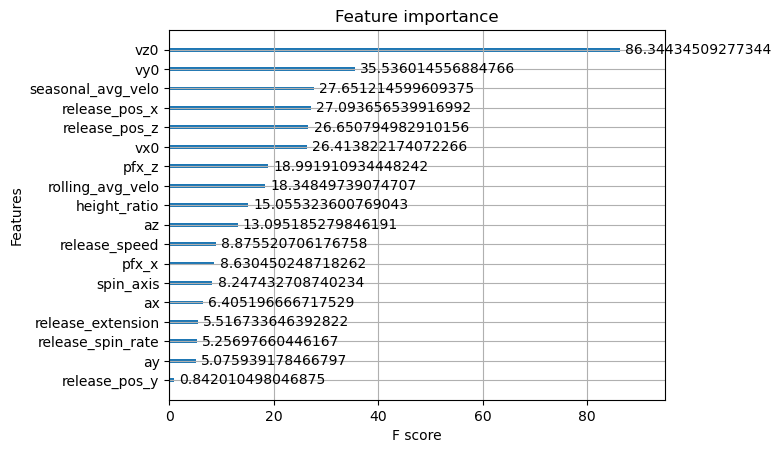

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

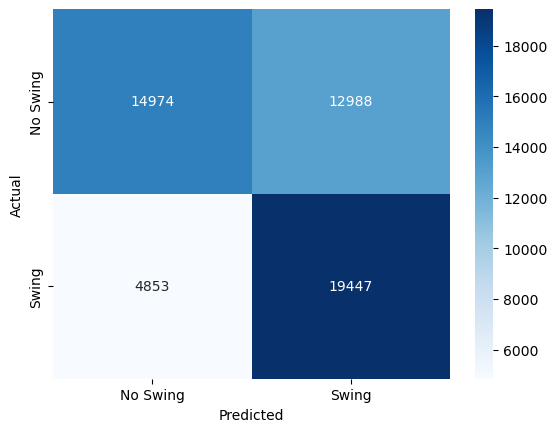

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [ ]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [ ]:
y_pred = final_model.predict(predictions)

In [ ]:
testing_identifiers['xswing'] = y_pred

In [ ]:
num_nans = testing_identifiers['xswing'].isna().sum()
print(f"Number of NaNs in 'xswing': {num_nans}")

Number of NaNs in 'xswing': 0


In [ ]:
len(testing_identifiers)

562083

In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/fastball/swing_2022&3_xswing.csv")